# Configuration & Imports

In [1]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy import interpolate
import json
from pathlib import Path
from tqdm import tqdm
import seaborn as sns
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')
from scipy import interpolate  # <-- Missing import for adaptive_padding function
from collections import defaultdict
import json
from IPython.display import HTML


# Analysis 
for number of frames


Total files: 21889
MSASL files: 9909
WLASL files: 11980

📊 Loading frame lengths...


100%|██████████| 21889/21889 [18:00<00:00, 20.25it/s]   



📊 FRAME LENGTH ANALYSIS

Overall Statistics:
  Number of videos: 21,889
  Shortest video: 9 frames
  Longest video: 401 frames
  Average length: 84.3 frames
  Median length: 79.0 frames
  Standard deviation: 41.7 frames

Percentiles:
   10th percentile: 38.0 frames
   25th percentile: 56.0 frames
   50th percentile: 79.0 frames
   75th percentile: 101.0 frames
   90th percentile: 140.0 frames
   95th percentile: 161.0 frames
   99th percentile: 220.0 frames

By Dataset:
  MSASL - Average: 103.1 frames
  MSASL - Range: 9 to 401 frames
  WLASL - Average: 68.8 frames
  WLASL - Range: 15 to 233 frames

Length Categories:
  Very Short (1-30 frames): 777 videos (3.5%)
  Short (31-60 frames): 6,029 videos (27.5%)
  Medium (61-120 frames): 11,852 videos (54.1%)
  Long (121-200 frames): 2,982 videos (13.6%)
  Very Long (201+ frames): 249 videos (1.1%)


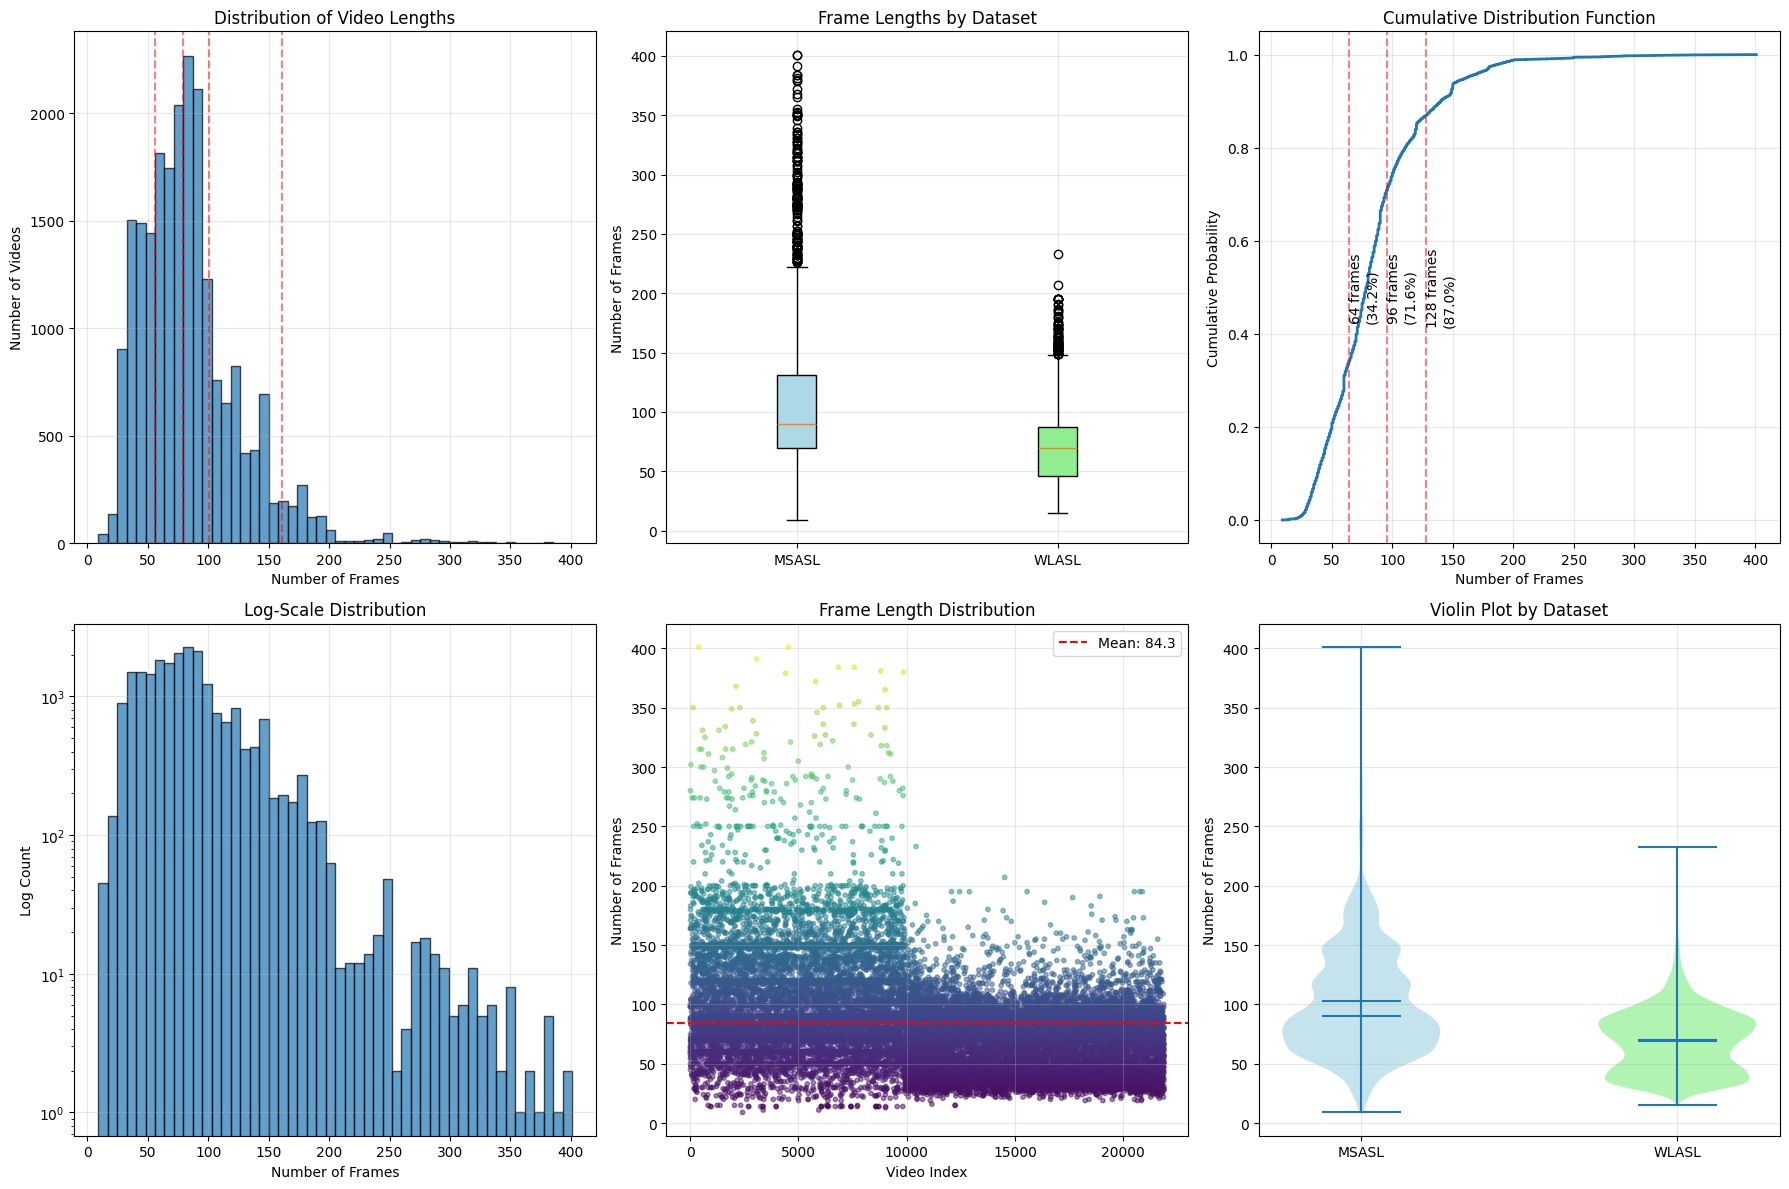


🎯 PREPROCESSING RECOMMENDATIONS

Based on your dataset analysis:
  • Mean length: 84.3 frames
  • Median length: 79.0 frames
  • 95th percentile: 161.0 frames
  • 99th percentile: 220.0 frames

📌 Recommended target frame lengths:
  1. Moderate length (captures ~50% fully):
     • Target: 79 frames
     • Pros: Balanced, most videos need minimal padding/truncation
     • Cons: May truncate longer gestures

  2. Generous length (captures ~95% fully):
     • Target: 161 frames
     • Pros: Most gestures preserved, minimal truncation
     • Cons: More padding for shorter videos

  3. Common practice values:
     • 64 frames: 65.8% truncated, 33.5% padded
     • 96 frames: 28.4% truncated, 70.8% padded
     • 128 frames: 13.0% truncated, 86.8% padded

🔧 Recommended strategy:
  Use sliding windows for videos > 150 frames
  Target length: 96 frames (good balance)
  Windows overlap: 50%

✅ Analysis complete! Results saved to 'frame_analysis_results.json'


In [7]:
def analyze_frame_lengths(msasl_dir="./data/MSASL_Keypoints", 
                         wlasl_dir="./WLASL_Keypoints/landmarks_mapped"):
    """
    Analyze frame lengths for both datasets.
    """
    # Scan datasets
    def scan_files(directory):
        return list(Path(directory).glob("*.npy"))
    
    # Get file paths
    msasl_files = scan_files(msasl_dir)
    wlasl_files = scan_files(wlasl_dir)
    
    all_files = msasl_files + wlasl_files
    print(f"Total files: {len(all_files)}")
    print(f"MSASL files: {len(msasl_files)}")
    print(f"WLASL files: {len(wlasl_files)}")
    
    # Collect frame lengths
    frame_lengths = []
    file_sources = []
    
    print("\n📊 Loading frame lengths...")
    for fpath in tqdm(all_files):
        try:
            data = np.load(fpath, allow_pickle=True)
            frame_lengths.append(data.shape[0])
            
            # Track source
            if fpath in msasl_files:
                file_sources.append("MSASL")
            else:
                file_sources.append("WLASL")
        except Exception as e:
            print(f"Error loading {fpath}: {e}")
            continue
    
    # Convert to numpy
    frame_lengths = np.array(frame_lengths)
    
    # Print statistics
    print("\n" + "="*60)
    print("📊 FRAME LENGTH ANALYSIS")
    print("="*60)
    
    print(f"\nOverall Statistics:")
    print(f"  Number of videos: {len(frame_lengths):,}")
    print(f"  Shortest video: {frame_lengths.min()} frames")
    print(f"  Longest video: {frame_lengths.max()} frames")
    print(f"  Average length: {frame_lengths.mean():.1f} frames")
    print(f"  Median length: {np.median(frame_lengths):.1f} frames")
    print(f"  Standard deviation: {frame_lengths.std():.1f} frames")
    
    # Percentiles
    percentiles = [10, 25, 50, 75, 90, 95, 99]
    print(f"\nPercentiles:")
    for p in percentiles:
        value = np.percentile(frame_lengths, p)
        print(f"  {p:3d}th percentile: {value:.1f} frames")
    
    # Distribution by dataset
    print(f"\nBy Dataset:")
    msasl_mask = np.array(file_sources) == "MSASL"
    wlasl_mask = np.array(file_sources) == "WLASL"
    
    print(f"  MSASL - Average: {frame_lengths[msasl_mask].mean():.1f} frames")
    print(f"  MSASL - Range: {frame_lengths[msasl_mask].min()} to {frame_lengths[msasl_mask].max()} frames")
    print(f"  WLASL - Average: {frame_lengths[wlasl_mask].mean():.1f} frames")
    print(f"  WLASL - Range: {frame_lengths[wlasl_mask].min()} to {frame_lengths[wlasl_mask].max()} frames")
    
    # Count by length categories
    print(f"\nLength Categories:")
    categories = {
        "Very Short (1-30 frames)": (1, 30),
        "Short (31-60 frames)": (31, 60),
        "Medium (61-120 frames)": (61, 120),
        "Long (121-200 frames)": (121, 200),
        "Very Long (201+ frames)": (201, float('inf'))
    }
    
    for name, (low, high) in categories.items():
        count = np.sum((frame_lengths >= low) & (frame_lengths <= high))
        percentage = (count / len(frame_lengths)) * 100
        print(f"  {name}: {count:,} videos ({percentage:.1f}%)")
    
    # Plot distributions
    plot_frame_distributions(frame_lengths, file_sources)
    
    return frame_lengths, file_sources, all_files

def plot_frame_distributions(frame_lengths, file_sources):
    """Create visualization plots for frame length analysis."""
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # 1. Histogram of all frame lengths
    axes[0, 0].hist(frame_lengths, bins=50, edgecolor='black', alpha=0.7)
    axes[0, 0].set_xlabel('Number of Frames')
    axes[0, 0].set_ylabel('Number of Videos')
    axes[0, 0].set_title('Distribution of Video Lengths')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Add vertical lines for key percentiles
    for p in [25, 50, 75, 95]:
        value = np.percentile(frame_lengths, p)
        axes[0, 0].axvline(value, color='red', linestyle='--', alpha=0.5, 
                          label=f'{p}th: {value:.0f}')
    
    # 2. Box plot by dataset
    msasl_lengths = frame_lengths[np.array(file_sources) == "MSASL"]
    wlasl_lengths = frame_lengths[np.array(file_sources) == "WLASL"]
    
    bp = axes[0, 1].boxplot([msasl_lengths, wlasl_lengths], 
                           labels=['MSASL', 'WLASL'],
                           patch_artist=True)
    
    # Color the boxes
    colors = ['lightblue', 'lightgreen']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
    
    axes[0, 1].set_ylabel('Number of Frames')
    axes[0, 1].set_title('Frame Lengths by Dataset')
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Cumulative distribution
    sorted_lengths = np.sort(frame_lengths)
    cdf = np.arange(1, len(sorted_lengths) + 1) / len(sorted_lengths)
    
    axes[0, 2].plot(sorted_lengths, cdf, linewidth=2)
    axes[0, 2].set_xlabel('Number of Frames')
    axes[0, 2].set_ylabel('Cumulative Probability')
    axes[0, 2].set_title('Cumulative Distribution Function')
    axes[0, 2].grid(True, alpha=0.3)
    
    # Add reference lines for target frame lengths
    for target in [64, 96, 128]:
        prob = np.mean(frame_lengths <= target)
        axes[0, 2].axvline(target, color='red', linestyle='--', alpha=0.5)
        axes[0, 2].text(target, 0.5, f'{target} frames\n({prob:.1%})', 
                       rotation=90, verticalalignment='center')
    
    # 4. Log histogram (for better visualization of tail)
    axes[1, 0].hist(frame_lengths, bins=50, edgecolor='black', alpha=0.7, log=True)
    axes[1, 0].set_xlabel('Number of Frames')
    axes[1, 0].set_ylabel('Log Count')
    axes[1, 0].set_title('Log-Scale Distribution')
    axes[1, 0].grid(True, alpha=0.3)
    
    # 5. Scatter plot of length vs index
    axes[1, 1].scatter(range(len(frame_lengths)), frame_lengths, 
                       alpha=0.5, s=10, c=frame_lengths, cmap='viridis')
    axes[1, 1].set_xlabel('Video Index')
    axes[1, 1].set_ylabel('Number of Frames')
    axes[1, 1].set_title('Frame Length Distribution')
    axes[1, 1].grid(True, alpha=0.3)
    
    # Add horizontal line for mean
    mean_length = np.mean(frame_lengths)
    axes[1, 1].axhline(mean_length, color='red', linestyle='--', 
                      label=f'Mean: {mean_length:.1f}')
    axes[1, 1].legend()
    
    # 6. Violin plot by dataset
    violin_parts = axes[1, 2].violinplot([msasl_lengths, wlasl_lengths], 
                                        showmeans=True, showmedians=True)
    axes[1, 2].set_xticks([1, 2])
    axes[1, 2].set_xticklabels(['MSASL', 'WLASL'])
    axes[1, 2].set_ylabel('Number of Frames')
    axes[1, 2].set_title('Violin Plot by Dataset')
    axes[1, 2].grid(True, alpha=0.3)
    
    # Color the violin plots
    for pc, color in zip(violin_parts['bodies'], colors):
        pc.set_facecolor(color)
        pc.set_alpha(0.7)
    
    plt.tight_layout()
    plt.savefig('frame_length_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Print recommendations based on analysis
    print_recommendations(frame_lengths)

def print_recommendations(frame_lengths):
    """Print preprocessing recommendations based on frame length analysis."""
    print("\n" + "="*60)
    print("🎯 PREPROCESSING RECOMMENDATIONS")
    print("="*60)
    
    # Calculate statistics
    mean_len = np.mean(frame_lengths)
    median_len = np.median(frame_lengths)
    p95_len = np.percentile(frame_lengths, 95)
    p99_len = np.percentile(frame_lengths, 99)
    
    print(f"\nBased on your dataset analysis:")
    print(f"  • Mean length: {mean_len:.1f} frames")
    print(f"  • Median length: {median_len:.1f} frames")
    print(f"  • 95th percentile: {p95_len:.1f} frames")
    print(f"  • 99th percentile: {p99_len:.1f} frames")
    
    print(f"\n📌 Recommended target frame lengths:")
    
    # Option 1: Based on mean/median
    print(f"  1. Moderate length (captures ~50% fully):")
    print(f"     • Target: {int(median_len)} frames")
    print(f"     • Pros: Balanced, most videos need minimal padding/truncation")
    print(f"     • Cons: May truncate longer gestures")
    
    # Option 2: Based on 95th percentile
    print(f"\n  2. Generous length (captures ~95% fully):")
    print(f"     • Target: {int(p95_len)} frames")
    print(f"     • Pros: Most gestures preserved, minimal truncation")
    print(f"     • Cons: More padding for shorter videos")
    
    # Option 3: Standard values
    print(f"\n  3. Common practice values:")
    for target in [64, 96, 128]:
        truncation_rate = np.mean(frame_lengths > target) * 100
        padding_rate = np.mean(frame_lengths < target) * 100
        print(f"     • {target} frames: {truncation_rate:.1f}% truncated, "
              f"{padding_rate:.1f}% padded")
    
    print(f"\n🔧 Recommended strategy:")
    if p99_len > 200:
        print(f"  Use sliding windows for videos > 150 frames")
        print(f"  Target length: 96 frames (good balance)")
        print(f"  Windows overlap: 50%")
    elif mean_len < 80:
        print(f"  Simple padding to target length")
        print(f"  Target length: {int(np.ceil(mean_len + 20))} frames")
    else:
        print(f"  Hybrid approach:")
        print(f"  • Pad short videos (< target)")
        print(f"  • Truncate medium videos to target")
        print(f"  • Use sliding windows for long videos (> {int(p95_len)})")

# Run the analysis
if __name__ == "__main__":
    frame_lengths, file_sources, all_files = analyze_frame_lengths()
    
    # Save the analysis results
    analysis_results = {
        'frame_lengths': frame_lengths.tolist(),
        'file_sources': file_sources,
        'total_videos': len(frame_lengths),
        'mean_length': float(np.mean(frame_lengths)),
        'median_length': float(np.median(frame_lengths)),
        'min_length': int(np.min(frame_lengths)),
        'max_length': int(np.max(frame_lengths)),
        'std_length': float(np.std(frame_lengths))
    }
    
    import json
    with open('frame_analysis_results.json', 'w') as f:
        json.dump(analysis_results, f, indent=2)
    
    print(f"\n✅ Analysis complete! Results saved to 'frame_analysis_results.json'")

# Preprocessing Logic

In [63]:
# ============================================================================
# CONFIGURATION
# ============================================================================
class Config:
    # Paths
    MSASL_RAW_DIR = Path("./data/MSASL_Keypoints")
    WLASL_RAW_DIR = Path("./WLASL_Keypoints/landmarks_mapped")
    OUTPUT_DIR = Path("./data/Enhanced_Preprocessed_96Frames")
    SPLITS_DIR = Path("./data/Enhanced_Splits_96Frames")
    ANALYSIS_DIR = Path("./data/analysis_results")
    
    # Create directories
    OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
    SPLITS_DIR.mkdir(parents=True, exist_ok=True)
    ANALYSIS_DIR.mkdir(parents=True, exist_ok=True)
    
    # Based on your analysis
    TARGET_FRAMES = 96                    # Close to 75th percentile (101)
    FEATURE_DIM = 438                     # From your code
    MIN_SAMPLES_PER_WORD = 5              # Minimum samples per class
    
    # Frame strategy parameters (from your analysis)
    MAX_SINGLE_FRAMES = 140               # 90th percentile
    WINDOW_THRESHOLD = 161                # 95th percentile
    VERY_LONG_THRESHOLD = 201             # 99th percentile
    
    # Geometry constants
    POSE_SIZE = 132
    HAND_SIZE = 63
    FACE_SIZE = 180
    POSE_LANDMARKS, POSE_VALS = 33, 4
    HAND_LANDMARKS, HAND_VALS = 21, 3
    FACE_LANDMARKS, FACE_VALS = 60, 3
    LEG_IDXS = list(range(25, 33))
    CRITICAL_POSE_IDXS = {0, 11, 12, 13, 14, 15, 16, 23, 24}
    
    # Preprocessing parameters
    SMOOTH_POSE = True
    SMOOTH_HANDS = True
    SMOOTH_FACE = False
    POSE_MIN_CUTOFF = 1.5
    POSE_BETA = 0.4
    HAND_MIN_CUTOFF = 2.0
    HAND_BETA = 0.3
    FACE_MIN_CUTOFF = 2.0
    FACE_BETA = 0.4
    D_CUTOFF = 1.0
    FPS = 20.0
    EPS = 1e-8

config = Config()


In [64]:
# ============================================================================
# 1. ENHANCED GEOMETRY FUNCTIONS (Keep your original)
# ============================================================================
def in_unit_xy(x: np.ndarray, y: np.ndarray) -> np.ndarray:
    """Mask where x,y are finite and within [0,1]."""
    return (
        np.isfinite(x) & np.isfinite(y) &
        (x >= 0.0) & (x <= 1.0) &
        (y >= 0.0) & (y <= 1.0)
    )

def reasonable_xy(x: np.ndarray, y: np.ndarray, lo: float = -0.25, hi: float = 1.25) -> np.ndarray:
    """Relaxed normalized check (helps during fast motion / partial crops)."""
    return (
        np.isfinite(x) & np.isfinite(y) &
        (x >= lo) & (x <= hi) &
        (y >= lo) & (y <= hi)
    )

def valid_points_xyz(arr: np.ndarray, eps: float = 1e-8) -> np.ndarray:
    """arr shape (...,3) -> mask over last axis: point is not all-zero."""
    return np.any(np.abs(arr) > eps, axis=-1)

def is_valid_wrist(w: np.ndarray, eps: float = 1e-8) -> bool:
    return bool(np.isfinite(w).all() and np.any(np.abs(w) > eps))

def dist2(a: np.ndarray, b: np.ndarray) -> float:
    """2D distance in XY."""
    return float(np.linalg.norm(a[:2] - b[:2]))

In [66]:
# ============================================================================
# 2. ENHANCED NORMALIZATION (Keep your original)
# ============================================================================
def compute_global_root(pose_xyz: np.ndarray, vis: np.ndarray, eps: float = 1e-8) -> np.ndarray:
    def collect_mid(i1: int, i2: int):
        m = (vis[:, i1] > 0.0) & (vis[:, i2] > 0.0)
        m = m & valid_points_xyz(pose_xyz[:, i1, :], eps) & valid_points_xyz(pose_xyz[:, i2, :], eps)
        if not np.any(m):
            return None
        return (pose_xyz[m, i1, :] + pose_xyz[m, i2, :]) / 2.0

    mid_hip = collect_mid(23, 24)
    if mid_hip is not None:
        return mid_hip.mean(axis=0)

    mid_sh = collect_mid(11, 12)
    if mid_sh is not None:
        return mid_sh.mean(axis=0)

    m_nose = (vis[:, 0] > 0.0) & valid_points_xyz(pose_xyz[:, 0, :], eps)
    if np.any(m_nose):
        return pose_xyz[m_nose, 0, :].mean(axis=0)

    m_all = (vis > 0.0) & valid_points_xyz(pose_xyz, eps)
    if np.any(m_all):
        return pose_xyz[m_all].mean(axis=0)

    return np.zeros(3, dtype=np.float32)

def compute_global_scale(pose_xyz: np.ndarray, vis: np.ndarray, root: np.ndarray, eps: float = 1e-6) -> float:
    def collect_dist(i1: int, i2: int):
        m = (vis[:, i1] > 0.0) & (vis[:, i2] > 0.0)
        m = m & valid_points_xyz(pose_xyz[:, i1, :]) & valid_points_xyz(pose_xyz[:, i2, :])
        if not np.any(m):
            return None
        d = np.linalg.norm(pose_xyz[m, i1, :] - pose_xyz[m, i2, :], axis=1)
        d = d[d > eps]
        return d if d.size > 0 else None

    d_sh = collect_dist(11, 12)
    if d_sh is not None:
        return float(d_sh.mean())

    d_hip = collect_dist(23, 24)
    if d_hip is not None:
        return float(d_hip.mean())

    m_all = (vis > 0.0) & valid_points_xyz(pose_xyz)
    if np.any(m_all):
        d = np.linalg.norm(pose_xyz[m_all] - root[None, :], axis=1)
        d = d[d > eps]
        if d.size > 0:
            return float(d.mean())

    return 1.0

In [67]:
# ============================================================================
# 3. ENHANCED HAND FIXING (Keep your original)
# ============================================================================
def frame_valid_hand(hand_t: np.ndarray, min_pts: int = 8, eps: float = 1e-8) -> bool:
    """A frame counts as 'hand present' if it has >= min_pts non-zero landmarks."""
    nz = np.any(np.abs(hand_t) > eps, axis=1)
    return int(nz.sum()) >= int(min_pts)

def hand_centroid(hand_t: np.ndarray, eps: float = 1e-8):
    m = np.any(np.abs(hand_t) > eps, axis=1)
    if not np.any(m):
        return None
    return hand_t[m].mean(axis=0)

def fix_swap_and_gate_hands(
    lh: np.ndarray, rh: np.ndarray,
    lw: np.ndarray, rw: np.ndarray,
    min_pts: int = 8,
    hand_wrist_max_dist: float = 1.1,
    eps: float = 1e-8,
) -> None:
    T = lh.shape[0]
    for t in range(T):
        l_ok = frame_valid_hand(lh[t], min_pts=min_pts, eps=eps)
        r_ok = frame_valid_hand(rh[t], min_pts=min_pts, eps=eps)

        wl_ok = is_valid_wrist(lw[t], eps=eps)
        wr_ok = is_valid_wrist(rw[t], eps=eps)

        cL = hand_centroid(lh[t], eps=eps) if l_ok else None
        cR = hand_centroid(rh[t], eps=eps) if r_ok else None

        if l_ok and r_ok and wl_ok and wr_ok and (cL is not None) and (cR is not None):
            d_ll = dist2(cL, lw[t])
            d_lr = dist2(cL, rw[t])
            d_rr = dist2(cR, rw[t])
            d_rl = dist2(cR, lw[t])
            if (d_lr + d_rl) + 1e-6 < (d_ll + d_rr):
                lh[t], rh[t] = rh[t].copy(), lh[t].copy()
                cL, cR = cR, cL

        if wl_ok and l_ok and (cL is not None):
            if dist2(cL, lw[t]) > hand_wrist_max_dist:
                lh[t] = 0.0
        if wr_ok and r_ok and (cR is not None):
            if dist2(cR, rw[t]) > hand_wrist_max_dist:
                rh[t] = 0.0

def fill_hand_gaps_wrist_relative_tiered(
    hand: np.ndarray,
    wrist: np.ndarray,
    small_gap: int = 6,
    medium_gap: int = 15,
    min_pts: int = 8,
    rel_change_thresh: float = 0.7,
    eps: float = 1e-8,
) -> None:
    T = hand.shape[0]
    valid = np.array([frame_valid_hand(hand[t], min_pts=min_pts, eps=eps) for t in range(T)], dtype=bool)
    idx = np.where(valid)[0]
    if idx.size == 0:
        return

    def set_from_rel(t: int, rel: np.ndarray):
        if is_valid_wrist(wrist[t], eps=eps):
            hand[t] = rel + wrist[t]

    for a, b in zip(idx[:-1], idx[1:]):
        gap = int(b - a - 1)
        if gap <= 0:
            continue
        if gap > medium_gap:
            continue

        if not (is_valid_wrist(wrist[a], eps=eps) and is_valid_wrist(wrist[b], eps=eps)):
            if gap <= small_gap:
                for t in range(a + 1, b):
                    hand[t] = hand[a]
            continue

        rel_a = hand[a] - wrist[a]
        rel_b = hand[b] - wrist[b]

        if gap > small_gap:
            for t in range(a + 1, b):
                set_from_rel(t, rel_a)
            continue

        delta = np.linalg.norm(rel_a - rel_b, axis=1)
        delta = delta[np.isfinite(delta)]
        rel_delta = float(np.median(delta)) if delta.size else 999.0

        if rel_delta <= rel_change_thresh:
            for t in range(a + 1, b):
                alpha = (t - a) / (b - a)
                rel = (1.0 - alpha) * rel_a + alpha * rel_b
                set_from_rel(t, rel)
        else:
            for t in range(a + 1, b):
                set_from_rel(t, rel_a)


In [68]:
# ============================================================================
# 4. ENHANCED SMOOTHING WITH SELECTIVE APPLICATION
# ============================================================================
def _alpha(cutoff_hz: float, dt: float) -> float:
    cutoff_hz = float(max(cutoff_hz, 1e-6))
    tau = 1.0 / (2.0 * np.pi * cutoff_hz)
    return float(1.0 / (1.0 + tau / dt))

def one_euro_filter_series(
    x: np.ndarray,
    valid: np.ndarray,
    fps: float,
    min_cutoff: float,
    beta: float,
    d_cutoff: float,
) -> np.ndarray:
    T, D = x.shape
    out = np.zeros_like(x, dtype=np.float32)
    dt = 1.0 / float(max(fps, 1e-6))

    x_prev = np.zeros(D, dtype=np.float32)
    x_hat_prev = np.zeros(D, dtype=np.float32)
    dx_hat_prev = np.zeros(D, dtype=np.float32)
    has_prev = False

    for t in range(T):
        if not bool(valid[t]):
            has_prev = False
            continue

        xt = x[t].astype(np.float32, copy=False)

        if not has_prev:
            out[t] = xt
            x_prev = xt
            x_hat_prev = xt
            dx_hat_prev[:] = 0.0
            has_prev = True
            continue

        dx = (xt - x_prev) / dt
        a_d = _alpha(d_cutoff, dt)
        dx_hat = a_d * dx + (1.0 - a_d) * dx_hat_prev

        cutoff = float(min_cutoff + beta * np.linalg.norm(dx_hat))
        a = _alpha(cutoff, dt)

        x_hat = a * xt + (1.0 - a) * x_hat_prev

        out[t] = x_hat
        x_prev = xt
        x_hat_prev = x_hat
        dx_hat_prev = dx_hat

    return out

def smooth_points_over_time(
    pts: np.ndarray,
    eps: float,
    fps: float,
    min_cutoff: float,
    beta: float,
    d_cutoff: float,
) -> None:
    T, N, _ = pts.shape
    for i in range(N):
        x = pts[:, i, :]
        valid = valid_points_xyz(x, eps=eps) & np.isfinite(x).all(axis=1)
        if not np.any(valid):
            continue
        pts[:, i, :] = one_euro_filter_series(
            x, valid=valid, fps=fps,
            min_cutoff=min_cutoff, beta=beta, d_cutoff=d_cutoff
        )


In [69]:
# ============================================================================
# 5. FRAME MANAGEMENT - HYBRID STRATEGY
# ============================================================================
def adaptive_padding(sequence: np.ndarray, target_frames: int) -> tuple:
    """
    Smart padding for short sequences using interpolation.
    Returns: (padded_sequence, attention_mask)
    """
    T, D = sequence.shape
    
    if T >= target_frames:
        return sequence[:target_frames], np.ones(target_frames, dtype=np.float32)
    
    # Create padded sequence with interpolation
    padded_seq = np.zeros((target_frames, D), dtype=np.float32)
    
    # Original time points
    x_orig = np.arange(T)
    x_target = np.linspace(0, T-1, target_frames)
    
    # Interpolate each feature dimension
    for d in range(D):
        if np.any(np.isfinite(sequence[:, d])):
            # Use linear interpolation
            if T >= 2:
                f = interpolate.interp1d(
                    x_orig, sequence[:, d], 
                    kind='linear',
                    bounds_error=False,
                    fill_value="extrapolate"
                )
                padded_seq[:, d] = f(x_target)
            else:
                # If only 1 frame, repeat it
                padded_seq[:, d] = sequence[0, d]
    
    # Create attention mask (1 for interpolated frames close to original, 0.5 for extended)
    mask = np.zeros(target_frames, dtype=np.float32)
    
    # Mark positions corresponding to original frames
    for i, target_pos in enumerate(x_target):
        closest_orig = int(round(target_pos))
        if 0 <= closest_orig < T:
            mask[i] = 1.0
        else:
            mask[i] = 0.5  # Extended frames
    
    return padded_seq, mask

def create_sliding_windows(sequence: np.ndarray, window_size: int, overlap: float = 0.5) -> list:
    """
    Create sliding windows for long sequences.
    """
    T = sequence.shape[0]
    windows = []
    
    if T <= window_size:
        return [sequence]
    
    # Calculate step size
    step = int(window_size * (1 - overlap))
    if step < 1:
        step = 1
    
    # Create windows
    start = 0
    while start + window_size <= T:
        windows.append(sequence[start:start + window_size])
        start += step
    
    # Always include the last window
    if not windows or (start < T and T >= window_size):
        last_window = sequence[-window_size:]
        if len(windows) == 0 or not np.array_equal(last_window, windows[-1]):
            windows.append(last_window)
    
    return windows

def hybrid_frame_strategy(sequence: np.ndarray, original_length: int) -> tuple:
    """
    FIXED VERSION: Hybrid frame strategy based on sequence length.
    Returns (sequences_list, masks_list, metadata_list) where masks have shape (T,)
    """
    T = sequence.shape[0]  # FIXED: Use actual sequence length, not original_length
    
    # Debug: Print actual vs original
    if T != original_length:
        print(f"  Note: Sequence length changed from {original_length} to {T}")
    
    if T < 30:
        # Case 1: Very Short - Interpolation padding
        padded_seq, mask = adaptive_padding(sequence, config.TARGET_FRAMES)
        return [padded_seq], [mask], [{
            'strategy': 'interpolation_padding',
            'original_length': original_length,
            'processed_length': T,
            'padding_amount': config.TARGET_FRAMES - T
        }]
    
    elif T < config.TARGET_FRAMES:
        # Case 2: Short - Edge padding (repeat last frame)
        padded_seq = np.zeros((config.TARGET_FRAMES, sequence.shape[1]), dtype=np.float32)
        padded_seq[:T] = sequence
        
        if T > 0:
            padded_seq[T:] = sequence[-1]
        
        mask = np.zeros(config.TARGET_FRAMES, dtype=np.float32)
        mask[:T] = 1.0
        
        return [padded_seq], [mask], [{
            'strategy': 'edge_padding',
            'original_length': original_length,
            'processed_length': T,
            'padding_amount': config.TARGET_FRAMES - T
        }]
    
    elif T <= config.MAX_SINGLE_FRAMES:
        # Case 3: Medium - Take first 96 frames
        truncated_seq = sequence[:config.TARGET_FRAMES]
        mask = np.ones(config.TARGET_FRAMES, dtype=np.float32)
        
        return [truncated_seq], [mask], [{
            'strategy': 'first_frames',
            'original_length': original_length,
            'processed_length': T,
            'truncation_amount': T - config.TARGET_FRAMES
        }]
    
    elif T <= config.WINDOW_THRESHOLD:
        # Case 4: Long - Take middle 96 frames
        middle_start = (T - config.TARGET_FRAMES) // 2
        middle_seq = sequence[middle_start:middle_start + config.TARGET_FRAMES]
        mask = np.ones(config.TARGET_FRAMES, dtype=np.float32)
        
        return [middle_seq], [mask], [{
            'strategy': 'middle_frames',
            'original_length': original_length,
            'processed_length': T,
            'middle_start': middle_start
        }]
    
    else:
        # Case 5: Very Long - Sliding windows
        windows = create_sliding_windows(sequence, config.TARGET_FRAMES, overlap=0.5)
        masks = [np.ones(config.TARGET_FRAMES, dtype=np.float32) for _ in windows]
        metadata = []
        
        for i, window in enumerate(windows):
            metadata.append({
                'strategy': 'sliding_window',
                'original_length': original_length,
                'processed_length': T,
                'window_index': i,
                'total_windows': len(windows),
                'overlap_ratio': 0.5
            })
        
        return windows, masks, metadata

In [70]:
# ============================================================================
# 6. MAIN PREPROCESSING PIPELINE
# ============================================================================
def preprocess_sequence_global(seq: np.ndarray) -> np.ndarray:
    """
    Core preprocessing pipeline (your original function).
    Returns cleaned sequence.
    """
    y = seq.astype(np.float32, copy=True)
    if y.ndim != 2 or y.shape[1] != config.FEATURE_DIM:
        raise ValueError(f"Expected shape (T,{config.FEATURE_DIM}), got {y.shape}")

    pose = y[:, :config.POSE_SIZE].reshape(-1, config.POSE_LANDMARKS, config.POSE_VALS)
    face = y[:, config.POSE_SIZE:config.POSE_SIZE + config.FACE_SIZE].reshape(-1, config.FACE_LANDMARKS, config.FACE_VALS)
    lh = y[:, config.POSE_SIZE + config.FACE_SIZE:config.POSE_SIZE + config.FACE_SIZE + config.HAND_SIZE].reshape(-1, config.HAND_LANDMARKS, config.HAND_VALS)
    rh = y[:, config.POSE_SIZE + config.FACE_SIZE + config.HAND_SIZE:].reshape(-1, config.HAND_LANDMARKS, config.HAND_VALS)

    # Pose cleaning
    px, py, pz, pv = pose[:, :, 0], pose[:, :, 1], pose[:, :, 2], pose[:, :, 3]
    finite_pose = np.isfinite(pz) & np.isfinite(pv)
    
    pose_in_strict = in_unit_xy(px, py) & finite_pose
    pose_in_relaxed = reasonable_xy(px, py) & finite_pose
    
    critical_mask = np.zeros((pose.shape[0], config.POSE_LANDMARKS), dtype=bool)
    for i in config.CRITICAL_POSE_IDXS:
        critical_mask[:, i] = True
    
    pose_keep_for_transform = (pv >= 0.1) & pose_in_strict
    pose_keep_for_transform = pose_keep_for_transform | (critical_mask & pose_in_relaxed)
    
    pose_keep_visible = (pv >= 0.1) & pose_in_strict
    
    bad_xyz = ~pose_keep_for_transform
    pose[bad_xyz, :3] = 0.0
    pose[~pose_keep_visible, 3] = 0.0
    
    pose[:, config.LEG_IDXS, :3] = 0.0
    pose[:, config.LEG_IDXS, 3] = 0.0
    
    # Face cleaning
    fx, fy, fz = face[:, :, 0], face[:, :, 1], face[:, :, 2]
    face_in = reasonable_xy(fx, fy) & np.isfinite(fz)
    face[~face_in, :3] = 0.0
    
    # Hands cleaning
    lx, ly, lz = lh[:, :, 0], lh[:, :, 1], lh[:, :, 2]
    lh_in = reasonable_xy(lx, ly) & np.isfinite(lz)
    lh[~lh_in, :3] = 0.0
    
    rx, ry, rz = rh[:, :, 0], rh[:, :, 1], rh[:, :, 2]
    rh_in = reasonable_xy(rx, ry) & np.isfinite(rz)
    rh[~rh_in, :3] = 0.0
    
    # Global normalization
    pose_xyz = pose[:, :, :3]
    vis = pose[:, :, 3]
    
    root = compute_global_root(pose_xyz, vis, eps=config.EPS)
    scale = compute_global_scale(pose_xyz, vis, root)
    
    pose_valid_for_transform = pose_keep_for_transform & valid_points_xyz(pose_xyz, eps=config.EPS)
    pose_xyz[pose_valid_for_transform] = (pose_xyz[pose_valid_for_transform] - root) / scale
    pose[:, :, :3] = pose_xyz
    
    for arr in (face, lh, rh):
        m = valid_points_xyz(arr, eps=config.EPS)
        arr[m] = (arr[m] - root) / scale
    
    # Wrist positions
    lw = pose_xyz[:, 15, :].copy()
    rw = pose_xyz[:, 16, :].copy()
    
    # Hand fixing
    fix_swap_and_gate_hands(
        lh, rh, lw, rw,
        min_pts=8,
        hand_wrist_max_dist=1.1,
        eps=config.EPS,
    )
    
    fill_hand_gaps_wrist_relative_tiered(
        lh, lw,
        small_gap=6,
        medium_gap=15,
        min_pts=8,
        rel_change_thresh=0.7,
        eps=config.EPS,
    )
    fill_hand_gaps_wrist_relative_tiered(
        rh, rw,
        small_gap=6,
        medium_gap=15,
        min_pts=8,
        rel_change_thresh=0.7,
        eps=config.EPS,
    )
    
    # Smoothing
    if config.SMOOTH_POSE:
        smooth_points_over_time(
            pose[:, :, :3], eps=config.EPS, fps=config.FPS,
            min_cutoff=config.POSE_MIN_CUTOFF, beta=config.POSE_BETA, d_cutoff=config.D_CUTOFF
        )
    if config.SMOOTH_HANDS:
        smooth_points_over_time(
            lh, eps=config.EPS, fps=config.FPS,
            min_cutoff=config.HAND_MIN_CUTOFF, beta=config.HAND_BETA, d_cutoff=config.D_CUTOFF
        )
        smooth_points_over_time(
            rh, eps=config.EPS, fps=config.FPS,
            min_cutoff=config.HAND_MIN_CUTOFF, beta=config.HAND_BETA, d_cutoff=config.D_CUTOFF
        )
    if config.SMOOTH_FACE:
        smooth_points_over_time(
            face, eps=config.EPS, fps=config.FPS,
            min_cutoff=config.FACE_MIN_CUTOFF, beta=config.FACE_BETA, d_cutoff=config.D_CUTOFF
        )
    
    # Reconstruct
    out = np.empty_like(y, dtype=np.float32)
    out[:, :config.POSE_SIZE] = pose.reshape(-1, config.POSE_SIZE)
    out[:, config.POSE_SIZE:config.POSE_SIZE + config.FACE_SIZE] = face.reshape(-1, config.FACE_SIZE)
    out[:, config.POSE_SIZE + config.FACE_SIZE:config.POSE_SIZE + config.FACE_SIZE + config.HAND_SIZE] = lh.reshape(-1, config.HAND_SIZE)
    out[:, config.POSE_SIZE + config.FACE_SIZE + config.HAND_SIZE:] = rh.reshape(-1, config.HAND_SIZE)
    
    return out



In [77]:
# ============================================================================
# FIXED: FILENAME HANDLING WITH SAFE CHARACTERS
# ============================================================================
import re

def sanitize_filename(filename: str) -> str:
    """
    Sanitize filename by removing special characters.
    Keeps only alphanumeric, underscores, and dots.
    """
    # Remove special characters but keep alphanumeric, underscore, dot
    sanitized = re.sub(r'[^a-zA-Z0-9_.]', '_', filename)
    # Remove multiple consecutive underscores
    sanitized = re.sub(r'_+', '_', sanitized)
    # Remove leading/trailing underscores
    sanitized = sanitized.strip('_')
    return sanitized

def create_safe_filename(source: str, word: str, video_id: str, window_idx: int = None) -> tuple:
    """
    Create safe filenames for processed files and masks.
    Returns: (base_filename, processed_filename, mask_filename)
    """
    # Sanitize all components
    safe_source = sanitize_filename(source)
    safe_word = sanitize_filename(word)
    safe_video_id = sanitize_filename(video_id)
    
    # Create base filename
    if window_idx is None:
        base_name = f"{safe_source}_{safe_word}_{safe_video_id}"
    else:
        base_name = f"{safe_source}_{safe_word}_{safe_video_id}_w{window_idx:02d}"
    
    # Create full filenames
    processed_filename = f"{base_name}.npy"
    mask_filename = f"{base_name}_mask.npy"
    
    return base_name, processed_filename, mask_filename

# ============================================================================
# UPDATED: PROCESS SINGLE VIDEO FUNCTION
# ============================================================================
def process_single_video_fixed(filepath: str, word: str, source: str, video_id: str) -> list:
    """
    Process a single video file with safe filename handling.
    Returns list of processed records.
    """
    records = []
    
    try:
        # Load raw data
        raw_data = np.load(filepath, allow_pickle=True)
        original_length = raw_data.shape[0]
        
        # Apply core preprocessing
        cleaned_data = preprocess_sequence_global(raw_data)
        
        # Debug: Check shape
        print(f"  Original: {raw_data.shape}, Cleaned: {cleaned_data.shape}")
        
        # Apply hybrid frame strategy
        sequences, masks, metadata = hybrid_frame_strategy(cleaned_data, original_length)
        
        # DEBUG: Show what hybrid strategy produced
        print(f"  → Strategy produced {len(sequences)} sequence(s)")
        for i, (seq, mask) in enumerate(zip(sequences, masks)):
            print(f"    Seq {i+1}: shape={seq.shape}, mask={mask.shape}")
            print(f"    Strategy: {metadata[i]['strategy']}")
        
        # VERIFY SHAPES BEFORE SAVING
        for seq_idx, (seq, mask, meta) in enumerate(zip(sequences, masks, metadata)):
            # CRITICAL: Check if shapes are correct
            if seq.shape != (config.TARGET_FRAMES, config.FEATURE_DIM):
                print(f"  ⚠️ WARNING: Sequence shape {seq.shape}, expected (96, 438)!")
                # Fix it
                if seq.shape[0] < config.TARGET_FRAMES:
                    # Pad with zeros
                    padded = np.zeros((config.TARGET_FRAMES, config.FEATURE_DIM))
                    padded[:seq.shape[0]] = seq
                    seq = padded
                    print(f"  → Padded from {seq.shape[0]} to {config.TARGET_FRAMES} frames")
                else:
                    # Truncate
                    seq = seq[:config.TARGET_FRAMES]
                    print(f"  → Truncated from {seq.shape[0]} to {config.TARGET_FRAMES} frames")
            
            if mask.shape != (config.TARGET_FRAMES,):
                print(f"  ⚠️ WARNING: Mask shape {mask.shape}, expected (96,)!")
                # Fix it
                if mask.shape[0] < config.TARGET_FRAMES:
                    padded_mask = np.zeros(config.TARGET_FRAMES)
                    padded_mask[:mask.shape[0]] = mask
                    mask = padded_mask
                else:
                    mask = mask[:config.TARGET_FRAMES]
            
            # Generate safe filenames
            window_idx = None if len(sequences) == 1 else seq_idx
            base_name, processed_filename, mask_filename = create_safe_filename(
                source, word, video_id, window_idx
            )
            
            save_path = config.OUTPUT_DIR / processed_filename
            mask_path = config.OUTPUT_DIR / mask_filename
            
            # Save data
            np.save(save_path, seq)
            np.save(mask_path, mask)
            
            # Create record
            records.append({
                'word': word,
                'original_file': filepath,
                'processed_file': str(save_path),
                'mask_file': str(mask_path),
                'source': source,
                'video_id': video_id,
                'original_length': original_length,
                'processed_length': seq.shape[0],
                'strategy': meta['strategy'],
                'is_windowed': meta['strategy'] == 'sliding_window',
                'window_index': meta.get('window_index', 0),
                'total_windows': meta.get('total_windows', 1),
                'padding_amount': meta.get('padding_amount', 0),
                'truncation_amount': meta.get('truncation_amount', 0),
                'base_filename': base_name
            })
            
    except Exception as e:
        print(f"Error processing {filepath}: {e}")
    
    return records


# ============================================================================
# UPDATED: SCAN DATASETS FUNCTION WITH BETTER ERROR HANDLING
# ============================================================================
def scan_datasets():
    """Scan both MSASL and WLASL datasets with better error handling."""
    print("Scanning datasets...")
    
    def scan_dir(path, source_name):
        data = []
        if not path.exists():
            print(f"⚠️ {source_name} directory not found: {path}")
            return data
        
        files = list(path.glob("*.npy"))
        print(f"Found {len(files)} .npy files in {source_name}")
        
        for f in tqdm(files, desc=f"Scanning {source_name}"):
            try:
                # Extract word and video_id from filename
                filename = f.stem
                
                # Handle different filename patterns
                if source_name == "MSASL":
                    # MSASL format: word_videoID.npy (may have special chars)
                    # Find the last underscore that separates word and video_id
                    parts = filename.split('_')
                    if len(parts) >= 2:
                        # Word is everything except the last part
                        word = '_'.join(parts[:-1])
                        video_id = parts[-1]
                    else:
                        # Fallback if only one part
                        word = filename
                        video_id = "unknown"
                
                elif source_name == "WLASL":
                    # WLASL format: word_number.npy
                    parts = filename.split('_')
                    if len(parts) >= 2:
                        word = '_'.join(parts[:-1])
                        video_id = parts[-1]
                    else:
                        word = filename
                        video_id = "unknown"
                
                # Clean the word (lowercase, strip)
                word = word.lower().strip()
                
                data.append({
                    'filepath': str(f),
                    'word': word,
                    'source': source_name,
                    'video_id': video_id,
                    'original_filename': filename
                })
                
            except Exception as e:
                print(f"  ⚠️ Error parsing {f.name}: {e}")
                continue
        
        return data
    
    msasl_data = scan_dir(config.MSASL_RAW_DIR, "MSASL")
    wlasl_data = scan_dir(config.WLASL_RAW_DIR, "WLASL")
    
    df = pd.DataFrame(msasl_data + wlasl_data)
    
    # Print some problematic examples for debugging
    print(f"\n📊 Sample of parsed filenames:")
    for i, row in df.head(10).iterrows():
        print(f"  {row['original_filename']} -> word='{row['word']}', video_id='{row['video_id']}'")
    
    # Check for problematic characters
    print(f"\n🔍 Checking for problematic characters in filenames...")
    special_chars = []
    for fname in df['original_filename']:
        if re.search(r'[&=\-+()\[\]{}<>]', fname):
            special_chars.append(fname)
    
    if special_chars:
        print(f"  Found {len(special_chars)} files with special characters:")
        for fname in special_chars[:10]:  # Show first 10
            print(f"    {fname}")
    
    return df


In [78]:
# ============================================================================
# 10. SIMPLIFIED PROCESSING (Minimal Prints)
# ============================================================================
def process_all_videos_silent():
    """Main processing pipeline with minimal output."""
    # Ensure output directory exists
    config.OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
    
    # Scan datasets
    df = scan_datasets()
    if df.empty:
        print("❌ No files found!")
        return None
    
    print(f"Found {len(df):,} videos")
    
    # Filter rare words
    word_counts = df['word'].value_counts()
    valid_words = word_counts[word_counts >= config.MIN_SAMPLES_PER_WORD].index
    df_filtered = df[df['word'].isin(valid_words)].copy()
    
    print(f"Processing {len(df_filtered):,} videos after filtering...")
    
    # Process videos
    all_records = []
    stats = defaultdict(int)
    
    for idx, row in tqdm(df_filtered.iterrows(), total=len(df_filtered), desc="Processing"):
        # FIXED: Call the renamed function
        records = process_single_video_fixed(
            row['filepath'],
            row['word'],
            row['source'],
            row['video_id']
        )
        
        if records:
            all_records.extend(records)
            for record in records:
                stats[record['strategy']] += 1
                stats['total'] += 1
    
    if not all_records:
        print("❌ No videos processed!")
        return None
    
    # Save metadata
    df_processed = pd.DataFrame(all_records)
    df_processed.to_csv(config.OUTPUT_DIR / "metadata.csv", index=False)
    
    # Print quick summary
    print(f"\n✅ Done: {stats['total']:,} samples generated")
    for strategy in ['interpolation_padding', 'edge_padding', 'first_frames', 
                     'middle_frames', 'sliding_window']:
        if strategy in stats:
            print(f"  {strategy}: {stats[strategy]:,}")
    
    return df_processed

In [79]:
# ============================================================================
# 13. QUICK DATASET CREATION
# ============================================================================
def create_quick_splits(df_processed, test_size=0.2, val_size=0.15):
    """Create simple train/val/test splits without all the prints."""
    from sklearn.model_selection import train_test_split
    
    # Get unique video identifiers
    video_ids = df_processed[['source', 'video_id', 'word']].drop_duplicates()
    
    # First split: test set
    train_val, test = train_test_split(
        video_ids, test_size=test_size, 
        stratify=video_ids['word'], random_state=42
    )
    
    # Second split: train and validation
    train, val = train_test_split(
        train_val, test_size=val_size/(1-test_size),
        stratify=train_val['word'], random_state=42
    )
    
    # Expand to samples
    def expand_split(split_df, split_name):
        expanded = []
        for _, row in split_df.iterrows():
            mask = (df_processed['source'] == row['source']) & \
                   (df_processed['video_id'] == row['video_id']) & \
                   (df_processed['word'] == row['word'])
            samples = df_processed[mask].copy()
            samples['split'] = split_name
            expanded.append(samples)
        return pd.concat(expanded, ignore_index=True) if expanded else pd.DataFrame()
    
    df_train = expand_split(train, 'train')
    df_val = expand_split(val, 'val')
    df_test = expand_split(test, 'test')
    
    # Create label map
    all_words = pd.concat([df_train, df_val, df_test])['word'].unique()
    label_map = {word: i for i, word in enumerate(sorted(all_words))}
    
    # Apply labels
    for df_split in [df_train, df_val, df_test]:
        df_split['label_idx'] = df_split['word'].map(label_map)
    
    # Save
    df_train.to_csv(config.SPLITS_DIR / "train.csv", index=False)
    df_val.to_csv(config.SPLITS_DIR / "val.csv", index=False)
    df_test.to_csv(config.SPLITS_DIR / "test.csv", index=False)
    
    # Save label map
    with open(config.SPLITS_DIR / "class_map.json", "w") as f:
        json.dump(label_map, f, indent=2)
    
    print(f"\n📊 Quick Split Summary:")
    print(f"  Train: {len(df_train):,} samples")
    print(f"  Val:   {len(df_val):,} samples")
    print(f"  Test:  {len(df_test):,} samples")
    print(f"  Total: {len(df_train)+len(df_val)+len(df_test):,} samples")
    
    return df_train, df_val, df_test, label_map

In [80]:
def test_few_files():
    """Test the fixed code on 3 files to see what hybrid_frame_strategy produces."""
    print("🧪 Testing hybrid_frame_strategy on sample files...")
    print("-" * 60)
    
    # Find a few files
    test_files = list(config.MSASL_RAW_DIR.glob("*.npy"))[:3]
    
    for filepath in test_files:
        print(f"\nFile: {filepath.name}")
        try:
            raw_data = np.load(filepath, allow_pickle=True)
            print(f"  Original: {raw_data.shape}")
            
            cleaned = preprocess_sequence_global(raw_data)
            print(f"  Cleaned: {cleaned.shape}")
            
            sequences, masks, metadata = hybrid_frame_strategy(cleaned, raw_data.shape[0])
            
            print(f"  Strategy: {metadata[0]['strategy']}")
            print(f"  Produced {len(sequences)} sequence(s):")
            
            for i, (seq, mask) in enumerate(zip(sequences, masks)):
                print(f"    Sequence {i+1}: {seq.shape}")
                print(f"    Mask {i+1}: {mask.shape}")
                
                # Check if it's 96 frames
                if seq.shape == (config.TARGET_FRAMES, config.FEATURE_DIM):
                    print(f"    ✅ Correct shape!")
                else:
                    print(f"    ❌ Wrong shape! Expected (96, 438)")
                    
        except Exception as e:
            print(f"  Error: {e}")
    
    print("-" * 60)

In [82]:
# ============================================================================
# 14. CLEAN MAIN EXECUTION
# ============================================================================
def main_clean():
    """Clean main function with minimal output."""
    print("=" * 50)
    print("Enhanced Sign Language Preprocessing")
    print("=" * 50)
    
    # 1. Process videos
    df_processed = process_all_videos_silent()
    
    if df_processed is not None:
        # 2. Create splits
        df_train, df_val, df_test, label_map = create_quick_splits(df_processed)
        
        # 3. Quick comparison with original
        print("\n📈 Sample Check:")
        sample = df_processed.iloc[0]
        try:
            data = np.load(sample['processed_file'])
            mask = np.load(sample['mask_file'])
            print(f"  Sample shape: {data.shape} (mask: {mask.shape})")
            print(f"  Strategy: {sample['strategy']}")
        except:
            print("  Could not load sample file")
        
        print(f"\n✅ Done! Check {config.OUTPUT_DIR}/ for files.")

if __name__ == "__main__":
    main_clean()

Enhanced Sign Language Preprocessing
Scanning datasets...
Found 9909 .npy files in MSASL


Scanning MSASL: 100%|██████████| 9909/9909 [00:00<00:00, 422504.63it/s]


Found 11980 .npy files in WLASL


Scanning WLASL: 100%|██████████| 11980/11980 [00:00<00:00, 575298.96it/s]



📊 Sample of parsed filenames:
  100_CBQXPn152YI -> word='100', video_id='CBQXPn152YI'
  100_R_ES8RZua1g -> word='100_r', video_id='ES8RZua1g'
  21_4b3YUL4aXbw -> word='21', video_id='4b3YUL4aXbw'
  21_bynVwAN2M2M -> word='21', video_id='bynVwAN2M2M'
  21_CBQXPn152YI -> word='21', video_id='CBQXPn152YI'
  21_FKp2hBhdj9k -> word='21', video_id='FKp2hBhdj9k'
  21_hFCXyB6q2nU -> word='21', video_id='hFCXyB6q2nU'
  21_oCY0mv6ShFA -> word='21', video_id='oCY0mv6ShFA'
  21_OGjvYRhJFzM -> word='21', video_id='OGjvYRhJFzM'
  21_R_ES8RZua1g -> word='21_r', video_id='ES8RZua1g'

🔍 Checking for problematic characters in filenames...
  Found 1531 files with special characters:
    accident_aK-nJ2K9R-I
    accident_g5VCwKZib-M&t=1s
    accident_J6H-B-rbdg8
    actor_gY9-0Qg796A
    actor_K8c-np9zNT8
    adopt_9RvIkK-t0SA
    adopt_TwkGS9TjUX8&t=21s
    afraid_z8e_-viWx9E
    africa_rftlYeAql-k
    afternoon_mC0lNJ6iz-s
Found 21,889 videos
Processing 18,805 videos after filtering...


Processing:   0%|          | 0/18805 [00:00<?, ?it/s]

  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (164, 438), Cleaned: (164, 438)


Processing:   0%|          | 2/18805 [00:00<24:57, 12.56it/s]

  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   0%|          | 4/18805 [00:00<22:01, 14.23it/s]

  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   0%|          | 6/18805 [00:00<21:27, 14.60it/s]

  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   0%|          | 8/18805 [00:00<19:28, 16.09it/s]

  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   0%|          | 10/18805 [00:00<22:43, 13.79it/s]

  Original: (280, 438), Cleaned: (280, 438)
  → Strategy produced 5 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (180, 438), Cleaned: (180, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:   0%|          | 12/18805 [00:00<29:30, 10.62it/s]

  Original: (134, 438), Cleaned: (134, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   0%|          | 15/18805 [00:01<23:00, 13.61it/s]

  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)


Processing:   0%|          | 17/18805 [00:01<23:35, 13.27it/s]

  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (194, 438), Cleaned: (194, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:   0%|          | 21/18805 [00:01<26:21, 11.88it/s]

  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (171, 438), Cleaned: (171, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   0%|          | 24/18805 [00:01<22:58, 13.63it/s]

  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   0%|          | 28/18805 [00:02<24:10, 12.95it/s]

  Original: (183, 438), Cleaned: (183, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (104, 438), Cleaned: (104, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   0%|          | 30/18805 [00:02<23:25, 13.36it/s]

  Original: (104, 438), Cleaned: (104, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (164, 438), Cleaned: (164, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:   0%|          | 34/18805 [00:02<25:45, 12.15it/s]

  Original: (302, 438), Cleaned: (302, 438)
  → Strategy produced 6 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 6: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (199, 438), Cleaned: (199, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:   0%|          | 36/18805 [00:02<25:39, 12.20it/s]

  Original: (144, 438), Cleaned: (144, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (118, 438), Cleaned: (118, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   0%|          | 40/18805 [00:03<25:02, 12.49it/s]

  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (164, 438), Cleaned: (164, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   0%|          | 44/18805 [00:03<24:07, 12.96it/s]

  Original: (175, 438), Cleaned: (175, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (104, 438), Cleaned: (104, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   0%|          | 48/18805 [00:03<24:16, 12.88it/s]

  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (167, 438), Cleaned: (167, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:   0%|          | 50/18805 [00:03<27:55, 11.19it/s]

  Original: (142, 438), Cleaned: (142, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   0%|          | 52/18805 [00:04<28:09, 11.10it/s]

  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (194, 438), Cleaned: (194, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:   0%|          | 54/18805 [00:04<29:19, 10.66it/s]

  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (174, 438), Cleaned: (174, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:   0%|          | 58/18805 [00:04<32:23,  9.64it/s]

  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   0%|          | 60/18805 [00:04<29:54, 10.44it/s]

  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   0%|          | 62/18805 [00:05<31:03, 10.06it/s]

  Original: (194, 438), Cleaned: (194, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (137, 438), Cleaned: (137, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   0%|          | 66/18805 [00:05<29:50, 10.46it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (104, 438), Cleaned: (104, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   0%|          | 68/18805 [00:05<27:07, 11.51it/s]

  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   0%|          | 70/18805 [00:05<29:06, 10.73it/s]

  Original: (148, 438), Cleaned: (148, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   0%|          | 74/18805 [00:06<28:17, 11.04it/s]

  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   0%|          | 76/18805 [00:06<25:08, 12.42it/s]

  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   0%|          | 78/18805 [00:06<33:08,  9.42it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:   0%|          | 80/18805 [00:07<37:17,  8.37it/s]

  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   0%|          | 81/18805 [00:07<43:26,  7.18it/s]

  Original: (167, 438), Cleaned: (167, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   0%|          | 85/18805 [00:07<38:48,  8.04it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   0%|          | 88/18805 [00:08<34:53,  8.94it/s]

  Original: (135, 438), Cleaned: (135, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   0%|          | 90/18805 [00:08<35:55,  8.68it/s]

  Original: (106, 438), Cleaned: (106, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (155, 438), Cleaned: (155, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   0%|          | 92/18805 [00:08<30:42, 10.16it/s]

  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   1%|          | 95/18805 [00:08<43:07,  7.23it/s]

  Original: (159, 438), Cleaned: (159, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (165, 438), Cleaned: (165, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:   1%|          | 97/18805 [00:09<44:50,  6.95it/s]

  Original: (129, 438), Cleaned: (129, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (123, 438), Cleaned: (123, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   1%|          | 99/18805 [00:09<47:43,  6.53it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:   1%|          | 102/18805 [00:09<37:38,  8.28it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   1%|          | 105/18805 [00:10<34:11,  9.12it/s]

  Original: (115, 438), Cleaned: (115, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (132, 438), Cleaned: (132, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   1%|          | 107/18805 [00:10<40:08,  7.76it/s]

  Original: (124, 438), Cleaned: (124, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:   1%|          | 109/18805 [00:10<47:37,  6.54it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:   1%|          | 111/18805 [00:11<42:22,  7.35it/s]

  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (118, 438), Cleaned: (118, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   1%|          | 114/18805 [00:11<44:04,  7.07it/s]

  Original: (135, 438), Cleaned: (135, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (148, 438), Cleaned: (148, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:   1%|          | 116/18805 [00:11<36:45,  8.47it/s]

  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   1%|          | 117/18805 [00:11<35:45,  8.71it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   1%|          | 118/18805 [00:12<45:07,  6.90it/s]

  Original: (186, 438), Cleaned: (186, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:   1%|          | 120/18805 [00:12<49:19,  6.31it/s]

  Original: (191, 438), Cleaned: (191, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (108, 438), Cleaned: (108, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   1%|          | 122/18805 [00:12<46:12,  6.74it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (154, 438), Cleaned: (154, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:   1%|          | 125/18805 [00:12<35:28,  8.78it/s]

  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   1%|          | 129/18805 [00:13<23:56, 13.01it/s]

  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   1%|          | 133/18805 [00:13<31:14,  9.96it/s]

  Original: (196, 438), Cleaned: (196, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (132, 438), Cleaned: (132, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   1%|          | 135/18805 [00:13<36:20,  8.56it/s]

  Original: (220, 438), Cleaned: (220, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (147, 438), Cleaned: (147, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:   1%|          | 139/18805 [00:14<38:53,  8.00it/s]

  Original: (250, 438), Cleaned: (250, 438)
  → Strategy produced 5 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (116, 438), Cleaned: (116, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   1%|          | 141/18805 [00:14<42:19,  7.35it/s]

  Original: (127, 438), Cleaned: (127, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:   1%|          | 144/18805 [00:15<38:20,  8.11it/s]

  Original: (148, 438), Cleaned: (148, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (148, 438), Cleaned: (148, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:   1%|          | 145/18805 [00:15<40:21,  7.71it/s]

  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   1%|          | 149/18805 [00:15<35:10,  8.84it/s]

  Original: (185, 438), Cleaned: (185, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   1%|          | 151/18805 [00:16<41:42,  7.45it/s]

  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (143, 438), Cleaned: (143, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:   1%|          | 152/18805 [00:16<47:57,  6.48it/s]

  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   1%|          | 155/18805 [00:16<40:12,  7.73it/s]

  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   1%|          | 158/18805 [00:17<41:15,  7.53it/s]

  Original: (123, 438), Cleaned: (123, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (102, 438), Cleaned: (102, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   1%|          | 160/18805 [00:17<38:06,  8.15it/s]

  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (73, 438), Cleaned: (73, 438)


Processing:   1%|          | 162/18805 [00:17<33:20,  9.32it/s]

  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (29, 438), Cleaned: (29, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:   1%|          | 164/18805 [00:17<30:48, 10.08it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (144, 438), Cleaned: (144, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:   1%|          | 166/18805 [00:17<38:42,  8.03it/s]

  Original: (130, 438), Cleaned: (130, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   1%|          | 169/18805 [00:18<43:32,  7.13it/s]

  Original: (274, 438), Cleaned: (274, 438)
  → Strategy produced 5 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   1%|          | 171/18805 [00:18<46:00,  6.75it/s]

  Original: (197, 438), Cleaned: (197, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   1%|          | 174/18805 [00:19<38:10,  8.13it/s]

  Original: (172, 438), Cleaned: (172, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   1%|          | 176/18805 [00:19<40:10,  7.73it/s]

  Original: (111, 438), Cleaned: (111, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (115, 438), Cleaned: (115, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   1%|          | 178/18805 [00:19<38:40,  8.03it/s]

  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (104, 438), Cleaned: (104, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   1%|          | 181/18805 [00:19<34:24,  9.02it/s]

  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   1%|          | 182/18805 [00:20<35:17,  8.79it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   1%|          | 184/18805 [00:20<41:47,  7.43it/s]

  Original: (165, 438), Cleaned: (165, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   1%|          | 186/18805 [00:20<53:25,  5.81it/s]

  Original: (195, 438), Cleaned: (195, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   1%|          | 189/18805 [00:21<36:51,  8.42it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   1%|          | 192/18805 [00:21<32:58,  9.41it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   1%|          | 194/18805 [00:21<30:24, 10.20it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   1%|          | 197/18805 [00:21<35:07,  8.83it/s]

  Original: (124, 438), Cleaned: (124, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   1%|          | 199/18805 [00:22<29:01, 10.68it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   1%|          | 201/18805 [00:22<41:49,  7.41it/s]

  Original: (193, 438), Cleaned: (193, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   1%|          | 204/18805 [00:22<43:50,  7.07it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (103, 438), Cleaned: (103, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   1%|          | 205/18805 [00:23<42:51,  7.23it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   1%|          | 208/18805 [00:23<38:24,  8.07it/s]

  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   1%|          | 210/18805 [00:23<41:33,  7.46it/s]

  Original: (151, 438), Cleaned: (151, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (148, 438), Cleaned: (148, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (30, 438), Cleaned: (30, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   1%|          | 213/18805 [00:23<35:07,  8.82it/s]

  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   1%|          | 215/18805 [00:24<41:00,  7.56it/s]

  Original: (128, 438), Cleaned: (128, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   1%|          | 217/18805 [00:24<36:23,  8.51it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (27, 438), Cleaned: (27, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:   1%|          | 221/18805 [00:25<36:36,  8.46it/s]

  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   1%|          | 222/18805 [00:25<39:55,  7.76it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:   1%|          | 223/18805 [00:25<46:36,  6.64it/s]

  Original: (156, 438), Cleaned: (156, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:   1%|          | 225/18805 [00:25<49:27,  6.26it/s]

  Original: (167, 438), Cleaned: (167, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   1%|          | 227/18805 [00:26<45:15,  6.84it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (105, 438), Cleaned: (105, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   1%|          | 229/18805 [00:26<41:22,  7.48it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   1%|          | 230/18805 [00:26<47:43,  6.49it/s]

  Original: (148, 438), Cleaned: (148, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (169, 438), Cleaned: (169, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:   1%|          | 233/18805 [00:27<53:57,  5.74it/s]

  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   1%|          | 235/18805 [00:27<1:00:05,  5.15it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (106, 438), Cleaned: (106, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   1%|▏         | 237/18805 [00:27<58:08,  5.32it/s]  

  Original: (157, 438), Cleaned: (157, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (139, 438), Cleaned: (139, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   1%|▏         | 238/18805 [00:28<56:36,  5.47it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   1%|▏         | 240/18805 [00:28<1:04:25,  4.80it/s]

  Original: (167, 438), Cleaned: (167, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   1%|▏         | 241/18805 [00:28<1:02:56,  4.92it/s]

  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   1%|▏         | 244/18805 [00:29<46:43,  6.62it/s]  

  Original: (148, 438), Cleaned: (148, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   1%|▏         | 247/18805 [00:29<40:38,  7.61it/s]

  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (30, 438), Cleaned: (30, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   1%|▏         | 251/18805 [00:29<33:21,  9.27it/s]

  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   1%|▏         | 252/18805 [00:29<35:09,  8.79it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (110, 438), Cleaned: (110, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   1%|▏         | 254/18805 [00:30<46:42,  6.62it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   1%|▏         | 256/18805 [00:30<43:54,  7.04it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:   1%|▏         | 258/18805 [00:31<52:29,  5.89it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:   1%|▏         | 260/18805 [00:31<50:59,  6.06it/s]

  Original: (104, 438), Cleaned: (104, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   1%|▏         | 262/18805 [00:31<1:04:36,  4.78it/s]

  Original: (191, 438), Cleaned: (191, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (130, 438), Cleaned: (130, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   1%|▏         | 263/18805 [00:32<1:02:03,  4.98it/s]

  Original: (108, 438), Cleaned: (108, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   1%|▏         | 264/18805 [00:32<1:14:06,  4.17it/s]

  Original: (164, 438), Cleaned: (164, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:   1%|▏         | 266/18805 [00:33<1:26:51,  3.56it/s]

  Original: (252, 438), Cleaned: (252, 438)
  → Strategy produced 5 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   1%|▏         | 267/18805 [00:33<1:36:34,  3.20it/s]

  Original: (198, 438), Cleaned: (198, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:   1%|▏         | 268/18805 [00:33<1:29:26,  3.45it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:   1%|▏         | 269/18805 [00:33<1:25:44,  3.60it/s]

  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:   1%|▏         | 271/18805 [00:34<1:11:19,  4.33it/s]

  Original: (167, 438), Cleaned: (167, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   1%|▏         | 273/18805 [00:34<1:04:11,  4.81it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   1%|▏         | 276/18805 [00:35<44:02,  7.01it/s]  

  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   1%|▏         | 279/18805 [00:35<35:52,  8.61it/s]

  Original: (138, 438), Cleaned: (138, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   1%|▏         | 281/18805 [00:35<49:27,  6.24it/s]

  Original: (121, 438), Cleaned: (121, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (142, 438), Cleaned: (142, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:   2%|▏         | 284/18805 [00:36<40:14,  7.67it/s]

  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   2%|▏         | 286/18805 [00:36<35:45,  8.63it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (148, 438), Cleaned: (148, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:   2%|▏         | 288/18805 [00:36<35:54,  8.59it/s]

  Original: (112, 438), Cleaned: (112, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   2%|▏         | 291/18805 [00:36<31:22,  9.83it/s]

  Original: (142, 438), Cleaned: (142, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   2%|▏         | 293/18805 [00:37<38:46,  7.96it/s]

  Original: (121, 438), Cleaned: (121, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (131, 438), Cleaned: (131, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   2%|▏         | 295/18805 [00:37<43:12,  7.14it/s]

  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   2%|▏         | 297/18805 [00:37<46:41,  6.61it/s]

  Original: (111, 438), Cleaned: (111, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (131, 438), Cleaned: (131, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   2%|▏         | 299/18805 [00:38<38:09,  8.08it/s]

  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   2%|▏         | 301/18805 [00:38<46:03,  6.70it/s]

  Original: (143, 438), Cleaned: (143, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (250, 438), Cleaned: (250, 438)
  → Strategy produced 5 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:   2%|▏         | 304/18805 [00:38<38:05,  8.09it/s]

  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   2%|▏         | 306/18805 [00:39<42:10,  7.31it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (178, 438), Cleaned: (178, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:   2%|▏         | 308/18805 [00:39<48:02,  6.42it/s]

  Original: (128, 438), Cleaned: (128, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (155, 438), Cleaned: (155, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:   2%|▏         | 310/18805 [00:39<45:50,  6.72it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   2%|▏         | 313/18805 [00:40<45:56,  6.71it/s]

  Original: (170, 438), Cleaned: (170, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   2%|▏         | 316/18805 [00:40<40:19,  7.64it/s]

  Original: (140, 438), Cleaned: (140, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   2%|▏         | 318/18805 [00:40<32:06,  9.60it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:   2%|▏         | 321/18805 [00:41<39:24,  7.82it/s]

  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   2%|▏         | 323/18805 [00:41<40:35,  7.59it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   2%|▏         | 325/18805 [00:41<47:40,  6.46it/s]

  Original: (202, 438), Cleaned: (202, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   2%|▏         | 327/18805 [00:42<51:46,  5.95it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (135, 438), Cleaned: (135, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   2%|▏         | 330/18805 [00:42<54:12,  5.68it/s]

  Original: (176, 438), Cleaned: (176, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (142, 438), Cleaned: (142, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:   2%|▏         | 332/18805 [00:43<51:48,  5.94it/s]

  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   2%|▏         | 335/18805 [00:43<47:01,  6.55it/s]  

  Original: (190, 438), Cleaned: (190, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   2%|▏         | 337/18805 [00:43<38:07,  8.07it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   2%|▏         | 341/18805 [00:43<30:53,  9.96it/s]

  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   2%|▏         | 343/18805 [00:44<32:25,  9.49it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (140, 438), Cleaned: (140, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   2%|▏         | 346/18805 [00:44<29:41, 10.36it/s]

  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   2%|▏         | 349/18805 [00:44<38:40,  7.95it/s]

  Original: (315, 438), Cleaned: (315, 438)
  → Strategy produced 6 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 6: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (131, 438), Cleaned: (131, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   2%|▏         | 351/18805 [00:45<34:24,  8.94it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   2%|▏         | 354/18805 [00:45<38:35,  7.97it/s]

  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (137, 438), Cleaned: (137, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   2%|▏         | 356/18805 [00:45<35:12,  8.73it/s]

  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (133, 438), Cleaned: (133, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (107, 438), Cleaned: (107, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   2%|▏         | 360/18805 [00:46<31:35,  9.73it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   2%|▏         | 362/18805 [00:46<28:51, 10.65it/s]

  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   2%|▏         | 366/18805 [00:46<26:01, 11.81it/s]

  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   2%|▏         | 368/18805 [00:46<29:07, 10.55it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (161, 438), Cleaned: (161, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:   2%|▏         | 370/18805 [00:47<31:34,  9.73it/s]

  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   2%|▏         | 374/18805 [00:47<30:59,  9.91it/s]

  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (141, 438), Cleaned: (141, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:   2%|▏         | 378/18805 [00:48<37:27,  8.20it/s]

  Original: (274, 438), Cleaned: (274, 438)
  → Strategy produced 5 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   2%|▏         | 380/18805 [00:48<40:16,  7.62it/s]

  Original: (144, 438), Cleaned: (144, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   2%|▏         | 384/18805 [00:48<38:47,  7.91it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (134, 438), Cleaned: (134, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   2%|▏         | 386/18805 [00:49<42:31,  7.22it/s]

  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (131, 438), Cleaned: (131, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   2%|▏         | 389/18805 [00:49<33:48,  9.08it/s]

  Original: (135, 438), Cleaned: (135, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (108, 438), Cleaned: (108, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   2%|▏         | 391/18805 [00:49<32:30,  9.44it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   2%|▏         | 393/18805 [00:49<39:10,  7.83it/s]

  Original: (129, 438), Cleaned: (129, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (141, 438), Cleaned: (141, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:   2%|▏         | 395/18805 [00:50<43:41,  7.02it/s]

  Original: (188, 438), Cleaned: (188, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:   2%|▏         | 398/18805 [00:50<35:17,  8.69it/s]

  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (132, 438), Cleaned: (132, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   2%|▏         | 400/18805 [00:50<37:27,  8.19it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (250, 438), Cleaned: (250, 438)
  → Strategy produced 5 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:   2%|▏         | 402/18805 [00:51<42:21,  7.24it/s]

  Original: (116, 438), Cleaned: (116, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   2%|▏         | 404/18805 [00:51<43:29,  7.05it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   2%|▏         | 405/18805 [00:51<44:57,  6.82it/s]

  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   2%|▏         | 408/18805 [00:52<49:24,  6.21it/s]  

  Original: (300, 438), Cleaned: (300, 438)
  → Strategy produced 6 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 6: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   2%|▏         | 410/18805 [00:52<42:13,  7.26it/s]

  Original: (103, 438), Cleaned: (103, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (108, 438), Cleaned: (108, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   2%|▏         | 412/18805 [00:52<39:14,  7.81it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   2%|▏         | 414/18805 [00:53<45:37,  6.72it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (131, 438), Cleaned: (131, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   2%|▏         | 416/18805 [00:53<42:32,  7.20it/s]

  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   2%|▏         | 418/18805 [00:53<44:33,  6.88it/s]

  Original: (117, 438), Cleaned: (117, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   2%|▏         | 420/18805 [00:53<44:10,  6.94it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (102, 438), Cleaned: (102, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   2%|▏         | 423/18805 [00:54<42:06,  7.28it/s]

  Original: (166, 438), Cleaned: (166, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   2%|▏         | 426/18805 [00:54<43:33,  7.03it/s]

  Original: (189, 438), Cleaned: (189, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   2%|▏         | 428/18805 [00:55<50:07,  6.11it/s]

  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (127, 438), Cleaned: (127, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   2%|▏         | 429/18805 [00:55<47:40,  6.42it/s]

  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:   2%|▏         | 432/18805 [00:55<52:21,  5.85it/s]  

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   2%|▏         | 433/18805 [00:55<46:26,  6.59it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   2%|▏         | 436/18805 [00:56<47:19,  6.47it/s]

  Original: (175, 438), Cleaned: (175, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (54, 438), Cleaned: (54, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   2%|▏         | 437/18805 [00:56<1:03:15,  4.84it/s]

  Original: (198, 438), Cleaned: (198, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:   2%|▏         | 438/18805 [00:57<1:03:21,  4.83it/s]

  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (134, 438), Cleaned: (134, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   2%|▏         | 441/18805 [00:57<1:12:34,  4.22it/s]

  Original: (315, 438), Cleaned: (315, 438)
  → Strategy produced 6 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 6: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (123, 438), Cleaned: (123, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   2%|▏         | 443/18805 [00:57<54:07,  5.65it/s]  

  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   2%|▏         | 445/18805 [00:58<55:07,  5.55it/s]

  Original: (195, 438), Cleaned: (195, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (234, 438), Cleaned: (234, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:   2%|▏         | 448/18805 [00:58<41:04,  7.45it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   2%|▏         | 450/18805 [00:58<39:29,  7.74it/s]

  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   2%|▏         | 452/18805 [00:59<38:24,  7.96it/s]

  Original: (110, 438), Cleaned: (110, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   2%|▏         | 455/18805 [00:59<41:00,  7.46it/s]

  Original: (153, 438), Cleaned: (153, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:   2%|▏         | 456/18805 [00:59<41:16,  7.41it/s]

  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   2%|▏         | 459/18805 [01:00<42:51,  7.13it/s]

  Original: (108, 438), Cleaned: (108, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   2%|▏         | 463/18805 [01:00<35:32,  8.60it/s]

  Original: (152, 438), Cleaned: (152, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   2%|▏         | 465/18805 [01:00<41:26,  7.37it/s]

  Original: (186, 438), Cleaned: (186, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   2%|▏         | 468/18805 [01:01<38:52,  7.86it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   3%|▎         | 471/18805 [01:01<41:41,  7.33it/s]

  Original: (180, 438), Cleaned: (180, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   3%|▎         | 473/18805 [01:02<47:39,  6.41it/s]

  Original: (138, 438), Cleaned: (138, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   3%|▎         | 475/18805 [01:02<51:48,  5.90it/s]

  Original: (178, 438), Cleaned: (178, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   3%|▎         | 477/18805 [01:02<42:32,  7.18it/s]

  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   3%|▎         | 480/18805 [01:03<49:35,  6.16it/s]

  Original: (126, 438), Cleaned: (126, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   3%|▎         | 482/18805 [01:03<45:21,  6.73it/s]

  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (146, 438), Cleaned: (146, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:   3%|▎         | 484/18805 [01:03<47:18,  6.45it/s]

  Original: (117, 438), Cleaned: (117, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (126, 438), Cleaned: (126, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   3%|▎         | 486/18805 [01:04<40:24,  7.56it/s]

  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   3%|▎         | 487/18805 [01:04<39:30,  7.73it/s]

  Original: (126, 438), Cleaned: (126, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   3%|▎         | 489/18805 [01:04<51:56,  5.88it/s]

  Original: (171, 438), Cleaned: (171, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   3%|▎         | 491/18805 [01:04<45:28,  6.71it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (131, 438), Cleaned: (131, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   3%|▎         | 492/18805 [01:05<51:15,  5.95it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   3%|▎         | 495/18805 [01:05<43:27,  7.02it/s]

  Original: (115, 438), Cleaned: (115, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   3%|▎         | 498/18805 [01:05<35:40,  8.55it/s]

  Original: (104, 438), Cleaned: (104, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   3%|▎         | 501/18805 [01:06<34:20,  8.88it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   3%|▎         | 503/18805 [01:06<42:22,  7.20it/s]

  Original: (147, 438), Cleaned: (147, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   3%|▎         | 504/18805 [01:06<52:34,  5.80it/s]

  Original: (161, 438), Cleaned: (161, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:   3%|▎         | 506/18805 [01:07<51:29,  5.92it/s]

  Original: (143, 438), Cleaned: (143, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   3%|▎         | 508/18805 [01:07<50:45,  6.01it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (186, 438), Cleaned: (186, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:   3%|▎         | 509/18805 [01:07<54:58,  5.55it/s]

  Original: (131, 438), Cleaned: (131, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   3%|▎         | 511/18805 [01:08<59:10,  5.15it/s]

  Original: (134, 438), Cleaned: (134, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   3%|▎         | 513/18805 [01:08<1:05:43,  4.64it/s]

  Original: (300, 438), Cleaned: (300, 438)
  → Strategy produced 6 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 6: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   3%|▎         | 514/18805 [01:08<1:06:54,  4.56it/s]

  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   3%|▎         | 516/18805 [01:09<1:05:20,  4.66it/s]

  Original: (193, 438), Cleaned: (193, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   3%|▎         | 518/18805 [01:09<52:09,  5.84it/s]  

  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   3%|▎         | 519/18805 [01:09<49:06,  6.21it/s]

  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   3%|▎         | 521/18805 [01:09<48:16,  6.31it/s]

  Original: (140, 438), Cleaned: (140, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   3%|▎         | 522/18805 [01:10<48:39,  6.26it/s]

  Original: (141, 438), Cleaned: (141, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:   3%|▎         | 524/18805 [01:10<53:38,  5.68it/s]

  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:   3%|▎         | 525/18805 [01:10<51:08,  5.96it/s]

  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   3%|▎         | 526/18805 [01:10<59:35,  5.11it/s]

  Original: (179, 438), Cleaned: (179, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:   3%|▎         | 528/18805 [01:11<53:19,  5.71it/s]  

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   3%|▎         | 529/18805 [01:11<53:15,  5.72it/s]

  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   3%|▎         | 532/18805 [01:11<47:01,  6.48it/s]

  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   3%|▎         | 534/18805 [01:12<54:47,  5.56it/s]  

  Original: (180, 438), Cleaned: (180, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (164, 438), Cleaned: (164, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:   3%|▎         | 537/18805 [01:12<48:27,  6.28it/s]  

  Original: (137, 438), Cleaned: (137, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   3%|▎         | 538/18805 [01:12<54:14,  5.61it/s]

  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:   3%|▎         | 540/18805 [01:13<50:57,  5.97it/s]

  Original: (112, 438), Cleaned: (112, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   3%|▎         | 542/18805 [01:13<50:51,  5.99it/s]

  Original: (159, 438), Cleaned: (159, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:   3%|▎         | 544/18805 [01:13<47:33,  6.40it/s]

  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   3%|▎         | 545/18805 [01:14<53:01,  5.74it/s]

  Original: (174, 438), Cleaned: (174, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:   3%|▎         | 548/18805 [01:14<53:23,  5.70it/s]

  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   3%|▎         | 550/18805 [01:15<53:43,  5.66it/s]

  Original: (141, 438), Cleaned: (141, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (133, 438), Cleaned: (133, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   3%|▎         | 552/18805 [01:15<47:21,  6.42it/s]

  Original: (113, 438), Cleaned: (113, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   3%|▎         | 554/18805 [01:15<46:37,  6.53it/s]

  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (147, 438), Cleaned: (147, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:   3%|▎         | 556/18805 [01:15<36:08,  8.42it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   3%|▎         | 561/18805 [01:16<24:24, 12.46it/s]

  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   3%|▎         | 563/18805 [01:16<27:17, 11.14it/s]

  Original: (138, 438), Cleaned: (138, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   3%|▎         | 565/18805 [01:16<28:55, 10.51it/s]

  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:   3%|▎         | 569/18805 [01:16<29:31, 10.30it/s]

  Original: (165, 438), Cleaned: (165, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   3%|▎         | 571/18805 [01:17<30:59,  9.81it/s]

  Original: (97, 438), Cleaned: (97, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (172, 438), Cleaned: (172, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   3%|▎         | 575/18805 [01:17<38:43,  7.85it/s]

  Original: (325, 438), Cleaned: (325, 438)
  → Strategy produced 6 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 6: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   3%|▎         | 576/18805 [01:17<39:59,  7.60it/s]

  Original: (171, 438), Cleaned: (171, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   3%|▎         | 580/18805 [01:18<38:10,  7.96it/s]

  Original: (210, 438), Cleaned: (210, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   3%|▎         | 582/18805 [01:18<37:48,  8.03it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:   3%|▎         | 583/18805 [01:18<39:38,  7.66it/s]

  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   3%|▎         | 584/18805 [01:19<44:47,  6.78it/s]

  Original: (126, 438), Cleaned: (126, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   3%|▎         | 585/18805 [01:19<54:49,  5.54it/s]

  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   3%|▎         | 586/18805 [01:19<1:00:24,  5.03it/s]

  Original: (148, 438), Cleaned: (148, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:   3%|▎         | 587/18805 [01:20<1:14:45,  4.06it/s]

  Original: (131, 438), Cleaned: (131, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   3%|▎         | 590/18805 [01:20<58:15,  5.21it/s]  

  Original: (164, 438), Cleaned: (164, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (141, 438), Cleaned: (141, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:   3%|▎         | 591/18805 [01:20<1:04:53,  4.68it/s]

  Original: (228, 438), Cleaned: (228, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:   3%|▎         | 592/18805 [01:20<1:04:16,  4.72it/s]

  Original: (175, 438), Cleaned: (175, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   3%|▎         | 595/18805 [01:21<52:06,  5.82it/s]  

  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (123, 438), Cleaned: (123, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   3%|▎         | 597/18805 [01:21<49:22,  6.15it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (111, 438), Cleaned: (111, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   3%|▎         | 598/18805 [01:21<46:15,  6.56it/s]

  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   3%|▎         | 601/18805 [01:22<41:35,  7.29it/s]

  Original: (173, 438), Cleaned: (173, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   3%|▎         | 602/18805 [01:22<40:56,  7.41it/s]

  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   3%|▎         | 605/18805 [01:22<38:28,  7.88it/s]

  Original: (252, 438), Cleaned: (252, 438)
  → Strategy produced 5 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (22, 438), Cleaned: (22, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:   3%|▎         | 607/18805 [01:23<49:31,  6.13it/s]

  Original: (170, 438), Cleaned: (170, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   3%|▎         | 608/18805 [01:23<1:16:37,  3.96it/s]

  Original: (167, 438), Cleaned: (167, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:   3%|▎         | 610/18805 [01:24<1:29:42,  3.38it/s]

  Original: (221, 438), Cleaned: (221, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   3%|▎         | 612/18805 [01:24<1:15:48,  4.00it/s]

  Original: (118, 438), Cleaned: (118, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (134, 438), Cleaned: (134, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   3%|▎         | 614/18805 [01:25<59:07,  5.13it/s]  

  Original: (104, 438), Cleaned: (104, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (147, 438), Cleaned: (147, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:   3%|▎         | 616/18805 [01:25<47:09,  6.43it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   3%|▎         | 620/18805 [01:25<35:01,  8.65it/s]

  Original: (127, 438), Cleaned: (127, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   3%|▎         | 623/18805 [01:26<31:05,  9.75it/s]

  Original: (137, 438), Cleaned: (137, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (21, 438), Cleaned: (21, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:   3%|▎         | 626/18805 [01:26<25:34, 11.85it/s]

  Original: (105, 438), Cleaned: (105, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (180, 438), Cleaned: (180, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (180, 438), Cleaned: (180, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:   3%|▎         | 631/18805 [01:27<33:01,  9.17it/s]

  Original: (148, 438), Cleaned: (148, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (106, 438), Cleaned: (106, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   3%|▎         | 635/18805 [01:27<27:38, 10.96it/s]

  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   3%|▎         | 637/18805 [01:27<26:49, 11.29it/s]

  Original: (129, 438), Cleaned: (129, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (107, 438), Cleaned: (107, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   3%|▎         | 639/18805 [01:27<36:00,  8.41it/s]

  Original: (273, 438), Cleaned: (273, 438)
  → Strategy produced 5 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   3%|▎         | 643/18805 [01:28<35:45,  8.47it/s]

  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   3%|▎         | 645/18805 [01:28<32:32,  9.30it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   3%|▎         | 648/18805 [01:28<25:31, 11.86it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (186, 438), Cleaned: (186, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:   3%|▎         | 652/18805 [01:29<28:37, 10.57it/s]

  Original: (163, 438), Cleaned: (163, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   3%|▎         | 656/18805 [01:29<29:10, 10.37it/s]

  Original: (188, 438), Cleaned: (188, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (113, 438), Cleaned: (113, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   3%|▎         | 658/18805 [01:29<37:41,  8.02it/s]

  Original: (186, 438), Cleaned: (186, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (182, 438), Cleaned: (182, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:   4%|▎         | 662/18805 [01:30<28:13, 10.71it/s]

  Original: (117, 438), Cleaned: (117, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   4%|▎         | 664/18805 [01:30<31:19,  9.65it/s]

  Original: (178, 438), Cleaned: (178, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   4%|▎         | 668/18805 [01:30<29:18, 10.31it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (127, 438), Cleaned: (127, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (110, 438), Cleaned: (110, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   4%|▎         | 670/18805 [01:30<27:38, 10.94it/s]

  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   4%|▎         | 672/18805 [01:31<29:13, 10.34it/s]

  Original: (112, 438), Cleaned: (112, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   4%|▎         | 674/18805 [01:31<31:24,  9.62it/s]

  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   4%|▎         | 676/18805 [01:31<40:45,  7.41it/s]

  Original: (197, 438), Cleaned: (197, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   4%|▎         | 680/18805 [01:32<34:14,  8.82it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   4%|▎         | 681/18805 [01:32<34:25,  8.78it/s]

  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:   4%|▎         | 684/18805 [01:32<35:24,  8.53it/s]

  Original: (197, 438), Cleaned: (197, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (124, 438), Cleaned: (124, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   4%|▎         | 686/18805 [01:32<35:27,  8.52it/s]

  Original: (159, 438), Cleaned: (159, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (132, 438), Cleaned: (132, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   4%|▎         | 689/18805 [01:33<43:36,  6.92it/s]

  Original: (237, 438), Cleaned: (237, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (163, 438), Cleaned: (163, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:   4%|▎         | 691/18805 [01:33<46:18,  6.52it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   4%|▎         | 693/18805 [01:34<45:20,  6.66it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   4%|▎         | 694/18805 [01:34<52:17,  5.77it/s]

  Original: (177, 438), Cleaned: (177, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (129, 438), Cleaned: (129, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   4%|▎         | 697/18805 [01:34<42:40,  7.07it/s]

  Original: (111, 438), Cleaned: (111, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (121, 438), Cleaned: (121, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (30, 438), Cleaned: (30, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   4%|▎         | 699/18805 [01:34<35:14,  8.56it/s]

  Original: (122, 438), Cleaned: (122, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   4%|▎         | 703/18805 [01:35<35:14,  8.56it/s]

  Original: (311, 438), Cleaned: (311, 438)
  → Strategy produced 6 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 6: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   4%|▍         | 707/18805 [01:35<27:53, 10.82it/s]

  Original: (115, 438), Cleaned: (115, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   4%|▍         | 709/18805 [01:35<29:23, 10.26it/s]

  Original: (138, 438), Cleaned: (138, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (111, 438), Cleaned: (111, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   4%|▍         | 711/18805 [01:36<28:42, 10.51it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (148, 438), Cleaned: (148, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:   4%|▍         | 715/18805 [01:36<30:01, 10.04it/s]

  Original: (142, 438), Cleaned: (142, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (131, 438), Cleaned: (131, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   4%|▍         | 717/18805 [01:36<28:49, 10.46it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (116, 438), Cleaned: (116, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   4%|▍         | 721/18805 [01:36<26:45, 11.26it/s]

  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (140, 438), Cleaned: (140, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   4%|▍         | 723/18805 [01:37<24:30, 12.30it/s]

  Original: (118, 438), Cleaned: (118, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   4%|▍         | 725/18805 [01:37<27:43, 10.87it/s]

  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (142, 438), Cleaned: (142, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:   4%|▍         | 729/18805 [01:37<31:31,  9.56it/s]

  Original: (179, 438), Cleaned: (179, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (174, 438), Cleaned: (174, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:   4%|▍         | 731/18805 [01:37<28:48, 10.45it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (141, 438), Cleaned: (141, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:   4%|▍         | 734/18805 [01:38<34:17,  8.78it/s]

  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   4%|▍         | 735/18805 [01:38<38:12,  7.88it/s]

  Original: (145, 438), Cleaned: (145, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (158, 438), Cleaned: (158, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:   4%|▍         | 739/18805 [01:39<32:57,  9.14it/s]

  Original: (200, 438), Cleaned: (200, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (145, 438), Cleaned: (145, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   4%|▍         | 741/18805 [01:39<36:12,  8.32it/s]

  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (188, 438), Cleaned: (188, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:   4%|▍         | 743/18805 [01:39<30:39,  9.82it/s]

  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   4%|▍         | 747/18805 [01:39<28:42, 10.48it/s]

  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   4%|▍         | 751/18805 [01:40<25:37, 11.74it/s]

  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   4%|▍         | 753/18805 [01:40<30:54,  9.73it/s]

  Original: (222, 438), Cleaned: (222, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (125, 438), Cleaned: (125, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   4%|▍         | 755/18805 [01:40<29:25, 10.22it/s]

  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (142, 438), Cleaned: (142, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:   4%|▍         | 757/18805 [01:40<31:06,  9.67it/s]

  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   4%|▍         | 759/18805 [01:41<32:04,  9.38it/s]

  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (128, 438), Cleaned: (128, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   4%|▍         | 763/18805 [01:41<26:43, 11.25it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   4%|▍         | 765/18805 [01:41<27:40, 10.87it/s]

  Original: (180, 438), Cleaned: (180, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   4%|▍         | 768/18805 [01:41<23:45, 12.65it/s]

  Original: (117, 438), Cleaned: (117, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (189, 438), Cleaned: (189, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:   4%|▍         | 772/18805 [01:42<28:46, 10.45it/s]

  Original: (180, 438), Cleaned: (180, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   4%|▍         | 774/18805 [01:42<32:40,  9.20it/s]

  Original: (176, 438), Cleaned: (176, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   4%|▍         | 776/18805 [01:42<32:04,  9.37it/s]

  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   4%|▍         | 780/18805 [01:42<27:29, 10.93it/s]

  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   4%|▍         | 782/18805 [01:43<25:01, 12.00it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   4%|▍         | 784/18805 [01:43<26:14, 11.45it/s]

  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (243, 438), Cleaned: (243, 438)
  → Strategy produced 5 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:   4%|▍         | 786/18805 [01:43<29:17, 10.25it/s]

  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (108, 438), Cleaned: (108, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (141, 438), Cleaned: (141, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:   4%|▍         | 790/18805 [01:43<26:51, 11.18it/s]

  Original: (30, 438), Cleaned: (30, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   4%|▍         | 792/18805 [01:44<26:55, 11.15it/s]

  Original: (112, 438), Cleaned: (112, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (124, 438), Cleaned: (124, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   4%|▍         | 796/18805 [01:44<24:19, 12.34it/s]

  Original: (30, 438), Cleaned: (30, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (136, 438), Cleaned: (136, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   4%|▍         | 798/18805 [01:44<24:05, 12.46it/s]

  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (114, 438), Cleaned: (114, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   4%|▍         | 802/18805 [01:44<25:20, 11.84it/s]

  Original: (166, 438), Cleaned: (166, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (137, 438), Cleaned: (137, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   4%|▍         | 804/18805 [01:45<28:22, 10.58it/s]

  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (151, 438), Cleaned: (151, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:   4%|▍         | 806/18805 [01:45<32:43,  9.17it/s]

  Original: (110, 438), Cleaned: (110, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:   4%|▍         | 808/18805 [01:45<36:12,  8.28it/s]

  Original: (151, 438), Cleaned: (151, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (178, 438), Cleaned: (178, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:   4%|▍         | 811/18805 [01:46<34:29,  8.69it/s]

  Original: (112, 438), Cleaned: (112, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   4%|▍         | 813/18805 [01:46<30:31,  9.83it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   4%|▍         | 817/18805 [01:46<26:30, 11.31it/s]

  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   4%|▍         | 821/18805 [01:46<26:02, 11.51it/s]

  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   4%|▍         | 823/18805 [01:47<31:36,  9.48it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (130, 438), Cleaned: (130, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   4%|▍         | 825/18805 [01:47<32:46,  9.14it/s]

  Original: (103, 438), Cleaned: (103, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   4%|▍         | 826/18805 [01:47<33:08,  9.04it/s]

  Original: (102, 438), Cleaned: (102, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   4%|▍         | 829/18805 [01:47<37:04,  8.08it/s]

  Original: (183, 438), Cleaned: (183, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   4%|▍         | 833/18805 [01:48<29:58,  9.99it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (145, 438), Cleaned: (145, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (105, 438), Cleaned: (105, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   4%|▍         | 835/18805 [01:48<37:17,  8.03it/s]

  Original: (164, 438), Cleaned: (164, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   4%|▍         | 837/18805 [01:48<33:18,  8.99it/s]

  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   4%|▍         | 841/18805 [01:49<32:24,  9.24it/s]

  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   4%|▍         | 843/18805 [01:49<29:13, 10.24it/s]

  Original: (109, 438), Cleaned: (109, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   5%|▍         | 847/18805 [01:49<27:24, 10.92it/s]

  Original: (142, 438), Cleaned: (142, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   5%|▍         | 852/18805 [01:49<23:03, 12.97it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (133, 438), Cleaned: (133, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (103, 438), Cleaned: (103, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   5%|▍         | 854/18805 [01:50<30:14,  9.89it/s]

  Original: (180, 438), Cleaned: (180, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   5%|▍         | 859/18805 [01:50<24:21, 12.28it/s]

  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   5%|▍         | 863/18805 [01:51<25:03, 11.93it/s]

  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   5%|▍         | 865/18805 [01:51<30:38,  9.76it/s]

  Original: (232, 438), Cleaned: (232, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (114, 438), Cleaned: (114, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   5%|▍         | 867/18805 [01:51<32:28,  9.21it/s]

  Original: (189, 438), Cleaned: (189, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (115, 438), Cleaned: (115, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   5%|▍         | 870/18805 [01:51<36:31,  8.18it/s]

  Original: (197, 438), Cleaned: (197, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   5%|▍         | 873/18805 [01:52<31:33,  9.47it/s]

  Original: (113, 438), Cleaned: (113, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   5%|▍         | 875/18805 [01:52<30:35,  9.77it/s]

  Original: (156, 438), Cleaned: (156, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (30, 438), Cleaned: (30, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (114, 438), Cleaned: (114, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   5%|▍         | 879/18805 [01:52<28:24, 10.51it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (151, 438), Cleaned: (151, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:   5%|▍         | 881/18805 [01:52<25:28, 11.73it/s]

  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (130, 438), Cleaned: (130, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   5%|▍         | 885/18805 [01:53<24:33, 12.17it/s]

  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (124, 438), Cleaned: (124, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (200, 438), Cleaned: (200, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:   5%|▍         | 889/18805 [01:53<23:16, 12.83it/s]

  Original: (145, 438), Cleaned: (145, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   5%|▍         | 891/18805 [01:53<25:15, 11.82it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (130, 438), Cleaned: (130, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   5%|▍         | 893/18805 [01:54<28:48, 10.36it/s]

  Original: (118, 438), Cleaned: (118, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   5%|▍         | 895/18805 [01:54<32:59,  9.05it/s]

  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (130, 438), Cleaned: (130, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   5%|▍         | 897/18805 [01:54<28:36, 10.43it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (123, 438), Cleaned: (123, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   5%|▍         | 900/18805 [01:54<35:31,  8.40it/s]

  Original: (189, 438), Cleaned: (189, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   5%|▍         | 904/18805 [01:55<33:08,  9.00it/s]

  Original: (147, 438), Cleaned: (147, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   5%|▍         | 907/18805 [01:55<31:15,  9.54it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   5%|▍         | 909/18805 [01:55<29:03, 10.26it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   5%|▍         | 911/18805 [01:56<33:19,  8.95it/s]

  Original: (153, 438), Cleaned: (153, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   5%|▍         | 913/18805 [01:56<37:20,  7.99it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (138, 438), Cleaned: (138, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   5%|▍         | 915/18805 [01:56<32:55,  9.06it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   5%|▍         | 919/18805 [01:56<29:13, 10.20it/s]

  Original: (170, 438), Cleaned: (170, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   5%|▍         | 921/18805 [01:57<35:36,  8.37it/s]

  Original: (105, 438), Cleaned: (105, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (108, 438), Cleaned: (108, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   5%|▍         | 924/18805 [01:57<32:37,  9.13it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   5%|▍         | 925/18805 [01:57<33:39,  8.85it/s]

  Original: (163, 438), Cleaned: (163, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (102, 438), Cleaned: (102, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (297, 438), Cleaned: (297, 438)
  → Strategy produced 6 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 6: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:   5%|▍         | 929/18805 [01:58<31:41,  9.40it/s]

  Original: (129, 438), Cleaned: (129, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (188, 438), Cleaned: (188, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   5%|▍         | 933/18805 [01:58<28:16, 10.54it/s]

  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (121, 438), Cleaned: (121, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   5%|▍         | 937/18805 [01:58<23:09, 12.86it/s]

  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   5%|▍         | 939/18805 [01:58<22:55, 12.99it/s]

  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (112, 438), Cleaned: (112, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   5%|▌         | 941/18805 [01:59<24:26, 12.18it/s]

  Original: (165, 438), Cleaned: (165, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (179, 438), Cleaned: (179, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:   5%|▌         | 945/18805 [01:59<26:32, 11.21it/s]

  Original: (179, 438), Cleaned: (179, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   5%|▌         | 949/18805 [01:59<25:19, 11.75it/s]

  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   5%|▌         | 951/18805 [02:00<30:17,  9.82it/s]

  Original: (191, 438), Cleaned: (191, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   5%|▌         | 955/18805 [02:00<31:45,  9.37it/s]

  Original: (105, 438), Cleaned: (105, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (130, 438), Cleaned: (130, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (133, 438), Cleaned: (133, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   5%|▌         | 956/18805 [02:00<34:44,  8.56it/s]

  Original: (142, 438), Cleaned: (142, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   5%|▌         | 958/18805 [02:01<39:39,  7.50it/s]

  Original: (191, 438), Cleaned: (191, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:   5%|▌         | 959/18805 [02:01<44:25,  6.70it/s]

  Original: (145, 438), Cleaned: (145, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (187, 438), Cleaned: (187, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:   5%|▌         | 963/18805 [02:01<38:41,  7.68it/s]

  Original: (178, 438), Cleaned: (178, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (105, 438), Cleaned: (105, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   5%|▌         | 964/18805 [02:01<42:47,  6.95it/s]

  Original: (171, 438), Cleaned: (171, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (288, 438), Cleaned: (288, 438)
  → Strategy produced 5 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:   5%|▌         | 967/18805 [02:02<37:05,  8.02it/s]

  Original: (105, 438), Cleaned: (105, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   5%|▌         | 969/18805 [02:02<32:00,  9.29it/s]

  Original: (144, 438), Cleaned: (144, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   5%|▌         | 973/18805 [02:02<28:19, 10.49it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (137, 438), Cleaned: (137, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   5%|▌         | 975/18805 [02:03<30:08,  9.86it/s]

  Original: (152, 438), Cleaned: (152, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   5%|▌         | 978/18805 [02:03<31:32,  9.42it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   5%|▌         | 982/18805 [02:03<28:13, 10.52it/s]

  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (124, 438), Cleaned: (124, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   5%|▌         | 984/18805 [02:03<28:01, 10.60it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   5%|▌         | 988/18805 [02:04<24:41, 12.03it/s]

  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   5%|▌         | 990/18805 [02:04<27:57, 10.62it/s]

  Original: (173, 438), Cleaned: (173, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (145, 438), Cleaned: (145, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:   5%|▌         | 992/18805 [02:04<30:49,  9.63it/s]

  Original: (148, 438), Cleaned: (148, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (200, 438), Cleaned: (200, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   5%|▌         | 996/18805 [02:05<45:22,  6.54it/s]

  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (195, 438), Cleaned: (195, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:   5%|▌         | 998/18805 [02:05<42:22,  7.00it/s]

  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (189, 438), Cleaned: (189, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:   5%|▌         | 1001/18805 [02:06<32:49,  9.04it/s]

  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   5%|▌         | 1003/18805 [02:06<34:04,  8.71it/s]

  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (110, 438), Cleaned: (110, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   5%|▌         | 1007/18805 [02:06<25:34, 11.60it/s]

  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   5%|▌         | 1009/18805 [02:06<29:59,  9.89it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (141, 438), Cleaned: (141, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:   5%|▌         | 1012/18805 [02:06<23:43, 12.50it/s]

  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (97, 438), Cleaned: (97, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   5%|▌         | 1015/18805 [02:07<26:27, 11.21it/s]

  Original: (199, 438), Cleaned: (199, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   5%|▌         | 1019/18805 [02:07<28:52, 10.27it/s]

  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (136, 438), Cleaned: (136, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   5%|▌         | 1021/18805 [02:07<27:46, 10.67it/s]

  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (106, 438), Cleaned: (106, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   5%|▌         | 1025/18805 [02:08<30:22,  9.75it/s]

  Original: (250, 438), Cleaned: (250, 438)
  → Strategy produced 5 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (134, 438), Cleaned: (134, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   5%|▌         | 1029/18805 [02:08<25:51, 11.46it/s]

  Original: (141, 438), Cleaned: (141, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (117, 438), Cleaned: (117, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   5%|▌         | 1031/18805 [02:08<22:43, 13.04it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   6%|▌         | 1035/18805 [02:09<23:17, 12.71it/s]

  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (110, 438), Cleaned: (110, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   6%|▌         | 1039/18805 [02:09<24:39, 12.00it/s]

  Original: (155, 438), Cleaned: (155, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (180, 438), Cleaned: (180, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:   6%|▌         | 1041/18805 [02:09<24:37, 12.02it/s]

  Original: (104, 438), Cleaned: (104, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   6%|▌         | 1043/18805 [02:09<29:17, 10.11it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   6%|▌         | 1045/18805 [02:10<28:35, 10.35it/s]

  Original: (191, 438), Cleaned: (191, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:   6%|▌         | 1048/18805 [02:10<35:32,  8.33it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (123, 438), Cleaned: (123, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   6%|▌         | 1050/18805 [02:10<38:16,  7.73it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (148, 438), Cleaned: (148, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:   6%|▌         | 1053/18805 [02:11<38:20,  7.72it/s]

  Original: (170, 438), Cleaned: (170, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   6%|▌         | 1055/18805 [02:11<35:18,  8.38it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (114, 438), Cleaned: (114, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   6%|▌         | 1057/18805 [02:11<41:59,  7.04it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:   6%|▌         | 1059/18805 [02:11<34:28,  8.58it/s]

  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   6%|▌         | 1061/18805 [02:12<34:21,  8.61it/s]

  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (110, 438), Cleaned: (110, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   6%|▌         | 1064/18805 [02:12<30:14,  9.78it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   6%|▌         | 1066/18805 [02:12<27:53, 10.60it/s]

  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (134, 438), Cleaned: (134, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   6%|▌         | 1068/18805 [02:12<31:17,  9.45it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (134, 438), Cleaned: (134, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   6%|▌         | 1071/18805 [02:13<35:06,  8.42it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (126, 438), Cleaned: (126, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   6%|▌         | 1075/18805 [02:13<25:07, 11.76it/s]

  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   6%|▌         | 1077/18805 [02:13<25:18, 11.68it/s]

  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (162, 438), Cleaned: (162, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:   6%|▌         | 1079/18805 [02:13<31:21,  9.42it/s]

  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   6%|▌         | 1081/18805 [02:14<32:44,  9.02it/s]

  Original: (133, 438), Cleaned: (133, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (173, 438), Cleaned: (173, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:   6%|▌         | 1084/18805 [02:14<38:36,  7.65it/s]

  Original: (141, 438), Cleaned: (141, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   6%|▌         | 1086/18805 [02:15<46:03,  6.41it/s]

  Original: (140, 438), Cleaned: (140, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   6%|▌         | 1089/18805 [02:15<40:35,  7.27it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   6%|▌         | 1091/18805 [02:15<42:45,  6.90it/s]

  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (151, 438), Cleaned: (151, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:   6%|▌         | 1093/18805 [02:15<38:29,  7.67it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (105, 438), Cleaned: (105, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   6%|▌         | 1094/18805 [02:16<39:15,  7.52it/s]

  Original: (117, 438), Cleaned: (117, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   6%|▌         | 1097/18805 [02:16<35:56,  8.21it/s]

  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (103, 438), Cleaned: (103, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   6%|▌         | 1099/18805 [02:16<40:27,  7.29it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (110, 438), Cleaned: (110, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   6%|▌         | 1101/18805 [02:17<48:04,  6.14it/s]

  Original: (162, 438), Cleaned: (162, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   6%|▌         | 1103/18805 [02:17<57:37,  5.12it/s]  

  Original: (250, 438), Cleaned: (250, 438)
  → Strategy produced 5 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   6%|▌         | 1105/18805 [02:17<50:19,  5.86it/s]

  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   6%|▌         | 1106/18805 [02:18<50:10,  5.88it/s]

  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   6%|▌         | 1108/18805 [02:18<52:45,  5.59it/s]

  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   6%|▌         | 1110/18805 [02:18<51:19,  5.75it/s]

  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   6%|▌         | 1113/18805 [02:19<46:48,  6.30it/s]

  Original: (108, 438), Cleaned: (108, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   6%|▌         | 1115/18805 [02:19<49:40,  5.94it/s]

  Original: (140, 438), Cleaned: (140, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:   6%|▌         | 1116/18805 [02:19<45:44,  6.45it/s]

  Original: (121, 438), Cleaned: (121, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   6%|▌         | 1118/18805 [02:20<1:00:34,  4.87it/s]

  Original: (249, 438), Cleaned: (249, 438)
  → Strategy produced 5 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   6%|▌         | 1121/18805 [02:20<52:32,  5.61it/s]  

  Original: (179, 438), Cleaned: (179, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:   6%|▌         | 1122/18805 [02:20<48:36,  6.06it/s]

  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   6%|▌         | 1124/18805 [02:21<49:04,  6.01it/s]

  Original: (173, 438), Cleaned: (173, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (132, 438), Cleaned: (132, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   6%|▌         | 1125/18805 [02:21<48:04,  6.13it/s]

  Original: (110, 438), Cleaned: (110, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   6%|▌         | 1127/18805 [02:21<50:15,  5.86it/s]

  Original: (138, 438), Cleaned: (138, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   6%|▌         | 1131/18805 [02:22<34:37,  8.51it/s]

  Original: (282, 438), Cleaned: (282, 438)
  → Strategy produced 5 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (15, 438), Cleaned: (15, 438)


Processing:   6%|▌         | 1135/18805 [02:22<27:45, 10.61it/s]

  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   6%|▌         | 1137/18805 [02:22<24:57, 11.80it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (141, 438), Cleaned: (141, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   6%|▌         | 1141/18805 [02:23<29:02, 10.14it/s]

  Original: (182, 438), Cleaned: (182, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   6%|▌         | 1144/18805 [02:23<38:12,  7.70it/s]

  Original: (185, 438), Cleaned: (185, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (151, 438), Cleaned: (151, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:   6%|▌         | 1145/18805 [02:23<36:35,  8.05it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (129, 438), Cleaned: (129, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   6%|▌         | 1149/18805 [02:24<31:55,  9.22it/s]

  Original: (178, 438), Cleaned: (178, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (24, 438), Cleaned: (24, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   6%|▌         | 1151/18805 [02:24<27:33, 10.68it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (175, 438), Cleaned: (175, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:   6%|▌         | 1155/18805 [02:24<24:48, 11.86it/s]

  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (118, 438), Cleaned: (118, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (135, 438), Cleaned: (135, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   6%|▌         | 1157/18805 [02:24<24:59, 11.77it/s]

  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   6%|▌         | 1159/18805 [02:24<29:46,  9.88it/s]

  Original: (110, 438), Cleaned: (110, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:   6%|▌         | 1163/18805 [02:25<34:58,  8.41it/s]

  Original: (148, 438), Cleaned: (148, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   6%|▌         | 1165/18805 [02:25<32:08,  9.15it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   6%|▌         | 1169/18805 [02:26<27:06, 10.84it/s]

  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   6%|▌         | 1171/18805 [02:26<32:53,  8.94it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (111, 438), Cleaned: (111, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   6%|▌         | 1173/18805 [02:26<34:01,  8.64it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (151, 438), Cleaned: (151, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:   6%|▋         | 1176/18805 [02:26<29:20, 10.01it/s]

  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   6%|▋         | 1178/18805 [02:27<30:48,  9.54it/s]

  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (115, 438), Cleaned: (115, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   6%|▋         | 1180/18805 [02:27<36:00,  8.16it/s]

  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (177, 438), Cleaned: (177, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:   6%|▋         | 1181/18805 [02:27<38:13,  7.68it/s]

  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   6%|▋         | 1184/18805 [02:27<37:06,  7.91it/s]

  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (108, 438), Cleaned: (108, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   6%|▋         | 1188/18805 [02:28<30:05,  9.76it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   6%|▋         | 1190/18805 [02:28<26:51, 10.93it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   6%|▋         | 1194/18805 [02:28<23:08, 12.68it/s]

  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (22, 438), Cleaned: (22, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   6%|▋         | 1196/18805 [02:28<23:53, 12.28it/s]

  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   6%|▋         | 1198/18805 [02:29<29:59,  9.78it/s]

  Original: (204, 438), Cleaned: (204, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   6%|▋         | 1200/18805 [02:29<32:32,  9.01it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (110, 438), Cleaned: (110, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   6%|▋         | 1203/18805 [02:29<34:43,  8.45it/s]

  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   6%|▋         | 1206/18805 [02:30<31:54,  9.19it/s]

  Original: (148, 438), Cleaned: (148, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (116, 438), Cleaned: (116, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   6%|▋         | 1208/18805 [02:30<32:20,  9.07it/s]

  Original: (117, 438), Cleaned: (117, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   6%|▋         | 1212/18805 [02:30<24:22, 12.03it/s]

  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   6%|▋         | 1214/18805 [02:31<34:06,  8.59it/s]

  Original: (181, 438), Cleaned: (181, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (131, 438), Cleaned: (131, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   6%|▋         | 1216/18805 [02:31<41:22,  7.09it/s]

  Original: (166, 438), Cleaned: (166, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   6%|▋         | 1218/18805 [02:31<37:31,  7.81it/s]

  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   6%|▋         | 1220/18805 [02:31<42:32,  6.89it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (178, 438), Cleaned: (178, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:   6%|▋         | 1221/18805 [02:32<40:12,  7.29it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   7%|▋         | 1225/18805 [02:32<30:26,  9.62it/s]

  Original: (117, 438), Cleaned: (117, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (112, 438), Cleaned: (112, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (22, 438), Cleaned: (22, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:   7%|▋         | 1227/18805 [02:32<29:01, 10.10it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (151, 438), Cleaned: (151, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:   7%|▋         | 1229/18805 [02:32<33:19,  8.79it/s]

  Original: (153, 438), Cleaned: (153, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:   7%|▋         | 1232/18805 [02:33<32:25,  9.03it/s]

  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   7%|▋         | 1235/18805 [02:33<41:08,  7.12it/s]

  Original: (193, 438), Cleaned: (193, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   7%|▋         | 1237/18805 [02:33<40:46,  7.18it/s]

  Original: (107, 438), Cleaned: (107, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (180, 438), Cleaned: (180, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:   7%|▋         | 1239/18805 [02:34<38:01,  7.70it/s]

  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   7%|▋         | 1242/18805 [02:34<33:18,  8.79it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (148, 438), Cleaned: (148, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:   7%|▋         | 1243/18805 [02:34<37:04,  7.89it/s]

  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   7%|▋         | 1245/18805 [02:35<47:37,  6.15it/s]

  Original: (192, 438), Cleaned: (192, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (162, 438), Cleaned: (162, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   7%|▋         | 1248/18805 [02:35<34:52,  8.39it/s]

  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   7%|▋         | 1250/18805 [02:35<33:47,  8.66it/s]

  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   7%|▋         | 1253/18805 [02:35<35:40,  8.20it/s]

  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   7%|▋         | 1256/18805 [02:36<29:50,  9.80it/s]

  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (29, 438), Cleaned: (29, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:   7%|▋         | 1258/18805 [02:36<28:25, 10.29it/s]

  Original: (126, 438), Cleaned: (126, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   7%|▋         | 1262/18805 [02:36<29:52,  9.79it/s]

  Original: (172, 438), Cleaned: (172, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (122, 438), Cleaned: (122, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   7%|▋         | 1264/18805 [02:37<29:28,  9.92it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (113, 438), Cleaned: (113, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   7%|▋         | 1268/18805 [02:37<25:18, 11.55it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   7%|▋         | 1272/18805 [02:37<24:20, 12.00it/s]

  Original: (103, 438), Cleaned: (103, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (20, 438), Cleaned: (20, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (122, 438), Cleaned: (122, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   7%|▋         | 1274/18805 [02:37<30:07,  9.70it/s]

  Original: (111, 438), Cleaned: (111, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (112, 438), Cleaned: (112, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   7%|▋         | 1276/18805 [02:38<34:11,  8.54it/s]

  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (104, 438), Cleaned: (104, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   7%|▋         | 1278/18805 [02:38<37:44,  7.74it/s]

  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:   7%|▋         | 1279/18805 [02:38<39:57,  7.31it/s]

  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:   7%|▋         | 1281/18805 [02:39<42:28,  6.88it/s]

  Original: (145, 438), Cleaned: (145, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   7%|▋         | 1284/18805 [02:39<31:16,  9.34it/s]

  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   7%|▋         | 1286/18805 [02:39<29:33,  9.88it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (133, 438), Cleaned: (133, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   7%|▋         | 1288/18805 [02:39<25:41, 11.36it/s]

  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (183, 438), Cleaned: (183, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:   7%|▋         | 1290/18805 [02:39<35:35,  8.20it/s]

  Original: (189, 438), Cleaned: (189, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:   7%|▋         | 1293/18805 [02:40<37:49,  7.72it/s]

  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:   7%|▋         | 1295/18805 [02:40<35:43,  8.17it/s]

  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   7%|▋         | 1297/18805 [02:40<29:38,  9.84it/s]

  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   7%|▋         | 1299/18805 [02:41<36:02,  8.10it/s]

  Original: (118, 438), Cleaned: (118, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   7%|▋         | 1302/18805 [02:41<33:10,  8.79it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   7%|▋         | 1304/18805 [02:41<34:14,  8.52it/s]

  Original: (102, 438), Cleaned: (102, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   7%|▋         | 1305/18805 [02:41<39:58,  7.30it/s]

  Original: (279, 438), Cleaned: (279, 438)
  → Strategy produced 5 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   7%|▋         | 1308/18805 [02:42<34:49,  8.37it/s]

  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   7%|▋         | 1311/18805 [02:42<35:02,  8.32it/s]

  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (161, 438), Cleaned: (161, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:   7%|▋         | 1313/18805 [02:42<37:13,  7.83it/s]

  Original: (140, 438), Cleaned: (140, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (140, 438), Cleaned: (140, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   7%|▋         | 1314/18805 [02:42<39:46,  7.33it/s]

  Original: (160, 438), Cleaned: (160, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:   7%|▋         | 1316/18805 [02:43<46:49,  6.22it/s]

  Original: (175, 438), Cleaned: (175, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (128, 438), Cleaned: (128, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   7%|▋         | 1317/18805 [02:43<44:23,  6.57it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (115, 438), Cleaned: (115, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   7%|▋         | 1322/18805 [02:43<31:53,  9.14it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (117, 438), Cleaned: (117, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   7%|▋         | 1325/18805 [02:44<31:26,  9.27it/s]

  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (125, 438), Cleaned: (125, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   7%|▋         | 1328/18805 [02:44<28:33, 10.20it/s]

  Original: (114, 438), Cleaned: (114, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   7%|▋         | 1330/18805 [02:44<29:16,  9.95it/s]

  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   7%|▋         | 1331/18805 [02:44<33:46,  8.62it/s]

  Original: (134, 438), Cleaned: (134, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   7%|▋         | 1334/18805 [02:45<34:01,  8.56it/s]

  Original: (142, 438), Cleaned: (142, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (133, 438), Cleaned: (133, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   7%|▋         | 1336/18805 [02:45<35:25,  8.22it/s]

  Original: (106, 438), Cleaned: (106, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   7%|▋         | 1339/18805 [02:46<36:40,  7.94it/s]

  Original: (153, 438), Cleaned: (153, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   7%|▋         | 1340/18805 [02:46<37:39,  7.73it/s]

  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   7%|▋         | 1341/18805 [02:46<47:46,  6.09it/s]

  Original: (178, 438), Cleaned: (178, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:   7%|▋         | 1344/18805 [02:46<43:53,  6.63it/s]

  Original: (130, 438), Cleaned: (130, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   7%|▋         | 1346/18805 [02:47<44:24,  6.55it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (108, 438), Cleaned: (108, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   7%|▋         | 1348/18805 [02:47<43:28,  6.69it/s]

  Original: (133, 438), Cleaned: (133, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   7%|▋         | 1351/18805 [02:47<38:49,  7.49it/s]

  Original: (315, 438), Cleaned: (315, 438)
  → Strategy produced 6 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 6: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   7%|▋         | 1353/18805 [02:48<29:50,  9.75it/s]

  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (102, 438), Cleaned: (102, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   7%|▋         | 1355/18805 [02:48<30:56,  9.40it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (118, 438), Cleaned: (118, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   7%|▋         | 1357/18805 [02:48<34:55,  8.33it/s]

  Original: (112, 438), Cleaned: (112, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   7%|▋         | 1359/18805 [02:48<38:34,  7.54it/s]

  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   7%|▋         | 1362/18805 [02:49<34:46,  8.36it/s]

  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (22, 438), Cleaned: (22, 438)


Processing:   7%|▋         | 1364/18805 [02:49<37:58,  7.66it/s]

  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (110, 438), Cleaned: (110, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   7%|▋         | 1366/18805 [02:49<39:41,  7.32it/s]

  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   7%|▋         | 1368/18805 [02:49<30:42,  9.46it/s]

  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (107, 438), Cleaned: (107, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   7%|▋         | 1372/18805 [02:50<27:14, 10.66it/s]

  Original: (112, 438), Cleaned: (112, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   7%|▋         | 1374/18805 [02:50<29:39,  9.80it/s]

  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   7%|▋         | 1377/18805 [02:50<37:54,  7.66it/s]

  Original: (189, 438), Cleaned: (189, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (274, 438), Cleaned: (274, 438)
  → Strategy produced 5 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:   7%|▋         | 1378/18805 [02:51<42:20,  6.86it/s]

  Original: (186, 438), Cleaned: (186, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   7%|▋         | 1382/18805 [02:51<33:16,  8.73it/s]

  Original: (160, 438), Cleaned: (160, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   7%|▋         | 1384/18805 [02:51<36:20,  7.99it/s]

  Original: (180, 438), Cleaned: (180, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   7%|▋         | 1386/18805 [02:52<41:14,  7.04it/s]

  Original: (144, 438), Cleaned: (144, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:   7%|▋         | 1388/18805 [02:52<36:47,  7.89it/s]

  Original: (29, 438), Cleaned: (29, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   7%|▋         | 1390/18805 [02:52<43:56,  6.61it/s]

  Original: (109, 438), Cleaned: (109, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (116, 438), Cleaned: (116, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   7%|▋         | 1393/18805 [02:53<33:06,  8.76it/s]

  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   7%|▋         | 1395/18805 [02:53<35:20,  8.21it/s]

  Original: (123, 438), Cleaned: (123, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (128, 438), Cleaned: (128, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   7%|▋         | 1397/18805 [02:53<32:24,  8.95it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   7%|▋         | 1399/18805 [02:53<40:08,  7.23it/s]

  Original: (180, 438), Cleaned: (180, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (132, 438), Cleaned: (132, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   7%|▋         | 1401/18805 [02:54<40:40,  7.13it/s]

  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:   7%|▋         | 1403/18805 [02:54<40:07,  7.23it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (110, 438), Cleaned: (110, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   7%|▋         | 1406/18805 [02:54<34:03,  8.51it/s]

  Original: (180, 438), Cleaned: (180, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   7%|▋         | 1408/18805 [02:54<33:41,  8.60it/s]

  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (155, 438), Cleaned: (155, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:   7%|▋         | 1409/18805 [02:55<33:58,  8.53it/s]

  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   8%|▊         | 1411/18805 [02:55<41:24,  7.00it/s]

  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   8%|▊         | 1413/18805 [02:55<31:05,  9.32it/s]

  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   8%|▊         | 1416/18805 [02:56<39:03,  7.42it/s]

  Original: (299, 438), Cleaned: (299, 438)
  → Strategy produced 6 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 6: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   8%|▊         | 1418/18805 [02:56<42:07,  6.88it/s]

  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:   8%|▊         | 1419/18805 [02:56<39:57,  7.25it/s]

  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   8%|▊         | 1423/18805 [02:56<32:40,  8.87it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   8%|▊         | 1425/18805 [02:57<35:23,  8.18it/s]

  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (145, 438), Cleaned: (145, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:   8%|▊         | 1427/18805 [02:57<30:00,  9.65it/s]

  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   8%|▊         | 1429/18805 [02:57<33:37,  8.61it/s]

  Original: (108, 438), Cleaned: (108, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   8%|▊         | 1433/18805 [02:57<25:58, 11.15it/s]

  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   8%|▊         | 1435/18805 [02:58<30:28,  9.50it/s]

  Original: (171, 438), Cleaned: (171, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   8%|▊         | 1438/18805 [02:58<35:54,  8.06it/s]

  Original: (228, 438), Cleaned: (228, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (121, 438), Cleaned: (121, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   8%|▊         | 1440/18805 [02:58<35:42,  8.10it/s]

  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   8%|▊         | 1443/18805 [02:59<33:25,  8.66it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (104, 438), Cleaned: (104, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   8%|▊         | 1445/18805 [02:59<33:12,  8.71it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   8%|▊         | 1448/18805 [02:59<34:36,  8.36it/s]

  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (116, 438), Cleaned: (116, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   8%|▊         | 1451/18805 [03:00<32:57,  8.78it/s]

  Original: (179, 438), Cleaned: (179, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   8%|▊         | 1454/18805 [03:00<30:01,  9.63it/s]

  Original: (102, 438), Cleaned: (102, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   8%|▊         | 1456/18805 [03:00<32:40,  8.85it/s]

  Original: (115, 438), Cleaned: (115, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:   8%|▊         | 1458/18805 [03:01<38:37,  7.49it/s]

  Original: (191, 438), Cleaned: (191, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (117, 438), Cleaned: (117, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   8%|▊         | 1461/18805 [03:01<38:04,  7.59it/s]

  Original: (274, 438), Cleaned: (274, 438)
  → Strategy produced 5 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (107, 438), Cleaned: (107, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (30, 438), Cleaned: (30, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   8%|▊         | 1464/18805 [03:01<35:17,  8.19it/s]

  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   8%|▊         | 1466/18805 [03:02<39:32,  7.31it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   8%|▊         | 1467/18805 [03:02<39:37,  7.29it/s]

  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   8%|▊         | 1469/18805 [03:02<56:47,  5.09it/s]  

  Original: (279, 438), Cleaned: (279, 438)
  → Strategy produced 5 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   8%|▊         | 1471/18805 [03:03<52:48,  5.47it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   8%|▊         | 1472/18805 [03:03<47:16,  6.11it/s]

  Original: (26, 438), Cleaned: (26, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:   8%|▊         | 1474/18805 [03:03<43:27,  6.65it/s]

  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   8%|▊         | 1476/18805 [03:03<49:18,  5.86it/s]

  Original: (114, 438), Cleaned: (114, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   8%|▊         | 1478/18805 [03:04<40:32,  7.12it/s]

  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   8%|▊         | 1480/18805 [03:04<37:26,  7.71it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   8%|▊         | 1482/18805 [03:04<45:19,  6.37it/s]

  Original: (124, 438), Cleaned: (124, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (250, 438), Cleaned: (250, 438)
  → Strategy produced 5 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:   8%|▊         | 1483/18805 [03:05<55:57,  5.16it/s]

  Original: (190, 438), Cleaned: (190, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:   8%|▊         | 1485/18805 [03:05<1:03:20,  4.56it/s]

  Original: (212, 438), Cleaned: (212, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   8%|▊         | 1486/18805 [03:05<1:04:30,  4.47it/s]

  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:   8%|▊         | 1488/18805 [03:06<1:03:58,  4.51it/s]

  Original: (189, 438), Cleaned: (189, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (188, 438), Cleaned: (188, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:   8%|▊         | 1490/18805 [03:06<48:21,  5.97it/s]  

  Original: (117, 438), Cleaned: (117, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (153, 438), Cleaned: (153, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   8%|▊         | 1494/18805 [03:06<32:47,  8.80it/s]

  Original: (115, 438), Cleaned: (115, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   8%|▊         | 1496/18805 [03:07<29:08,  9.90it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   8%|▊         | 1499/18805 [03:07<31:56,  9.03it/s]

  Original: (151, 438), Cleaned: (151, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   8%|▊         | 1501/18805 [03:07<29:02,  9.93it/s]

  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (195, 438), Cleaned: (195, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:   8%|▊         | 1504/18805 [03:08<43:50,  6.58it/s]

  Original: (183, 438), Cleaned: (183, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   8%|▊         | 1506/18805 [03:08<43:38,  6.61it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:   8%|▊         | 1508/18805 [03:08<44:26,  6.49it/s]

  Original: (148, 438), Cleaned: (148, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   8%|▊         | 1510/18805 [03:09<42:08,  6.84it/s]

  Original: (116, 438), Cleaned: (116, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   8%|▊         | 1512/18805 [03:09<52:30,  5.49it/s]

  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (151, 438), Cleaned: (151, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:   8%|▊         | 1514/18805 [03:09<42:56,  6.71it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (141, 438), Cleaned: (141, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:   8%|▊         | 1516/18805 [03:10<42:40,  6.75it/s]

  Original: (115, 438), Cleaned: (115, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   8%|▊         | 1517/18805 [03:10<42:16,  6.82it/s]

  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   8%|▊         | 1519/18805 [03:10<47:48,  6.03it/s]

  Original: (240, 438), Cleaned: (240, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   8%|▊         | 1520/18805 [03:10<45:49,  6.29it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   8%|▊         | 1524/18805 [03:11<36:17,  7.94it/s]

  Original: (169, 438), Cleaned: (169, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   8%|▊         | 1526/18805 [03:11<35:41,  8.07it/s]

  Original: (134, 438), Cleaned: (134, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   8%|▊         | 1528/18805 [03:11<38:18,  7.52it/s]

  Original: (200, 438), Cleaned: (200, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (113, 438), Cleaned: (113, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   8%|▊         | 1532/18805 [03:12<26:36, 10.82it/s]

  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (104, 438), Cleaned: (104, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   8%|▊         | 1535/18805 [03:12<20:05, 14.32it/s]

  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (123, 438), Cleaned: (123, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   8%|▊         | 1537/18805 [03:12<22:17, 12.91it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (54, 438), Cleaned: (54, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   8%|▊         | 1539/18805 [03:12<25:09, 11.44it/s]

  Original: (138, 438), Cleaned: (138, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   8%|▊         | 1541/18805 [03:12<29:30,  9.75it/s]

  Original: (153, 438), Cleaned: (153, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   8%|▊         | 1545/18805 [03:13<31:36,  9.10it/s]

  Original: (134, 438), Cleaned: (134, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   8%|▊         | 1547/18805 [03:13<30:08,  9.54it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   8%|▊         | 1549/18805 [03:13<31:28,  9.14it/s]

  Original: (169, 438), Cleaned: (169, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (113, 438), Cleaned: (113, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   8%|▊         | 1552/18805 [03:14<32:20,  8.89it/s]

  Original: (243, 438), Cleaned: (243, 438)
  → Strategy produced 5 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   8%|▊         | 1554/18805 [03:14<34:34,  8.31it/s]

  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (123, 438), Cleaned: (123, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   8%|▊         | 1556/18805 [03:14<32:18,  8.90it/s]

  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   8%|▊         | 1558/18805 [03:14<37:10,  7.73it/s]

  Original: (155, 438), Cleaned: (155, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   8%|▊         | 1560/18805 [03:15<33:15,  8.64it/s]

  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   8%|▊         | 1563/18805 [03:15<35:08,  8.18it/s]

  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (142, 438), Cleaned: (142, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:   8%|▊         | 1565/18805 [03:15<37:30,  7.66it/s]

  Original: (160, 438), Cleaned: (160, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (131, 438), Cleaned: (131, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   8%|▊         | 1568/18805 [03:16<30:57,  9.28it/s]

  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   8%|▊         | 1570/18805 [03:16<31:42,  9.06it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   8%|▊         | 1572/18805 [03:16<34:04,  8.43it/s]

  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (170, 438), Cleaned: (170, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:   8%|▊         | 1574/18805 [03:16<29:15,  9.81it/s]

  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   8%|▊         | 1575/18805 [03:16<40:28,  7.10it/s]

  Original: (349, 438), Cleaned: (349, 438)
  → Strategy produced 7 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 6: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 7: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   8%|▊         | 1577/18805 [03:17<37:56,  7.57it/s]

  Original: (112, 438), Cleaned: (112, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   8%|▊         | 1579/18805 [03:17<44:48,  6.41it/s]

  Original: (294, 438), Cleaned: (294, 438)
  → Strategy produced 6 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 6: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   8%|▊         | 1581/18805 [03:17<46:08,  6.22it/s]

  Original: (117, 438), Cleaned: (117, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (179, 438), Cleaned: (179, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:   8%|▊         | 1584/18805 [03:18<39:19,  7.30it/s]

  Original: (178, 438), Cleaned: (178, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   8%|▊         | 1586/18805 [03:18<38:25,  7.47it/s]

  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (129, 438), Cleaned: (129, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   8%|▊         | 1588/18805 [03:18<35:12,  8.15it/s]

  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:   8%|▊         | 1590/18805 [03:19<38:44,  7.40it/s]

  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   8%|▊         | 1591/18805 [03:19<49:25,  5.81it/s]

  Original: (273, 438), Cleaned: (273, 438)
  → Strategy produced 5 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   8%|▊         | 1594/18805 [03:19<46:26,  6.18it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   8%|▊         | 1596/18805 [03:20<41:15,  6.95it/s]

  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:   8%|▊         | 1598/18805 [03:20<41:03,  6.99it/s]

  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (118, 438), Cleaned: (118, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   9%|▊         | 1601/18805 [03:20<33:30,  8.56it/s]

  Original: (110, 438), Cleaned: (110, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   9%|▊         | 1602/18805 [03:20<32:42,  8.77it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   9%|▊         | 1605/18805 [03:21<35:12,  8.14it/s]

  Original: (162, 438), Cleaned: (162, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   9%|▊         | 1607/18805 [03:21<40:21,  7.10it/s]

  Original: (182, 438), Cleaned: (182, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (110, 438), Cleaned: (110, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   9%|▊         | 1610/18805 [03:21<34:18,  8.35it/s]

  Original: (130, 438), Cleaned: (130, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   9%|▊         | 1612/18805 [03:22<32:00,  8.95it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (136, 438), Cleaned: (136, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   9%|▊         | 1614/18805 [03:22<29:00,  9.88it/s]

  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   9%|▊         | 1615/18805 [03:22<37:35,  7.62it/s]

  Original: (315, 438), Cleaned: (315, 438)
  → Strategy produced 6 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 6: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   9%|▊         | 1618/18805 [03:22<38:30,  7.44it/s]

  Original: (201, 438), Cleaned: (201, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   9%|▊         | 1621/18805 [03:23<36:04,  7.94it/s]

  Original: (175, 438), Cleaned: (175, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   9%|▊         | 1623/18805 [03:23<36:31,  7.84it/s]

  Original: (144, 438), Cleaned: (144, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   9%|▊         | 1625/18805 [03:23<32:43,  8.75it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   9%|▊         | 1626/18805 [03:24<44:06,  6.49it/s]

  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   9%|▊         | 1627/18805 [03:24<1:15:07,  3.81it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:   9%|▊         | 1628/18805 [03:24<1:21:08,  3.53it/s]

  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   9%|▊         | 1629/18805 [03:25<1:50:17,  2.60it/s]

  Original: (181, 438), Cleaned: (181, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:   9%|▊         | 1630/18805 [03:25<1:41:31,  2.82it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   9%|▊         | 1631/18805 [03:26<1:38:44,  2.90it/s]

  Original: (112, 438), Cleaned: (112, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   9%|▊         | 1633/18805 [03:26<1:25:26,  3.35it/s]

  Original: (170, 438), Cleaned: (170, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (103, 438), Cleaned: (103, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   9%|▊         | 1635/18805 [03:27<59:44,  4.79it/s]  

  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   9%|▊         | 1637/18805 [03:27<54:43,  5.23it/s]

  Original: (186, 438), Cleaned: (186, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (110, 438), Cleaned: (110, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   9%|▊         | 1638/18805 [03:27<50:29,  5.67it/s]

  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   9%|▊         | 1640/18805 [03:27<50:16,  5.69it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   9%|▊         | 1643/18805 [03:28<36:23,  7.86it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   9%|▉         | 1646/18805 [03:28<28:10, 10.15it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   9%|▉         | 1648/18805 [03:28<27:45, 10.30it/s]

  Original: (158, 438), Cleaned: (158, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   9%|▉         | 1650/18805 [03:28<28:51,  9.91it/s]

  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (131, 438), Cleaned: (131, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   9%|▉         | 1653/18805 [03:29<31:13,  9.16it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   9%|▉         | 1657/18805 [03:29<27:33, 10.37it/s]

  Original: (104, 438), Cleaned: (104, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (122, 438), Cleaned: (122, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   9%|▉         | 1659/18805 [03:29<34:58,  8.17it/s]

  Original: (154, 438), Cleaned: (154, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   9%|▉         | 1662/18805 [03:30<38:26,  7.43it/s]

  Original: (172, 438), Cleaned: (172, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   9%|▉         | 1665/18805 [03:30<34:33,  8.27it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   9%|▉         | 1668/18805 [03:30<31:56,  8.94it/s]

  Original: (110, 438), Cleaned: (110, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (118, 438), Cleaned: (118, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   9%|▉         | 1671/18805 [03:31<28:56,  9.87it/s]

  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   9%|▉         | 1673/18805 [03:31<29:07,  9.80it/s]

  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   9%|▉         | 1674/18805 [03:31<30:37,  9.32it/s]

  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   9%|▉         | 1675/18805 [03:31<37:24,  7.63it/s]

  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:   9%|▉         | 1676/18805 [03:32<44:41,  6.39it/s]

  Original: (179, 438), Cleaned: (179, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:   9%|▉         | 1677/18805 [03:32<51:29,  5.54it/s]

  Original: (179, 438), Cleaned: (179, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:   9%|▉         | 1680/18805 [03:32<40:19,  7.08it/s]

  Original: (110, 438), Cleaned: (110, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (21, 438), Cleaned: (21, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:   9%|▉         | 1682/18805 [03:32<33:36,  8.49it/s]

  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (15, 438), Cleaned: (15, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   9%|▉         | 1685/18805 [03:33<34:45,  8.21it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   9%|▉         | 1686/18805 [03:33<34:58,  8.16it/s]

  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (134, 438), Cleaned: (134, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   9%|▉         | 1689/18805 [03:33<37:52,  7.53it/s]

  Original: (166, 438), Cleaned: (166, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   9%|▉         | 1690/18805 [03:33<40:41,  7.01it/s]

  Original: (154, 438), Cleaned: (154, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   9%|▉         | 1694/18805 [03:34<33:34,  8.50it/s]

  Original: (138, 438), Cleaned: (138, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   9%|▉         | 1696/18805 [03:34<39:31,  7.21it/s]

  Original: (178, 438), Cleaned: (178, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:   9%|▉         | 1698/18805 [03:34<36:48,  7.74it/s]

  Original: (111, 438), Cleaned: (111, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   9%|▉         | 1699/18805 [03:35<35:07,  8.12it/s]

  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   9%|▉         | 1700/18805 [03:35<43:31,  6.55it/s]

  Original: (197, 438), Cleaned: (197, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   9%|▉         | 1702/18805 [03:35<38:05,  7.48it/s]

  Original: (166, 438), Cleaned: (166, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:   9%|▉         | 1704/18805 [03:35<40:50,  6.98it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (158, 438), Cleaned: (158, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:   9%|▉         | 1706/18805 [03:36<48:27,  5.88it/s]

  Original: (179, 438), Cleaned: (179, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (228, 438), Cleaned: (228, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:   9%|▉         | 1708/18805 [03:36<38:33,  7.39it/s]

  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   9%|▉         | 1710/18805 [03:36<40:16,  7.07it/s]

  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (202, 438), Cleaned: (202, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:   9%|▉         | 1713/18805 [03:37<31:47,  8.96it/s]

  Original: (131, 438), Cleaned: (131, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   9%|▉         | 1715/18805 [03:37<32:58,  8.64it/s]

  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (264, 438), Cleaned: (264, 438)
  → Strategy produced 5 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:   9%|▉         | 1717/18805 [03:37<27:40, 10.29it/s]

  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   9%|▉         | 1721/18805 [03:37<23:51, 11.93it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   9%|▉         | 1723/18805 [03:37<23:53, 11.92it/s]

  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   9%|▉         | 1725/18805 [03:38<48:44,  5.84it/s]

  Original: (131, 438), Cleaned: (131, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:   9%|▉         | 1726/18805 [03:38<46:28,  6.13it/s]

  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (137, 438), Cleaned: (137, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   9%|▉         | 1729/18805 [03:39<42:15,  6.73it/s]

  Original: (222, 438), Cleaned: (222, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   9%|▉         | 1731/18805 [03:39<44:42,  6.37it/s]

  Original: (108, 438), Cleaned: (108, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (148, 438), Cleaned: (148, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:   9%|▉         | 1733/18805 [03:39<46:59,  6.05it/s]

  Original: (175, 438), Cleaned: (175, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (156, 438), Cleaned: (156, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:   9%|▉         | 1736/18805 [03:40<35:06,  8.10it/s]

  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   9%|▉         | 1738/18805 [03:40<45:21,  6.27it/s]

  Original: (368, 438), Cleaned: (368, 438)
  → Strategy produced 7 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 6: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 7: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   9%|▉         | 1740/18805 [03:40<39:51,  7.14it/s]

  Original: (146, 438), Cleaned: (146, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   9%|▉         | 1744/18805 [03:41<34:14,  8.30it/s]

  Original: (250, 438), Cleaned: (250, 438)
  → Strategy produced 5 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (135, 438), Cleaned: (135, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   9%|▉         | 1747/18805 [03:41<28:07, 10.11it/s]

  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   9%|▉         | 1749/18805 [03:41<36:28,  7.79it/s]

  Original: (187, 438), Cleaned: (187, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (137, 438), Cleaned: (137, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   9%|▉         | 1753/18805 [03:42<32:40,  8.70it/s]

  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (126, 438), Cleaned: (126, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   9%|▉         | 1755/18805 [03:42<35:09,  8.08it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:   9%|▉         | 1758/18805 [03:42<32:13,  8.82it/s]

  Original: (158, 438), Cleaned: (158, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (24, 438), Cleaned: (24, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:   9%|▉         | 1761/18805 [03:43<29:28,  9.64it/s]

  Original: (139, 438), Cleaned: (139, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   9%|▉         | 1762/18805 [03:43<32:09,  8.83it/s]

  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   9%|▉         | 1764/18805 [03:43<32:06,  8.84it/s]

  Original: (134, 438), Cleaned: (134, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   9%|▉         | 1767/18805 [03:43<35:39,  7.96it/s]

  Original: (161, 438), Cleaned: (161, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   9%|▉         | 1768/18805 [03:44<35:19,  8.04it/s]

  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   9%|▉         | 1770/18805 [03:44<42:18,  6.71it/s]

  Original: (249, 438), Cleaned: (249, 438)
  → Strategy produced 5 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   9%|▉         | 1773/18805 [03:44<35:10,  8.07it/s]

  Original: (97, 438), Cleaned: (97, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (23, 438), Cleaned: (23, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   9%|▉         | 1775/18805 [03:44<28:01, 10.13it/s]

  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (54, 438), Cleaned: (54, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   9%|▉         | 1777/18805 [03:45<28:15, 10.04it/s]

  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (117, 438), Cleaned: (117, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:   9%|▉         | 1780/18805 [03:45<34:01,  8.34it/s]

  Original: (118, 438), Cleaned: (118, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (220, 438), Cleaned: (220, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:   9%|▉         | 1783/18805 [03:45<31:07,  9.11it/s]

  Original: (116, 438), Cleaned: (116, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:   9%|▉         | 1785/18805 [03:46<31:12,  9.09it/s]

  Original: (188, 438), Cleaned: (188, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  10%|▉         | 1787/18805 [03:46<38:33,  7.36it/s]

  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  10%|▉         | 1789/18805 [03:46<33:18,  8.51it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  10%|▉         | 1791/18805 [03:46<38:30,  7.36it/s]

  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (152, 438), Cleaned: (152, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  10%|▉         | 1792/18805 [03:47<36:52,  7.69it/s]

  Original: (123, 438), Cleaned: (123, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  10%|▉         | 1796/18805 [03:47<33:55,  8.36it/s]

  Original: (137, 438), Cleaned: (137, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (114, 438), Cleaned: (114, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  10%|▉         | 1798/18805 [03:47<31:01,  9.13it/s]

  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (111, 438), Cleaned: (111, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  10%|▉         | 1799/18805 [03:47<32:51,  8.62it/s]

  Original: (122, 438), Cleaned: (122, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  10%|▉         | 1801/18805 [03:48<34:04,  8.32it/s]

  Original: (112, 438), Cleaned: (112, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  10%|▉         | 1803/18805 [03:48<34:26,  8.23it/s]

  Original: (247, 438), Cleaned: (247, 438)
  → Strategy produced 5 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (151, 438), Cleaned: (151, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  10%|▉         | 1807/18805 [03:48<29:06,  9.73it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (97, 438), Cleaned: (97, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  10%|▉         | 1809/18805 [03:49<35:01,  8.09it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (198, 438), Cleaned: (198, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  10%|▉         | 1812/18805 [03:49<31:39,  8.95it/s]

  Original: (108, 438), Cleaned: (108, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  10%|▉         | 1815/18805 [03:49<29:11,  9.70it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  10%|▉         | 1817/18805 [03:49<31:25,  9.01it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  10%|▉         | 1819/18805 [03:50<30:29,  9.29it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  10%|▉         | 1823/18805 [03:50<24:14, 11.67it/s]

  Original: (157, 438), Cleaned: (157, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  10%|▉         | 1825/18805 [03:50<22:25, 12.62it/s]

  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  10%|▉         | 1827/18805 [03:50<29:02,  9.75it/s]

  Original: (250, 438), Cleaned: (250, 438)
  → Strategy produced 5 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (129, 438), Cleaned: (129, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  10%|▉         | 1829/18805 [03:51<31:03,  9.11it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (161, 438), Cleaned: (161, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  10%|▉         | 1831/18805 [03:51<35:06,  8.06it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  10%|▉         | 1832/18805 [03:51<41:58,  6.74it/s]

  Original: (140, 438), Cleaned: (140, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  10%|▉         | 1834/18805 [03:51<44:08,  6.41it/s]

  Original: (175, 438), Cleaned: (175, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  10%|▉         | 1836/18805 [03:52<45:27,  6.22it/s]

  Original: (143, 438), Cleaned: (143, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (105, 438), Cleaned: (105, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  10%|▉         | 1839/18805 [03:52<40:07,  7.05it/s]

  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (174, 438), Cleaned: (174, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  10%|▉         | 1841/18805 [03:53<45:09,  6.26it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (179, 438), Cleaned: (179, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  10%|▉         | 1843/18805 [03:53<36:24,  7.76it/s]

  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (106, 438), Cleaned: (106, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  10%|▉         | 1846/18805 [03:53<31:20,  9.02it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (114, 438), Cleaned: (114, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  10%|▉         | 1848/18805 [03:53<44:38,  6.33it/s]

  Original: (161, 438), Cleaned: (161, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (148, 438), Cleaned: (148, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  10%|▉         | 1850/18805 [03:54<35:56,  7.86it/s]

  Original: (25, 438), Cleaned: (25, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (159, 438), Cleaned: (159, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  10%|▉         | 1852/18805 [03:54<34:21,  8.23it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (103, 438), Cleaned: (103, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  10%|▉         | 1854/18805 [03:54<33:11,  8.51it/s]

  Original: (112, 438), Cleaned: (112, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  10%|▉         | 1856/18805 [03:54<34:38,  8.15it/s]

  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (179, 438), Cleaned: (179, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  10%|▉         | 1858/18805 [03:54<31:12,  9.05it/s]

  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  10%|▉         | 1860/18805 [03:55<31:24,  8.99it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  10%|▉         | 1861/18805 [03:55<34:42,  8.14it/s]

  Original: (143, 438), Cleaned: (143, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  10%|▉         | 1863/18805 [03:55<36:38,  7.71it/s]

  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  10%|▉         | 1864/18805 [03:55<44:11,  6.39it/s]

  Original: (144, 438), Cleaned: (144, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  10%|▉         | 1865/18805 [03:56<55:46,  5.06it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  10%|▉         | 1867/18805 [03:56<51:38,  5.47it/s]

  Original: (144, 438), Cleaned: (144, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (172, 438), Cleaned: (172, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  10%|▉         | 1869/18805 [03:56<43:26,  6.50it/s]

  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (129, 438), Cleaned: (129, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  10%|▉         | 1871/18805 [03:56<35:46,  7.89it/s]

  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  10%|▉         | 1874/18805 [03:57<41:34,  6.79it/s]

  Original: (177, 438), Cleaned: (177, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (117, 438), Cleaned: (117, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  10%|▉         | 1877/18805 [03:57<34:51,  8.09it/s]

  Original: (107, 438), Cleaned: (107, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (54, 438), Cleaned: (54, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  10%|▉         | 1879/18805 [03:58<35:29,  7.95it/s]

  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  10%|█         | 1881/18805 [03:58<49:43,  5.67it/s]

  Original: (350, 438), Cleaned: (350, 438)
  → Strategy produced 7 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 6: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 7: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  10%|█         | 1882/18805 [03:58<54:32,  5.17it/s]

  Original: (178, 438), Cleaned: (178, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  10%|█         | 1884/18805 [03:59<50:01,  5.64it/s]

  Original: (179, 438), Cleaned: (179, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  10%|█         | 1887/18805 [03:59<40:54,  6.89it/s]

  Original: (190, 438), Cleaned: (190, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  10%|█         | 1889/18805 [03:59<43:15,  6.52it/s]

  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (141, 438), Cleaned: (141, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  10%|█         | 1891/18805 [04:00<39:51,  7.07it/s]

  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  10%|█         | 1893/18805 [04:00<38:19,  7.36it/s]

  Original: (129, 438), Cleaned: (129, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (126, 438), Cleaned: (126, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  10%|█         | 1895/18805 [04:00<32:30,  8.67it/s]

  Original: (24, 438), Cleaned: (24, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  10%|█         | 1899/18805 [04:00<29:21,  9.60it/s]

  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  10%|█         | 1901/18805 [04:01<36:41,  7.68it/s]

  Original: (117, 438), Cleaned: (117, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (107, 438), Cleaned: (107, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  10%|█         | 1903/18805 [04:01<44:12,  6.37it/s]

  Original: (138, 438), Cleaned: (138, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (103, 438), Cleaned: (103, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  10%|█         | 1905/18805 [04:02<43:47,  6.43it/s]

  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (189, 438), Cleaned: (189, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  10%|█         | 1907/18805 [04:02<39:19,  7.16it/s]

  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (108, 438), Cleaned: (108, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  10%|█         | 1911/18805 [04:02<25:48, 10.91it/s]

  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  10%|█         | 1913/18805 [04:02<28:28,  9.89it/s]

  Original: (139, 438), Cleaned: (139, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (145, 438), Cleaned: (145, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  10%|█         | 1917/18805 [04:03<26:31, 10.61it/s]

  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (144, 438), Cleaned: (144, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (15, 438), Cleaned: (15, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  10%|█         | 1919/18805 [04:03<32:13,  8.73it/s]

  Original: (126, 438), Cleaned: (126, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (111, 438), Cleaned: (111, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  10%|█         | 1923/18805 [04:03<26:19, 10.69it/s]

  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  10%|█         | 1925/18805 [04:03<26:04, 10.79it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (114, 438), Cleaned: (114, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  10%|█         | 1927/18805 [04:04<29:32,  9.52it/s]

  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (106, 438), Cleaned: (106, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  10%|█         | 1931/18805 [04:04<28:15,  9.95it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (126, 438), Cleaned: (126, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  10%|█         | 1933/18805 [04:04<31:52,  8.82it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (106, 438), Cleaned: (106, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  10%|█         | 1937/18805 [04:05<30:46,  9.13it/s]

  Original: (126, 438), Cleaned: (126, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (24, 438), Cleaned: (24, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  10%|█         | 1941/18805 [04:05<26:59, 10.41it/s]

  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  10%|█         | 1943/18805 [04:05<29:21,  9.57it/s]

  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  10%|█         | 1946/18805 [04:06<30:32,  9.20it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  10%|█         | 1948/18805 [04:06<27:06, 10.36it/s]

  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  10%|█         | 1950/18805 [04:06<30:29,  9.21it/s]

  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  10%|█         | 1952/18805 [04:06<33:29,  8.39it/s]

  Original: (141, 438), Cleaned: (141, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  10%|█         | 1955/18805 [04:07<34:14,  8.20it/s]

  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (140, 438), Cleaned: (140, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  10%|█         | 1957/18805 [04:07<33:20,  8.42it/s]

  Original: (107, 438), Cleaned: (107, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (104, 438), Cleaned: (104, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  10%|█         | 1959/18805 [04:07<35:44,  7.86it/s]

  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  10%|█         | 1961/18805 [04:08<44:23,  6.32it/s]

  Original: (139, 438), Cleaned: (139, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (148, 438), Cleaned: (148, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  10%|█         | 1963/18805 [04:08<42:30,  6.60it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  10%|█         | 1964/18805 [04:08<39:05,  7.18it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  10%|█         | 1966/18805 [04:09<45:55,  6.11it/s]

  Original: (148, 438), Cleaned: (148, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  10%|█         | 1969/18805 [04:09<32:25,  8.65it/s]

  Original: (97, 438), Cleaned: (97, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  10%|█         | 1971/18805 [04:09<30:15,  9.27it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (123, 438), Cleaned: (123, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  11%|█         | 1975/18805 [04:09<27:59, 10.02it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (192, 438), Cleaned: (192, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  11%|█         | 1979/18805 [04:10<23:06, 12.14it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  11%|█         | 1981/18805 [04:10<24:27, 11.47it/s]

  Original: (129, 438), Cleaned: (129, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  11%|█         | 1983/18805 [04:10<22:41, 12.36it/s]

  Original: (9, 438), Cleaned: (9, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (137, 438), Cleaned: (137, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  11%|█         | 1985/18805 [04:10<27:39, 10.14it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  11%|█         | 1988/18805 [04:11<31:42,  8.84it/s]

  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (159, 438), Cleaned: (159, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  11%|█         | 1990/18805 [04:11<33:06,  8.46it/s]

  Original: (111, 438), Cleaned: (111, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  11%|█         | 1991/18805 [04:11<34:59,  8.01it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  11%|█         | 1992/18805 [04:11<46:01,  6.09it/s]

  Original: (194, 438), Cleaned: (194, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  11%|█         | 1993/18805 [04:12<55:22,  5.06it/s]

  Original: (274, 438), Cleaned: (274, 438)
  → Strategy produced 5 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  11%|█         | 1995/18805 [04:12<54:09,  5.17it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (118, 438), Cleaned: (118, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  11%|█         | 1998/18805 [04:12<45:55,  6.10it/s]  

  Original: (135, 438), Cleaned: (135, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (54, 438), Cleaned: (54, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  11%|█         | 1999/18805 [04:13<44:10,  6.34it/s]

  Original: (111, 438), Cleaned: (111, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  11%|█         | 2002/18805 [04:13<41:46,  6.70it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (110, 438), Cleaned: (110, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  11%|█         | 2004/18805 [04:13<43:01,  6.51it/s]

  Original: (142, 438), Cleaned: (142, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (168, 438), Cleaned: (168, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  11%|█         | 2006/18805 [04:14<38:32,  7.27it/s]

  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  11%|█         | 2007/18805 [04:14<36:54,  7.59it/s]

  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  11%|█         | 2010/18805 [04:14<33:37,  8.32it/s]

  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (114, 438), Cleaned: (114, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  11%|█         | 2014/18805 [04:14<23:59, 11.66it/s]

  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (117, 438), Cleaned: (117, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  11%|█         | 2018/18805 [04:15<25:29, 10.98it/s]

  Original: (220, 438), Cleaned: (220, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  11%|█         | 2022/18805 [04:15<25:33, 10.94it/s]

  Original: (116, 438), Cleaned: (116, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (153, 438), Cleaned: (153, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  11%|█         | 2024/18805 [04:15<33:11,  8.43it/s]

  Original: (180, 438), Cleaned: (180, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (102, 438), Cleaned: (102, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  11%|█         | 2027/18805 [04:16<34:58,  8.00it/s]

  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  11%|█         | 2029/18805 [04:16<37:06,  7.53it/s]

  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (122, 438), Cleaned: (122, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  11%|█         | 2031/18805 [04:16<34:44,  8.05it/s]

  Original: (105, 438), Cleaned: (105, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  11%|█         | 2032/18805 [04:16<34:07,  8.19it/s]

  Original: (103, 438), Cleaned: (103, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  11%|█         | 2034/18805 [04:17<37:19,  7.49it/s]

  Original: (176, 438), Cleaned: (176, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  11%|█         | 2036/18805 [04:17<34:07,  8.19it/s]

  Original: (132, 438), Cleaned: (132, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  11%|█         | 2038/18805 [04:17<34:58,  7.99it/s]

  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  11%|█         | 2040/18805 [04:18<41:31,  6.73it/s]

  Original: (282, 438), Cleaned: (282, 438)
  → Strategy produced 5 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (137, 438), Cleaned: (137, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  11%|█         | 2042/18805 [04:18<38:13,  7.31it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (142, 438), Cleaned: (142, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  11%|█         | 2044/18805 [04:18<32:30,  8.59it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  11%|█         | 2045/18805 [04:18<33:50,  8.25it/s]

  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  11%|█         | 2048/18805 [04:19<34:51,  8.01it/s]

  Original: (139, 438), Cleaned: (139, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (153, 438), Cleaned: (153, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  11%|█         | 2050/18805 [04:19<42:33,  6.56it/s]

  Original: (160, 438), Cleaned: (160, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (129, 438), Cleaned: (129, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  11%|█         | 2053/18805 [04:19<32:45,  8.52it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  11%|█         | 2055/18805 [04:19<28:49,  9.69it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (122, 438), Cleaned: (122, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  11%|█         | 2058/18805 [04:20<24:41, 11.31it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  11%|█         | 2062/18805 [04:20<25:20, 11.01it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  11%|█         | 2064/18805 [04:20<23:05, 12.08it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  11%|█         | 2068/18805 [04:20<20:58, 13.30it/s]

  Original: (105, 438), Cleaned: (105, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  11%|█         | 2070/18805 [04:21<23:42, 11.77it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  11%|█         | 2072/18805 [04:21<26:21, 10.58it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  11%|█         | 2076/18805 [04:21<26:35, 10.49it/s]

  Original: (151, 438), Cleaned: (151, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  11%|█         | 2078/18805 [04:22<35:57,  7.75it/s]

  Original: (187, 438), Cleaned: (187, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  11%|█         | 2080/18805 [04:22<42:03,  6.63it/s]

  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  11%|█         | 2082/18805 [04:22<38:59,  7.15it/s]

  Original: (123, 438), Cleaned: (123, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  11%|█         | 2085/18805 [04:23<33:00,  8.44it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (110, 438), Cleaned: (110, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  11%|█         | 2087/18805 [04:23<31:36,  8.82it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  11%|█         | 2090/18805 [04:23<32:28,  8.58it/s]

  Original: (226, 438), Cleaned: (226, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  11%|█         | 2092/18805 [04:24<35:59,  7.74it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (181, 438), Cleaned: (181, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  11%|█         | 2094/18805 [04:24<35:02,  7.95it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (108, 438), Cleaned: (108, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  11%|█         | 2097/18805 [04:24<30:04,  9.26it/s]

  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  11%|█         | 2101/18805 [04:25<34:02,  8.18it/s]

  Original: (319, 438), Cleaned: (319, 438)
  → Strategy produced 6 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 6: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  11%|█         | 2103/18805 [04:25<42:37,  6.53it/s]

  Original: (122, 438), Cleaned: (122, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (122, 438), Cleaned: (122, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  11%|█         | 2105/18805 [04:25<36:45,  7.57it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  11%|█         | 2106/18805 [04:25<36:50,  7.55it/s]

  Original: (140, 438), Cleaned: (140, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  11%|█         | 2107/18805 [04:26<43:28,  6.40it/s]

  Original: (192, 438), Cleaned: (192, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  11%|█         | 2110/18805 [04:26<36:28,  7.63it/s]

  Original: (125, 438), Cleaned: (125, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  11%|█         | 2112/18805 [04:26<33:04,  8.41it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  11%|█         | 2114/18805 [04:26<39:23,  7.06it/s]

  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (200, 438), Cleaned: (200, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  11%|█▏        | 2116/18805 [04:27<37:41,  7.38it/s]

  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (136, 438), Cleaned: (136, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  11%|█▏        | 2118/18805 [04:27<34:31,  8.05it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (125, 438), Cleaned: (125, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  11%|█▏        | 2119/18805 [04:27<34:20,  8.10it/s]

  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (140, 438), Cleaned: (140, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  11%|█▏        | 2123/18805 [04:27<29:11,  9.52it/s]

  Original: (125, 438), Cleaned: (125, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  11%|█▏        | 2125/18805 [04:28<37:30,  7.41it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (163, 438), Cleaned: (163, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  11%|█▏        | 2127/18805 [04:28<35:28,  7.83it/s]

  Original: (133, 438), Cleaned: (133, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  11%|█▏        | 2129/18805 [04:28<37:34,  7.40it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  11%|█▏        | 2132/18805 [04:29<32:16,  8.61it/s]

  Original: (132, 438), Cleaned: (132, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  11%|█▏        | 2134/18805 [04:29<33:41,  8.25it/s]

  Original: (121, 438), Cleaned: (121, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  11%|█▏        | 2136/18805 [04:29<35:55,  7.73it/s]

  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (117, 438), Cleaned: (117, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  11%|█▏        | 2140/18805 [04:29<25:44, 10.79it/s]

  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  11%|█▏        | 2142/18805 [04:30<25:37, 10.84it/s]

  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (109, 438), Cleaned: (109, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  11%|█▏        | 2144/18805 [04:30<28:01,  9.91it/s]

  Original: (168, 438), Cleaned: (168, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  11%|█▏        | 2148/18805 [04:30<30:26,  9.12it/s]

  Original: (114, 438), Cleaned: (114, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  11%|█▏        | 2149/18805 [04:30<30:43,  9.04it/s]

  Original: (156, 438), Cleaned: (156, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  11%|█▏        | 2152/18805 [04:31<37:09,  7.47it/s]

  Original: (114, 438), Cleaned: (114, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (137, 438), Cleaned: (137, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  11%|█▏        | 2154/18805 [04:31<34:15,  8.10it/s]

  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (131, 438), Cleaned: (131, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  11%|█▏        | 2157/18805 [04:31<29:31,  9.40it/s]

  Original: (171, 438), Cleaned: (171, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  11%|█▏        | 2160/18805 [04:32<22:51, 12.14it/s]

  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  12%|█▏        | 2164/18805 [04:32<20:51, 13.30it/s]

  Original: (138, 438), Cleaned: (138, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  12%|█▏        | 2166/18805 [04:32<22:38, 12.24it/s]

  Original: (147, 438), Cleaned: (147, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (26, 438), Cleaned: (26, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  12%|█▏        | 2170/18805 [04:32<24:35, 11.27it/s]

  Original: (165, 438), Cleaned: (165, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (123, 438), Cleaned: (123, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  12%|█▏        | 2172/18805 [04:33<24:35, 11.27it/s]

  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (178, 438), Cleaned: (178, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  12%|█▏        | 2174/18805 [04:33<23:43, 11.68it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (137, 438), Cleaned: (137, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  12%|█▏        | 2177/18805 [04:33<39:14,  7.06it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (105, 438), Cleaned: (105, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  12%|█▏        | 2180/18805 [04:34<37:36,  7.37it/s]

  Original: (173, 438), Cleaned: (173, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (23, 438), Cleaned: (23, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (29, 438), Cleaned: (29, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  12%|█▏        | 2181/18805 [04:34<36:07,  7.67it/s]

  Original: (134, 438), Cleaned: (134, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  12%|█▏        | 2184/18805 [04:34<35:58,  7.70it/s]

  Original: (250, 438), Cleaned: (250, 438)
  → Strategy produced 5 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  12%|█▏        | 2186/18805 [04:35<35:04,  7.90it/s]

  Original: (147, 438), Cleaned: (147, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  12%|█▏        | 2187/18805 [04:35<38:58,  7.11it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  12%|█▏        | 2191/18805 [04:35<31:02,  8.92it/s]

  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  12%|█▏        | 2193/18805 [04:35<28:14,  9.80it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  12%|█▏        | 2195/18805 [04:36<26:54, 10.29it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (141, 438), Cleaned: (141, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  12%|█▏        | 2199/18805 [04:36<27:07, 10.20it/s]

  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  12%|█▏        | 2201/18805 [04:36<29:10,  9.48it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  12%|█▏        | 2203/18805 [04:36<27:18, 10.13it/s]

  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (102, 438), Cleaned: (102, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  12%|█▏        | 2205/18805 [04:37<33:59,  8.14it/s]

  Original: (189, 438), Cleaned: (189, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (114, 438), Cleaned: (114, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  12%|█▏        | 2209/18805 [04:37<29:05,  9.51it/s]

  Original: (196, 438), Cleaned: (196, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (14, 438), Cleaned: (14, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  12%|█▏        | 2213/18805 [04:37<25:49, 10.71it/s]

  Original: (160, 438), Cleaned: (160, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (29, 438), Cleaned: (29, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (14, 438), Cleaned: (14, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  12%|█▏        | 2218/18805 [04:38<20:26, 13.52it/s]

  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  12%|█▏        | 2220/18805 [04:38<23:42, 11.66it/s]

  Original: (97, 438), Cleaned: (97, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (138, 438), Cleaned: (138, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  12%|█▏        | 2222/18805 [04:38<25:04, 11.02it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (135, 438), Cleaned: (135, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (110, 438), Cleaned: (110, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  12%|█▏        | 2226/18805 [04:38<23:21, 11.83it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (134, 438), Cleaned: (134, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  12%|█▏        | 2228/18805 [04:39<23:21, 11.83it/s]

  Original: (156, 438), Cleaned: (156, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  12%|█▏        | 2230/18805 [04:39<25:02, 11.03it/s]

  Original: (167, 438), Cleaned: (167, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (146, 438), Cleaned: (146, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  12%|█▏        | 2234/18805 [04:39<29:58,  9.21it/s]

  Original: (134, 438), Cleaned: (134, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  12%|█▏        | 2236/18805 [04:40<27:48,  9.93it/s]

  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  12%|█▏        | 2240/18805 [04:40<27:10, 10.16it/s]

  Original: (115, 438), Cleaned: (115, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  12%|█▏        | 2242/18805 [04:40<26:21, 10.48it/s]

  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  12%|█▏        | 2244/18805 [04:40<32:49,  8.41it/s]

  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (130, 438), Cleaned: (130, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  12%|█▏        | 2245/18805 [04:41<38:21,  7.19it/s]

  Original: (250, 438), Cleaned: (250, 438)
  → Strategy produced 5 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  12%|█▏        | 2246/18805 [04:41<45:48,  6.03it/s]

  Original: (250, 438), Cleaned: (250, 438)
  → Strategy produced 5 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (54, 438), Cleaned: (54, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  12%|█▏        | 2249/18805 [04:41<40:59,  6.73it/s]

  Original: (170, 438), Cleaned: (170, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  12%|█▏        | 2250/18805 [04:42<42:40,  6.46it/s]

  Original: (135, 438), Cleaned: (135, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  12%|█▏        | 2253/18805 [04:42<36:13,  7.62it/s]

  Original: (132, 438), Cleaned: (132, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  12%|█▏        | 2256/18805 [04:42<37:50,  7.29it/s]

  Original: (194, 438), Cleaned: (194, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (129, 438), Cleaned: (129, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  12%|█▏        | 2257/18805 [04:42<37:01,  7.45it/s]

  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  12%|█▏        | 2260/18805 [04:43<36:17,  7.60it/s]

  Original: (161, 438), Cleaned: (161, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  12%|█▏        | 2262/18805 [04:43<34:26,  8.00it/s]

  Original: (168, 438), Cleaned: (168, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  12%|█▏        | 2264/18805 [04:43<34:24,  8.01it/s]

  Original: (134, 438), Cleaned: (134, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  12%|█▏        | 2267/18805 [04:44<33:55,  8.12it/s]

  Original: (117, 438), Cleaned: (117, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  12%|█▏        | 2269/18805 [04:44<31:31,  8.74it/s]

  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  12%|█▏        | 2271/18805 [04:44<37:00,  7.45it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (107, 438), Cleaned: (107, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  12%|█▏        | 2273/18805 [04:44<32:57,  8.36it/s]

  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  12%|█▏        | 2275/18805 [04:45<41:20,  6.66it/s]

  Original: (250, 438), Cleaned: (250, 438)
  → Strategy produced 5 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  12%|█▏        | 2276/18805 [04:45<46:18,  5.95it/s]

  Original: (185, 438), Cleaned: (185, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (105, 438), Cleaned: (105, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  12%|█▏        | 2280/18805 [04:45<33:57,  8.11it/s]

  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  12%|█▏        | 2282/18805 [04:46<39:13,  7.02it/s]

  Original: (147, 438), Cleaned: (147, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  12%|█▏        | 2283/18805 [04:46<37:30,  7.34it/s]

  Original: (156, 438), Cleaned: (156, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  12%|█▏        | 2286/18805 [04:46<37:26,  7.35it/s]

  Original: (179, 438), Cleaned: (179, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  12%|█▏        | 2288/18805 [04:47<34:21,  8.01it/s]

  Original: (105, 438), Cleaned: (105, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  12%|█▏        | 2292/18805 [04:47<29:29,  9.33it/s]

  Original: (140, 438), Cleaned: (140, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  12%|█▏        | 2294/18805 [04:47<27:46,  9.91it/s]

  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  12%|█▏        | 2295/18805 [04:47<28:38,  9.60it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  12%|█▏        | 2296/18805 [04:47<37:43,  7.29it/s]

  Original: (289, 438), Cleaned: (289, 438)
  → Strategy produced 6 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 6: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  12%|█▏        | 2298/18805 [04:48<41:28,  6.63it/s]

  Original: (180, 438), Cleaned: (180, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  12%|█▏        | 2300/18805 [04:48<43:33,  6.31it/s]

  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  12%|█▏        | 2303/18805 [04:48<32:49,  8.38it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (29, 438), Cleaned: (29, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  12%|█▏        | 2306/18805 [04:49<28:48,  9.54it/s]

  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  12%|█▏        | 2308/18805 [04:49<28:10,  9.76it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (132, 438), Cleaned: (132, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  12%|█▏        | 2311/18805 [04:49<31:56,  8.61it/s]

  Original: (114, 438), Cleaned: (114, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (128, 438), Cleaned: (128, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  12%|█▏        | 2314/18805 [04:50<33:49,  8.12it/s]

  Original: (321, 438), Cleaned: (321, 438)
  → Strategy produced 6 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 6: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  12%|█▏        | 2316/18805 [04:50<36:58,  7.43it/s]

  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (129, 438), Cleaned: (129, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  12%|█▏        | 2317/18805 [04:50<36:26,  7.54it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  12%|█▏        | 2320/18805 [04:51<40:08,  6.84it/s]

  Original: (217, 438), Cleaned: (217, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  12%|█▏        | 2322/18805 [04:51<39:23,  6.97it/s]

  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  12%|█▏        | 2325/18805 [04:51<30:58,  8.87it/s]

  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  12%|█▏        | 2327/18805 [04:52<43:33,  6.31it/s]

  Original: (291, 438), Cleaned: (291, 438)
  → Strategy produced 6 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 6: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  12%|█▏        | 2329/18805 [04:52<38:03,  7.22it/s]

  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  12%|█▏        | 2331/18805 [04:52<35:39,  7.70it/s]

  Original: (137, 438), Cleaned: (137, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  12%|█▏        | 2334/18805 [04:52<33:46,  8.13it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (118, 438), Cleaned: (118, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  12%|█▏        | 2335/18805 [04:53<33:11,  8.27it/s]

  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  12%|█▏        | 2337/18805 [04:53<41:28,  6.62it/s]

  Original: (164, 438), Cleaned: (164, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  12%|█▏        | 2339/18805 [04:53<38:07,  7.20it/s]

  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (109, 438), Cleaned: (109, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  12%|█▏        | 2341/18805 [04:54<40:45,  6.73it/s]

  Original: (132, 438), Cleaned: (132, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  12%|█▏        | 2343/18805 [04:54<34:31,  7.95it/s]

  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (102, 438), Cleaned: (102, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  12%|█▏        | 2346/18805 [04:54<33:44,  8.13it/s]

  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (104, 438), Cleaned: (104, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  12%|█▏        | 2348/18805 [04:54<32:58,  8.32it/s]

  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (110, 438), Cleaned: (110, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  12%|█▏        | 2350/18805 [04:55<36:22,  7.54it/s]

  Original: (131, 438), Cleaned: (131, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  13%|█▎        | 2351/18805 [04:55<34:28,  7.95it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  13%|█▎        | 2352/18805 [04:55<45:32,  6.02it/s]

  Original: (200, 438), Cleaned: (200, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  13%|█▎        | 2356/18805 [04:55<36:46,  7.45it/s]

  Original: (279, 438), Cleaned: (279, 438)
  → Strategy produced 5 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (114, 438), Cleaned: (114, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  13%|█▎        | 2359/18805 [04:56<32:21,  8.47it/s]

  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (137, 438), Cleaned: (137, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  13%|█▎        | 2361/18805 [04:56<28:19,  9.67it/s]

  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (22, 438), Cleaned: (22, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  13%|█▎        | 2363/18805 [04:56<35:41,  7.68it/s]

  Original: (276, 438), Cleaned: (276, 438)
  → Strategy produced 5 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  13%|█▎        | 2367/18805 [04:57<32:12,  8.51it/s]

  Original: (200, 438), Cleaned: (200, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (25, 438), Cleaned: (25, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  13%|█▎        | 2369/18805 [04:57<29:58,  9.14it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  13%|█▎        | 2371/18805 [04:57<31:05,  8.81it/s]

  Original: (134, 438), Cleaned: (134, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  13%|█▎        | 2373/18805 [04:58<37:07,  7.38it/s]

  Original: (250, 438), Cleaned: (250, 438)
  → Strategy produced 5 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  13%|█▎        | 2375/18805 [04:58<39:44,  6.89it/s]

  Original: (137, 438), Cleaned: (137, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  13%|█▎        | 2376/18805 [04:58<44:18,  6.18it/s]

  Original: (127, 438), Cleaned: (127, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  13%|█▎        | 2378/18805 [04:59<49:54,  5.49it/s]

  Original: (181, 438), Cleaned: (181, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  13%|█▎        | 2380/18805 [04:59<47:45,  5.73it/s]

  Original: (174, 438), Cleaned: (174, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (109, 438), Cleaned: (109, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  13%|█▎        | 2383/18805 [04:59<35:56,  7.62it/s]

  Original: (132, 438), Cleaned: (132, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  13%|█▎        | 2385/18805 [04:59<31:25,  8.71it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  13%|█▎        | 2388/18805 [05:00<34:08,  8.01it/s]

  Original: (97, 438), Cleaned: (97, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (129, 438), Cleaned: (129, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  13%|█▎        | 2390/18805 [05:00<39:21,  6.95it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (151, 438), Cleaned: (151, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  13%|█▎        | 2393/18805 [05:01<37:39,  7.26it/s]

  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  13%|█▎        | 2396/18805 [05:01<34:10,  8.00it/s]

  Original: (135, 438), Cleaned: (135, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  13%|█▎        | 2399/18805 [05:01<33:09,  8.24it/s]

  Original: (161, 438), Cleaned: (161, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  13%|█▎        | 2401/18805 [05:02<31:45,  8.61it/s]

  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  13%|█▎        | 2403/18805 [05:02<31:15,  8.75it/s]

  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (110, 438), Cleaned: (110, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  13%|█▎        | 2405/18805 [05:02<33:50,  8.08it/s]

  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  13%|█▎        | 2407/18805 [05:02<32:35,  8.38it/s]

  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (97, 438), Cleaned: (97, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  13%|█▎        | 2409/18805 [05:03<35:34,  7.68it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  13%|█▎        | 2412/18805 [05:03<34:07,  8.00it/s]

  Original: (174, 438), Cleaned: (174, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  13%|█▎        | 2414/18805 [05:03<29:28,  9.27it/s]

  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  13%|█▎        | 2416/18805 [05:03<35:29,  7.69it/s]

  Original: (137, 438), Cleaned: (137, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (194, 438), Cleaned: (194, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  13%|█▎        | 2418/18805 [05:04<37:32,  7.27it/s]

  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (185, 438), Cleaned: (185, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  13%|█▎        | 2420/18805 [05:04<36:47,  7.42it/s]

  Original: (114, 438), Cleaned: (114, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (138, 438), Cleaned: (138, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  13%|█▎        | 2423/18805 [05:04<32:59,  8.27it/s]

  Original: (143, 438), Cleaned: (143, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (113, 438), Cleaned: (113, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  13%|█▎        | 2426/18805 [05:05<35:22,  7.72it/s]

  Original: (180, 438), Cleaned: (180, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (145, 438), Cleaned: (145, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  13%|█▎        | 2427/18805 [05:05<35:40,  7.65it/s]

  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  13%|█▎        | 2429/18805 [05:05<34:19,  7.95it/s]

  Original: (129, 438), Cleaned: (129, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  13%|█▎        | 2432/18805 [05:06<37:55,  7.20it/s]

  Original: (129, 438), Cleaned: (129, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (164, 438), Cleaned: (164, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  13%|█▎        | 2435/18805 [05:06<31:21,  8.70it/s]

  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  13%|█▎        | 2437/18805 [05:06<26:56, 10.13it/s]

  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  13%|█▎        | 2439/18805 [05:06<24:19, 11.21it/s]

  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (190, 438), Cleaned: (190, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  13%|█▎        | 2442/18805 [05:07<42:24,  6.43it/s]

  Original: (200, 438), Cleaned: (200, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (180, 438), Cleaned: (180, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  13%|█▎        | 2444/18805 [05:07<43:02,  6.34it/s]

  Original: (180, 438), Cleaned: (180, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  13%|█▎        | 2446/18805 [05:07<39:27,  6.91it/s]

  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (144, 438), Cleaned: (144, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  13%|█▎        | 2448/18805 [05:08<49:41,  5.49it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (169, 438), Cleaned: (169, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  13%|█▎        | 2450/18805 [05:08<43:53,  6.21it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (162, 438), Cleaned: (162, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  13%|█▎        | 2452/18805 [05:09<46:09,  5.90it/s]

  Original: (284, 438), Cleaned: (284, 438)
  → Strategy produced 5 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  13%|█▎        | 2455/18805 [05:09<35:25,  7.69it/s]

  Original: (123, 438), Cleaned: (123, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  13%|█▎        | 2457/18805 [05:09<29:59,  9.09it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  13%|█▎        | 2459/18805 [05:09<33:54,  8.03it/s]

  Original: (116, 438), Cleaned: (116, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (200, 438), Cleaned: (200, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  13%|█▎        | 2461/18805 [05:10<29:46,  9.15it/s]

  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (123, 438), Cleaned: (123, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  13%|█▎        | 2463/18805 [05:10<25:13, 10.80it/s]

  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  13%|█▎        | 2467/18805 [05:10<30:18,  8.99it/s]

  Original: (135, 438), Cleaned: (135, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (110, 438), Cleaned: (110, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  13%|█▎        | 2471/18805 [05:11<25:40, 10.60it/s]

  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (172, 438), Cleaned: (172, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  13%|█▎        | 2473/18805 [05:11<25:07, 10.83it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  13%|█▎        | 2477/18805 [05:11<26:03, 10.44it/s]

  Original: (153, 438), Cleaned: (153, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (180, 438), Cleaned: (180, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  13%|█▎        | 2479/18805 [05:11<28:41,  9.48it/s]

  Original: (180, 438), Cleaned: (180, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (139, 438), Cleaned: (139, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (111, 438), Cleaned: (111, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  13%|█▎        | 2481/18805 [05:12<27:41,  9.83it/s]

  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  13%|█▎        | 2484/18805 [05:12<31:56,  8.51it/s]

  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  13%|█▎        | 2486/18805 [05:12<27:47,  9.79it/s]

  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  13%|█▎        | 2490/18805 [05:13<27:44,  9.80it/s]

  Original: (153, 438), Cleaned: (153, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  13%|█▎        | 2492/18805 [05:13<27:15,  9.97it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (152, 438), Cleaned: (152, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  13%|█▎        | 2494/18805 [05:13<27:53,  9.75it/s]

  Original: (162, 438), Cleaned: (162, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  13%|█▎        | 2497/18805 [05:13<32:53,  8.26it/s]

  Original: (328, 438), Cleaned: (328, 438)
  → Strategy produced 6 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 6: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  13%|█▎        | 2500/18805 [05:14<27:36,  9.84it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  13%|█▎        | 2502/18805 [05:14<33:45,  8.05it/s]

  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  13%|█▎        | 2504/18805 [05:14<33:14,  8.17it/s]

  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  13%|█▎        | 2506/18805 [05:15<38:25,  7.07it/s]

  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (118, 438), Cleaned: (118, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  13%|█▎        | 2508/18805 [05:15<45:07,  6.02it/s]

  Original: (135, 438), Cleaned: (135, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  13%|█▎        | 2511/18805 [05:15<34:20,  7.91it/s]

  Original: (140, 438), Cleaned: (140, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  13%|█▎        | 2514/18805 [05:16<33:29,  8.11it/s]

  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  13%|█▎        | 2516/18805 [05:16<28:32,  9.51it/s]

  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  13%|█▎        | 2519/18805 [05:16<31:02,  8.74it/s]

  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  13%|█▎        | 2521/18805 [05:16<32:42,  8.30it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (118, 438), Cleaned: (118, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  13%|█▎        | 2522/18805 [05:17<35:58,  7.54it/s]

  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  13%|█▎        | 2525/18805 [05:17<34:52,  7.78it/s]

  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  13%|█▎        | 2528/18805 [05:17<31:46,  8.54it/s]

  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  13%|█▎        | 2529/18805 [05:17<31:30,  8.61it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  13%|█▎        | 2533/18805 [05:18<30:43,  8.83it/s]

  Original: (183, 438), Cleaned: (183, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  13%|█▎        | 2535/18805 [05:18<27:09,  9.98it/s]

  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  13%|█▎        | 2538/18805 [05:18<30:48,  8.80it/s]

  Original: (112, 438), Cleaned: (112, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (148, 438), Cleaned: (148, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  14%|█▎        | 2540/18805 [05:19<27:29,  9.86it/s]

  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  14%|█▎        | 2544/18805 [05:19<28:04,  9.66it/s]

  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  14%|█▎        | 2546/18805 [05:19<31:05,  8.72it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (142, 438), Cleaned: (142, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  14%|█▎        | 2548/18805 [05:19<26:30, 10.22it/s]

  Original: (27, 438), Cleaned: (27, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  14%|█▎        | 2552/18805 [05:20<26:46, 10.12it/s]

  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  14%|█▎        | 2554/18805 [05:20<23:10, 11.69it/s]

  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  14%|█▎        | 2558/18805 [05:20<22:22, 12.10it/s]

  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (102, 438), Cleaned: (102, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  14%|█▎        | 2560/18805 [05:20<22:14, 12.17it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (54, 438), Cleaned: (54, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  14%|█▎        | 2562/18805 [05:21<23:13, 11.66it/s]

  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  14%|█▎        | 2564/18805 [05:21<26:45, 10.12it/s]

  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  14%|█▎        | 2566/18805 [05:21<28:24,  9.53it/s]

  Original: (142, 438), Cleaned: (142, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  14%|█▎        | 2569/18805 [05:22<32:59,  8.20it/s]

  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  14%|█▎        | 2571/18805 [05:22<29:54,  9.05it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  14%|█▎        | 2573/18805 [05:22<36:49,  7.35it/s]

  Original: (178, 438), Cleaned: (178, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  14%|█▎        | 2576/18805 [05:22<31:41,  8.53it/s]

  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  14%|█▎        | 2578/18805 [05:23<34:16,  7.89it/s]

  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  14%|█▎        | 2581/18805 [05:23<33:15,  8.13it/s]

  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (54, 438), Cleaned: (54, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  14%|█▎        | 2582/18805 [05:23<38:53,  6.95it/s]

  Original: (156, 438), Cleaned: (156, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  14%|█▎        | 2585/18805 [05:24<31:42,  8.53it/s]

  Original: (180, 438), Cleaned: (180, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (30, 438), Cleaned: (30, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  14%|█▍        | 2587/18805 [05:24<34:40,  7.80it/s]

  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  14%|█▍        | 2589/18805 [05:24<36:23,  7.43it/s]

  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  14%|█▍        | 2592/18805 [05:25<31:00,  8.72it/s]

  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (131, 438), Cleaned: (131, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (22, 438), Cleaned: (22, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  14%|█▍        | 2594/18805 [05:25<32:01,  8.44it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  14%|█▍        | 2597/18805 [05:25<26:23, 10.24it/s]

  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  14%|█▍        | 2599/18805 [05:25<25:47, 10.47it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (116, 438), Cleaned: (116, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  14%|█▍        | 2601/18805 [05:25<27:30,  9.82it/s]

  Original: (105, 438), Cleaned: (105, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  14%|█▍        | 2604/18805 [05:26<35:17,  7.65it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (112, 438), Cleaned: (112, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  14%|█▍        | 2606/18805 [05:26<41:18,  6.53it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (144, 438), Cleaned: (144, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  14%|█▍        | 2609/18805 [05:27<33:32,  8.05it/s]

  Original: (105, 438), Cleaned: (105, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (123, 438), Cleaned: (123, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  14%|█▍        | 2611/18805 [05:27<29:15,  9.23it/s]

  Original: (105, 438), Cleaned: (105, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  14%|█▍        | 2613/18805 [05:27<26:34, 10.15it/s]

  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  14%|█▍        | 2616/18805 [05:27<30:43,  8.78it/s]

  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (112, 438), Cleaned: (112, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  14%|█▍        | 2618/18805 [05:28<34:30,  7.82it/s]

  Original: (167, 438), Cleaned: (167, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (129, 438), Cleaned: (129, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (106, 438), Cleaned: (106, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  14%|█▍        | 2621/18805 [05:28<32:28,  8.31it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  14%|█▍        | 2623/18805 [05:28<32:41,  8.25it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (109, 438), Cleaned: (109, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  14%|█▍        | 2625/18805 [05:28<27:10,  9.92it/s]

  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  14%|█▍        | 2628/18805 [05:29<28:55,  9.32it/s]

  Original: (191, 438), Cleaned: (191, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  14%|█▍        | 2631/18805 [05:29<34:42,  7.76it/s]

  Original: (160, 438), Cleaned: (160, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  14%|█▍        | 2633/18805 [05:29<32:46,  8.22it/s]

  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  14%|█▍        | 2636/18805 [05:30<27:37,  9.76it/s]

  Original: (124, 438), Cleaned: (124, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (103, 438), Cleaned: (103, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  14%|█▍        | 2639/18805 [05:30<25:01, 10.77it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  14%|█▍        | 2643/18805 [05:30<28:58,  9.30it/s]

  Original: (178, 438), Cleaned: (178, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (111, 438), Cleaned: (111, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  14%|█▍        | 2645/18805 [05:31<33:04,  8.14it/s]

  Original: (127, 438), Cleaned: (127, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (148, 438), Cleaned: (148, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  14%|█▍        | 2649/18805 [05:31<24:37, 10.94it/s]

  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  14%|█▍        | 2651/18805 [05:31<23:42, 11.35it/s]

  Original: (14, 438), Cleaned: (14, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (139, 438), Cleaned: (139, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (21, 438), Cleaned: (21, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  14%|█▍        | 2655/18805 [05:31<21:28, 12.54it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (65, 438), Cleaned: (65, 438)


Processing:  14%|█▍        | 2657/18805 [05:32<21:39, 12.43it/s]

  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  14%|█▍        | 2659/18805 [05:32<28:46,  9.35it/s]

  Original: (121, 438), Cleaned: (121, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  14%|█▍        | 2661/18805 [05:32<29:47,  9.03it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  14%|█▍        | 2665/18805 [05:33<28:54,  9.31it/s]

  Original: (191, 438), Cleaned: (191, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  14%|█▍        | 2667/18805 [05:33<26:41, 10.07it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  14%|█▍        | 2669/18805 [05:33<33:11,  8.10it/s]

  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (144, 438), Cleaned: (144, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  14%|█▍        | 2671/18805 [05:33<33:07,  8.12it/s]

  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  14%|█▍        | 2672/18805 [05:34<36:13,  7.42it/s]

  Original: (153, 438), Cleaned: (153, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  14%|█▍        | 2675/18805 [05:34<35:05,  7.66it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  14%|█▍        | 2677/18805 [05:34<39:02,  6.88it/s]

  Original: (111, 438), Cleaned: (111, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (140, 438), Cleaned: (140, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  14%|█▍        | 2679/18805 [05:34<34:40,  7.75it/s]

  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  14%|█▍        | 2681/18805 [05:35<36:53,  7.28it/s]

  Original: (165, 438), Cleaned: (165, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (147, 438), Cleaned: (147, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  14%|█▍        | 2684/18805 [05:35<34:38,  7.76it/s]

  Original: (170, 438), Cleaned: (170, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (148, 438), Cleaned: (148, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  14%|█▍        | 2686/18805 [05:35<28:15,  9.50it/s]

  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  14%|█▍        | 2689/18805 [05:36<31:55,  8.41it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  14%|█▍        | 2692/18805 [05:36<29:36,  9.07it/s]

  Original: (144, 438), Cleaned: (144, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  14%|█▍        | 2694/18805 [05:36<27:59,  9.60it/s]

  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (111, 438), Cleaned: (111, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  14%|█▍        | 2697/18805 [05:36<26:50, 10.00it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  14%|█▍        | 2699/18805 [05:37<23:59, 11.19it/s]

  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (30, 438), Cleaned: (30, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  14%|█▍        | 2702/18805 [05:37<33:14,  8.07it/s]

  Original: (142, 438), Cleaned: (142, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  14%|█▍        | 2703/18805 [05:37<35:13,  7.62it/s]

  Original: (134, 438), Cleaned: (134, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (170, 438), Cleaned: (170, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  14%|█▍        | 2705/18805 [05:38<40:06,  6.69it/s]

  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  14%|█▍        | 2708/18805 [05:38<35:32,  7.55it/s]

  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (134, 438), Cleaned: (134, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  14%|█▍        | 2711/18805 [05:38<30:58,  8.66it/s]

  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  14%|█▍        | 2715/18805 [05:39<31:30,  8.51it/s]

  Original: (185, 438), Cleaned: (185, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (121, 438), Cleaned: (121, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  14%|█▍        | 2717/18805 [05:39<26:57,  9.95it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  14%|█▍        | 2721/18805 [05:39<24:47, 10.81it/s]

  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  14%|█▍        | 2723/18805 [05:39<22:57, 11.67it/s]

  Original: (106, 438), Cleaned: (106, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  14%|█▍        | 2725/18805 [05:40<27:49,  9.63it/s]

  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  15%|█▍        | 2729/18805 [05:40<25:59, 10.31it/s]

  Original: (117, 438), Cleaned: (117, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  15%|█▍        | 2731/18805 [05:40<22:40, 11.81it/s]

  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  15%|█▍        | 2733/18805 [05:40<23:34, 11.36it/s]

  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (289, 438), Cleaned: (289, 438)
  → Strategy produced 6 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 6: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  15%|█▍        | 2737/18805 [05:41<26:18, 10.18it/s]

  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (104, 438), Cleaned: (104, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  15%|█▍        | 2739/18805 [05:41<24:26, 10.96it/s]

  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  15%|█▍        | 2743/18805 [05:41<22:05, 12.11it/s]

  Original: (154, 438), Cleaned: (154, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (14, 438), Cleaned: (14, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  15%|█▍        | 2745/18805 [05:41<23:14, 11.52it/s]

  Original: (163, 438), Cleaned: (163, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (27, 438), Cleaned: (27, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (14, 438), Cleaned: (14, 438)


Processing:  15%|█▍        | 2749/18805 [05:42<24:04, 11.11it/s]

  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  15%|█▍        | 2751/18805 [05:42<23:33, 11.36it/s]

  Original: (11, 438), Cleaned: (11, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  15%|█▍        | 2755/18805 [05:42<20:29, 13.05it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (122, 438), Cleaned: (122, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (30, 438), Cleaned: (30, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  15%|█▍        | 2757/18805 [05:43<24:48, 10.78it/s]

  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  15%|█▍        | 2759/18805 [05:43<31:13,  8.57it/s]

  Original: (173, 438), Cleaned: (173, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (118, 438), Cleaned: (118, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  15%|█▍        | 2761/18805 [05:43<30:19,  8.82it/s]

  Original: (153, 438), Cleaned: (153, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (107, 438), Cleaned: (107, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (141, 438), Cleaned: (141, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  15%|█▍        | 2765/18805 [05:43<27:36,  9.68it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (142, 438), Cleaned: (142, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  15%|█▍        | 2767/18805 [05:44<25:35, 10.45it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (107, 438), Cleaned: (107, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  15%|█▍        | 2769/18805 [05:44<33:51,  7.89it/s]

  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (127, 438), Cleaned: (127, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  15%|█▍        | 2772/18805 [05:44<35:28,  7.53it/s]

  Original: (169, 438), Cleaned: (169, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (108, 438), Cleaned: (108, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  15%|█▍        | 2775/18805 [05:45<30:34,  8.74it/s]

  Original: (117, 438), Cleaned: (117, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  15%|█▍        | 2777/18805 [05:45<29:12,  9.15it/s]

  Original: (118, 438), Cleaned: (118, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  15%|█▍        | 2779/18805 [05:45<36:39,  7.29it/s]

  Original: (312, 438), Cleaned: (312, 438)
  → Strategy produced 6 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 6: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  15%|█▍        | 2782/18805 [05:46<26:41, 10.01it/s]

  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  15%|█▍        | 2784/18805 [05:46<30:09,  8.86it/s]

  Original: (121, 438), Cleaned: (121, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (112, 438), Cleaned: (112, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  15%|█▍        | 2786/18805 [05:46<36:13,  7.37it/s]

  Original: (307, 438), Cleaned: (307, 438)
  → Strategy produced 6 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 6: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  15%|█▍        | 2790/18805 [05:47<30:29,  8.75it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (135, 438), Cleaned: (135, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  15%|█▍        | 2793/18805 [05:47<33:10,  8.04it/s]

  Original: (180, 438), Cleaned: (180, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (160, 438), Cleaned: (160, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  15%|█▍        | 2795/18805 [05:47<32:20,  8.25it/s]

  Original: (270, 438), Cleaned: (270, 438)
  → Strategy produced 5 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  15%|█▍        | 2799/18805 [05:48<34:40,  7.69it/s]

  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (139, 438), Cleaned: (139, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  15%|█▍        | 2801/18805 [05:48<33:00,  8.08it/s]

  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (131, 438), Cleaned: (131, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  15%|█▍        | 2804/18805 [05:48<27:12,  9.80it/s]

  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (23, 438), Cleaned: (23, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  15%|█▍        | 2806/18805 [05:48<25:33, 10.43it/s]

  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (288, 438), Cleaned: (288, 438)
  → Strategy produced 5 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  15%|█▍        | 2809/18805 [05:49<36:46,  7.25it/s]

  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (230, 438), Cleaned: (230, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  15%|█▍        | 2812/18805 [05:49<30:43,  8.67it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (118, 438), Cleaned: (118, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (129, 438), Cleaned: (129, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  15%|█▍        | 2814/18805 [05:50<29:45,  8.96it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  15%|█▍        | 2816/18805 [05:50<31:15,  8.53it/s]

  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  15%|█▍        | 2819/18805 [05:50<30:17,  8.80it/s]

  Original: (132, 438), Cleaned: (132, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (105, 438), Cleaned: (105, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  15%|█▌        | 2821/18805 [05:51<39:28,  6.75it/s]

  Original: (180, 438), Cleaned: (180, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (155, 438), Cleaned: (155, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  15%|█▌        | 2823/18805 [05:51<40:32,  6.57it/s]

  Original: (148, 438), Cleaned: (148, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (133, 438), Cleaned: (133, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  15%|█▌        | 2826/18805 [05:51<36:45,  7.25it/s]

  Original: (197, 438), Cleaned: (197, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (104, 438), Cleaned: (104, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  15%|█▌        | 2828/18805 [05:52<36:40,  7.26it/s]

  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  15%|█▌        | 2829/18805 [05:52<41:28,  6.42it/s]

  Original: (200, 438), Cleaned: (200, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  15%|█▌        | 2833/18805 [05:52<32:01,  8.31it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  15%|█▌        | 2835/18805 [05:52<36:53,  7.22it/s]

  Original: (130, 438), Cleaned: (130, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (131, 438), Cleaned: (131, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  15%|█▌        | 2837/18805 [05:53<30:46,  8.65it/s]

  Original: (25, 438), Cleaned: (25, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  15%|█▌        | 2841/18805 [05:53<25:31, 10.42it/s]

  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  15%|█▌        | 2843/18805 [05:53<34:06,  7.80it/s]

  Original: (171, 438), Cleaned: (171, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (178, 438), Cleaned: (178, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  15%|█▌        | 2844/18805 [05:53<33:14,  8.00it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (104, 438), Cleaned: (104, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  15%|█▌        | 2849/18805 [05:54<27:20,  9.72it/s]

  Original: (110, 438), Cleaned: (110, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (139, 438), Cleaned: (139, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  15%|█▌        | 2851/18805 [05:54<28:33,  9.31it/s]

  Original: (129, 438), Cleaned: (129, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  15%|█▌        | 2853/18805 [05:54<30:08,  8.82it/s]

  Original: (141, 438), Cleaned: (141, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  15%|█▌        | 2855/18805 [05:55<29:09,  9.12it/s]

  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  15%|█▌        | 2859/18805 [05:55<34:53,  7.62it/s]

  Original: (126, 438), Cleaned: (126, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (131, 438), Cleaned: (131, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  15%|█▌        | 2860/18805 [05:55<33:31,  7.93it/s]

  Original: (124, 438), Cleaned: (124, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  15%|█▌        | 2863/18805 [05:56<35:49,  7.42it/s]

  Original: (280, 438), Cleaned: (280, 438)
  → Strategy produced 5 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  15%|█▌        | 2865/18805 [05:56<41:53,  6.34it/s]

  Original: (230, 438), Cleaned: (230, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (200, 438), Cleaned: (200, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  15%|█▌        | 2867/18805 [05:57<43:16,  6.14it/s]

  Original: (174, 438), Cleaned: (174, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  15%|█▌        | 2869/18805 [05:57<44:54,  5.91it/s]

  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  15%|█▌        | 2871/18805 [05:57<36:42,  7.24it/s]

  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  15%|█▌        | 2874/18805 [05:57<33:14,  7.99it/s]

  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  15%|█▌        | 2876/18805 [05:58<33:24,  7.95it/s]

  Original: (112, 438), Cleaned: (112, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  15%|█▌        | 2880/18805 [05:58<29:52,  8.89it/s]

  Original: (279, 438), Cleaned: (279, 438)
  → Strategy produced 5 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (171, 438), Cleaned: (171, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  15%|█▌        | 2883/18805 [05:58<26:30, 10.01it/s]

  Original: (139, 438), Cleaned: (139, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (134, 438), Cleaned: (134, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (201, 438), Cleaned: (201, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  15%|█▌        | 2886/18805 [05:59<35:04,  7.57it/s]

  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  15%|█▌        | 2888/18805 [05:59<30:13,  8.77it/s]

  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  15%|█▌        | 2892/18805 [06:00<31:21,  8.46it/s]

  Original: (180, 438), Cleaned: (180, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (147, 438), Cleaned: (147, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  15%|█▌        | 2895/18805 [06:00<28:16,  9.38it/s]

  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  15%|█▌        | 2897/18805 [06:00<24:54, 10.65it/s]

  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (135, 438), Cleaned: (135, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  15%|█▌        | 2901/18805 [06:00<23:22, 11.34it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  15%|█▌        | 2903/18805 [06:01<23:31, 11.27it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  15%|█▌        | 2905/18805 [06:01<25:20, 10.46it/s]

  Original: (102, 438), Cleaned: (102, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  15%|█▌        | 2907/18805 [06:01<27:29,  9.64it/s]

  Original: (155, 438), Cleaned: (155, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  15%|█▌        | 2909/18805 [06:01<33:31,  7.90it/s]

  Original: (200, 438), Cleaned: (200, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  15%|█▌        | 2910/18805 [06:02<37:57,  6.98it/s]

  Original: (142, 438), Cleaned: (142, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  15%|█▌        | 2912/18805 [06:02<44:16,  5.98it/s]

  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  15%|█▌        | 2913/18805 [06:02<46:08,  5.74it/s]

  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  16%|█▌        | 2915/18805 [06:03<44:27,  5.96it/s]

  Original: (108, 438), Cleaned: (108, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  16%|█▌        | 2917/18805 [06:03<43:27,  6.09it/s]

  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (113, 438), Cleaned: (113, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  16%|█▌        | 2919/18805 [06:03<45:40,  5.80it/s]

  Original: (107, 438), Cleaned: (107, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (250, 438), Cleaned: (250, 438)
  → Strategy produced 5 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  16%|█▌        | 2920/18805 [06:03<42:51,  6.18it/s]

  Original: (137, 438), Cleaned: (137, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  16%|█▌        | 2923/18805 [06:04<40:35,  6.52it/s]

  Original: (180, 438), Cleaned: (180, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  16%|█▌        | 2925/18805 [06:04<39:00,  6.79it/s]

  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (116, 438), Cleaned: (116, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  16%|█▌        | 2926/18805 [06:04<38:34,  6.86it/s]

  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (155, 438), Cleaned: (155, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  16%|█▌        | 2929/18805 [06:05<40:51,  6.47it/s]

  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (151, 438), Cleaned: (151, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  16%|█▌        | 2931/18805 [06:05<36:03,  7.34it/s]

  Original: (131, 438), Cleaned: (131, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (132, 438), Cleaned: (132, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  16%|█▌        | 2933/18805 [06:05<40:41,  6.50it/s]

  Original: (154, 438), Cleaned: (154, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  16%|█▌        | 2935/18805 [06:06<41:22,  6.39it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  16%|█▌        | 2937/18805 [06:06<39:24,  6.71it/s]

  Original: (161, 438), Cleaned: (161, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  16%|█▌        | 2940/18805 [06:06<38:30,  6.87it/s]

  Original: (193, 438), Cleaned: (193, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  16%|█▌        | 2943/18805 [06:07<39:12,  6.74it/s]

  Original: (132, 438), Cleaned: (132, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  16%|█▌        | 2945/18805 [06:07<37:49,  6.99it/s]

  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  16%|█▌        | 2948/18805 [06:08<37:26,  7.06it/s]

  Original: (163, 438), Cleaned: (163, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  16%|█▌        | 2951/18805 [06:08<33:22,  7.92it/s]

  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  16%|█▌        | 2954/18805 [06:08<28:36,  9.23it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  16%|█▌        | 2956/18805 [06:09<32:03,  8.24it/s]

  Original: (138, 438), Cleaned: (138, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  16%|█▌        | 2957/18805 [06:09<39:19,  6.72it/s]

  Original: (158, 438), Cleaned: (158, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  16%|█▌        | 2960/18805 [06:09<36:04,  7.32it/s]

  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  16%|█▌        | 2961/18805 [06:09<33:43,  7.83it/s]

  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  16%|█▌        | 2964/18805 [06:10<33:38,  7.85it/s]

  Original: (197, 438), Cleaned: (197, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  16%|█▌        | 2967/18805 [06:10<31:13,  8.46it/s]

  Original: (154, 438), Cleaned: (154, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  16%|█▌        | 2969/18805 [06:10<32:40,  8.08it/s]

  Original: (140, 438), Cleaned: (140, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  16%|█▌        | 2971/18805 [06:11<32:36,  8.09it/s]

  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  16%|█▌        | 2972/18805 [06:11<34:38,  7.62it/s]

  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  16%|█▌        | 2973/18805 [06:11<43:53,  6.01it/s]

  Original: (140, 438), Cleaned: (140, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  16%|█▌        | 2976/18805 [06:11<37:49,  6.97it/s]

  Original: (137, 438), Cleaned: (137, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (111, 438), Cleaned: (111, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  16%|█▌        | 2980/18805 [06:12<34:25,  7.66it/s]

  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (145, 438), Cleaned: (145, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  16%|█▌        | 2982/18805 [06:12<30:21,  8.69it/s]

  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (126, 438), Cleaned: (126, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  16%|█▌        | 2985/18805 [06:12<30:58,  8.51it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  16%|█▌        | 2988/18805 [06:13<30:18,  8.70it/s]

  Original: (140, 438), Cleaned: (140, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (162, 438), Cleaned: (162, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  16%|█▌        | 2990/18805 [06:13<28:29,  9.25it/s]

  Original: (107, 438), Cleaned: (107, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (172, 438), Cleaned: (172, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  16%|█▌        | 2992/18805 [06:13<32:55,  8.01it/s]

  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (141, 438), Cleaned: (141, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  16%|█▌        | 2995/18805 [06:13<30:18,  8.69it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  16%|█▌        | 2997/18805 [06:14<37:19,  7.06it/s]

  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (116, 438), Cleaned: (116, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  16%|█▌        | 2999/18805 [06:14<39:10,  6.72it/s]

  Original: (118, 438), Cleaned: (118, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  16%|█▌        | 3001/18805 [06:14<34:03,  7.74it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  16%|█▌        | 3002/18805 [06:14<33:15,  7.92it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (153, 438), Cleaned: (153, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  16%|█▌        | 3006/18805 [06:15<26:16, 10.02it/s]

  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (97, 438), Cleaned: (97, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (114, 438), Cleaned: (114, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  16%|█▌        | 3008/18805 [06:15<26:24,  9.97it/s]

  Original: (121, 438), Cleaned: (121, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (97, 438), Cleaned: (97, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  16%|█▌        | 3012/18805 [06:16<29:40,  8.87it/s]

  Original: (154, 438), Cleaned: (154, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (175, 438), Cleaned: (175, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  16%|█▌        | 3014/18805 [06:16<27:21,  9.62it/s]

  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (160, 438), Cleaned: (160, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  16%|█▌        | 3017/18805 [06:16<28:04,  9.37it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (114, 438), Cleaned: (114, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  16%|█▌        | 3019/18805 [06:16<27:44,  9.48it/s]

  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  16%|█▌        | 3021/18805 [06:17<34:43,  7.57it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (194, 438), Cleaned: (194, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  16%|█▌        | 3024/18805 [06:17<27:40,  9.50it/s]

  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  16%|█▌        | 3028/18805 [06:17<22:16, 11.81it/s]

  Original: (137, 438), Cleaned: (137, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  16%|█▌        | 3032/18805 [06:17<17:58, 14.62it/s]

  Original: (54, 438), Cleaned: (54, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  16%|█▌        | 3034/18805 [06:18<21:33, 12.19it/s]

  Original: (135, 438), Cleaned: (135, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  16%|█▌        | 3038/18805 [06:18<26:18,  9.99it/s]

  Original: (180, 438), Cleaned: (180, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  16%|█▌        | 3040/18805 [06:18<28:23,  9.25it/s]

  Original: (111, 438), Cleaned: (111, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  16%|█▌        | 3042/18805 [06:19<26:41,  9.84it/s]

  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  16%|█▌        | 3044/18805 [06:19<28:30,  9.22it/s]

  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  16%|█▌        | 3047/18805 [06:19<32:52,  7.99it/s]

  Original: (163, 438), Cleaned: (163, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  16%|█▌        | 3050/18805 [06:19<29:18,  8.96it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  16%|█▌        | 3052/18805 [06:20<29:59,  8.76it/s]

  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (111, 438), Cleaned: (111, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  16%|█▌        | 3054/18805 [06:20<25:25, 10.33it/s]

  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  16%|█▋        | 3057/18805 [06:20<31:43,  8.27it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (102, 438), Cleaned: (102, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  16%|█▋        | 3058/18805 [06:20<34:23,  7.63it/s]

  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  16%|█▋        | 3061/18805 [06:21<37:23,  7.02it/s]

  Original: (123, 438), Cleaned: (123, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (141, 438), Cleaned: (141, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  16%|█▋        | 3063/18805 [06:21<42:30,  6.17it/s]

  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  16%|█▋        | 3064/18805 [06:21<42:03,  6.24it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  16%|█▋        | 3066/18805 [06:22<41:58,  6.25it/s]

  Original: (187, 438), Cleaned: (187, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  16%|█▋        | 3068/18805 [06:22<39:45,  6.60it/s]

  Original: (111, 438), Cleaned: (111, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  16%|█▋        | 3070/18805 [06:22<43:59,  5.96it/s]

  Original: (286, 438), Cleaned: (286, 438)
  → Strategy produced 5 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  16%|█▋        | 3071/18805 [06:23<39:38,  6.61it/s]

  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  16%|█▋        | 3074/18805 [06:23<35:05,  7.47it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  16%|█▋        | 3076/18805 [06:23<33:09,  7.91it/s]

  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (131, 438), Cleaned: (131, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  16%|█▋        | 3078/18805 [06:23<26:06, 10.04it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  16%|█▋        | 3081/18805 [06:24<33:35,  7.80it/s]

  Original: (104, 438), Cleaned: (104, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (190, 438), Cleaned: (190, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  16%|█▋        | 3084/18805 [06:24<29:38,  8.84it/s]

  Original: (123, 438), Cleaned: (123, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (154, 438), Cleaned: (154, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  16%|█▋        | 3086/18805 [06:24<27:49,  9.42it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (127, 438), Cleaned: (127, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  16%|█▋        | 3089/18805 [06:25<26:38,  9.83it/s]

  Original: (148, 438), Cleaned: (148, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (118, 438), Cleaned: (118, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  16%|█▋        | 3091/18805 [06:25<25:08, 10.42it/s]

  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  16%|█▋        | 3093/18805 [06:25<28:07,  9.31it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (140, 438), Cleaned: (140, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  16%|█▋        | 3095/18805 [06:25<33:18,  7.86it/s]

  Original: (161, 438), Cleaned: (161, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (118, 438), Cleaned: (118, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  16%|█▋        | 3097/18805 [06:26<29:53,  8.76it/s]

  Original: (105, 438), Cleaned: (105, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  16%|█▋        | 3099/18805 [06:26<31:38,  8.27it/s]

  Original: (179, 438), Cleaned: (179, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (179, 438), Cleaned: (179, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  16%|█▋        | 3102/18805 [06:26<33:03,  7.91it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (250, 438), Cleaned: (250, 438)
  → Strategy produced 5 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  17%|█▋        | 3104/18805 [06:27<34:45,  7.53it/s]

  Original: (185, 438), Cleaned: (185, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  17%|█▋        | 3106/18805 [06:27<30:24,  8.60it/s]

  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  17%|█▋        | 3108/18805 [06:27<36:50,  7.10it/s]

  Original: (271, 438), Cleaned: (271, 438)
  → Strategy produced 5 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  17%|█▋        | 3111/18805 [06:27<30:08,  8.68it/s]

  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (97, 438), Cleaned: (97, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  17%|█▋        | 3113/18805 [06:28<29:19,  8.92it/s]

  Original: (114, 438), Cleaned: (114, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  17%|█▋        | 3116/18805 [06:28<25:16, 10.35it/s]

  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  17%|█▋        | 3118/18805 [06:28<23:50, 10.97it/s]

  Original: (116, 438), Cleaned: (116, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  17%|█▋        | 3120/18805 [06:28<36:14,  7.21it/s]

  Original: (251, 438), Cleaned: (251, 438)
  → Strategy produced 5 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (137, 438), Cleaned: (137, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  17%|█▋        | 3122/18805 [06:29<33:45,  7.74it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (106, 438), Cleaned: (106, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  17%|█▋        | 3124/18805 [06:29<39:43,  6.58it/s]

  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (170, 438), Cleaned: (170, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  17%|█▋        | 3126/18805 [06:29<38:25,  6.80it/s]

  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (140, 438), Cleaned: (140, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  17%|█▋        | 3129/18805 [06:30<31:22,  8.33it/s]

  Original: (133, 438), Cleaned: (133, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (123, 438), Cleaned: (123, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  17%|█▋        | 3131/18805 [06:30<33:38,  7.76it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  17%|█▋        | 3135/18805 [06:30<25:27, 10.26it/s]

  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  17%|█▋        | 3137/18805 [06:30<25:43, 10.15it/s]

  Original: (118, 438), Cleaned: (118, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (110, 438), Cleaned: (110, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  17%|█▋        | 3141/18805 [06:31<26:42,  9.78it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  17%|█▋        | 3143/18805 [06:31<25:57, 10.06it/s]

  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  17%|█▋        | 3145/18805 [06:31<26:17,  9.93it/s]

  Original: (107, 438), Cleaned: (107, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (142, 438), Cleaned: (142, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  17%|█▋        | 3149/18805 [06:32<26:50,  9.72it/s]

  Original: (123, 438), Cleaned: (123, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  17%|█▋        | 3151/18805 [06:32<24:38, 10.59it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (107, 438), Cleaned: (107, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  17%|█▋        | 3153/18805 [06:32<25:51, 10.09it/s]

  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (250, 438), Cleaned: (250, 438)
  → Strategy produced 5 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  17%|█▋        | 3156/18805 [06:33<31:16,  8.34it/s]

  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  17%|█▋        | 3158/18805 [06:33<30:00,  8.69it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (140, 438), Cleaned: (140, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  17%|█▋        | 3161/18805 [06:33<29:48,  8.75it/s]

  Original: (167, 438), Cleaned: (167, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  17%|█▋        | 3163/18805 [06:33<28:02,  9.30it/s]

  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (168, 438), Cleaned: (168, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  17%|█▋        | 3165/18805 [06:34<30:45,  8.48it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  17%|█▋        | 3168/18805 [06:34<27:03,  9.63it/s]

  Original: (145, 438), Cleaned: (145, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  17%|█▋        | 3172/18805 [06:34<23:25, 11.12it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  17%|█▋        | 3174/18805 [06:35<32:07,  8.11it/s]

  Original: (163, 438), Cleaned: (163, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (279, 438), Cleaned: (279, 438)
  → Strategy produced 5 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  17%|█▋        | 3177/18805 [06:35<26:51,  9.70it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  17%|█▋        | 3179/18805 [06:35<30:05,  8.65it/s]

  Original: (180, 438), Cleaned: (180, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (180, 438), Cleaned: (180, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  17%|█▋        | 3182/18805 [06:35<30:40,  8.49it/s]

  Original: (198, 438), Cleaned: (198, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (137, 438), Cleaned: (137, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  17%|█▋        | 3184/18805 [06:36<28:26,  9.15it/s]

  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (104, 438), Cleaned: (104, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  17%|█▋        | 3187/18805 [06:36<28:08,  9.25it/s]

  Original: (131, 438), Cleaned: (131, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  17%|█▋        | 3189/18805 [06:36<28:16,  9.21it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  17%|█▋        | 3190/18805 [06:36<33:13,  7.83it/s]

  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  17%|█▋        | 3192/18805 [06:37<33:14,  7.83it/s]

  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  17%|█▋        | 3194/18805 [06:37<35:19,  7.37it/s]

  Original: (145, 438), Cleaned: (145, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (118, 438), Cleaned: (118, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  17%|█▋        | 3198/18805 [06:37<27:35,  9.42it/s]

  Original: (121, 438), Cleaned: (121, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  17%|█▋        | 3200/18805 [06:38<27:34,  9.43it/s]

  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  17%|█▋        | 3202/18805 [06:38<31:44,  8.19it/s]

  Original: (140, 438), Cleaned: (140, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  17%|█▋        | 3204/18805 [06:38<36:36,  7.10it/s]

  Original: (112, 438), Cleaned: (112, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  17%|█▋        | 3205/18805 [06:38<36:52,  7.05it/s]

  Original: (131, 438), Cleaned: (131, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  17%|█▋        | 3207/18805 [06:39<33:13,  7.82it/s]

  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (126, 438), Cleaned: (126, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  17%|█▋        | 3210/18805 [06:39<34:12,  7.60it/s]

  Original: (189, 438), Cleaned: (189, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (113, 438), Cleaned: (113, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  17%|█▋        | 3213/18805 [06:39<32:59,  7.88it/s]

  Original: (167, 438), Cleaned: (167, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  17%|█▋        | 3216/18805 [06:40<33:33,  7.74it/s]

  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (163, 438), Cleaned: (163, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  17%|█▋        | 3218/18805 [06:40<27:17,  9.52it/s]

  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  17%|█▋        | 3220/18805 [06:40<32:05,  8.10it/s]

  Original: (190, 438), Cleaned: (190, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (124, 438), Cleaned: (124, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  17%|█▋        | 3224/18805 [06:40<25:31, 10.17it/s]

  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  17%|█▋        | 3226/18805 [06:41<27:26,  9.46it/s]

  Original: (246, 438), Cleaned: (246, 438)
  → Strategy produced 5 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  17%|█▋        | 3229/18805 [06:41<32:04,  8.09it/s]

  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  17%|█▋        | 3231/18805 [06:41<27:01,  9.61it/s]

  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  17%|█▋        | 3235/18805 [06:42<23:47, 10.91it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (108, 438), Cleaned: (108, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  17%|█▋        | 3237/18805 [06:42<25:07, 10.32it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (138, 438), Cleaned: (138, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (107, 438), Cleaned: (107, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  17%|█▋        | 3241/18805 [06:42<23:22, 11.10it/s]

  Original: (124, 438), Cleaned: (124, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (104, 438), Cleaned: (104, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  17%|█▋        | 3243/18805 [06:42<24:49, 10.45it/s]

  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  17%|█▋        | 3245/18805 [06:43<27:37,  9.39it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (153, 438), Cleaned: (153, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  17%|█▋        | 3247/18805 [06:43<34:50,  7.44it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (178, 438), Cleaned: (178, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  17%|█▋        | 3250/18805 [06:43<29:39,  8.74it/s]

  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  17%|█▋        | 3252/18805 [06:44<30:07,  8.60it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (147, 438), Cleaned: (147, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  17%|█▋        | 3253/18805 [06:44<32:13,  8.04it/s]

  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (113, 438), Cleaned: (113, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  17%|█▋        | 3257/18805 [06:44<30:55,  8.38it/s]

  Original: (180, 438), Cleaned: (180, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  17%|█▋        | 3259/18805 [06:44<29:46,  8.70it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  17%|█▋        | 3262/18805 [06:45<27:47,  9.32it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  17%|█▋        | 3264/18805 [06:45<28:51,  8.98it/s]

  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (108, 438), Cleaned: (108, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  17%|█▋        | 3267/18805 [06:45<34:23,  7.53it/s]

  Original: (148, 438), Cleaned: (148, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  17%|█▋        | 3269/18805 [06:46<34:39,  7.47it/s]

  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (111, 438), Cleaned: (111, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  17%|█▋        | 3272/18805 [06:46<32:15,  8.02it/s]

  Original: (179, 438), Cleaned: (179, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  17%|█▋        | 3274/18805 [06:46<28:43,  9.01it/s]

  Original: (104, 438), Cleaned: (104, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (97, 438), Cleaned: (97, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  17%|█▋        | 3277/18805 [06:47<29:01,  8.92it/s]

  Original: (240, 438), Cleaned: (240, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (104, 438), Cleaned: (104, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  17%|█▋        | 3279/18805 [06:47<29:12,  8.86it/s]

  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (138, 438), Cleaned: (138, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  17%|█▋        | 3281/18805 [06:47<32:16,  8.02it/s]

  Original: (133, 438), Cleaned: (133, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (128, 438), Cleaned: (128, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  17%|█▋        | 3283/18805 [06:47<36:04,  7.17it/s]

  Original: (240, 438), Cleaned: (240, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  17%|█▋        | 3287/18805 [06:48<29:43,  8.70it/s]

  Original: (171, 438), Cleaned: (171, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  17%|█▋        | 3289/18805 [06:48<26:35,  9.72it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  18%|█▊        | 3291/18805 [06:48<32:46,  7.89it/s]

  Original: (170, 438), Cleaned: (170, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  18%|█▊        | 3293/18805 [06:49<29:44,  8.69it/s]

  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  18%|█▊        | 3295/18805 [06:49<33:25,  7.74it/s]

  Original: (179, 438), Cleaned: (179, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (29, 438), Cleaned: (29, 438)


Processing:  18%|█▊        | 3297/18805 [06:49<35:33,  7.27it/s]

  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  18%|█▊        | 3298/18805 [06:49<39:45,  6.50it/s]

  Original: (111, 438), Cleaned: (111, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  18%|█▊        | 3300/18805 [06:50<41:51,  6.17it/s]

  Original: (151, 438), Cleaned: (151, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  18%|█▊        | 3301/18805 [06:50<44:32,  5.80it/s]

  Original: (134, 438), Cleaned: (134, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  18%|█▊        | 3302/18805 [06:50<46:29,  5.56it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  18%|█▊        | 3305/18805 [06:51<37:46,  6.84it/s]

  Original: (179, 438), Cleaned: (179, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  18%|█▊        | 3307/18805 [06:51<33:00,  7.83it/s]

  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (104, 438), Cleaned: (104, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  18%|█▊        | 3309/18805 [06:51<32:28,  7.95it/s]

  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  18%|█▊        | 3311/18805 [06:51<32:56,  7.84it/s]

  Original: (131, 438), Cleaned: (131, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (104, 438), Cleaned: (104, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  18%|█▊        | 3313/18805 [06:52<38:56,  6.63it/s]

  Original: (152, 438), Cleaned: (152, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  18%|█▊        | 3316/18805 [06:52<32:54,  7.84it/s]

  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  18%|█▊        | 3317/18805 [06:52<38:05,  6.78it/s]

  Original: (171, 438), Cleaned: (171, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  18%|█▊        | 3320/18805 [06:53<38:38,  6.68it/s]

  Original: (180, 438), Cleaned: (180, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  18%|█▊        | 3321/18805 [06:53<38:58,  6.62it/s]

  Original: (134, 438), Cleaned: (134, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  18%|█▊        | 3323/18805 [06:53<41:12,  6.26it/s]

  Original: (192, 438), Cleaned: (192, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  18%|█▊        | 3326/18805 [06:53<31:45,  8.12it/s]

  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  18%|█▊        | 3328/18805 [06:54<33:02,  7.81it/s]

  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (135, 438), Cleaned: (135, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  18%|█▊        | 3331/18805 [06:54<32:09,  8.02it/s]

  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  18%|█▊        | 3333/18805 [06:54<30:07,  8.56it/s]

  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  18%|█▊        | 3336/18805 [06:55<29:21,  8.78it/s]

  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  18%|█▊        | 3339/18805 [06:55<25:26, 10.13it/s]

  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (129, 438), Cleaned: (129, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  18%|█▊        | 3341/18805 [06:55<25:41, 10.03it/s]

  Original: (159, 438), Cleaned: (159, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (146, 438), Cleaned: (146, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  18%|█▊        | 3345/18805 [06:55<23:43, 10.86it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (126, 438), Cleaned: (126, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  18%|█▊        | 3347/18805 [06:56<24:17, 10.61it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  18%|█▊        | 3349/18805 [06:56<31:59,  8.05it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (135, 438), Cleaned: (135, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  18%|█▊        | 3350/18805 [06:56<34:01,  7.57it/s]

  Original: (137, 438), Cleaned: (137, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  18%|█▊        | 3351/18805 [06:56<40:43,  6.32it/s]

  Original: (110, 438), Cleaned: (110, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  18%|█▊        | 3354/18805 [06:57<39:36,  6.50it/s]

  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  18%|█▊        | 3355/18805 [06:57<38:05,  6.76it/s]

  Original: (114, 438), Cleaned: (114, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  18%|█▊        | 3357/18805 [06:57<38:46,  6.64it/s]

  Original: (240, 438), Cleaned: (240, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (21, 438), Cleaned: (21, 438)


Processing:  18%|█▊        | 3359/18805 [06:58<38:55,  6.61it/s]

  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (113, 438), Cleaned: (113, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  18%|█▊        | 3362/18805 [06:58<30:05,  8.56it/s]

  Original: (107, 438), Cleaned: (107, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (103, 438), Cleaned: (103, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  18%|█▊        | 3364/18805 [06:58<31:12,  8.25it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  18%|█▊        | 3366/18805 [06:58<33:57,  7.58it/s]

  Original: (118, 438), Cleaned: (118, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  18%|█▊        | 3368/18805 [06:59<32:12,  7.99it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  18%|█▊        | 3370/18805 [06:59<35:56,  7.16it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  18%|█▊        | 3372/18805 [06:59<38:36,  6.66it/s]

  Original: (102, 438), Cleaned: (102, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (103, 438), Cleaned: (103, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  18%|█▊        | 3375/18805 [07:00<30:02,  8.56it/s]

  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  18%|█▊        | 3377/18805 [07:00<38:32,  6.67it/s]

  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  18%|█▊        | 3379/18805 [07:00<43:14,  5.95it/s]

  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  18%|█▊        | 3380/18805 [07:01<40:47,  6.30it/s]

  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  18%|█▊        | 3382/18805 [07:01<46:05,  5.58it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  18%|█▊        | 3384/18805 [07:01<40:51,  6.29it/s]

  Original: (188, 438), Cleaned: (188, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  18%|█▊        | 3386/18805 [07:02<38:13,  6.72it/s]

  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  18%|█▊        | 3388/18805 [07:02<38:48,  6.62it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (107, 438), Cleaned: (107, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  18%|█▊        | 3390/18805 [07:02<35:24,  7.26it/s]

  Original: (97, 438), Cleaned: (97, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (140, 438), Cleaned: (140, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  18%|█▊        | 3392/18805 [07:02<32:07,  8.00it/s]

  Original: (117, 438), Cleaned: (117, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  18%|█▊        | 3396/18805 [07:03<28:42,  8.95it/s]

  Original: (128, 438), Cleaned: (128, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  18%|█▊        | 3399/18805 [07:03<29:52,  8.60it/s]

  Original: (139, 438), Cleaned: (139, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  18%|█▊        | 3400/18805 [07:03<29:07,  8.82it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  18%|█▊        | 3403/18805 [07:04<30:48,  8.33it/s]

  Original: (140, 438), Cleaned: (140, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (106, 438), Cleaned: (106, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  18%|█▊        | 3406/18805 [07:04<30:17,  8.47it/s]

  Original: (151, 438), Cleaned: (151, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (108, 438), Cleaned: (108, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (137, 438), Cleaned: (137, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  18%|█▊        | 3409/18805 [07:04<25:28, 10.07it/s]

  Original: (162, 438), Cleaned: (162, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (106, 438), Cleaned: (106, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  18%|█▊        | 3411/18805 [07:04<23:41, 10.83it/s]

  Original: (140, 438), Cleaned: (140, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  18%|█▊        | 3413/18805 [07:05<31:22,  8.18it/s]

  Original: (114, 438), Cleaned: (114, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  18%|█▊        | 3414/18805 [07:05<39:08,  6.55it/s]

  Original: (251, 438), Cleaned: (251, 438)
  → Strategy produced 5 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  18%|█▊        | 3416/18805 [07:05<34:16,  7.48it/s]

  Original: (183, 438), Cleaned: (183, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  18%|█▊        | 3417/18805 [07:05<38:40,  6.63it/s]

  Original: (273, 438), Cleaned: (273, 438)
  → Strategy produced 5 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  18%|█▊        | 3420/18805 [07:06<39:18,  6.52it/s]

  Original: (117, 438), Cleaned: (117, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (180, 438), Cleaned: (180, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  18%|█▊        | 3422/18805 [07:06<37:53,  6.77it/s]

  Original: (102, 438), Cleaned: (102, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (148, 438), Cleaned: (148, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  18%|█▊        | 3426/18805 [07:07<27:20,  9.38it/s]

  Original: (124, 438), Cleaned: (124, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (138, 438), Cleaned: (138, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (107, 438), Cleaned: (107, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  18%|█▊        | 3428/18805 [07:07<24:52, 10.30it/s]

  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  18%|█▊        | 3430/18805 [07:07<30:27,  8.42it/s]

  Original: (199, 438), Cleaned: (199, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  18%|█▊        | 3433/18805 [07:07<29:59,  8.54it/s]

  Original: (139, 438), Cleaned: (139, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  18%|█▊        | 3437/18805 [07:08<28:22,  9.03it/s]

  Original: (122, 438), Cleaned: (122, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (134, 438), Cleaned: (134, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  18%|█▊        | 3441/18805 [07:08<23:59, 10.67it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (137, 438), Cleaned: (137, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  18%|█▊        | 3443/18805 [07:08<21:20, 11.99it/s]

  Original: (134, 438), Cleaned: (134, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (30, 438), Cleaned: (30, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  18%|█▊        | 3447/18805 [07:09<23:08, 11.06it/s]

  Original: (130, 438), Cleaned: (130, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (134, 438), Cleaned: (134, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  18%|█▊        | 3449/18805 [07:09<23:32, 10.87it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  18%|█▊        | 3453/18805 [07:09<26:15,  9.75it/s]

  Original: (151, 438), Cleaned: (151, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  18%|█▊        | 3455/18805 [07:10<32:01,  7.99it/s]

  Original: (189, 438), Cleaned: (189, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  18%|█▊        | 3458/18805 [07:10<32:55,  7.77it/s]

  Original: (182, 438), Cleaned: (182, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  18%|█▊        | 3461/18805 [07:10<31:42,  8.06it/s]

  Original: (159, 438), Cleaned: (159, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  18%|█▊        | 3463/18805 [07:11<27:21,  9.35it/s]

  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (180, 438), Cleaned: (180, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  18%|█▊        | 3467/18805 [07:11<35:16,  7.25it/s]

  Original: (135, 438), Cleaned: (135, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  18%|█▊        | 3469/18805 [07:12<36:14,  7.05it/s]

  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (148, 438), Cleaned: (148, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  18%|█▊        | 3471/18805 [07:12<34:26,  7.42it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (50, 438), Cleaned: (50, 438)


Processing:  18%|█▊        | 3473/18805 [07:12<29:19,  8.71it/s]

  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  18%|█▊        | 3475/18805 [07:12<38:09,  6.70it/s]

  Original: (138, 438), Cleaned: (138, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (110, 438), Cleaned: (110, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  18%|█▊        | 3477/18805 [07:13<33:09,  7.70it/s]

  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  19%|█▊        | 3480/18805 [07:13<30:25,  8.40it/s]

  Original: (124, 438), Cleaned: (124, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (129, 438), Cleaned: (129, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  19%|█▊        | 3483/18805 [07:13<33:13,  7.69it/s]

  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  19%|█▊        | 3485/18805 [07:14<35:23,  7.21it/s]

  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (137, 438), Cleaned: (137, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  19%|█▊        | 3487/18805 [07:14<39:29,  6.47it/s]

  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (128, 438), Cleaned: (128, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  19%|█▊        | 3489/18805 [07:14<38:48,  6.58it/s]

  Original: (138, 438), Cleaned: (138, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  19%|█▊        | 3491/18805 [07:15<36:39,  6.96it/s]

  Original: (138, 438), Cleaned: (138, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  19%|█▊        | 3493/18805 [07:15<40:50,  6.25it/s]

  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  19%|█▊        | 3495/18805 [07:15<34:12,  7.46it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  19%|█▊        | 3497/18805 [07:16<39:28,  6.46it/s]

  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  19%|█▊        | 3499/18805 [07:16<40:22,  6.32it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  19%|█▊        | 3501/18805 [07:16<38:17,  6.66it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (104, 438), Cleaned: (104, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  19%|█▊        | 3503/18805 [07:16<39:58,  6.38it/s]

  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  19%|█▊        | 3507/18805 [07:17<34:11,  7.46it/s]

  Original: (153, 438), Cleaned: (153, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  19%|█▊        | 3509/18805 [07:17<31:26,  8.11it/s]

  Original: (142, 438), Cleaned: (142, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (108, 438), Cleaned: (108, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  19%|█▊        | 3511/18805 [07:17<32:16,  7.90it/s]

  Original: (130, 438), Cleaned: (130, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  19%|█▊        | 3513/18805 [07:18<31:16,  8.15it/s]

  Original: (108, 438), Cleaned: (108, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (102, 438), Cleaned: (102, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  19%|█▊        | 3517/18805 [07:18<22:37, 11.26it/s]

  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  19%|█▊        | 3521/18805 [07:18<23:59, 10.62it/s]

  Original: (123, 438), Cleaned: (123, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (130, 438), Cleaned: (130, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  19%|█▊        | 3525/18805 [07:19<19:21, 13.15it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (30, 438), Cleaned: (30, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (22, 438), Cleaned: (22, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  19%|█▉        | 3527/18805 [07:19<21:16, 11.97it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  19%|█▉        | 3529/18805 [07:19<26:47,  9.50it/s]

  Original: (178, 438), Cleaned: (178, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (118, 438), Cleaned: (118, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  19%|█▉        | 3531/18805 [07:19<27:37,  9.22it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  19%|█▉        | 3534/18805 [07:20<30:38,  8.30it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  19%|█▉        | 3536/18805 [07:20<27:06,  9.39it/s]

  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  19%|█▉        | 3538/18805 [07:20<31:44,  8.02it/s]

  Original: (178, 438), Cleaned: (178, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  19%|█▉        | 3540/18805 [07:21<35:41,  7.13it/s]

  Original: (180, 438), Cleaned: (180, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  19%|█▉        | 3543/18805 [07:21<34:53,  7.29it/s]

  Original: (108, 438), Cleaned: (108, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  19%|█▉        | 3545/18805 [07:21<40:30,  6.28it/s]

  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (161, 438), Cleaned: (161, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  19%|█▉        | 3546/18805 [07:22<44:51,  5.67it/s]

  Original: (180, 438), Cleaned: (180, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  19%|█▉        | 3549/18805 [07:22<39:00,  6.52it/s]

  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (135, 438), Cleaned: (135, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  19%|█▉        | 3551/18805 [07:22<36:02,  7.05it/s]

  Original: (118, 438), Cleaned: (118, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  19%|█▉        | 3552/18805 [07:22<41:38,  6.10it/s]

  Original: (174, 438), Cleaned: (174, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  19%|█▉        | 3553/18805 [07:23<47:05,  5.40it/s]

  Original: (135, 438), Cleaned: (135, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  19%|█▉        | 3556/18805 [07:23<53:51,  4.72it/s]

  Original: (238, 438), Cleaned: (238, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (121, 438), Cleaned: (121, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  19%|█▉        | 3558/18805 [07:24<38:41,  6.57it/s]

  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  19%|█▉        | 3560/18805 [07:24<42:51,  5.93it/s]

  Original: (190, 438), Cleaned: (190, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (123, 438), Cleaned: (123, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  19%|█▉        | 3562/18805 [07:24<40:04,  6.34it/s]

  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  19%|█▉        | 3564/18805 [07:25<41:13,  6.16it/s]

  Original: (141, 438), Cleaned: (141, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  19%|█▉        | 3568/18805 [07:25<26:52,  9.45it/s]

  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (103, 438), Cleaned: (103, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  19%|█▉        | 3572/18805 [07:25<25:02, 10.14it/s]

  Original: (151, 438), Cleaned: (151, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  19%|█▉        | 3574/18805 [07:26<28:24,  8.94it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (201, 438), Cleaned: (201, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  19%|█▉        | 3576/18805 [07:26<28:56,  8.77it/s]

  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (146, 438), Cleaned: (146, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  19%|█▉        | 3578/18805 [07:26<32:41,  7.76it/s]

  Original: (143, 438), Cleaned: (143, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  19%|█▉        | 3580/18805 [07:27<35:53,  7.07it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  19%|█▉        | 3582/18805 [07:27<38:54,  6.52it/s]

  Original: (110, 438), Cleaned: (110, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (111, 438), Cleaned: (111, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  19%|█▉        | 3584/18805 [07:27<30:58,  8.19it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (166, 438), Cleaned: (166, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (102, 438), Cleaned: (102, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  19%|█▉        | 3588/18805 [07:27<27:53,  9.09it/s]

  Original: (110, 438), Cleaned: (110, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  19%|█▉        | 3590/18805 [07:28<27:39,  9.17it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (148, 438), Cleaned: (148, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  19%|█▉        | 3592/18805 [07:28<23:55, 10.60it/s]

  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (115, 438), Cleaned: (115, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  19%|█▉        | 3595/18805 [07:28<30:35,  8.29it/s]

  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (113, 438), Cleaned: (113, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  19%|█▉        | 3597/18805 [07:29<31:29,  8.05it/s]

  Original: (131, 438), Cleaned: (131, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (168, 438), Cleaned: (168, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  19%|█▉        | 3598/18805 [07:29<31:44,  7.98it/s]

  Original: (106, 438), Cleaned: (106, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  19%|█▉        | 3602/18805 [07:29<27:23,  9.25it/s]

  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  19%|█▉        | 3604/18805 [07:29<27:44,  9.13it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  19%|█▉        | 3606/18805 [07:29<25:05, 10.10it/s]

  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  19%|█▉        | 3609/18805 [07:30<28:36,  8.86it/s]

  Original: (167, 438), Cleaned: (167, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  19%|█▉        | 3611/18805 [07:30<36:20,  6.97it/s]

  Original: (135, 438), Cleaned: (135, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  19%|█▉        | 3613/18805 [07:31<41:18,  6.13it/s]

  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  19%|█▉        | 3615/18805 [07:31<33:37,  7.53it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  19%|█▉        | 3618/18805 [07:31<35:31,  7.12it/s]

  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (134, 438), Cleaned: (134, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  19%|█▉        | 3620/18805 [07:31<32:55,  7.69it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  19%|█▉        | 3621/18805 [07:32<42:27,  5.96it/s]

  Original: (246, 438), Cleaned: (246, 438)
  → Strategy produced 5 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  19%|█▉        | 3624/18805 [07:32<36:30,  6.93it/s]

  Original: (142, 438), Cleaned: (142, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  19%|█▉        | 3626/18805 [07:32<37:23,  6.76it/s]

  Original: (109, 438), Cleaned: (109, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (108, 438), Cleaned: (108, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  19%|█▉        | 3628/18805 [07:33<31:57,  7.92it/s]

  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  19%|█▉        | 3629/18805 [07:33<35:00,  7.22it/s]

  Original: (109, 438), Cleaned: (109, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  19%|█▉        | 3632/18805 [07:33<37:01,  6.83it/s]

  Original: (177, 438), Cleaned: (177, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (142, 438), Cleaned: (142, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  19%|█▉        | 3634/18805 [07:34<44:18,  5.71it/s]

  Original: (158, 438), Cleaned: (158, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  19%|█▉        | 3635/18805 [07:34<41:30,  6.09it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (286, 438), Cleaned: (286, 438)
  → Strategy produced 5 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  19%|█▉        | 3638/18805 [07:34<38:40,  6.54it/s]

  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  19%|█▉        | 3640/18805 [07:35<35:40,  7.09it/s]

  Original: (154, 438), Cleaned: (154, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  19%|█▉        | 3644/18805 [07:35<31:22,  8.05it/s]

  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  19%|█▉        | 3646/18805 [07:35<36:35,  6.91it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (154, 438), Cleaned: (154, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  19%|█▉        | 3648/18805 [07:36<39:01,  6.47it/s]

  Original: (127, 438), Cleaned: (127, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (197, 438), Cleaned: (197, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  19%|█▉        | 3650/18805 [07:36<33:44,  7.49it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (137, 438), Cleaned: (137, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  19%|█▉        | 3652/18805 [07:36<35:29,  7.11it/s]

  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (107, 438), Cleaned: (107, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  19%|█▉        | 3653/18805 [07:36<35:19,  7.15it/s]

  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  19%|█▉        | 3656/18805 [07:37<29:02,  8.70it/s]

  Original: (138, 438), Cleaned: (138, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  19%|█▉        | 3659/18805 [07:37<28:27,  8.87it/s]

  Original: (109, 438), Cleaned: (109, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (113, 438), Cleaned: (113, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  19%|█▉        | 3660/18805 [07:37<31:04,  8.12it/s]

  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  19%|█▉        | 3661/18805 [07:37<40:33,  6.22it/s]

  Original: (172, 438), Cleaned: (172, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  19%|█▉        | 3665/18805 [07:38<30:19,  8.32it/s]

  Original: (54, 438), Cleaned: (54, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (28, 438), Cleaned: (28, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  20%|█▉        | 3667/18805 [07:38<27:16,  9.25it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (140, 438), Cleaned: (140, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  20%|█▉        | 3670/18805 [07:38<30:56,  8.15it/s]

  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (148, 438), Cleaned: (148, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  20%|█▉        | 3673/18805 [07:39<30:05,  8.38it/s]

  Original: (153, 438), Cleaned: (153, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (140, 438), Cleaned: (140, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  20%|█▉        | 3675/18805 [07:39<41:44,  6.04it/s]

  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (137, 438), Cleaned: (137, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  20%|█▉        | 3678/18805 [07:40<34:17,  7.35it/s]

  Original: (110, 438), Cleaned: (110, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  20%|█▉        | 3681/18805 [07:40<27:53,  9.03it/s]

  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  20%|█▉        | 3685/18805 [07:40<21:29, 11.73it/s]

  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  20%|█▉        | 3687/18805 [07:40<19:22, 13.00it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  20%|█▉        | 3691/18805 [07:41<18:27, 13.65it/s]

  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  20%|█▉        | 3693/18805 [07:41<22:07, 11.38it/s]

  Original: (131, 438), Cleaned: (131, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  20%|█▉        | 3695/18805 [07:41<25:42,  9.80it/s]

  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  20%|█▉        | 3697/18805 [07:41<28:06,  8.96it/s]

  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  20%|█▉        | 3700/18805 [07:42<27:52,  9.03it/s]

  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  20%|█▉        | 3704/18805 [07:42<26:39,  9.44it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (162, 438), Cleaned: (162, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  20%|█▉        | 3705/18805 [07:42<31:31,  7.98it/s]

  Original: (177, 438), Cleaned: (177, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  20%|█▉        | 3708/18805 [07:43<32:54,  7.65it/s]

  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  20%|█▉        | 3710/18805 [07:43<39:31,  6.36it/s]

  Original: (141, 438), Cleaned: (141, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (142, 438), Cleaned: (142, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  20%|█▉        | 3712/18805 [07:43<37:31,  6.70it/s]

  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  20%|█▉        | 3713/18805 [07:44<37:30,  6.71it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  20%|█▉        | 3716/18805 [07:44<37:43,  6.67it/s]

  Original: (178, 438), Cleaned: (178, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  20%|█▉        | 3718/18805 [07:44<42:28,  5.92it/s]

  Original: (159, 438), Cleaned: (159, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (159, 438), Cleaned: (159, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  20%|█▉        | 3720/18805 [07:45<36:47,  6.84it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  20%|█▉        | 3722/18805 [07:45<34:17,  7.33it/s]

  Original: (130, 438), Cleaned: (130, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  20%|█▉        | 3725/18805 [07:45<32:50,  7.65it/s]

  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  20%|█▉        | 3727/18805 [07:45<26:56,  9.33it/s]

  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (142, 438), Cleaned: (142, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  20%|█▉        | 3730/18805 [07:46<32:35,  7.71it/s]

  Original: (107, 438), Cleaned: (107, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (180, 438), Cleaned: (180, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  20%|█▉        | 3732/18805 [07:46<31:38,  7.94it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  20%|█▉        | 3734/18805 [07:46<30:03,  8.35it/s]

  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (110, 438), Cleaned: (110, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  20%|█▉        | 3735/18805 [07:46<30:22,  8.27it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  20%|█▉        | 3737/18805 [07:47<36:27,  6.89it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  20%|█▉        | 3739/18805 [07:47<30:51,  8.14it/s]

  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  20%|█▉        | 3741/18805 [07:47<39:22,  6.38it/s]

  Original: (185, 438), Cleaned: (185, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  20%|█▉        | 3743/18805 [07:48<37:52,  6.63it/s]

  Original: (131, 438), Cleaned: (131, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  20%|█▉        | 3747/18805 [07:48<34:18,  7.32it/s]

  Original: (244, 438), Cleaned: (244, 438)
  → Strategy produced 5 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  20%|█▉        | 3749/18805 [07:48<30:33,  8.21it/s]

  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  20%|█▉        | 3752/18805 [07:49<29:01,  8.64it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  20%|█▉        | 3754/18805 [07:49<26:01,  9.64it/s]

  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  20%|█▉        | 3757/18805 [07:49<27:07,  9.24it/s]

  Original: (115, 438), Cleaned: (115, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  20%|█▉        | 3760/18805 [07:50<26:07,  9.60it/s]

  Original: (152, 438), Cleaned: (152, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  20%|██        | 3762/18805 [07:50<34:47,  7.20it/s]

  Original: (178, 438), Cleaned: (178, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  20%|██        | 3765/18805 [07:50<36:38,  6.84it/s]

  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  20%|██        | 3767/18805 [07:51<34:19,  7.30it/s]

  Original: (105, 438), Cleaned: (105, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  20%|██        | 3769/18805 [07:51<33:40,  7.44it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  20%|██        | 3772/18805 [07:51<31:27,  7.97it/s]

  Original: (178, 438), Cleaned: (178, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  20%|██        | 3773/18805 [07:51<32:01,  7.82it/s]

  Original: (110, 438), Cleaned: (110, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  20%|██        | 3776/18805 [07:52<29:34,  8.47it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  20%|██        | 3777/18805 [07:52<28:54,  8.66it/s]

  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  20%|██        | 3779/18805 [07:53<46:57,  5.33it/s]

  Original: (321, 438), Cleaned: (321, 438)
  → Strategy produced 6 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 6: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (117, 438), Cleaned: (117, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  20%|██        | 3782/18805 [07:53<40:00,  6.26it/s]

  Original: (193, 438), Cleaned: (193, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  20%|██        | 3784/18805 [07:53<41:10,  6.08it/s]

  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (102, 438), Cleaned: (102, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  20%|██        | 3786/18805 [07:54<35:54,  6.97it/s]

  Original: (102, 438), Cleaned: (102, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (104, 438), Cleaned: (104, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  20%|██        | 3789/18805 [07:54<32:41,  7.66it/s]

  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (117, 438), Cleaned: (117, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  20%|██        | 3791/18805 [07:54<32:29,  7.70it/s]

  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  20%|██        | 3792/18805 [07:54<41:07,  6.08it/s]

  Original: (129, 438), Cleaned: (129, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  20%|██        | 3795/18805 [07:55<37:52,  6.60it/s]

  Original: (130, 438), Cleaned: (130, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (117, 438), Cleaned: (117, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  20%|██        | 3796/18805 [07:55<35:01,  7.14it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  20%|██        | 3798/18805 [07:55<41:01,  6.10it/s]

  Original: (185, 438), Cleaned: (185, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  20%|██        | 3800/18805 [07:56<34:24,  7.27it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (235, 438), Cleaned: (235, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  20%|██        | 3803/18805 [07:56<27:31,  9.08it/s]

  Original: (110, 438), Cleaned: (110, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  20%|██        | 3806/18805 [07:56<34:12,  7.31it/s]

  Original: (151, 438), Cleaned: (151, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  20%|██        | 3808/18805 [07:57<29:21,  8.52it/s]

  Original: (106, 438), Cleaned: (106, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (112, 438), Cleaned: (112, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  20%|██        | 3811/18805 [07:57<31:06,  8.03it/s]

  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  20%|██        | 3814/18805 [07:57<27:28,  9.09it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  20%|██        | 3817/18805 [07:58<26:39,  9.37it/s]

  Original: (151, 438), Cleaned: (151, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  20%|██        | 3819/18805 [07:58<25:15,  9.89it/s]

  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  20%|██        | 3823/18805 [07:58<23:02, 10.83it/s]

  Original: (118, 438), Cleaned: (118, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  20%|██        | 3825/18805 [07:58<23:06, 10.80it/s]

  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  20%|██        | 3829/18805 [07:59<23:26, 10.65it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  20%|██        | 3833/18805 [07:59<20:09, 12.37it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  20%|██        | 3837/18805 [07:59<19:42, 12.66it/s]

  Original: (140, 438), Cleaned: (140, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (27, 438), Cleaned: (27, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  20%|██        | 3839/18805 [07:59<20:19, 12.27it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (54, 438), Cleaned: (54, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  20%|██        | 3841/18805 [08:00<28:39,  8.70it/s]

  Original: (183, 438), Cleaned: (183, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (142, 438), Cleaned: (142, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  20%|██        | 3843/18805 [08:00<30:21,  8.21it/s]

  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  20%|██        | 3845/18805 [08:00<32:21,  7.71it/s]

  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  20%|██        | 3847/18805 [08:01<33:13,  7.50it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  20%|██        | 3850/18805 [08:01<28:50,  8.64it/s]

  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (127, 438), Cleaned: (127, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  20%|██        | 3852/18805 [08:01<27:47,  8.97it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  20%|██        | 3855/18805 [08:02<33:46,  7.38it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (123, 438), Cleaned: (123, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  21%|██        | 3858/18805 [08:02<32:53,  7.58it/s]

  Original: (134, 438), Cleaned: (134, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (103, 438), Cleaned: (103, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  21%|██        | 3860/18805 [08:02<31:03,  8.02it/s]

  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  21%|██        | 3861/18805 [08:02<31:31,  7.90it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  21%|██        | 3864/18805 [08:03<32:15,  7.72it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  21%|██        | 3866/18805 [08:03<36:12,  6.88it/s]

  Original: (175, 438), Cleaned: (175, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  21%|██        | 3867/18805 [08:03<34:50,  7.14it/s]

  Original: (97, 438), Cleaned: (97, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  21%|██        | 3870/18805 [08:04<39:18,  6.33it/s]

  Original: (292, 438), Cleaned: (292, 438)
  → Strategy produced 6 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 6: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  21%|██        | 3872/18805 [08:04<29:49,  8.35it/s]

  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  21%|██        | 3873/18805 [08:04<34:54,  7.13it/s]

  Original: (135, 438), Cleaned: (135, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  21%|██        | 3874/18805 [08:04<44:11,  5.63it/s]

  Original: (148, 438), Cleaned: (148, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  21%|██        | 3877/18805 [08:05<40:00,  6.22it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (115, 438), Cleaned: (115, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  21%|██        | 3879/18805 [08:05<38:14,  6.50it/s]

  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  21%|██        | 3882/18805 [08:05<30:50,  8.06it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  21%|██        | 3884/18805 [08:06<36:50,  6.75it/s]

  Original: (243, 438), Cleaned: (243, 438)
  → Strategy produced 5 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (175, 438), Cleaned: (175, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  21%|██        | 3886/18805 [08:06<30:49,  8.06it/s]

  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (137, 438), Cleaned: (137, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  21%|██        | 3888/18805 [08:06<31:24,  7.92it/s]

  Original: (111, 438), Cleaned: (111, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  21%|██        | 3890/18805 [08:07<33:58,  7.32it/s]

  Original: (156, 438), Cleaned: (156, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  21%|██        | 3892/18805 [08:07<30:37,  8.12it/s]

  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  21%|██        | 3893/18805 [08:07<34:15,  7.25it/s]

  Original: (118, 438), Cleaned: (118, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  21%|██        | 3895/18805 [08:07<40:13,  6.18it/s]

  Original: (160, 438), Cleaned: (160, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (121, 438), Cleaned: (121, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  21%|██        | 3897/18805 [08:08<37:19,  6.66it/s]

  Original: (105, 438), Cleaned: (105, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  21%|██        | 3900/18805 [08:08<33:41,  7.37it/s]

  Original: (107, 438), Cleaned: (107, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (104, 438), Cleaned: (104, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  21%|██        | 3903/18805 [08:08<28:28,  8.72it/s]

  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  21%|██        | 3905/18805 [08:09<31:35,  7.86it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (113, 438), Cleaned: (113, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  21%|██        | 3907/18805 [08:09<38:19,  6.48it/s]

  Original: (205, 438), Cleaned: (205, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  21%|██        | 3908/18805 [08:09<35:21,  7.02it/s]

  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  21%|██        | 3909/18805 [08:09<41:55,  5.92it/s]

  Original: (155, 438), Cleaned: (155, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  21%|██        | 3910/18805 [08:10<48:54,  5.08it/s]

  Original: (197, 438), Cleaned: (197, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  21%|██        | 3912/18805 [08:10<49:44,  4.99it/s]

  Original: (117, 438), Cleaned: (117, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (141, 438), Cleaned: (141, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  21%|██        | 3914/18805 [08:10<37:51,  6.56it/s]

  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  21%|██        | 3917/18805 [08:11<39:58,  6.21it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (140, 438), Cleaned: (140, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  21%|██        | 3920/18805 [08:11<32:39,  7.60it/s]

  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  21%|██        | 3921/18805 [08:11<34:07,  7.27it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  21%|██        | 3925/18805 [08:12<29:59,  8.27it/s]

  Original: (133, 438), Cleaned: (133, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  21%|██        | 3927/18805 [08:12<30:00,  8.27it/s]

  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  21%|██        | 3929/18805 [08:12<30:58,  8.00it/s]

  Original: (137, 438), Cleaned: (137, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (172, 438), Cleaned: (172, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  21%|██        | 3930/18805 [08:12<37:46,  6.56it/s]

  Original: (148, 438), Cleaned: (148, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  21%|██        | 3932/18805 [08:13<44:00,  5.63it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  21%|██        | 3933/18805 [08:13<49:48,  4.98it/s]

  Original: (171, 438), Cleaned: (171, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  21%|██        | 3936/18805 [08:14<36:10,  6.85it/s]

  Original: (167, 438), Cleaned: (167, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (30, 438), Cleaned: (30, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  21%|██        | 3938/18805 [08:14<33:32,  7.39it/s]

  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (105, 438), Cleaned: (105, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  21%|██        | 3940/18805 [08:14<36:05,  6.86it/s]

  Original: (118, 438), Cleaned: (118, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  21%|██        | 3942/18805 [08:14<40:15,  6.15it/s]

  Original: (131, 438), Cleaned: (131, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  21%|██        | 3944/18805 [08:15<34:06,  7.26it/s]

  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (140, 438), Cleaned: (140, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  21%|██        | 3946/18805 [08:15<33:02,  7.49it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  21%|██        | 3948/18805 [08:15<30:21,  8.16it/s]

  Original: (103, 438), Cleaned: (103, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (105, 438), Cleaned: (105, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  21%|██        | 3952/18805 [08:15<23:19, 10.62it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (111, 438), Cleaned: (111, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (29, 438), Cleaned: (29, 438)


Processing:  21%|██        | 3955/18805 [08:16<18:46, 13.18it/s]

  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (103, 438), Cleaned: (103, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  21%|██        | 3959/18805 [08:16<19:58, 12.39it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  21%|██        | 3961/18805 [08:16<19:59, 12.37it/s]

  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  21%|██        | 3963/18805 [08:16<22:25, 11.03it/s]

  Original: (106, 438), Cleaned: (106, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (194, 438), Cleaned: (194, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  21%|██        | 3966/18805 [08:17<38:12,  6.47it/s]

  Original: (289, 438), Cleaned: (289, 438)
  → Strategy produced 6 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 6: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (110, 438), Cleaned: (110, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  21%|██        | 3967/18805 [08:17<40:37,  6.09it/s]

  Original: (170, 438), Cleaned: (170, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  21%|██        | 3970/18805 [08:18<35:26,  6.97it/s]

  Original: (192, 438), Cleaned: (192, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  21%|██        | 3971/18805 [08:18<45:52,  5.39it/s]

  Original: (137, 438), Cleaned: (137, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  21%|██        | 3972/18805 [08:18<51:43,  4.78it/s]

  Original: (118, 438), Cleaned: (118, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  21%|██        | 3974/18805 [08:19<1:00:17,  4.10it/s]

  Original: (164, 438), Cleaned: (164, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  21%|██        | 3975/18805 [08:19<1:02:39,  3.94it/s]

  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  21%|██        | 3976/18805 [08:19<1:01:17,  4.03it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  21%|██        | 3977/18805 [08:20<1:17:02,  3.21it/s]

  Original: (170, 438), Cleaned: (170, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  21%|██        | 3978/18805 [08:20<1:19:13,  3.12it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  21%|██        | 3980/18805 [08:21<1:06:13,  3.73it/s]

  Original: (140, 438), Cleaned: (140, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  21%|██        | 3982/18805 [08:21<57:35,  4.29it/s]  

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  21%|██        | 3984/18805 [08:21<50:59,  4.84it/s]

  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  21%|██        | 3985/18805 [08:22<51:34,  4.79it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  21%|██        | 3986/18805 [08:22<1:06:26,  3.72it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  21%|██        | 3987/18805 [08:22<1:03:22,  3.90it/s]

  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  21%|██        | 3988/18805 [08:23<1:06:56,  3.69it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  21%|██        | 3989/18805 [08:23<1:05:58,  3.74it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  21%|██        | 3991/18805 [08:23<1:04:40,  3.82it/s]

  Original: (112, 438), Cleaned: (112, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  21%|██        | 3992/18805 [08:24<56:12,  4.39it/s]  

  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  21%|██        | 3993/18805 [08:24<1:08:28,  3.60it/s]

  Original: (110, 438), Cleaned: (110, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  21%|██        | 3995/18805 [08:24<59:17,  4.16it/s]  

  Original: (140, 438), Cleaned: (140, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (118, 438), Cleaned: (118, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  21%|██▏       | 3997/18805 [08:25<48:01,  5.14it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  21%|██▏       | 3999/18805 [08:25<56:15,  4.39it/s]  

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  21%|██▏       | 4001/18805 [08:26<52:11,  4.73it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  21%|██▏       | 4003/18805 [08:26<53:27,  4.61it/s]  

  Original: (139, 438), Cleaned: (139, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  21%|██▏       | 4004/18805 [08:27<1:18:42,  3.13it/s]

  Original: (160, 438), Cleaned: (160, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  21%|██▏       | 4005/18805 [08:27<1:22:52,  2.98it/s]

  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  21%|██▏       | 4006/18805 [08:27<1:15:49,  3.25it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  21%|██▏       | 4008/18805 [08:28<1:06:51,  3.69it/s]

  Original: (131, 438), Cleaned: (131, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (133, 438), Cleaned: (133, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  21%|██▏       | 4009/18805 [08:28<1:15:57,  3.25it/s]

  Original: (151, 438), Cleaned: (151, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  21%|██▏       | 4011/18805 [08:29<1:04:17,  3.84it/s]

  Original: (172, 438), Cleaned: (172, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (117, 438), Cleaned: (117, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  21%|██▏       | 4012/18805 [08:29<1:28:57,  2.77it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  21%|██▏       | 4013/18805 [08:30<1:21:20,  3.03it/s]

  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  21%|██▏       | 4015/18805 [08:30<1:08:43,  3.59it/s]

  Original: (179, 438), Cleaned: (179, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  21%|██▏       | 4016/18805 [08:30<1:06:48,  3.69it/s]

  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  21%|██▏       | 4018/18805 [08:31<1:06:31,  3.70it/s]

  Original: (154, 438), Cleaned: (154, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  21%|██▏       | 4020/18805 [08:31<59:53,  4.11it/s]  

  Original: (152, 438), Cleaned: (152, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  21%|██▏       | 4022/18805 [08:32<50:23,  4.89it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  21%|██▏       | 4023/18805 [08:32<42:57,  5.73it/s]

  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  21%|██▏       | 4024/18805 [08:32<45:00,  5.47it/s]

  Original: (105, 438), Cleaned: (105, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  21%|██▏       | 4025/18805 [08:32<52:57,  4.65it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  21%|██▏       | 4027/18805 [08:33<59:34,  4.13it/s]  

  Original: (187, 438), Cleaned: (187, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  21%|██▏       | 4028/18805 [08:33<51:06,  4.82it/s]

  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  21%|██▏       | 4029/18805 [08:33<1:04:49,  3.80it/s]

  Original: (180, 438), Cleaned: (180, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  21%|██▏       | 4031/18805 [08:34<1:00:04,  4.10it/s]

  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  21%|██▏       | 4032/18805 [08:34<1:19:39,  3.09it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  21%|██▏       | 4033/18805 [08:35<1:42:06,  2.41it/s]

  Original: (174, 438), Cleaned: (174, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  21%|██▏       | 4035/18805 [08:35<1:16:24,  3.22it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  21%|██▏       | 4036/18805 [08:36<1:22:07,  3.00it/s]

  Original: (147, 438), Cleaned: (147, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  21%|██▏       | 4037/18805 [08:36<1:38:15,  2.50it/s]

  Original: (102, 438), Cleaned: (102, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  21%|██▏       | 4039/18805 [08:37<1:12:49,  3.38it/s]

  Original: (106, 438), Cleaned: (106, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  21%|██▏       | 4040/18805 [08:37<1:11:45,  3.43it/s]

  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  21%|██▏       | 4042/18805 [08:37<56:09,  4.38it/s]  

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  22%|██▏       | 4044/18805 [08:38<45:47,  5.37it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  22%|██▏       | 4045/18805 [08:38<1:05:52,  3.73it/s]

  Original: (153, 438), Cleaned: (153, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  22%|██▏       | 4046/18805 [08:39<1:17:20,  3.18it/s]

  Original: (115, 438), Cleaned: (115, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  22%|██▏       | 4048/18805 [08:39<1:11:16,  3.45it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  22%|██▏       | 4050/18805 [08:39<54:48,  4.49it/s]  

  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  22%|██▏       | 4051/18805 [08:40<1:04:26,  3.82it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  22%|██▏       | 4052/18805 [08:40<1:22:34,  2.98it/s]

  Original: (180, 438), Cleaned: (180, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  22%|██▏       | 4053/18805 [08:41<1:14:09,  3.32it/s]

  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  22%|██▏       | 4055/18805 [08:41<1:03:19,  3.88it/s]

  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  22%|██▏       | 4056/18805 [08:41<1:04:26,  3.81it/s]

  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  22%|██▏       | 4057/18805 [08:41<1:05:23,  3.76it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  22%|██▏       | 4058/18805 [08:42<1:27:46,  2.80it/s]

  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  22%|██▏       | 4059/18805 [08:43<1:42:50,  2.39it/s]

  Original: (147, 438), Cleaned: (147, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  22%|██▏       | 4060/18805 [08:43<1:33:25,  2.63it/s]

  Original: (21, 438), Cleaned: (21, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  22%|██▏       | 4062/18805 [08:43<1:18:07,  3.15it/s]

  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  22%|██▏       | 4063/18805 [08:44<1:15:03,  3.27it/s]

  Original: (105, 438), Cleaned: (105, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  22%|██▏       | 4064/18805 [08:44<1:10:44,  3.47it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  22%|██▏       | 4065/18805 [08:44<1:05:04,  3.78it/s]

  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  22%|██▏       | 4066/18805 [08:44<1:01:42,  3.98it/s]

  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  22%|██▏       | 4068/18805 [08:45<54:09,  4.54it/s]  

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  22%|██▏       | 4069/18805 [08:46<1:33:57,  2.61it/s]

  Original: (305, 438), Cleaned: (305, 438)
  → Strategy produced 6 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 6: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  22%|██▏       | 4071/18805 [08:46<1:12:39,  3.38it/s]

  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  22%|██▏       | 4072/18805 [08:46<1:08:20,  3.59it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  22%|██▏       | 4073/18805 [08:47<1:10:22,  3.49it/s]

  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  22%|██▏       | 4075/18805 [08:47<1:16:46,  3.20it/s]

  Original: (182, 438), Cleaned: (182, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  22%|██▏       | 4076/18805 [08:47<1:08:58,  3.56it/s]

  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  22%|██▏       | 4077/18805 [08:48<1:13:16,  3.35it/s]

  Original: (102, 438), Cleaned: (102, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  22%|██▏       | 4078/18805 [08:48<1:32:28,  2.65it/s]

  Original: (148, 438), Cleaned: (148, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  22%|██▏       | 4079/18805 [08:49<1:20:59,  3.03it/s]

  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  22%|██▏       | 4080/18805 [08:49<1:32:40,  2.65it/s]

  Original: (169, 438), Cleaned: (169, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  22%|██▏       | 4081/18805 [08:49<1:29:28,  2.74it/s]

  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  22%|██▏       | 4082/18805 [08:50<1:18:14,  3.14it/s]

  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  22%|██▏       | 4083/18805 [08:50<1:25:48,  2.86it/s]

  Original: (105, 438), Cleaned: (105, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  22%|██▏       | 4084/18805 [08:51<2:04:56,  1.96it/s]

  Original: (154, 438), Cleaned: (154, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  22%|██▏       | 4085/18805 [08:51<1:49:45,  2.24it/s]

  Original: (127, 438), Cleaned: (127, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  22%|██▏       | 4087/18805 [08:52<1:29:15,  2.75it/s]

  Original: (116, 438), Cleaned: (116, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  22%|██▏       | 4088/18805 [08:52<1:13:02,  3.36it/s]

  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  22%|██▏       | 4089/18805 [08:52<1:24:58,  2.89it/s]

  Original: (162, 438), Cleaned: (162, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  22%|██▏       | 4090/18805 [08:53<1:19:10,  3.10it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  22%|██▏       | 4091/18805 [08:53<1:22:15,  2.98it/s]

  Original: (123, 438), Cleaned: (123, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  22%|██▏       | 4092/18805 [08:53<1:12:50,  3.37it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  22%|██▏       | 4094/18805 [08:54<56:15,  4.36it/s]  

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (24, 438), Cleaned: (24, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  22%|██▏       | 4095/18805 [08:54<1:05:40,  3.73it/s]

  Original: (110, 438), Cleaned: (110, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  22%|██▏       | 4096/18805 [08:54<1:06:29,  3.69it/s]

  Original: (131, 438), Cleaned: (131, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  22%|██▏       | 4097/18805 [08:55<1:07:06,  3.65it/s]

  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  22%|██▏       | 4098/18805 [08:55<1:08:44,  3.57it/s]

  Original: (110, 438), Cleaned: (110, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  22%|██▏       | 4099/18805 [08:55<1:09:33,  3.52it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  22%|██▏       | 4101/18805 [08:56<1:00:20,  4.06it/s]

  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  22%|██▏       | 4102/18805 [08:56<1:10:58,  3.45it/s]

  Original: (165, 438), Cleaned: (165, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (159, 438), Cleaned: (159, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  22%|██▏       | 4104/18805 [08:56<1:06:41,  3.67it/s]

  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  22%|██▏       | 4106/18805 [08:57<1:13:50,  3.32it/s]

  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  22%|██▏       | 4108/18805 [08:58<1:10:37,  3.47it/s]

  Original: (107, 438), Cleaned: (107, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  22%|██▏       | 4109/18805 [08:58<1:09:29,  3.52it/s]

  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  22%|██▏       | 4111/18805 [08:58<57:31,  4.26it/s]  

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  22%|██▏       | 4112/18805 [08:59<1:17:03,  3.18it/s]

  Original: (190, 438), Cleaned: (190, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  22%|██▏       | 4114/18805 [09:00<1:10:27,  3.48it/s]

  Original: (176, 438), Cleaned: (176, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  22%|██▏       | 4115/18805 [09:00<1:07:52,  3.61it/s]

  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  22%|██▏       | 4116/18805 [09:00<1:16:26,  3.20it/s]

  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  22%|██▏       | 4117/18805 [09:01<1:46:14,  2.30it/s]

  Original: (197, 438), Cleaned: (197, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  22%|██▏       | 4119/18805 [09:01<1:15:13,  3.25it/s]

  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  22%|██▏       | 4121/18805 [09:02<1:04:22,  3.80it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  22%|██▏       | 4123/18805 [09:02<56:19,  4.34it/s]  

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  22%|██▏       | 4124/18805 [09:03<1:11:48,  3.41it/s]

  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  22%|██▏       | 4125/18805 [09:03<1:31:27,  2.67it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  22%|██▏       | 4127/18805 [09:04<1:11:39,  3.41it/s]

  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  22%|██▏       | 4128/18805 [09:04<59:36,  4.10it/s]  

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (30, 438), Cleaned: (30, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  22%|██▏       | 4130/18805 [09:04<1:06:51,  3.66it/s]

  Original: (194, 438), Cleaned: (194, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  22%|██▏       | 4131/18805 [09:05<1:34:29,  2.59it/s]

  Original: (168, 438), Cleaned: (168, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  22%|██▏       | 4132/18805 [09:06<1:47:24,  2.28it/s]

  Original: (140, 438), Cleaned: (140, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  22%|██▏       | 4133/18805 [09:06<1:34:31,  2.59it/s]

  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  22%|██▏       | 4134/18805 [09:06<1:25:11,  2.87it/s]

  Original: (110, 438), Cleaned: (110, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  22%|██▏       | 4136/18805 [09:07<1:09:53,  3.50it/s]

  Original: (114, 438), Cleaned: (114, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  22%|██▏       | 4137/18805 [09:07<58:12,  4.20it/s]  

  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  22%|██▏       | 4141/18805 [09:07<41:06,  5.94it/s]

  Original: (117, 438), Cleaned: (117, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  22%|██▏       | 4143/18805 [09:08<35:01,  6.98it/s]

  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  22%|██▏       | 4145/18805 [09:08<38:05,  6.42it/s]

  Original: (127, 438), Cleaned: (127, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (114, 438), Cleaned: (114, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  22%|██▏       | 4148/18805 [09:08<30:11,  8.09it/s]

  Original: (110, 438), Cleaned: (110, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  22%|██▏       | 4149/18805 [09:08<30:42,  7.95it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  22%|██▏       | 4151/18805 [09:09<37:02,  6.59it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (148, 438), Cleaned: (148, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  22%|██▏       | 4152/18805 [09:09<42:17,  5.77it/s]

  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  22%|██▏       | 4155/18805 [09:09<36:49,  6.63it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  22%|██▏       | 4158/18805 [09:10<30:35,  7.98it/s]

  Original: (139, 438), Cleaned: (139, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  22%|██▏       | 4160/18805 [09:10<27:01,  9.03it/s]

  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  22%|██▏       | 4161/18805 [09:10<30:21,  8.04it/s]

  Original: (178, 438), Cleaned: (178, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  22%|██▏       | 4162/18805 [09:10<38:23,  6.36it/s]

  Original: (131, 438), Cleaned: (131, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  22%|██▏       | 4164/18805 [09:11<38:41,  6.31it/s]

  Original: (151, 438), Cleaned: (151, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  22%|██▏       | 4165/18805 [09:11<34:57,  6.98it/s]

  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (138, 438), Cleaned: (138, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  22%|██▏       | 4169/18805 [09:11<31:13,  7.81it/s]

  Original: (104, 438), Cleaned: (104, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (110, 438), Cleaned: (110, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  22%|██▏       | 4171/18805 [09:12<32:36,  7.48it/s]

  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  22%|██▏       | 4173/18805 [09:12<40:21,  6.04it/s]

  Original: (131, 438), Cleaned: (131, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  22%|██▏       | 4175/18805 [09:12<49:57,  4.88it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  22%|██▏       | 4177/18805 [09:13<48:51,  4.99it/s]

  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  22%|██▏       | 4180/18805 [09:13<35:27,  6.87it/s]

  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  22%|██▏       | 4182/18805 [09:14<46:20,  5.26it/s]

  Original: (195, 438), Cleaned: (195, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  22%|██▏       | 4183/18805 [09:14<46:11,  5.28it/s]

  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  22%|██▏       | 4185/18805 [09:15<59:15,  4.11it/s]  

  Original: (180, 438), Cleaned: (180, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  22%|██▏       | 4187/18805 [09:15<49:43,  4.90it/s]

  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (126, 438), Cleaned: (126, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  22%|██▏       | 4188/18805 [09:15<58:15,  4.18it/s]

  Original: (121, 438), Cleaned: (121, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  22%|██▏       | 4190/18805 [09:16<57:55,  4.20it/s]  

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  22%|██▏       | 4192/18805 [09:16<50:37,  4.81it/s]

  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  22%|██▏       | 4193/18805 [09:16<48:51,  4.98it/s]

  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  22%|██▏       | 4194/18805 [09:17<57:48,  4.21it/s]

  Original: (230, 438), Cleaned: (230, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  22%|██▏       | 4196/18805 [09:17<51:49,  4.70it/s]

  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (106, 438), Cleaned: (106, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  22%|██▏       | 4197/18805 [09:17<58:40,  4.15it/s]

  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  22%|██▏       | 4198/18805 [09:18<1:05:19,  3.73it/s]

  Original: (174, 438), Cleaned: (174, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (115, 438), Cleaned: (115, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  22%|██▏       | 4201/18805 [09:18<45:56,  5.30it/s]  

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  22%|██▏       | 4202/18805 [09:19<57:54,  4.20it/s]

  Original: (105, 438), Cleaned: (105, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  22%|██▏       | 4203/18805 [09:19<1:08:00,  3.58it/s]

  Original: (134, 438), Cleaned: (134, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  22%|██▏       | 4204/18805 [09:19<1:17:32,  3.14it/s]

  Original: (186, 438), Cleaned: (186, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  22%|██▏       | 4206/18805 [09:20<57:04,  4.26it/s]  

  Original: (106, 438), Cleaned: (106, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  22%|██▏       | 4208/18805 [09:20<54:14,  4.48it/s]  

  Original: (178, 438), Cleaned: (178, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  22%|██▏       | 4210/18805 [09:20<46:11,  5.27it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (115, 438), Cleaned: (115, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  22%|██▏       | 4212/18805 [09:21<44:42,  5.44it/s]

  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  22%|██▏       | 4213/18805 [09:21<45:10,  5.38it/s]

  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  22%|██▏       | 4214/18805 [09:21<55:40,  4.37it/s]

  Original: (116, 438), Cleaned: (116, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  22%|██▏       | 4216/18805 [09:22<53:41,  4.53it/s]

  Original: (135, 438), Cleaned: (135, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  22%|██▏       | 4217/18805 [09:22<49:46,  4.88it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  22%|██▏       | 4219/18805 [09:22<52:41,  4.61it/s]  

  Original: (185, 438), Cleaned: (185, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (133, 438), Cleaned: (133, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  22%|██▏       | 4221/18805 [09:23<42:43,  5.69it/s]

  Original: (54, 438), Cleaned: (54, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  22%|██▏       | 4222/18805 [09:23<47:17,  5.14it/s]

  Original: (105, 438), Cleaned: (105, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  22%|██▏       | 4224/18805 [09:23<43:29,  5.59it/s]

  Original: (171, 438), Cleaned: (171, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  22%|██▏       | 4226/18805 [09:24<40:03,  6.07it/s]

  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  22%|██▏       | 4228/18805 [09:24<39:04,  6.22it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (111, 438), Cleaned: (111, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  22%|██▏       | 4230/18805 [09:24<37:01,  6.56it/s]

  Original: (140, 438), Cleaned: (140, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  23%|██▎       | 4232/18805 [09:24<33:04,  7.34it/s]

  Original: (112, 438), Cleaned: (112, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (109, 438), Cleaned: (109, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  23%|██▎       | 4233/18805 [09:25<36:17,  6.69it/s]

  Original: (132, 438), Cleaned: (132, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  23%|██▎       | 4235/18805 [09:25<32:04,  7.57it/s]

  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  23%|██▎       | 4236/18805 [09:25<41:55,  5.79it/s]

  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  23%|██▎       | 4238/18805 [09:26<52:44,  4.60it/s]

  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  23%|██▎       | 4240/18805 [09:26<47:45,  5.08it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  23%|██▎       | 4242/18805 [09:26<48:34,  5.00it/s]

  Original: (178, 438), Cleaned: (178, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  23%|██▎       | 4243/18805 [09:27<59:05,  4.11it/s]

  Original: (160, 438), Cleaned: (160, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  23%|██▎       | 4245/18805 [09:27<51:16,  4.73it/s]  

  Original: (179, 438), Cleaned: (179, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  23%|██▎       | 4246/18805 [09:27<48:54,  4.96it/s]

  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  23%|██▎       | 4248/18805 [09:28<58:29,  4.15it/s]  

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (121, 438), Cleaned: (121, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  23%|██▎       | 4250/18805 [09:28<51:36,  4.70it/s]  

  Original: (185, 438), Cleaned: (185, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  23%|██▎       | 4251/18805 [09:29<55:55,  4.34it/s]

  Original: (114, 438), Cleaned: (114, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  23%|██▎       | 4252/18805 [09:29<58:18,  4.16it/s]

  Original: (148, 438), Cleaned: (148, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  23%|██▎       | 4254/18805 [09:29<49:55,  4.86it/s]

  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  23%|██▎       | 4256/18805 [09:30<40:16,  6.02it/s]

  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  23%|██▎       | 4257/18805 [09:30<39:11,  6.19it/s]

  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  23%|██▎       | 4258/18805 [09:30<53:38,  4.52it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  23%|██▎       | 4259/18805 [09:30<59:17,  4.09it/s]

  Original: (189, 438), Cleaned: (189, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  23%|██▎       | 4261/18805 [09:31<55:48,  4.34it/s]  

  Original: (115, 438), Cleaned: (115, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (132, 438), Cleaned: (132, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  23%|██▎       | 4263/18805 [09:31<46:19,  5.23it/s]

  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  23%|██▎       | 4265/18805 [09:31<41:01,  5.91it/s]

  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  23%|██▎       | 4267/18805 [09:32<35:42,  6.79it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (118, 438), Cleaned: (118, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  23%|██▎       | 4269/18805 [09:32<30:47,  7.87it/s]

  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  23%|██▎       | 4270/18805 [09:32<32:56,  7.35it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  23%|██▎       | 4272/18805 [09:32<41:36,  5.82it/s]

  Original: (134, 438), Cleaned: (134, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  23%|██▎       | 4273/18805 [09:33<38:04,  6.36it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  23%|██▎       | 4275/18805 [09:33<38:41,  6.26it/s]

  Original: (178, 438), Cleaned: (178, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (104, 438), Cleaned: (104, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  23%|██▎       | 4277/18805 [09:33<32:23,  7.47it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  23%|██▎       | 4278/18805 [09:33<42:31,  5.69it/s]

  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  23%|██▎       | 4279/18805 [09:34<48:00,  5.04it/s]

  Original: (117, 438), Cleaned: (117, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  23%|██▎       | 4282/18805 [09:34<39:32,  6.12it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  23%|██▎       | 4284/18805 [09:34<33:06,  7.31it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  23%|██▎       | 4286/18805 [09:35<35:41,  6.78it/s]

  Original: (144, 438), Cleaned: (144, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  23%|██▎       | 4288/18805 [09:35<41:33,  5.82it/s]

  Original: (129, 438), Cleaned: (129, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  23%|██▎       | 4291/18805 [09:35<30:51,  7.84it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  23%|██▎       | 4293/18805 [09:36<28:39,  8.44it/s]

  Original: (123, 438), Cleaned: (123, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  23%|██▎       | 4294/18805 [09:36<30:46,  7.86it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  23%|██▎       | 4296/18805 [09:36<32:39,  7.41it/s]

  Original: (108, 438), Cleaned: (108, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  23%|██▎       | 4299/18805 [09:36<29:40,  8.15it/s]

  Original: (161, 438), Cleaned: (161, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  23%|██▎       | 4301/18805 [09:37<33:04,  7.31it/s]

  Original: (126, 438), Cleaned: (126, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (124, 438), Cleaned: (124, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  23%|██▎       | 4303/18805 [09:37<36:48,  6.57it/s]

  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  23%|██▎       | 4305/18805 [09:37<37:31,  6.44it/s]

  Original: (137, 438), Cleaned: (137, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  23%|██▎       | 4307/18805 [09:38<40:23,  5.98it/s]

  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  23%|██▎       | 4308/18805 [09:38<40:15,  6.00it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  23%|██▎       | 4310/18805 [09:38<48:01,  5.03it/s]

  Original: (159, 438), Cleaned: (159, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  23%|██▎       | 4311/18805 [09:39<1:14:15,  3.25it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  23%|██▎       | 4312/18805 [09:39<1:13:33,  3.28it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  23%|██▎       | 4313/18805 [09:40<1:09:09,  3.49it/s]

  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  23%|██▎       | 4315/18805 [09:40<1:10:14,  3.44it/s]

  Original: (148, 438), Cleaned: (148, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  23%|██▎       | 4317/18805 [09:41<58:13,  4.15it/s]  

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  23%|██▎       | 4318/18805 [09:41<1:01:31,  3.92it/s]

  Original: (148, 438), Cleaned: (148, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  23%|██▎       | 4320/18805 [09:42<1:04:14,  3.76it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  23%|██▎       | 4322/18805 [09:42<48:25,  4.98it/s]  

  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  23%|██▎       | 4323/18805 [09:42<48:51,  4.94it/s]

  Original: (140, 438), Cleaned: (140, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  23%|██▎       | 4324/18805 [09:42<55:51,  4.32it/s]

  Original: (140, 438), Cleaned: (140, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  23%|██▎       | 4326/18805 [09:43<57:42,  4.18it/s]  

  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (138, 438), Cleaned: (138, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  23%|██▎       | 4327/18805 [09:43<56:26,  4.28it/s]

  Original: (151, 438), Cleaned: (151, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  23%|██▎       | 4329/18805 [09:43<47:49,  5.05it/s]

  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (102, 438), Cleaned: (102, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  23%|██▎       | 4331/18805 [09:44<39:24,  6.12it/s]

  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  23%|██▎       | 4332/18805 [09:44<41:14,  5.85it/s]

  Original: (180, 438), Cleaned: (180, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (29, 438), Cleaned: (29, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  23%|██▎       | 4334/18805 [09:44<38:18,  6.30it/s]

  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  23%|██▎       | 4336/18805 [09:44<39:17,  6.14it/s]

  Original: (292, 438), Cleaned: (292, 438)
  → Strategy produced 6 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 6: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (117, 438), Cleaned: (117, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  23%|██▎       | 4338/18805 [09:45<35:16,  6.84it/s]

  Original: (108, 438), Cleaned: (108, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  23%|██▎       | 4339/18805 [09:45<34:38,  6.96it/s]

  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (129, 438), Cleaned: (129, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  23%|██▎       | 4342/18805 [09:45<34:58,  6.89it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (104, 438), Cleaned: (104, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  23%|██▎       | 4345/18805 [09:46<29:44,  8.10it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (110, 438), Cleaned: (110, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  23%|██▎       | 4347/18805 [09:46<33:27,  7.20it/s]

  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (114, 438), Cleaned: (114, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  23%|██▎       | 4349/18805 [09:46<35:20,  6.82it/s]

  Original: (166, 438), Cleaned: (166, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  23%|██▎       | 4351/18805 [09:47<35:37,  6.76it/s]

  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  23%|██▎       | 4354/18805 [09:47<28:20,  8.50it/s]

  Original: (129, 438), Cleaned: (129, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  23%|██▎       | 4357/18805 [09:47<29:11,  8.25it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (30, 438), Cleaned: (30, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  23%|██▎       | 4359/18805 [09:48<32:28,  7.42it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (114, 438), Cleaned: (114, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  23%|██▎       | 4360/18805 [09:48<36:45,  6.55it/s]

  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  23%|██▎       | 4361/18805 [09:48<41:49,  5.76it/s]

  Original: (157, 438), Cleaned: (157, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  23%|██▎       | 4363/18805 [09:48<45:37,  5.28it/s]

  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  23%|██▎       | 4364/18805 [09:49<50:11,  4.80it/s]

  Original: (183, 438), Cleaned: (183, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (168, 438), Cleaned: (168, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  23%|██▎       | 4367/18805 [09:49<44:05,  5.46it/s]

  Original: (184, 438), Cleaned: (184, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  23%|██▎       | 4368/18805 [09:49<42:25,  5.67it/s]

  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  23%|██▎       | 4370/18805 [09:50<47:33,  5.06it/s]

  Original: (141, 438), Cleaned: (141, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  23%|██▎       | 4373/18805 [09:50<33:10,  7.25it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  23%|██▎       | 4375/18805 [09:50<33:31,  7.17it/s]

  Original: (110, 438), Cleaned: (110, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (148, 438), Cleaned: (148, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  23%|██▎       | 4377/18805 [09:51<30:23,  7.91it/s]

  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  23%|██▎       | 4379/18805 [09:51<35:13,  6.83it/s]

  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  23%|██▎       | 4381/18805 [09:52<43:27,  5.53it/s]

  Original: (179, 438), Cleaned: (179, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (179, 438), Cleaned: (179, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  23%|██▎       | 4383/18805 [09:52<35:16,  6.81it/s]

  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  23%|██▎       | 4386/18805 [09:52<35:21,  6.80it/s]

  Original: (104, 438), Cleaned: (104, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (106, 438), Cleaned: (106, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  23%|██▎       | 4388/18805 [09:53<36:41,  6.55it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (123, 438), Cleaned: (123, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  23%|██▎       | 4390/18805 [09:53<35:37,  6.74it/s]

  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (127, 438), Cleaned: (127, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  23%|██▎       | 4392/18805 [09:53<45:44,  5.25it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  23%|██▎       | 4393/18805 [09:53<42:30,  5.65it/s]

  Original: (125, 438), Cleaned: (125, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  23%|██▎       | 4395/18805 [09:54<42:40,  5.63it/s]

  Original: (160, 438), Cleaned: (160, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  23%|██▎       | 4396/18805 [09:54<40:18,  5.96it/s]

  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  23%|██▎       | 4398/18805 [09:54<41:58,  5.72it/s]

  Original: (184, 438), Cleaned: (184, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  23%|██▎       | 4400/18805 [09:55<34:16,  7.01it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  23%|██▎       | 4401/18805 [09:55<41:53,  5.73it/s]

  Original: (243, 438), Cleaned: (243, 438)
  → Strategy produced 5 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  23%|██▎       | 4403/18805 [09:55<34:37,  6.93it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  23%|██▎       | 4404/18805 [09:55<45:18,  5.30it/s]

  Original: (197, 438), Cleaned: (197, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  23%|██▎       | 4406/18805 [09:56<46:00,  5.22it/s]

  Original: (132, 438), Cleaned: (132, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  23%|██▎       | 4408/18805 [09:56<56:47,  4.22it/s]  

  Original: (122, 438), Cleaned: (122, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (114, 438), Cleaned: (114, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  23%|██▎       | 4410/18805 [09:57<41:37,  5.76it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  23%|██▎       | 4412/18805 [09:57<42:00,  5.71it/s]

  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  23%|██▎       | 4413/18805 [09:57<53:30,  4.48it/s]

  Original: (198, 438), Cleaned: (198, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  23%|██▎       | 4415/18805 [09:58<48:17,  4.97it/s]

  Original: (180, 438), Cleaned: (180, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  23%|██▎       | 4417/18805 [09:58<41:09,  5.83it/s]

  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  23%|██▎       | 4419/18805 [09:58<42:00,  5.71it/s]

  Original: (112, 438), Cleaned: (112, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (122, 438), Cleaned: (122, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  24%|██▎       | 4421/18805 [09:59<40:06,  5.98it/s]

  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  24%|██▎       | 4422/18805 [09:59<38:08,  6.28it/s]

  Original: (153, 438), Cleaned: (153, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  24%|██▎       | 4424/18805 [09:59<38:57,  6.15it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  24%|██▎       | 4425/18805 [09:59<48:38,  4.93it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  24%|██▎       | 4426/18805 [10:00<49:24,  4.85it/s]

  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  24%|██▎       | 4428/18805 [10:00<40:29,  5.92it/s]

  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (20, 438), Cleaned: (20, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  24%|██▎       | 4431/18805 [10:00<39:11,  6.11it/s]

  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  24%|██▎       | 4433/18805 [10:01<40:55,  5.85it/s]

  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  24%|██▎       | 4434/18805 [10:01<44:25,  5.39it/s]

  Original: (158, 438), Cleaned: (158, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (25, 438), Cleaned: (25, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  24%|██▎       | 4437/18805 [10:01<37:17,  6.42it/s]

  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (122, 438), Cleaned: (122, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  24%|██▎       | 4438/18805 [10:02<39:53,  6.00it/s]

  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  24%|██▎       | 4441/18805 [10:02<39:17,  6.09it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  24%|██▎       | 4444/18805 [10:02<32:05,  7.46it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  24%|██▎       | 4446/18805 [10:03<31:55,  7.50it/s]

  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  24%|██▎       | 4448/18805 [10:03<40:05,  5.97it/s]

  Original: (148, 438), Cleaned: (148, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  24%|██▎       | 4450/18805 [10:03<33:26,  7.15it/s]

  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (111, 438), Cleaned: (111, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  24%|██▎       | 4452/18805 [10:04<42:13,  5.67it/s]

  Original: (176, 438), Cleaned: (176, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  24%|██▎       | 4454/18805 [10:04<47:48,  5.00it/s]

  Original: (161, 438), Cleaned: (161, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (180, 438), Cleaned: (180, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  24%|██▎       | 4456/18805 [10:05<41:48,  5.72it/s]

  Original: (169, 438), Cleaned: (169, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  24%|██▎       | 4458/18805 [10:05<31:27,  7.60it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  24%|██▎       | 4460/18805 [10:05<31:09,  7.67it/s]

  Original: (124, 438), Cleaned: (124, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  24%|██▎       | 4462/18805 [10:06<43:21,  5.51it/s]

  Original: (148, 438), Cleaned: (148, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  24%|██▎       | 4464/18805 [10:06<42:08,  5.67it/s]

  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  24%|██▎       | 4466/18805 [10:06<46:23,  5.15it/s]

  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  24%|██▍       | 4467/18805 [10:06<40:57,  5.83it/s]

  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  24%|██▍       | 4468/18805 [10:07<44:07,  5.42it/s]

  Original: (105, 438), Cleaned: (105, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  24%|██▍       | 4470/18805 [10:07<52:12,  4.58it/s]

  Original: (177, 438), Cleaned: (177, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (131, 438), Cleaned: (131, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  24%|██▍       | 4471/18805 [10:07<44:41,  5.35it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  24%|██▍       | 4472/18805 [10:08<1:00:06,  3.97it/s]

  Original: (180, 438), Cleaned: (180, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  24%|██▍       | 4474/18805 [10:08<51:34,  4.63it/s]  

  Original: (164, 438), Cleaned: (164, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  24%|██▍       | 4476/18805 [10:08<44:57,  5.31it/s]

  Original: (136, 438), Cleaned: (136, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (123, 438), Cleaned: (123, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  24%|██▍       | 4478/18805 [10:09<39:44,  6.01it/s]

  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  24%|██▍       | 4479/18805 [10:09<38:01,  6.28it/s]

  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  24%|██▍       | 4482/18805 [10:09<30:14,  7.89it/s]

  Original: (146, 438), Cleaned: (146, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  24%|██▍       | 4484/18805 [10:09<27:34,  8.66it/s]

  Original: (130, 438), Cleaned: (130, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  24%|██▍       | 4486/18805 [10:10<41:27,  5.76it/s]

  Original: (262, 438), Cleaned: (262, 438)
  → Strategy produced 5 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  24%|██▍       | 4487/18805 [10:10<46:00,  5.19it/s]

  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  24%|██▍       | 4490/18805 [10:11<42:33,  5.61it/s]

  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  24%|██▍       | 4492/18805 [10:11<41:18,  5.77it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (126, 438), Cleaned: (126, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  24%|██▍       | 4494/18805 [10:11<38:57,  6.12it/s]

  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  24%|██▍       | 4496/18805 [10:12<35:53,  6.64it/s]

  Original: (161, 438), Cleaned: (161, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  24%|██▍       | 4497/18805 [10:12<40:19,  5.91it/s]

  Original: (250, 438), Cleaned: (250, 438)
  → Strategy produced 5 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  24%|██▍       | 4499/18805 [10:12<41:51,  5.70it/s]

  Original: (148, 438), Cleaned: (148, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (118, 438), Cleaned: (118, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  24%|██▍       | 4500/18805 [10:13<44:25,  5.37it/s]

  Original: (118, 438), Cleaned: (118, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  24%|██▍       | 4501/18805 [10:13<48:24,  4.93it/s]

  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  24%|██▍       | 4503/18805 [10:13<47:38,  5.00it/s]

  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  24%|██▍       | 4505/18805 [10:13<42:25,  5.62it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  24%|██▍       | 4508/18805 [10:14<30:10,  7.90it/s]

  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (118, 438), Cleaned: (118, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  24%|██▍       | 4510/18805 [10:14<32:53,  7.24it/s]

  Original: (250, 438), Cleaned: (250, 438)
  → Strategy produced 5 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (133, 438), Cleaned: (133, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  24%|██▍       | 4513/18805 [10:15<34:52,  6.83it/s]

  Original: (108, 438), Cleaned: (108, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (102, 438), Cleaned: (102, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  24%|██▍       | 4515/18805 [10:15<30:43,  7.75it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (124, 438), Cleaned: (124, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  24%|██▍       | 4517/18805 [10:15<33:18,  7.15it/s]

  Original: (147, 438), Cleaned: (147, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  24%|██▍       | 4519/18805 [10:15<34:25,  6.92it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (159, 438), Cleaned: (159, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  24%|██▍       | 4522/18805 [10:16<29:27,  8.08it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  24%|██▍       | 4525/18805 [10:16<30:26,  7.82it/s]

  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  24%|██▍       | 4526/18805 [10:16<37:14,  6.39it/s]

  Original: (110, 438), Cleaned: (110, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  24%|██▍       | 4528/18805 [10:17<39:56,  5.96it/s]

  Original: (249, 438), Cleaned: (249, 438)
  → Strategy produced 5 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  24%|██▍       | 4531/18805 [10:17<34:10,  6.96it/s]

  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (140, 438), Cleaned: (140, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  24%|██▍       | 4533/18805 [10:18<41:49,  5.69it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  24%|██▍       | 4534/18805 [10:18<47:43,  4.98it/s]

  Original: (180, 438), Cleaned: (180, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  24%|██▍       | 4536/18805 [10:18<44:09,  5.39it/s]

  Original: (168, 438), Cleaned: (168, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  24%|██▍       | 4538/18805 [10:19<48:58,  4.85it/s]

  Original: (161, 438), Cleaned: (161, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (152, 438), Cleaned: (152, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  24%|██▍       | 4540/18805 [10:19<48:55,  4.86it/s]

  Original: (292, 438), Cleaned: (292, 438)
  → Strategy produced 6 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 6: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  24%|██▍       | 4543/18805 [10:20<46:08,  5.15it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  24%|██▍       | 4546/18805 [10:20<34:17,  6.93it/s]

  Original: (164, 438), Cleaned: (164, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  24%|██▍       | 4549/18805 [10:20<28:14,  8.41it/s]

  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  24%|██▍       | 4551/18805 [10:20<24:53,  9.54it/s]

  Original: (108, 438), Cleaned: (108, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (27, 438), Cleaned: (27, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  24%|██▍       | 4553/18805 [10:21<25:23,  9.35it/s]

  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  24%|██▍       | 4555/18805 [10:21<31:20,  7.58it/s]

  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  24%|██▍       | 4557/18805 [10:21<31:20,  7.58it/s]

  Original: (163, 438), Cleaned: (163, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  24%|██▍       | 4560/18805 [10:22<34:41,  6.84it/s]

  Original: (136, 438), Cleaned: (136, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (118, 438), Cleaned: (118, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  24%|██▍       | 4562/18805 [10:22<31:30,  7.53it/s]

  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  24%|██▍       | 4565/18805 [10:22<30:30,  7.78it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  24%|██▍       | 4566/18805 [10:22<32:01,  7.41it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  24%|██▍       | 4567/18805 [10:23<36:43,  6.46it/s]

  Original: (153, 438), Cleaned: (153, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (146, 438), Cleaned: (146, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  24%|██▍       | 4571/18805 [10:23<37:30,  6.32it/s]

  Original: (250, 438), Cleaned: (250, 438)
  → Strategy produced 5 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (143, 438), Cleaned: (143, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  24%|██▍       | 4573/18805 [10:24<34:08,  6.95it/s]

  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  24%|██▍       | 4575/18805 [10:24<41:27,  5.72it/s]

  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (123, 438), Cleaned: (123, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  24%|██▍       | 4577/18805 [10:24<38:58,  6.08it/s]

  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (125, 438), Cleaned: (125, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  24%|██▍       | 4579/18805 [10:25<34:51,  6.80it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  24%|██▍       | 4581/18805 [10:25<37:16,  6.36it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  24%|██▍       | 4583/18805 [10:25<38:48,  6.11it/s]

  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (139, 438), Cleaned: (139, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  24%|██▍       | 4585/18805 [10:25<34:18,  6.91it/s]

  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (110, 438), Cleaned: (110, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  24%|██▍       | 4587/18805 [10:26<28:27,  8.33it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (108, 438), Cleaned: (108, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  24%|██▍       | 4588/18805 [10:26<29:45,  7.96it/s]

  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  24%|██▍       | 4591/18805 [10:26<32:39,  7.25it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  24%|██▍       | 4593/18805 [10:26<32:56,  7.19it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (107, 438), Cleaned: (107, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  24%|██▍       | 4595/18805 [10:27<36:37,  6.47it/s]

  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  24%|██▍       | 4597/18805 [10:27<30:59,  7.64it/s]

  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  24%|██▍       | 4598/18805 [10:27<29:03,  8.15it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  24%|██▍       | 4600/18805 [10:27<32:23,  7.31it/s]

  Original: (145, 438), Cleaned: (145, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  24%|██▍       | 4603/18805 [10:28<34:01,  6.96it/s]

  Original: (161, 438), Cleaned: (161, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  24%|██▍       | 4605/18805 [10:28<34:14,  6.91it/s]

  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  24%|██▍       | 4607/18805 [10:29<36:18,  6.52it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  25%|██▍       | 4609/18805 [10:29<33:33,  7.05it/s]

  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  25%|██▍       | 4610/18805 [10:29<34:29,  6.86it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  25%|██▍       | 4611/18805 [10:29<39:33,  5.98it/s]

  Original: (145, 438), Cleaned: (145, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  25%|██▍       | 4612/18805 [10:29<42:43,  5.54it/s]

  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  25%|██▍       | 4614/18805 [10:30<46:31,  5.08it/s]

  Original: (292, 438), Cleaned: (292, 438)
  → Strategy produced 6 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 6: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  25%|██▍       | 4617/18805 [10:30<33:04,  7.15it/s]

  Original: (118, 438), Cleaned: (118, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (30, 438), Cleaned: (30, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  25%|██▍       | 4619/18805 [10:31<38:26,  6.15it/s]

  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  25%|██▍       | 4620/18805 [10:31<49:55,  4.74it/s]

  Original: (131, 438), Cleaned: (131, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  25%|██▍       | 4621/18805 [10:31<58:59,  4.01it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  25%|██▍       | 4623/18805 [10:32<48:28,  4.88it/s]

  Original: (104, 438), Cleaned: (104, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  25%|██▍       | 4626/18805 [10:32<36:04,  6.55it/s]

  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  25%|██▍       | 4628/18805 [10:32<40:21,  5.85it/s]

  Original: (134, 438), Cleaned: (134, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  25%|██▍       | 4631/18805 [10:33<30:55,  7.64it/s]

  Original: (118, 438), Cleaned: (118, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  25%|██▍       | 4632/18805 [10:33<33:03,  7.14it/s]

  Original: (168, 438), Cleaned: (168, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (197, 438), Cleaned: (197, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  25%|██▍       | 4636/18805 [10:33<28:47,  8.20it/s]

  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (22, 438), Cleaned: (22, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  25%|██▍       | 4637/18805 [10:34<43:16,  5.46it/s]

  Original: (151, 438), Cleaned: (151, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  25%|██▍       | 4640/18805 [10:34<35:03,  6.73it/s]

  Original: (159, 438), Cleaned: (159, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  25%|██▍       | 4642/18805 [10:34<32:28,  7.27it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  25%|██▍       | 4643/18805 [10:35<35:58,  6.56it/s]

  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  25%|██▍       | 4644/18805 [10:35<49:13,  4.80it/s]

  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  25%|██▍       | 4645/18805 [10:35<49:05,  4.81it/s]

  Original: (104, 438), Cleaned: (104, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  25%|██▍       | 4647/18805 [10:35<43:38,  5.41it/s]

  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  25%|██▍       | 4649/18805 [10:36<39:24,  5.99it/s]

  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  25%|██▍       | 4650/18805 [10:36<38:55,  6.06it/s]

  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  25%|██▍       | 4651/18805 [10:36<44:39,  5.28it/s]

  Original: (127, 438), Cleaned: (127, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  25%|██▍       | 4653/18805 [10:37<48:51,  4.83it/s]

  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  25%|██▍       | 4655/18805 [10:37<45:19,  5.20it/s]

  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (144, 438), Cleaned: (144, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  25%|██▍       | 4656/18805 [10:37<39:40,  5.94it/s]

  Original: (158, 438), Cleaned: (158, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (105, 438), Cleaned: (105, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  25%|██▍       | 4659/18805 [10:38<40:18,  5.85it/s]

  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  25%|██▍       | 4660/18805 [10:38<36:54,  6.39it/s]

  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  25%|██▍       | 4662/18805 [10:38<35:34,  6.63it/s]

  Original: (139, 438), Cleaned: (139, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  25%|██▍       | 4664/18805 [10:38<36:47,  6.41it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  25%|██▍       | 4666/18805 [10:39<32:53,  7.17it/s]

  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  25%|██▍       | 4667/18805 [10:39<36:08,  6.52it/s]

  Original: (140, 438), Cleaned: (140, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  25%|██▍       | 4668/18805 [10:39<41:50,  5.63it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  25%|██▍       | 4669/18805 [10:39<44:37,  5.28it/s]

  Original: (134, 438), Cleaned: (134, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  25%|██▍       | 4671/18805 [10:40<40:59,  5.75it/s]

  Original: (144, 438), Cleaned: (144, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  25%|██▍       | 4673/18805 [10:40<37:40,  6.25it/s]

  Original: (135, 438), Cleaned: (135, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  25%|██▍       | 4674/18805 [10:40<34:09,  6.90it/s]

  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  25%|██▍       | 4675/18805 [10:40<47:53,  4.92it/s]

  Original: (230, 438), Cleaned: (230, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  25%|██▍       | 4677/18805 [10:41<52:45,  4.46it/s]  

  Original: (326, 438), Cleaned: (326, 438)
  → Strategy produced 6 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 6: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (110, 438), Cleaned: (110, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  25%|██▍       | 4678/18805 [10:41<46:15,  5.09it/s]

  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  25%|██▍       | 4680/18805 [10:41<45:13,  5.21it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  25%|██▍       | 4682/18805 [10:42<45:18,  5.20it/s]

  Original: (142, 438), Cleaned: (142, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (104, 438), Cleaned: (104, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  25%|██▍       | 4684/18805 [10:42<34:55,  6.74it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  25%|██▍       | 4685/18805 [10:42<32:49,  7.17it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  25%|██▍       | 4686/18805 [10:43<48:51,  4.82it/s]

  Original: (200, 438), Cleaned: (200, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  25%|██▍       | 4688/18805 [10:43<49:52,  4.72it/s]

  Original: (160, 438), Cleaned: (160, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (117, 438), Cleaned: (117, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  25%|██▍       | 4689/18805 [10:43<48:18,  4.87it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  25%|██▍       | 4693/18805 [10:44<44:37,  5.27it/s]

  Original: (177, 438), Cleaned: (177, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  25%|██▍       | 4695/18805 [10:44<35:18,  6.66it/s]

  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  25%|██▍       | 4698/18805 [10:44<29:36,  7.94it/s]

  Original: (54, 438), Cleaned: (54, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  25%|██▍       | 4699/18805 [10:45<28:35,  8.22it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  25%|██▍       | 4700/18805 [10:45<45:37,  5.15it/s]

  Original: (372, 438), Cleaned: (372, 438)
  → Strategy produced 7 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 6: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 7: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  25%|██▌       | 4702/18805 [10:45<44:28,  5.29it/s]

  Original: (180, 438), Cleaned: (180, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (129, 438), Cleaned: (129, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  25%|██▌       | 4705/18805 [10:46<30:24,  7.73it/s]

  Original: (156, 438), Cleaned: (156, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (97, 438), Cleaned: (97, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  25%|██▌       | 4707/18805 [10:46<36:40,  6.41it/s]

  Original: (151, 438), Cleaned: (151, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (118, 438), Cleaned: (118, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  25%|██▌       | 4709/18805 [10:46<29:17,  8.02it/s]

  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (104, 438), Cleaned: (104, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  25%|██▌       | 4711/18805 [10:46<27:07,  8.66it/s]

  Original: (103, 438), Cleaned: (103, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (22, 438), Cleaned: (22, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  25%|██▌       | 4714/18805 [10:47<28:50,  8.14it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (137, 438), Cleaned: (137, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  25%|██▌       | 4716/18805 [10:47<29:18,  8.01it/s]

  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (102, 438), Cleaned: (102, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  25%|██▌       | 4718/18805 [10:47<25:47,  9.10it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  25%|██▌       | 4720/18805 [10:48<37:36,  6.24it/s]

  Original: (257, 438), Cleaned: (257, 438)
  → Strategy produced 5 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  25%|██▌       | 4721/18805 [10:48<40:34,  5.79it/s]

  Original: (104, 438), Cleaned: (104, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  25%|██▌       | 4723/18805 [10:48<40:38,  5.78it/s]

  Original: (129, 438), Cleaned: (129, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  25%|██▌       | 4725/18805 [10:49<38:59,  6.02it/s]

  Original: (130, 438), Cleaned: (130, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (123, 438), Cleaned: (123, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  25%|██▌       | 4726/18805 [10:49<43:35,  5.38it/s]

  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  25%|██▌       | 4727/18805 [10:49<58:21,  4.02it/s]

  Original: (112, 438), Cleaned: (112, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  25%|██▌       | 4728/18805 [10:49<56:46,  4.13it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  25%|██▌       | 4730/18805 [10:50<54:53,  4.27it/s]  

  Original: (148, 438), Cleaned: (148, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  25%|██▌       | 4731/18805 [10:50<48:24,  4.85it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  25%|██▌       | 4733/18805 [10:51<50:58,  4.60it/s]

  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  25%|██▌       | 4734/18805 [10:51<48:15,  4.86it/s]

  Original: (145, 438), Cleaned: (145, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  25%|██▌       | 4736/18805 [10:51<50:38,  4.63it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (107, 438), Cleaned: (107, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  25%|██▌       | 4737/18805 [10:51<52:53,  4.43it/s]

  Original: (181, 438), Cleaned: (181, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  25%|██▌       | 4740/18805 [10:52<45:38,  5.14it/s]  

  Original: (290, 438), Cleaned: (290, 438)
  → Strategy produced 6 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 6: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (23, 438), Cleaned: (23, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  25%|██▌       | 4741/18805 [10:52<42:35,  5.50it/s]

  Original: (137, 438), Cleaned: (137, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (240, 438), Cleaned: (240, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  25%|██▌       | 4744/18805 [10:53<42:09,  5.56it/s]

  Original: (118, 438), Cleaned: (118, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (141, 438), Cleaned: (141, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  25%|██▌       | 4746/18805 [10:53<39:48,  5.89it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (148, 438), Cleaned: (148, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  25%|██▌       | 4747/18805 [10:53<41:48,  5.60it/s]

  Original: (129, 438), Cleaned: (129, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  25%|██▌       | 4749/18805 [10:54<39:03,  6.00it/s]

  Original: (141, 438), Cleaned: (141, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (109, 438), Cleaned: (109, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  25%|██▌       | 4751/18805 [10:54<31:30,  7.43it/s]

  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  25%|██▌       | 4753/18805 [10:54<44:34,  5.25it/s]

  Original: (158, 438), Cleaned: (158, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (107, 438), Cleaned: (107, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  25%|██▌       | 4754/18805 [10:55<44:53,  5.22it/s]

  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  25%|██▌       | 4757/18805 [10:55<37:31,  6.24it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (139, 438), Cleaned: (139, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  25%|██▌       | 4759/18805 [10:55<38:34,  6.07it/s]

  Original: (106, 438), Cleaned: (106, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  25%|██▌       | 4760/18805 [10:55<35:54,  6.52it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  25%|██▌       | 4762/18805 [10:56<53:16,  4.39it/s]  

  Original: (346, 438), Cleaned: (346, 438)
  → Strategy produced 7 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 6: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 7: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  25%|██▌       | 4763/18805 [10:56<47:38,  4.91it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (164, 438), Cleaned: (164, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  25%|██▌       | 4766/18805 [10:57<32:59,  7.09it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  25%|██▌       | 4767/18805 [10:57<33:47,  6.92it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  25%|██▌       | 4770/18805 [10:57<31:16,  7.48it/s]

  Original: (148, 438), Cleaned: (148, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (132, 438), Cleaned: (132, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  25%|██▌       | 4772/18805 [10:57<28:54,  8.09it/s]

  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  25%|██▌       | 4775/18805 [10:58<28:41,  8.15it/s]

  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (143, 438), Cleaned: (143, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  25%|██▌       | 4777/18805 [10:58<32:23,  7.22it/s]

  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (180, 438), Cleaned: (180, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  25%|██▌       | 4779/18805 [10:58<39:30,  5.92it/s]

  Original: (180, 438), Cleaned: (180, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (135, 438), Cleaned: (135, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  25%|██▌       | 4781/18805 [10:59<37:36,  6.22it/s]

  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (134, 438), Cleaned: (134, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  25%|██▌       | 4783/18805 [10:59<37:35,  6.22it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  25%|██▌       | 4785/18805 [10:59<43:19,  5.39it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  25%|██▌       | 4786/18805 [11:00<57:19,  4.08it/s]

  Original: (152, 438), Cleaned: (152, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  25%|██▌       | 4788/18805 [11:00<48:55,  4.78it/s]

  Original: (145, 438), Cleaned: (145, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  25%|██▌       | 4790/18805 [11:00<43:05,  5.42it/s]

  Original: (102, 438), Cleaned: (102, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  25%|██▌       | 4791/18805 [11:01<37:46,  6.18it/s]

  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  25%|██▌       | 4793/18805 [11:01<44:09,  5.29it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  25%|██▌       | 4795/18805 [11:02<48:36,  4.80it/s]

  Original: (173, 438), Cleaned: (173, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (138, 438), Cleaned: (138, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  26%|██▌       | 4796/18805 [11:02<43:51,  5.32it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  26%|██▌       | 4797/18805 [11:02<45:21,  5.15it/s]

  Original: (141, 438), Cleaned: (141, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (114, 438), Cleaned: (114, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  26%|██▌       | 4799/18805 [11:02<39:51,  5.86it/s]

  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  26%|██▌       | 4801/18805 [11:03<41:25,  5.63it/s]

  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  26%|██▌       | 4803/18805 [11:03<33:29,  6.97it/s]

  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (54, 438), Cleaned: (54, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  26%|██▌       | 4806/18805 [11:03<29:02,  8.03it/s]

  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  26%|██▌       | 4807/18805 [11:03<28:00,  8.33it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  26%|██▌       | 4809/18805 [11:04<37:12,  6.27it/s]

  Original: (193, 438), Cleaned: (193, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  26%|██▌       | 4811/18805 [11:04<39:13,  5.95it/s]

  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (127, 438), Cleaned: (127, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  26%|██▌       | 4813/18805 [11:04<42:48,  5.45it/s]

  Original: (159, 438), Cleaned: (159, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  26%|██▌       | 4815/18805 [11:05<45:16,  5.15it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  26%|██▌       | 4817/18805 [11:05<43:41,  5.34it/s]

  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (112, 438), Cleaned: (112, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  26%|██▌       | 4818/18805 [11:05<45:38,  5.11it/s]

  Original: (111, 438), Cleaned: (111, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  26%|██▌       | 4820/18805 [11:06<53:59,  4.32it/s]

  Original: (178, 438), Cleaned: (178, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  26%|██▌       | 4823/18805 [11:06<41:03,  5.67it/s]

  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  26%|██▌       | 4826/18805 [11:07<30:01,  7.76it/s]

  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (11, 438), Cleaned: (11, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  26%|██▌       | 4828/18805 [11:07<36:26,  6.39it/s]

  Original: (141, 438), Cleaned: (141, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (121, 438), Cleaned: (121, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  26%|██▌       | 4830/18805 [11:08<45:16,  5.14it/s]

  Original: (154, 438), Cleaned: (154, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (114, 438), Cleaned: (114, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  26%|██▌       | 4832/18805 [11:08<37:50,  6.15it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  26%|██▌       | 4834/18805 [11:08<41:37,  5.59it/s]

  Original: (147, 438), Cleaned: (147, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (118, 438), Cleaned: (118, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  26%|██▌       | 4836/18805 [11:08<35:43,  6.52it/s]

  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (117, 438), Cleaned: (117, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  26%|██▌       | 4838/18805 [11:09<35:16,  6.60it/s]

  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  26%|██▌       | 4840/18805 [11:09<34:10,  6.81it/s]

  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  26%|██▌       | 4841/18805 [11:09<32:42,  7.12it/s]

  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  26%|██▌       | 4843/18805 [11:10<37:46,  6.16it/s]

  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  26%|██▌       | 4845/18805 [11:10<36:42,  6.34it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  26%|██▌       | 4847/18805 [11:10<38:17,  6.07it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  26%|██▌       | 4849/18805 [11:10<33:53,  6.86it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  26%|██▌       | 4850/18805 [11:11<38:10,  6.09it/s]

  Original: (109, 438), Cleaned: (109, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  26%|██▌       | 4851/18805 [11:11<46:30,  5.00it/s]

  Original: (180, 438), Cleaned: (180, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  26%|██▌       | 4852/18805 [11:11<50:43,  4.58it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  26%|██▌       | 4853/18805 [11:11<53:47,  4.32it/s]

  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  26%|██▌       | 4855/18805 [11:12<49:41,  4.68it/s]

  Original: (171, 438), Cleaned: (171, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (108, 438), Cleaned: (108, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  26%|██▌       | 4858/18805 [11:12<33:47,  6.88it/s]

  Original: (110, 438), Cleaned: (110, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  26%|██▌       | 4860/18805 [11:13<40:06,  5.79it/s]

  Original: (220, 438), Cleaned: (220, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (118, 438), Cleaned: (118, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  26%|██▌       | 4864/18805 [11:13<34:24,  6.75it/s]

  Original: (250, 438), Cleaned: (250, 438)
  → Strategy produced 5 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  26%|██▌       | 4866/18805 [11:13<32:06,  7.23it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (114, 438), Cleaned: (114, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  26%|██▌       | 4868/18805 [11:14<33:31,  6.93it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  26%|██▌       | 4871/18805 [11:14<25:27,  9.12it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (30, 438), Cleaned: (30, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (97, 438), Cleaned: (97, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  26%|██▌       | 4873/18805 [11:14<34:28,  6.74it/s]

  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  26%|██▌       | 4874/18805 [11:15<35:01,  6.63it/s]

  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (112, 438), Cleaned: (112, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  26%|██▌       | 4877/18805 [11:15<31:59,  7.26it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  26%|██▌       | 4880/18805 [11:15<30:28,  7.61it/s]

  Original: (105, 438), Cleaned: (105, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  26%|██▌       | 4881/18805 [11:15<29:30,  7.87it/s]

  Original: (108, 438), Cleaned: (108, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  26%|██▌       | 4883/18805 [11:16<44:08,  5.26it/s]

  Original: (319, 438), Cleaned: (319, 438)
  → Strategy produced 6 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 6: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  26%|██▌       | 4886/18805 [11:16<33:57,  6.83it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  26%|██▌       | 4888/18805 [11:17<30:30,  7.60it/s]

  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (107, 438), Cleaned: (107, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  26%|██▌       | 4892/18805 [11:17<25:38,  9.04it/s]

  Original: (108, 438), Cleaned: (108, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  26%|██▌       | 4893/18805 [11:17<28:38,  8.10it/s]

  Original: (129, 438), Cleaned: (129, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  26%|██▌       | 4896/18805 [11:18<31:27,  7.37it/s]

  Original: (200, 438), Cleaned: (200, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  26%|██▌       | 4898/18805 [11:18<32:17,  7.18it/s]

  Original: (162, 438), Cleaned: (162, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (107, 438), Cleaned: (107, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  26%|██▌       | 4900/18805 [11:18<35:30,  6.53it/s]

  Original: (124, 438), Cleaned: (124, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (142, 438), Cleaned: (142, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  26%|██▌       | 4901/18805 [11:19<37:01,  6.26it/s]

  Original: (109, 438), Cleaned: (109, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  26%|██▌       | 4904/18805 [11:19<33:16,  6.96it/s]

  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  26%|██▌       | 4906/18805 [11:19<32:58,  7.03it/s]

  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  26%|██▌       | 4907/18805 [11:19<38:37,  6.00it/s]

  Original: (114, 438), Cleaned: (114, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  26%|██▌       | 4909/18805 [11:20<37:49,  6.12it/s]

  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  26%|██▌       | 4910/18805 [11:20<35:27,  6.53it/s]

  Original: (129, 438), Cleaned: (129, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  26%|██▌       | 4912/18805 [11:20<46:35,  4.97it/s]

  Original: (279, 438), Cleaned: (279, 438)
  → Strategy produced 5 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  26%|██▌       | 4914/18805 [11:21<46:19,  5.00it/s]

  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  26%|██▌       | 4918/18805 [11:21<27:29,  8.42it/s]

  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (30, 438), Cleaned: (30, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  26%|██▌       | 4919/18805 [11:21<26:55,  8.60it/s]

  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  26%|██▌       | 4921/18805 [11:22<39:01,  5.93it/s]

  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (104, 438), Cleaned: (104, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  26%|██▌       | 4924/18805 [11:22<40:05,  5.77it/s]

  Original: (104, 438), Cleaned: (104, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (103, 438), Cleaned: (103, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  26%|██▌       | 4926/18805 [11:23<39:04,  5.92it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (175, 438), Cleaned: (175, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  26%|██▌       | 4928/18805 [11:23<32:49,  7.05it/s]

  Original: (14, 438), Cleaned: (14, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (162, 438), Cleaned: (162, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (14, 438), Cleaned: (14, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  26%|██▌       | 4931/18805 [11:23<29:07,  7.94it/s]

  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (14, 438), Cleaned: (14, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (27, 438), Cleaned: (27, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  26%|██▌       | 4934/18805 [11:23<25:13,  9.17it/s]

  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  26%|██▌       | 4936/18805 [11:24<29:12,  7.91it/s]

  Original: (130, 438), Cleaned: (130, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (132, 438), Cleaned: (132, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  26%|██▋       | 4938/18805 [11:24<35:31,  6.51it/s]

  Original: (187, 438), Cleaned: (187, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  26%|██▋       | 4940/18805 [11:24<31:40,  7.30it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  26%|██▋       | 4941/18805 [11:25<35:03,  6.59it/s]

  Original: (148, 438), Cleaned: (148, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  26%|██▋       | 4942/18805 [11:25<40:07,  5.76it/s]

  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (118, 438), Cleaned: (118, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  26%|██▋       | 4945/18805 [11:25<39:43,  5.82it/s]

  Original: (153, 438), Cleaned: (153, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  26%|██▋       | 4947/18805 [11:26<33:55,  6.81it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  26%|██▋       | 4950/18805 [11:26<29:26,  7.84it/s]

  Original: (137, 438), Cleaned: (137, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  26%|██▋       | 4951/18805 [11:26<41:31,  5.56it/s]

  Original: (168, 438), Cleaned: (168, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  26%|██▋       | 4955/18805 [11:27<29:51,  7.73it/s]

  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  26%|██▋       | 4957/18805 [11:27<30:31,  7.56it/s]

  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (158, 438), Cleaned: (158, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  26%|██▋       | 4959/18805 [11:27<27:45,  8.31it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  26%|██▋       | 4962/18805 [11:28<31:27,  7.33it/s]

  Original: (243, 438), Cleaned: (243, 438)
  → Strategy produced 5 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  26%|██▋       | 4965/18805 [11:28<30:57,  7.45it/s]

  Original: (130, 438), Cleaned: (130, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (104, 438), Cleaned: (104, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  26%|██▋       | 4968/18805 [11:28<27:31,  8.38it/s]

  Original: (108, 438), Cleaned: (108, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  26%|██▋       | 4969/18805 [11:29<33:53,  6.80it/s]

  Original: (166, 438), Cleaned: (166, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  26%|██▋       | 4972/18805 [11:29<36:07,  6.38it/s]

  Original: (163, 438), Cleaned: (163, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  26%|██▋       | 4974/18805 [11:29<37:32,  6.14it/s]

  Original: (154, 438), Cleaned: (154, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (107, 438), Cleaned: (107, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  26%|██▋       | 4976/18805 [11:30<32:21,  7.12it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (105, 438), Cleaned: (105, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  26%|██▋       | 4979/18805 [11:30<31:20,  7.35it/s]

  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (110, 438), Cleaned: (110, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  26%|██▋       | 4981/18805 [11:30<32:48,  7.02it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (102, 438), Cleaned: (102, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  26%|██▋       | 4983/18805 [11:31<29:35,  7.79it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (102, 438), Cleaned: (102, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  27%|██▋       | 4987/18805 [11:31<23:09,  9.94it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (145, 438), Cleaned: (145, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  27%|██▋       | 4989/18805 [11:31<20:26, 11.26it/s]

  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (151, 438), Cleaned: (151, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  27%|██▋       | 4992/18805 [11:32<31:17,  7.36it/s]

  Original: (131, 438), Cleaned: (131, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  27%|██▋       | 4996/18805 [11:32<23:57,  9.60it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (30, 438), Cleaned: (30, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  27%|██▋       | 4998/18805 [11:32<21:52, 10.52it/s]

  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  27%|██▋       | 5000/18805 [11:32<21:24, 10.75it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  27%|██▋       | 5003/18805 [11:33<26:39,  8.63it/s]

  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  27%|██▋       | 5005/18805 [11:33<30:27,  7.55it/s]

  Original: (116, 438), Cleaned: (116, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  27%|██▋       | 5008/18805 [11:34<33:09,  6.94it/s]

  Original: (350, 438), Cleaned: (350, 438)
  → Strategy produced 7 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 6: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 7: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (24, 438), Cleaned: (24, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  27%|██▋       | 5010/18805 [11:34<36:52,  6.24it/s]

  Original: (282, 438), Cleaned: (282, 438)
  → Strategy produced 5 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  27%|██▋       | 5012/18805 [11:34<39:32,  5.81it/s]

  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  27%|██▋       | 5013/18805 [11:35<36:25,  6.31it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  27%|██▋       | 5015/18805 [11:35<45:33,  5.04it/s]

  Original: (336, 438), Cleaned: (336, 438)
  → Strategy produced 6 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 6: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (118, 438), Cleaned: (118, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  27%|██▋       | 5017/18805 [11:35<35:55,  6.40it/s]

  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  27%|██▋       | 5018/18805 [11:36<39:28,  5.82it/s]

  Original: (179, 438), Cleaned: (179, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  27%|██▋       | 5020/18805 [11:36<40:24,  5.69it/s]

  Original: (179, 438), Cleaned: (179, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  27%|██▋       | 5022/18805 [11:36<32:09,  7.14it/s]

  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  27%|██▋       | 5025/18805 [11:37<36:06,  6.36it/s]

  Original: (138, 438), Cleaned: (138, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (134, 438), Cleaned: (134, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  27%|██▋       | 5027/18805 [11:37<32:25,  7.08it/s]

  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  27%|██▋       | 5029/18805 [11:37<35:53,  6.40it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (144, 438), Cleaned: (144, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (179, 438), Cleaned: (179, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  27%|██▋       | 5033/18805 [11:38<34:06,  6.73it/s]

  Original: (118, 438), Cleaned: (118, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  27%|██▋       | 5034/18805 [11:38<40:15,  5.70it/s]

  Original: (178, 438), Cleaned: (178, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  27%|██▋       | 5036/18805 [11:38<36:13,  6.34it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  27%|██▋       | 5038/18805 [11:39<37:45,  6.08it/s]

  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  27%|██▋       | 5040/18805 [11:39<41:42,  5.50it/s]

  Original: (180, 438), Cleaned: (180, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  27%|██▋       | 5042/18805 [11:39<41:54,  5.47it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  27%|██▋       | 5043/18805 [11:40<45:29,  5.04it/s]

  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  27%|██▋       | 5044/18805 [11:40<46:36,  4.92it/s]

  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (112, 438), Cleaned: (112, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  27%|██▋       | 5047/18805 [11:40<38:42,  5.92it/s]

  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (134, 438), Cleaned: (134, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  27%|██▋       | 5049/18805 [11:41<36:30,  6.28it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  27%|██▋       | 5051/18805 [11:41<39:31,  5.80it/s]

  Original: (127, 438), Cleaned: (127, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  27%|██▋       | 5052/18805 [11:41<38:02,  6.02it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  27%|██▋       | 5053/18805 [11:42<46:07,  4.97it/s]

  Original: (138, 438), Cleaned: (138, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  27%|██▋       | 5054/18805 [11:42<47:16,  4.85it/s]

  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  27%|██▋       | 5056/18805 [11:42<52:03,  4.40it/s]

  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  27%|██▋       | 5057/18805 [11:42<45:53,  4.99it/s]

  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  27%|██▋       | 5059/18805 [11:43<46:17,  4.95it/s]

  Original: (138, 438), Cleaned: (138, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  27%|██▋       | 5061/18805 [11:43<38:53,  5.89it/s]

  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  27%|██▋       | 5062/18805 [11:43<38:00,  6.03it/s]

  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  27%|██▋       | 5063/18805 [11:43<40:08,  5.70it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  27%|██▋       | 5064/18805 [11:44<43:48,  5.23it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  27%|██▋       | 5066/18805 [11:44<43:18,  5.29it/s]

  Original: (129, 438), Cleaned: (129, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  27%|██▋       | 5067/18805 [11:44<41:39,  5.50it/s]

  Original: (134, 438), Cleaned: (134, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  27%|██▋       | 5068/18805 [11:45<48:08,  4.76it/s]

  Original: (186, 438), Cleaned: (186, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  27%|██▋       | 5070/18805 [11:45<41:17,  5.54it/s]

  Original: (108, 438), Cleaned: (108, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  27%|██▋       | 5072/18805 [11:45<41:38,  5.50it/s]

  Original: (250, 438), Cleaned: (250, 438)
  → Strategy produced 5 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  27%|██▋       | 5073/18805 [11:45<43:14,  5.29it/s]

  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  27%|██▋       | 5075/18805 [11:46<42:18,  5.41it/s]

  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  27%|██▋       | 5077/18805 [11:46<40:02,  5.71it/s]

  Original: (165, 438), Cleaned: (165, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  27%|██▋       | 5079/18805 [11:46<29:55,  7.64it/s]

  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  27%|██▋       | 5081/18805 [11:47<35:27,  6.45it/s]

  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  27%|██▋       | 5084/18805 [11:47<31:48,  7.19it/s]

  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  27%|██▋       | 5087/18805 [11:47<25:27,  8.98it/s]

  Original: (108, 438), Cleaned: (108, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (22, 438), Cleaned: (22, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  27%|██▋       | 5090/18805 [11:48<23:11,  9.86it/s]

  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  27%|██▋       | 5092/18805 [11:48<26:53,  8.50it/s]

  Original: (104, 438), Cleaned: (104, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  27%|██▋       | 5094/18805 [11:48<23:19,  9.79it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  27%|██▋       | 5096/18805 [11:49<35:10,  6.50it/s]

  Original: (327, 438), Cleaned: (327, 438)
  → Strategy produced 6 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 6: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (117, 438), Cleaned: (117, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  27%|██▋       | 5099/18805 [11:49<30:27,  7.50it/s]

  Original: (135, 438), Cleaned: (135, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  27%|██▋       | 5100/18805 [11:49<30:27,  7.50it/s]

  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  27%|██▋       | 5101/18805 [11:49<37:55,  6.02it/s]

  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  27%|██▋       | 5104/18805 [11:50<33:22,  6.84it/s]

  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  27%|██▋       | 5106/18805 [11:50<34:33,  6.61it/s]

  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (107, 438), Cleaned: (107, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  27%|██▋       | 5107/18805 [11:51<58:23,  3.91it/s]

  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  27%|██▋       | 5108/18805 [11:51<1:11:59,  3.17it/s]

  Original: (159, 438), Cleaned: (159, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  27%|██▋       | 5109/18805 [11:52<1:38:37,  2.31it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  27%|██▋       | 5110/18805 [11:52<1:35:33,  2.39it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  27%|██▋       | 5111/18805 [11:53<1:39:14,  2.30it/s]

  Original: (130, 438), Cleaned: (130, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  27%|██▋       | 5112/18805 [11:53<1:34:38,  2.41it/s]

  Original: (54, 438), Cleaned: (54, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  27%|██▋       | 5113/18805 [11:53<1:38:03,  2.33it/s]

  Original: (116, 438), Cleaned: (116, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  27%|██▋       | 5114/18805 [11:54<1:42:09,  2.23it/s]

  Original: (144, 438), Cleaned: (144, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  27%|██▋       | 5115/18805 [11:55<1:50:03,  2.07it/s]

  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  27%|██▋       | 5116/18805 [11:55<1:28:12,  2.59it/s]

  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  27%|██▋       | 5117/18805 [11:55<1:37:42,  2.33it/s]

  Original: (126, 438), Cleaned: (126, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  27%|██▋       | 5118/18805 [11:56<1:28:42,  2.57it/s]

  Original: (170, 438), Cleaned: (170, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (135, 438), Cleaned: (135, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  27%|██▋       | 5120/18805 [11:56<1:20:58,  2.82it/s]

  Original: (104, 438), Cleaned: (104, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  27%|██▋       | 5121/18805 [11:56<1:18:05,  2.92it/s]

  Original: (163, 438), Cleaned: (163, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  27%|██▋       | 5122/18805 [11:57<1:13:07,  3.12it/s]

  Original: (110, 438), Cleaned: (110, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  27%|██▋       | 5123/18805 [11:57<1:17:20,  2.95it/s]

  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  27%|██▋       | 5124/18805 [11:58<1:28:56,  2.56it/s]

  Original: (121, 438), Cleaned: (121, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  27%|██▋       | 5125/18805 [11:58<1:27:03,  2.62it/s]

  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  27%|██▋       | 5126/18805 [11:58<1:25:57,  2.65it/s]

  Original: (113, 438), Cleaned: (113, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  27%|██▋       | 5127/18805 [11:59<1:36:16,  2.37it/s]

  Original: (111, 438), Cleaned: (111, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  27%|██▋       | 5128/18805 [11:59<1:27:59,  2.59it/s]

  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  27%|██▋       | 5129/18805 [12:00<1:32:08,  2.47it/s]

  Original: (118, 438), Cleaned: (118, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  27%|██▋       | 5130/18805 [12:00<1:35:02,  2.40it/s]

  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  27%|██▋       | 5131/18805 [12:01<1:41:54,  2.24it/s]

  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  27%|██▋       | 5132/18805 [12:01<1:27:21,  2.61it/s]

  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (54, 438), Cleaned: (54, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  27%|██▋       | 5134/18805 [12:01<1:18:56,  2.89it/s]

  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  27%|██▋       | 5135/18805 [12:02<1:28:32,  2.57it/s]

  Original: (122, 438), Cleaned: (122, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  27%|██▋       | 5137/18805 [12:02<1:14:47,  3.05it/s]

  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  27%|██▋       | 5138/18805 [12:03<1:10:32,  3.23it/s]

  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  27%|██▋       | 5139/18805 [12:03<1:24:11,  2.71it/s]

  Original: (115, 438), Cleaned: (115, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  27%|██▋       | 5140/18805 [12:04<1:16:16,  2.99it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  27%|██▋       | 5142/18805 [12:04<1:00:13,  3.78it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (104, 438), Cleaned: (104, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  27%|██▋       | 5144/18805 [12:04<54:02,  4.21it/s]  

  Original: (107, 438), Cleaned: (107, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  27%|██▋       | 5146/18805 [12:04<37:08,  6.13it/s]

  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  27%|██▋       | 5147/18805 [12:05<56:17,  4.04it/s]

  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  27%|██▋       | 5148/18805 [12:06<1:15:12,  3.03it/s]

  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  27%|██▋       | 5149/18805 [12:06<1:31:58,  2.47it/s]

  Original: (117, 438), Cleaned: (117, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  27%|██▋       | 5150/18805 [12:06<1:24:40,  2.69it/s]

  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  27%|██▋       | 5151/18805 [12:07<1:30:14,  2.52it/s]

  Original: (130, 438), Cleaned: (130, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  27%|██▋       | 5152/18805 [12:07<1:29:21,  2.55it/s]

  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  27%|██▋       | 5153/18805 [12:08<1:30:03,  2.53it/s]

  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (197, 438), Cleaned: (197, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  27%|██▋       | 5155/18805 [12:09<1:41:15,  2.25it/s]

  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  27%|██▋       | 5156/18805 [12:09<1:50:21,  2.06it/s]

  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  27%|██▋       | 5157/18805 [12:10<1:36:05,  2.37it/s]

  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  27%|██▋       | 5158/18805 [12:10<1:39:48,  2.28it/s]

  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  27%|██▋       | 5159/18805 [12:10<1:36:50,  2.35it/s]

  Original: (168, 438), Cleaned: (168, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  27%|██▋       | 5160/18805 [12:11<1:19:50,  2.85it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  27%|██▋       | 5161/18805 [12:11<1:18:31,  2.90it/s]

  Original: (107, 438), Cleaned: (107, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  27%|██▋       | 5162/18805 [12:11<1:28:20,  2.57it/s]

  Original: (185, 438), Cleaned: (185, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  27%|██▋       | 5163/18805 [12:12<1:17:43,  2.93it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (147, 438), Cleaned: (147, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  27%|██▋       | 5165/18805 [12:12<1:04:42,  3.51it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  27%|██▋       | 5166/18805 [12:13<1:12:03,  3.15it/s]

  Original: (22, 438), Cleaned: (22, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  27%|██▋       | 5167/18805 [12:13<1:14:34,  3.05it/s]

  Original: (155, 438), Cleaned: (155, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (30, 438), Cleaned: (30, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  27%|██▋       | 5169/18805 [12:13<58:03,  3.91it/s]  

  Original: (14, 438), Cleaned: (14, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  27%|██▋       | 5170/18805 [12:14<1:01:41,  3.68it/s]

  Original: (105, 438), Cleaned: (105, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (26, 438), Cleaned: (26, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  28%|██▊       | 5172/18805 [12:14<59:23,  3.83it/s]  

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  28%|██▊       | 5173/18805 [12:14<1:02:02,  3.66it/s]

  Original: (112, 438), Cleaned: (112, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  28%|██▊       | 5174/18805 [12:15<1:08:45,  3.30it/s]

  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  28%|██▊       | 5175/18805 [12:15<1:03:03,  3.60it/s]

  Original: (15, 438), Cleaned: (15, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  28%|██▊       | 5176/18805 [12:15<1:10:56,  3.20it/s]

  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  28%|██▊       | 5177/18805 [12:16<1:01:24,  3.70it/s]

  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  28%|██▊       | 5178/18805 [12:16<1:13:43,  3.08it/s]

  Original: (102, 438), Cleaned: (102, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  28%|██▊       | 5179/18805 [12:16<1:08:06,  3.33it/s]

  Original: (134, 438), Cleaned: (134, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  28%|██▊       | 5180/18805 [12:17<1:16:17,  2.98it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  28%|██▊       | 5181/18805 [12:17<1:09:03,  3.29it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  28%|██▊       | 5183/18805 [12:18<1:05:58,  3.44it/s]

  Original: (140, 438), Cleaned: (140, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  28%|██▊       | 5184/18805 [12:18<1:11:04,  3.19it/s]

  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  28%|██▊       | 5185/18805 [12:18<1:04:34,  3.51it/s]

  Original: (138, 438), Cleaned: (138, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  28%|██▊       | 5186/18805 [12:19<1:12:31,  3.13it/s]

  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (19, 438), Cleaned: (19, 438)


Processing:  28%|██▊       | 5187/18805 [12:19<1:01:03,  3.72it/s]

  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  28%|██▊       | 5188/18805 [12:19<1:12:30,  3.13it/s]

  Original: (292, 438), Cleaned: (292, 438)
  → Strategy produced 6 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 6: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  28%|██▊       | 5189/18805 [12:19<1:14:49,  3.03it/s]

  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (200, 438), Cleaned: (200, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  28%|██▊       | 5191/18805 [12:21<1:41:46,  2.23it/s]

  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  28%|██▊       | 5192/18805 [12:21<1:33:46,  2.42it/s]

  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  28%|██▊       | 5193/18805 [12:21<1:29:48,  2.53it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  28%|██▊       | 5194/18805 [12:22<1:33:09,  2.44it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  28%|██▊       | 5195/18805 [12:22<1:26:26,  2.62it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  28%|██▊       | 5196/18805 [12:23<1:30:58,  2.49it/s]

  Original: (108, 438), Cleaned: (108, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  28%|██▊       | 5197/18805 [12:23<1:39:11,  2.29it/s]

  Original: (104, 438), Cleaned: (104, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  28%|██▊       | 5198/18805 [12:23<1:34:12,  2.41it/s]

  Original: (105, 438), Cleaned: (105, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (115, 438), Cleaned: (115, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  28%|██▊       | 5200/18805 [12:24<1:19:27,  2.85it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (27, 438), Cleaned: (27, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  28%|██▊       | 5202/18805 [12:25<1:13:32,  3.08it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  28%|██▊       | 5203/18805 [12:25<1:07:43,  3.35it/s]

  Original: (126, 438), Cleaned: (126, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  28%|██▊       | 5204/18805 [12:25<1:03:34,  3.57it/s]

  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (115, 438), Cleaned: (115, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  28%|██▊       | 5206/18805 [12:26<1:08:35,  3.30it/s]

  Original: (129, 438), Cleaned: (129, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  28%|██▊       | 5208/18805 [12:26<1:12:01,  3.15it/s]

  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  28%|██▊       | 5209/18805 [12:27<1:10:48,  3.20it/s]

  Original: (137, 438), Cleaned: (137, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  28%|██▊       | 5210/18805 [12:27<1:10:38,  3.21it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  28%|██▊       | 5211/18805 [12:27<1:15:29,  3.00it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (182, 438), Cleaned: (182, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  28%|██▊       | 5213/18805 [12:28<1:28:57,  2.55it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  28%|██▊       | 5214/18805 [12:29<1:34:42,  2.39it/s]

  Original: (156, 438), Cleaned: (156, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (193, 438), Cleaned: (193, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  28%|██▊       | 5216/18805 [12:30<1:50:14,  2.05it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  28%|██▊       | 5217/18805 [12:30<1:41:38,  2.23it/s]

  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  28%|██▊       | 5218/18805 [12:30<1:20:38,  2.81it/s]

  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  28%|██▊       | 5219/18805 [12:31<1:21:59,  2.76it/s]

  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  28%|██▊       | 5220/18805 [12:31<1:27:24,  2.59it/s]

  Original: (163, 438), Cleaned: (163, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  28%|██▊       | 5221/18805 [12:31<1:16:55,  2.94it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  28%|██▊       | 5222/18805 [12:32<1:13:37,  3.07it/s]

  Original: (147, 438), Cleaned: (147, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  28%|██▊       | 5223/18805 [12:32<1:16:51,  2.95it/s]

  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  28%|██▊       | 5224/18805 [12:32<1:05:16,  3.47it/s]

  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  28%|██▊       | 5225/18805 [12:33<1:17:18,  2.93it/s]

  Original: (114, 438), Cleaned: (114, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  28%|██▊       | 5226/18805 [12:33<1:10:42,  3.20it/s]

  Original: (148, 438), Cleaned: (148, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  28%|██▊       | 5227/18805 [12:34<1:22:37,  2.74it/s]

  Original: (187, 438), Cleaned: (187, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  28%|██▊       | 5230/18805 [12:34<50:49,  4.45it/s]  

  Original: (134, 438), Cleaned: (134, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (123, 438), Cleaned: (123, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  28%|██▊       | 5234/18805 [12:34<33:12,  6.81it/s]

  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  28%|██▊       | 5236/18805 [12:35<32:41,  6.92it/s]

  Original: (140, 438), Cleaned: (140, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  28%|██▊       | 5238/18805 [12:35<34:10,  6.62it/s]

  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (115, 438), Cleaned: (115, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  28%|██▊       | 5240/18805 [12:35<34:15,  6.60it/s]

  Original: (134, 438), Cleaned: (134, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  28%|██▊       | 5242/18805 [12:36<38:50,  5.82it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (113, 438), Cleaned: (113, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  28%|██▊       | 5244/18805 [12:36<38:04,  5.93it/s]

  Original: (118, 438), Cleaned: (118, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  28%|██▊       | 5246/18805 [12:36<35:44,  6.32it/s]

  Original: (114, 438), Cleaned: (114, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  28%|██▊       | 5248/18805 [12:37<48:10,  4.69it/s]

  Original: (249, 438), Cleaned: (249, 438)
  → Strategy produced 5 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  28%|██▊       | 5250/18805 [12:37<39:30,  5.72it/s]

  Original: (137, 438), Cleaned: (137, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  28%|██▊       | 5252/18805 [12:38<43:04,  5.24it/s]

  Original: (179, 438), Cleaned: (179, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  28%|██▊       | 5253/18805 [12:38<41:49,  5.40it/s]

  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  28%|██▊       | 5254/18805 [12:38<51:00,  4.43it/s]

  Original: (237, 438), Cleaned: (237, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  28%|██▊       | 5257/18805 [12:39<38:53,  5.81it/s]

  Original: (115, 438), Cleaned: (115, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  28%|██▊       | 5258/18805 [12:39<41:42,  5.41it/s]

  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  28%|██▊       | 5259/18805 [12:39<48:06,  4.69it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  28%|██▊       | 5262/18805 [12:40<39:59,  5.64it/s]

  Original: (146, 438), Cleaned: (146, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  28%|██▊       | 5264/18805 [12:40<38:11,  5.91it/s]

  Original: (107, 438), Cleaned: (107, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  28%|██▊       | 5266/18805 [12:40<40:17,  5.60it/s]

  Original: (123, 438), Cleaned: (123, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  28%|██▊       | 5269/18805 [12:41<32:24,  6.96it/s]

  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (54, 438), Cleaned: (54, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  28%|██▊       | 5271/18805 [12:41<35:24,  6.37it/s]

  Original: (126, 438), Cleaned: (126, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (126, 438), Cleaned: (126, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  28%|██▊       | 5273/18805 [12:41<33:17,  6.78it/s]

  Original: (103, 438), Cleaned: (103, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  28%|██▊       | 5276/18805 [12:42<28:07,  8.02it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  28%|██▊       | 5279/18805 [12:42<31:50,  7.08it/s]

  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (131, 438), Cleaned: (131, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  28%|██▊       | 5282/18805 [12:42<27:50,  8.10it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  28%|██▊       | 5284/18805 [12:43<33:54,  6.64it/s]

  Original: (134, 438), Cleaned: (134, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (112, 438), Cleaned: (112, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  28%|██▊       | 5285/18805 [12:43<37:32,  6.00it/s]

  Original: (112, 438), Cleaned: (112, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  28%|██▊       | 5287/18805 [12:44<51:03,  4.41it/s]

  Original: (210, 438), Cleaned: (210, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  28%|██▊       | 5290/18805 [12:44<54:09,  4.16it/s]  

  Original: (180, 438), Cleaned: (180, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  28%|██▊       | 5291/18805 [12:45<52:07,  4.32it/s]

  Original: (111, 438), Cleaned: (111, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  28%|██▊       | 5292/18805 [12:45<1:03:23,  3.55it/s]

  Original: (118, 438), Cleaned: (118, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  28%|██▊       | 5293/18805 [12:45<1:03:48,  3.53it/s]

  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  28%|██▊       | 5294/18805 [12:46<1:01:12,  3.68it/s]

  Original: (140, 438), Cleaned: (140, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  28%|██▊       | 5295/18805 [12:46<1:08:39,  3.28it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  28%|██▊       | 5297/18805 [12:47<1:10:40,  3.19it/s]

  Original: (190, 438), Cleaned: (190, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  28%|██▊       | 5298/18805 [12:47<58:37,  3.84it/s]  

  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (201, 438), Cleaned: (201, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  28%|██▊       | 5301/18805 [12:47<39:51,  5.65it/s]

  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  28%|██▊       | 5304/18805 [12:48<31:33,  7.13it/s]

  Original: (154, 438), Cleaned: (154, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  28%|██▊       | 5306/18805 [12:48<34:34,  6.51it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  28%|██▊       | 5307/18805 [12:48<32:00,  7.03it/s]

  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (137, 438), Cleaned: (137, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  28%|██▊       | 5310/18805 [12:48<31:09,  7.22it/s]

  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  28%|██▊       | 5311/18805 [12:49<29:44,  7.56it/s]

  Original: (143, 438), Cleaned: (143, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  28%|██▊       | 5313/18805 [12:49<37:06,  6.06it/s]

  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (126, 438), Cleaned: (126, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  28%|██▊       | 5315/18805 [12:49<36:47,  6.11it/s]

  Original: (146, 438), Cleaned: (146, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (133, 438), Cleaned: (133, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  28%|██▊       | 5316/18805 [12:49<33:42,  6.67it/s]

  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  28%|██▊       | 5317/18805 [12:50<55:12,  4.07it/s]

  Original: (200, 438), Cleaned: (200, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  28%|██▊       | 5318/18805 [12:50<59:54,  3.75it/s]

  Original: (137, 438), Cleaned: (137, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  28%|██▊       | 5319/18805 [12:50<58:24,  3.85it/s]

  Original: (131, 438), Cleaned: (131, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  28%|██▊       | 5322/18805 [12:51<42:24,  5.30it/s]

  Original: (166, 438), Cleaned: (166, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  28%|██▊       | 5325/18805 [12:51<30:26,  7.38it/s]

  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  28%|██▊       | 5326/18805 [12:51<33:38,  6.68it/s]

  Original: (131, 438), Cleaned: (131, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  28%|██▊       | 5328/18805 [12:52<43:40,  5.14it/s]

  Original: (128, 438), Cleaned: (128, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  28%|██▊       | 5330/18805 [12:52<39:00,  5.76it/s]

  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  28%|██▊       | 5332/18805 [12:53<38:29,  5.83it/s]

  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (123, 438), Cleaned: (123, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  28%|██▊       | 5334/18805 [12:53<45:04,  4.98it/s]

  Original: (198, 438), Cleaned: (198, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (54, 438), Cleaned: (54, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  28%|██▊       | 5335/18805 [12:53<42:44,  5.25it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  28%|██▊       | 5338/18805 [12:54<38:48,  5.78it/s]

  Original: (117, 438), Cleaned: (117, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (105, 438), Cleaned: (105, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  28%|██▊       | 5340/18805 [12:54<31:06,  7.21it/s]

  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  28%|██▊       | 5342/18805 [12:54<33:48,  6.64it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  28%|██▊       | 5344/18805 [12:55<34:19,  6.54it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  28%|██▊       | 5345/18805 [12:55<33:18,  6.73it/s]

  Original: (134, 438), Cleaned: (134, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  28%|██▊       | 5347/18805 [12:55<34:09,  6.57it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  28%|██▊       | 5348/18805 [12:55<32:20,  6.93it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (97, 438), Cleaned: (97, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  28%|██▊       | 5352/18805 [12:56<24:40,  9.08it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (137, 438), Cleaned: (137, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  28%|██▊       | 5353/18805 [12:56<24:15,  9.24it/s]

  Original: (112, 438), Cleaned: (112, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  28%|██▊       | 5356/18805 [12:56<29:49,  7.52it/s]

  Original: (180, 438), Cleaned: (180, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  28%|██▊       | 5357/18805 [12:56<30:17,  7.40it/s]

  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  29%|██▊       | 5361/18805 [12:57<27:38,  8.11it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (108, 438), Cleaned: (108, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  29%|██▊       | 5362/18805 [12:57<43:18,  5.17it/s]

  Original: (322, 438), Cleaned: (322, 438)
  → Strategy produced 6 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 6: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  29%|██▊       | 5366/18805 [12:58<29:12,  7.67it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  29%|██▊       | 5369/18805 [12:58<26:56,  8.31it/s]

  Original: (155, 438), Cleaned: (155, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (106, 438), Cleaned: (106, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  29%|██▊       | 5372/18805 [12:58<23:33,  9.50it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (102, 438), Cleaned: (102, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  29%|██▊       | 5374/18805 [12:58<25:05,  8.92it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  29%|██▊       | 5376/18805 [12:59<27:59,  8.00it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  29%|██▊       | 5377/18805 [12:59<28:29,  7.85it/s]

  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  29%|██▊       | 5379/18805 [12:59<34:30,  6.48it/s]

  Original: (232, 438), Cleaned: (232, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (140, 438), Cleaned: (140, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  29%|██▊       | 5383/18805 [13:00<24:47,  9.02it/s]

  Original: (134, 438), Cleaned: (134, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  29%|██▊       | 5384/18805 [13:00<25:03,  8.93it/s]

  Original: (128, 438), Cleaned: (128, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  29%|██▊       | 5386/18805 [13:00<32:05,  6.97it/s]

  Original: (197, 438), Cleaned: (197, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (106, 438), Cleaned: (106, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  29%|██▊       | 5390/18805 [13:01<24:56,  8.97it/s]

  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (30, 438), Cleaned: (30, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (153, 438), Cleaned: (153, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  29%|██▊       | 5392/18805 [13:01<29:11,  7.66it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (136, 438), Cleaned: (136, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  29%|██▊       | 5394/18805 [13:01<37:03,  6.03it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  29%|██▊       | 5396/18805 [13:02<35:15,  6.34it/s]

  Original: (117, 438), Cleaned: (117, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  29%|██▊       | 5398/18805 [13:02<44:08,  5.06it/s]

  Original: (240, 438), Cleaned: (240, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  29%|██▊       | 5400/18805 [13:03<43:18,  5.16it/s]

  Original: (132, 438), Cleaned: (132, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  29%|██▊       | 5401/18805 [13:03<41:53,  5.33it/s]

  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  29%|██▊       | 5403/18805 [13:03<38:52,  5.75it/s]

  Original: (137, 438), Cleaned: (137, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  29%|██▊       | 5405/18805 [13:03<34:14,  6.52it/s]

  Original: (123, 438), Cleaned: (123, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  29%|██▊       | 5406/18805 [13:04<40:38,  5.50it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  29%|██▉       | 5407/18805 [13:04<47:21,  4.71it/s]

  Original: (142, 438), Cleaned: (142, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  29%|██▉       | 5409/18805 [13:04<47:40,  4.68it/s]

  Original: (178, 438), Cleaned: (178, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  29%|██▉       | 5411/18805 [13:05<44:35,  5.01it/s]

  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  29%|██▉       | 5412/18805 [13:05<51:22,  4.35it/s]

  Original: (176, 438), Cleaned: (176, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  29%|██▉       | 5414/18805 [13:05<46:58,  4.75it/s]

  Original: (184, 438), Cleaned: (184, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  29%|██▉       | 5416/18805 [13:06<36:58,  6.03it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  29%|██▉       | 5418/18805 [13:06<29:16,  7.62it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  29%|██▉       | 5420/18805 [13:06<35:33,  6.27it/s]

  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (122, 438), Cleaned: (122, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  29%|██▉       | 5421/18805 [13:06<32:57,  6.77it/s]

  Original: (105, 438), Cleaned: (105, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  29%|██▉       | 5423/18805 [13:07<41:52,  5.33it/s]

  Original: (175, 438), Cleaned: (175, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (141, 438), Cleaned: (141, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  29%|██▉       | 5424/18805 [13:07<39:05,  5.70it/s]

  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  29%|██▉       | 5426/18805 [13:07<40:17,  5.53it/s]

  Original: (180, 438), Cleaned: (180, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  29%|██▉       | 5428/18805 [13:08<41:35,  5.36it/s]

  Original: (136, 438), Cleaned: (136, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (153, 438), Cleaned: (153, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  29%|██▉       | 5430/18805 [13:08<40:15,  5.54it/s]

  Original: (174, 438), Cleaned: (174, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  29%|██▉       | 5432/18805 [13:08<30:53,  7.22it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  29%|██▉       | 5434/18805 [13:09<40:33,  5.49it/s]

  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (107, 438), Cleaned: (107, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  29%|██▉       | 5437/18805 [13:09<29:33,  7.54it/s]

  Original: (133, 438), Cleaned: (133, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  29%|██▉       | 5439/18805 [13:09<24:38,  9.04it/s]

  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (30, 438), Cleaned: (30, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  29%|██▉       | 5442/18805 [13:10<28:25,  7.84it/s]

  Original: (140, 438), Cleaned: (140, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  29%|██▉       | 5443/18805 [13:10<31:26,  7.08it/s]

  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  29%|██▉       | 5444/18805 [13:10<39:39,  5.61it/s]

  Original: (178, 438), Cleaned: (178, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  29%|██▉       | 5445/18805 [13:11<49:44,  4.48it/s]

  Original: (107, 438), Cleaned: (107, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  29%|██▉       | 5447/18805 [13:11<46:13,  4.82it/s]

  Original: (196, 438), Cleaned: (196, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  29%|██▉       | 5450/18805 [13:11<35:40,  6.24it/s]

  Original: (164, 438), Cleaned: (164, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  29%|██▉       | 5451/18805 [13:12<38:26,  5.79it/s]

  Original: (153, 438), Cleaned: (153, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  29%|██▉       | 5454/18805 [13:12<34:25,  6.46it/s]

  Original: (114, 438), Cleaned: (114, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (104, 438), Cleaned: (104, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  29%|██▉       | 5456/18805 [13:12<34:33,  6.44it/s]

  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (160, 438), Cleaned: (160, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  29%|██▉       | 5459/18805 [13:13<27:49,  7.99it/s]

  Original: (131, 438), Cleaned: (131, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  29%|██▉       | 5461/18805 [13:13<29:27,  7.55it/s]

  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (20, 438), Cleaned: (20, 438)


Processing:  29%|██▉       | 5463/18805 [13:13<25:27,  8.74it/s]

  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  29%|██▉       | 5466/18805 [13:14<25:13,  8.81it/s]

  Original: (138, 438), Cleaned: (138, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (133, 438), Cleaned: (133, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  29%|██▉       | 5468/18805 [13:14<21:31, 10.33it/s]

  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  29%|██▉       | 5470/18805 [13:14<21:00, 10.58it/s]

  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  29%|██▉       | 5473/18805 [13:14<28:23,  7.83it/s]

  Original: (178, 438), Cleaned: (178, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  29%|██▉       | 5476/18805 [13:15<29:58,  7.41it/s]

  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (131, 438), Cleaned: (131, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  29%|██▉       | 5478/18805 [13:15<32:07,  6.92it/s]

  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  29%|██▉       | 5480/18805 [13:15<28:28,  7.80it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  29%|██▉       | 5482/18805 [13:16<30:21,  7.31it/s]

  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (105, 438), Cleaned: (105, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  29%|██▉       | 5484/18805 [13:16<35:17,  6.29it/s]

  Original: (161, 438), Cleaned: (161, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  29%|██▉       | 5485/18805 [13:16<51:36,  4.30it/s]

  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  29%|██▉       | 5487/18805 [13:17<47:47,  4.64it/s]

  Original: (162, 438), Cleaned: (162, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  29%|██▉       | 5489/18805 [13:17<40:40,  5.46it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  29%|██▉       | 5490/18805 [13:17<37:05,  5.98it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  29%|██▉       | 5491/18805 [13:18<44:42,  4.96it/s]

  Original: (170, 438), Cleaned: (170, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  29%|██▉       | 5493/18805 [13:18<49:52,  4.45it/s]

  Original: (200, 438), Cleaned: (200, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (134, 438), Cleaned: (134, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  29%|██▉       | 5495/18805 [13:18<38:26,  5.77it/s]

  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  29%|██▉       | 5497/18805 [13:19<35:27,  6.25it/s]

  Original: (121, 438), Cleaned: (121, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  29%|██▉       | 5499/18805 [13:19<31:02,  7.15it/s]

  Original: (111, 438), Cleaned: (111, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  29%|██▉       | 5501/18805 [13:19<34:34,  6.41it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (115, 438), Cleaned: (115, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  29%|██▉       | 5503/18805 [13:19<34:58,  6.34it/s]

  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  29%|██▉       | 5505/18805 [13:20<31:52,  6.95it/s]

  Original: (145, 438), Cleaned: (145, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (115, 438), Cleaned: (115, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  29%|██▉       | 5507/18805 [13:20<30:39,  7.23it/s]

  Original: (145, 438), Cleaned: (145, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  29%|██▉       | 5511/18805 [13:20<22:18,  9.93it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (30, 438), Cleaned: (30, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  29%|██▉       | 5514/18805 [13:21<37:57,  5.84it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (146, 438), Cleaned: (146, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  29%|██▉       | 5516/18805 [13:21<34:17,  6.46it/s]

  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (109, 438), Cleaned: (109, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  29%|██▉       | 5518/18805 [13:22<37:22,  5.92it/s]

  Original: (157, 438), Cleaned: (157, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (140, 438), Cleaned: (140, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  29%|██▉       | 5520/18805 [13:22<30:36,  7.23it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  29%|██▉       | 5523/18805 [13:22<27:02,  8.19it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (106, 438), Cleaned: (106, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  29%|██▉       | 5525/18805 [13:23<29:38,  7.47it/s]

  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  29%|██▉       | 5528/18805 [13:23<24:24,  9.06it/s]

  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  29%|██▉       | 5530/18805 [13:23<26:38,  8.30it/s]

  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  29%|██▉       | 5531/18805 [13:23<28:12,  7.84it/s]

  Original: (118, 438), Cleaned: (118, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  29%|██▉       | 5532/18805 [13:24<34:42,  6.37it/s]

  Original: (110, 438), Cleaned: (110, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  29%|██▉       | 5533/18805 [13:24<1:02:50,  3.52it/s]

  Original: (114, 438), Cleaned: (114, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  29%|██▉       | 5534/18805 [13:25<1:14:21,  2.97it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  29%|██▉       | 5535/18805 [13:25<1:06:05,  3.35it/s]

  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  29%|██▉       | 5536/18805 [13:26<1:37:32,  2.27it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  29%|██▉       | 5537/18805 [13:26<2:03:59,  1.78it/s]

  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  29%|██▉       | 5538/18805 [13:27<2:02:52,  1.80it/s]

  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  29%|██▉       | 5539/18805 [13:28<2:08:48,  1.72it/s]

  Original: (161, 438), Cleaned: (161, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  29%|██▉       | 5540/18805 [13:28<2:11:15,  1.68it/s]

  Original: (136, 438), Cleaned: (136, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  29%|██▉       | 5542/18805 [13:29<1:35:34,  2.31it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  29%|██▉       | 5543/18805 [13:29<1:36:28,  2.29it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  29%|██▉       | 5544/18805 [13:30<1:41:44,  2.17it/s]

  Original: (194, 438), Cleaned: (194, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  29%|██▉       | 5545/18805 [13:30<1:28:43,  2.49it/s]

  Original: (129, 438), Cleaned: (129, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  29%|██▉       | 5547/18805 [13:30<1:06:41,  3.31it/s]

  Original: (133, 438), Cleaned: (133, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  30%|██▉       | 5548/18805 [13:31<1:03:03,  3.50it/s]

  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  30%|██▉       | 5549/18805 [13:31<1:09:23,  3.18it/s]

  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  30%|██▉       | 5550/18805 [13:31<1:10:03,  3.15it/s]

  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  30%|██▉       | 5551/18805 [13:32<1:11:49,  3.08it/s]

  Original: (130, 438), Cleaned: (130, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  30%|██▉       | 5552/18805 [13:32<1:10:50,  3.12it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  30%|██▉       | 5553/18805 [13:33<1:18:20,  2.82it/s]

  Original: (123, 438), Cleaned: (123, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  30%|██▉       | 5554/18805 [13:33<1:40:46,  2.19it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  30%|██▉       | 5555/18805 [13:34<1:46:06,  2.08it/s]

  Original: (130, 438), Cleaned: (130, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  30%|██▉       | 5557/18805 [13:34<1:15:50,  2.91it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  30%|██▉       | 5558/18805 [13:34<1:08:10,  3.24it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  30%|██▉       | 5559/18805 [13:35<1:06:44,  3.31it/s]

  Original: (123, 438), Cleaned: (123, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  30%|██▉       | 5560/18805 [13:35<1:03:19,  3.49it/s]

  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  30%|██▉       | 5562/18805 [13:35<58:41,  3.76it/s]  

  Original: (105, 438), Cleaned: (105, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  30%|██▉       | 5563/18805 [13:36<1:07:59,  3.25it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  30%|██▉       | 5565/18805 [13:37<1:17:04,  2.86it/s]

  Original: (384, 438), Cleaned: (384, 438)
  → Strategy produced 7 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 6: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 7: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  30%|██▉       | 5567/18805 [13:37<1:03:34,  3.47it/s]

  Original: (110, 438), Cleaned: (110, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  30%|██▉       | 5568/18805 [13:37<55:14,  3.99it/s]  

  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  30%|██▉       | 5570/18805 [13:38<50:40,  4.35it/s]  

  Original: (170, 438), Cleaned: (170, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  30%|██▉       | 5571/18805 [13:38<58:12,  3.79it/s]

  Original: (193, 438), Cleaned: (193, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  30%|██▉       | 5575/18805 [13:39<33:49,  6.52it/s]

  Original: (111, 438), Cleaned: (111, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (130, 438), Cleaned: (130, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  30%|██▉       | 5577/18805 [13:39<33:26,  6.59it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (110, 438), Cleaned: (110, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  30%|██▉       | 5579/18805 [13:39<34:57,  6.31it/s]

  Original: (179, 438), Cleaned: (179, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (179, 438), Cleaned: (179, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  30%|██▉       | 5581/18805 [13:40<36:00,  6.12it/s]

  Original: (162, 438), Cleaned: (162, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  30%|██▉       | 5583/18805 [13:40<44:13,  4.98it/s]

  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  30%|██▉       | 5584/18805 [13:40<49:02,  4.49it/s]

  Original: (175, 438), Cleaned: (175, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  30%|██▉       | 5586/18805 [13:41<39:11,  5.62it/s]

  Original: (123, 438), Cleaned: (123, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  30%|██▉       | 5587/18805 [13:41<40:27,  5.45it/s]

  Original: (140, 438), Cleaned: (140, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  30%|██▉       | 5589/18805 [13:41<39:14,  5.61it/s]

  Original: (178, 438), Cleaned: (178, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  30%|██▉       | 5591/18805 [13:42<41:42,  5.28it/s]

  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  30%|██▉       | 5593/18805 [13:42<36:25,  6.05it/s]

  Original: (107, 438), Cleaned: (107, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  30%|██▉       | 5595/18805 [13:42<28:28,  7.73it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  30%|██▉       | 5598/18805 [13:43<31:11,  7.06it/s]

  Original: (161, 438), Cleaned: (161, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (146, 438), Cleaned: (146, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  30%|██▉       | 5600/18805 [13:43<32:01,  6.87it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  30%|██▉       | 5602/18805 [13:43<27:26,  8.02it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  30%|██▉       | 5603/18805 [13:43<26:49,  8.20it/s]

  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  30%|██▉       | 5606/18805 [13:44<31:51,  6.91it/s]

  Original: (148, 438), Cleaned: (148, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  30%|██▉       | 5607/18805 [13:44<36:30,  6.02it/s]

  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  30%|██▉       | 5609/18805 [13:44<45:14,  4.86it/s]

  Original: (352, 438), Cleaned: (352, 438)
  → Strategy produced 7 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 6: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 7: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (124, 438), Cleaned: (124, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  30%|██▉       | 5611/18805 [13:45<38:13,  5.75it/s]

  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  30%|██▉       | 5613/18805 [13:45<39:58,  5.50it/s]

  Original: (182, 438), Cleaned: (182, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (134, 438), Cleaned: (134, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  30%|██▉       | 5615/18805 [13:45<34:17,  6.41it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  30%|██▉       | 5618/18805 [13:46<27:47,  7.91it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  30%|██▉       | 5620/18805 [13:46<30:23,  7.23it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  30%|██▉       | 5621/18805 [13:46<28:33,  7.69it/s]

  Original: (112, 438), Cleaned: (112, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  30%|██▉       | 5623/18805 [13:47<36:50,  5.96it/s]

  Original: (140, 438), Cleaned: (140, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  30%|██▉       | 5626/18805 [13:47<26:17,  8.36it/s]

  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  30%|██▉       | 5628/18805 [13:47<23:11,  9.47it/s]

  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  30%|██▉       | 5631/18805 [13:47<24:25,  8.99it/s]

  Original: (112, 438), Cleaned: (112, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (125, 438), Cleaned: (125, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  30%|██▉       | 5633/18805 [13:48<30:24,  7.22it/s]

  Original: (128, 438), Cleaned: (128, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (122, 438), Cleaned: (122, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  30%|██▉       | 5635/18805 [13:48<38:17,  5.73it/s]

  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  30%|██▉       | 5636/18805 [13:48<45:48,  4.79it/s]

  Original: (165, 438), Cleaned: (165, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  30%|██▉       | 5639/18805 [13:49<35:18,  6.22it/s]

  Original: (105, 438), Cleaned: (105, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  30%|███       | 5642/18805 [13:49<26:51,  8.17it/s]

  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (24, 438), Cleaned: (24, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  30%|███       | 5644/18805 [13:49<27:52,  7.87it/s]

  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  30%|███       | 5647/18805 [13:50<26:19,  8.33it/s]

  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  30%|███       | 5649/18805 [13:50<26:11,  8.37it/s]

  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  30%|███       | 5650/18805 [13:50<27:03,  8.10it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  30%|███       | 5651/18805 [13:50<35:21,  6.20it/s]

  Original: (200, 438), Cleaned: (200, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  30%|███       | 5652/18805 [13:51<51:24,  4.26it/s]

  Original: (186, 438), Cleaned: (186, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  30%|███       | 5655/18805 [13:51<40:08,  5.46it/s]

  Original: (159, 438), Cleaned: (159, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (103, 438), Cleaned: (103, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  30%|███       | 5657/18805 [13:52<34:18,  6.39it/s]

  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  30%|███       | 5659/18805 [13:52<30:33,  7.17it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  30%|███       | 5661/18805 [13:52<32:13,  6.80it/s]

  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (23, 438), Cleaned: (23, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  30%|███       | 5663/18805 [13:52<31:33,  6.94it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (112, 438), Cleaned: (112, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  30%|███       | 5665/18805 [13:53<28:11,  7.77it/s]

  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  30%|███       | 5667/18805 [13:53<30:52,  7.09it/s]

  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (145, 438), Cleaned: (145, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  30%|███       | 5669/18805 [13:53<37:10,  5.89it/s]

  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (139, 438), Cleaned: (139, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  30%|███       | 5671/18805 [13:54<32:31,  6.73it/s]

  Original: (112, 438), Cleaned: (112, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  30%|███       | 5674/18805 [13:54<24:44,  8.85it/s]

  Original: (19, 438), Cleaned: (19, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  30%|███       | 5677/18805 [13:54<21:34, 10.14it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (28, 438), Cleaned: (28, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  30%|███       | 5679/18805 [13:54<24:08,  9.06it/s]

  Original: (152, 438), Cleaned: (152, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  30%|███       | 5682/18805 [13:55<30:02,  7.28it/s]

  Original: (154, 438), Cleaned: (154, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  30%|███       | 5684/18805 [13:55<35:24,  6.18it/s]

  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  30%|███       | 5685/18805 [13:55<33:17,  6.57it/s]

  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  30%|███       | 5688/18805 [13:56<30:40,  7.13it/s]

  Original: (161, 438), Cleaned: (161, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  30%|███       | 5690/18805 [13:56<34:30,  6.33it/s]

  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (111, 438), Cleaned: (111, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  30%|███       | 5692/18805 [13:57<40:08,  5.44it/s]

  Original: (110, 438), Cleaned: (110, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  30%|███       | 5695/18805 [13:57<32:06,  6.81it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (117, 438), Cleaned: (117, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  30%|███       | 5696/18805 [13:57<30:34,  7.15it/s]

  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  30%|███       | 5698/18805 [13:58<35:31,  6.15it/s]

  Original: (179, 438), Cleaned: (179, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (110, 438), Cleaned: (110, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  30%|███       | 5701/18805 [13:58<34:21,  6.36it/s]

  Original: (250, 438), Cleaned: (250, 438)
  → Strategy produced 5 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (178, 438), Cleaned: (178, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  30%|███       | 5702/18805 [13:58<32:20,  6.75it/s]

  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  30%|███       | 5704/18805 [13:59<41:03,  5.32it/s]

  Original: (199, 438), Cleaned: (199, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  30%|███       | 5707/18805 [13:59<32:59,  6.62it/s]

  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  30%|███       | 5708/18805 [13:59<30:41,  7.11it/s]

  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  30%|███       | 5711/18805 [13:59<25:31,  8.55it/s]

  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  30%|███       | 5713/18805 [14:00<22:43,  9.60it/s]

  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (111, 438), Cleaned: (111, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  30%|███       | 5717/18805 [14:00<24:52,  8.77it/s]

  Original: (116, 438), Cleaned: (116, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (25, 438), Cleaned: (25, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  30%|███       | 5719/18805 [14:00<23:17,  9.36it/s]

  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (126, 438), Cleaned: (126, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (148, 438), Cleaned: (148, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  30%|███       | 5721/18805 [14:01<30:02,  7.26it/s]

  Original: (163, 438), Cleaned: (163, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  30%|███       | 5723/18805 [14:01<35:59,  6.06it/s]

  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  30%|███       | 5725/18805 [14:02<36:05,  6.04it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  30%|███       | 5726/18805 [14:02<33:27,  6.52it/s]

  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  30%|███       | 5729/18805 [14:02<28:43,  7.59it/s]

  Original: (155, 438), Cleaned: (155, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  30%|███       | 5731/18805 [14:02<32:50,  6.64it/s]

  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (126, 438), Cleaned: (126, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  30%|███       | 5733/18805 [14:03<29:01,  7.51it/s]

  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  31%|███       | 5736/18805 [14:03<27:48,  7.83it/s]

  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  31%|███       | 5738/18805 [14:03<28:38,  7.61it/s]

  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (136, 438), Cleaned: (136, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  31%|███       | 5740/18805 [14:03<27:11,  8.01it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (200, 438), Cleaned: (200, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  31%|███       | 5742/18805 [14:04<25:27,  8.55it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  31%|███       | 5743/18805 [14:04<27:00,  8.06it/s]

  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  31%|███       | 5745/18805 [14:04<37:12,  5.85it/s]

  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  31%|███       | 5746/18805 [14:05<43:55,  4.96it/s]

  Original: (172, 438), Cleaned: (172, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  31%|███       | 5748/18805 [14:05<38:52,  5.60it/s]

  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  31%|███       | 5750/18805 [14:05<36:42,  5.93it/s]

  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  31%|███       | 5752/18805 [14:06<38:20,  5.67it/s]

  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (155, 438), Cleaned: (155, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  31%|███       | 5754/18805 [14:06<32:27,  6.70it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  31%|███       | 5756/18805 [14:06<30:31,  7.13it/s]

  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (108, 438), Cleaned: (108, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  31%|███       | 5758/18805 [14:06<33:35,  6.47it/s]

  Original: (110, 438), Cleaned: (110, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (114, 438), Cleaned: (114, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  31%|███       | 5760/18805 [14:07<35:16,  6.16it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (105, 438), Cleaned: (105, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  31%|███       | 5762/18805 [14:07<30:11,  7.20it/s]

  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  31%|███       | 5763/18805 [14:07<27:51,  7.80it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  31%|███       | 5766/18805 [14:07<27:54,  7.79it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (127, 438), Cleaned: (127, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  31%|███       | 5768/18805 [14:08<23:32,  9.23it/s]

  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  31%|███       | 5770/18805 [14:08<31:06,  6.98it/s]

  Original: (127, 438), Cleaned: (127, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (179, 438), Cleaned: (179, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  31%|███       | 5771/18805 [14:08<35:23,  6.14it/s]

  Original: (179, 438), Cleaned: (179, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  31%|███       | 5773/18805 [14:09<38:00,  5.71it/s]

  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (126, 438), Cleaned: (126, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (29, 438), Cleaned: (29, 438)


Processing:  31%|███       | 5775/18805 [14:09<30:50,  7.04it/s]

  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  31%|███       | 5777/18805 [14:09<31:36,  6.87it/s]

  Original: (123, 438), Cleaned: (123, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  31%|███       | 5778/18805 [14:09<29:50,  7.28it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (138, 438), Cleaned: (138, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  31%|███       | 5781/18805 [14:10<32:54,  6.59it/s]

  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  31%|███       | 5782/18805 [14:10<39:51,  5.45it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  31%|███       | 5784/18805 [14:10<41:19,  5.25it/s]

  Original: (129, 438), Cleaned: (129, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (106, 438), Cleaned: (106, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  31%|███       | 5786/18805 [14:11<36:32,  5.94it/s]

  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (104, 438), Cleaned: (104, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  31%|███       | 5788/18805 [14:11<36:09,  6.00it/s]

  Original: (141, 438), Cleaned: (141, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  31%|███       | 5790/18805 [14:11<37:44,  5.75it/s]

  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  31%|███       | 5791/18805 [14:12<39:06,  5.55it/s]

  Original: (110, 438), Cleaned: (110, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  31%|███       | 5793/18805 [14:12<37:38,  5.76it/s]

  Original: (166, 438), Cleaned: (166, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  31%|███       | 5795/18805 [14:12<33:36,  6.45it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (108, 438), Cleaned: (108, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  31%|███       | 5797/18805 [14:12<25:34,  8.48it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  31%|███       | 5800/18805 [14:13<23:12,  9.34it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (110, 438), Cleaned: (110, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  31%|███       | 5803/18805 [14:13<36:31,  5.93it/s]

  Original: (180, 438), Cleaned: (180, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (152, 438), Cleaned: (152, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  31%|███       | 5804/18805 [14:14<34:41,  6.25it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  31%|███       | 5806/18805 [14:14<35:07,  6.17it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  31%|███       | 5807/18805 [14:14<38:02,  5.69it/s]

  Original: (137, 438), Cleaned: (137, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  31%|███       | 5808/18805 [14:14<46:27,  4.66it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  31%|███       | 5809/18805 [14:15<47:09,  4.59it/s]

  Original: (138, 438), Cleaned: (138, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  31%|███       | 5811/18805 [14:15<43:27,  4.98it/s]

  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  31%|███       | 5812/18805 [14:15<45:46,  4.73it/s]

  Original: (137, 438), Cleaned: (137, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  31%|███       | 5814/18805 [14:16<42:24,  5.10it/s]

  Original: (106, 438), Cleaned: (106, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  31%|███       | 5816/18805 [14:16<33:01,  6.56it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  31%|███       | 5819/18805 [14:16<28:54,  7.49it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  31%|███       | 5821/18805 [14:16<22:47,  9.49it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (28, 438), Cleaned: (28, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  31%|███       | 5823/18805 [14:17<23:32,  9.19it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  31%|███       | 5825/18805 [14:17<23:59,  9.02it/s]

  Original: (147, 438), Cleaned: (147, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  31%|███       | 5827/18805 [14:17<30:59,  6.98it/s]

  Original: (155, 438), Cleaned: (155, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  31%|███       | 5829/18805 [14:18<38:51,  5.56it/s]

  Original: (179, 438), Cleaned: (179, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  31%|███       | 5831/18805 [14:18<32:02,  6.75it/s]

  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  31%|███       | 5832/18805 [14:18<33:14,  6.50it/s]

  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  31%|███       | 5835/18805 [14:19<33:05,  6.53it/s]

  Original: (151, 438), Cleaned: (151, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  31%|███       | 5836/18805 [14:19<35:21,  6.11it/s]

  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  31%|███       | 5838/18805 [14:19<37:19,  5.79it/s]

  Original: (184, 438), Cleaned: (184, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  31%|███       | 5839/18805 [14:19<38:18,  5.64it/s]

  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  31%|███       | 5840/18805 [14:20<39:22,  5.49it/s]

  Original: (156, 438), Cleaned: (156, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (29, 438), Cleaned: (29, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  31%|███       | 5843/18805 [14:20<34:37,  6.24it/s]

  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  31%|███       | 5845/18805 [14:20<39:18,  5.50it/s]

  Original: (117, 438), Cleaned: (117, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  31%|███       | 5846/18805 [14:21<37:25,  5.77it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  31%|███       | 5847/18805 [14:21<46:00,  4.69it/s]

  Original: (250, 438), Cleaned: (250, 438)
  → Strategy produced 5 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  31%|███       | 5848/18805 [14:21<45:32,  4.74it/s]

  Original: (136, 438), Cleaned: (136, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  31%|███       | 5849/18805 [14:21<47:11,  4.58it/s]

  Original: (139, 438), Cleaned: (139, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  31%|███       | 5851/18805 [14:22<43:08,  5.00it/s]

  Original: (113, 438), Cleaned: (113, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  31%|███       | 5853/18805 [14:22<41:15,  5.23it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  31%|███       | 5856/18805 [14:22<32:55,  6.56it/s]

  Original: (200, 438), Cleaned: (200, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  31%|███       | 5858/18805 [14:23<31:27,  6.86it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  31%|███       | 5861/18805 [14:23<36:44,  5.87it/s]

  Original: (277, 438), Cleaned: (277, 438)
  → Strategy produced 5 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (131, 438), Cleaned: (131, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  31%|███       | 5864/18805 [14:24<27:45,  7.77it/s]

  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  31%|███       | 5866/18805 [14:24<30:45,  7.01it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (118, 438), Cleaned: (118, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  31%|███       | 5869/18805 [14:24<32:18,  6.67it/s]

  Original: (141, 438), Cleaned: (141, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  31%|███       | 5873/18805 [14:25<26:24,  8.16it/s]

  Original: (280, 438), Cleaned: (280, 438)
  → Strategy produced 5 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  31%|███       | 5875/18805 [14:25<23:09,  9.31it/s]

  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  31%|███▏      | 5877/18805 [14:25<26:51,  8.02it/s]

  Original: (126, 438), Cleaned: (126, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (121, 438), Cleaned: (121, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  31%|███▏      | 5879/18805 [14:26<34:04,  6.32it/s]

  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  31%|███▏      | 5881/18805 [14:26<32:27,  6.64it/s]

  Original: (135, 438), Cleaned: (135, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  31%|███▏      | 5883/18805 [14:26<27:47,  7.75it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (137, 438), Cleaned: (137, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  31%|███▏      | 5886/18805 [14:27<27:00,  7.97it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  31%|███▏      | 5888/18805 [14:27<26:25,  8.14it/s]

  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  31%|███▏      | 5891/18805 [14:27<26:49,  8.02it/s]

  Original: (111, 438), Cleaned: (111, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  31%|███▏      | 5895/18805 [14:28<24:10,  8.90it/s]

  Original: (135, 438), Cleaned: (135, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  31%|███▏      | 5897/18805 [14:28<25:27,  8.45it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (104, 438), Cleaned: (104, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  31%|███▏      | 5899/18805 [14:28<26:07,  8.23it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  31%|███▏      | 5901/18805 [14:28<21:22, 10.06it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  31%|███▏      | 5903/18805 [14:29<23:28,  9.16it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  31%|███▏      | 5907/18805 [14:29<24:41,  8.71it/s]

  Original: (140, 438), Cleaned: (140, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  31%|███▏      | 5910/18805 [14:29<25:18,  8.49it/s]

  Original: (127, 438), Cleaned: (127, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  31%|███▏      | 5913/18805 [14:30<27:29,  7.82it/s]

  Original: (142, 438), Cleaned: (142, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  31%|███▏      | 5914/18805 [14:30<31:09,  6.89it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  31%|███▏      | 5917/18805 [14:31<37:16,  5.76it/s]

  Original: (179, 438), Cleaned: (179, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  31%|███▏      | 5919/18805 [14:31<31:14,  6.87it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  31%|███▏      | 5921/18805 [14:31<29:38,  7.24it/s]

  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  31%|███▏      | 5923/18805 [14:31<30:41,  6.99it/s]

  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  32%|███▏      | 5926/18805 [14:32<29:25,  7.30it/s]

  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (118, 438), Cleaned: (118, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  32%|███▏      | 5927/18805 [14:32<30:05,  7.13it/s]

  Original: (104, 438), Cleaned: (104, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  32%|███▏      | 5929/18805 [14:32<32:29,  6.61it/s]

  Original: (158, 438), Cleaned: (158, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  32%|███▏      | 5931/18805 [14:33<38:33,  5.57it/s]

  Original: (107, 438), Cleaned: (107, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (134, 438), Cleaned: (134, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  32%|███▏      | 5932/18805 [14:33<39:24,  5.44it/s]

  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  32%|███▏      | 5934/18805 [14:33<34:11,  6.27it/s]

  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  32%|███▏      | 5935/18805 [14:34<41:13,  5.20it/s]

  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  32%|███▏      | 5936/18805 [14:34<42:43,  5.02it/s]

  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  32%|███▏      | 5940/18805 [14:34<34:17,  6.25it/s]

  Original: (174, 438), Cleaned: (174, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  32%|███▏      | 5941/18805 [14:34<34:49,  6.16it/s]

  Original: (112, 438), Cleaned: (112, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  32%|███▏      | 5943/18805 [14:35<48:00,  4.47it/s]

  Original: (300, 438), Cleaned: (300, 438)
  → Strategy produced 6 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 6: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  32%|███▏      | 5945/18805 [14:36<44:26,  4.82it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (176, 438), Cleaned: (176, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  32%|███▏      | 5947/18805 [14:36<36:14,  5.91it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  32%|███▏      | 5948/18805 [14:36<33:44,  6.35it/s]

  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  32%|███▏      | 5950/18805 [14:36<38:24,  5.58it/s]

  Original: (200, 438), Cleaned: (200, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  32%|███▏      | 5953/18805 [14:37<33:06,  6.47it/s]

  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  32%|███▏      | 5954/18805 [14:37<32:36,  6.57it/s]

  Original: (97, 438), Cleaned: (97, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  32%|███▏      | 5956/18805 [14:37<35:06,  6.10it/s]

  Original: (135, 438), Cleaned: (135, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (108, 438), Cleaned: (108, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  32%|███▏      | 5958/18805 [14:38<38:54,  5.50it/s]

  Original: (171, 438), Cleaned: (171, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  32%|███▏      | 5959/18805 [14:38<39:46,  5.38it/s]

  Original: (175, 438), Cleaned: (175, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  32%|███▏      | 5960/18805 [14:38<40:37,  5.27it/s]

  Original: (159, 438), Cleaned: (159, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  32%|███▏      | 5962/18805 [14:38<41:00,  5.22it/s]

  Original: (169, 438), Cleaned: (169, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  32%|███▏      | 5963/18805 [14:39<35:15,  6.07it/s]

  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  32%|███▏      | 5966/18805 [14:39<29:57,  7.14it/s]

  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  32%|███▏      | 5968/18805 [14:39<27:20,  7.83it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (123, 438), Cleaned: (123, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  32%|███▏      | 5970/18805 [14:39<27:32,  7.77it/s]

  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  32%|███▏      | 5972/18805 [14:40<28:16,  7.56it/s]

  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  32%|███▏      | 5973/18805 [14:40<26:35,  8.04it/s]

  Original: (106, 438), Cleaned: (106, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  32%|███▏      | 5974/18805 [14:40<40:05,  5.33it/s]

  Original: (188, 438), Cleaned: (188, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  32%|███▏      | 5978/18805 [14:41<31:11,  6.85it/s]

  Original: (145, 438), Cleaned: (145, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  32%|███▏      | 5980/18805 [14:41<26:52,  7.95it/s]

  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (107, 438), Cleaned: (107, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  32%|███▏      | 5983/18805 [14:41<26:54,  7.94it/s]

  Original: (112, 438), Cleaned: (112, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  32%|███▏      | 5984/18805 [14:41<26:42,  8.00it/s]

  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  32%|███▏      | 5987/18805 [14:42<27:54,  7.65it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (122, 438), Cleaned: (122, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  32%|███▏      | 5988/18805 [14:42<28:48,  7.42it/s]

  Original: (179, 438), Cleaned: (179, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  32%|███▏      | 5991/18805 [14:42<31:21,  6.81it/s]

  Original: (180, 438), Cleaned: (180, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (161, 438), Cleaned: (161, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  32%|███▏      | 5993/18805 [14:43<29:05,  7.34it/s]

  Original: (137, 438), Cleaned: (137, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  32%|███▏      | 5995/18805 [14:43<39:09,  5.45it/s]

  Original: (181, 438), Cleaned: (181, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  32%|███▏      | 5997/18805 [14:44<41:55,  5.09it/s]

  Original: (114, 438), Cleaned: (114, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (121, 438), Cleaned: (121, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  32%|███▏      | 5999/18805 [14:44<38:29,  5.54it/s]

  Original: (142, 438), Cleaned: (142, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  32%|███▏      | 6001/18805 [14:44<33:11,  6.43it/s]

  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  32%|███▏      | 6004/18805 [14:44<25:26,  8.39it/s]

  Original: (121, 438), Cleaned: (121, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  32%|███▏      | 6005/18805 [14:45<25:02,  8.52it/s]

  Original: (158, 438), Cleaned: (158, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  32%|███▏      | 6006/18805 [14:45<31:43,  6.72it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  32%|███▏      | 6007/18805 [14:45<39:05,  5.46it/s]

  Original: (204, 438), Cleaned: (204, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  32%|███▏      | 6010/18805 [14:45<32:08,  6.63it/s]

  Original: (139, 438), Cleaned: (139, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  32%|███▏      | 6013/18805 [14:46<24:43,  8.63it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  32%|███▏      | 6014/18805 [14:46<28:31,  7.47it/s]

  Original: (175, 438), Cleaned: (175, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  32%|███▏      | 6017/18805 [14:46<27:33,  7.74it/s]

  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (131, 438), Cleaned: (131, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  32%|███▏      | 6020/18805 [14:47<29:39,  7.19it/s]

  Original: (162, 438), Cleaned: (162, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  32%|███▏      | 6022/18805 [14:47<34:07,  6.24it/s]

  Original: (191, 438), Cleaned: (191, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  32%|███▏      | 6024/18805 [14:48<34:56,  6.10it/s]

  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (112, 438), Cleaned: (112, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  32%|███▏      | 6026/18805 [14:48<31:14,  6.82it/s]

  Original: (125, 438), Cleaned: (125, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  32%|███▏      | 6029/18805 [14:48<31:12,  6.82it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  32%|███▏      | 6031/18805 [14:49<32:39,  6.52it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (141, 438), Cleaned: (141, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  32%|███▏      | 6034/18805 [14:49<27:59,  7.60it/s]

  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  32%|███▏      | 6035/18805 [14:49<30:56,  6.88it/s]

  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  32%|███▏      | 6037/18805 [14:50<38:56,  5.47it/s]

  Original: (175, 438), Cleaned: (175, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  32%|███▏      | 6039/18805 [14:50<38:23,  5.54it/s]

  Original: (179, 438), Cleaned: (179, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  32%|███▏      | 6042/18805 [14:50<27:34,  7.71it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (54, 438), Cleaned: (54, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  32%|███▏      | 6044/18805 [14:51<31:45,  6.70it/s]

  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (129, 438), Cleaned: (129, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  32%|███▏      | 6046/18805 [14:51<32:08,  6.61it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  32%|███▏      | 6047/18805 [14:51<31:40,  6.71it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  32%|███▏      | 6050/18805 [14:51<30:41,  6.92it/s]

  Original: (186, 438), Cleaned: (186, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  32%|███▏      | 6053/18805 [14:52<27:27,  7.74it/s]

  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  32%|███▏      | 6055/18805 [14:52<30:22,  6.99it/s]

  Original: (103, 438), Cleaned: (103, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (115, 438), Cleaned: (115, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  32%|███▏      | 6058/18805 [14:53<34:45,  6.11it/s]

  Original: (118, 438), Cleaned: (118, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (124, 438), Cleaned: (124, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  32%|███▏      | 6060/18805 [14:53<34:28,  6.16it/s]

  Original: (193, 438), Cleaned: (193, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (14, 438), Cleaned: (14, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  32%|███▏      | 6063/18805 [14:53<30:04,  7.06it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (161, 438), Cleaned: (161, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  32%|███▏      | 6066/18805 [14:54<25:50,  8.21it/s]

  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (14, 438), Cleaned: (14, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  32%|███▏      | 6068/18805 [14:54<21:57,  9.67it/s]

  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  32%|███▏      | 6071/18805 [14:54<25:35,  8.29it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  32%|███▏      | 6073/18805 [14:54<24:25,  8.69it/s]

  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  32%|███▏      | 6074/18805 [14:55<27:23,  7.75it/s]

  Original: (130, 438), Cleaned: (130, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  32%|███▏      | 6075/18805 [14:55<32:21,  6.56it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  32%|███▏      | 6077/18805 [14:55<41:13,  5.15it/s]

  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (165, 438), Cleaned: (165, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  32%|███▏      | 6079/18805 [14:56<39:05,  5.43it/s]

  Original: (118, 438), Cleaned: (118, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  32%|███▏      | 6080/18805 [14:56<38:19,  5.53it/s]

  Original: (175, 438), Cleaned: (175, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  32%|███▏      | 6082/18805 [14:56<34:59,  6.06it/s]

  Original: (195, 438), Cleaned: (195, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  32%|███▏      | 6083/18805 [14:56<32:57,  6.43it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  32%|███▏      | 6086/18805 [14:57<32:13,  6.58it/s]

  Original: (181, 438), Cleaned: (181, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  32%|███▏      | 6088/18805 [14:57<33:09,  6.39it/s]

  Original: (125, 438), Cleaned: (125, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  32%|███▏      | 6089/18805 [14:57<38:18,  5.53it/s]

  Original: (177, 438), Cleaned: (177, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  32%|███▏      | 6091/18805 [14:58<40:23,  5.25it/s]

  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (166, 438), Cleaned: (166, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  32%|███▏      | 6093/18805 [14:58<33:37,  6.30it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (23, 438), Cleaned: (23, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  32%|███▏      | 6096/18805 [14:59<32:40,  6.48it/s]

  Original: (137, 438), Cleaned: (137, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  32%|███▏      | 6098/18805 [14:59<28:23,  7.46it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  32%|███▏      | 6099/18805 [14:59<28:32,  7.42it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  32%|███▏      | 6103/18805 [14:59<22:31,  9.40it/s]

  Original: (104, 438), Cleaned: (104, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  32%|███▏      | 6105/18805 [14:59<21:34,  9.81it/s]

  Original: (108, 438), Cleaned: (108, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (109, 438), Cleaned: (109, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  32%|███▏      | 6106/18805 [15:00<21:51,  9.68it/s]

  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  32%|███▏      | 6107/18805 [15:00<28:17,  7.48it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  32%|███▏      | 6110/18805 [15:00<28:59,  7.30it/s]

  Original: (165, 438), Cleaned: (165, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  33%|███▎      | 6112/18805 [15:01<29:02,  7.28it/s]

  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (158, 438), Cleaned: (158, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  33%|███▎      | 6114/18805 [15:01<30:21,  6.97it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  33%|███▎      | 6115/18805 [15:01<46:43,  4.53it/s]

  Original: (176, 438), Cleaned: (176, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  33%|███▎      | 6116/18805 [15:02<58:15,  3.63it/s]

  Original: (191, 438), Cleaned: (191, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  33%|███▎      | 6118/18805 [15:02<47:00,  4.50it/s]

  Original: (123, 438), Cleaned: (123, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  33%|███▎      | 6119/18805 [15:02<55:27,  3.81it/s]

  Original: (237, 438), Cleaned: (237, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  33%|███▎      | 6120/18805 [15:03<1:04:05,  3.30it/s]

  Original: (289, 438), Cleaned: (289, 438)
  → Strategy produced 6 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 6: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  33%|███▎      | 6122/18805 [15:03<47:09,  4.48it/s]  

  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  33%|███▎      | 6125/18805 [15:03<35:36,  5.93it/s]

  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  33%|███▎      | 6127/18805 [15:04<31:55,  6.62it/s]

  Original: (115, 438), Cleaned: (115, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  33%|███▎      | 6129/18805 [15:04<34:15,  6.17it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  33%|███▎      | 6130/18805 [15:04<43:29,  4.86it/s]

  Original: (165, 438), Cleaned: (165, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  33%|███▎      | 6132/18805 [15:05<37:02,  5.70it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  33%|███▎      | 6133/18805 [15:05<44:52,  4.71it/s]

  Original: (168, 438), Cleaned: (168, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  33%|███▎      | 6135/18805 [15:05<46:52,  4.50it/s]

  Original: (135, 438), Cleaned: (135, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (140, 438), Cleaned: (140, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  33%|███▎      | 6137/18805 [15:06<41:54,  5.04it/s]

  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (148, 438), Cleaned: (148, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  33%|███▎      | 6138/18805 [15:06<39:51,  5.30it/s]

  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  33%|███▎      | 6139/18805 [15:06<43:29,  4.85it/s]

  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  33%|███▎      | 6141/18805 [15:07<43:35,  4.84it/s]

  Original: (184, 438), Cleaned: (184, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (112, 438), Cleaned: (112, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  33%|███▎      | 6143/18805 [15:07<40:45,  5.18it/s]

  Original: (117, 438), Cleaned: (117, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (97, 438), Cleaned: (97, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  33%|███▎      | 6144/18805 [15:07<38:07,  5.53it/s]

  Original: (128, 438), Cleaned: (128, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  33%|███▎      | 6147/18805 [15:08<40:14,  5.24it/s]

  Original: (220, 438), Cleaned: (220, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  33%|███▎      | 6148/18805 [15:08<45:57,  4.59it/s]

  Original: (142, 438), Cleaned: (142, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  33%|███▎      | 6149/18805 [15:08<44:48,  4.71it/s]

  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  33%|███▎      | 6152/18805 [15:09<33:09,  6.36it/s]

  Original: (197, 438), Cleaned: (197, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  33%|███▎      | 6154/18805 [15:09<35:31,  5.93it/s]

  Original: (219, 438), Cleaned: (219, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  33%|███▎      | 6156/18805 [15:09<36:42,  5.74it/s]

  Original: (200, 438), Cleaned: (200, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  33%|███▎      | 6158/18805 [15:10<41:57,  5.02it/s]

  Original: (180, 438), Cleaned: (180, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (140, 438), Cleaned: (140, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  33%|███▎      | 6160/18805 [15:10<37:39,  5.60it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  33%|███▎      | 6161/18805 [15:10<36:20,  5.80it/s]

  Original: (121, 438), Cleaned: (121, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  33%|███▎      | 6162/18805 [15:11<42:22,  4.97it/s]

  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  33%|███▎      | 6164/18805 [15:11<46:21,  4.54it/s]

  Original: (194, 438), Cleaned: (194, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (131, 438), Cleaned: (131, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  33%|███▎      | 6165/18805 [15:11<39:45,  5.30it/s]

  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  33%|███▎      | 6168/18805 [15:12<33:37,  6.26it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  33%|███▎      | 6170/18805 [15:12<30:22,  6.93it/s]

  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (135, 438), Cleaned: (135, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  33%|███▎      | 6174/18805 [15:12<23:52,  8.82it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  33%|███▎      | 6177/18805 [15:13<24:45,  8.50it/s]

  Original: (153, 438), Cleaned: (153, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  33%|███▎      | 6179/18805 [15:13<26:46,  7.86it/s]

  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  33%|███▎      | 6180/18805 [15:13<26:41,  7.88it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  33%|███▎      | 6183/18805 [15:13<25:57,  8.10it/s]

  Original: (180, 438), Cleaned: (180, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  33%|███▎      | 6185/18805 [15:14<33:08,  6.35it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  33%|███▎      | 6187/18805 [15:14<33:13,  6.33it/s]

  Original: (115, 438), Cleaned: (115, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  33%|███▎      | 6189/18805 [15:14<29:19,  7.17it/s]

  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  33%|███▎      | 6191/18805 [15:15<31:45,  6.62it/s]

  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  33%|███▎      | 6193/18805 [15:15<41:39,  5.05it/s]

  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  33%|███▎      | 6195/18805 [15:16<34:23,  6.11it/s]

  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (103, 438), Cleaned: (103, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  33%|███▎      | 6196/18805 [15:16<34:24,  6.11it/s]

  Original: (177, 438), Cleaned: (177, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  33%|███▎      | 6198/18805 [15:16<38:53,  5.40it/s]

  Original: (102, 438), Cleaned: (102, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  33%|███▎      | 6200/18805 [15:17<44:16,  4.75it/s]

  Original: (194, 438), Cleaned: (194, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (136, 438), Cleaned: (136, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  33%|███▎      | 6202/18805 [15:17<37:20,  5.63it/s]

  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  33%|███▎      | 6204/18805 [15:17<33:23,  6.29it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  33%|███▎      | 6206/18805 [15:18<35:12,  5.97it/s]

  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (170, 438), Cleaned: (170, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  33%|███▎      | 6208/18805 [15:18<30:15,  6.94it/s]

  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (135, 438), Cleaned: (135, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  33%|███▎      | 6209/18805 [15:18<39:34,  5.31it/s]

  Original: (211, 438), Cleaned: (211, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (178, 438), Cleaned: (178, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  33%|███▎      | 6212/18805 [15:19<34:44,  6.04it/s]

  Original: (54, 438), Cleaned: (54, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  33%|███▎      | 6213/18805 [15:19<35:52,  5.85it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  33%|███▎      | 6216/18805 [15:19<30:53,  6.79it/s]

  Original: (144, 438), Cleaned: (144, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  33%|███▎      | 6218/18805 [15:19<25:57,  8.08it/s]

  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  33%|███▎      | 6219/18805 [15:20<31:04,  6.75it/s]

  Original: (164, 438), Cleaned: (164, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  33%|███▎      | 6220/18805 [15:20<36:14,  5.79it/s]

  Original: (159, 438), Cleaned: (159, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  33%|███▎      | 6222/18805 [15:20<36:19,  5.77it/s]

  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  33%|███▎      | 6224/18805 [15:21<39:42,  5.28it/s]

  Original: (179, 438), Cleaned: (179, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (131, 438), Cleaned: (131, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  33%|███▎      | 6226/18805 [15:21<44:23,  4.72it/s]

  Original: (151, 438), Cleaned: (151, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  33%|███▎      | 6228/18805 [15:22<40:34,  5.17it/s]

  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (116, 438), Cleaned: (116, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  33%|███▎      | 6230/18805 [15:22<32:45,  6.40it/s]

  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  33%|███▎      | 6231/18805 [15:22<30:13,  6.94it/s]

  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  33%|███▎      | 6234/18805 [15:22<27:19,  7.67it/s]

  Original: (197, 438), Cleaned: (197, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  33%|███▎      | 6236/18805 [15:23<28:00,  7.48it/s]

  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (130, 438), Cleaned: (130, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  33%|███▎      | 6238/18805 [15:23<31:24,  6.67it/s]

  Original: (151, 438), Cleaned: (151, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  33%|███▎      | 6240/18805 [15:23<28:10,  7.43it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  33%|███▎      | 6243/18805 [15:24<27:46,  7.54it/s]

  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  33%|███▎      | 6244/18805 [15:24<28:09,  7.43it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  33%|███▎      | 6246/18805 [15:24<33:55,  6.17it/s]

  Original: (140, 438), Cleaned: (140, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  33%|███▎      | 6247/18805 [15:24<32:10,  6.51it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  33%|███▎      | 6248/18805 [15:24<36:18,  5.77it/s]

  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  33%|███▎      | 6251/18805 [15:25<32:46,  6.38it/s]

  Original: (274, 438), Cleaned: (274, 438)
  → Strategy produced 5 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  33%|███▎      | 6253/18805 [15:25<32:55,  6.35it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  33%|███▎      | 6257/18805 [15:26<23:39,  8.84it/s]

  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  33%|███▎      | 6260/18805 [15:26<25:30,  8.19it/s]

  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  33%|███▎      | 6263/18805 [15:26<24:03,  8.69it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  33%|███▎      | 6265/18805 [15:27<26:35,  7.86it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (137, 438), Cleaned: (137, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  33%|███▎      | 6267/18805 [15:27<26:55,  7.76it/s]

  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (156, 438), Cleaned: (156, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  33%|███▎      | 6268/18805 [15:27<31:30,  6.63it/s]

  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  33%|███▎      | 6271/18805 [15:28<31:37,  6.61it/s]

  Original: (198, 438), Cleaned: (198, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (54, 438), Cleaned: (54, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  33%|███▎      | 6273/18805 [15:28<28:04,  7.44it/s]

  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  33%|███▎      | 6274/18805 [15:28<32:22,  6.45it/s]

  Original: (141, 438), Cleaned: (141, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  33%|███▎      | 6275/18805 [15:28<35:54,  5.81it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  33%|███▎      | 6276/18805 [15:29<45:14,  4.62it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  33%|███▎      | 6277/18805 [15:29<48:08,  4.34it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  33%|███▎      | 6279/18805 [15:29<46:25,  4.50it/s]

  Original: (130, 438), Cleaned: (130, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  33%|███▎      | 6280/18805 [15:30<47:41,  4.38it/s]

  Original: (183, 438), Cleaned: (183, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  33%|███▎      | 6284/18805 [15:30<32:50,  6.36it/s]

  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  33%|███▎      | 6288/18805 [15:30<23:27,  8.89it/s]

  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  33%|███▎      | 6290/18805 [15:31<21:55,  9.51it/s]

  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  33%|███▎      | 6293/18805 [15:31<24:10,  8.62it/s]

  Original: (121, 438), Cleaned: (121, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (107, 438), Cleaned: (107, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  33%|███▎      | 6295/18805 [15:31<27:23,  7.61it/s]

  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  33%|███▎      | 6297/18805 [15:31<23:20,  8.93it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (14, 438), Cleaned: (14, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  34%|███▎      | 6301/18805 [15:32<21:09,  9.85it/s]

  Original: (143, 438), Cleaned: (143, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (23, 438), Cleaned: (23, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (15, 438), Cleaned: (15, 438)


Processing:  34%|███▎      | 6303/18805 [15:32<20:18, 10.26it/s]

  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (117, 438), Cleaned: (117, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  34%|███▎      | 6305/18805 [15:32<18:21, 11.35it/s]

  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  34%|███▎      | 6307/18805 [15:33<28:44,  7.25it/s]

  Original: (187, 438), Cleaned: (187, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (197, 438), Cleaned: (197, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  34%|███▎      | 6309/18805 [15:33<28:37,  7.27it/s]

  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  34%|███▎      | 6311/18805 [15:33<30:36,  6.80it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  34%|███▎      | 6313/18805 [15:34<31:15,  6.66it/s]

  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  34%|███▎      | 6314/18805 [15:34<34:55,  5.96it/s]

  Original: (117, 438), Cleaned: (117, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  34%|███▎      | 6315/18805 [15:34<41:38,  5.00it/s]

  Original: (121, 438), Cleaned: (121, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  34%|███▎      | 6316/18805 [15:34<45:20,  4.59it/s]

  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  34%|███▎      | 6318/18805 [15:35<42:27,  4.90it/s]

  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  34%|███▎      | 6320/18805 [15:35<40:37,  5.12it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  34%|███▎      | 6322/18805 [15:35<30:26,  6.84it/s]

  Original: (112, 438), Cleaned: (112, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  34%|███▎      | 6324/18805 [15:36<34:30,  6.03it/s]

  Original: (118, 438), Cleaned: (118, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (118, 438), Cleaned: (118, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  34%|███▎      | 6326/18805 [15:36<32:04,  6.48it/s]

  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  34%|███▎      | 6328/18805 [15:36<35:25,  5.87it/s]

  Original: (155, 438), Cleaned: (155, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (181, 438), Cleaned: (181, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  34%|███▎      | 6331/18805 [15:37<26:32,  7.84it/s]

  Original: (198, 438), Cleaned: (198, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  34%|███▎      | 6333/18805 [15:37<26:44,  7.78it/s]

  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  34%|███▎      | 6335/18805 [15:37<26:49,  7.75it/s]

  Original: (113, 438), Cleaned: (113, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (104, 438), Cleaned: (104, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  34%|███▎      | 6337/18805 [15:38<31:11,  6.66it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (146, 438), Cleaned: (146, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  34%|███▎      | 6339/18805 [15:38<26:01,  7.98it/s]

  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  34%|███▎      | 6341/18805 [15:38<28:04,  7.40it/s]

  Original: (173, 438), Cleaned: (173, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  34%|███▎      | 6342/18805 [15:38<34:37,  6.00it/s]

  Original: (118, 438), Cleaned: (118, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  34%|███▎      | 6343/18805 [15:39<39:46,  5.22it/s]

  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  34%|███▎      | 6345/18805 [15:39<32:31,  6.38it/s]

  Original: (109, 438), Cleaned: (109, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (28, 438), Cleaned: (28, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  34%|███▍      | 6347/18805 [15:39<30:28,  6.81it/s]

  Original: (103, 438), Cleaned: (103, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  34%|███▍      | 6349/18805 [15:39<29:02,  7.15it/s]

  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  34%|███▍      | 6351/18805 [15:40<38:54,  5.33it/s]

  Original: (355, 438), Cleaned: (355, 438)
  → Strategy produced 7 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 6: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 7: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (106, 438), Cleaned: (106, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  34%|███▍      | 6353/18805 [15:40<31:49,  6.52it/s]

  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (104, 438), Cleaned: (104, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  34%|███▍      | 6356/18805 [15:40<26:33,  7.81it/s]

  Original: (112, 438), Cleaned: (112, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  34%|███▍      | 6358/18805 [15:41<23:17,  8.90it/s]

  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  34%|███▍      | 6360/18805 [15:41<24:09,  8.59it/s]

  Original: (110, 438), Cleaned: (110, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  34%|███▍      | 6362/18805 [15:41<22:59,  9.02it/s]

  Original: (155, 438), Cleaned: (155, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  34%|███▍      | 6363/18805 [15:41<28:57,  7.16it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  34%|███▍      | 6368/18805 [15:42<23:16,  8.91it/s]

  Original: (116, 438), Cleaned: (116, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  34%|███▍      | 6370/18805 [15:42<25:00,  8.29it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (152, 438), Cleaned: (152, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  34%|███▍      | 6374/18805 [15:42<20:40, 10.02it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  34%|███▍      | 6376/18805 [15:43<26:21,  7.86it/s]

  Original: (148, 438), Cleaned: (148, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (138, 438), Cleaned: (138, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  34%|███▍      | 6378/18805 [15:43<34:46,  5.95it/s]

  Original: (145, 438), Cleaned: (145, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  34%|███▍      | 6382/18805 [15:44<22:18,  9.28it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (171, 438), Cleaned: (171, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  34%|███▍      | 6387/18805 [15:44<28:27,  7.27it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (125, 438), Cleaned: (125, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  34%|███▍      | 6389/18805 [15:45<30:35,  6.76it/s]

  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  34%|███▍      | 6391/18805 [15:45<32:27,  6.37it/s]

  Original: (138, 438), Cleaned: (138, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (125, 438), Cleaned: (125, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  34%|███▍      | 6392/18805 [15:45<33:29,  6.18it/s]

  Original: (141, 438), Cleaned: (141, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  34%|███▍      | 6395/18805 [15:46<29:53,  6.92it/s]

  Original: (148, 438), Cleaned: (148, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (146, 438), Cleaned: (146, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  34%|███▍      | 6396/18805 [15:46<34:55,  5.92it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  34%|███▍      | 6398/18805 [15:46<30:36,  6.76it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  34%|███▍      | 6400/18805 [15:46<32:09,  6.43it/s]

  Original: (137, 438), Cleaned: (137, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  34%|███▍      | 6402/18805 [15:47<32:04,  6.45it/s]

  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (102, 438), Cleaned: (102, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  34%|███▍      | 6403/18805 [15:47<31:08,  6.64it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  34%|███▍      | 6406/18805 [15:47<28:00,  7.38it/s]

  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  34%|███▍      | 6409/18805 [15:48<25:35,  8.07it/s]

  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  34%|███▍      | 6410/18805 [15:48<26:46,  7.71it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (54, 438), Cleaned: (54, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  34%|███▍      | 6413/18805 [15:48<26:19,  7.84it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  34%|███▍      | 6415/18805 [15:49<31:02,  6.65it/s]

  Original: (118, 438), Cleaned: (118, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  34%|███▍      | 6416/18805 [15:49<29:24,  7.02it/s]

  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  34%|███▍      | 6418/18805 [15:49<32:35,  6.33it/s]

  Original: (126, 438), Cleaned: (126, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (118, 438), Cleaned: (118, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  34%|███▍      | 6419/18805 [15:49<29:28,  7.00it/s]

  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  34%|███▍      | 6421/18805 [15:50<33:42,  6.12it/s]

  Original: (141, 438), Cleaned: (141, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  34%|███▍      | 6422/18805 [15:50<32:54,  6.27it/s]

  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  34%|███▍      | 6424/18805 [15:50<40:38,  5.08it/s]

  Original: (121, 438), Cleaned: (121, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  34%|███▍      | 6426/18805 [15:50<35:12,  5.86it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  34%|███▍      | 6429/18805 [15:51<27:53,  7.40it/s]

  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  34%|███▍      | 6431/18805 [15:51<27:29,  7.50it/s]

  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  34%|███▍      | 6433/18805 [15:51<25:14,  8.17it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  34%|███▍      | 6435/18805 [15:51<24:41,  8.35it/s]

  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  34%|███▍      | 6437/18805 [15:52<30:27,  6.77it/s]

  Original: (160, 438), Cleaned: (160, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  34%|███▍      | 6439/18805 [15:52<27:19,  7.54it/s]

  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  34%|███▍      | 6440/18805 [15:52<34:25,  5.99it/s]

  Original: (204, 438), Cleaned: (204, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  34%|███▍      | 6442/18805 [15:53<30:42,  6.71it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  34%|███▍      | 6443/18805 [15:53<36:24,  5.66it/s]

  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  34%|███▍      | 6444/18805 [15:53<39:41,  5.19it/s]

  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  34%|███▍      | 6446/18805 [15:53<36:04,  5.71it/s]

  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  34%|███▍      | 6448/18805 [15:54<33:45,  6.10it/s]

  Original: (113, 438), Cleaned: (113, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (151, 438), Cleaned: (151, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  34%|███▍      | 6451/18805 [15:54<32:51,  6.27it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  34%|███▍      | 6452/18805 [15:54<34:18,  6.00it/s]

  Original: (148, 438), Cleaned: (148, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  34%|███▍      | 6455/18805 [15:55<31:51,  6.46it/s]

  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  34%|███▍      | 6457/18805 [15:55<33:58,  6.06it/s]

  Original: (193, 438), Cleaned: (193, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  34%|███▍      | 6458/18805 [15:55<37:59,  5.42it/s]

  Original: (181, 438), Cleaned: (181, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (142, 438), Cleaned: (142, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  34%|███▍      | 6460/18805 [15:56<37:04,  5.55it/s]

  Original: (145, 438), Cleaned: (145, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  34%|███▍      | 6462/18805 [15:56<39:58,  5.15it/s]

  Original: (191, 438), Cleaned: (191, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (125, 438), Cleaned: (125, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  34%|███▍      | 6464/18805 [15:57<37:39,  5.46it/s]

  Original: (250, 438), Cleaned: (250, 438)
  → Strategy produced 5 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  34%|███▍      | 6466/18805 [15:57<31:03,  6.62it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (97, 438), Cleaned: (97, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  34%|███▍      | 6468/18805 [15:57<30:36,  6.72it/s]

  Original: (186, 438), Cleaned: (186, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  34%|███▍      | 6471/18805 [15:58<26:50,  7.66it/s]

  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (23, 438), Cleaned: (23, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (121, 438), Cleaned: (121, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  34%|███▍      | 6476/18805 [15:58<24:05,  8.53it/s]

  Original: (146, 438), Cleaned: (146, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  34%|███▍      | 6477/18805 [15:58<24:59,  8.22it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  34%|███▍      | 6480/18805 [15:59<25:11,  8.15it/s]

  Original: (250, 438), Cleaned: (250, 438)
  → Strategy produced 5 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  34%|███▍      | 6482/18805 [15:59<28:18,  7.26it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  34%|███▍      | 6484/18805 [16:00<36:48,  5.58it/s]

  Original: (210, 438), Cleaned: (210, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (123, 438), Cleaned: (123, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  34%|███▍      | 6487/18805 [16:00<33:47,  6.08it/s]

  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  35%|███▍      | 6489/18805 [16:00<30:15,  6.78it/s]

  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (111, 438), Cleaned: (111, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  35%|███▍      | 6491/18805 [16:00<27:47,  7.38it/s]

  Original: (103, 438), Cleaned: (103, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  35%|███▍      | 6493/18805 [16:01<24:41,  8.31it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  35%|███▍      | 6494/18805 [16:01<27:40,  7.41it/s]

  Original: (148, 438), Cleaned: (148, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (97, 438), Cleaned: (97, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  35%|███▍      | 6496/18805 [16:01<27:59,  7.33it/s]

  Original: (196, 438), Cleaned: (196, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  35%|███▍      | 6497/18805 [16:01<32:46,  6.26it/s]

  Original: (179, 438), Cleaned: (179, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  35%|███▍      | 6500/18805 [16:02<30:15,  6.78it/s]

  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  35%|███▍      | 6502/18805 [16:02<35:33,  5.77it/s]

  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  35%|███▍      | 6503/18805 [16:02<32:52,  6.24it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (131, 438), Cleaned: (131, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  35%|███▍      | 6506/18805 [16:03<45:41,  4.49it/s]

  Original: (195, 438), Cleaned: (195, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (123, 438), Cleaned: (123, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  35%|███▍      | 6508/18805 [16:04<43:44,  4.69it/s]

  Original: (171, 438), Cleaned: (171, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (250, 438), Cleaned: (250, 438)
  → Strategy produced 5 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  35%|███▍      | 6511/18805 [16:04<32:15,  6.35it/s]

  Original: (103, 438), Cleaned: (103, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  35%|███▍      | 6513/18805 [16:04<31:37,  6.48it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  35%|███▍      | 6515/18805 [16:05<33:13,  6.17it/s]

  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  35%|███▍      | 6517/18805 [16:05<28:55,  7.08it/s]

  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (115, 438), Cleaned: (115, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  35%|███▍      | 6518/18805 [16:05<27:12,  7.53it/s]

  Original: (135, 438), Cleaned: (135, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  35%|███▍      | 6521/18805 [16:05<27:03,  7.57it/s]

  Original: (141, 438), Cleaned: (141, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  35%|███▍      | 6524/18805 [16:06<24:48,  8.25it/s]

  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (104, 438), Cleaned: (104, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  35%|███▍      | 6526/18805 [16:06<24:37,  8.31it/s]

  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  35%|███▍      | 6528/18805 [16:06<29:55,  6.84it/s]

  Original: (154, 438), Cleaned: (154, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  35%|███▍      | 6530/18805 [16:06<29:07,  7.03it/s]

  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (105, 438), Cleaned: (105, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  35%|███▍      | 6533/18805 [16:07<24:10,  8.46it/s]

  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (22, 438), Cleaned: (22, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  35%|███▍      | 6535/18805 [16:07<26:41,  7.66it/s]

  Original: (176, 438), Cleaned: (176, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  35%|███▍      | 6537/18805 [16:08<32:05,  6.37it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  35%|███▍      | 6538/18805 [16:08<32:48,  6.23it/s]

  Original: (134, 438), Cleaned: (134, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  35%|███▍      | 6540/18805 [16:08<36:53,  5.54it/s]

  Original: (144, 438), Cleaned: (144, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  35%|███▍      | 6542/18805 [16:08<36:45,  5.56it/s]

  Original: (141, 438), Cleaned: (141, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  35%|███▍      | 6544/18805 [16:09<30:42,  6.66it/s]

  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (111, 438), Cleaned: (111, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  35%|███▍      | 6547/18805 [16:09<32:30,  6.28it/s]

  Original: (165, 438), Cleaned: (165, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  35%|███▍      | 6548/18805 [16:10<40:31,  5.04it/s]

  Original: (54, 438), Cleaned: (54, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  35%|███▍      | 6551/18805 [16:10<33:06,  6.17it/s]

  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  35%|███▍      | 6553/18805 [16:10<34:08,  5.98it/s]

  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  35%|███▍      | 6554/18805 [16:11<40:12,  5.08it/s]

  Original: (154, 438), Cleaned: (154, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  35%|███▍      | 6555/18805 [16:11<45:36,  4.48it/s]

  Original: (102, 438), Cleaned: (102, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  35%|███▍      | 6558/18805 [16:11<35:04,  5.82it/s]

  Original: (102, 438), Cleaned: (102, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  35%|███▍      | 6560/18805 [16:12<33:13,  6.14it/s]

  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (134, 438), Cleaned: (134, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  35%|███▍      | 6561/18805 [16:12<31:20,  6.51it/s]

  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  35%|███▍      | 6564/18805 [16:12<29:53,  6.83it/s]

  Original: (130, 438), Cleaned: (130, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (136, 438), Cleaned: (136, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  35%|███▍      | 6567/18805 [16:13<36:12,  5.63it/s]

  Original: (183, 438), Cleaned: (183, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  35%|███▍      | 6568/18805 [16:13<35:51,  5.69it/s]

  Original: (117, 438), Cleaned: (117, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  35%|███▍      | 6570/18805 [16:13<36:50,  5.54it/s]

  Original: (172, 438), Cleaned: (172, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  35%|███▍      | 6571/18805 [16:14<37:17,  5.47it/s]

  Original: (115, 438), Cleaned: (115, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  35%|███▍      | 6572/18805 [16:14<40:21,  5.05it/s]

  Original: (148, 438), Cleaned: (148, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (167, 438), Cleaned: (167, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  35%|███▍      | 6575/18805 [16:14<31:39,  6.44it/s]

  Original: (30, 438), Cleaned: (30, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  35%|███▍      | 6577/18805 [16:14<28:17,  7.20it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  35%|███▍      | 6579/18805 [16:15<29:53,  6.82it/s]

  Original: (134, 438), Cleaned: (134, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (117, 438), Cleaned: (117, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  35%|███▍      | 6581/18805 [16:15<29:24,  6.93it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  35%|███▌      | 6583/18805 [16:15<33:16,  6.12it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  35%|███▌      | 6585/18805 [16:16<33:22,  6.10it/s]

  Original: (110, 438), Cleaned: (110, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  35%|███▌      | 6588/18805 [16:16<25:13,  8.07it/s]

  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  35%|███▌      | 6589/18805 [16:16<29:44,  6.84it/s]

  Original: (116, 438), Cleaned: (116, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  35%|███▌      | 6592/18805 [16:17<28:14,  7.21it/s]

  Original: (193, 438), Cleaned: (193, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  35%|███▌      | 6594/18805 [16:17<25:26,  8.00it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (105, 438), Cleaned: (105, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  35%|███▌      | 6596/18805 [16:17<27:14,  7.47it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  35%|███▌      | 6598/18805 [16:18<32:50,  6.19it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  35%|███▌      | 6600/18805 [16:18<32:47,  6.20it/s]

  Original: (141, 438), Cleaned: (141, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  35%|███▌      | 6602/18805 [16:18<32:15,  6.31it/s]

  Original: (163, 438), Cleaned: (163, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  35%|███▌      | 6603/18805 [16:18<29:26,  6.91it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  35%|███▌      | 6606/18805 [16:19<29:33,  6.88it/s]

  Original: (194, 438), Cleaned: (194, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  35%|███▌      | 6607/18805 [16:19<31:36,  6.43it/s]

  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  35%|███▌      | 6609/18805 [16:19<33:36,  6.05it/s]

  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  35%|███▌      | 6611/18805 [16:20<31:23,  6.47it/s]

  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  35%|███▌      | 6612/18805 [16:20<37:28,  5.42it/s]

  Original: (138, 438), Cleaned: (138, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  35%|███▌      | 6614/18805 [16:20<40:16,  5.04it/s]

  Original: (198, 438), Cleaned: (198, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  35%|███▌      | 6615/18805 [16:20<39:25,  5.15it/s]

  Original: (118, 438), Cleaned: (118, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  35%|███▌      | 6617/18805 [16:21<41:38,  4.88it/s]

  Original: (180, 438), Cleaned: (180, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  35%|███▌      | 6619/18805 [16:21<36:38,  5.54it/s]

  Original: (161, 438), Cleaned: (161, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  35%|███▌      | 6622/18805 [16:22<38:24,  5.29it/s]

  Original: (178, 438), Cleaned: (178, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (173, 438), Cleaned: (173, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  35%|███▌      | 6624/18805 [16:22<35:58,  5.64it/s]

  Original: (116, 438), Cleaned: (116, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  35%|███▌      | 6625/18805 [16:22<33:54,  5.99it/s]

  Original: (102, 438), Cleaned: (102, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  35%|███▌      | 6627/18805 [16:23<38:17,  5.30it/s]

  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  35%|███▌      | 6629/18805 [16:23<38:51,  5.22it/s]

  Original: (112, 438), Cleaned: (112, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  35%|███▌      | 6631/18805 [16:23<30:14,  6.71it/s]

  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  35%|███▌      | 6632/18805 [16:24<34:16,  5.92it/s]

  Original: (106, 438), Cleaned: (106, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  35%|███▌      | 6633/18805 [16:24<39:31,  5.13it/s]

  Original: (139, 438), Cleaned: (139, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  35%|███▌      | 6634/18805 [16:24<42:10,  4.81it/s]

  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  35%|███▌      | 6635/18805 [16:24<47:48,  4.24it/s]

  Original: (189, 438), Cleaned: (189, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  35%|███▌      | 6636/18805 [16:25<47:41,  4.25it/s]

  Original: (137, 438), Cleaned: (137, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  35%|███▌      | 6637/18805 [16:25<48:23,  4.19it/s]

  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  35%|███▌      | 6639/18805 [16:25<40:56,  4.95it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  35%|███▌      | 6640/18805 [16:25<37:11,  5.45it/s]

  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  35%|███▌      | 6641/18805 [16:26<45:18,  4.48it/s]

  Original: (170, 438), Cleaned: (170, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  35%|███▌      | 6643/18805 [16:26<43:59,  4.61it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (108, 438), Cleaned: (108, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  35%|███▌      | 6644/18805 [16:26<39:59,  5.07it/s]

  Original: (142, 438), Cleaned: (142, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  35%|███▌      | 6645/18805 [16:27<44:08,  4.59it/s]

  Original: (199, 438), Cleaned: (199, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  35%|███▌      | 6647/18805 [16:27<53:05,  3.82it/s]

  Original: (159, 438), Cleaned: (159, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  35%|███▌      | 6649/18805 [16:28<48:27,  4.18it/s]

  Original: (116, 438), Cleaned: (116, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (103, 438), Cleaned: (103, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  35%|███▌      | 6650/18805 [16:28<46:54,  4.32it/s]

  Original: (129, 438), Cleaned: (129, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (192, 438), Cleaned: (192, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  35%|███▌      | 6652/18805 [16:28<40:43,  4.97it/s]

  Original: (154, 438), Cleaned: (154, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  35%|███▌      | 6655/18805 [16:29<33:31,  6.04it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (114, 438), Cleaned: (114, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  35%|███▌      | 6657/18805 [16:29<29:13,  6.93it/s]

  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  35%|███▌      | 6660/18805 [16:29<26:45,  7.56it/s]

  Original: (129, 438), Cleaned: (129, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  35%|███▌      | 6662/18805 [16:30<26:11,  7.73it/s]

  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  35%|███▌      | 6663/18805 [16:30<25:09,  8.04it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  35%|███▌      | 6665/18805 [16:30<32:29,  6.23it/s]

  Original: (193, 438), Cleaned: (193, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  35%|███▌      | 6667/18805 [16:30<37:01,  5.46it/s]

  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  35%|███▌      | 6669/18805 [16:31<29:35,  6.83it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  35%|███▌      | 6671/18805 [16:31<31:37,  6.39it/s]

  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (116, 438), Cleaned: (116, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  35%|███▌      | 6673/18805 [16:31<37:02,  5.46it/s]

  Original: (180, 438), Cleaned: (180, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (156, 438), Cleaned: (156, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  35%|███▌      | 6675/18805 [16:32<30:06,  6.71it/s]

  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  36%|███▌      | 6677/18805 [16:32<29:29,  6.85it/s]

  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  36%|███▌      | 6679/18805 [16:32<29:43,  6.80it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  36%|███▌      | 6681/18805 [16:33<31:16,  6.46it/s]

  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  36%|███▌      | 6683/18805 [16:33<32:02,  6.31it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  36%|███▌      | 6685/18805 [16:33<33:57,  5.95it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (160, 438), Cleaned: (160, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  36%|███▌      | 6687/18805 [16:34<34:03,  5.93it/s]

  Original: (110, 438), Cleaned: (110, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  36%|███▌      | 6688/18805 [16:34<39:35,  5.10it/s]

  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  36%|███▌      | 6691/18805 [16:34<30:32,  6.61it/s]

  Original: (131, 438), Cleaned: (131, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  36%|███▌      | 6693/18805 [16:35<29:21,  6.88it/s]

  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (151, 438), Cleaned: (151, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  36%|███▌      | 6695/18805 [16:35<24:46,  8.15it/s]

  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  36%|███▌      | 6698/18805 [16:35<24:36,  8.20it/s]

  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  36%|███▌      | 6700/18805 [16:35<25:06,  8.04it/s]

  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  36%|███▌      | 6703/18805 [16:36<18:27, 10.93it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  36%|███▌      | 6705/18805 [16:36<17:34, 11.47it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  36%|███▌      | 6707/18805 [16:36<25:28,  7.92it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (162, 438), Cleaned: (162, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (29, 438), Cleaned: (29, 438)


Processing:  36%|███▌      | 6709/18805 [16:36<25:20,  7.96it/s]

  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  36%|███▌      | 6710/18805 [16:37<31:16,  6.45it/s]

  Original: (193, 438), Cleaned: (193, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  36%|███▌      | 6712/18805 [16:37<31:47,  6.34it/s]

  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  36%|███▌      | 6714/18805 [16:37<25:58,  7.76it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  36%|███▌      | 6716/18805 [16:37<26:15,  7.68it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (54, 438), Cleaned: (54, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  36%|███▌      | 6720/18805 [16:38<27:44,  7.26it/s]

  Original: (112, 438), Cleaned: (112, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (138, 438), Cleaned: (138, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  36%|███▌      | 6722/18805 [16:38<30:51,  6.53it/s]

  Original: (153, 438), Cleaned: (153, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  36%|███▌      | 6724/18805 [16:39<29:12,  6.89it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  36%|███▌      | 6726/18805 [16:39<33:18,  6.04it/s]

  Original: (110, 438), Cleaned: (110, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (153, 438), Cleaned: (153, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  36%|███▌      | 6727/18805 [16:39<30:55,  6.51it/s]

  Original: (142, 438), Cleaned: (142, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  36%|███▌      | 6729/18805 [16:39<35:37,  5.65it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  36%|███▌      | 6730/18805 [16:40<35:38,  5.65it/s]

  Original: (110, 438), Cleaned: (110, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  36%|███▌      | 6733/18805 [16:40<28:41,  7.01it/s]

  Original: (190, 438), Cleaned: (190, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  36%|███▌      | 6736/18805 [16:40<22:56,  8.77it/s]

  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (113, 438), Cleaned: (113, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  36%|███▌      | 6738/18805 [16:41<23:27,  8.57it/s]

  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  36%|███▌      | 6740/18805 [16:41<25:13,  7.97it/s]

  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  36%|███▌      | 6742/18805 [16:41<31:00,  6.48it/s]

  Original: (136, 438), Cleaned: (136, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (112, 438), Cleaned: (112, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  36%|███▌      | 6743/18805 [16:42<40:56,  4.91it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  36%|███▌      | 6744/18805 [16:42<43:21,  4.64it/s]

  Original: (131, 438), Cleaned: (131, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (104, 438), Cleaned: (104, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  36%|███▌      | 6747/18805 [16:42<35:32,  5.65it/s]

  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  36%|███▌      | 6749/18805 [16:43<33:57,  5.92it/s]

  Original: (143, 438), Cleaned: (143, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  36%|███▌      | 6751/18805 [16:43<27:26,  7.32it/s]

  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  36%|███▌      | 6753/18805 [16:43<31:41,  6.34it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (134, 438), Cleaned: (134, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (121, 438), Cleaned: (121, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  36%|███▌      | 6757/18805 [16:44<30:45,  6.53it/s]

  Original: (104, 438), Cleaned: (104, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  36%|███▌      | 6759/18805 [16:44<26:11,  7.66it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  36%|███▌      | 6760/18805 [16:44<29:49,  6.73it/s]

  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  36%|███▌      | 6761/18805 [16:44<37:25,  5.36it/s]

  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  36%|███▌      | 6762/18805 [16:45<42:38,  4.71it/s]

  Original: (163, 438), Cleaned: (163, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  36%|███▌      | 6764/18805 [16:45<39:30,  5.08it/s]

  Original: (180, 438), Cleaned: (180, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (106, 438), Cleaned: (106, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  36%|███▌      | 6766/18805 [16:45<31:11,  6.43it/s]

  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  36%|███▌      | 6768/18805 [16:46<40:26,  4.96it/s]

  Original: (176, 438), Cleaned: (176, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  36%|███▌      | 6769/18805 [16:46<36:08,  5.55it/s]

  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  36%|███▌      | 6772/18805 [16:46<31:45,  6.32it/s]

  Original: (141, 438), Cleaned: (141, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (153, 438), Cleaned: (153, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  36%|███▌      | 6774/18805 [16:47<26:02,  7.70it/s]

  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  36%|███▌      | 6776/18805 [16:47<27:27,  7.30it/s]

  Original: (135, 438), Cleaned: (135, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  36%|███▌      | 6778/18805 [16:47<27:38,  7.25it/s]

  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  36%|███▌      | 6781/18805 [16:48<24:24,  8.21it/s]

  Original: (114, 438), Cleaned: (114, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (102, 438), Cleaned: (102, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  36%|███▌      | 6783/18805 [16:48<25:48,  7.76it/s]

  Original: (142, 438), Cleaned: (142, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  36%|███▌      | 6787/18805 [16:48<22:24,  8.94it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (30, 438), Cleaned: (30, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  36%|███▌      | 6789/18805 [16:48<20:40,  9.69it/s]

  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (188, 438), Cleaned: (188, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  36%|███▌      | 6792/18805 [16:49<22:40,  8.83it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  36%|███▌      | 6794/18805 [16:49<23:46,  8.42it/s]

  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (118, 438), Cleaned: (118, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  36%|███▌      | 6796/18805 [16:49<22:48,  8.77it/s]

  Original: (97, 438), Cleaned: (97, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (104, 438), Cleaned: (104, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  36%|███▌      | 6798/18805 [16:50<32:03,  6.24it/s]

  Original: (246, 438), Cleaned: (246, 438)
  → Strategy produced 5 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  36%|███▌      | 6800/18805 [16:50<31:08,  6.42it/s]

  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  36%|███▌      | 6803/18805 [16:50<26:04,  7.67it/s]

  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  36%|███▌      | 6805/18805 [16:51<30:34,  6.54it/s]

  Original: (170, 438), Cleaned: (170, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  36%|███▌      | 6807/18805 [16:51<31:52,  6.27it/s]

  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (153, 438), Cleaned: (153, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  36%|███▌      | 6809/18805 [16:51<29:34,  6.76it/s]

  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  36%|███▌      | 6811/18805 [16:52<31:29,  6.35it/s]

  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  36%|███▌      | 6812/18805 [16:52<33:30,  5.97it/s]

  Original: (139, 438), Cleaned: (139, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  36%|███▌      | 6815/18805 [16:52<27:03,  7.38it/s]

  Original: (121, 438), Cleaned: (121, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  36%|███▋      | 6817/18805 [16:53<23:47,  8.40it/s]

  Original: (114, 438), Cleaned: (114, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  36%|███▋      | 6818/18805 [16:53<33:27,  5.97it/s]

  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  36%|███▋      | 6820/18805 [16:53<36:31,  5.47it/s]

  Original: (192, 438), Cleaned: (192, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  36%|███▋      | 6822/18805 [16:54<39:16,  5.09it/s]

  Original: (177, 438), Cleaned: (177, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (108, 438), Cleaned: (108, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  36%|███▋      | 6823/18805 [16:54<38:22,  5.20it/s]

  Original: (118, 438), Cleaned: (118, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  36%|███▋      | 6827/18805 [16:54<26:25,  7.55it/s]

  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  36%|███▋      | 6828/18805 [16:54<26:36,  7.50it/s]

  Original: (104, 438), Cleaned: (104, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  36%|███▋      | 6830/18805 [16:55<23:49,  8.37it/s]

  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  36%|███▋      | 6833/18805 [16:55<26:57,  7.40it/s]

  Original: (137, 438), Cleaned: (137, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  36%|███▋      | 6835/18805 [16:56<37:20,  5.34it/s]

  Original: (327, 438), Cleaned: (327, 438)
  → Strategy produced 6 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 6: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (25, 438), Cleaned: (25, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  36%|███▋      | 6839/18805 [16:56<30:13,  6.60it/s]

  Original: (166, 438), Cleaned: (166, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  36%|███▋      | 6840/18805 [16:56<28:30,  6.99it/s]

  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  36%|███▋      | 6842/18805 [16:57<31:09,  6.40it/s]

  Original: (180, 438), Cleaned: (180, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  36%|███▋      | 6845/18805 [16:57<33:02,  6.03it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  36%|███▋      | 6847/18805 [16:58<34:32,  5.77it/s]

  Original: (226, 438), Cleaned: (226, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  36%|███▋      | 6849/18805 [16:58<35:43,  5.58it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (178, 438), Cleaned: (178, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  36%|███▋      | 6851/18805 [16:58<33:00,  6.04it/s]

  Original: (138, 438), Cleaned: (138, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  36%|███▋      | 6854/18805 [16:59<27:00,  7.37it/s]

  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (111, 438), Cleaned: (111, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  36%|███▋      | 6857/18805 [16:59<29:53,  6.66it/s]

  Original: (179, 438), Cleaned: (179, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (111, 438), Cleaned: (111, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  36%|███▋      | 6859/18805 [17:00<34:58,  5.69it/s]

  Original: (147, 438), Cleaned: (147, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  36%|███▋      | 6861/18805 [17:00<32:30,  6.13it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (122, 438), Cleaned: (122, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  36%|███▋      | 6863/18805 [17:00<29:24,  6.77it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  37%|███▋      | 6864/18805 [17:00<30:52,  6.44it/s]

  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  37%|███▋      | 6866/18805 [17:01<33:51,  5.88it/s]

  Original: (132, 438), Cleaned: (132, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (121, 438), Cleaned: (121, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  37%|███▋      | 6868/18805 [17:01<32:43,  6.08it/s]

  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  37%|███▋      | 6869/18805 [17:01<38:09,  5.21it/s]

  Original: (146, 438), Cleaned: (146, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  37%|███▋      | 6870/18805 [17:02<42:22,  4.69it/s]

  Original: (152, 438), Cleaned: (152, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  37%|███▋      | 6873/18805 [17:02<35:04,  5.67it/s]

  Original: (129, 438), Cleaned: (129, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  37%|███▋      | 6876/18805 [17:03<38:26,  5.17it/s]

  Original: (172, 438), Cleaned: (172, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (105, 438), Cleaned: (105, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  37%|███▋      | 6878/18805 [17:03<31:16,  6.36it/s]

  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (134, 438), Cleaned: (134, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  37%|███▋      | 6880/18805 [17:03<30:48,  6.45it/s]

  Original: (113, 438), Cleaned: (113, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  37%|███▋      | 6882/18805 [17:03<31:49,  6.24it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  37%|███▋      | 6885/18805 [17:04<33:38,  5.91it/s]

  Original: (102, 438), Cleaned: (102, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  37%|███▋      | 6888/18805 [17:04<24:09,  8.22it/s]

  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  37%|███▋      | 6889/18805 [17:04<24:26,  8.13it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  37%|███▋      | 6890/18805 [17:05<34:47,  5.71it/s]

  Original: (117, 438), Cleaned: (117, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  37%|███▋      | 6891/18805 [17:05<39:06,  5.08it/s]

  Original: (124, 438), Cleaned: (124, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  37%|███▋      | 6893/18805 [17:05<38:26,  5.16it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (105, 438), Cleaned: (105, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  37%|███▋      | 6895/18805 [17:06<32:57,  6.02it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  37%|███▋      | 6896/18805 [17:06<36:35,  5.42it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  37%|███▋      | 6899/18805 [17:06<29:44,  6.67it/s]

  Original: (171, 438), Cleaned: (171, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  37%|███▋      | 6901/18805 [17:07<34:15,  5.79it/s]

  Original: (151, 438), Cleaned: (151, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  37%|███▋      | 6904/18805 [17:07<24:50,  7.98it/s]

  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  37%|███▋      | 6906/18805 [17:07<23:36,  8.40it/s]

  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (137, 438), Cleaned: (137, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  37%|███▋      | 6908/18805 [17:08<25:52,  7.66it/s]

  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  37%|███▋      | 6910/18805 [17:08<27:21,  7.25it/s]

  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  37%|███▋      | 6911/18805 [17:08<27:56,  7.10it/s]

  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  37%|███▋      | 6912/18805 [17:08<37:58,  5.22it/s]

  Original: (178, 438), Cleaned: (178, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  37%|███▋      | 6913/18805 [17:09<44:09,  4.49it/s]

  Original: (165, 438), Cleaned: (165, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  37%|███▋      | 6915/18805 [17:09<37:42,  5.26it/s]

  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  37%|███▋      | 6916/18805 [17:09<37:54,  5.23it/s]

  Original: (131, 438), Cleaned: (131, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  37%|███▋      | 6919/18805 [17:10<29:27,  6.73it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (139, 438), Cleaned: (139, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  37%|███▋      | 6922/18805 [17:10<25:47,  7.68it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  37%|███▋      | 6924/18805 [17:10<22:52,  8.65it/s]

  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  37%|███▋      | 6926/18805 [17:10<28:10,  7.03it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  37%|███▋      | 6928/18805 [17:11<25:34,  7.74it/s]

  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (181, 438), Cleaned: (181, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  37%|███▋      | 6930/18805 [17:11<25:30,  7.76it/s]

  Original: (106, 438), Cleaned: (106, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  37%|███▋      | 6932/18805 [17:11<29:06,  6.80it/s]

  Original: (113, 438), Cleaned: (113, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (139, 438), Cleaned: (139, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  37%|███▋      | 6933/18805 [17:11<33:22,  5.93it/s]

  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  37%|███▋      | 6934/18805 [17:12<39:51,  4.96it/s]

  Original: (178, 438), Cleaned: (178, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  37%|███▋      | 6936/18805 [17:12<35:08,  5.63it/s]

  Original: (137, 438), Cleaned: (137, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  37%|███▋      | 6938/18805 [17:12<34:18,  5.76it/s]

  Original: (136, 438), Cleaned: (136, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  37%|███▋      | 6939/18805 [17:13<34:17,  5.77it/s]

  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  37%|███▋      | 6941/18805 [17:13<36:56,  5.35it/s]

  Original: (138, 438), Cleaned: (138, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  37%|███▋      | 6942/18805 [17:13<37:12,  5.31it/s]

  Original: (108, 438), Cleaned: (108, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  37%|███▋      | 6943/18805 [17:13<39:10,  5.05it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  37%|███▋      | 6945/18805 [17:14<39:37,  4.99it/s]

  Original: (185, 438), Cleaned: (185, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (105, 438), Cleaned: (105, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  37%|███▋      | 6947/18805 [17:14<49:22,  4.00it/s]  

  Original: (199, 438), Cleaned: (199, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  37%|███▋      | 6949/18805 [17:15<38:54,  5.08it/s]

  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  37%|███▋      | 6950/18805 [17:15<35:04,  5.63it/s]

  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  37%|███▋      | 6951/18805 [17:15<41:44,  4.73it/s]

  Original: (106, 438), Cleaned: (106, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  37%|███▋      | 6953/18805 [17:16<39:56,  4.95it/s]

  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (115, 438), Cleaned: (115, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  37%|███▋      | 6954/18805 [17:16<52:41,  3.75it/s]

  Original: (164, 438), Cleaned: (164, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  37%|███▋      | 6955/18805 [17:16<53:22,  3.70it/s]

  Original: (118, 438), Cleaned: (118, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  37%|███▋      | 6956/18805 [17:17<57:20,  3.44it/s]

  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  37%|███▋      | 6958/18805 [17:17<47:31,  4.15it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (105, 438), Cleaned: (105, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  37%|███▋      | 6960/18805 [17:17<33:50,  5.83it/s]

  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  37%|███▋      | 6962/18805 [17:18<36:17,  5.44it/s]

  Original: (170, 438), Cleaned: (170, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  37%|███▋      | 6964/18805 [17:18<38:53,  5.07it/s]

  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  37%|███▋      | 6966/18805 [17:18<31:02,  6.36it/s]

  Original: (118, 438), Cleaned: (118, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  37%|███▋      | 6968/18805 [17:19<32:37,  6.05it/s]

  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  37%|███▋      | 6969/18805 [17:19<30:28,  6.47it/s]

  Original: (54, 438), Cleaned: (54, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  37%|███▋      | 6971/18805 [17:19<26:48,  7.36it/s]

  Original: (140, 438), Cleaned: (140, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  37%|███▋      | 6974/18805 [17:19<29:21,  6.72it/s]

  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  37%|███▋      | 6976/18805 [17:20<26:22,  7.47it/s]

  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  37%|███▋      | 6978/18805 [17:20<28:15,  6.98it/s]

  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  37%|███▋      | 6979/18805 [17:20<29:15,  6.74it/s]

  Original: (121, 438), Cleaned: (121, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  37%|███▋      | 6980/18805 [17:20<37:30,  5.25it/s]

  Original: (250, 438), Cleaned: (250, 438)
  → Strategy produced 5 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (23, 438), Cleaned: (23, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  37%|███▋      | 6983/18805 [17:21<31:47,  6.20it/s]

  Original: (180, 438), Cleaned: (180, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  37%|███▋      | 6984/18805 [17:21<42:11,  4.67it/s]

  Original: (192, 438), Cleaned: (192, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  37%|███▋      | 6985/18805 [17:22<46:02,  4.28it/s]

  Original: (154, 438), Cleaned: (154, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  37%|███▋      | 6987/18805 [17:22<43:37,  4.51it/s]

  Original: (126, 438), Cleaned: (126, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  37%|███▋      | 6989/18805 [17:22<36:49,  5.35it/s]

  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (116, 438), Cleaned: (116, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  37%|███▋      | 6991/18805 [17:22<31:39,  6.22it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  37%|███▋      | 6993/18805 [17:23<30:29,  6.46it/s]

  Original: (136, 438), Cleaned: (136, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  37%|███▋      | 6995/18805 [17:23<31:16,  6.29it/s]

  Original: (163, 438), Cleaned: (163, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (166, 438), Cleaned: (166, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  37%|███▋      | 6996/18805 [17:23<29:20,  6.71it/s]

  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  37%|███▋      | 6998/18805 [17:24<33:26,  5.88it/s]

  Original: (169, 438), Cleaned: (169, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  37%|███▋      | 7000/18805 [17:24<27:58,  7.04it/s]

  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  37%|███▋      | 7002/18805 [17:24<25:05,  7.84it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  37%|███▋      | 7003/18805 [17:24<24:19,  8.09it/s]

  Original: (128, 438), Cleaned: (128, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  37%|███▋      | 7007/18805 [17:25<23:13,  8.47it/s]

  Original: (129, 438), Cleaned: (129, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (30, 438), Cleaned: (30, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  37%|███▋      | 7010/18805 [17:25<20:37,  9.53it/s]

  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  37%|███▋      | 7011/18805 [17:25<24:27,  8.04it/s]

  Original: (173, 438), Cleaned: (173, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  37%|███▋      | 7013/18805 [17:25<25:27,  7.72it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  37%|███▋      | 7015/18805 [17:26<30:57,  6.35it/s]

  Original: (102, 438), Cleaned: (102, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  37%|███▋      | 7018/18805 [17:26<24:44,  7.94it/s]

  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  37%|███▋      | 7020/18805 [17:27<27:48,  7.06it/s]

  Original: (148, 438), Cleaned: (148, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (110, 438), Cleaned: (110, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  37%|███▋      | 7023/18805 [17:27<29:00,  6.77it/s]

  Original: (128, 438), Cleaned: (128, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (167, 438), Cleaned: (167, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  37%|███▋      | 7025/18805 [17:27<24:22,  8.05it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  37%|███▋      | 7028/18805 [17:27<22:28,  8.73it/s]

  Original: (261, 438), Cleaned: (261, 438)
  → Strategy produced 5 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (14, 438), Cleaned: (14, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (114, 438), Cleaned: (114, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  37%|███▋      | 7031/18805 [17:28<19:20, 10.15it/s]

  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (14, 438), Cleaned: (14, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  37%|███▋      | 7033/18805 [17:28<17:41, 11.09it/s]

  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (14, 438), Cleaned: (14, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  37%|███▋      | 7037/18805 [17:28<17:43, 11.07it/s]

  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (23, 438), Cleaned: (23, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  37%|███▋      | 7039/18805 [17:29<21:01,  9.33it/s]

  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  37%|███▋      | 7040/18805 [17:29<21:27,  9.13it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  37%|███▋      | 7042/18805 [17:29<21:02,  9.32it/s]

  Original: (145, 438), Cleaned: (145, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  37%|███▋      | 7044/18805 [17:29<22:49,  8.59it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  37%|███▋      | 7045/18805 [17:29<28:29,  6.88it/s]

  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  37%|███▋      | 7049/18805 [17:30<24:10,  8.11it/s]

  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (114, 438), Cleaned: (114, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  38%|███▊      | 7053/18805 [17:30<24:19,  8.05it/s]

  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (130, 438), Cleaned: (130, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  38%|███▊      | 7054/18805 [17:31<25:07,  7.79it/s]

  Original: (118, 438), Cleaned: (118, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  38%|███▊      | 7056/18805 [17:31<27:11,  7.20it/s]

  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  38%|███▊      | 7058/18805 [17:31<28:41,  6.82it/s]

  Original: (179, 438), Cleaned: (179, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (107, 438), Cleaned: (107, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  38%|███▊      | 7061/18805 [17:31<22:09,  8.84it/s]

  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (117, 438), Cleaned: (117, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  38%|███▊      | 7063/18805 [17:32<19:02, 10.28it/s]

  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (23, 438), Cleaned: (23, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  38%|███▊      | 7066/18805 [17:32<24:18,  8.05it/s]

  Original: (157, 438), Cleaned: (157, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  38%|███▊      | 7067/18805 [17:32<28:16,  6.92it/s]

  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (117, 438), Cleaned: (117, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  38%|███▊      | 7069/18805 [17:32<25:59,  7.52it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  38%|███▊      | 7071/18805 [17:33<34:41,  5.64it/s]

  Original: (124, 438), Cleaned: (124, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  38%|███▊      | 7073/18805 [17:33<32:58,  5.93it/s]

  Original: (115, 438), Cleaned: (115, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  38%|███▊      | 7075/18805 [17:34<36:17,  5.39it/s]

  Original: (194, 438), Cleaned: (194, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  38%|███▊      | 7076/18805 [17:34<31:32,  6.20it/s]

  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  38%|███▊      | 7077/18805 [17:34<34:54,  5.60it/s]

  Original: (112, 438), Cleaned: (112, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  38%|███▊      | 7079/18805 [17:34<31:03,  6.29it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  38%|███▊      | 7083/18805 [17:35<24:01,  8.13it/s]

  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  38%|███▊      | 7086/18805 [17:35<22:02,  8.86it/s]

  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  38%|███▊      | 7088/18805 [17:35<24:30,  7.97it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (30, 438), Cleaned: (30, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  38%|███▊      | 7091/18805 [17:36<22:05,  8.84it/s]

  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  38%|███▊      | 7094/18805 [17:36<22:29,  8.68it/s]

  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (102, 438), Cleaned: (102, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  38%|███▊      | 7096/18805 [17:36<23:57,  8.15it/s]

  Original: (114, 438), Cleaned: (114, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  38%|███▊      | 7098/18805 [17:36<20:05,  9.71it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (105, 438), Cleaned: (105, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  38%|███▊      | 7100/18805 [17:37<25:10,  7.75it/s]

  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (97, 438), Cleaned: (97, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  38%|███▊      | 7102/18805 [17:37<27:43,  7.04it/s]

  Original: (118, 438), Cleaned: (118, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (123, 438), Cleaned: (123, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  38%|███▊      | 7105/18805 [17:37<22:17,  8.75it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  38%|███▊      | 7107/18805 [17:38<20:17,  9.61it/s]

  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  38%|███▊      | 7110/18805 [17:38<25:48,  7.55it/s]

  Original: (117, 438), Cleaned: (117, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (111, 438), Cleaned: (111, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  38%|███▊      | 7111/18805 [17:38<24:58,  7.81it/s]

  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  38%|███▊      | 7112/18805 [17:38<36:23,  5.36it/s]

  Original: (186, 438), Cleaned: (186, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  38%|███▊      | 7115/18805 [17:39<34:39,  5.62it/s]

  Original: (110, 438), Cleaned: (110, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (129, 438), Cleaned: (129, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  38%|███▊      | 7118/18805 [17:39<24:46,  7.86it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  38%|███▊      | 7120/18805 [17:40<28:27,  6.85it/s]

  Original: (139, 438), Cleaned: (139, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  38%|███▊      | 7122/18805 [17:40<30:50,  6.31it/s]

  Original: (145, 438), Cleaned: (145, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (157, 438), Cleaned: (157, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  38%|███▊      | 7123/18805 [17:40<31:21,  6.21it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  38%|███▊      | 7125/18805 [17:40<27:29,  7.08it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  38%|███▊      | 7126/18805 [17:41<34:37,  5.62it/s]

  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  38%|███▊      | 7128/18805 [17:41<32:51,  5.92it/s]

  Original: (350, 438), Cleaned: (350, 438)
  → Strategy produced 7 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 6: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 7: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  38%|███▊      | 7132/18805 [17:42<29:12,  6.66it/s]

  Original: (103, 438), Cleaned: (103, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  38%|███▊      | 7135/18805 [17:42<24:37,  7.90it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  38%|███▊      | 7137/18805 [17:42<23:16,  8.35it/s]

  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (14, 438), Cleaned: (14, 438)


Processing:  38%|███▊      | 7139/18805 [17:42<19:38,  9.90it/s]

  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  38%|███▊      | 7142/18805 [17:43<20:35,  9.44it/s]

  Original: (131, 438), Cleaned: (131, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (24, 438), Cleaned: (24, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  38%|███▊      | 7145/18805 [17:43<19:00, 10.22it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (14, 438), Cleaned: (14, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  38%|███▊      | 7147/18805 [17:43<16:43, 11.61it/s]

  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  38%|███▊      | 7151/18805 [17:43<17:52, 10.87it/s]

  Original: (116, 438), Cleaned: (116, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  38%|███▊      | 7153/18805 [17:44<21:44,  8.93it/s]

  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (250, 438), Cleaned: (250, 438)
  → Strategy produced 5 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  38%|███▊      | 7155/18805 [17:44<21:02,  9.23it/s]

  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (148, 438), Cleaned: (148, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  38%|███▊      | 7157/18805 [17:44<21:54,  8.86it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  38%|███▊      | 7159/18805 [17:44<25:02,  7.75it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  38%|███▊      | 7160/18805 [17:45<25:03,  7.75it/s]

  Original: (111, 438), Cleaned: (111, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  38%|███▊      | 7163/18805 [17:45<27:30,  7.05it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  38%|███▊      | 7166/18805 [17:46<31:28,  6.16it/s]

  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  38%|███▊      | 7168/18805 [17:46<30:07,  6.44it/s]

  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (167, 438), Cleaned: (167, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  38%|███▊      | 7170/18805 [17:46<26:21,  7.36it/s]

  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  38%|███▊      | 7173/18805 [17:46<22:38,  8.56it/s]

  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  38%|███▊      | 7175/18805 [17:47<23:19,  8.31it/s]

  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  38%|███▊      | 7177/18805 [17:47<27:30,  7.04it/s]

  Original: (131, 438), Cleaned: (131, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (171, 438), Cleaned: (171, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  38%|███▊      | 7179/18805 [17:47<30:44,  6.30it/s]

  Original: (170, 438), Cleaned: (170, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  38%|███▊      | 7180/18805 [17:48<31:48,  6.09it/s]

  Original: (118, 438), Cleaned: (118, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  38%|███▊      | 7182/18805 [17:48<35:25,  5.47it/s]

  Original: (107, 438), Cleaned: (107, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (103, 438), Cleaned: (103, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  38%|███▊      | 7183/18805 [17:48<33:28,  5.79it/s]

  Original: (127, 438), Cleaned: (127, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  38%|███▊      | 7186/18805 [17:48<29:11,  6.63it/s]

  Original: (115, 438), Cleaned: (115, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  38%|███▊      | 7187/18805 [17:49<34:40,  5.58it/s]

  Original: (181, 438), Cleaned: (181, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  38%|███▊      | 7189/18805 [17:49<32:22,  5.98it/s]

  Original: (138, 438), Cleaned: (138, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  38%|███▊      | 7192/18805 [17:49<26:21,  7.34it/s]

  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (103, 438), Cleaned: (103, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  38%|███▊      | 7194/18805 [17:50<25:09,  7.69it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  38%|███▊      | 7195/18805 [17:50<27:44,  6.97it/s]

  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  38%|███▊      | 7197/18805 [17:50<31:55,  6.06it/s]

  Original: (180, 438), Cleaned: (180, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  38%|███▊      | 7198/18805 [17:50<32:41,  5.92it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  38%|███▊      | 7200/18805 [17:51<40:40,  4.75it/s]

  Original: (290, 438), Cleaned: (290, 438)
  → Strategy produced 6 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 6: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  38%|███▊      | 7202/18805 [17:51<33:20,  5.80it/s]

  Original: (104, 438), Cleaned: (104, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  38%|███▊      | 7203/18805 [17:51<33:22,  5.79it/s]

  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  38%|███▊      | 7204/18805 [17:52<36:01,  5.37it/s]

  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  38%|███▊      | 7206/18805 [17:52<35:12,  5.49it/s]

  Original: (131, 438), Cleaned: (131, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  38%|███▊      | 7207/18805 [17:52<32:51,  5.88it/s]

  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  38%|███▊      | 7209/18805 [17:53<33:18,  5.80it/s]

  Original: (118, 438), Cleaned: (118, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (103, 438), Cleaned: (103, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  38%|███▊      | 7210/18805 [17:53<39:26,  4.90it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  38%|███▊      | 7212/18805 [17:53<34:49,  5.55it/s]

  Original: (146, 438), Cleaned: (146, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  38%|███▊      | 7214/18805 [17:53<28:31,  6.77it/s]

  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  38%|███▊      | 7215/18805 [17:54<32:32,  5.94it/s]

  Original: (143, 438), Cleaned: (143, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  38%|███▊      | 7216/18805 [17:54<41:01,  4.71it/s]

  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  38%|███▊      | 7217/18805 [17:54<48:14,  4.00it/s]

  Original: (195, 438), Cleaned: (195, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  38%|███▊      | 7220/18805 [17:55<35:03,  5.51it/s]

  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  38%|███▊      | 7222/18805 [17:55<35:35,  5.42it/s]

  Original: (110, 438), Cleaned: (110, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  38%|███▊      | 7223/18805 [17:55<35:22,  5.46it/s]

  Original: (134, 438), Cleaned: (134, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  38%|███▊      | 7226/18805 [17:56<30:32,  6.32it/s]

  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (138, 438), Cleaned: (138, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  38%|███▊      | 7228/18805 [17:56<29:58,  6.44it/s]

  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  38%|███▊      | 7230/18805 [17:56<33:21,  5.78it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  38%|███▊      | 7232/18805 [17:57<31:55,  6.04it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (123, 438), Cleaned: (123, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  38%|███▊      | 7234/18805 [17:57<29:39,  6.50it/s]

  Original: (114, 438), Cleaned: (114, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (126, 438), Cleaned: (126, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  38%|███▊      | 7236/18805 [17:57<28:51,  6.68it/s]

  Original: (178, 438), Cleaned: (178, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  38%|███▊      | 7238/18805 [17:58<29:12,  6.60it/s]

  Original: (180, 438), Cleaned: (180, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  38%|███▊      | 7239/18805 [17:58<34:58,  5.51it/s]

  Original: (232, 438), Cleaned: (232, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (29, 438), Cleaned: (29, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  39%|███▊      | 7241/18805 [17:58<32:13,  5.98it/s]

  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  39%|███▊      | 7243/18805 [17:59<35:54,  5.37it/s]

  Original: (318, 438), Cleaned: (318, 438)
  → Strategy produced 6 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 6: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  39%|███▊      | 7245/18805 [17:59<38:13,  5.04it/s]

  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (112, 438), Cleaned: (112, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  39%|███▊      | 7246/18805 [17:59<38:22,  5.02it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  39%|███▊      | 7248/18805 [18:00<34:58,  5.51it/s]

  Original: (140, 438), Cleaned: (140, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (123, 438), Cleaned: (123, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  39%|███▊      | 7250/18805 [18:00<35:21,  5.45it/s]

  Original: (114, 438), Cleaned: (114, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  39%|███▊      | 7252/18805 [18:00<34:09,  5.64it/s]

  Original: (142, 438), Cleaned: (142, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  39%|███▊      | 7254/18805 [18:01<33:21,  5.77it/s]

  Original: (220, 438), Cleaned: (220, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  39%|███▊      | 7255/18805 [18:01<32:57,  5.84it/s]

  Original: (132, 438), Cleaned: (132, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  39%|███▊      | 7256/18805 [18:01<35:57,  5.35it/s]

  Original: (147, 438), Cleaned: (147, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  39%|███▊      | 7258/18805 [18:01<35:32,  5.42it/s]

  Original: (104, 438), Cleaned: (104, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  39%|███▊      | 7260/18805 [18:02<31:47,  6.05it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  39%|███▊      | 7261/18805 [18:02<28:50,  6.67it/s]

  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  39%|███▊      | 7262/18805 [18:02<34:02,  5.65it/s]

  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  39%|███▊      | 7263/18805 [18:02<40:41,  4.73it/s]

  Original: (159, 438), Cleaned: (159, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  39%|███▊      | 7264/18805 [18:03<40:44,  4.72it/s]

  Original: (123, 438), Cleaned: (123, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  39%|███▊      | 7265/18805 [18:03<47:35,  4.04it/s]

  Original: (131, 438), Cleaned: (131, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  39%|███▊      | 7267/18805 [18:03<40:51,  4.71it/s]

  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  39%|███▊      | 7268/18805 [18:04<40:37,  4.73it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  39%|███▊      | 7269/18805 [18:04<52:32,  3.66it/s]

  Original: (238, 438), Cleaned: (238, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  39%|███▊      | 7271/18805 [18:04<43:12,  4.45it/s]

  Original: (180, 438), Cleaned: (180, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  39%|███▊      | 7273/18805 [18:05<42:41,  4.50it/s]

  Original: (166, 438), Cleaned: (166, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  39%|███▊      | 7274/18805 [18:05<42:09,  4.56it/s]

  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  39%|███▊      | 7275/18805 [18:05<44:03,  4.36it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  39%|███▊      | 7276/18805 [18:06<52:11,  3.68it/s]

  Original: (153, 438), Cleaned: (153, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  39%|███▊      | 7278/18805 [18:06<41:25,  4.64it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  39%|███▊      | 7280/18805 [18:06<33:25,  5.75it/s]

  Original: (109, 438), Cleaned: (109, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  39%|███▊      | 7282/18805 [18:07<36:11,  5.31it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  39%|███▊      | 7284/18805 [18:07<36:36,  5.25it/s]

  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  39%|███▊      | 7286/18805 [18:07<33:11,  5.78it/s]

  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  39%|███▉      | 7288/18805 [18:08<34:59,  5.49it/s]

  Original: (142, 438), Cleaned: (142, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  39%|███▉      | 7289/18805 [18:08<34:41,  5.53it/s]

  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  39%|███▉      | 7290/18805 [18:08<39:05,  4.91it/s]

  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  39%|███▉      | 7291/18805 [18:08<42:08,  4.55it/s]

  Original: (137, 438), Cleaned: (137, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  39%|███▉      | 7293/18805 [18:09<40:22,  4.75it/s]

  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  39%|███▉      | 7294/18805 [18:09<35:52,  5.35it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  39%|███▉      | 7296/18805 [18:09<36:03,  5.32it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  39%|███▉      | 7297/18805 [18:10<37:37,  5.10it/s]

  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  39%|███▉      | 7298/18805 [18:10<43:20,  4.42it/s]

  Original: (183, 438), Cleaned: (183, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (141, 438), Cleaned: (141, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  39%|███▉      | 7300/18805 [18:10<35:44,  5.36it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  39%|███▉      | 7302/18805 [18:11<38:51,  4.93it/s]

  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (103, 438), Cleaned: (103, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  39%|███▉      | 7304/18805 [18:11<36:03,  5.31it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  39%|███▉      | 7307/18805 [18:11<26:41,  7.18it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  39%|███▉      | 7310/18805 [18:12<22:23,  8.56it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  39%|███▉      | 7312/18805 [18:12<24:26,  7.84it/s]

  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (29, 438), Cleaned: (29, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  39%|███▉      | 7314/18805 [18:12<26:40,  7.18it/s]

  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (137, 438), Cleaned: (137, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  39%|███▉      | 7316/18805 [18:13<33:47,  5.67it/s]

  Original: (173, 438), Cleaned: (173, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  39%|███▉      | 7318/18805 [18:13<33:01,  5.80it/s]

  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  39%|███▉      | 7320/18805 [18:14<33:04,  5.79it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  39%|███▉      | 7322/18805 [18:14<34:39,  5.52it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  39%|███▉      | 7323/18805 [18:14<33:27,  5.72it/s]

  Original: (125, 438), Cleaned: (125, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  39%|███▉      | 7324/18805 [18:14<43:43,  4.38it/s]

  Original: (182, 438), Cleaned: (182, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  39%|███▉      | 7326/18805 [18:15<36:40,  5.22it/s]

  Original: (131, 438), Cleaned: (131, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  39%|███▉      | 7327/18805 [18:15<41:53,  4.57it/s]

  Original: (123, 438), Cleaned: (123, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  39%|███▉      | 7328/18805 [18:15<42:38,  4.49it/s]

  Original: (111, 438), Cleaned: (111, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  39%|███▉      | 7329/18805 [18:16<44:49,  4.27it/s]

  Original: (179, 438), Cleaned: (179, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  39%|███▉      | 7330/18805 [18:16<48:28,  3.95it/s]

  Original: (153, 438), Cleaned: (153, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  39%|███▉      | 7333/18805 [18:16<34:11,  5.59it/s]

  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  39%|███▉      | 7334/18805 [18:16<30:56,  6.18it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (250, 438), Cleaned: (250, 438)
  → Strategy produced 5 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  39%|███▉      | 7337/18805 [18:17<27:55,  6.85it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (145, 438), Cleaned: (145, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  39%|███▉      | 7339/18805 [18:17<27:08,  7.04it/s]

  Original: (179, 438), Cleaned: (179, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  39%|███▉      | 7341/18805 [18:17<27:11,  7.02it/s]

  Original: (104, 438), Cleaned: (104, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  39%|███▉      | 7344/18805 [18:18<22:47,  8.38it/s]

  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  39%|███▉      | 7346/18805 [18:18<22:36,  8.45it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  39%|███▉      | 7348/18805 [18:18<27:05,  7.05it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  39%|███▉      | 7350/18805 [18:18<26:12,  7.28it/s]

  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  39%|███▉      | 7352/18805 [18:19<24:38,  7.75it/s]

  Original: (28, 438), Cleaned: (28, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  39%|███▉      | 7353/18805 [18:19<23:17,  8.19it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  39%|███▉      | 7357/18805 [18:19<26:17,  7.25it/s]

  Original: (183, 438), Cleaned: (183, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  39%|███▉      | 7359/18805 [18:20<27:04,  7.05it/s]

  Original: (192, 438), Cleaned: (192, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  39%|███▉      | 7360/18805 [18:20<27:54,  6.83it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  39%|███▉      | 7361/18805 [18:20<32:46,  5.82it/s]

  Original: (287, 438), Cleaned: (287, 438)
  → Strategy produced 5 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  39%|███▉      | 7364/18805 [18:21<31:31,  6.05it/s]

  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (104, 438), Cleaned: (104, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  39%|███▉      | 7366/18805 [18:21<31:20,  6.08it/s]

  Original: (126, 438), Cleaned: (126, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  39%|███▉      | 7367/18805 [18:21<30:38,  6.22it/s]

  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  39%|███▉      | 7370/18805 [18:22<28:25,  6.70it/s]

  Original: (118, 438), Cleaned: (118, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  39%|███▉      | 7372/18805 [18:22<33:19,  5.72it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  39%|███▉      | 7374/18805 [18:22<26:17,  7.25it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (30, 438), Cleaned: (30, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  39%|███▉      | 7377/18805 [18:23<27:25,  6.94it/s]

  Original: (333, 438), Cleaned: (333, 438)
  → Strategy produced 6 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 6: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  39%|███▉      | 7379/18805 [18:23<28:16,  6.74it/s]

  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  39%|███▉      | 7381/18805 [18:23<30:54,  6.16it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  39%|███▉      | 7383/18805 [18:24<37:40,  5.05it/s]

  Original: (229, 438), Cleaned: (229, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  39%|███▉      | 7385/18805 [18:24<31:52,  5.97it/s]

  Original: (130, 438), Cleaned: (130, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  39%|███▉      | 7388/18805 [18:25<29:19,  6.49it/s]

  Original: (365, 438), Cleaned: (365, 438)
  → Strategy produced 7 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 6: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 7: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  39%|███▉      | 7390/18805 [18:25<29:35,  6.43it/s]

  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (131, 438), Cleaned: (131, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  39%|███▉      | 7392/18805 [18:25<30:37,  6.21it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (102, 438), Cleaned: (102, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  39%|███▉      | 7394/18805 [18:25<25:21,  7.50it/s]

  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  39%|███▉      | 7396/18805 [18:26<34:26,  5.52it/s]

  Original: (230, 438), Cleaned: (230, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  39%|███▉      | 7397/18805 [18:26<32:36,  5.83it/s]

  Original: (110, 438), Cleaned: (110, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  39%|███▉      | 7400/18805 [18:27<27:35,  6.89it/s]

  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (24, 438), Cleaned: (24, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (13, 438), Cleaned: (13, 438)


Processing:  39%|███▉      | 7402/18805 [18:27<24:14,  7.84it/s]

  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (110, 438), Cleaned: (110, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  39%|███▉      | 7403/18805 [18:27<26:43,  7.11it/s]

  Original: (131, 438), Cleaned: (131, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (27, 438), Cleaned: (27, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  39%|███▉      | 7405/18805 [18:27<25:06,  7.57it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  39%|███▉      | 7408/18805 [18:28<24:38,  7.71it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (14, 438), Cleaned: (14, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  39%|███▉      | 7410/18805 [18:28<21:40,  8.76it/s]

  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  39%|███▉      | 7412/18805 [18:28<23:01,  8.25it/s]

  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  39%|███▉      | 7413/18805 [18:28<24:24,  7.78it/s]

  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  39%|███▉      | 7417/18805 [18:29<21:58,  8.64it/s]

  Original: (183, 438), Cleaned: (183, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (29, 438), Cleaned: (29, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (141, 438), Cleaned: (141, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  39%|███▉      | 7418/18805 [18:29<22:43,  8.35it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  39%|███▉      | 7421/18805 [18:29<22:47,  8.33it/s]

  Original: (103, 438), Cleaned: (103, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  39%|███▉      | 7424/18805 [18:30<23:31,  8.06it/s]

  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  39%|███▉      | 7426/18805 [18:30<26:06,  7.27it/s]

  Original: (128, 438), Cleaned: (128, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  40%|███▉      | 7428/18805 [18:30<29:10,  6.50it/s]

  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (121, 438), Cleaned: (121, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  40%|███▉      | 7430/18805 [18:30<30:01,  6.31it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (130, 438), Cleaned: (130, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  40%|███▉      | 7431/18805 [18:31<27:23,  6.92it/s]

  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  40%|███▉      | 7434/18805 [18:31<27:36,  6.86it/s]

  Original: (142, 438), Cleaned: (142, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (148, 438), Cleaned: (148, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  40%|███▉      | 7436/18805 [18:31<31:19,  6.05it/s]

  Original: (180, 438), Cleaned: (180, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (180, 438), Cleaned: (180, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  40%|███▉      | 7438/18805 [18:32<29:51,  6.34it/s]

  Original: (250, 438), Cleaned: (250, 438)
  → Strategy produced 5 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  40%|███▉      | 7441/18805 [18:32<23:21,  8.11it/s]

  Original: (134, 438), Cleaned: (134, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  40%|███▉      | 7443/18805 [18:32<25:11,  7.52it/s]

  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (129, 438), Cleaned: (129, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  40%|███▉      | 7445/18805 [18:33<27:32,  6.87it/s]

  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  40%|███▉      | 7447/18805 [18:33<26:06,  7.25it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  40%|███▉      | 7450/18805 [18:33<30:34,  6.19it/s]

  Original: (350, 438), Cleaned: (350, 438)
  → Strategy produced 7 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 6: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 7: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (29, 438), Cleaned: (29, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  40%|███▉      | 7454/18805 [18:34<25:01,  7.56it/s]

  Original: (318, 438), Cleaned: (318, 438)
  → Strategy produced 6 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 6: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  40%|███▉      | 7455/18805 [18:34<23:40,  7.99it/s]

  Original: (29, 438), Cleaned: (29, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  40%|███▉      | 7458/18805 [18:34<22:42,  8.33it/s]

  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (105, 438), Cleaned: (105, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  40%|███▉      | 7461/18805 [18:35<25:51,  7.31it/s]

  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  40%|███▉      | 7463/18805 [18:35<26:08,  7.23it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  40%|███▉      | 7465/18805 [18:35<22:50,  8.27it/s]

  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  40%|███▉      | 7468/18805 [18:36<27:02,  6.99it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (118, 438), Cleaned: (118, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  40%|███▉      | 7470/18805 [18:36<34:54,  5.41it/s]

  Original: (250, 438), Cleaned: (250, 438)
  → Strategy produced 5 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  40%|███▉      | 7471/18805 [18:36<34:15,  5.51it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  40%|███▉      | 7472/18805 [18:37<40:43,  4.64it/s]

  Original: (170, 438), Cleaned: (170, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  40%|███▉      | 7473/18805 [18:37<51:16,  3.68it/s]

  Original: (131, 438), Cleaned: (131, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  40%|███▉      | 7475/18805 [18:38<48:24,  3.90it/s]

  Original: (129, 438), Cleaned: (129, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  40%|███▉      | 7477/18805 [18:38<39:20,  4.80it/s]

  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  40%|███▉      | 7479/18805 [18:38<35:42,  5.29it/s]

  Original: (148, 438), Cleaned: (148, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  40%|███▉      | 7480/18805 [18:39<34:45,  5.43it/s]

  Original: (168, 438), Cleaned: (168, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  40%|███▉      | 7482/18805 [18:39<34:01,  5.55it/s]

  Original: (151, 438), Cleaned: (151, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  40%|███▉      | 7484/18805 [18:39<31:46,  5.94it/s]

  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  40%|███▉      | 7486/18805 [18:39<27:06,  6.96it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  40%|███▉      | 7487/18805 [18:40<26:13,  7.19it/s]

  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  40%|███▉      | 7490/18805 [18:40<26:59,  6.99it/s]

  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (107, 438), Cleaned: (107, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  40%|███▉      | 7493/18805 [18:41<32:29,  5.80it/s]

  Original: (110, 438), Cleaned: (110, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  40%|███▉      | 7495/18805 [18:41<31:31,  5.98it/s]

  Original: (139, 438), Cleaned: (139, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  40%|███▉      | 7496/18805 [18:41<34:18,  5.49it/s]

  Original: (135, 438), Cleaned: (135, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  40%|███▉      | 7498/18805 [18:42<34:13,  5.51it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  40%|███▉      | 7501/18805 [18:42<31:56,  5.90it/s]

  Original: (135, 438), Cleaned: (135, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (180, 438), Cleaned: (180, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  40%|███▉      | 7503/18805 [18:42<29:24,  6.41it/s]

  Original: (180, 438), Cleaned: (180, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  40%|███▉      | 7504/18805 [18:42<27:23,  6.88it/s]

  Original: (135, 438), Cleaned: (135, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  40%|███▉      | 7506/18805 [18:43<33:27,  5.63it/s]

  Original: (159, 438), Cleaned: (159, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  40%|███▉      | 7508/18805 [18:43<29:13,  6.44it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  40%|███▉      | 7510/18805 [18:43<29:28,  6.39it/s]

  Original: (105, 438), Cleaned: (105, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (143, 438), Cleaned: (143, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  40%|███▉      | 7512/18805 [18:44<32:54,  5.72it/s]

  Original: (163, 438), Cleaned: (163, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  40%|███▉      | 7514/18805 [18:44<32:48,  5.74it/s]

  Original: (140, 438), Cleaned: (140, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  40%|███▉      | 7516/18805 [18:45<36:36,  5.14it/s]

  Original: (312, 438), Cleaned: (312, 438)
  → Strategy produced 6 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 6: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  40%|███▉      | 7518/18805 [18:45<33:09,  5.67it/s]

  Original: (159, 438), Cleaned: (159, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (161, 438), Cleaned: (161, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  40%|███▉      | 7520/18805 [18:45<29:01,  6.48it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  40%|████      | 7522/18805 [18:46<31:53,  5.90it/s]

  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (118, 438), Cleaned: (118, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  40%|████      | 7524/18805 [18:46<26:59,  6.97it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  40%|████      | 7527/18805 [18:46<21:29,  8.74it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (102, 438), Cleaned: (102, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  40%|████      | 7529/18805 [18:47<26:55,  6.98it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  40%|████      | 7531/18805 [18:47<24:31,  7.66it/s]

  Original: (103, 438), Cleaned: (103, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  40%|████      | 7533/18805 [18:47<25:28,  7.37it/s]

  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  40%|████      | 7534/18805 [18:47<24:47,  7.58it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  40%|████      | 7535/18805 [18:47<36:19,  5.17it/s]

  Original: (146, 438), Cleaned: (146, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  40%|████      | 7537/18805 [18:48<33:03,  5.68it/s]

  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (54, 438), Cleaned: (54, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  40%|████      | 7539/18805 [18:48<36:38,  5.12it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (107, 438), Cleaned: (107, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  40%|████      | 7542/18805 [18:49<32:38,  5.75it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  40%|████      | 7544/18805 [18:49<33:02,  5.68it/s]

  Original: (131, 438), Cleaned: (131, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  40%|████      | 7546/18805 [18:49<31:19,  5.99it/s]

  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  40%|████      | 7548/18805 [18:50<25:20,  7.40it/s]

  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  40%|████      | 7549/18805 [18:50<27:39,  6.78it/s]

  Original: (123, 438), Cleaned: (123, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  40%|████      | 7554/18805 [18:50<21:41,  8.65it/s]

  Original: (104, 438), Cleaned: (104, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  40%|████      | 7556/18805 [18:51<28:42,  6.53it/s]

  Original: (148, 438), Cleaned: (148, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  40%|████      | 7558/18805 [18:51<25:00,  7.50it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  40%|████      | 7560/18805 [18:51<27:45,  6.75it/s]

  Original: (173, 438), Cleaned: (173, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  40%|████      | 7562/18805 [18:52<32:39,  5.74it/s]

  Original: (127, 438), Cleaned: (127, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  40%|████      | 7563/18805 [18:52<34:43,  5.40it/s]

  Original: (118, 438), Cleaned: (118, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  40%|████      | 7564/18805 [18:52<36:20,  5.15it/s]

  Original: (152, 438), Cleaned: (152, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  40%|████      | 7566/18805 [18:53<36:20,  5.15it/s]

  Original: (145, 438), Cleaned: (145, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (109, 438), Cleaned: (109, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  40%|████      | 7567/18805 [18:53<39:40,  4.72it/s]

  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  40%|████      | 7569/18805 [18:53<42:52,  4.37it/s]

  Original: (191, 438), Cleaned: (191, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (186, 438), Cleaned: (186, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  40%|████      | 7571/18805 [18:54<33:57,  5.51it/s]

  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  40%|████      | 7574/18805 [18:54<27:25,  6.83it/s]

  Original: (138, 438), Cleaned: (138, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  40%|████      | 7576/18805 [18:54<22:20,  8.38it/s]

  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  40%|████      | 7579/18805 [18:55<23:40,  7.90it/s]

  Original: (139, 438), Cleaned: (139, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  40%|████      | 7581/18805 [18:55<23:23,  8.00it/s]

  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  40%|████      | 7583/18805 [18:55<23:49,  7.85it/s]

  Original: (123, 438), Cleaned: (123, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (21, 438), Cleaned: (21, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  40%|████      | 7585/18805 [18:55<21:54,  8.54it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  40%|████      | 7586/18805 [18:56<27:22,  6.83it/s]

  Original: (106, 438), Cleaned: (106, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  40%|████      | 7588/18805 [18:56<30:59,  6.03it/s]

  Original: (111, 438), Cleaned: (111, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (110, 438), Cleaned: (110, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  40%|████      | 7589/18805 [18:56<29:50,  6.27it/s]

  Original: (118, 438), Cleaned: (118, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (54, 438), Cleaned: (54, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  40%|████      | 7592/18805 [18:57<29:57,  6.24it/s]

  Original: (118, 438), Cleaned: (118, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  40%|████      | 7593/18805 [18:57<28:02,  6.66it/s]

  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  40%|████      | 7594/18805 [18:57<36:22,  5.14it/s]

  Original: (292, 438), Cleaned: (292, 438)
  → Strategy produced 6 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 6: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  40%|████      | 7596/18805 [18:57<33:47,  5.53it/s]

  Original: (148, 438), Cleaned: (148, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (106, 438), Cleaned: (106, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  40%|████      | 7598/18805 [18:58<33:08,  5.64it/s]

  Original: (118, 438), Cleaned: (118, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  40%|████      | 7599/18805 [18:58<30:25,  6.14it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  40%|████      | 7600/18805 [18:58<40:26,  4.62it/s]

  Original: (180, 438), Cleaned: (180, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  40%|████      | 7601/18805 [18:59<47:18,  3.95it/s]

  Original: (180, 438), Cleaned: (180, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  40%|████      | 7603/18805 [18:59<46:13,  4.04it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (131, 438), Cleaned: (131, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  40%|████      | 7605/18805 [18:59<34:13,  5.45it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  40%|████      | 7607/18805 [19:00<41:09,  4.53it/s]

  Original: (311, 438), Cleaned: (311, 438)
  → Strategy produced 6 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 6: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (122, 438), Cleaned: (122, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  40%|████      | 7609/18805 [19:00<28:36,  6.52it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  40%|████      | 7612/18805 [19:00<25:14,  7.39it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  40%|████      | 7613/18805 [19:01<32:29,  5.74it/s]

  Original: (180, 438), Cleaned: (180, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  40%|████      | 7614/18805 [19:01<36:35,  5.10it/s]

  Original: (167, 438), Cleaned: (167, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  40%|████      | 7616/18805 [19:01<35:40,  5.23it/s]

  Original: (154, 438), Cleaned: (154, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (145, 438), Cleaned: (145, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  41%|████      | 7618/18805 [19:02<34:46,  5.36it/s]

  Original: (177, 438), Cleaned: (177, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (111, 438), Cleaned: (111, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  41%|████      | 7620/18805 [19:02<32:06,  5.80it/s]

  Original: (115, 438), Cleaned: (115, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  41%|████      | 7621/18805 [19:02<31:48,  5.86it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  41%|████      | 7624/18805 [19:03<26:21,  7.07it/s]

  Original: (168, 438), Cleaned: (168, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  41%|████      | 7625/18805 [19:03<27:06,  6.87it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  41%|████      | 7627/18805 [19:03<29:55,  6.23it/s]

  Original: (170, 438), Cleaned: (170, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  41%|████      | 7629/18805 [19:03<29:13,  6.38it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  41%|████      | 7632/18805 [19:04<23:27,  7.94it/s]

  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  41%|████      | 7633/18805 [19:04<30:22,  6.13it/s]

  Original: (141, 438), Cleaned: (141, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  41%|████      | 7635/18805 [19:04<29:48,  6.25it/s]

  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  41%|████      | 7636/18805 [19:04<30:07,  6.18it/s]

  Original: (197, 438), Cleaned: (197, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  41%|████      | 7639/18805 [19:05<25:47,  7.22it/s]

  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  41%|████      | 7641/18805 [19:05<30:07,  6.18it/s]

  Original: (165, 438), Cleaned: (165, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (147, 438), Cleaned: (147, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  41%|████      | 7643/18805 [19:06<31:33,  5.90it/s]

  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (106, 438), Cleaned: (106, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  41%|████      | 7645/18805 [19:06<26:41,  6.97it/s]

  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  41%|████      | 7646/18805 [19:06<29:01,  6.41it/s]

  Original: (126, 438), Cleaned: (126, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  41%|████      | 7648/18805 [19:06<26:44,  6.95it/s]

  Original: (175, 438), Cleaned: (175, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  41%|████      | 7651/18805 [19:07<28:54,  6.43it/s]

  Original: (124, 438), Cleaned: (124, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (109, 438), Cleaned: (109, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  41%|████      | 7653/18805 [19:07<25:12,  7.37it/s]

  Original: (112, 438), Cleaned: (112, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  41%|████      | 7655/18805 [19:07<20:50,  8.92it/s]

  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  41%|████      | 7657/18805 [19:08<27:48,  6.68it/s]

  Original: (240, 438), Cleaned: (240, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  41%|████      | 7660/18805 [19:08<25:36,  7.26it/s]

  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  41%|████      | 7662/18805 [19:08<26:19,  7.05it/s]

  Original: (126, 438), Cleaned: (126, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  41%|████      | 7664/18805 [19:09<28:12,  6.58it/s]

  Original: (162, 438), Cleaned: (162, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  41%|████      | 7665/18805 [19:09<28:17,  6.56it/s]

  Original: (115, 438), Cleaned: (115, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  41%|████      | 7667/18805 [19:09<32:00,  5.80it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (110, 438), Cleaned: (110, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  41%|████      | 7668/18805 [19:09<30:15,  6.13it/s]

  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  41%|████      | 7669/18805 [19:10<34:08,  5.44it/s]

  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  41%|████      | 7671/18805 [19:10<36:00,  5.15it/s]

  Original: (163, 438), Cleaned: (163, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  41%|████      | 7673/18805 [19:10<29:16,  6.34it/s]

  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  41%|████      | 7676/18805 [19:11<28:16,  6.56it/s]

  Original: (108, 438), Cleaned: (108, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  41%|████      | 7678/18805 [19:11<31:19,  5.92it/s]

  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (128, 438), Cleaned: (128, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  41%|████      | 7680/18805 [19:11<23:54,  7.76it/s]

  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  41%|████      | 7683/18805 [19:12<20:12,  9.18it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  41%|████      | 7684/18805 [19:12<22:16,  8.32it/s]

  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  41%|████      | 7686/18805 [19:12<31:36,  5.86it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  41%|████      | 7688/18805 [19:12<29:13,  6.34it/s]

  Original: (154, 438), Cleaned: (154, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  41%|████      | 7690/18805 [19:13<30:13,  6.13it/s]

  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (131, 438), Cleaned: (131, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  41%|████      | 7692/18805 [19:13<26:49,  6.91it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (288, 438), Cleaned: (288, 438)
  → Strategy produced 5 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  41%|████      | 7695/18805 [19:13<27:08,  6.82it/s]

  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (148, 438), Cleaned: (148, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  41%|████      | 7697/18805 [19:14<29:16,  6.32it/s]

  Original: (178, 438), Cleaned: (178, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (103, 438), Cleaned: (103, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  41%|████      | 7699/18805 [19:14<27:57,  6.62it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  41%|████      | 7701/18805 [19:14<24:37,  7.51it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (142, 438), Cleaned: (142, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  41%|████      | 7702/18805 [19:15<25:11,  7.35it/s]

  Original: (112, 438), Cleaned: (112, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  41%|████      | 7704/18805 [19:15<32:00,  5.78it/s]

  Original: (154, 438), Cleaned: (154, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  41%|████      | 7706/18805 [19:15<30:15,  6.11it/s]

  Original: (132, 438), Cleaned: (132, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (104, 438), Cleaned: (104, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  41%|████      | 7709/18805 [19:16<19:55,  9.28it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (222, 438), Cleaned: (222, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  41%|████      | 7711/18805 [19:16<34:39,  5.33it/s]

  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  41%|████      | 7713/18805 [19:16<29:19,  6.31it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  41%|████      | 7715/18805 [19:17<34:52,  5.30it/s]

  Original: (112, 438), Cleaned: (112, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (173, 438), Cleaned: (173, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  41%|████      | 7719/18805 [19:17<21:22,  8.64it/s]

  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  41%|████      | 7721/18805 [19:18<31:29,  5.87it/s]

  Original: (189, 438), Cleaned: (189, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (104, 438), Cleaned: (104, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  41%|████      | 7723/18805 [19:18<27:10,  6.80it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  41%|████      | 7724/18805 [19:18<27:48,  6.64it/s]

  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  41%|████      | 7726/18805 [19:18<30:17,  6.10it/s]

  Original: (194, 438), Cleaned: (194, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  41%|████      | 7728/18805 [19:19<30:12,  6.11it/s]

  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  41%|████      | 7729/18805 [19:19<31:57,  5.78it/s]

  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  41%|████      | 7731/18805 [19:19<29:47,  6.19it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  41%|████      | 7735/18805 [19:20<21:42,  8.50it/s]

  Original: (156, 438), Cleaned: (156, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  41%|████      | 7737/18805 [19:20<24:01,  7.68it/s]

  Original: (198, 438), Cleaned: (198, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  41%|████      | 7739/18805 [19:20<31:54,  5.78it/s]

  Original: (174, 438), Cleaned: (174, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  41%|████      | 7740/18805 [19:21<30:33,  6.04it/s]

  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  41%|████      | 7742/18805 [19:21<32:47,  5.62it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  41%|████      | 7744/18805 [19:21<30:06,  6.12it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  41%|████      | 7745/18805 [19:22<35:44,  5.16it/s]

  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  41%|████      | 7746/18805 [19:22<37:25,  4.93it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  41%|████      | 7747/18805 [19:22<41:19,  4.46it/s]

  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  41%|████      | 7750/18805 [19:23<34:42,  5.31it/s]

  Original: (165, 438), Cleaned: (165, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (26, 438), Cleaned: (26, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  41%|████      | 7752/18805 [19:23<28:47,  6.40it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  41%|████      | 7755/18805 [19:23<27:14,  6.76it/s]

  Original: (175, 438), Cleaned: (175, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  41%|████      | 7756/18805 [19:24<26:53,  6.85it/s]

  Original: (148, 438), Cleaned: (148, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  41%|████      | 7757/18805 [19:24<33:32,  5.49it/s]

  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  41%|████▏     | 7758/18805 [19:24<35:43,  5.15it/s]

  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  41%|████▏     | 7759/18805 [19:24<38:01,  4.84it/s]

  Original: (109, 438), Cleaned: (109, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  41%|████▏     | 7761/18805 [19:25<33:43,  5.46it/s]

  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  41%|████▏     | 7763/18805 [19:25<29:54,  6.15it/s]

  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  41%|████▏     | 7764/18805 [19:25<33:22,  5.51it/s]

  Original: (148, 438), Cleaned: (148, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (102, 438), Cleaned: (102, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  41%|████▏     | 7767/18805 [19:26<31:13,  5.89it/s]

  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  41%|████▏     | 7768/18805 [19:26<28:06,  6.54it/s]

  Original: (134, 438), Cleaned: (134, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  41%|████▏     | 7770/18805 [19:26<24:27,  7.52it/s]

  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  41%|████▏     | 7773/18805 [19:26<22:34,  8.14it/s]

  Original: (167, 438), Cleaned: (167, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  41%|████▏     | 7774/18805 [19:27<25:57,  7.08it/s]

  Original: (139, 438), Cleaned: (139, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  41%|████▏     | 7776/18805 [19:27<29:32,  6.22it/s]

  Original: (145, 438), Cleaned: (145, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  41%|████▏     | 7778/18805 [19:27<34:19,  5.35it/s]

  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  41%|████▏     | 7780/18805 [19:28<31:00,  5.93it/s]

  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  41%|████▏     | 7782/18805 [19:28<31:06,  5.91it/s]

  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  41%|████▏     | 7783/18805 [19:28<31:37,  5.81it/s]

  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  41%|████▏     | 7784/18805 [19:28<36:47,  4.99it/s]

  Original: (178, 438), Cleaned: (178, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  41%|████▏     | 7785/18805 [19:29<38:57,  4.71it/s]

  Original: (148, 438), Cleaned: (148, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  41%|████▏     | 7787/18805 [19:29<35:56,  5.11it/s]

  Original: (140, 438), Cleaned: (140, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (54, 438), Cleaned: (54, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  41%|████▏     | 7789/18805 [19:29<29:32,  6.22it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  41%|████▏     | 7791/18805 [19:30<32:28,  5.65it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  41%|████▏     | 7793/18805 [19:30<32:01,  5.73it/s]

  Original: (121, 438), Cleaned: (121, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  41%|████▏     | 7796/18805 [19:30<26:02,  7.05it/s]

  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (110, 438), Cleaned: (110, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  41%|████▏     | 7797/18805 [19:31<28:24,  6.46it/s]

  Original: (170, 438), Cleaned: (170, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  41%|████▏     | 7799/18805 [19:31<35:18,  5.20it/s]

  Original: (160, 438), Cleaned: (160, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (112, 438), Cleaned: (112, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  41%|████▏     | 7801/18805 [19:32<36:58,  4.96it/s]

  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (145, 438), Cleaned: (145, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  41%|████▏     | 7804/18805 [19:32<24:15,  7.56it/s]

  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  42%|████▏     | 7807/18805 [19:32<25:35,  7.16it/s]

  Original: (189, 438), Cleaned: (189, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  42%|████▏     | 7810/18805 [19:33<20:38,  8.87it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  42%|████▏     | 7812/18805 [19:33<21:38,  8.47it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  42%|████▏     | 7813/18805 [19:33<26:40,  6.87it/s]

  Original: (183, 438), Cleaned: (183, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  42%|████▏     | 7815/18805 [19:34<35:16,  5.19it/s]

  Original: (183, 438), Cleaned: (183, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  42%|████▏     | 7817/18805 [19:34<30:08,  6.08it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (27, 438), Cleaned: (27, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  42%|████▏     | 7819/18805 [19:34<27:52,  6.57it/s]

  Original: (176, 438), Cleaned: (176, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (140, 438), Cleaned: (140, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  42%|████▏     | 7820/18805 [19:34<26:14,  6.98it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  42%|████▏     | 7823/18805 [19:35<24:22,  7.51it/s]

  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  42%|████▏     | 7824/18805 [19:35<30:45,  5.95it/s]

  Original: (126, 438), Cleaned: (126, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  42%|████▏     | 7825/18805 [19:35<33:41,  5.43it/s]

  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  42%|████▏     | 7827/18805 [19:35<30:57,  5.91it/s]

  Original: (124, 438), Cleaned: (124, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  42%|████▏     | 7829/18805 [19:36<32:07,  5.69it/s]

  Original: (130, 438), Cleaned: (130, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (151, 438), Cleaned: (151, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  42%|████▏     | 7831/18805 [19:36<30:03,  6.08it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  42%|████▏     | 7833/18805 [19:36<29:32,  6.19it/s]

  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (130, 438), Cleaned: (130, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  42%|████▏     | 7835/18805 [19:37<26:21,  6.94it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  42%|████▏     | 7837/18805 [19:37<38:04,  4.80it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (171, 438), Cleaned: (171, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  42%|████▏     | 7839/18805 [19:38<30:12,  6.05it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  42%|████▏     | 7841/18805 [19:38<28:39,  6.37it/s]

  Original: (127, 438), Cleaned: (127, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (103, 438), Cleaned: (103, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  42%|████▏     | 7842/18805 [19:38<30:21,  6.02it/s]

  Original: (186, 438), Cleaned: (186, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (30, 438), Cleaned: (30, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  42%|████▏     | 7845/18805 [19:38<23:22,  7.81it/s]

  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  42%|████▏     | 7849/18805 [19:39<20:05,  9.09it/s]

  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  42%|████▏     | 7850/18805 [19:39<20:12,  9.04it/s]

  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  42%|████▏     | 7853/18805 [19:39<21:11,  8.61it/s]

  Original: (115, 438), Cleaned: (115, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (30, 438), Cleaned: (30, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  42%|████▏     | 7856/18805 [19:40<20:34,  8.87it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  42%|████▏     | 7858/18805 [19:40<19:56,  9.15it/s]

  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  42%|████▏     | 7859/18805 [19:40<21:24,  8.52it/s]

  Original: (126, 438), Cleaned: (126, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  42%|████▏     | 7863/18805 [19:40<18:09, 10.04it/s]

  Original: (190, 438), Cleaned: (190, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  42%|████▏     | 7865/18805 [19:41<20:11,  9.03it/s]

  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  42%|████▏     | 7867/18805 [19:41<23:10,  7.87it/s]

  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  42%|████▏     | 7869/18805 [19:41<28:33,  6.38it/s]

  Original: (163, 438), Cleaned: (163, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (110, 438), Cleaned: (110, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  42%|████▏     | 7871/18805 [19:42<27:41,  6.58it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  42%|████▏     | 7873/18805 [19:42<21:48,  8.35it/s]

  Original: (29, 438), Cleaned: (29, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  42%|████▏     | 7876/18805 [19:42<21:01,  8.66it/s]

  Original: (148, 438), Cleaned: (148, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (104, 438), Cleaned: (104, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  42%|████▏     | 7877/18805 [19:42<20:53,  8.72it/s]

  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (159, 438), Cleaned: (159, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  42%|████▏     | 7881/18805 [19:43<21:01,  8.66it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  42%|████▏     | 7883/18805 [19:43<23:12,  7.84it/s]

  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  42%|████▏     | 7884/18805 [19:43<25:19,  7.19it/s]

  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  42%|████▏     | 7886/18805 [19:44<32:16,  5.64it/s]

  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  42%|████▏     | 7888/18805 [19:44<31:23,  5.80it/s]

  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  42%|████▏     | 7890/18805 [19:44<32:03,  5.68it/s]

  Original: (134, 438), Cleaned: (134, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  42%|████▏     | 7892/18805 [19:45<28:17,  6.43it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (125, 438), Cleaned: (125, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  42%|████▏     | 7894/18805 [19:45<30:02,  6.05it/s]

  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (54, 438), Cleaned: (54, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  42%|████▏     | 7896/18805 [19:45<29:47,  6.10it/s]

  Original: (105, 438), Cleaned: (105, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  42%|████▏     | 7899/18805 [19:46<28:57,  6.28it/s]

  Original: (171, 438), Cleaned: (171, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  42%|████▏     | 7900/18805 [19:46<38:37,  4.71it/s]

  Original: (148, 438), Cleaned: (148, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  42%|████▏     | 7901/18805 [19:46<40:13,  4.52it/s]

  Original: (118, 438), Cleaned: (118, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  42%|████▏     | 7902/18805 [19:47<40:03,  4.54it/s]

  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  42%|████▏     | 7903/18805 [19:47<43:29,  4.18it/s]

  Original: (219, 438), Cleaned: (219, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  42%|████▏     | 7905/18805 [19:47<39:35,  4.59it/s]

  Original: (184, 438), Cleaned: (184, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  42%|████▏     | 7906/18805 [19:48<33:54,  5.36it/s]

  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  42%|████▏     | 7907/18805 [19:48<40:16,  4.51it/s]

  Original: (147, 438), Cleaned: (147, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  42%|████▏     | 7909/18805 [19:48<38:55,  4.67it/s]

  Original: (171, 438), Cleaned: (171, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  42%|████▏     | 7911/18805 [19:48<29:16,  6.20it/s]

  Original: (141, 438), Cleaned: (141, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  42%|████▏     | 7914/18805 [19:49<21:54,  8.29it/s]

  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  42%|████▏     | 7916/18805 [19:49<26:34,  6.83it/s]

  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (104, 438), Cleaned: (104, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  42%|████▏     | 7918/18805 [19:49<27:17,  6.65it/s]

  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  42%|████▏     | 7920/18805 [19:50<26:31,  6.84it/s]

  Original: (116, 438), Cleaned: (116, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (104, 438), Cleaned: (104, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  42%|████▏     | 7921/18805 [19:50<30:15,  5.99it/s]

  Original: (107, 438), Cleaned: (107, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  42%|████▏     | 7923/18805 [19:50<32:39,  5.55it/s]

  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (109, 438), Cleaned: (109, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  42%|████▏     | 7926/18805 [19:51<24:21,  7.45it/s]

  Original: (125, 438), Cleaned: (125, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  42%|████▏     | 7928/18805 [19:51<21:39,  8.37it/s]

  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  42%|████▏     | 7930/18805 [19:51<18:21,  9.88it/s]

  Original: (54, 438), Cleaned: (54, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (121, 438), Cleaned: (121, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  42%|████▏     | 7933/18805 [19:52<24:04,  7.52it/s]

  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  42%|████▏     | 7935/18805 [19:52<26:19,  6.88it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (104, 438), Cleaned: (104, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  42%|████▏     | 7937/18805 [19:52<21:57,  8.25it/s]

  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (131, 438), Cleaned: (131, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  42%|████▏     | 7938/18805 [19:52<22:29,  8.05it/s]

  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  42%|████▏     | 7940/18805 [19:53<28:55,  6.26it/s]

  Original: (280, 438), Cleaned: (280, 438)
  → Strategy produced 5 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  42%|████▏     | 7942/18805 [19:53<25:05,  7.22it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  42%|████▏     | 7944/18805 [19:53<21:55,  8.26it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  42%|████▏     | 7945/18805 [19:53<23:54,  7.57it/s]

  Original: (106, 438), Cleaned: (106, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  42%|████▏     | 7947/18805 [19:53<26:00,  6.96it/s]

  Original: (139, 438), Cleaned: (139, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  42%|████▏     | 7949/18805 [19:54<25:30,  7.09it/s]

  Original: (106, 438), Cleaned: (106, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (135, 438), Cleaned: (135, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  42%|████▏     | 7951/18805 [19:54<28:19,  6.39it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  42%|████▏     | 7953/18805 [19:54<25:08,  7.20it/s]

  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  42%|████▏     | 7954/18805 [19:55<30:57,  5.84it/s]

  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  42%|████▏     | 7957/18805 [19:55<28:24,  6.36it/s]

  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (123, 438), Cleaned: (123, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  42%|████▏     | 7959/18805 [19:55<26:29,  6.82it/s]

  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (111, 438), Cleaned: (111, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  42%|████▏     | 7960/18805 [19:55<27:59,  6.46it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  42%|████▏     | 7962/18805 [19:56<30:13,  5.98it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  42%|████▏     | 7964/18805 [19:56<29:54,  6.04it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  42%|████▏     | 7965/18805 [19:56<28:02,  6.44it/s]

  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  42%|████▏     | 7967/18805 [19:57<28:06,  6.43it/s]

  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  42%|████▏     | 7969/18805 [19:57<30:59,  5.83it/s]

  Original: (168, 438), Cleaned: (168, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  42%|████▏     | 7971/18805 [19:57<27:41,  6.52it/s]

  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  42%|████▏     | 7973/18805 [19:58<26:27,  6.82it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  42%|████▏     | 7975/18805 [19:58<25:23,  7.11it/s]

  Original: (104, 438), Cleaned: (104, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  42%|████▏     | 7977/18805 [19:58<27:42,  6.51it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  42%|████▏     | 7979/18805 [19:59<27:53,  6.47it/s]

  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  42%|████▏     | 7981/18805 [19:59<27:28,  6.56it/s]

  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (177, 438), Cleaned: (177, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  42%|████▏     | 7983/18805 [19:59<30:37,  5.89it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  42%|████▏     | 7985/18805 [20:00<28:59,  6.22it/s]

  Original: (118, 438), Cleaned: (118, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  42%|████▏     | 7987/18805 [20:00<29:21,  6.14it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (118, 438), Cleaned: (118, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  42%|████▏     | 7988/18805 [20:00<28:52,  6.24it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  42%|████▏     | 7989/18805 [20:00<30:43,  5.87it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  42%|████▏     | 7991/18805 [20:01<38:18,  4.71it/s]

  Original: (198, 438), Cleaned: (198, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  43%|████▎     | 7993/18805 [20:01<34:13,  5.27it/s]

  Original: (198, 438), Cleaned: (198, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  43%|████▎     | 7995/18805 [20:02<35:39,  5.05it/s]

  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  43%|████▎     | 7997/18805 [20:02<31:02,  5.80it/s]

  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (118, 438), Cleaned: (118, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  43%|████▎     | 8000/18805 [20:02<22:37,  7.96it/s]

  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  43%|████▎     | 8002/18805 [20:03<32:14,  5.59it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  43%|████▎     | 8004/18805 [20:03<27:09,  6.63it/s]

  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  43%|████▎     | 8006/18805 [20:03<26:17,  6.85it/s]

  Original: (112, 438), Cleaned: (112, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  43%|████▎     | 8008/18805 [20:04<30:48,  5.84it/s]

  Original: (131, 438), Cleaned: (131, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  43%|████▎     | 8010/18805 [20:04<28:05,  6.40it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (115, 438), Cleaned: (115, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  43%|████▎     | 8012/18805 [20:04<25:03,  7.18it/s]

  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  43%|████▎     | 8015/18805 [20:05<27:15,  6.60it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  43%|████▎     | 8016/18805 [20:05<31:00,  5.80it/s]

  Original: (130, 438), Cleaned: (130, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  43%|████▎     | 8018/18805 [20:05<30:24,  5.91it/s]

  Original: (110, 438), Cleaned: (110, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  43%|████▎     | 8019/18805 [20:05<26:57,  6.67it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  43%|████▎     | 8021/18805 [20:06<33:32,  5.36it/s]

  Original: (132, 438), Cleaned: (132, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (113, 438), Cleaned: (113, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  43%|████▎     | 8022/18805 [20:06<29:36,  6.07it/s]

  Original: (27, 438), Cleaned: (27, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  43%|████▎     | 8023/18805 [20:06<41:12,  4.36it/s]

  Original: (186, 438), Cleaned: (186, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  43%|████▎     | 8025/18805 [20:07<31:50,  5.64it/s]

  Original: (135, 438), Cleaned: (135, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  43%|████▎     | 8027/18805 [20:07<38:33,  4.66it/s]

  Original: (195, 438), Cleaned: (195, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  43%|████▎     | 8029/18805 [20:07<33:28,  5.36it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (110, 438), Cleaned: (110, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  43%|████▎     | 8032/18805 [20:08<24:48,  7.24it/s]

  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (159, 438), Cleaned: (159, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  43%|████▎     | 8035/18805 [20:08<21:11,  8.47it/s]

  Original: (135, 438), Cleaned: (135, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  43%|████▎     | 8037/18805 [20:08<25:59,  6.90it/s]

  Original: (165, 438), Cleaned: (165, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (121, 438), Cleaned: (121, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  43%|████▎     | 8038/18805 [20:09<30:17,  5.92it/s]

  Original: (250, 438), Cleaned: (250, 438)
  → Strategy produced 5 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  43%|████▎     | 8040/18805 [20:09<35:44,  5.02it/s]

  Original: (210, 438), Cleaned: (210, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (97, 438), Cleaned: (97, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  43%|████▎     | 8042/18805 [20:10<37:45,  4.75it/s]

  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  43%|████▎     | 8044/18805 [20:10<34:24,  5.21it/s]

  Original: (154, 438), Cleaned: (154, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  43%|████▎     | 8045/18805 [20:10<30:38,  5.85it/s]

  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  43%|████▎     | 8047/18805 [20:10<29:38,  6.05it/s]

  Original: (133, 438), Cleaned: (133, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  43%|████▎     | 8048/18805 [20:11<27:45,  6.46it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  43%|████▎     | 8050/18805 [20:11<31:40,  5.66it/s]

  Original: (110, 438), Cleaned: (110, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  43%|████▎     | 8053/18805 [20:11<21:35,  8.30it/s]

  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  43%|████▎     | 8056/18805 [20:12<22:39,  7.91it/s]

  Original: (104, 438), Cleaned: (104, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (107, 438), Cleaned: (107, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  43%|████▎     | 8057/18805 [20:12<27:37,  6.48it/s]

  Original: (131, 438), Cleaned: (131, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  43%|████▎     | 8060/18805 [20:12<24:15,  7.38it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  43%|████▎     | 8062/18805 [20:12<19:01,  9.41it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (139, 438), Cleaned: (139, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  43%|████▎     | 8065/18805 [20:13<21:28,  8.34it/s]

  Original: (111, 438), Cleaned: (111, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  43%|████▎     | 8067/18805 [20:13<24:20,  7.35it/s]

  Original: (282, 438), Cleaned: (282, 438)
  → Strategy produced 5 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (128, 438), Cleaned: (128, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  43%|████▎     | 8070/18805 [20:13<19:45,  9.05it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  43%|████▎     | 8072/18805 [20:14<22:15,  8.04it/s]

  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (121, 438), Cleaned: (121, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  43%|████▎     | 8073/18805 [20:14<23:44,  7.53it/s]

  Original: (147, 438), Cleaned: (147, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  43%|████▎     | 8076/18805 [20:14<26:17,  6.80it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  43%|████▎     | 8078/18805 [20:15<26:33,  6.73it/s]

  Original: (148, 438), Cleaned: (148, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  43%|████▎     | 8079/18805 [20:15<31:00,  5.77it/s]

  Original: (276, 438), Cleaned: (276, 438)
  → Strategy produced 5 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  43%|████▎     | 8081/18805 [20:15<35:48,  4.99it/s]

  Original: (200, 438), Cleaned: (200, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (29, 438), Cleaned: (29, 438)


Processing:  43%|████▎     | 8083/18805 [20:16<27:38,  6.46it/s]

  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (116, 438), Cleaned: (116, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  43%|████▎     | 8086/18805 [20:16<25:42,  6.95it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (170, 438), Cleaned: (170, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  43%|████▎     | 8088/18805 [20:16<23:33,  7.58it/s]

  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (170, 438), Cleaned: (170, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  43%|████▎     | 8090/18805 [20:17<28:45,  6.21it/s]

  Original: (118, 438), Cleaned: (118, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  43%|████▎     | 8092/18805 [20:17<25:23,  7.03it/s]

  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  43%|████▎     | 8095/18805 [20:17<20:55,  8.53it/s]

  Original: (107, 438), Cleaned: (107, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  43%|████▎     | 8097/18805 [20:17<19:08,  9.32it/s]

  Original: (54, 438), Cleaned: (54, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  43%|████▎     | 8099/18805 [20:18<24:28,  7.29it/s]

  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (126, 438), Cleaned: (126, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  43%|████▎     | 8103/18805 [20:18<24:09,  7.38it/s]

  Original: (380, 438), Cleaned: (380, 438)
  → Strategy produced 7 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 5: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 6: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 7: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  43%|████▎     | 8105/18805 [20:18<19:08,  9.31it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (140, 438), Cleaned: (140, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  43%|████▎     | 8107/18805 [20:19<25:06,  7.10it/s]

  Original: (105, 438), Cleaned: (105, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  43%|████▎     | 8110/18805 [20:19<27:25,  6.50it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (140, 438), Cleaned: (140, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  43%|████▎     | 8113/18805 [20:20<27:34,  6.46it/s]

  Original: (173, 438), Cleaned: (173, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (164, 438), Cleaned: (164, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  43%|████▎     | 8115/18805 [20:20<22:30,  7.92it/s]

  Original: (112, 438), Cleaned: (112, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  43%|████▎     | 8117/18805 [20:20<22:16,  7.99it/s]

  Original: (139, 438), Cleaned: (139, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (104, 438), Cleaned: (104, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  43%|████▎     | 8120/18805 [20:21<23:30,  7.58it/s]

  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (108, 438), Cleaned: (108, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  43%|████▎     | 8122/18805 [20:21<22:34,  7.89it/s]

  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  43%|████▎     | 8125/18805 [20:21<19:38,  9.06it/s]

  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (121, 438), Cleaned: (121, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  43%|████▎     | 8128/18805 [20:21<19:43,  9.02it/s]

  Original: (110, 438), Cleaned: (110, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  43%|████▎     | 8130/18805 [20:22<25:21,  7.01it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  43%|████▎     | 8132/18805 [20:22<26:06,  6.81it/s]

  Original: (107, 438), Cleaned: (107, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (109, 438), Cleaned: (109, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  43%|████▎     | 8135/18805 [20:22<19:48,  8.98it/s]

  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  43%|████▎     | 8138/18805 [20:23<20:28,  8.69it/s]

  Original: (150, 438), Cleaned: (150, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  43%|████▎     | 8140/18805 [20:23<18:54,  9.40it/s]

  Original: (102, 438), Cleaned: (102, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  43%|████▎     | 8142/18805 [20:23<17:34, 10.12it/s]

  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  43%|████▎     | 8146/18805 [20:24<18:19,  9.70it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  43%|████▎     | 8148/18805 [20:24<17:48,  9.97it/s]

  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  43%|████▎     | 8150/18805 [20:24<21:26,  8.28it/s]

  Original: (29, 438), Cleaned: (29, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  43%|████▎     | 8154/18805 [20:24<18:28,  9.61it/s]

  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  43%|████▎     | 8156/18805 [20:25<18:07,  9.79it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  43%|████▎     | 8160/18805 [20:25<16:56, 10.47it/s]

  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  43%|████▎     | 8162/18805 [20:25<16:20, 10.86it/s]

  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  43%|████▎     | 8164/18805 [20:25<17:49,  9.95it/s]

  Original: (105, 438), Cleaned: (105, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  43%|████▎     | 8167/18805 [20:26<20:14,  8.76it/s]

  Original: (116, 438), Cleaned: (116, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  43%|████▎     | 8169/18805 [20:26<21:15,  8.34it/s]

  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  43%|████▎     | 8171/18805 [20:26<23:10,  7.65it/s]

  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (122, 438), Cleaned: (122, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  43%|████▎     | 8173/18805 [20:27<23:46,  7.45it/s]

  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (103, 438), Cleaned: (103, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  43%|████▎     | 8177/18805 [20:27<15:46, 11.23it/s]

  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  43%|████▎     | 8179/18805 [20:27<15:01, 11.79it/s]

  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (125, 438), Cleaned: (125, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  44%|████▎     | 8181/18805 [20:27<17:43,  9.99it/s]

  Original: (28, 438), Cleaned: (28, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  44%|████▎     | 8185/18805 [20:28<18:39,  9.48it/s]

  Original: (128, 438), Cleaned: (128, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (29, 438), Cleaned: (29, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  44%|████▎     | 8187/18805 [20:28<17:32, 10.09it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  44%|████▎     | 8189/18805 [20:28<27:48,  6.36it/s]

  Original: (104, 438), Cleaned: (104, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (109, 438), Cleaned: (109, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  44%|████▎     | 8193/18805 [20:29<20:44,  8.52it/s]

  Original: (105, 438), Cleaned: (105, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  44%|████▎     | 8195/18805 [20:29<20:33,  8.60it/s]

  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  44%|████▎     | 8198/18805 [20:29<21:43,  8.14it/s]

  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  44%|████▎     | 8199/18805 [20:30<24:37,  7.18it/s]

  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (25, 438), Cleaned: (25, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  44%|████▎     | 8202/18805 [20:30<24:38,  7.17it/s]

  Original: (117, 438), Cleaned: (117, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  44%|████▎     | 8204/18805 [20:30<21:49,  8.10it/s]

  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  44%|████▎     | 8206/18805 [20:31<24:28,  7.22it/s]

  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  44%|████▎     | 8208/18805 [20:31<24:56,  7.08it/s]

  Original: (134, 438), Cleaned: (134, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  44%|████▎     | 8210/18805 [20:31<22:47,  7.75it/s]

  Original: (105, 438), Cleaned: (105, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  44%|████▎     | 8212/18805 [20:31<24:46,  7.13it/s]

  Original: (141, 438), Cleaned: (141, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  44%|████▎     | 8214/18805 [20:32<19:37,  9.00it/s]

  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  44%|████▎     | 8216/18805 [20:32<23:11,  7.61it/s]

  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  44%|████▎     | 8218/18805 [20:32<21:31,  8.20it/s]

  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  44%|████▎     | 8220/18805 [20:32<22:33,  7.82it/s]

  Original: (108, 438), Cleaned: (108, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  44%|████▎     | 8222/18805 [20:33<21:18,  8.28it/s]

  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  44%|████▎     | 8224/18805 [20:33<24:40,  7.14it/s]

  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  44%|████▎     | 8226/18805 [20:33<26:34,  6.64it/s]

  Original: (121, 438), Cleaned: (121, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  44%|████▍     | 8228/18805 [20:34<25:10,  7.00it/s]

  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  44%|████▍     | 8231/18805 [20:34<23:06,  7.63it/s]

  Original: (108, 438), Cleaned: (108, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  44%|████▍     | 8234/18805 [20:35<30:09,  5.84it/s]

  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  44%|████▍     | 8235/18805 [20:35<29:11,  6.04it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (143, 438), Cleaned: (143, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  44%|████▍     | 8238/18805 [20:35<27:51,  6.32it/s]

  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (113, 438), Cleaned: (113, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  44%|████▍     | 8240/18805 [20:36<25:56,  6.79it/s]

  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (114, 438), Cleaned: (114, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  44%|████▍     | 8242/18805 [20:36<26:12,  6.72it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  44%|████▍     | 8244/18805 [20:36<27:10,  6.48it/s]

  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (133, 438), Cleaned: (133, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  44%|████▍     | 8246/18805 [20:36<26:39,  6.60it/s]

  Original: (114, 438), Cleaned: (114, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (29, 438), Cleaned: (29, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  44%|████▍     | 8248/18805 [20:37<24:08,  7.29it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  44%|████▍     | 8249/18805 [20:37<30:04,  5.85it/s]

  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  44%|████▍     | 8252/18805 [20:37<25:26,  6.91it/s]

  Original: (114, 438), Cleaned: (114, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  44%|████▍     | 8254/18805 [20:38<24:27,  7.19it/s]

  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (124, 438), Cleaned: (124, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (27, 438), Cleaned: (27, 438)


Processing:  44%|████▍     | 8256/18805 [20:38<23:52,  7.37it/s]

  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  44%|████▍     | 8258/18805 [20:38<23:06,  7.60it/s]

  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  44%|████▍     | 8259/18805 [20:38<22:59,  7.64it/s]

  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  44%|████▍     | 8261/18805 [20:39<28:05,  6.26it/s]

  Original: (140, 438), Cleaned: (140, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  44%|████▍     | 8264/18805 [20:39<19:59,  8.79it/s]

  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  44%|████▍     | 8267/18805 [20:39<18:26,  9.52it/s]

  Original: (139, 438), Cleaned: (139, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  44%|████▍     | 8269/18805 [20:39<17:12, 10.21it/s]

  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (107, 438), Cleaned: (107, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  44%|████▍     | 8271/18805 [20:40<16:58, 10.34it/s]

  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (29, 438), Cleaned: (29, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  44%|████▍     | 8275/18805 [20:40<16:16, 10.79it/s]

  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  44%|████▍     | 8277/18805 [20:40<16:22, 10.72it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (103, 438), Cleaned: (103, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  44%|████▍     | 8281/18805 [20:40<14:41, 11.94it/s]

  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  44%|████▍     | 8283/18805 [20:41<19:52,  8.82it/s]

  Original: (121, 438), Cleaned: (121, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  44%|████▍     | 8285/18805 [20:41<20:58,  8.36it/s]

  Original: (133, 438), Cleaned: (133, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  44%|████▍     | 8287/18805 [20:41<20:49,  8.42it/s]

  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  44%|████▍     | 8291/18805 [20:42<17:49,  9.83it/s]

  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (22, 438), Cleaned: (22, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  44%|████▍     | 8293/18805 [20:42<18:25,  9.50it/s]

  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (146, 438), Cleaned: (146, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  44%|████▍     | 8297/18805 [20:42<14:55, 11.73it/s]

  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  44%|████▍     | 8299/18805 [20:42<16:08, 10.85it/s]

  Original: (123, 438), Cleaned: (123, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  44%|████▍     | 8301/18805 [20:43<18:03,  9.69it/s]

  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (106, 438), Cleaned: (106, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  44%|████▍     | 8305/18805 [20:43<19:32,  8.96it/s]

  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  44%|████▍     | 8308/18805 [20:43<18:35,  9.41it/s]

  Original: (130, 438), Cleaned: (130, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  44%|████▍     | 8310/18805 [20:44<22:33,  7.75it/s]

  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  44%|████▍     | 8312/18805 [20:44<20:12,  8.65it/s]

  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (26, 438), Cleaned: (26, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  44%|████▍     | 8313/18805 [20:44<21:39,  8.07it/s]

  Original: (114, 438), Cleaned: (114, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  44%|████▍     | 8315/18805 [20:44<23:04,  7.58it/s]

  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  44%|████▍     | 8317/18805 [20:45<22:41,  7.70it/s]

  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  44%|████▍     | 8318/18805 [20:45<27:28,  6.36it/s]

  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  44%|████▍     | 8320/18805 [20:45<30:47,  5.67it/s]

  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  44%|████▍     | 8322/18805 [20:46<25:19,  6.90it/s]

  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  44%|████▍     | 8326/18805 [20:46<19:42,  8.86it/s]

  Original: (106, 438), Cleaned: (106, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  44%|████▍     | 8330/18805 [20:46<15:15, 11.44it/s]

  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  44%|████▍     | 8334/18805 [20:47<13:17, 13.13it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  44%|████▍     | 8336/18805 [20:47<13:32, 12.88it/s]

  Original: (54, 438), Cleaned: (54, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (134, 438), Cleaned: (134, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  44%|████▍     | 8340/18805 [20:47<13:21, 13.05it/s]

  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (28, 438), Cleaned: (28, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  44%|████▍     | 8342/18805 [20:47<16:16, 10.71it/s]

  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  44%|████▍     | 8344/18805 [20:47<15:04, 11.57it/s]

  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  44%|████▍     | 8348/18805 [20:48<17:23, 10.02it/s]

  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  44%|████▍     | 8350/18805 [20:48<17:32,  9.93it/s]

  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  44%|████▍     | 8352/18805 [20:48<16:12, 10.75it/s]

  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (124, 438), Cleaned: (124, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  44%|████▍     | 8355/18805 [20:49<19:01,  9.15it/s]

  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  44%|████▍     | 8357/18805 [20:49<22:20,  7.79it/s]

  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  44%|████▍     | 8359/18805 [20:49<23:23,  7.44it/s]

  Original: (113, 438), Cleaned: (113, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  44%|████▍     | 8361/18805 [20:50<24:22,  7.14it/s]

  Original: (30, 438), Cleaned: (30, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (106, 438), Cleaned: (106, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  44%|████▍     | 8363/18805 [20:50<27:07,  6.41it/s]

  Original: (136, 438), Cleaned: (136, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  44%|████▍     | 8365/18805 [20:50<26:33,  6.55it/s]

  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  44%|████▍     | 8366/18805 [20:50<24:42,  7.04it/s]

  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (117, 438), Cleaned: (117, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  45%|████▍     | 8370/18805 [20:51<21:11,  8.21it/s]

  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (97, 438), Cleaned: (97, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  45%|████▍     | 8372/18805 [20:51<18:09,  9.58it/s]

  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  45%|████▍     | 8374/18805 [20:51<22:21,  7.77it/s]

  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  45%|████▍     | 8376/18805 [20:52<21:11,  8.20it/s]

  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  45%|████▍     | 8378/18805 [20:52<19:59,  8.69it/s]

  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  45%|████▍     | 8380/18805 [20:52<20:59,  8.28it/s]

  Original: (155, 438), Cleaned: (155, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  45%|████▍     | 8383/18805 [20:52<21:48,  7.96it/s]

  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  45%|████▍     | 8385/18805 [20:53<22:01,  7.88it/s]

  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  45%|████▍     | 8387/18805 [20:53<21:24,  8.11it/s]

  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  45%|████▍     | 8389/18805 [20:53<24:12,  7.17it/s]

  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  45%|████▍     | 8392/18805 [20:54<24:01,  7.22it/s]

  Original: (108, 438), Cleaned: (108, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  45%|████▍     | 8394/18805 [20:54<23:38,  7.34it/s]

  Original: (54, 438), Cleaned: (54, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (106, 438), Cleaned: (106, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  45%|████▍     | 8396/18805 [20:54<19:46,  8.77it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  45%|████▍     | 8399/18805 [20:54<18:26,  9.40it/s]

  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (126, 438), Cleaned: (126, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  45%|████▍     | 8401/18805 [20:55<20:48,  8.33it/s]

  Original: (54, 438), Cleaned: (54, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (109, 438), Cleaned: (109, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  45%|████▍     | 8403/18805 [20:55<20:16,  8.55it/s]

  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  45%|████▍     | 8405/18805 [20:55<18:07,  9.56it/s]

  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  45%|████▍     | 8408/18805 [20:55<17:48,  9.73it/s]

  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  45%|████▍     | 8410/18805 [20:55<17:06, 10.12it/s]

  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  45%|████▍     | 8412/18805 [20:56<22:30,  7.70it/s]

  Original: (144, 438), Cleaned: (144, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (59, 438), Cleaned: (59, 438)


Processing:  45%|████▍     | 8414/18805 [20:56<21:13,  8.16it/s]

  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  45%|████▍     | 8417/18805 [20:56<20:31,  8.43it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (110, 438), Cleaned: (110, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (27, 438), Cleaned: (27, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  45%|████▍     | 8420/18805 [20:57<21:08,  8.19it/s]

  Original: (109, 438), Cleaned: (109, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  45%|████▍     | 8422/18805 [20:57<23:49,  7.26it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  45%|████▍     | 8425/18805 [20:57<20:43,  8.35it/s]

  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (118, 438), Cleaned: (118, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  45%|████▍     | 8427/18805 [20:58<17:40,  9.79it/s]

  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  45%|████▍     | 8431/18805 [20:58<16:00, 10.80it/s]

  Original: (108, 438), Cleaned: (108, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  45%|████▍     | 8433/18805 [20:58<15:45, 10.98it/s]

  Original: (108, 438), Cleaned: (108, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  45%|████▍     | 8437/18805 [20:59<16:49, 10.27it/s]

  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (29, 438), Cleaned: (29, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  45%|████▍     | 8439/18805 [20:59<16:46, 10.30it/s]

  Original: (107, 438), Cleaned: (107, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  45%|████▍     | 8441/18805 [20:59<16:55, 10.20it/s]

  Original: (114, 438), Cleaned: (114, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  45%|████▍     | 8444/18805 [20:59<19:54,  8.67it/s]

  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  45%|████▍     | 8446/18805 [21:00<20:46,  8.31it/s]

  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  45%|████▍     | 8449/18805 [21:00<19:09,  9.01it/s]

  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (113, 438), Cleaned: (113, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  45%|████▍     | 8451/18805 [21:00<17:55,  9.62it/s]

  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  45%|████▍     | 8455/18805 [21:00<15:17, 11.28it/s]

  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  45%|████▍     | 8457/18805 [21:01<14:22, 12.00it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  45%|████▍     | 8459/18805 [21:01<17:30,  9.85it/s]

  Original: (167, 438), Cleaned: (167, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  45%|████▍     | 8461/18805 [21:01<27:06,  6.36it/s]

  Original: (154, 438), Cleaned: (154, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  45%|████▌     | 8463/18805 [21:02<25:58,  6.64it/s]

  Original: (97, 438), Cleaned: (97, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  45%|████▌     | 8464/18805 [21:02<29:32,  5.83it/s]

  Original: (141, 438), Cleaned: (141, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  45%|████▌     | 8467/18805 [21:02<28:30,  6.04it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  45%|████▌     | 8469/18805 [21:03<28:48,  5.98it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  45%|████▌     | 8471/18805 [21:03<25:04,  6.87it/s]

  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  45%|████▌     | 8474/18805 [21:03<25:15,  6.81it/s]

  Original: (115, 438), Cleaned: (115, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  45%|████▌     | 8476/18805 [21:04<24:26,  7.04it/s]

  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  45%|████▌     | 8478/18805 [21:04<25:10,  6.84it/s]

  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  45%|████▌     | 8480/18805 [21:04<20:49,  8.26it/s]

  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  45%|████▌     | 8484/18805 [21:04<18:01,  9.54it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  45%|████▌     | 8486/18805 [21:05<18:12,  9.45it/s]

  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  45%|████▌     | 8487/18805 [21:05<23:03,  7.46it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  45%|████▌     | 8490/18805 [21:05<23:13,  7.40it/s]

  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  45%|████▌     | 8493/18805 [21:06<21:23,  8.04it/s]

  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  45%|████▌     | 8496/18805 [21:06<18:14,  9.42it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  45%|████▌     | 8498/18805 [21:06<17:08, 10.02it/s]

  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (104, 438), Cleaned: (104, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  45%|████▌     | 8500/18805 [21:06<16:48, 10.22it/s]

  Original: (30, 438), Cleaned: (30, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  45%|████▌     | 8503/18805 [21:07<18:20,  9.36it/s]

  Original: (127, 438), Cleaned: (127, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  45%|████▌     | 8504/18805 [21:07<18:37,  9.21it/s]

  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  45%|████▌     | 8507/18805 [21:07<22:51,  7.51it/s]

  Original: (111, 438), Cleaned: (111, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (54, 438), Cleaned: (54, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  45%|████▌     | 8509/18805 [21:08<26:17,  6.53it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  45%|████▌     | 8511/18805 [21:08<25:00,  6.86it/s]

  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  45%|████▌     | 8513/18805 [21:08<25:27,  6.74it/s]

  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (117, 438), Cleaned: (117, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  45%|████▌     | 8515/18805 [21:08<25:51,  6.63it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  45%|████▌     | 8517/18805 [21:09<24:42,  6.94it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (116, 438), Cleaned: (116, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  45%|████▌     | 8518/18805 [21:09<22:44,  7.54it/s]

  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  45%|████▌     | 8519/18805 [21:09<28:33,  6.00it/s]

  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  45%|████▌     | 8521/18805 [21:09<23:33,  7.27it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  45%|████▌     | 8524/18805 [21:10<23:27,  7.31it/s]

  Original: (136, 438), Cleaned: (136, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  45%|████▌     | 8527/18805 [21:10<18:24,  9.31it/s]

  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  45%|████▌     | 8529/18805 [21:10<16:52, 10.15it/s]

  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  45%|████▌     | 8531/18805 [21:10<18:11,  9.41it/s]

  Original: (103, 438), Cleaned: (103, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (29, 438), Cleaned: (29, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  45%|████▌     | 8535/18805 [21:11<17:47,  9.62it/s]

  Original: (103, 438), Cleaned: (103, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  45%|████▌     | 8537/18805 [21:11<16:23, 10.44it/s]

  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  45%|████▌     | 8539/18805 [21:11<16:32, 10.34it/s]

  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  45%|████▌     | 8542/18805 [21:12<19:42,  8.68it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  45%|████▌     | 8543/18805 [21:12<19:56,  8.58it/s]

  Original: (110, 438), Cleaned: (110, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (25, 438), Cleaned: (25, 438)


Processing:  45%|████▌     | 8546/18805 [21:12<21:33,  7.93it/s]

  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (145, 438), Cleaned: (145, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  45%|████▌     | 8548/18805 [21:12<19:26,  8.79it/s]

  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  45%|████▌     | 8550/18805 [21:12<19:36,  8.72it/s]

  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  45%|████▌     | 8554/18805 [21:13<15:51, 10.77it/s]

  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (135, 438), Cleaned: (135, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  45%|████▌     | 8556/18805 [21:13<15:06, 11.31it/s]

  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  46%|████▌     | 8558/18805 [21:13<16:04, 10.63it/s]

  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (108, 438), Cleaned: (108, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  46%|████▌     | 8560/18805 [21:13<18:50,  9.06it/s]

  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  46%|████▌     | 8563/18805 [21:14<18:49,  9.07it/s]

  Original: (114, 438), Cleaned: (114, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (27, 438), Cleaned: (27, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  46%|████▌     | 8565/18805 [21:14<17:10,  9.94it/s]

  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  46%|████▌     | 8568/18805 [21:14<20:13,  8.43it/s]

  Original: (131, 438), Cleaned: (131, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (146, 438), Cleaned: (146, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  46%|████▌     | 8570/18805 [21:15<18:31,  9.21it/s]

  Original: (29, 438), Cleaned: (29, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  46%|████▌     | 8572/18805 [21:15<17:51,  9.55it/s]

  Original: (104, 438), Cleaned: (104, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  46%|████▌     | 8575/18805 [21:15<19:24,  8.79it/s]

  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  46%|████▌     | 8578/18805 [21:15<18:12,  9.36it/s]

  Original: (128, 438), Cleaned: (128, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  46%|████▌     | 8580/18805 [21:16<15:47, 10.79it/s]

  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  46%|████▌     | 8582/18805 [21:16<24:41,  6.90it/s]

  Original: (185, 438), Cleaned: (185, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  46%|████▌     | 8583/18805 [21:16<27:41,  6.15it/s]

  Original: (114, 438), Cleaned: (114, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  46%|████▌     | 8586/18805 [21:17<28:00,  6.08it/s]

  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  46%|████▌     | 8587/18805 [21:17<28:42,  5.93it/s]

  Original: (123, 438), Cleaned: (123, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  46%|████▌     | 8590/18805 [21:17<26:08,  6.51it/s]

  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  46%|████▌     | 8592/18805 [21:18<23:35,  7.21it/s]

  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (109, 438), Cleaned: (109, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  46%|████▌     | 8594/18805 [21:18<21:52,  7.78it/s]

  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  46%|████▌     | 8596/18805 [21:18<26:38,  6.39it/s]

  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  46%|████▌     | 8597/18805 [21:18<25:53,  6.57it/s]

  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  46%|████▌     | 8601/18805 [21:19<21:02,  8.08it/s]

  Original: (125, 438), Cleaned: (125, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  46%|████▌     | 8603/18805 [21:19<20:22,  8.34it/s]

  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  46%|████▌     | 8605/18805 [21:20<25:34,  6.65it/s]

  Original: (114, 438), Cleaned: (114, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  46%|████▌     | 8607/18805 [21:20<25:37,  6.63it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (135, 438), Cleaned: (135, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  46%|████▌     | 8609/18805 [21:20<23:09,  7.34it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (122, 438), Cleaned: (122, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (30, 438), Cleaned: (30, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  46%|████▌     | 8613/18805 [21:20<17:56,  9.47it/s]

  Original: (111, 438), Cleaned: (111, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (29, 438), Cleaned: (29, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  46%|████▌     | 8615/18805 [21:21<18:49,  9.02it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (129, 438), Cleaned: (129, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  46%|████▌     | 8618/18805 [21:21<20:48,  8.16it/s]

  Original: (233, 438), Cleaned: (233, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  46%|████▌     | 8622/18805 [21:21<17:55,  9.46it/s]

  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  46%|████▌     | 8623/18805 [21:22<20:34,  8.25it/s]

  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  46%|████▌     | 8625/18805 [21:22<23:45,  7.14it/s]

  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  46%|████▌     | 8627/18805 [21:22<21:38,  7.84it/s]

  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  46%|████▌     | 8628/18805 [21:22<28:47,  5.89it/s]

  Original: (113, 438), Cleaned: (113, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  46%|████▌     | 8631/18805 [21:23<28:34,  5.94it/s]

  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  46%|████▌     | 8633/18805 [21:23<25:58,  6.53it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (110, 438), Cleaned: (110, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  46%|████▌     | 8634/18805 [21:23<24:37,  6.88it/s]

  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  46%|████▌     | 8637/18805 [21:24<23:59,  7.06it/s]

  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  46%|████▌     | 8639/18805 [21:24<22:08,  7.65it/s]

  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  46%|████▌     | 8640/18805 [21:24<22:01,  7.69it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  46%|████▌     | 8643/18805 [21:25<28:19,  5.98it/s]

  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  46%|████▌     | 8645/18805 [21:25<27:08,  6.24it/s]

  Original: (106, 438), Cleaned: (106, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  46%|████▌     | 8647/18805 [21:25<23:16,  7.28it/s]

  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  46%|████▌     | 8649/18805 [21:26<22:27,  7.54it/s]

  Original: (114, 438), Cleaned: (114, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  46%|████▌     | 8652/18805 [21:26<20:15,  8.36it/s]

  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  46%|████▌     | 8654/18805 [21:26<21:14,  7.96it/s]

  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  46%|████▌     | 8655/18805 [21:26<20:24,  8.29it/s]

  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (114, 438), Cleaned: (114, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  46%|████▌     | 8658/18805 [21:27<23:24,  7.22it/s]

  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (112, 438), Cleaned: (112, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (21, 438), Cleaned: (21, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  46%|████▌     | 8662/18805 [21:27<15:46, 10.72it/s]

  Original: (24, 438), Cleaned: (24, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (20, 438), Cleaned: (20, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (25, 438), Cleaned: (25, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  46%|████▌     | 8664/18805 [21:27<16:11, 10.44it/s]

  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  46%|████▌     | 8668/18805 [21:28<14:40, 11.51it/s]

  Original: (108, 438), Cleaned: (108, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  46%|████▌     | 8670/18805 [21:28<17:12,  9.82it/s]

  Original: (117, 438), Cleaned: (117, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  46%|████▌     | 8672/18805 [21:28<17:48,  9.48it/s]

  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (121, 438), Cleaned: (121, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  46%|████▌     | 8674/18805 [21:28<22:39,  7.45it/s]

  Original: (122, 438), Cleaned: (122, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  46%|████▌     | 8677/18805 [21:29<21:00,  8.04it/s]

  Original: (102, 438), Cleaned: (102, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  46%|████▌     | 8679/18805 [21:29<20:51,  8.09it/s]

  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  46%|████▌     | 8681/18805 [21:29<21:18,  7.92it/s]

  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  46%|████▌     | 8683/18805 [21:30<21:56,  7.69it/s]

  Original: (108, 438), Cleaned: (108, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  46%|████▌     | 8685/18805 [21:30<22:09,  7.61it/s]

  Original: (111, 438), Cleaned: (111, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  46%|████▌     | 8689/18805 [21:30<20:06,  8.38it/s]

  Original: (129, 438), Cleaned: (129, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  46%|████▌     | 8692/18805 [21:31<17:59,  9.37it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  46%|████▌     | 8694/18805 [21:31<19:03,  8.84it/s]

  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  46%|████▌     | 8696/18805 [21:31<19:27,  8.66it/s]

  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (116, 438), Cleaned: (116, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  46%|████▋     | 8699/18805 [21:31<16:00, 10.52it/s]

  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  46%|████▋     | 8701/18805 [21:32<18:17,  9.20it/s]

  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  46%|████▋     | 8705/18805 [21:32<15:13, 11.06it/s]

  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  46%|████▋     | 8707/18805 [21:32<14:51, 11.33it/s]

  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  46%|████▋     | 8709/18805 [21:32<15:22, 10.94it/s]

  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (102, 438), Cleaned: (102, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  46%|████▋     | 8711/18805 [21:33<19:23,  8.68it/s]

  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  46%|████▋     | 8714/18805 [21:33<19:40,  8.55it/s]

  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  46%|████▋     | 8716/18805 [21:33<18:10,  9.25it/s]

  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  46%|████▋     | 8718/18805 [21:34<23:34,  7.13it/s]

  Original: (30, 438), Cleaned: (30, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  46%|████▋     | 8720/18805 [21:34<24:06,  6.97it/s]

  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (97, 438), Cleaned: (97, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  46%|████▋     | 8721/18805 [21:34<23:17,  7.22it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  46%|████▋     | 8724/18805 [21:34<22:01,  7.63it/s]

  Original: (105, 438), Cleaned: (105, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  46%|████▋     | 8727/18805 [21:35<23:21,  7.19it/s]

  Original: (116, 438), Cleaned: (116, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  46%|████▋     | 8730/18805 [21:35<21:02,  7.98it/s]

  Original: (113, 438), Cleaned: (113, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  46%|████▋     | 8732/18805 [21:35<18:32,  9.06it/s]

  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (105, 438), Cleaned: (105, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  46%|████▋     | 8736/18805 [21:36<16:19, 10.28it/s]

  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (108, 438), Cleaned: (108, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  46%|████▋     | 8738/18805 [21:36<16:05, 10.43it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (29, 438), Cleaned: (29, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  46%|████▋     | 8740/18805 [21:36<21:37,  7.75it/s]

  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  46%|████▋     | 8743/18805 [21:37<19:30,  8.59it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  47%|████▋     | 8746/18805 [21:37<20:22,  8.23it/s]

  Original: (162, 438), Cleaned: (162, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  47%|████▋     | 8748/18805 [21:37<21:01,  7.98it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  47%|████▋     | 8751/18805 [21:38<18:48,  8.91it/s]

  Original: (108, 438), Cleaned: (108, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  47%|████▋     | 8753/18805 [21:38<19:28,  8.60it/s]

  Original: (28, 438), Cleaned: (28, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  47%|████▋     | 8754/18805 [21:38<19:44,  8.48it/s]

  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  47%|████▋     | 8756/18805 [21:38<25:54,  6.46it/s]

  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (146, 438), Cleaned: (146, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  47%|████▋     | 8758/18805 [21:39<22:34,  7.42it/s]

  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  47%|████▋     | 8760/18805 [21:39<20:05,  8.33it/s]

  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  47%|████▋     | 8761/18805 [21:39<20:12,  8.28it/s]

  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  47%|████▋     | 8764/18805 [21:39<19:45,  8.47it/s]

  Original: (114, 438), Cleaned: (114, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  47%|████▋     | 8765/18805 [21:39<19:04,  8.77it/s]

  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  47%|████▋     | 8768/18805 [21:40<19:21,  8.64it/s]

  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  47%|████▋     | 8770/18805 [21:40<18:26,  9.07it/s]

  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  47%|████▋     | 8772/18805 [21:40<19:15,  8.69it/s]

  Original: (117, 438), Cleaned: (117, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  47%|████▋     | 8774/18805 [21:40<20:56,  7.98it/s]

  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  47%|████▋     | 8777/18805 [21:41<21:10,  7.90it/s]

  Original: (108, 438), Cleaned: (108, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  47%|████▋     | 8779/18805 [21:41<20:11,  8.28it/s]

  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (131, 438), Cleaned: (131, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  47%|████▋     | 8780/18805 [21:41<20:43,  8.06it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  47%|████▋     | 8784/18805 [21:42<17:54,  9.33it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  47%|████▋     | 8787/18805 [21:42<17:56,  9.30it/s]

  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  47%|████▋     | 8789/18805 [21:42<20:28,  8.15it/s]

  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  47%|████▋     | 8790/18805 [21:42<20:56,  7.97it/s]

  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  47%|████▋     | 8793/18805 [21:43<24:16,  6.87it/s]

  Original: (107, 438), Cleaned: (107, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  47%|████▋     | 8796/18805 [21:43<20:10,  8.27it/s]

  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  47%|████▋     | 8797/18805 [21:43<28:53,  5.77it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  47%|████▋     | 8801/18805 [21:44<22:28,  7.42it/s]

  Original: (115, 438), Cleaned: (115, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  47%|████▋     | 8804/18805 [21:44<19:50,  8.40it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  47%|████▋     | 8806/18805 [21:45<22:48,  7.30it/s]

  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (26, 438), Cleaned: (26, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  47%|████▋     | 8808/18805 [21:45<20:04,  8.30it/s]

  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  47%|████▋     | 8812/18805 [21:45<16:50,  9.89it/s]

  Original: (126, 438), Cleaned: (126, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  47%|████▋     | 8814/18805 [21:45<17:32,  9.50it/s]

  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  47%|████▋     | 8816/18805 [21:46<19:47,  8.41it/s]

  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (103, 438), Cleaned: (103, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  47%|████▋     | 8819/18805 [21:46<19:10,  8.68it/s]

  Original: (107, 438), Cleaned: (107, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  47%|████▋     | 8823/18805 [21:46<16:28, 10.10it/s]

  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  47%|████▋     | 8825/18805 [21:46<15:07, 10.99it/s]

  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  47%|████▋     | 8827/18805 [21:47<17:24,  9.56it/s]

  Original: (117, 438), Cleaned: (117, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  47%|████▋     | 8829/18805 [21:47<21:49,  7.62it/s]

  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  47%|████▋     | 8831/18805 [21:47<20:37,  8.06it/s]

  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  47%|████▋     | 8833/18805 [21:47<17:06,  9.72it/s]

  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (128, 438), Cleaned: (128, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  47%|████▋     | 8836/18805 [21:48<21:47,  7.63it/s]

  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  47%|████▋     | 8838/18805 [21:48<22:49,  7.28it/s]

  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (26, 438), Cleaned: (26, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  47%|████▋     | 8840/18805 [21:48<20:00,  8.30it/s]

  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  47%|████▋     | 8843/18805 [21:49<19:25,  8.55it/s]

  Original: (108, 438), Cleaned: (108, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (104, 438), Cleaned: (104, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  47%|████▋     | 8845/18805 [21:49<16:27, 10.09it/s]

  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (29, 438), Cleaned: (29, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  47%|████▋     | 8849/18805 [21:49<17:07,  9.69it/s]

  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (144, 438), Cleaned: (144, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  47%|████▋     | 8851/18805 [21:50<16:26, 10.09it/s]

  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  47%|████▋     | 8855/18805 [21:50<14:54, 11.12it/s]

  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  47%|████▋     | 8857/18805 [21:50<15:38, 10.59it/s]

  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  47%|████▋     | 8859/18805 [21:50<18:28,  8.98it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  47%|████▋     | 8860/18805 [21:50<18:27,  8.98it/s]

  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (28, 438), Cleaned: (28, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  47%|████▋     | 8863/18805 [21:51<21:15,  7.79it/s]

  Original: (103, 438), Cleaned: (103, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  47%|████▋     | 8866/18805 [21:51<18:36,  8.90it/s]

  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  47%|████▋     | 8868/18805 [21:51<18:40,  8.87it/s]

  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (20, 438), Cleaned: (20, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  47%|████▋     | 8870/18805 [21:52<20:15,  8.18it/s]

  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  47%|████▋     | 8871/18805 [21:52<19:21,  8.55it/s]

  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  47%|████▋     | 8875/18805 [21:52<15:01, 11.01it/s]

  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (54, 438), Cleaned: (54, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  47%|████▋     | 8877/18805 [21:52<15:20, 10.79it/s]

  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  47%|████▋     | 8880/18805 [21:53<18:06,  9.14it/s]

  Original: (25, 438), Cleaned: (25, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  47%|████▋     | 8881/18805 [21:53<17:46,  9.31it/s]

  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  47%|████▋     | 8884/18805 [21:53<20:08,  8.21it/s]

  Original: (103, 438), Cleaned: (103, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  47%|████▋     | 8885/18805 [21:53<22:20,  7.40it/s]

  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  47%|████▋     | 8888/18805 [21:54<24:01,  6.88it/s]

  Original: (106, 438), Cleaned: (106, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  47%|████▋     | 8890/18805 [21:54<22:47,  7.25it/s]

  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  47%|████▋     | 8891/18805 [21:54<22:23,  7.38it/s]

  Original: (118, 438), Cleaned: (118, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  47%|████▋     | 8894/18805 [21:55<22:17,  7.41it/s]

  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  47%|████▋     | 8895/18805 [21:55<20:57,  7.88it/s]

  Original: (102, 438), Cleaned: (102, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  47%|████▋     | 8897/18805 [21:55<23:57,  6.89it/s]

  Original: (166, 438), Cleaned: (166, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  47%|████▋     | 8901/18805 [21:55<17:41,  9.33it/s]

  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (97, 438), Cleaned: (97, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  47%|████▋     | 8903/18805 [21:56<17:01,  9.69it/s]

  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  47%|████▋     | 8906/18805 [21:56<17:35,  9.38it/s]

  Original: (113, 438), Cleaned: (113, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  47%|████▋     | 8909/18805 [21:56<16:36,  9.93it/s]

  Original: (103, 438), Cleaned: (103, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  47%|████▋     | 8911/18805 [21:57<21:44,  7.58it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  47%|████▋     | 8913/18805 [21:57<24:53,  6.62it/s]

  Original: (103, 438), Cleaned: (103, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  47%|████▋     | 8915/18805 [21:57<22:30,  7.32it/s]

  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  47%|████▋     | 8917/18805 [21:58<23:46,  6.93it/s]

  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  47%|████▋     | 8919/18805 [21:58<22:33,  7.30it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  47%|████▋     | 8922/18805 [21:58<25:41,  6.41it/s]

  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (111, 438), Cleaned: (111, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  47%|████▋     | 8924/18805 [21:59<23:38,  6.97it/s]

  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  47%|████▋     | 8927/18805 [21:59<18:29,  8.91it/s]

  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  47%|████▋     | 8930/18805 [21:59<16:11, 10.16it/s]

  Original: (154, 438), Cleaned: (154, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (30, 438), Cleaned: (30, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  47%|████▋     | 8932/18805 [21:59<15:56, 10.33it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  48%|████▊     | 8936/18805 [22:00<16:07, 10.20it/s]

  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  48%|████▊     | 8938/18805 [22:00<15:37, 10.53it/s]

  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (29, 438), Cleaned: (29, 438)


Processing:  48%|████▊     | 8940/18805 [22:00<13:40, 12.02it/s]

  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (111, 438), Cleaned: (111, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  48%|████▊     | 8944/18805 [22:00<16:12, 10.14it/s]

  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  48%|████▊     | 8946/18805 [22:01<15:57, 10.29it/s]

  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  48%|████▊     | 8948/18805 [22:01<17:14,  9.52it/s]

  Original: (103, 438), Cleaned: (103, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  48%|████▊     | 8951/18805 [22:01<18:16,  8.99it/s]

  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  48%|████▊     | 8953/18805 [22:01<16:18, 10.07it/s]

  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  48%|████▊     | 8957/18805 [22:02<16:32,  9.93it/s]

  Original: (132, 438), Cleaned: (132, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  48%|████▊     | 8960/18805 [22:02<17:08,  9.57it/s]

  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (29, 438), Cleaned: (29, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (28, 438), Cleaned: (28, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  48%|████▊     | 8962/18805 [22:02<18:29,  8.87it/s]

  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  48%|████▊     | 8963/18805 [22:03<18:49,  8.72it/s]

  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  48%|████▊     | 8965/18805 [22:03<23:33,  6.96it/s]

  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  48%|████▊     | 8967/18805 [22:03<21:09,  7.75it/s]

  Original: (97, 438), Cleaned: (97, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  48%|████▊     | 8969/18805 [22:03<20:36,  7.96it/s]

  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  48%|████▊     | 8972/18805 [22:04<23:31,  6.97it/s]

  Original: (138, 438), Cleaned: (138, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  48%|████▊     | 8974/18805 [22:04<21:34,  7.59it/s]

  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  48%|████▊     | 8976/18805 [22:04<19:42,  8.32it/s]

  Original: (97, 438), Cleaned: (97, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  48%|████▊     | 8978/18805 [22:05<24:26,  6.70it/s]

  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  48%|████▊     | 8979/18805 [22:05<23:02,  7.10it/s]

  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  48%|████▊     | 8982/18805 [22:05<21:46,  7.52it/s]

  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  48%|████▊     | 8985/18805 [22:05<18:50,  8.69it/s]

  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  48%|████▊     | 8988/18805 [22:06<17:58,  9.10it/s]

  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  48%|████▊     | 8990/18805 [22:06<19:47,  8.27it/s]

  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  48%|████▊     | 8992/18805 [22:06<19:37,  8.34it/s]

  Original: (107, 438), Cleaned: (107, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  48%|████▊     | 8994/18805 [22:06<16:10, 10.10it/s]

  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  48%|████▊     | 8997/18805 [22:07<23:43,  6.89it/s]

  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (103, 438), Cleaned: (103, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  48%|████▊     | 8999/18805 [22:07<21:51,  7.48it/s]

  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (54, 438), Cleaned: (54, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  48%|████▊     | 9002/18805 [22:08<19:17,  8.47it/s]

  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  48%|████▊     | 9004/18805 [22:08<17:42,  9.23it/s]

  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  48%|████▊     | 9007/18805 [22:08<18:12,  8.97it/s]

  Original: (117, 438), Cleaned: (117, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (107, 438), Cleaned: (107, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  48%|████▊     | 9009/18805 [22:08<18:13,  8.96it/s]

  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  48%|████▊     | 9011/18805 [22:09<18:10,  8.98it/s]

  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  48%|████▊     | 9012/18805 [22:09<21:35,  7.56it/s]

  Original: (112, 438), Cleaned: (112, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  48%|████▊     | 9014/18805 [22:09<30:08,  5.41it/s]

  Original: (121, 438), Cleaned: (121, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (102, 438), Cleaned: (102, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  48%|████▊     | 9016/18805 [22:10<25:47,  6.32it/s]

  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  48%|████▊     | 9018/18805 [22:10<23:53,  6.83it/s]

  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (102, 438), Cleaned: (102, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  48%|████▊     | 9019/18805 [22:10<24:20,  6.70it/s]

  Original: (26, 438), Cleaned: (26, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  48%|████▊     | 9023/18805 [22:10<18:17,  8.91it/s]

  Original: (104, 438), Cleaned: (104, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  48%|████▊     | 9027/18805 [22:11<13:41, 11.90it/s]

  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (26, 438), Cleaned: (26, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  48%|████▊     | 9029/18805 [22:11<14:20, 11.36it/s]

  Original: (102, 438), Cleaned: (102, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (26, 438), Cleaned: (26, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  48%|████▊     | 9033/18805 [22:11<13:29, 12.07it/s]

  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  48%|████▊     | 9035/18805 [22:11<14:51, 10.96it/s]

  Original: (112, 438), Cleaned: (112, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  48%|████▊     | 9040/18805 [22:12<18:47,  8.66it/s]

  Original: (54, 438), Cleaned: (54, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  48%|████▊     | 9041/18805 [22:12<18:45,  8.67it/s]

  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  48%|████▊     | 9042/18805 [22:12<25:58,  6.27it/s]

  Original: (175, 438), Cleaned: (175, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  48%|████▊     | 9046/18805 [22:13<20:14,  8.04it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  48%|████▊     | 9048/18805 [22:13<20:01,  8.12it/s]

  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  48%|████▊     | 9051/18805 [22:13<16:07, 10.08it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (24, 438), Cleaned: (24, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  48%|████▊     | 9053/18805 [22:14<20:35,  7.90it/s]

  Original: (27, 438), Cleaned: (27, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (103, 438), Cleaned: (103, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  48%|████▊     | 9056/18805 [22:14<16:37,  9.77it/s]

  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  48%|████▊     | 9058/18805 [22:14<16:51,  9.64it/s]

  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  48%|████▊     | 9062/18805 [22:14<14:16, 11.38it/s]

  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  48%|████▊     | 9064/18805 [22:15<14:22, 11.29it/s]

  Original: (97, 438), Cleaned: (97, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (104, 438), Cleaned: (104, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  48%|████▊     | 9068/18805 [22:15<13:16, 12.22it/s]

  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (54, 438), Cleaned: (54, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  48%|████▊     | 9070/18805 [22:15<12:34, 12.91it/s]

  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  48%|████▊     | 9072/18805 [22:15<13:40, 11.86it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (26, 438), Cleaned: (26, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  48%|████▊     | 9076/18805 [22:16<14:46, 10.98it/s]

  Original: (28, 438), Cleaned: (28, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  48%|████▊     | 9080/18805 [22:16<15:11, 10.67it/s]

  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  48%|████▊     | 9082/18805 [22:16<15:35, 10.39it/s]

  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  48%|████▊     | 9084/18805 [22:16<18:03,  8.98it/s]

  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (108, 438), Cleaned: (108, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  48%|████▊     | 9087/18805 [22:17<17:12,  9.41it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  48%|████▊     | 9089/18805 [22:17<16:20,  9.91it/s]

  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  48%|████▊     | 9093/18805 [22:17<14:42, 11.01it/s]

  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  48%|████▊     | 9095/18805 [22:18<15:42, 10.30it/s]

  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  48%|████▊     | 9097/18805 [22:18<17:15,  9.38it/s]

  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  48%|████▊     | 9098/18805 [22:18<19:56,  8.11it/s]

  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  48%|████▊     | 9101/18805 [22:18<23:41,  6.83it/s]

  Original: (170, 438), Cleaned: (170, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  48%|████▊     | 9103/18805 [22:19<24:56,  6.48it/s]

  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  48%|████▊     | 9106/18805 [22:19<22:14,  7.27it/s]

  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (105, 438), Cleaned: (105, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  48%|████▊     | 9108/18805 [22:19<23:10,  6.97it/s]

  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (116, 438), Cleaned: (116, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  48%|████▊     | 9109/18805 [22:20<23:50,  6.78it/s]

  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  48%|████▊     | 9112/18805 [22:20<23:28,  6.88it/s]

  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  48%|████▊     | 9116/18805 [22:21<19:12,  8.41it/s]

  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  48%|████▊     | 9118/18805 [22:21<16:28,  9.80it/s]

  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  49%|████▊     | 9122/18805 [22:21<16:19,  9.89it/s]

  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  49%|████▊     | 9124/18805 [22:21<16:49,  9.59it/s]

  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  49%|████▊     | 9126/18805 [22:22<17:53,  9.02it/s]

  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (106, 438), Cleaned: (106, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  49%|████▊     | 9127/18805 [22:22<17:50,  9.04it/s]

  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  49%|████▊     | 9129/18805 [22:22<23:11,  6.95it/s]

  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  49%|████▊     | 9131/18805 [22:22<22:32,  7.16it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  49%|████▊     | 9133/18805 [22:23<25:08,  6.41it/s]

  Original: (113, 438), Cleaned: (113, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  49%|████▊     | 9135/18805 [22:23<20:29,  7.86it/s]

  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  49%|████▊     | 9137/18805 [22:23<19:25,  8.30it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (30, 438), Cleaned: (30, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  49%|████▊     | 9140/18805 [22:23<18:48,  8.57it/s]

  Original: (111, 438), Cleaned: (111, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  49%|████▊     | 9141/18805 [22:24<18:38,  8.64it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  49%|████▊     | 9143/18805 [22:24<29:52,  5.39it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (123, 438), Cleaned: (123, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  49%|████▊     | 9147/18805 [22:24<18:17,  8.80it/s]

  Original: (103, 438), Cleaned: (103, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  49%|████▊     | 9149/18805 [22:25<15:58, 10.07it/s]

  Original: (105, 438), Cleaned: (105, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  49%|████▊     | 9151/18805 [22:25<17:49,  9.03it/s]

  Original: (54, 438), Cleaned: (54, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  49%|████▊     | 9155/18805 [22:25<16:30,  9.75it/s]

  Original: (103, 438), Cleaned: (103, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  49%|████▊     | 9158/18805 [22:26<17:16,  9.31it/s]

  Original: (130, 438), Cleaned: (130, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  49%|████▊     | 9159/18805 [22:26<17:46,  9.05it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  49%|████▊     | 9162/18805 [22:26<19:09,  8.39it/s]

  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (107, 438), Cleaned: (107, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  49%|████▊     | 9166/18805 [22:26<16:03, 10.01it/s]

  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  49%|████▉     | 9168/18805 [22:27<17:09,  9.36it/s]

  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  49%|████▉     | 9171/18805 [22:27<17:09,  9.36it/s]

  Original: (103, 438), Cleaned: (103, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  49%|████▉     | 9173/18805 [22:27<17:28,  9.19it/s]

  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (108, 438), Cleaned: (108, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  49%|████▉     | 9175/18805 [22:27<17:01,  9.43it/s]

  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  49%|████▉     | 9177/18805 [22:28<15:31, 10.34it/s]

  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  49%|████▉     | 9180/18805 [22:28<20:11,  7.95it/s]

  Original: (29, 438), Cleaned: (29, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  49%|████▉     | 9182/18805 [22:28<21:08,  7.58it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  49%|████▉     | 9184/18805 [22:29<23:12,  6.91it/s]

  Original: (121, 438), Cleaned: (121, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (129, 438), Cleaned: (129, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  49%|████▉     | 9186/18805 [22:29<23:42,  6.76it/s]

  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (111, 438), Cleaned: (111, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  49%|████▉     | 9188/18805 [22:29<21:15,  7.54it/s]

  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  49%|████▉     | 9190/18805 [22:29<20:09,  7.95it/s]

  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  49%|████▉     | 9195/18805 [22:30<19:43,  8.12it/s]

  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  49%|████▉     | 9197/18805 [22:30<20:18,  7.89it/s]

  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  49%|████▉     | 9199/18805 [22:31<21:35,  7.41it/s]

  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (116, 438), Cleaned: (116, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  49%|████▉     | 9201/18805 [22:31<20:41,  7.74it/s]

  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  49%|████▉     | 9203/18805 [22:31<24:26,  6.55it/s]

  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  49%|████▉     | 9207/18805 [22:32<15:31, 10.30it/s]

  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (19, 438), Cleaned: (19, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  49%|████▉     | 9209/18805 [22:32<16:17,  9.82it/s]

  Original: (111, 438), Cleaned: (111, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  49%|████▉     | 9211/18805 [22:32<14:43, 10.86it/s]

  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  49%|████▉     | 9215/18805 [22:32<17:08,  9.32it/s]

  Original: (118, 438), Cleaned: (118, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  49%|████▉     | 9217/18805 [22:33<17:48,  8.97it/s]

  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  49%|████▉     | 9221/18805 [22:33<15:38, 10.21it/s]

  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (104, 438), Cleaned: (104, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  49%|████▉     | 9223/18805 [22:33<14:48, 10.78it/s]

  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  49%|████▉     | 9227/18805 [22:34<15:31, 10.28it/s]

  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (102, 438), Cleaned: (102, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  49%|████▉     | 9229/18805 [22:34<16:55,  9.43it/s]

  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (104, 438), Cleaned: (104, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  49%|████▉     | 9232/18805 [22:34<14:58, 10.65it/s]

  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  49%|████▉     | 9234/18805 [22:34<14:45, 10.81it/s]

  Original: (103, 438), Cleaned: (103, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  49%|████▉     | 9236/18805 [22:34<13:55, 11.45it/s]

  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (28, 438), Cleaned: (28, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  49%|████▉     | 9238/18805 [22:35<15:03, 10.58it/s]

  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  49%|████▉     | 9242/18805 [22:35<15:20, 10.39it/s]

  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  49%|████▉     | 9244/18805 [22:35<15:42, 10.14it/s]

  Original: (23, 438), Cleaned: (23, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  49%|████▉     | 9248/18805 [22:36<14:40, 10.85it/s]

  Original: (111, 438), Cleaned: (111, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  49%|████▉     | 9252/18805 [22:36<14:42, 10.83it/s]

  Original: (104, 438), Cleaned: (104, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (26, 438), Cleaned: (26, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  49%|████▉     | 9254/18805 [22:36<14:46, 10.77it/s]

  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  49%|████▉     | 9256/18805 [22:36<15:34, 10.22it/s]

  Original: (25, 438), Cleaned: (25, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  49%|████▉     | 9259/18805 [22:37<18:47,  8.47it/s]

  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (116, 438), Cleaned: (116, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  49%|████▉     | 9261/18805 [22:37<19:58,  7.96it/s]

  Original: (54, 438), Cleaned: (54, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  49%|████▉     | 9264/18805 [22:37<16:00,  9.93it/s]

  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (54, 438), Cleaned: (54, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  49%|████▉     | 9266/18805 [22:37<15:37, 10.18it/s]

  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  49%|████▉     | 9268/18805 [22:38<21:43,  7.32it/s]

  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  49%|████▉     | 9271/18805 [22:38<18:31,  8.58it/s]

  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  49%|████▉     | 9273/18805 [22:38<19:38,  8.09it/s]

  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  49%|████▉     | 9276/18805 [22:39<19:19,  8.22it/s]

  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  49%|████▉     | 9277/18805 [22:39<19:05,  8.32it/s]

  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  49%|████▉     | 9279/18805 [22:39<18:44,  8.47it/s]

  Original: (114, 438), Cleaned: (114, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (16, 438), Cleaned: (16, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (28, 438), Cleaned: (28, 438)


Processing:  49%|████▉     | 9282/18805 [22:40<19:16,  8.23it/s]

  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  49%|████▉     | 9285/18805 [22:40<18:36,  8.53it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (104, 438), Cleaned: (104, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  49%|████▉     | 9287/18805 [22:40<18:43,  8.47it/s]

  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  49%|████▉     | 9289/18805 [22:40<17:57,  8.83it/s]

  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (30, 438), Cleaned: (30, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  49%|████▉     | 9293/18805 [22:41<14:53, 10.64it/s]

  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (102, 438), Cleaned: (102, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  49%|████▉     | 9295/18805 [22:41<13:57, 11.35it/s]

  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  49%|████▉     | 9299/18805 [22:41<12:30, 12.67it/s]

  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  49%|████▉     | 9301/18805 [22:41<12:03, 13.14it/s]

  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  49%|████▉     | 9303/18805 [22:41<14:05, 11.24it/s]

  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  49%|████▉     | 9305/18805 [22:42<18:09,  8.72it/s]

  Original: (105, 438), Cleaned: (105, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  49%|████▉     | 9308/18805 [22:42<18:02,  8.77it/s]

  Original: (109, 438), Cleaned: (109, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  50%|████▉     | 9310/18805 [22:43<20:57,  7.55it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  50%|████▉     | 9311/18805 [22:43<21:35,  7.33it/s]

  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  50%|████▉     | 9315/18805 [22:43<17:05,  9.25it/s]

  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  50%|████▉     | 9317/18805 [22:43<17:54,  8.83it/s]

  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  50%|████▉     | 9319/18805 [22:44<19:06,  8.28it/s]

  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  50%|████▉     | 9321/18805 [22:44<20:49,  7.59it/s]

  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (30, 438), Cleaned: (30, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  50%|████▉     | 9322/18805 [22:44<24:36,  6.42it/s]

  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  50%|████▉     | 9325/18805 [22:44<21:18,  7.42it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  50%|████▉     | 9327/18805 [22:45<22:30,  7.02it/s]

  Original: (132, 438), Cleaned: (132, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  50%|████▉     | 9329/18805 [22:45<16:48,  9.39it/s]

  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  50%|████▉     | 9333/18805 [22:45<15:05, 10.46it/s]

  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (29, 438), Cleaned: (29, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  50%|████▉     | 9335/18805 [22:45<13:55, 11.34it/s]

  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  50%|████▉     | 9337/18805 [22:46<14:50, 10.63it/s]

  Original: (114, 438), Cleaned: (114, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  50%|████▉     | 9341/18805 [22:46<15:30, 10.17it/s]

  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  50%|████▉     | 9343/18805 [22:46<17:07,  9.21it/s]

  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  50%|████▉     | 9345/18805 [22:46<15:36, 10.10it/s]

  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  50%|████▉     | 9347/18805 [22:47<14:53, 10.59it/s]

  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  50%|████▉     | 9351/18805 [22:47<14:22, 10.96it/s]

  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  50%|████▉     | 9353/18805 [22:47<15:57,  9.88it/s]

  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  50%|████▉     | 9356/18805 [22:48<19:53,  7.92it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  50%|████▉     | 9358/18805 [22:48<19:56,  7.89it/s]

  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (97, 438), Cleaned: (97, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  50%|████▉     | 9360/18805 [22:48<18:25,  8.54it/s]

  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  50%|████▉     | 9361/18805 [22:48<18:49,  8.36it/s]

  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  50%|████▉     | 9364/18805 [22:49<20:57,  7.51it/s]

  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  50%|████▉     | 9366/18805 [22:49<20:29,  7.68it/s]

  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  50%|████▉     | 9368/18805 [22:49<20:07,  7.82it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  50%|████▉     | 9370/18805 [22:50<24:51,  6.32it/s]

  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (27, 438), Cleaned: (27, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  50%|████▉     | 9373/18805 [22:50<19:12,  8.18it/s]

  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  50%|████▉     | 9375/18805 [22:50<22:52,  6.87it/s]

  Original: (113, 438), Cleaned: (113, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  50%|████▉     | 9377/18805 [22:51<21:57,  7.15it/s]

  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  50%|████▉     | 9380/18805 [22:51<18:23,  8.54it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  50%|████▉     | 9382/18805 [22:51<15:22, 10.22it/s]

  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (28, 438), Cleaned: (28, 438)


Processing:  50%|████▉     | 9386/18805 [22:51<12:30, 12.55it/s]

  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (26, 438), Cleaned: (26, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (30, 438), Cleaned: (30, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  50%|████▉     | 9388/18805 [22:52<15:20, 10.23it/s]

  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  50%|████▉     | 9390/18805 [22:52<16:26,  9.55it/s]

  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  50%|████▉     | 9392/18805 [22:52<15:18, 10.25it/s]

  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (102, 438), Cleaned: (102, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  50%|████▉     | 9395/18805 [22:52<17:53,  8.77it/s]

  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  50%|████▉     | 9397/18805 [22:53<21:50,  7.18it/s]

  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  50%|████▉     | 9399/18805 [22:53<20:15,  7.74it/s]

  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  50%|████▉     | 9401/18805 [22:53<20:28,  7.66it/s]

  Original: (105, 438), Cleaned: (105, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  50%|█████     | 9404/18805 [22:54<21:08,  7.41it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  50%|█████     | 9406/18805 [22:54<19:16,  8.13it/s]

  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  50%|█████     | 9409/18805 [22:54<17:11,  9.11it/s]

  Original: (102, 438), Cleaned: (102, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (97, 438), Cleaned: (97, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  50%|█████     | 9411/18805 [22:54<15:14, 10.27it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  50%|█████     | 9414/18805 [22:55<23:05,  6.78it/s]

  Original: (29, 438), Cleaned: (29, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (114, 438), Cleaned: (114, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  50%|█████     | 9417/18805 [22:55<19:06,  8.19it/s]

  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  50%|█████     | 9418/18805 [22:56<30:47,  5.08it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  50%|█████     | 9420/18805 [22:56<25:53,  6.04it/s]

  Original: (116, 438), Cleaned: (116, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  50%|█████     | 9424/18805 [22:56<20:03,  7.79it/s]

  Original: (105, 438), Cleaned: (105, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  50%|█████     | 9426/18805 [22:57<23:33,  6.64it/s]

  Original: (121, 438), Cleaned: (121, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  50%|█████     | 9429/18805 [22:57<19:24,  8.05it/s]

  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  50%|█████     | 9431/18805 [22:57<19:39,  7.95it/s]

  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (28, 438), Cleaned: (28, 438)


Processing:  50%|█████     | 9433/18805 [22:58<20:05,  7.77it/s]

  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  50%|█████     | 9435/18805 [22:58<22:41,  6.88it/s]

  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (107, 438), Cleaned: (107, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  50%|█████     | 9436/18805 [22:58<20:50,  7.49it/s]

  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  50%|█████     | 9440/18805 [22:58<16:27,  9.48it/s]

  Original: (102, 438), Cleaned: (102, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  50%|█████     | 9441/18805 [22:58<16:33,  9.42it/s]

  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  50%|█████     | 9445/18805 [22:59<16:28,  9.47it/s]

  Original: (109, 438), Cleaned: (109, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (102, 438), Cleaned: (102, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  50%|█████     | 9447/18805 [22:59<15:44,  9.90it/s]

  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  50%|█████     | 9450/18805 [22:59<16:07,  9.67it/s]

  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  50%|█████     | 9452/18805 [23:00<16:24,  9.50it/s]

  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  50%|█████     | 9454/18805 [23:00<17:48,  8.76it/s]

  Original: (104, 438), Cleaned: (104, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  50%|█████     | 9456/18805 [23:00<22:28,  6.93it/s]

  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  50%|█████     | 9458/18805 [23:01<20:32,  7.58it/s]

  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (102, 438), Cleaned: (102, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (23, 438), Cleaned: (23, 438)


Processing:  50%|█████     | 9460/18805 [23:01<20:09,  7.73it/s]

  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  50%|█████     | 9462/18805 [23:01<20:51,  7.46it/s]

  Original: (29, 438), Cleaned: (29, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  50%|█████     | 9464/18805 [23:01<20:44,  7.51it/s]

  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  50%|█████     | 9466/18805 [23:02<19:48,  7.86it/s]

  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (30, 438), Cleaned: (30, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  50%|█████     | 9470/18805 [23:02<16:54,  9.20it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  50%|█████     | 9472/18805 [23:02<18:12,  8.54it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  50%|█████     | 9474/18805 [23:02<16:31,  9.41it/s]

  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  50%|█████     | 9478/18805 [23:03<14:16, 10.89it/s]

  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (97, 438), Cleaned: (97, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  50%|█████     | 9480/18805 [23:03<14:59, 10.36it/s]

  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  50%|█████     | 9484/18805 [23:03<16:43,  9.29it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  50%|█████     | 9487/18805 [23:04<18:01,  8.61it/s]

  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  50%|█████     | 9491/18805 [23:04<18:36,  8.34it/s]

  Original: (104, 438), Cleaned: (104, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (30, 438), Cleaned: (30, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  50%|█████     | 9493/18805 [23:05<18:41,  8.30it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  50%|█████     | 9494/18805 [23:05<23:52,  6.50it/s]

  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  51%|█████     | 9497/18805 [23:05<20:23,  7.61it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  51%|█████     | 9500/18805 [23:06<16:55,  9.16it/s]

  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  51%|█████     | 9502/18805 [23:06<18:01,  8.60it/s]

  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (117, 438), Cleaned: (117, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  51%|█████     | 9504/18805 [23:06<16:35,  9.34it/s]

  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  51%|█████     | 9507/18805 [23:06<17:20,  8.94it/s]

  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  51%|█████     | 9509/18805 [23:06<14:53, 10.40it/s]

  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  51%|█████     | 9511/18805 [23:07<16:31,  9.37it/s]

  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (28, 438), Cleaned: (28, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  51%|█████     | 9515/18805 [23:07<13:31, 11.45it/s]

  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  51%|█████     | 9517/18805 [23:07<13:00, 11.90it/s]

  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  51%|█████     | 9521/18805 [23:08<15:57,  9.70it/s]

  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  51%|█████     | 9523/18805 [23:08<16:05,  9.62it/s]

  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  51%|█████     | 9526/18805 [23:08<20:26,  7.57it/s]

  Original: (108, 438), Cleaned: (108, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  51%|█████     | 9528/18805 [23:09<20:10,  7.66it/s]

  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  51%|█████     | 9530/18805 [23:09<21:52,  7.07it/s]

  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  51%|█████     | 9532/18805 [23:09<21:09,  7.30it/s]

  Original: (112, 438), Cleaned: (112, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  51%|█████     | 9533/18805 [23:09<22:04,  7.00it/s]

  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  51%|█████     | 9535/18805 [23:10<36:14,  4.26it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  51%|█████     | 9539/18805 [23:10<18:44,  8.24it/s]

  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  51%|█████     | 9541/18805 [23:11<17:56,  8.61it/s]

  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  51%|█████     | 9543/18805 [23:11<21:08,  7.30it/s]

  Original: (170, 438), Cleaned: (170, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  51%|█████     | 9545/18805 [23:11<23:39,  6.52it/s]

  Original: (111, 438), Cleaned: (111, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  51%|█████     | 9547/18805 [23:12<22:37,  6.82it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  51%|█████     | 9549/18805 [23:12<20:28,  7.54it/s]

  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (105, 438), Cleaned: (105, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  51%|█████     | 9550/18805 [23:12<19:47,  7.79it/s]

  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  51%|█████     | 9553/18805 [23:12<19:45,  7.80it/s]

  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  51%|█████     | 9554/18805 [23:12<20:23,  7.56it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  51%|█████     | 9557/18805 [23:13<24:00,  6.42it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (105, 438), Cleaned: (105, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  51%|█████     | 9559/18805 [23:13<19:10,  8.04it/s]

  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  51%|█████     | 9561/18805 [23:14<22:24,  6.88it/s]

  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (102, 438), Cleaned: (102, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  51%|█████     | 9564/18805 [23:14<18:44,  8.22it/s]

  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  51%|█████     | 9567/18805 [23:14<20:50,  7.39it/s]

  Original: (106, 438), Cleaned: (106, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  51%|█████     | 9569/18805 [23:15<19:37,  7.84it/s]

  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  51%|█████     | 9571/18805 [23:15<22:15,  6.92it/s]

  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  51%|█████     | 9573/18805 [23:15<22:51,  6.73it/s]

  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  51%|█████     | 9575/18805 [23:15<20:12,  7.61it/s]

  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (106, 438), Cleaned: (106, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  51%|█████     | 9577/18805 [23:16<18:35,  8.27it/s]

  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (29, 438), Cleaned: (29, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  51%|█████     | 9580/18805 [23:16<16:12,  9.48it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (23, 438), Cleaned: (23, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  51%|█████     | 9581/18805 [23:16<16:14,  9.46it/s]

  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (29, 438), Cleaned: (29, 438)


Processing:  51%|█████     | 9584/18805 [23:16<20:46,  7.40it/s]

  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  51%|█████     | 9586/18805 [23:17<19:36,  7.83it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  51%|█████     | 9587/18805 [23:17<20:09,  7.62it/s]

  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  51%|█████     | 9590/18805 [23:17<21:22,  7.19it/s]

  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  51%|█████     | 9592/18805 [23:17<18:59,  8.09it/s]

  Original: (30, 438), Cleaned: (30, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  51%|█████     | 9594/18805 [23:18<20:06,  7.63it/s]

  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  51%|█████     | 9596/18805 [23:18<19:23,  7.92it/s]

  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  51%|█████     | 9598/18805 [23:18<20:31,  7.47it/s]

  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  51%|█████     | 9600/18805 [23:19<18:47,  8.17it/s]

  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  51%|█████     | 9602/18805 [23:19<22:16,  6.89it/s]

  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  51%|█████     | 9604/18805 [23:19<21:23,  7.17it/s]

  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  51%|█████     | 9606/18805 [23:19<22:32,  6.80it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  51%|█████     | 9608/18805 [23:20<18:41,  8.20it/s]

  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  51%|█████     | 9611/18805 [23:20<17:37,  8.69it/s]

  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  51%|█████     | 9613/18805 [23:20<21:22,  7.17it/s]

  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  51%|█████     | 9615/18805 [23:21<20:35,  7.44it/s]

  Original: (26, 438), Cleaned: (26, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  51%|█████     | 9617/18805 [23:21<19:10,  7.99it/s]

  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  51%|█████     | 9620/18805 [23:21<18:54,  8.10it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (106, 438), Cleaned: (106, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  51%|█████     | 9622/18805 [23:21<20:53,  7.33it/s]

  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  51%|█████     | 9624/18805 [23:22<17:56,  8.53it/s]

  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  51%|█████     | 9626/18805 [23:22<19:13,  7.96it/s]

  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  51%|█████     | 9628/18805 [23:22<21:12,  7.21it/s]

  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  51%|█████     | 9631/18805 [23:23<23:15,  6.57it/s]

  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  51%|█████     | 9633/18805 [23:23<21:41,  7.05it/s]

  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  51%|█████     | 9634/18805 [23:23<19:55,  7.67it/s]

  Original: (54, 438), Cleaned: (54, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  51%|█████     | 9635/18805 [23:23<25:58,  5.89it/s]

  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  51%|█████     | 9636/18805 [23:23<28:06,  5.44it/s]

  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  51%|█████▏    | 9638/18805 [23:24<31:25,  4.86it/s]

  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  51%|█████▏    | 9639/18805 [23:24<35:18,  4.33it/s]

  Original: (28, 438), Cleaned: (28, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  51%|█████▏    | 9641/18805 [23:25<29:21,  5.20it/s]

  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  51%|█████▏    | 9643/18805 [23:25<30:36,  4.99it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  51%|█████▏    | 9644/18805 [23:26<46:09,  3.31it/s]

  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  51%|█████▏    | 9646/18805 [23:26<40:56,  3.73it/s]

  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  51%|█████▏    | 9648/18805 [23:26<32:51,  4.64it/s]

  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  51%|█████▏    | 9649/18805 [23:26<29:09,  5.23it/s]

  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  51%|█████▏    | 9652/18805 [23:27<24:07,  6.32it/s]

  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  51%|█████▏    | 9655/18805 [23:27<17:42,  8.61it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (30, 438), Cleaned: (30, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  51%|█████▏    | 9657/18805 [23:27<15:53,  9.60it/s]

  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  51%|█████▏    | 9660/18805 [23:28<16:28,  9.25it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (25, 438), Cleaned: (25, 438)


Processing:  51%|█████▏    | 9662/18805 [23:28<15:51,  9.61it/s]

  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (28, 438), Cleaned: (28, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  51%|█████▏    | 9664/18805 [23:28<18:47,  8.10it/s]

  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  51%|█████▏    | 9666/18805 [23:28<20:54,  7.28it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  51%|█████▏    | 9669/18805 [23:29<19:03,  7.99it/s]

  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  51%|█████▏    | 9672/18805 [23:29<16:20,  9.32it/s]

  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  51%|█████▏    | 9674/18805 [23:29<21:06,  7.21it/s]

  Original: (107, 438), Cleaned: (107, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  51%|█████▏    | 9676/18805 [23:30<19:53,  7.65it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (29, 438), Cleaned: (29, 438)


Processing:  51%|█████▏    | 9678/18805 [23:30<19:21,  7.86it/s]

  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (107, 438), Cleaned: (107, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  51%|█████▏    | 9680/18805 [23:30<16:44,  9.08it/s]

  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  51%|█████▏    | 9682/18805 [23:30<15:58,  9.52it/s]

  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  51%|█████▏    | 9684/18805 [23:31<17:07,  8.87it/s]

  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  52%|█████▏    | 9687/18805 [23:31<16:09,  9.41it/s]

  Original: (104, 438), Cleaned: (104, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  52%|█████▏    | 9689/18805 [23:31<15:21,  9.89it/s]

  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  52%|█████▏    | 9692/18805 [23:31<14:13, 10.68it/s]

  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  52%|█████▏    | 9694/18805 [23:32<14:42, 10.32it/s]

  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  52%|█████▏    | 9698/18805 [23:32<14:44, 10.30it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  52%|█████▏    | 9701/18805 [23:32<17:06,  8.87it/s]

  Original: (113, 438), Cleaned: (113, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  52%|█████▏    | 9702/18805 [23:33<20:30,  7.40it/s]

  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  52%|█████▏    | 9705/18805 [23:33<23:19,  6.50it/s]

  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  52%|█████▏    | 9707/18805 [23:33<24:29,  6.19it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  52%|█████▏    | 9708/18805 [23:34<23:07,  6.55it/s]

  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  52%|█████▏    | 9711/18805 [23:34<23:33,  6.44it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  52%|█████▏    | 9713/18805 [23:34<18:48,  8.06it/s]

  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (30, 438), Cleaned: (30, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  52%|█████▏    | 9717/18805 [23:35<14:32, 10.41it/s]

  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (28, 438), Cleaned: (28, 438)


Processing:  52%|█████▏    | 9719/18805 [23:35<13:23, 11.31it/s]

  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  52%|█████▏    | 9721/18805 [23:35<12:59, 11.65it/s]

  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  52%|█████▏    | 9725/18805 [23:35<13:14, 11.43it/s]

  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (21, 438), Cleaned: (21, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  52%|█████▏    | 9727/18805 [23:35<13:06, 11.54it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  52%|█████▏    | 9729/18805 [23:36<13:30, 11.20it/s]

  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  52%|█████▏    | 9731/18805 [23:36<14:43, 10.27it/s]

  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  52%|█████▏    | 9734/18805 [23:36<15:39,  9.66it/s]

  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  52%|█████▏    | 9735/18805 [23:36<19:39,  7.69it/s]

  Original: (121, 438), Cleaned: (121, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  52%|█████▏    | 9736/18805 [23:37<25:18,  5.97it/s]

  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  52%|█████▏    | 9740/18805 [23:37<20:04,  7.53it/s]

  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (107, 438), Cleaned: (107, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  52%|█████▏    | 9742/18805 [23:37<17:15,  8.75it/s]

  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  52%|█████▏    | 9744/18805 [23:38<16:57,  8.91it/s]

  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  52%|█████▏    | 9747/18805 [23:38<18:06,  8.34it/s]

  Original: (105, 438), Cleaned: (105, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  52%|█████▏    | 9749/18805 [23:38<16:41,  9.04it/s]

  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  52%|█████▏    | 9751/18805 [23:38<15:56,  9.47it/s]

  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  52%|█████▏    | 9754/18805 [23:39<17:01,  8.86it/s]

  Original: (116, 438), Cleaned: (116, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (29, 438), Cleaned: (29, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  52%|█████▏    | 9757/18805 [23:39<16:40,  9.04it/s]

  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (26, 438), Cleaned: (26, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  52%|█████▏    | 9760/18805 [23:39<15:32,  9.70it/s]

  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  52%|█████▏    | 9761/18805 [23:40<21:29,  7.01it/s]

  Original: (157, 438), Cleaned: (157, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  52%|█████▏    | 9763/18805 [23:40<23:09,  6.51it/s]

  Original: (129, 438), Cleaned: (129, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (29, 438), Cleaned: (29, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  52%|█████▏    | 9765/18805 [23:40<20:40,  7.28it/s]

  Original: (26, 438), Cleaned: (26, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  52%|█████▏    | 9767/18805 [23:41<21:00,  7.17it/s]

  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  52%|█████▏    | 9769/18805 [23:41<21:15,  7.09it/s]

  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (154, 438), Cleaned: (154, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  52%|█████▏    | 9770/18805 [23:41<20:18,  7.42it/s]

  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  52%|█████▏    | 9772/18805 [23:41<23:23,  6.44it/s]

  Original: (112, 438), Cleaned: (112, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  52%|█████▏    | 9776/18805 [23:42<16:08,  9.32it/s]

  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  52%|█████▏    | 9778/18805 [23:42<15:40,  9.60it/s]

  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (103, 438), Cleaned: (103, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  52%|█████▏    | 9780/18805 [23:42<15:07,  9.95it/s]

  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  52%|█████▏    | 9783/18805 [23:43<18:30,  8.12it/s]

  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (103, 438), Cleaned: (103, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  52%|█████▏    | 9785/18805 [23:43<17:55,  8.39it/s]

  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  52%|█████▏    | 9787/18805 [23:43<18:01,  8.34it/s]

  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  52%|█████▏    | 9789/18805 [23:43<22:01,  6.82it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  52%|█████▏    | 9791/18805 [23:44<21:09,  7.10it/s]

  Original: (115, 438), Cleaned: (115, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  52%|█████▏    | 9793/18805 [23:44<22:10,  6.77it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  52%|█████▏    | 9796/18805 [23:44<17:29,  8.58it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  52%|█████▏    | 9798/18805 [23:44<16:37,  9.03it/s]

  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  52%|█████▏    | 9801/18805 [23:45<15:16,  9.82it/s]

  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  52%|█████▏    | 9803/18805 [23:45<19:44,  7.60it/s]

  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  52%|█████▏    | 9805/18805 [23:45<16:35,  9.04it/s]

  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  52%|█████▏    | 9807/18805 [23:46<22:01,  6.81it/s]

  Original: (133, 438), Cleaned: (133, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  52%|█████▏    | 9810/18805 [23:46<16:55,  8.86it/s]

  Original: (104, 438), Cleaned: (104, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  52%|█████▏    | 9812/18805 [23:46<15:30,  9.66it/s]

  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  52%|█████▏    | 9814/18805 [23:46<14:59, 10.00it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  52%|█████▏    | 9818/18805 [23:47<15:03,  9.95it/s]

  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  52%|█████▏    | 9820/18805 [23:47<13:19, 11.24it/s]

  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  52%|█████▏    | 9822/18805 [23:47<15:18,  9.78it/s]

  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (25, 438), Cleaned: (25, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  52%|█████▏    | 9825/18805 [23:48<16:37,  9.00it/s]

  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  52%|█████▏    | 9828/18805 [23:48<15:49,  9.45it/s]

  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  52%|█████▏    | 9829/18805 [23:48<16:41,  8.96it/s]

  Original: (103, 438), Cleaned: (103, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (54, 438), Cleaned: (54, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  52%|█████▏    | 9831/18805 [23:48<17:08,  8.72it/s]

  Original: (106, 438), Cleaned: (106, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  52%|█████▏    | 9834/18805 [23:49<18:01,  8.30it/s]

  Original: (107, 438), Cleaned: (107, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  52%|█████▏    | 9837/18805 [23:49<19:11,  7.79it/s]

  Original: (118, 438), Cleaned: (118, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  52%|█████▏    | 9839/18805 [23:49<20:17,  7.36it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  52%|█████▏    | 9841/18805 [23:50<21:57,  6.80it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (116, 438), Cleaned: (116, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  52%|█████▏    | 9844/18805 [23:50<24:20,  6.14it/s]

  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (117, 438), Cleaned: (117, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  52%|█████▏    | 9846/18805 [23:50<18:45,  7.96it/s]

  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  52%|█████▏    | 9848/18805 [23:51<16:02,  9.31it/s]

  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  52%|█████▏    | 9851/18805 [23:51<16:57,  8.80it/s]

  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  52%|█████▏    | 9853/18805 [23:51<21:23,  6.97it/s]

  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  52%|█████▏    | 9854/18805 [23:51<19:58,  7.47it/s]

  Original: (26, 438), Cleaned: (26, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  52%|█████▏    | 9857/18805 [23:52<16:42,  8.92it/s]

  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  52%|█████▏    | 9859/18805 [23:52<15:23,  9.69it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  52%|█████▏    | 9862/18805 [23:52<18:51,  7.91it/s]

  Original: (124, 438), Cleaned: (124, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  52%|█████▏    | 9864/18805 [23:52<16:22,  9.10it/s]

  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  52%|█████▏    | 9868/18805 [23:53<15:26,  9.65it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  52%|█████▏    | 9870/18805 [23:53<18:37,  8.00it/s]

  Original: (123, 438), Cleaned: (123, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  52%|█████▏    | 9872/18805 [23:53<18:53,  7.88it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  53%|█████▎    | 9874/18805 [23:54<16:56,  8.79it/s]

  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  53%|█████▎    | 9877/18805 [23:54<19:04,  7.80it/s]

  Original: (108, 438), Cleaned: (108, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  53%|█████▎    | 9880/18805 [23:54<18:52,  7.88it/s]

  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  53%|█████▎    | 9883/18805 [23:55<17:29,  8.50it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  53%|█████▎    | 9885/18805 [23:55<17:26,  8.53it/s]

  Original: (30, 438), Cleaned: (30, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  53%|█████▎    | 9887/18805 [23:55<20:39,  7.19it/s]

  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (127, 438), Cleaned: (127, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  53%|█████▎    | 9889/18805 [23:56<20:22,  7.29it/s]

  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  53%|█████▎    | 9891/18805 [23:56<21:54,  6.78it/s]

  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  53%|█████▎    | 9893/18805 [23:56<22:12,  6.69it/s]

  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (24, 438), Cleaned: (24, 438)


Processing:  53%|█████▎    | 9895/18805 [23:56<18:59,  7.82it/s]

  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (26, 438), Cleaned: (26, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  53%|█████▎    | 9897/18805 [23:57<17:01,  8.72it/s]

  Original: (28, 438), Cleaned: (28, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  53%|█████▎    | 9900/18805 [23:57<15:23,  9.65it/s]

  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  53%|█████▎    | 9902/18805 [23:57<20:07,  7.37it/s]

  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  53%|█████▎    | 9904/18805 [23:58<19:10,  7.74it/s]

  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  53%|█████▎    | 9907/18805 [23:58<16:04,  9.22it/s]

  Original: (29, 438), Cleaned: (29, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  53%|█████▎    | 9910/18805 [23:58<16:21,  9.07it/s]

  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  53%|█████▎    | 9912/18805 [23:59<19:35,  7.57it/s]

  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  53%|█████▎    | 9915/18805 [23:59<17:26,  8.50it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  53%|█████▎    | 9916/18805 [23:59<16:49,  8.80it/s]

  Original: (29, 438), Cleaned: (29, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  53%|█████▎    | 9917/18805 [23:59<21:10,  6.99it/s]

  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  53%|█████▎    | 9919/18805 [24:00<23:21,  6.34it/s]

  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  53%|█████▎    | 9920/18805 [24:00<23:31,  6.29it/s]

  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  53%|█████▎    | 9922/18805 [24:00<26:26,  5.60it/s]

  Original: (136, 438), Cleaned: (136, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  53%|█████▎    | 9924/18805 [24:00<26:30,  5.59it/s]

  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  53%|█████▎    | 9926/18805 [24:01<23:43,  6.24it/s]

  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (113, 438), Cleaned: (113, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  53%|█████▎    | 9927/18805 [24:01<21:49,  6.78it/s]

  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  53%|█████▎    | 9929/18805 [24:01<21:18,  6.94it/s]

  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  53%|█████▎    | 9933/18805 [24:02<16:56,  8.73it/s]

  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  53%|█████▎    | 9935/18805 [24:02<16:14,  9.10it/s]

  Original: (113, 438), Cleaned: (113, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  53%|█████▎    | 9939/18805 [24:02<15:17,  9.66it/s]

  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  53%|█████▎    | 9941/18805 [24:02<14:44, 10.02it/s]

  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  53%|█████▎    | 9944/18805 [24:03<16:35,  8.90it/s]

  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  53%|█████▎    | 9945/18805 [24:03<16:20,  9.03it/s]

  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  53%|█████▎    | 9947/18805 [24:03<21:32,  6.85it/s]

  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  53%|█████▎    | 9949/18805 [24:04<20:41,  7.13it/s]

  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  53%|█████▎    | 9951/18805 [24:04<17:30,  8.43it/s]

  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  53%|█████▎    | 9955/18805 [24:04<18:22,  8.03it/s]

  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  53%|█████▎    | 9957/18805 [24:04<16:31,  8.93it/s]

  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  53%|█████▎    | 9959/18805 [24:05<15:49,  9.32it/s]

  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  53%|█████▎    | 9962/18805 [24:05<16:19,  9.03it/s]

  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  53%|█████▎    | 9966/18805 [24:05<15:15,  9.66it/s]

  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  53%|█████▎    | 9967/18805 [24:05<15:44,  9.35it/s]

  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  53%|█████▎    | 9971/18805 [24:06<16:03,  9.16it/s]

  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  53%|█████▎    | 9973/18805 [24:06<19:28,  7.56it/s]

  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (27, 438), Cleaned: (27, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  53%|█████▎    | 9975/18805 [24:06<18:40,  7.88it/s]

  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  53%|█████▎    | 9977/18805 [24:07<17:35,  8.36it/s]

  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  53%|█████▎    | 9980/18805 [24:07<17:12,  8.55it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  53%|█████▎    | 9981/18805 [24:07<19:44,  7.45it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  53%|█████▎    | 9984/18805 [24:08<19:37,  7.49it/s]

  Original: (140, 438), Cleaned: (140, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  53%|█████▎    | 9986/18805 [24:08<21:22,  6.88it/s]

  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  53%|█████▎    | 9988/18805 [24:08<20:47,  7.07it/s]

  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  53%|█████▎    | 9989/18805 [24:08<20:13,  7.26it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  53%|█████▎    | 9992/18805 [24:09<18:32,  7.92it/s]

  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  53%|█████▎    | 9993/18805 [24:09<18:29,  7.94it/s]

  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  53%|█████▎    | 9995/18805 [24:09<16:50,  8.72it/s]

  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  53%|█████▎    | 9997/18805 [24:09<19:56,  7.36it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (29, 438), Cleaned: (29, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  53%|█████▎    | 9998/18805 [24:09<19:27,  7.55it/s]

  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  53%|█████▎    | 10002/18805 [24:10<20:32,  7.14it/s]

  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  53%|█████▎    | 10003/18805 [24:10<19:29,  7.53it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (78, 438), Cleaned: (78, 438)


Processing:  53%|█████▎    | 10005/18805 [24:10<17:28,  8.39it/s]

  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  53%|█████▎    | 10008/18805 [24:11<16:45,  8.75it/s]

  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  53%|█████▎    | 10012/18805 [24:11<13:14, 11.07it/s]

  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  53%|█████▎    | 10014/18805 [24:11<11:40, 12.56it/s]

  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (30, 438), Cleaned: (30, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  53%|█████▎    | 10018/18805 [24:11<12:39, 11.58it/s]

  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (114, 438), Cleaned: (114, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  53%|█████▎    | 10020/18805 [24:12<11:48, 12.39it/s]

  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  53%|█████▎    | 10022/18805 [24:12<11:15, 13.00it/s]

  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  53%|█████▎    | 10024/18805 [24:12<17:09,  8.53it/s]

  Original: (118, 438), Cleaned: (118, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  53%|█████▎    | 10027/18805 [24:13<18:34,  7.87it/s]

  Original: (97, 438), Cleaned: (97, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  53%|█████▎    | 10028/18805 [24:13<19:10,  7.63it/s]

  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  53%|█████▎    | 10030/18805 [24:13<23:38,  6.19it/s]

  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (147, 438), Cleaned: (147, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  53%|█████▎    | 10031/18805 [24:13<21:35,  6.77it/s]

  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  53%|█████▎    | 10035/18805 [24:14<16:44,  8.73it/s]

  Original: (109, 438), Cleaned: (109, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  53%|█████▎    | 10036/18805 [24:14<17:51,  8.19it/s]

  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  53%|█████▎    | 10038/18805 [24:14<21:04,  6.93it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  53%|█████▎    | 10039/18805 [24:14<20:00,  7.30it/s]

  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  53%|█████▎    | 10041/18805 [24:15<23:32,  6.21it/s]

  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (103, 438), Cleaned: (103, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  53%|█████▎    | 10042/18805 [24:15<22:43,  6.43it/s]

  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  53%|█████▎    | 10044/18805 [24:15<25:08,  5.81it/s]

  Original: (104, 438), Cleaned: (104, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  53%|█████▎    | 10047/18805 [24:16<20:17,  7.19it/s]

  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  53%|█████▎    | 10048/18805 [24:16<22:32,  6.47it/s]

  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  53%|█████▎    | 10051/18805 [24:16<21:44,  6.71it/s]

  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  53%|█████▎    | 10052/18805 [24:16<21:49,  6.68it/s]

  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  53%|█████▎    | 10053/18805 [24:17<25:04,  5.82it/s]

  Original: (114, 438), Cleaned: (114, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  53%|█████▎    | 10055/18805 [24:17<23:28,  6.21it/s]

  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  53%|█████▎    | 10057/18805 [24:17<27:08,  5.37it/s]

  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  53%|█████▎    | 10059/18805 [24:18<22:30,  6.47it/s]

  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  53%|█████▎    | 10060/18805 [24:18<24:48,  5.88it/s]

  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  54%|█████▎    | 10062/18805 [24:18<22:13,  6.55it/s]

  Original: (113, 438), Cleaned: (113, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  54%|█████▎    | 10064/18805 [24:18<26:17,  5.54it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (112, 438), Cleaned: (112, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  54%|█████▎    | 10066/18805 [24:19<21:23,  6.81it/s]

  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  54%|█████▎    | 10068/18805 [24:19<19:57,  7.30it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  54%|█████▎    | 10071/18805 [24:19<15:00,  9.70it/s]

  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  54%|█████▎    | 10073/18805 [24:19<15:19,  9.50it/s]

  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  54%|█████▎    | 10075/18805 [24:20<16:31,  8.80it/s]

  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  54%|█████▎    | 10077/18805 [24:20<15:53,  9.15it/s]

  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  54%|█████▎    | 10080/18805 [24:20<18:34,  7.83it/s]

  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  54%|█████▎    | 10082/18805 [24:21<20:44,  7.01it/s]

  Original: (131, 438), Cleaned: (131, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  54%|█████▎    | 10083/18805 [24:21<24:15,  5.99it/s]

  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  54%|█████▎    | 10085/18805 [24:21<24:53,  5.84it/s]

  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  54%|█████▎    | 10087/18805 [24:22<28:18,  5.13it/s]

  Original: (121, 438), Cleaned: (121, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  54%|█████▎    | 10088/18805 [24:22<25:10,  5.77it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  54%|█████▎    | 10090/18805 [24:22<29:33,  4.92it/s]

  Original: (195, 438), Cleaned: (195, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  54%|█████▎    | 10092/18805 [24:23<27:48,  5.22it/s]

  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  54%|█████▎    | 10094/18805 [24:23<27:10,  5.34it/s]

  Original: (127, 438), Cleaned: (127, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  54%|█████▎    | 10096/18805 [24:23<24:31,  5.92it/s]

  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  54%|█████▎    | 10098/18805 [24:24<24:34,  5.91it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  54%|█████▎    | 10101/18805 [24:24<25:46,  5.63it/s]

  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  54%|█████▎    | 10103/18805 [24:25<26:36,  5.45it/s]

  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  54%|█████▎    | 10105/18805 [24:25<23:51,  6.08it/s]

  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  54%|█████▍    | 10108/18805 [24:25<19:09,  7.56it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  54%|█████▍    | 10110/18805 [24:26<22:21,  6.48it/s]

  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  54%|█████▍    | 10112/18805 [24:26<18:55,  7.65it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  54%|█████▍    | 10114/18805 [24:26<17:31,  8.26it/s]

  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  54%|█████▍    | 10117/18805 [24:27<21:44,  6.66it/s]

  Original: (112, 438), Cleaned: (112, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (28, 438), Cleaned: (28, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  54%|█████▍    | 10119/18805 [24:27<18:19,  7.90it/s]

  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  54%|█████▍    | 10123/18805 [24:27<15:57,  9.07it/s]

  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (30, 438), Cleaned: (30, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  54%|█████▍    | 10125/18805 [24:27<14:16, 10.14it/s]

  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  54%|█████▍    | 10129/18805 [24:28<14:07, 10.24it/s]

  Original: (54, 438), Cleaned: (54, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  54%|█████▍    | 10131/18805 [24:28<14:42,  9.83it/s]

  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  54%|█████▍    | 10132/18805 [24:28<15:44,  9.19it/s]

  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  54%|█████▍    | 10133/18805 [24:28<21:49,  6.62it/s]

  Original: (157, 438), Cleaned: (157, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  54%|█████▍    | 10135/18805 [24:29<26:55,  5.37it/s]

  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (105, 438), Cleaned: (105, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  54%|█████▍    | 10137/18805 [24:29<23:17,  6.20it/s]

  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  54%|█████▍    | 10138/18805 [24:29<24:53,  5.80it/s]

  Original: (131, 438), Cleaned: (131, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  54%|█████▍    | 10140/18805 [24:30<29:15,  4.94it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (97, 438), Cleaned: (97, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  54%|█████▍    | 10141/18805 [24:30<27:52,  5.18it/s]

  Original: (102, 438), Cleaned: (102, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  54%|█████▍    | 10143/18805 [24:31<30:44,  4.70it/s]

  Original: (137, 438), Cleaned: (137, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  54%|█████▍    | 10145/18805 [24:31<25:06,  5.75it/s]

  Original: (128, 438), Cleaned: (128, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (103, 438), Cleaned: (103, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  54%|█████▍    | 10148/18805 [24:31<22:30,  6.41it/s]

  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (121, 438), Cleaned: (121, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  54%|█████▍    | 10151/18805 [24:32<18:26,  7.82it/s]

  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  54%|█████▍    | 10153/18805 [24:32<17:53,  8.06it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  54%|█████▍    | 10155/18805 [24:32<20:02,  7.19it/s]

  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  54%|█████▍    | 10157/18805 [24:32<18:53,  7.63it/s]

  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  54%|█████▍    | 10158/18805 [24:32<18:54,  7.62it/s]

  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  54%|█████▍    | 10160/18805 [24:33<22:57,  6.28it/s]

  Original: (187, 438), Cleaned: (187, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  54%|█████▍    | 10162/18805 [24:33<18:15,  7.89it/s]

  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (54, 438), Cleaned: (54, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  54%|█████▍    | 10165/18805 [24:33<18:09,  7.93it/s]

  Original: (113, 438), Cleaned: (113, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  54%|█████▍    | 10167/18805 [24:34<20:04,  7.17it/s]

  Original: (113, 438), Cleaned: (113, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  54%|█████▍    | 10169/18805 [24:34<17:24,  8.27it/s]

  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  54%|█████▍    | 10172/18805 [24:34<16:43,  8.61it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  54%|█████▍    | 10175/18805 [24:35<16:06,  8.93it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  54%|█████▍    | 10177/18805 [24:35<17:48,  8.08it/s]

  Original: (106, 438), Cleaned: (106, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (125, 438), Cleaned: (125, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  54%|█████▍    | 10179/18805 [24:35<18:11,  7.90it/s]

  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (117, 438), Cleaned: (117, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  54%|█████▍    | 10181/18805 [24:35<19:14,  7.47it/s]

  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (104, 438), Cleaned: (104, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  54%|█████▍    | 10183/18805 [24:36<15:58,  9.00it/s]

  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  54%|█████▍    | 10187/18805 [24:36<14:00, 10.25it/s]

  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (97, 438), Cleaned: (97, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  54%|█████▍    | 10190/18805 [24:36<17:36,  8.15it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  54%|█████▍    | 10192/18805 [24:37<21:25,  6.70it/s]

  Original: (103, 438), Cleaned: (103, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  54%|█████▍    | 10194/18805 [24:37<19:00,  7.55it/s]

  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  54%|█████▍    | 10196/18805 [24:37<18:47,  7.64it/s]

  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (128, 438), Cleaned: (128, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  54%|█████▍    | 10198/18805 [24:37<16:19,  8.79it/s]

  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  54%|█████▍    | 10201/18805 [24:38<19:21,  7.41it/s]

  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (29, 438), Cleaned: (29, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  54%|█████▍    | 10203/18805 [24:38<19:53,  7.21it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  54%|█████▍    | 10204/18805 [24:38<19:35,  7.32it/s]

  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (109, 438), Cleaned: (109, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  54%|█████▍    | 10207/18805 [24:39<20:24,  7.02it/s]

  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (106, 438), Cleaned: (106, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  54%|█████▍    | 10209/18805 [24:39<22:26,  6.39it/s]

  Original: (138, 438), Cleaned: (138, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  54%|█████▍    | 10211/18805 [24:39<21:49,  6.56it/s]

  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  54%|█████▍    | 10213/18805 [24:40<21:53,  6.54it/s]

  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  54%|█████▍    | 10214/18805 [24:40<22:37,  6.33it/s]

  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  54%|█████▍    | 10216/18805 [24:40<19:42,  7.26it/s]

  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (30, 438), Cleaned: (30, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  54%|█████▍    | 10218/18805 [24:40<18:15,  7.84it/s]

  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  54%|█████▍    | 10221/18805 [24:41<18:15,  7.83it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  54%|█████▍    | 10222/18805 [24:41<19:39,  7.28it/s]

  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  54%|█████▍    | 10225/18805 [24:41<19:10,  7.45it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  54%|█████▍    | 10228/18805 [24:42<20:00,  7.15it/s]

  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  54%|█████▍    | 10230/18805 [24:42<18:08,  7.88it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  54%|█████▍    | 10233/18805 [24:42<14:24,  9.92it/s]

  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  54%|█████▍    | 10235/18805 [24:42<15:30,  9.21it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  54%|█████▍    | 10238/18805 [24:43<18:15,  7.82it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (107, 438), Cleaned: (107, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  54%|█████▍    | 10243/18805 [24:44<18:51,  7.57it/s]

  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  54%|█████▍    | 10245/18805 [24:44<15:53,  8.98it/s]

  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (15, 438), Cleaned: (15, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  55%|█████▍    | 10249/18805 [24:44<14:29,  9.84it/s]

  Original: (15, 438), Cleaned: (15, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  55%|█████▍    | 10251/18805 [24:44<14:30,  9.83it/s]

  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  55%|█████▍    | 10253/18805 [24:45<13:47, 10.34it/s]

  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  55%|█████▍    | 10255/18805 [24:45<14:26,  9.87it/s]

  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  55%|█████▍    | 10258/18805 [24:45<16:27,  8.65it/s]

  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  55%|█████▍    | 10260/18805 [24:46<24:21,  5.85it/s]

  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (54, 438), Cleaned: (54, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  55%|█████▍    | 10262/18805 [24:46<22:41,  6.28it/s]

  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  55%|█████▍    | 10264/18805 [24:46<21:02,  6.77it/s]

  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  55%|█████▍    | 10266/18805 [24:47<18:39,  7.63it/s]

  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (30, 438), Cleaned: (30, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  55%|█████▍    | 10268/18805 [24:47<15:29,  9.19it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  55%|█████▍    | 10271/18805 [24:47<17:20,  8.20it/s]

  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  55%|█████▍    | 10273/18805 [24:47<18:39,  7.62it/s]

  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  55%|█████▍    | 10275/18805 [24:48<16:20,  8.70it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  55%|█████▍    | 10279/18805 [24:48<13:58, 10.17it/s]

  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  55%|█████▍    | 10281/18805 [24:48<14:15,  9.96it/s]

  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (123, 438), Cleaned: (123, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  55%|█████▍    | 10285/18805 [24:48<13:18, 10.67it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  55%|█████▍    | 10287/18805 [24:49<16:58,  8.36it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  55%|█████▍    | 10289/18805 [24:49<20:31,  6.91it/s]

  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  55%|█████▍    | 10291/18805 [24:50<22:40,  6.26it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (135, 438), Cleaned: (135, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  55%|█████▍    | 10292/18805 [24:50<24:20,  5.83it/s]

  Original: (109, 438), Cleaned: (109, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  55%|█████▍    | 10295/18805 [24:50<21:00,  6.75it/s]

  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  55%|█████▍    | 10296/18805 [24:50<20:40,  6.86it/s]

  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  55%|█████▍    | 10298/18805 [24:51<22:44,  6.24it/s]

  Original: (103, 438), Cleaned: (103, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  55%|█████▍    | 10300/18805 [24:51<21:32,  6.58it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  55%|█████▍    | 10302/18805 [24:51<22:27,  6.31it/s]

  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  55%|█████▍    | 10304/18805 [24:52<18:35,  7.62it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  55%|█████▍    | 10306/18805 [24:52<19:20,  7.32it/s]

  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  55%|█████▍    | 10308/18805 [24:52<19:11,  7.38it/s]

  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  55%|█████▍    | 10310/18805 [24:52<18:48,  7.53it/s]

  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (25, 438), Cleaned: (25, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  55%|█████▍    | 10313/18805 [24:53<19:05,  7.41it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (54, 438), Cleaned: (54, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  55%|█████▍    | 10314/18805 [24:53<18:03,  7.83it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  55%|█████▍    | 10315/18805 [24:53<23:22,  6.05it/s]

  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  55%|█████▍    | 10317/18805 [24:53<20:32,  6.89it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  55%|█████▍    | 10322/18805 [24:54<17:38,  8.02it/s]

  Original: (140, 438), Cleaned: (140, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  55%|█████▍    | 10326/18805 [24:54<15:37,  9.05it/s]

  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  55%|█████▍    | 10329/18805 [24:55<15:46,  8.95it/s]

  Original: (132, 438), Cleaned: (132, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  55%|█████▍    | 10331/18805 [24:55<19:29,  7.25it/s]

  Original: (124, 438), Cleaned: (124, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  55%|█████▍    | 10333/18805 [24:55<18:33,  7.61it/s]

  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  55%|█████▍    | 10334/18805 [24:56<19:38,  7.19it/s]

  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  55%|█████▍    | 10335/18805 [24:56<25:02,  5.64it/s]

  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  55%|█████▍    | 10338/18805 [24:56<23:49,  5.92it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (107, 438), Cleaned: (107, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  55%|█████▍    | 10340/18805 [24:57<23:17,  6.06it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  55%|█████▌    | 10343/18805 [24:57<17:19,  8.14it/s]

  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  55%|█████▌    | 10345/18805 [24:57<14:56,  9.44it/s]

  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  55%|█████▌    | 10347/18805 [24:58<20:37,  6.83it/s]

  Original: (102, 438), Cleaned: (102, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  55%|█████▌    | 10349/18805 [24:58<19:36,  7.18it/s]

  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  55%|█████▌    | 10351/18805 [24:58<18:48,  7.49it/s]

  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  55%|█████▌    | 10352/18805 [24:58<18:34,  7.58it/s]

  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  55%|█████▌    | 10353/18805 [24:58<21:35,  6.52it/s]

  Original: (112, 438), Cleaned: (112, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  55%|█████▌    | 10356/18805 [24:59<18:42,  7.53it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (29, 438), Cleaned: (29, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  55%|█████▌    | 10358/18805 [24:59<17:34,  8.01it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  55%|█████▌    | 10360/18805 [24:59<20:25,  6.89it/s]

  Original: (102, 438), Cleaned: (102, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  55%|█████▌    | 10363/18805 [25:00<20:55,  6.72it/s]

  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  55%|█████▌    | 10364/18805 [25:00<19:11,  7.33it/s]

  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (134, 438), Cleaned: (134, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  55%|█████▌    | 10367/18805 [25:00<20:04,  7.01it/s]

  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (106, 438), Cleaned: (106, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  55%|█████▌    | 10369/18805 [25:01<20:12,  6.96it/s]

  Original: (112, 438), Cleaned: (112, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  55%|█████▌    | 10371/18805 [25:01<18:58,  7.41it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (123, 438), Cleaned: (123, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  55%|█████▌    | 10372/18805 [25:01<18:08,  7.75it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  55%|█████▌    | 10374/18805 [25:01<18:48,  7.47it/s]

  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  55%|█████▌    | 10377/18805 [25:02<17:17,  8.12it/s]

  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  55%|█████▌    | 10379/18805 [25:02<17:13,  8.16it/s]

  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  55%|█████▌    | 10380/18805 [25:02<22:46,  6.17it/s]

  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  55%|█████▌    | 10384/18805 [25:03<17:40,  7.94it/s]

  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  55%|█████▌    | 10385/18805 [25:03<18:45,  7.48it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  55%|█████▌    | 10389/18805 [25:04<23:02,  6.09it/s]

  Original: (136, 438), Cleaned: (136, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  55%|█████▌    | 10391/18805 [25:04<21:28,  6.53it/s]

  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  55%|█████▌    | 10393/18805 [25:04<18:28,  7.59it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  55%|█████▌    | 10394/18805 [25:04<18:29,  7.58it/s]

  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  55%|█████▌    | 10398/18805 [25:05<16:23,  8.54it/s]

  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  55%|█████▌    | 10400/18805 [25:05<19:15,  7.27it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  55%|█████▌    | 10401/18805 [25:05<20:37,  6.79it/s]

  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  55%|█████▌    | 10404/18805 [25:05<20:42,  6.76it/s]

  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (29, 438), Cleaned: (29, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  55%|█████▌    | 10405/18805 [25:06<19:35,  7.15it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  55%|█████▌    | 10406/18805 [25:06<25:13,  5.55it/s]

  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  55%|█████▌    | 10408/18805 [25:06<26:34,  5.26it/s]

  Original: (195, 438), Cleaned: (195, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (97, 438), Cleaned: (97, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  55%|█████▌    | 10410/18805 [25:07<24:51,  5.63it/s]

  Original: (117, 438), Cleaned: (117, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  55%|█████▌    | 10412/18805 [25:07<19:51,  7.05it/s]

  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (28, 438), Cleaned: (28, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  55%|█████▌    | 10413/18805 [25:07<27:24,  5.10it/s]

  Original: (109, 438), Cleaned: (109, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  55%|█████▌    | 10416/18805 [25:08<22:36,  6.19it/s]

  Original: (102, 438), Cleaned: (102, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  55%|█████▌    | 10417/18805 [25:08<27:31,  5.08it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  55%|█████▌    | 10419/18805 [25:08<26:51,  5.20it/s]

  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  55%|█████▌    | 10420/18805 [25:08<23:25,  5.97it/s]

  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  55%|█████▌    | 10421/18805 [25:09<25:13,  5.54it/s]

  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  55%|█████▌    | 10423/18805 [25:09<25:03,  5.58it/s]

  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  55%|█████▌    | 10424/18805 [25:09<23:23,  5.97it/s]

  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  55%|█████▌    | 10425/18805 [25:09<27:52,  5.01it/s]

  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  55%|█████▌    | 10428/18805 [25:10<20:20,  6.86it/s]

  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  55%|█████▌    | 10430/18805 [25:10<18:32,  7.53it/s]

  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  55%|█████▌    | 10431/18805 [25:10<17:24,  8.02it/s]

  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  55%|█████▌    | 10434/18805 [25:11<20:12,  6.90it/s]

  Original: (105, 438), Cleaned: (105, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (97, 438), Cleaned: (97, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  55%|█████▌    | 10436/18805 [25:11<20:58,  6.65it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  56%|█████▌    | 10438/18805 [25:11<21:45,  6.41it/s]

  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  56%|█████▌    | 10439/18805 [25:11<20:23,  6.84it/s]

  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  56%|█████▌    | 10440/18805 [25:11<22:57,  6.07it/s]

  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  56%|█████▌    | 10442/18805 [25:12<24:36,  5.66it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  56%|█████▌    | 10444/18805 [25:12<21:07,  6.60it/s]

  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  56%|█████▌    | 10446/18805 [25:12<22:14,  6.26it/s]

  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  56%|█████▌    | 10448/18805 [25:13<20:14,  6.88it/s]

  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (26, 438), Cleaned: (26, 438)


Processing:  56%|█████▌    | 10450/18805 [25:13<15:47,  8.82it/s]

  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (26, 438), Cleaned: (26, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  56%|█████▌    | 10454/18805 [25:13<13:53, 10.01it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  56%|█████▌    | 10458/18805 [25:14<12:08, 11.46it/s]

  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (23, 438), Cleaned: (23, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  56%|█████▌    | 10461/18805 [25:14<17:03,  8.16it/s]

  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  56%|█████▌    | 10463/18805 [25:14<17:08,  8.11it/s]

  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  56%|█████▌    | 10465/18805 [25:15<18:32,  7.50it/s]

  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (141, 438), Cleaned: (141, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  56%|█████▌    | 10467/18805 [25:15<17:24,  7.99it/s]

  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  56%|█████▌    | 10469/18805 [25:15<18:29,  7.51it/s]

  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  56%|█████▌    | 10472/18805 [25:15<15:41,  8.85it/s]

  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  56%|█████▌    | 10474/18805 [25:16<13:28, 10.31it/s]

  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  56%|█████▌    | 10477/18805 [25:16<15:06,  9.18it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  56%|█████▌    | 10479/18805 [25:16<13:54,  9.98it/s]

  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  56%|█████▌    | 10481/18805 [25:16<13:29, 10.28it/s]

  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  56%|█████▌    | 10483/18805 [25:17<18:18,  7.57it/s]

  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  56%|█████▌    | 10485/18805 [25:17<20:32,  6.75it/s]

  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  56%|█████▌    | 10487/18805 [25:17<20:07,  6.89it/s]

  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  56%|█████▌    | 10489/18805 [25:18<19:55,  6.96it/s]

  Original: (54, 438), Cleaned: (54, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  56%|█████▌    | 10491/18805 [25:18<17:02,  8.13it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  56%|█████▌    | 10493/18805 [25:18<17:18,  8.01it/s]

  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  56%|█████▌    | 10496/18805 [25:18<17:05,  8.10it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  56%|█████▌    | 10498/18805 [25:19<17:47,  7.78it/s]

  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (30, 438), Cleaned: (30, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  56%|█████▌    | 10500/18805 [25:19<21:16,  6.50it/s]

  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  56%|█████▌    | 10502/18805 [25:20<21:48,  6.35it/s]

  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  56%|█████▌    | 10504/18805 [25:20<18:47,  7.36it/s]

  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  56%|█████▌    | 10506/18805 [25:20<17:07,  8.07it/s]

  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  56%|█████▌    | 10507/18805 [25:20<18:22,  7.53it/s]

  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  56%|█████▌    | 10510/18805 [25:20<17:24,  7.94it/s]

  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  56%|█████▌    | 10512/18805 [25:21<17:09,  8.06it/s]

  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  56%|█████▌    | 10514/18805 [25:21<17:30,  7.89it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (26, 438), Cleaned: (26, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  56%|█████▌    | 10515/18805 [25:21<17:56,  7.70it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  56%|█████▌    | 10518/18805 [25:22<18:20,  7.53it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  56%|█████▌    | 10519/18805 [25:22<18:39,  7.40it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  56%|█████▌    | 10521/18805 [25:22<20:10,  6.84it/s]

  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  56%|█████▌    | 10523/18805 [25:22<19:17,  7.16it/s]

  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  56%|█████▌    | 10525/18805 [25:23<24:36,  5.61it/s]

  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  56%|█████▌    | 10527/18805 [25:23<22:28,  6.14it/s]

  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  56%|█████▌    | 10528/18805 [25:23<23:06,  5.97it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  56%|█████▌    | 10530/18805 [25:24<25:35,  5.39it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  56%|█████▌    | 10531/18805 [25:24<24:35,  5.61it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  56%|█████▌    | 10535/18805 [25:24<24:27,  5.64it/s]

  Original: (147, 438), Cleaned: (147, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  56%|█████▌    | 10538/18805 [25:25<19:11,  7.18it/s]

  Original: (102, 438), Cleaned: (102, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  56%|█████▌    | 10540/18805 [25:25<18:58,  7.26it/s]

  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  56%|█████▌    | 10542/18805 [25:25<18:11,  7.57it/s]

  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  56%|█████▌    | 10545/18805 [25:26<16:04,  8.57it/s]

  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  56%|█████▌    | 10548/18805 [25:26<15:11,  9.06it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (106, 438), Cleaned: (106, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  56%|█████▌    | 10550/18805 [25:26<15:49,  8.70it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  56%|█████▌    | 10553/18805 [25:27<14:51,  9.26it/s]

  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  56%|█████▌    | 10555/18805 [25:27<15:04,  9.13it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  56%|█████▌    | 10557/18805 [25:27<15:43,  8.74it/s]

  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (106, 438), Cleaned: (106, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  56%|█████▌    | 10560/18805 [25:27<13:51,  9.92it/s]

  Original: (131, 438), Cleaned: (131, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  56%|█████▌    | 10562/18805 [25:27<13:54,  9.88it/s]

  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (106, 438), Cleaned: (106, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  56%|█████▌    | 10563/18805 [25:28<14:22,  9.55it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  56%|█████▌    | 10567/18805 [25:28<13:27, 10.21it/s]

  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  56%|█████▌    | 10571/18805 [25:29<16:22,  8.38it/s]

  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  56%|█████▌    | 10573/18805 [25:29<17:01,  8.06it/s]

  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  56%|█████▌    | 10575/18805 [25:29<16:40,  8.23it/s]

  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  56%|█████▋    | 10579/18805 [25:29<13:39, 10.04it/s]

  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  56%|█████▋    | 10581/18805 [25:30<16:13,  8.45it/s]

  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  56%|█████▋    | 10584/18805 [25:30<15:26,  8.87it/s]

  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  56%|█████▋    | 10586/18805 [25:30<14:16,  9.59it/s]

  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  56%|█████▋    | 10588/18805 [25:30<16:09,  8.47it/s]

  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  56%|█████▋    | 10590/18805 [25:31<18:52,  7.26it/s]

  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  56%|█████▋    | 10592/18805 [25:31<20:11,  6.78it/s]

  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  56%|█████▋    | 10594/18805 [25:31<20:46,  6.59it/s]

  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  56%|█████▋    | 10596/18805 [25:32<20:35,  6.65it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  56%|█████▋    | 10598/18805 [25:32<21:15,  6.43it/s]

  Original: (102, 438), Cleaned: (102, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (146, 438), Cleaned: (146, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  56%|█████▋    | 10600/18805 [25:32<19:41,  6.94it/s]

  Original: (29, 438), Cleaned: (29, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  56%|█████▋    | 10602/18805 [25:33<17:21,  7.88it/s]

  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  56%|█████▋    | 10604/18805 [25:33<16:19,  8.38it/s]

  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  56%|█████▋    | 10607/18805 [25:33<13:03, 10.47it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  56%|█████▋    | 10609/18805 [25:33<13:10, 10.37it/s]

  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  56%|█████▋    | 10611/18805 [25:33<14:21,  9.52it/s]

  Original: (106, 438), Cleaned: (106, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  56%|█████▋    | 10614/18805 [25:34<15:43,  8.68it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  56%|█████▋    | 10615/18805 [25:34<15:32,  8.78it/s]

  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  56%|█████▋    | 10619/18805 [25:34<15:10,  8.99it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  56%|█████▋    | 10621/18805 [25:35<15:26,  8.84it/s]

  Original: (25, 438), Cleaned: (25, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  56%|█████▋    | 10622/18805 [25:35<15:33,  8.77it/s]

  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (54, 438), Cleaned: (54, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  57%|█████▋    | 10625/18805 [25:35<17:26,  7.81it/s]

  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  57%|█████▋    | 10627/18805 [25:35<17:35,  7.75it/s]

  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (128, 438), Cleaned: (128, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  57%|█████▋    | 10629/18805 [25:36<16:32,  8.24it/s]

  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  57%|█████▋    | 10631/18805 [25:36<16:41,  8.16it/s]

  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (107, 438), Cleaned: (107, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  57%|█████▋    | 10633/18805 [25:36<14:38,  9.30it/s]

  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  57%|█████▋    | 10635/18805 [25:36<16:17,  8.36it/s]

  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  57%|█████▋    | 10638/18805 [25:37<13:16, 10.25it/s]

  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  57%|█████▋    | 10640/18805 [25:37<13:04, 10.40it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  57%|█████▋    | 10643/18805 [25:37<18:23,  7.40it/s]

  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (102, 438), Cleaned: (102, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  57%|█████▋    | 10645/18805 [25:38<18:19,  7.42it/s]

  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  57%|█████▋    | 10649/18805 [25:38<14:32,  9.35it/s]

  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  57%|█████▋    | 10651/18805 [25:38<16:56,  8.02it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (28, 438), Cleaned: (28, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  57%|█████▋    | 10655/18805 [25:39<14:16,  9.51it/s]

  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  57%|█████▋    | 10657/18805 [25:39<12:54, 10.52it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  57%|█████▋    | 10659/18805 [25:39<13:38,  9.95it/s]

  Original: (131, 438), Cleaned: (131, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  57%|█████▋    | 10662/18805 [25:39<14:27,  9.38it/s]

  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  57%|█████▋    | 10663/18805 [25:40<22:16,  6.09it/s]

  Original: (22, 438), Cleaned: (22, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  57%|█████▋    | 10665/18805 [25:40<22:21,  6.07it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  57%|█████▋    | 10666/18805 [25:40<20:22,  6.66it/s]

  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  57%|█████▋    | 10669/18805 [25:40<16:47,  8.08it/s]

  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  57%|█████▋    | 10673/18805 [25:41<12:38, 10.72it/s]

  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (28, 438), Cleaned: (28, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  57%|█████▋    | 10675/18805 [25:41<12:52, 10.52it/s]

  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  57%|█████▋    | 10677/18805 [25:41<15:57,  8.49it/s]

  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  57%|█████▋    | 10679/18805 [25:41<14:05,  9.61it/s]

  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  57%|█████▋    | 10681/18805 [25:42<14:02,  9.64it/s]

  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  57%|█████▋    | 10684/18805 [25:42<16:03,  8.43it/s]

  Original: (103, 438), Cleaned: (103, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  57%|█████▋    | 10685/18805 [25:42<19:45,  6.85it/s]

  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  57%|█████▋    | 10688/18805 [25:43<17:33,  7.70it/s]

  Original: (108, 438), Cleaned: (108, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  57%|█████▋    | 10690/18805 [25:43<17:56,  7.54it/s]

  Original: (108, 438), Cleaned: (108, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  57%|█████▋    | 10691/18805 [25:43<17:59,  7.52it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  57%|█████▋    | 10692/18805 [25:43<22:12,  6.09it/s]

  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  57%|█████▋    | 10695/18805 [25:44<19:11,  7.04it/s]

  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  57%|█████▋    | 10696/18805 [25:44<18:28,  7.32it/s]

  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  57%|█████▋    | 10698/18805 [25:44<22:29,  6.01it/s]

  Original: (109, 438), Cleaned: (109, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  57%|█████▋    | 10699/18805 [25:45<26:04,  5.18it/s]

  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  57%|█████▋    | 10701/18805 [25:45<24:04,  5.61it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  57%|█████▋    | 10703/18805 [25:45<21:14,  6.36it/s]

  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  57%|█████▋    | 10704/18805 [25:45<19:50,  6.80it/s]

  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  57%|█████▋    | 10707/18805 [25:46<19:25,  6.95it/s]

  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  57%|█████▋    | 10709/18805 [25:46<18:38,  7.24it/s]

  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  57%|█████▋    | 10712/18805 [25:46<17:00,  7.93it/s]

  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  57%|█████▋    | 10715/18805 [25:47<14:28,  9.32it/s]

  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  57%|█████▋    | 10717/18805 [25:47<13:23, 10.07it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  57%|█████▋    | 10719/18805 [25:47<14:12,  9.48it/s]

  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  57%|█████▋    | 10723/18805 [25:47<13:50,  9.73it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (30, 438), Cleaned: (30, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  57%|█████▋    | 10725/18805 [25:48<14:55,  9.03it/s]

  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  57%|█████▋    | 10726/18805 [25:48<14:57,  9.00it/s]

  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  57%|█████▋    | 10728/18805 [25:48<20:52,  6.45it/s]

  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  57%|█████▋    | 10730/18805 [25:48<17:26,  7.71it/s]

  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  57%|█████▋    | 10732/18805 [25:49<17:23,  7.73it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  57%|█████▋    | 10734/18805 [25:49<16:24,  8.20it/s]

  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  57%|█████▋    | 10736/18805 [25:49<19:38,  6.85it/s]

  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  57%|█████▋    | 10738/18805 [25:49<18:59,  7.08it/s]

  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  57%|█████▋    | 10740/18805 [25:50<17:47,  7.56it/s]

  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  57%|█████▋    | 10743/18805 [25:50<14:20,  9.37it/s]

  Original: (108, 438), Cleaned: (108, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (24, 438), Cleaned: (24, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  57%|█████▋    | 10745/18805 [25:50<13:49,  9.71it/s]

  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (26, 438), Cleaned: (26, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  57%|█████▋    | 10749/18805 [25:51<12:34, 10.68it/s]

  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  57%|█████▋    | 10751/18805 [25:51<12:18, 10.90it/s]

  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  57%|█████▋    | 10753/18805 [25:51<17:32,  7.65it/s]

  Original: (165, 438), Cleaned: (165, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  57%|█████▋    | 10757/18805 [25:51<14:42,  9.12it/s]

  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  57%|█████▋    | 10759/18805 [25:52<15:30,  8.64it/s]

  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (104, 438), Cleaned: (104, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  57%|█████▋    | 10761/18805 [25:52<14:06,  9.51it/s]

  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  57%|█████▋    | 10763/18805 [25:52<14:27,  9.27it/s]

  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (29, 438), Cleaned: (29, 438)


Processing:  57%|█████▋    | 10765/18805 [25:52<15:18,  8.75it/s]

  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  57%|█████▋    | 10767/18805 [25:53<15:00,  8.93it/s]

  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  57%|█████▋    | 10768/18805 [25:53<15:23,  8.70it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (54, 438), Cleaned: (54, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  57%|█████▋    | 10771/18805 [25:53<17:15,  7.76it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  57%|█████▋    | 10772/18805 [25:53<17:11,  7.78it/s]

  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  57%|█████▋    | 10776/18805 [25:54<14:50,  9.02it/s]

  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  57%|█████▋    | 10780/18805 [25:54<16:33,  8.08it/s]

  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  57%|█████▋    | 10781/18805 [25:54<17:02,  7.85it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  57%|█████▋    | 10784/18805 [25:55<16:14,  8.23it/s]

  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  57%|█████▋    | 10787/18805 [25:55<14:13,  9.40it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  57%|█████▋    | 10790/18805 [25:55<14:52,  8.98it/s]

  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (30, 438), Cleaned: (30, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  57%|█████▋    | 10793/18805 [25:56<21:41,  6.16it/s]

  Original: (113, 438), Cleaned: (113, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  57%|█████▋    | 10795/18805 [25:56<18:56,  7.05it/s]

  Original: (97, 438), Cleaned: (97, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (29, 438), Cleaned: (29, 438)


Processing:  57%|█████▋    | 10797/18805 [25:57<17:23,  7.67it/s]

  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  57%|█████▋    | 10798/18805 [25:57<20:09,  6.62it/s]

  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  57%|█████▋    | 10800/18805 [25:57<22:16,  5.99it/s]

  Original: (195, 438), Cleaned: (195, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  57%|█████▋    | 10803/18805 [25:57<17:12,  7.75it/s]

  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  57%|█████▋    | 10805/18805 [25:58<18:04,  7.37it/s]

  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  57%|█████▋    | 10808/18805 [25:58<18:32,  7.19it/s]

  Original: (114, 438), Cleaned: (114, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  57%|█████▋    | 10810/18805 [25:58<17:49,  7.47it/s]

  Original: (24, 438), Cleaned: (24, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  57%|█████▋    | 10812/18805 [25:59<17:46,  7.50it/s]

  Original: (118, 438), Cleaned: (118, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  58%|█████▊    | 10814/18805 [25:59<16:14,  8.20it/s]

  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  58%|█████▊    | 10815/18805 [25:59<19:44,  6.74it/s]

  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  58%|█████▊    | 10817/18805 [25:59<17:05,  7.79it/s]

  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (25, 438), Cleaned: (25, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  58%|█████▊    | 10821/18805 [26:00<14:37,  9.10it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (26, 438), Cleaned: (26, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  58%|█████▊    | 10822/18805 [26:00<15:07,  8.80it/s]

  Original: (106, 438), Cleaned: (106, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  58%|█████▊    | 10824/18805 [26:00<17:26,  7.63it/s]

  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  58%|█████▊    | 10827/18805 [26:01<15:05,  8.81it/s]

  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  58%|█████▊    | 10829/18805 [26:01<16:31,  8.05it/s]

  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  58%|█████▊    | 10832/18805 [26:01<15:40,  8.48it/s]

  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (28, 438), Cleaned: (28, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  58%|█████▊    | 10834/18805 [26:01<15:11,  8.74it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  58%|█████▊    | 10836/18805 [26:02<14:32,  9.13it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  58%|█████▊    | 10839/18805 [26:02<17:41,  7.50it/s]

  Original: (123, 438), Cleaned: (123, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  58%|█████▊    | 10841/18805 [26:02<15:28,  8.58it/s]

  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  58%|█████▊    | 10843/18805 [26:02<15:22,  8.63it/s]

  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  58%|█████▊    | 10844/18805 [26:03<15:26,  8.60it/s]

  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  58%|█████▊    | 10846/18805 [26:03<15:27,  8.58it/s]

  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  58%|█████▊    | 10851/18805 [26:03<15:26,  8.58it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  58%|█████▊    | 10853/18805 [26:04<14:10,  9.35it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (95, 438), Cleaned: (95, 438)


Processing:  58%|█████▊    | 10855/18805 [26:04<13:04, 10.13it/s]

  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  58%|█████▊    | 10857/18805 [26:04<12:21, 10.72it/s]

  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  58%|█████▊    | 10859/18805 [26:04<15:11,  8.72it/s]

  Original: (102, 438), Cleaned: (102, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  58%|█████▊    | 10860/18805 [26:04<16:09,  8.19it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  58%|█████▊    | 10862/18805 [26:05<15:16,  8.66it/s]

  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  58%|█████▊    | 10865/18805 [26:05<17:12,  7.69it/s]

  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  58%|█████▊    | 10867/18805 [26:05<17:30,  7.56it/s]

  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  58%|█████▊    | 10869/18805 [26:06<17:08,  7.72it/s]

  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  58%|█████▊    | 10871/18805 [26:06<17:13,  7.68it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  58%|█████▊    | 10873/18805 [26:06<15:14,  8.67it/s]

  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  58%|█████▊    | 10875/18805 [26:06<15:21,  8.61it/s]

  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  58%|█████▊    | 10878/18805 [26:07<16:41,  7.92it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  58%|█████▊    | 10880/18805 [26:07<16:03,  8.23it/s]

  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  58%|█████▊    | 10882/18805 [26:07<18:45,  7.04it/s]

  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  58%|█████▊    | 10883/18805 [26:07<18:06,  7.29it/s]

  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  58%|█████▊    | 10887/18805 [26:08<14:48,  8.91it/s]

  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  58%|█████▊    | 10889/18805 [26:08<18:46,  7.02it/s]

  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (103, 438), Cleaned: (103, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  58%|█████▊    | 10891/18805 [26:08<17:51,  7.39it/s]

  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  58%|█████▊    | 10893/18805 [26:09<18:17,  7.21it/s]

  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  58%|█████▊    | 10895/18805 [26:09<20:24,  6.46it/s]

  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  58%|█████▊    | 10897/18805 [26:09<20:44,  6.36it/s]

  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  58%|█████▊    | 10898/18805 [26:09<20:05,  6.56it/s]

  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  58%|█████▊    | 10901/18805 [26:10<19:09,  6.88it/s]

  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  58%|█████▊    | 10903/18805 [26:10<19:00,  6.93it/s]

  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  58%|█████▊    | 10905/18805 [26:10<17:53,  7.36it/s]

  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  58%|█████▊    | 10907/18805 [26:11<17:33,  7.50it/s]

  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  58%|█████▊    | 10909/18805 [26:11<19:17,  6.82it/s]

  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  58%|█████▊    | 10911/18805 [26:11<17:56,  7.33it/s]

  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  58%|█████▊    | 10913/18805 [26:12<19:58,  6.59it/s]

  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  58%|█████▊    | 10914/18805 [26:12<18:31,  7.10it/s]

  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  58%|█████▊    | 10917/18805 [26:12<17:52,  7.36it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  58%|█████▊    | 10919/18805 [26:12<18:36,  7.06it/s]

  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  58%|█████▊    | 10920/18805 [26:13<17:18,  7.59it/s]

  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  58%|█████▊    | 10922/18805 [26:13<19:25,  6.76it/s]

  Original: (107, 438), Cleaned: (107, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  58%|█████▊    | 10924/18805 [26:13<17:37,  7.45it/s]

  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  58%|█████▊    | 10926/18805 [26:13<19:23,  6.77it/s]

  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  58%|█████▊    | 10927/18805 [26:14<18:16,  7.18it/s]

  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  58%|█████▊    | 10929/18805 [26:14<22:55,  5.73it/s]

  Original: (158, 438), Cleaned: (158, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  58%|█████▊    | 10931/18805 [26:14<19:23,  6.77it/s]

  Original: (28, 438), Cleaned: (28, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  58%|█████▊    | 10933/18805 [26:14<16:41,  7.86it/s]

  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  58%|█████▊    | 10935/18805 [26:15<16:47,  7.81it/s]

  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  58%|█████▊    | 10938/18805 [26:15<15:17,  8.58it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  58%|█████▊    | 10940/18805 [26:15<15:39,  8.38it/s]

  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  58%|█████▊    | 10941/18805 [26:15<15:59,  8.20it/s]

  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  58%|█████▊    | 10943/18805 [26:16<20:13,  6.48it/s]

  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  58%|█████▊    | 10945/18805 [26:16<20:15,  6.46it/s]

  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  58%|█████▊    | 10947/18805 [26:16<19:33,  6.70it/s]

  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  58%|█████▊    | 10950/18805 [26:17<17:09,  7.63it/s]

  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  58%|█████▊    | 10951/18805 [26:17<17:07,  7.65it/s]

  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  58%|█████▊    | 10954/18805 [26:17<16:23,  7.98it/s]

  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (54, 438), Cleaned: (54, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  58%|█████▊    | 10956/18805 [26:18<14:59,  8.73it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  58%|█████▊    | 10959/18805 [26:18<19:03,  6.86it/s]

  Original: (109, 438), Cleaned: (109, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (123, 438), Cleaned: (123, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  58%|█████▊    | 10961/18805 [26:18<18:46,  6.97it/s]

  Original: (108, 438), Cleaned: (108, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  58%|█████▊    | 10963/18805 [26:19<21:14,  6.15it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  58%|█████▊    | 10965/18805 [26:19<20:33,  6.35it/s]

  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  58%|█████▊    | 10967/18805 [26:19<18:52,  6.92it/s]

  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (107, 438), Cleaned: (107, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  58%|█████▊    | 10971/18805 [26:20<19:30,  6.69it/s]

  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  58%|█████▊    | 10973/18805 [26:20<17:21,  7.52it/s]

  Original: (23, 438), Cleaned: (23, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  58%|█████▊    | 10975/18805 [26:20<16:18,  8.00it/s]

  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  58%|█████▊    | 10978/18805 [26:21<17:26,  7.48it/s]

  Original: (117, 438), Cleaned: (117, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  58%|█████▊    | 10980/18805 [26:21<17:02,  7.65it/s]

  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  58%|█████▊    | 10982/18805 [26:21<18:59,  6.86it/s]

  Original: (112, 438), Cleaned: (112, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (114, 438), Cleaned: (114, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  58%|█████▊    | 10984/18805 [26:22<18:31,  7.03it/s]

  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  58%|█████▊    | 10986/18805 [26:22<15:42,  8.30it/s]

  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  58%|█████▊    | 10988/18805 [26:22<16:10,  8.05it/s]

  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  58%|█████▊    | 10989/18805 [26:22<16:32,  7.88it/s]

  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  58%|█████▊    | 10992/18805 [26:23<20:49,  6.25it/s]

  Original: (102, 438), Cleaned: (102, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  58%|█████▊    | 10994/18805 [26:23<21:09,  6.15it/s]

  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  58%|█████▊    | 10996/18805 [26:23<18:17,  7.12it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  58%|█████▊    | 10998/18805 [26:24<18:02,  7.21it/s]

  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (102, 438), Cleaned: (102, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  59%|█████▊    | 11001/18805 [26:24<15:03,  8.63it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  59%|█████▊    | 11003/18805 [26:24<16:36,  7.83it/s]

  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (104, 438), Cleaned: (104, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  59%|█████▊    | 11005/18805 [26:25<16:49,  7.73it/s]

  Original: (102, 438), Cleaned: (102, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  59%|█████▊    | 11006/18805 [26:25<17:35,  7.39it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  59%|█████▊    | 11008/18805 [26:25<21:19,  6.09it/s]

  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  59%|█████▊    | 11010/18805 [26:25<21:30,  6.04it/s]

  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (105, 438), Cleaned: (105, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  59%|█████▊    | 11011/18805 [26:26<19:53,  6.53it/s]

  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  59%|█████▊    | 11013/18805 [26:26<21:36,  6.01it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  59%|█████▊    | 11014/18805 [26:26<20:00,  6.49it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  59%|█████▊    | 11015/18805 [26:26<24:23,  5.32it/s]

  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  59%|█████▊    | 11018/18805 [26:27<19:36,  6.62it/s]

  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  59%|█████▊    | 11020/18805 [26:27<18:25,  7.04it/s]

  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  59%|█████▊    | 11021/18805 [26:27<22:56,  5.65it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  59%|█████▊    | 11024/18805 [26:28<18:21,  7.07it/s]

  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  59%|█████▊    | 11025/18805 [26:28<18:40,  6.94it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  59%|█████▊    | 11026/18805 [26:28<24:11,  5.36it/s]

  Original: (112, 438), Cleaned: (112, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  59%|█████▊    | 11029/18805 [26:28<19:28,  6.66it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  59%|█████▊    | 11031/18805 [26:29<17:53,  7.24it/s]

  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  59%|█████▊    | 11034/18805 [26:29<16:38,  7.79it/s]

  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  59%|█████▊    | 11037/18805 [26:29<16:09,  8.01it/s]

  Original: (97, 438), Cleaned: (97, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (29, 438), Cleaned: (29, 438)


Processing:  59%|█████▊    | 11039/18805 [26:30<15:26,  8.38it/s]

  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  59%|█████▊    | 11041/18805 [26:30<15:21,  8.42it/s]

  Original: (103, 438), Cleaned: (103, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  59%|█████▊    | 11044/18805 [26:30<17:37,  7.34it/s]

  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  59%|█████▊    | 11045/18805 [26:30<17:01,  7.60it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  59%|█████▉    | 11049/18805 [26:31<14:43,  8.78it/s]

  Original: (108, 438), Cleaned: (108, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  59%|█████▉    | 11050/18805 [26:31<15:48,  8.17it/s]

  Original: (105, 438), Cleaned: (105, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (97, 438), Cleaned: (97, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  59%|█████▉    | 11053/18805 [26:31<14:25,  8.96it/s]

  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  59%|█████▉    | 11055/18805 [26:31<13:01,  9.92it/s]

  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  59%|█████▉    | 11057/18805 [26:32<15:17,  8.45it/s]

  Original: (108, 438), Cleaned: (108, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  59%|█████▉    | 11060/18805 [26:32<16:25,  7.86it/s]

  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  59%|█████▉    | 11062/18805 [26:33<18:11,  7.09it/s]

  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  59%|█████▉    | 11064/18805 [26:33<16:38,  7.76it/s]

  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  59%|█████▉    | 11065/18805 [26:33<16:41,  7.73it/s]

  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  59%|█████▉    | 11068/18805 [26:33<18:17,  7.05it/s]

  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  59%|█████▉    | 11070/18805 [26:34<15:48,  8.16it/s]

  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  59%|█████▉    | 11073/18805 [26:34<15:45,  8.18it/s]

  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  59%|█████▉    | 11074/18805 [26:34<15:41,  8.21it/s]

  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  59%|█████▉    | 11076/18805 [26:35<21:47,  5.91it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  59%|█████▉    | 11078/18805 [26:35<22:18,  5.77it/s]

  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  59%|█████▉    | 11079/18805 [26:35<20:48,  6.19it/s]

  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  59%|█████▉    | 11081/18805 [26:36<26:47,  4.81it/s]

  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  59%|█████▉    | 11083/18805 [26:36<22:02,  5.84it/s]

  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  59%|█████▉    | 11085/18805 [26:36<16:58,  7.58it/s]

  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  59%|█████▉    | 11086/18805 [26:36<17:37,  7.30it/s]

  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  59%|█████▉    | 11088/18805 [26:37<20:46,  6.19it/s]

  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (29, 438), Cleaned: (29, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  59%|█████▉    | 11091/18805 [26:37<15:55,  8.07it/s]

  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  59%|█████▉    | 11093/18805 [26:37<16:53,  7.61it/s]

  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  59%|█████▉    | 11095/18805 [26:37<17:14,  7.45it/s]

  Original: (110, 438), Cleaned: (110, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  59%|█████▉    | 11096/18805 [26:38<19:26,  6.61it/s]

  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  59%|█████▉    | 11098/18805 [26:38<17:55,  7.17it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  59%|█████▉    | 11100/18805 [26:38<16:45,  7.66it/s]

  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  59%|█████▉    | 11105/18805 [26:39<14:11,  9.04it/s]

  Original: (109, 438), Cleaned: (109, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  59%|█████▉    | 11106/18805 [26:39<14:16,  8.98it/s]

  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  59%|█████▉    | 11109/18805 [26:39<15:40,  8.18it/s]

  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  59%|█████▉    | 11111/18805 [26:39<14:13,  9.02it/s]

  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  59%|█████▉    | 11114/18805 [26:40<16:05,  7.96it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (109, 438), Cleaned: (109, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  59%|█████▉    | 11116/18805 [26:40<15:21,  8.34it/s]

  Original: (105, 438), Cleaned: (105, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  59%|█████▉    | 11118/18805 [26:40<17:34,  7.29it/s]

  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (54, 438), Cleaned: (54, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  59%|█████▉    | 11120/18805 [26:41<17:18,  7.40it/s]

  Original: (103, 438), Cleaned: (103, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  59%|█████▉    | 11123/18805 [26:41<17:13,  7.43it/s]

  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  59%|█████▉    | 11125/18805 [26:41<18:48,  6.80it/s]

  Original: (97, 438), Cleaned: (97, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  59%|█████▉    | 11127/18805 [26:41<16:57,  7.55it/s]

  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (105, 438), Cleaned: (105, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  59%|█████▉    | 11129/18805 [26:42<14:55,  8.57it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  59%|█████▉    | 11132/18805 [26:42<15:39,  8.17it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  59%|█████▉    | 11134/18805 [26:42<15:58,  8.00it/s]

  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  59%|█████▉    | 11138/18805 [26:43<13:37,  9.38it/s]

  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  59%|█████▉    | 11140/18805 [26:43<13:39,  9.36it/s]

  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  59%|█████▉    | 11143/18805 [26:43<13:43,  9.30it/s]

  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  59%|█████▉    | 11145/18805 [26:43<13:16,  9.61it/s]

  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  59%|█████▉    | 11147/18805 [26:44<13:39,  9.34it/s]

  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  59%|█████▉    | 11149/18805 [26:44<17:26,  7.32it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  59%|█████▉    | 11150/18805 [26:44<17:04,  7.47it/s]

  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  59%|█████▉    | 11152/18805 [26:44<15:37,  8.17it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (86, 438), Cleaned: (86, 438)


Processing:  59%|█████▉    | 11155/18805 [26:45<15:30,  8.22it/s]

  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  59%|█████▉    | 11156/18805 [26:45<17:25,  7.32it/s]

  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  59%|█████▉    | 11159/18805 [26:45<16:39,  7.65it/s]

  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  59%|█████▉    | 11160/18805 [26:45<15:50,  8.05it/s]

  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  59%|█████▉    | 11164/18805 [26:46<17:26,  7.30it/s]

  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  59%|█████▉    | 11166/18805 [26:46<15:34,  8.18it/s]

  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  59%|█████▉    | 11168/18805 [26:46<16:24,  7.76it/s]

  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (29, 438), Cleaned: (29, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  59%|█████▉    | 11170/18805 [26:47<17:02,  7.46it/s]

  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  59%|█████▉    | 11172/18805 [26:47<18:23,  6.92it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  59%|█████▉    | 11174/18805 [26:47<17:22,  7.32it/s]

  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (129, 438), Cleaned: (129, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  59%|█████▉    | 11175/18805 [26:47<18:56,  6.72it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  59%|█████▉    | 11177/18805 [26:48<20:00,  6.35it/s]

  Original: (125, 438), Cleaned: (125, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  59%|█████▉    | 11179/18805 [26:48<16:33,  7.67it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  59%|█████▉    | 11182/18805 [26:48<13:22,  9.49it/s]

  Original: (118, 438), Cleaned: (118, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (30, 438), Cleaned: (30, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  59%|█████▉    | 11184/18805 [26:48<12:16, 10.35it/s]

  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  59%|█████▉    | 11186/18805 [26:49<14:48,  8.57it/s]

  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (118, 438), Cleaned: (118, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  59%|█████▉    | 11188/18805 [26:49<15:13,  8.34it/s]

  Original: (30, 438), Cleaned: (30, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  60%|█████▉    | 11190/18805 [26:49<14:23,  8.82it/s]

  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (24, 438), Cleaned: (24, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  60%|█████▉    | 11191/18805 [26:49<15:39,  8.11it/s]

  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  60%|█████▉    | 11195/18805 [26:50<13:20,  9.50it/s]

  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  60%|█████▉    | 11197/18805 [26:50<11:41, 10.84it/s]

  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  60%|█████▉    | 11201/18805 [26:50<11:10, 11.34it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  60%|█████▉    | 11203/18805 [26:50<12:01, 10.54it/s]

  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  60%|█████▉    | 11206/18805 [26:51<14:08,  8.96it/s]

  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (106, 438), Cleaned: (106, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  60%|█████▉    | 11210/18805 [26:51<16:14,  7.80it/s]

  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  60%|█████▉    | 11212/18805 [26:52<17:49,  7.10it/s]

  Original: (114, 438), Cleaned: (114, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  60%|█████▉    | 11214/18805 [26:52<16:19,  7.75it/s]

  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  60%|█████▉    | 11218/18805 [26:52<13:47,  9.17it/s]

  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  60%|█████▉    | 11220/18805 [26:53<12:23, 10.21it/s]

  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  60%|█████▉    | 11223/18805 [26:53<15:25,  8.19it/s]

  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  60%|█████▉    | 11225/18805 [26:53<15:53,  7.95it/s]

  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  60%|█████▉    | 11228/18805 [26:54<13:54,  9.08it/s]

  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (102, 438), Cleaned: (102, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  60%|█████▉    | 11230/18805 [26:54<12:50,  9.84it/s]

  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  60%|█████▉    | 11234/18805 [26:54<11:56, 10.57it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  60%|█████▉    | 11236/18805 [26:54<12:47,  9.86it/s]

  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  60%|█████▉    | 11240/18805 [26:55<10:49, 11.65it/s]

  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (97, 438), Cleaned: (97, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  60%|█████▉    | 11242/18805 [26:55<13:15,  9.51it/s]

  Original: (105, 438), Cleaned: (105, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  60%|█████▉    | 11244/18805 [26:55<14:12,  8.87it/s]

  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  60%|█████▉    | 11246/18805 [26:55<12:53,  9.78it/s]

  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  60%|█████▉    | 11248/18805 [26:56<15:34,  8.09it/s]

  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  60%|█████▉    | 11252/18805 [26:56<12:25, 10.14it/s]

  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  60%|█████▉    | 11256/18805 [26:56<11:42, 10.74it/s]

  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (29, 438), Cleaned: (29, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  60%|█████▉    | 11258/18805 [26:57<13:11,  9.54it/s]

  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  60%|█████▉    | 11260/18805 [26:57<13:52,  9.06it/s]

  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  60%|█████▉    | 11261/18805 [26:57<14:05,  8.92it/s]

  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  60%|█████▉    | 11264/18805 [26:57<14:30,  8.66it/s]

  Original: (107, 438), Cleaned: (107, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (26, 438), Cleaned: (26, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  60%|█████▉    | 11266/18805 [26:57<12:51,  9.77it/s]

  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  60%|█████▉    | 11270/18805 [26:58<14:05,  8.92it/s]

  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  60%|█████▉    | 11272/18805 [26:58<17:23,  7.22it/s]

  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  60%|█████▉    | 11275/18805 [26:59<16:06,  7.79it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  60%|█████▉    | 11277/18805 [26:59<19:20,  6.49it/s]

  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  60%|█████▉    | 11281/18805 [26:59<12:00, 10.44it/s]

  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (30, 438), Cleaned: (30, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  60%|██████    | 11285/18805 [27:00<10:52, 11.52it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  60%|██████    | 11287/18805 [27:00<11:39, 10.75it/s]

  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  60%|██████    | 11289/18805 [27:00<11:26, 10.95it/s]

  Original: (29, 438), Cleaned: (29, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  60%|██████    | 11291/18805 [27:00<12:36,  9.94it/s]

  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  60%|██████    | 11294/18805 [27:01<13:21,  9.37it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  60%|██████    | 11298/18805 [27:01<11:18, 11.07it/s]

  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  60%|██████    | 11300/18805 [27:01<12:22, 10.11it/s]

  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  60%|██████    | 11302/18805 [27:01<11:47, 10.60it/s]

  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  60%|██████    | 11304/18805 [27:02<15:25,  8.11it/s]

  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  60%|██████    | 11306/18805 [27:02<14:32,  8.59it/s]

  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  60%|██████    | 11309/18805 [27:02<13:00,  9.60it/s]

  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (29, 438), Cleaned: (29, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  60%|██████    | 11311/18805 [27:02<14:05,  8.87it/s]

  Original: (106, 438), Cleaned: (106, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  60%|██████    | 11313/18805 [27:03<14:54,  8.37it/s]

  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  60%|██████    | 11316/18805 [27:03<13:24,  9.31it/s]

  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (28, 438), Cleaned: (28, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  60%|██████    | 11318/18805 [27:03<14:04,  8.86it/s]

  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  60%|██████    | 11320/18805 [27:04<16:39,  7.49it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (118, 438), Cleaned: (118, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  60%|██████    | 11321/18805 [27:04<15:56,  7.82it/s]

  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  60%|██████    | 11324/18805 [27:04<18:19,  6.80it/s]

  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  60%|██████    | 11326/18805 [27:04<16:38,  7.49it/s]

  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (23, 438), Cleaned: (23, 438)


Processing:  60%|██████    | 11328/18805 [27:05<17:10,  7.26it/s]

  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (97, 438), Cleaned: (97, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  60%|██████    | 11330/18805 [27:05<14:30,  8.58it/s]

  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (102, 438), Cleaned: (102, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  60%|██████    | 11332/18805 [27:05<11:54, 10.46it/s]

  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  60%|██████    | 11336/18805 [27:05<12:55,  9.63it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  60%|██████    | 11338/18805 [27:06<12:59,  9.58it/s]

  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (102, 438), Cleaned: (102, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  60%|██████    | 11341/18805 [27:06<12:27,  9.99it/s]

  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (28, 438), Cleaned: (28, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  60%|██████    | 11343/18805 [27:06<13:13,  9.40it/s]

  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  60%|██████    | 11346/18805 [27:06<14:09,  8.78it/s]

  Original: (118, 438), Cleaned: (118, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (30, 438), Cleaned: (30, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  60%|██████    | 11348/18805 [27:07<13:33,  9.16it/s]

  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  60%|██████    | 11350/18805 [27:07<13:53,  8.94it/s]

  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  60%|██████    | 11352/18805 [27:07<14:06,  8.80it/s]

  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  60%|██████    | 11354/18805 [27:07<15:05,  8.23it/s]

  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  60%|██████    | 11355/18805 [27:08<15:21,  8.08it/s]

  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  60%|██████    | 11357/18805 [27:08<18:37,  6.67it/s]

  Original: (157, 438), Cleaned: (157, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  60%|██████    | 11358/18805 [27:08<17:57,  6.91it/s]

  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  60%|██████    | 11360/18805 [27:08<20:59,  5.91it/s]

  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  60%|██████    | 11362/18805 [27:09<19:16,  6.44it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  60%|██████    | 11363/18805 [27:09<17:46,  6.98it/s]

  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  60%|██████    | 11366/18805 [27:09<15:27,  8.02it/s]

  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  60%|██████    | 11370/18805 [27:10<11:42, 10.58it/s]

  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (23, 438), Cleaned: (23, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  60%|██████    | 11374/18805 [27:10<14:03,  8.81it/s]

  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (123, 438), Cleaned: (123, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  60%|██████    | 11376/18805 [27:10<14:31,  8.53it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (24, 438), Cleaned: (24, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  61%|██████    | 11379/18805 [27:11<15:00,  8.24it/s]

  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  61%|██████    | 11381/18805 [27:11<15:20,  8.06it/s]

  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  61%|██████    | 11384/18805 [27:11<13:23,  9.23it/s]

  Original: (129, 438), Cleaned: (129, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (54, 438), Cleaned: (54, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  61%|██████    | 11388/18805 [27:12<11:17, 10.96it/s]

  Original: (25, 438), Cleaned: (25, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  61%|██████    | 11390/18805 [27:12<11:49, 10.45it/s]

  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  61%|██████    | 11392/18805 [27:12<12:16, 10.06it/s]

  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  61%|██████    | 11396/18805 [27:12<12:01, 10.27it/s]

  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  61%|██████    | 11398/18805 [27:12<11:06, 11.11it/s]

  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  61%|██████    | 11400/18805 [27:13<12:39,  9.75it/s]

  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  61%|██████    | 11403/18805 [27:13<14:54,  8.28it/s]

  Original: (171, 438), Cleaned: (171, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  61%|██████    | 11405/18805 [27:13<15:18,  8.05it/s]

  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  61%|██████    | 11407/18805 [27:14<14:38,  8.42it/s]

  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  61%|██████    | 11410/18805 [27:14<14:25,  8.54it/s]

  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  61%|██████    | 11412/18805 [27:14<14:05,  8.74it/s]

  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  61%|██████    | 11414/18805 [27:15<20:38,  5.97it/s]

  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (105, 438), Cleaned: (105, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  61%|██████    | 11415/18805 [27:15<20:09,  6.11it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  61%|██████    | 11418/18805 [27:15<16:14,  7.58it/s]

  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  61%|██████    | 11420/18805 [27:15<16:49,  7.32it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (106, 438), Cleaned: (106, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  61%|██████    | 11422/18805 [27:16<15:34,  7.90it/s]

  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  61%|██████    | 11424/18805 [27:16<15:36,  7.88it/s]

  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  61%|██████    | 11426/18805 [27:16<14:26,  8.52it/s]

  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  61%|██████    | 11428/18805 [27:16<13:57,  8.81it/s]

  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (28, 438), Cleaned: (28, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  61%|██████    | 11430/18805 [27:17<17:53,  6.87it/s]

  Original: (97, 438), Cleaned: (97, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  61%|██████    | 11432/18805 [27:17<17:40,  6.95it/s]

  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (54, 438), Cleaned: (54, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  61%|██████    | 11436/18805 [27:17<12:06, 10.14it/s]

  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (30, 438), Cleaned: (30, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  61%|██████    | 11438/18805 [27:18<11:12, 10.95it/s]

  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  61%|██████    | 11440/18805 [27:18<10:25, 11.77it/s]

  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  61%|██████    | 11442/18805 [27:18<13:28,  9.10it/s]

  Original: (28, 438), Cleaned: (28, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  61%|██████    | 11445/18805 [27:18<14:19,  8.57it/s]

  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  61%|██████    | 11447/18805 [27:19<16:22,  7.49it/s]

  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  61%|██████    | 11449/18805 [27:19<20:00,  6.13it/s]

  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  61%|██████    | 11451/18805 [27:19<16:55,  7.24it/s]

  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  61%|██████    | 11454/18805 [27:20<13:04,  9.38it/s]

  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  61%|██████    | 11456/18805 [27:20<12:09, 10.07it/s]

  Original: (106, 438), Cleaned: (106, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  61%|██████    | 11460/18805 [27:20<12:06, 10.10it/s]

  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  61%|██████    | 11462/18805 [27:20<12:22,  9.89it/s]

  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  61%|██████    | 11464/18805 [27:21<13:37,  8.98it/s]

  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  61%|██████    | 11466/18805 [27:21<15:35,  7.84it/s]

  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  61%|██████    | 11468/18805 [27:21<16:31,  7.40it/s]

  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (26, 438), Cleaned: (26, 438)


Processing:  61%|██████    | 11470/18805 [27:21<15:07,  8.08it/s]

  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  61%|██████    | 11473/18805 [27:22<12:58,  9.41it/s]

  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  61%|██████    | 11475/18805 [27:22<14:33,  8.40it/s]

  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  61%|██████    | 11477/18805 [27:22<15:30,  7.88it/s]

  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  61%|██████    | 11479/18805 [27:23<15:40,  7.79it/s]

  Original: (102, 438), Cleaned: (102, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  61%|██████    | 11481/18805 [27:23<17:10,  7.11it/s]

  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  61%|██████    | 11484/18805 [27:23<14:02,  8.68it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  61%|██████    | 11487/18805 [27:23<13:59,  8.71it/s]

  Original: (117, 438), Cleaned: (117, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  61%|██████    | 11489/18805 [27:24<13:45,  8.86it/s]

  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  61%|██████    | 11491/18805 [27:24<13:39,  8.93it/s]

  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (28, 438), Cleaned: (28, 438)


Processing:  61%|██████    | 11493/18805 [27:24<12:58,  9.39it/s]

  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  61%|██████    | 11495/18805 [27:24<12:10, 10.01it/s]

  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  61%|██████    | 11497/18805 [27:25<13:50,  8.80it/s]

  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  61%|██████    | 11499/18805 [27:25<15:44,  7.73it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  61%|██████    | 11502/18805 [27:25<13:59,  8.70it/s]

  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  61%|██████    | 11504/18805 [27:25<12:43,  9.56it/s]

  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  61%|██████    | 11505/18805 [27:26<12:48,  9.50it/s]

  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  61%|██████    | 11507/18805 [27:26<15:05,  8.06it/s]

  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  61%|██████    | 11510/18805 [27:26<15:16,  7.96it/s]

  Original: (144, 438), Cleaned: (144, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  61%|██████    | 11512/18805 [27:26<14:31,  8.37it/s]

  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  61%|██████    | 11515/18805 [27:27<12:59,  9.36it/s]

  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  61%|██████    | 11517/18805 [27:27<15:46,  7.70it/s]

  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (112, 438), Cleaned: (112, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  61%|██████▏   | 11519/18805 [27:27<15:53,  7.64it/s]

  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (106, 438), Cleaned: (106, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  61%|██████▏   | 11521/18805 [27:28<15:10,  8.00it/s]

  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  61%|██████▏   | 11522/18805 [27:28<15:15,  7.96it/s]

  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  61%|██████▏   | 11525/18805 [27:28<17:30,  6.93it/s]

  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  61%|██████▏   | 11526/18805 [27:28<16:31,  7.34it/s]

  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  61%|██████▏   | 11530/18805 [27:29<13:11,  9.19it/s]

  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  61%|██████▏   | 11533/18805 [27:29<13:32,  8.95it/s]

  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (108, 438), Cleaned: (108, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  61%|██████▏   | 11535/18805 [27:29<14:37,  8.28it/s]

  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  61%|██████▏   | 11537/18805 [27:30<15:46,  7.68it/s]

  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (108, 438), Cleaned: (108, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  61%|██████▏   | 11539/18805 [27:30<18:01,  6.72it/s]

  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  61%|██████▏   | 11542/18805 [27:30<14:21,  8.43it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  61%|██████▏   | 11544/18805 [27:30<15:38,  7.73it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  61%|██████▏   | 11546/18805 [27:31<17:15,  7.01it/s]

  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  61%|██████▏   | 11548/18805 [27:31<21:52,  5.53it/s]

  Original: (180, 438), Cleaned: (180, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  61%|██████▏   | 11550/18805 [27:32<18:37,  6.49it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  61%|██████▏   | 11551/18805 [27:32<18:09,  6.66it/s]

  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  61%|██████▏   | 11553/18805 [27:32<19:43,  6.13it/s]

  Original: (156, 438), Cleaned: (156, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  61%|██████▏   | 11555/18805 [27:32<18:01,  6.70it/s]

  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (102, 438), Cleaned: (102, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  61%|██████▏   | 11557/18805 [27:33<14:44,  8.19it/s]

  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  61%|██████▏   | 11559/18805 [27:33<15:15,  7.92it/s]

  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  61%|██████▏   | 11560/18805 [27:33<14:58,  8.06it/s]

  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  61%|██████▏   | 11562/18805 [27:33<18:11,  6.64it/s]

  Original: (108, 438), Cleaned: (108, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  61%|██████▏   | 11564/18805 [27:34<17:41,  6.82it/s]

  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  61%|██████▏   | 11565/18805 [27:34<17:43,  6.81it/s]

  Original: (54, 438), Cleaned: (54, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  62%|██████▏   | 11567/18805 [27:34<20:47,  5.80it/s]

  Original: (123, 438), Cleaned: (123, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  62%|██████▏   | 11569/18805 [27:34<18:35,  6.49it/s]

  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (121, 438), Cleaned: (121, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  62%|██████▏   | 11571/18805 [27:35<17:33,  6.87it/s]

  Original: (97, 438), Cleaned: (97, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  62%|██████▏   | 11573/18805 [27:35<16:50,  7.15it/s]

  Original: (54, 438), Cleaned: (54, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  62%|██████▏   | 11575/18805 [27:35<14:16,  8.44it/s]

  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  62%|██████▏   | 11577/18805 [27:35<13:38,  8.83it/s]

  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (25, 438), Cleaned: (25, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  62%|██████▏   | 11580/18805 [27:36<15:30,  7.76it/s]

  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  62%|██████▏   | 11582/18805 [27:36<14:47,  8.14it/s]

  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  62%|██████▏   | 11585/18805 [27:36<15:41,  7.67it/s]

  Original: (142, 438), Cleaned: (142, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  62%|██████▏   | 11587/18805 [27:37<17:08,  7.02it/s]

  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (103, 438), Cleaned: (103, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  62%|██████▏   | 11588/18805 [27:37<17:35,  6.83it/s]

  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  62%|██████▏   | 11592/18805 [27:37<13:06,  9.17it/s]

  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  62%|██████▏   | 11596/18805 [27:38<10:29, 11.44it/s]

  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  62%|██████▏   | 11598/18805 [27:38<10:53, 11.04it/s]

  Original: (103, 438), Cleaned: (103, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  62%|██████▏   | 11600/18805 [27:38<12:04,  9.94it/s]

  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  62%|██████▏   | 11602/18805 [27:38<12:24,  9.67it/s]

  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  62%|██████▏   | 11604/18805 [27:39<17:06,  7.02it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  62%|██████▏   | 11606/18805 [27:39<16:55,  7.09it/s]

  Original: (105, 438), Cleaned: (105, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (132, 438), Cleaned: (132, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  62%|██████▏   | 11610/18805 [27:39<13:00,  9.22it/s]

  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  62%|██████▏   | 11612/18805 [27:39<11:32, 10.39it/s]

  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  62%|██████▏   | 11614/18805 [27:40<12:51,  9.33it/s]

  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  62%|██████▏   | 11617/18805 [27:40<12:35,  9.51it/s]

  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  62%|██████▏   | 11620/18805 [27:40<13:16,  9.02it/s]

  Original: (132, 438), Cleaned: (132, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  62%|██████▏   | 11622/18805 [27:41<13:14,  9.04it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (105, 438), Cleaned: (105, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  62%|██████▏   | 11624/18805 [27:41<15:39,  7.64it/s]

  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  62%|██████▏   | 11627/18805 [27:41<12:54,  9.27it/s]

  Original: (54, 438), Cleaned: (54, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  62%|██████▏   | 11630/18805 [27:41<11:40, 10.25it/s]

  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  62%|██████▏   | 11632/18805 [27:42<11:07, 10.75it/s]

  Original: (54, 438), Cleaned: (54, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  62%|██████▏   | 11634/18805 [27:42<11:11, 10.67it/s]

  Original: (107, 438), Cleaned: (107, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  62%|██████▏   | 11638/18805 [27:42<11:54, 10.04it/s]

  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  62%|██████▏   | 11640/18805 [27:42<12:21,  9.67it/s]

  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  62%|██████▏   | 11644/18805 [27:43<10:35, 11.26it/s]

  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  62%|██████▏   | 11646/18805 [27:43<10:26, 11.43it/s]

  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  62%|██████▏   | 11648/18805 [27:43<11:30, 10.37it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (144, 438), Cleaned: (144, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (124, 438), Cleaned: (124, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  62%|██████▏   | 11652/18805 [27:44<14:50,  8.03it/s]

  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  62%|██████▏   | 11653/18805 [27:44<14:52,  8.02it/s]

  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  62%|██████▏   | 11656/18805 [27:44<13:49,  8.62it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  62%|██████▏   | 11659/18805 [27:45<12:49,  9.28it/s]

  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (54, 438), Cleaned: (54, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  62%|██████▏   | 11661/18805 [27:45<13:54,  8.56it/s]

  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  62%|██████▏   | 11664/18805 [27:45<12:15,  9.70it/s]

  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  62%|██████▏   | 11666/18805 [27:45<12:21,  9.63it/s]

  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  62%|██████▏   | 11668/18805 [27:46<14:48,  8.03it/s]

  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (27, 438), Cleaned: (27, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  62%|██████▏   | 11671/18805 [27:46<13:43,  8.67it/s]

  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (30, 438), Cleaned: (30, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  62%|██████▏   | 11673/18805 [27:46<13:20,  8.91it/s]

  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  62%|██████▏   | 11675/18805 [27:46<15:04,  7.88it/s]

  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  62%|██████▏   | 11676/18805 [27:47<14:37,  8.12it/s]

  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  62%|██████▏   | 11679/18805 [27:47<18:29,  6.42it/s]

  Original: (105, 438), Cleaned: (105, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  62%|██████▏   | 11680/18805 [27:47<18:01,  6.59it/s]

  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  62%|██████▏   | 11683/18805 [27:48<15:30,  7.66it/s]

  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  62%|██████▏   | 11685/18805 [27:48<13:10,  9.00it/s]

  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  62%|██████▏   | 11688/18805 [27:48<12:51,  9.22it/s]

  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  62%|██████▏   | 11690/18805 [27:48<14:14,  8.32it/s]

  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (102, 438), Cleaned: (102, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  62%|██████▏   | 11691/18805 [27:48<13:50,  8.57it/s]

  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  62%|██████▏   | 11694/18805 [27:49<15:27,  7.67it/s]

  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  62%|██████▏   | 11695/18805 [27:49<14:40,  8.07it/s]

  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  62%|██████▏   | 11698/18805 [27:49<14:17,  8.29it/s]

  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  62%|██████▏   | 11700/18805 [27:50<16:35,  7.13it/s]

  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  62%|██████▏   | 11701/18805 [27:50<16:47,  7.05it/s]

  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  62%|██████▏   | 11704/18805 [27:50<16:03,  7.37it/s]

  Original: (128, 438), Cleaned: (128, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  62%|██████▏   | 11705/18805 [27:50<16:37,  7.12it/s]

  Original: (103, 438), Cleaned: (103, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  62%|██████▏   | 11709/18805 [27:51<14:09,  8.35it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  62%|██████▏   | 11711/18805 [27:51<11:21, 10.41it/s]

  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  62%|██████▏   | 11713/18805 [27:51<11:44, 10.07it/s]

  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  62%|██████▏   | 11716/18805 [27:52<14:07,  8.36it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (147, 438), Cleaned: (147, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  62%|██████▏   | 11718/18805 [27:52<14:20,  8.24it/s]

  Original: (117, 438), Cleaned: (117, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  62%|██████▏   | 11719/18805 [27:52<13:59,  8.44it/s]

  Original: (125, 438), Cleaned: (125, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  62%|██████▏   | 11721/18805 [27:52<12:55,  9.13it/s]

  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  62%|██████▏   | 11725/18805 [27:53<16:24,  7.19it/s]

  Original: (105, 438), Cleaned: (105, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  62%|██████▏   | 11727/18805 [27:53<15:31,  7.60it/s]

  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  62%|██████▏   | 11729/18805 [27:53<13:33,  8.69it/s]

  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (30, 438), Cleaned: (30, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  62%|██████▏   | 11733/18805 [27:54<11:08, 10.57it/s]

  Original: (30, 438), Cleaned: (30, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (24, 438), Cleaned: (24, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  62%|██████▏   | 11735/18805 [27:54<10:17, 11.45it/s]

  Original: (30, 438), Cleaned: (30, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (112, 438), Cleaned: (112, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  62%|██████▏   | 11738/18805 [27:54<15:35,  7.55it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  62%|██████▏   | 11740/18805 [27:55<15:42,  7.50it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  62%|██████▏   | 11742/18805 [27:55<15:51,  7.42it/s]

  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  62%|██████▏   | 11746/18805 [27:55<11:53,  9.90it/s]

  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  62%|██████▏   | 11748/18805 [27:55<12:08,  9.69it/s]

  Original: (97, 438), Cleaned: (97, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  62%|██████▏   | 11752/18805 [27:56<10:13, 11.50it/s]

  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  63%|██████▎   | 11754/18805 [27:56<10:35, 11.10it/s]

  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  63%|██████▎   | 11756/18805 [27:56<09:34, 12.26it/s]

  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  63%|██████▎   | 11758/18805 [27:56<11:17, 10.41it/s]

  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  63%|██████▎   | 11760/18805 [27:57<11:57,  9.81it/s]

  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  63%|██████▎   | 11762/18805 [27:57<11:54,  9.86it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  63%|██████▎   | 11765/18805 [27:57<13:23,  8.76it/s]

  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  63%|██████▎   | 11768/18805 [27:57<12:49,  9.15it/s]

  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (103, 438), Cleaned: (103, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  63%|██████▎   | 11772/18805 [27:58<10:54, 10.74it/s]

  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  63%|██████▎   | 11774/18805 [27:58<13:25,  8.73it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  63%|██████▎   | 11775/18805 [27:58<17:10,  6.82it/s]

  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (27, 438), Cleaned: (27, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  63%|██████▎   | 11777/18805 [27:59<16:22,  7.15it/s]

  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  63%|██████▎   | 11781/18805 [27:59<13:47,  8.49it/s]

  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  63%|██████▎   | 11783/18805 [27:59<12:12,  9.59it/s]

  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  63%|██████▎   | 11786/18805 [28:00<13:01,  8.98it/s]

  Original: (103, 438), Cleaned: (103, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  63%|██████▎   | 11789/18805 [28:00<12:42,  9.20it/s]

  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  63%|██████▎   | 11791/18805 [28:00<14:51,  7.87it/s]

  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  63%|██████▎   | 11793/18805 [28:00<14:26,  8.09it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  63%|██████▎   | 11794/18805 [28:01<13:55,  8.39it/s]

  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  63%|██████▎   | 11797/18805 [28:01<16:49,  6.94it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  63%|██████▎   | 11799/18805 [28:01<15:38,  7.47it/s]

  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  63%|██████▎   | 11800/18805 [28:01<15:53,  7.35it/s]

  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  63%|██████▎   | 11802/18805 [28:02<19:41,  5.93it/s]

  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  63%|██████▎   | 11804/18805 [28:02<17:31,  6.66it/s]

  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  63%|██████▎   | 11806/18805 [28:02<15:34,  7.49it/s]

  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  63%|██████▎   | 11809/18805 [28:03<13:16,  8.78it/s]

  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (29, 438), Cleaned: (29, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  63%|██████▎   | 11811/18805 [28:03<12:53,  9.05it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (97, 438), Cleaned: (97, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  63%|██████▎   | 11814/18805 [28:03<13:01,  8.95it/s]

  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  63%|██████▎   | 11815/18805 [28:04<22:32,  5.17it/s]

  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (29, 438), Cleaned: (29, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  63%|██████▎   | 11820/18805 [28:04<13:41,  8.50it/s]

  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (28, 438), Cleaned: (28, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  63%|██████▎   | 11822/18805 [28:04<13:23,  8.69it/s]

  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  63%|██████▎   | 11825/18805 [28:05<11:07, 10.45it/s]

  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  63%|██████▎   | 11827/18805 [28:05<12:21,  9.41it/s]

  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  63%|██████▎   | 11830/18805 [28:05<14:54,  7.79it/s]

  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  63%|██████▎   | 11832/18805 [28:05<14:27,  8.04it/s]

  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  63%|██████▎   | 11833/18805 [28:06<14:24,  8.06it/s]

  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (26, 438), Cleaned: (26, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (22, 438), Cleaned: (22, 438)


Processing:  63%|██████▎   | 11836/18805 [28:06<14:53,  7.80it/s]

  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  63%|██████▎   | 11838/18805 [28:06<13:32,  8.58it/s]

  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  63%|██████▎   | 11841/18805 [28:06<12:58,  8.94it/s]

  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  63%|██████▎   | 11843/18805 [28:07<13:30,  8.59it/s]

  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  63%|██████▎   | 11846/18805 [28:07<11:24, 10.17it/s]

  Original: (97, 438), Cleaned: (97, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (28, 438), Cleaned: (28, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  63%|██████▎   | 11849/18805 [28:07<14:08,  8.20it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  63%|██████▎   | 11851/18805 [28:08<14:01,  8.26it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (27, 438), Cleaned: (27, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  63%|██████▎   | 11854/18805 [28:08<13:12,  8.77it/s]

  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  63%|██████▎   | 11856/18805 [28:08<16:47,  6.90it/s]

  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  63%|██████▎   | 11857/18805 [28:09<17:20,  6.68it/s]

  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  63%|██████▎   | 11861/18805 [28:09<12:13,  9.47it/s]

  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  63%|██████▎   | 11864/18805 [28:09<12:46,  9.06it/s]

  Original: (26, 438), Cleaned: (26, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (26, 438), Cleaned: (26, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  63%|██████▎   | 11865/18805 [28:09<15:51,  7.30it/s]

  Original: (25, 438), Cleaned: (25, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  63%|██████▎   | 11869/18805 [28:10<12:11,  9.48it/s]

  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  63%|██████▎   | 11871/18805 [28:10<11:02, 10.47it/s]

  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  63%|██████▎   | 11873/18805 [28:10<12:04,  9.57it/s]

  Original: (102, 438), Cleaned: (102, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  63%|██████▎   | 11875/18805 [28:11<13:24,  8.62it/s]

  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (22, 438), Cleaned: (22, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  63%|██████▎   | 11878/18805 [28:11<13:19,  8.66it/s]

  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  63%|██████▎   | 11881/18805 [28:11<12:53,  8.95it/s]

  Original: (148, 438), Cleaned: (148, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (30, 438), Cleaned: (30, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  63%|██████▎   | 11883/18805 [28:12<15:52,  7.26it/s]

  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  63%|██████▎   | 11885/18805 [28:12<16:01,  7.20it/s]

  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  63%|██████▎   | 11886/18805 [28:12<17:17,  6.67it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (28, 438), Cleaned: (28, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  63%|██████▎   | 11891/18805 [28:12<12:22,  9.31it/s]

  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  63%|██████▎   | 11892/18805 [28:13<15:31,  7.42it/s]

  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  63%|██████▎   | 11896/18805 [28:13<13:50,  8.32it/s]

  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  63%|██████▎   | 11898/18805 [28:13<13:37,  8.45it/s]

  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  63%|██████▎   | 11900/18805 [28:14<16:22,  7.03it/s]

  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  63%|██████▎   | 11902/18805 [28:14<16:00,  7.18it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  63%|██████▎   | 11903/18805 [28:14<16:48,  6.84it/s]

  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  63%|██████▎   | 11906/18805 [28:15<16:02,  7.17it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  63%|██████▎   | 11908/18805 [28:15<15:35,  7.38it/s]

  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  63%|██████▎   | 11910/18805 [28:15<13:57,  8.24it/s]

  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  63%|██████▎   | 11912/18805 [28:15<14:04,  8.17it/s]

  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  63%|██████▎   | 11915/18805 [28:16<12:37,  9.10it/s]

  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  63%|██████▎   | 11917/18805 [28:16<16:53,  6.80it/s]

  Original: (146, 438), Cleaned: (146, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  63%|██████▎   | 11918/18805 [28:16<16:46,  6.84it/s]

  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  63%|██████▎   | 11921/18805 [28:16<14:08,  8.12it/s]

  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (26, 438), Cleaned: (26, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  63%|██████▎   | 11922/18805 [28:17<14:25,  7.95it/s]

  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (28, 438), Cleaned: (28, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  63%|██████▎   | 11924/18805 [28:17<14:20,  7.99it/s]

  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  63%|██████▎   | 11926/18805 [28:17<13:44,  8.35it/s]

  Original: (97, 438), Cleaned: (97, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  63%|██████▎   | 11930/18805 [28:18<12:49,  8.94it/s]

  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  63%|██████▎   | 11931/18805 [28:18<12:33,  9.12it/s]

  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  63%|██████▎   | 11935/18805 [28:18<13:30,  8.47it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  63%|██████▎   | 11937/18805 [28:18<12:04,  9.48it/s]

  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  63%|██████▎   | 11940/18805 [28:19<13:28,  8.49it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  64%|██████▎   | 11942/18805 [28:19<14:16,  8.01it/s]

  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  64%|██████▎   | 11943/18805 [28:19<14:08,  8.09it/s]

  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  64%|██████▎   | 11947/18805 [28:19<13:38,  8.37it/s]

  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  64%|██████▎   | 11948/18805 [28:20<14:19,  7.98it/s]

  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (28, 438), Cleaned: (28, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  64%|██████▎   | 11951/18805 [28:20<15:06,  7.56it/s]

  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  64%|██████▎   | 11953/18805 [28:20<13:15,  8.61it/s]

  Original: (29, 438), Cleaned: (29, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (29, 438), Cleaned: (29, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  64%|██████▎   | 11957/18805 [28:21<14:05,  8.10it/s]

  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  64%|██████▎   | 11959/18805 [28:21<11:49,  9.65it/s]

  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  64%|██████▎   | 11961/18805 [28:21<10:40, 10.69it/s]

  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  64%|██████▎   | 11963/18805 [28:21<11:24,  9.99it/s]

  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  64%|██████▎   | 11966/18805 [28:22<18:17,  6.23it/s]

  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  64%|██████▎   | 11968/18805 [28:22<17:44,  6.43it/s]

  Original: (27, 438), Cleaned: (27, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (28, 438), Cleaned: (28, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  64%|██████▎   | 11970/18805 [28:23<16:55,  6.73it/s]

  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  64%|██████▎   | 11972/18805 [28:23<18:21,  6.20it/s]

  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  64%|██████▎   | 11974/18805 [28:23<19:19,  5.89it/s]

  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  64%|██████▎   | 11975/18805 [28:23<18:11,  6.26it/s]

  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  64%|██████▎   | 11978/18805 [28:24<16:01,  7.10it/s]

  Original: (108, 438), Cleaned: (108, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  64%|██████▎   | 11981/18805 [28:24<13:10,  8.63it/s]

  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (30, 438), Cleaned: (30, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  64%|██████▎   | 11983/18805 [28:24<12:23,  9.18it/s]

  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  64%|██████▎   | 11986/18805 [28:25<13:33,  8.39it/s]

  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  64%|██████▍   | 11990/18805 [28:25<10:41, 10.63it/s]

  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  64%|██████▍   | 11992/18805 [28:25<10:47, 10.53it/s]

  Original: (28, 438), Cleaned: (28, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (54, 438), Cleaned: (54, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  64%|██████▍   | 11995/18805 [28:26<14:08,  8.03it/s]

  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  64%|██████▍   | 11996/18805 [28:26<14:11,  8.00it/s]

  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  64%|██████▍   | 11999/18805 [28:26<15:33,  7.29it/s]

  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (104, 438), Cleaned: (104, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  64%|██████▍   | 12001/18805 [28:27<17:21,  6.53it/s]

  Original: (147, 438), Cleaned: (147, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  64%|██████▍   | 12002/18805 [28:27<18:36,  6.09it/s]

  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  64%|██████▍   | 12004/18805 [28:27<16:11,  7.00it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  64%|██████▍   | 12007/18805 [28:27<15:16,  7.42it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  64%|██████▍   | 12010/18805 [28:28<14:22,  7.88it/s]

  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  64%|██████▍   | 12012/18805 [28:28<16:47,  6.75it/s]

  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  64%|██████▍   | 12014/18805 [28:28<15:58,  7.09it/s]

  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (29, 438), Cleaned: (29, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  64%|██████▍   | 12015/18805 [28:29<15:43,  7.20it/s]

  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (30, 438), Cleaned: (30, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  64%|██████▍   | 12017/18805 [28:29<13:43,  8.24it/s]

  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  64%|██████▍   | 12019/18805 [28:29<13:48,  8.19it/s]

  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  64%|██████▍   | 12021/18805 [28:29<15:06,  7.48it/s]

  Original: (28, 438), Cleaned: (28, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  64%|██████▍   | 12023/18805 [28:30<14:03,  8.04it/s]

  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  64%|██████▍   | 12025/18805 [28:30<16:30,  6.85it/s]

  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  64%|██████▍   | 12026/18805 [28:30<15:10,  7.45it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  64%|██████▍   | 12029/18805 [28:30<14:20,  7.88it/s]

  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (28, 438), Cleaned: (28, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  64%|██████▍   | 12031/18805 [28:31<13:59,  8.07it/s]

  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  64%|██████▍   | 12033/18805 [28:31<14:38,  7.70it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  64%|██████▍   | 12035/18805 [28:31<15:50,  7.12it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  64%|██████▍   | 12037/18805 [28:31<15:32,  7.26it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  64%|██████▍   | 12040/18805 [28:32<14:41,  7.67it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (30, 438), Cleaned: (30, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (29, 438), Cleaned: (29, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  64%|██████▍   | 12042/18805 [28:32<13:45,  8.20it/s]

  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  64%|██████▍   | 12044/18805 [28:32<14:18,  7.87it/s]

  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  64%|██████▍   | 12046/18805 [28:33<13:00,  8.66it/s]

  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  64%|██████▍   | 12049/18805 [28:33<16:19,  6.90it/s]

  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  64%|██████▍   | 12050/18805 [28:33<16:46,  6.71it/s]

  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  64%|██████▍   | 12051/18805 [28:33<18:53,  5.96it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  64%|██████▍   | 12054/18805 [28:34<17:47,  6.32it/s]

  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (26, 438), Cleaned: (26, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  64%|██████▍   | 12057/18805 [28:34<13:47,  8.15it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  64%|██████▍   | 12058/18805 [28:34<13:23,  8.39it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  64%|██████▍   | 12061/18805 [28:35<15:38,  7.18it/s]

  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  64%|██████▍   | 12063/18805 [28:35<14:03,  7.99it/s]

  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  64%|██████▍   | 12064/18805 [28:35<13:36,  8.25it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  64%|██████▍   | 12066/18805 [28:35<13:17,  8.45it/s]

  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  64%|██████▍   | 12069/18805 [28:36<14:39,  7.66it/s]

  Original: (111, 438), Cleaned: (111, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (138, 438), Cleaned: (138, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  64%|██████▍   | 12072/18805 [28:36<13:16,  8.45it/s]

  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  64%|██████▍   | 12074/18805 [28:36<14:30,  7.73it/s]

  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  64%|██████▍   | 12076/18805 [28:37<14:09,  7.92it/s]

  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  64%|██████▍   | 12077/18805 [28:37<15:34,  7.20it/s]

  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  64%|██████▍   | 12079/18805 [28:37<19:04,  5.88it/s]

  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  64%|██████▍   | 12082/18805 [28:38<15:27,  7.25it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (22, 438), Cleaned: (22, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  64%|██████▍   | 12084/18805 [28:38<18:12,  6.15it/s]

  Original: (116, 438), Cleaned: (116, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  64%|██████▍   | 12086/18805 [28:38<17:57,  6.24it/s]

  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  64%|██████▍   | 12088/18805 [28:39<18:44,  5.97it/s]

  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  64%|██████▍   | 12090/18805 [28:39<16:17,  6.87it/s]

  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  64%|██████▍   | 12093/18805 [28:39<11:57,  9.35it/s]

  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (30, 438), Cleaned: (30, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  64%|██████▍   | 12094/18805 [28:39<13:37,  8.21it/s]

  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  64%|██████▍   | 12096/18805 [28:40<15:18,  7.31it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  64%|██████▍   | 12099/18805 [28:40<12:25,  9.00it/s]

  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  64%|██████▍   | 12101/18805 [28:40<12:57,  8.62it/s]

  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  64%|██████▍   | 12104/18805 [28:41<13:31,  8.26it/s]

  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (25, 438), Cleaned: (25, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  64%|██████▍   | 12106/18805 [28:41<13:21,  8.36it/s]

  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (28, 438), Cleaned: (28, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  64%|██████▍   | 12108/18805 [28:41<14:45,  7.56it/s]

  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  64%|██████▍   | 12110/18805 [28:41<15:43,  7.10it/s]

  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  64%|██████▍   | 12111/18805 [28:42<14:57,  7.46it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  64%|██████▍   | 12115/18805 [28:42<16:55,  6.59it/s]

  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  64%|██████▍   | 12117/18805 [28:42<15:12,  7.33it/s]

  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  64%|██████▍   | 12119/18805 [28:43<14:35,  7.64it/s]

  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  64%|██████▍   | 12121/18805 [28:43<14:25,  7.72it/s]

  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  64%|██████▍   | 12123/18805 [28:43<15:21,  7.25it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (24, 438), Cleaned: (24, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  64%|██████▍   | 12126/18805 [28:43<11:47,  9.44it/s]

  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  64%|██████▍   | 12128/18805 [28:44<12:08,  9.17it/s]

  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (144, 438), Cleaned: (144, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  65%|██████▍   | 12131/18805 [28:44<13:40,  8.13it/s]

  Original: (29, 438), Cleaned: (29, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  65%|██████▍   | 12135/18805 [28:44<10:14, 10.85it/s]

  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (28, 438), Cleaned: (28, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  65%|██████▍   | 12139/18805 [28:45<11:23,  9.76it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  65%|██████▍   | 12141/18805 [28:45<10:35, 10.48it/s]

  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  65%|██████▍   | 12145/18805 [28:45<09:37, 11.53it/s]

  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  65%|██████▍   | 12147/18805 [28:46<09:35, 11.57it/s]

  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  65%|██████▍   | 12149/18805 [28:46<09:55, 11.18it/s]

  Original: (26, 438), Cleaned: (26, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  65%|██████▍   | 12151/18805 [28:46<12:58,  8.55it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (27, 438), Cleaned: (27, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  65%|██████▍   | 12153/18805 [28:46<12:13,  9.07it/s]

  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  65%|██████▍   | 12155/18805 [28:47<13:41,  8.10it/s]

  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  65%|██████▍   | 12159/18805 [28:47<11:14,  9.85it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  65%|██████▍   | 12161/18805 [28:47<10:56, 10.12it/s]

  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  65%|██████▍   | 12163/18805 [28:47<10:33, 10.48it/s]

  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  65%|██████▍   | 12165/18805 [28:47<10:18, 10.73it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  65%|██████▍   | 12168/18805 [28:48<11:53,  9.30it/s]

  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  65%|██████▍   | 12172/18805 [28:48<11:34,  9.55it/s]

  Original: (179, 438), Cleaned: (179, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  65%|██████▍   | 12174/18805 [28:48<10:54, 10.12it/s]

  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  65%|██████▍   | 12177/18805 [28:49<12:10,  9.07it/s]

  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  65%|██████▍   | 12181/18805 [28:49<10:55, 10.10it/s]

  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  65%|██████▍   | 12183/18805 [28:50<13:03,  8.46it/s]

  Original: (140, 438), Cleaned: (140, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (105, 438), Cleaned: (105, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  65%|██████▍   | 12185/18805 [28:50<16:00,  6.89it/s]

  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  65%|██████▍   | 12189/18805 [28:50<13:48,  7.98it/s]

  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (97, 438), Cleaned: (97, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  65%|██████▍   | 12191/18805 [28:51<14:08,  7.79it/s]

  Original: (107, 438), Cleaned: (107, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  65%|██████▍   | 12193/18805 [28:51<14:10,  7.77it/s]

  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  65%|██████▍   | 12195/18805 [28:51<13:15,  8.31it/s]

  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  65%|██████▍   | 12201/18805 [28:51<08:28, 12.98it/s]

  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  65%|██████▍   | 12203/18805 [28:52<08:27, 13.00it/s]

  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  65%|██████▍   | 12205/18805 [28:52<08:27, 13.00it/s]

  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  65%|██████▍   | 12207/18805 [28:52<12:45,  8.62it/s]

  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  65%|██████▍   | 12209/18805 [28:52<12:28,  8.81it/s]

  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  65%|██████▍   | 12211/18805 [28:53<12:29,  8.79it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  65%|██████▍   | 12213/18805 [28:53<13:04,  8.40it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  65%|██████▍   | 12217/18805 [28:53<11:57,  9.18it/s]

  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  65%|██████▍   | 12221/18805 [28:54<09:59, 10.97it/s]

  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (22, 438), Cleaned: (22, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  65%|██████▍   | 12223/18805 [28:54<10:41, 10.27it/s]

  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  65%|██████▌   | 12227/18805 [28:54<09:55, 11.04it/s]

  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  65%|██████▌   | 12229/18805 [28:54<09:52, 11.09it/s]

  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  65%|██████▌   | 12231/18805 [28:55<11:52,  9.22it/s]

  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (26, 438), Cleaned: (26, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  65%|██████▌   | 12233/18805 [28:55<12:48,  8.56it/s]

  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  65%|██████▌   | 12237/18805 [28:55<12:22,  8.85it/s]

  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  65%|██████▌   | 12239/18805 [28:56<12:13,  8.95it/s]

  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  65%|██████▌   | 12240/18805 [28:56<14:58,  7.31it/s]

  Original: (125, 438), Cleaned: (125, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  65%|██████▌   | 12242/18805 [28:56<15:54,  6.88it/s]

  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (28, 438), Cleaned: (28, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  65%|██████▌   | 12244/18805 [28:57<17:43,  6.17it/s]

  Original: (207, 438), Cleaned: (207, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  65%|██████▌   | 12246/18805 [28:57<19:41,  5.55it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  65%|██████▌   | 12247/18805 [28:57<20:45,  5.26it/s]

  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  65%|██████▌   | 12250/18805 [28:58<15:59,  6.83it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  65%|██████▌   | 12253/18805 [28:58<11:59,  9.11it/s]

  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  65%|██████▌   | 12255/18805 [28:58<10:41, 10.21it/s]

  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (29, 438), Cleaned: (29, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  65%|██████▌   | 12257/18805 [28:58<09:51, 11.07it/s]

  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  65%|██████▌   | 12260/18805 [28:59<12:56,  8.43it/s]

  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  65%|██████▌   | 12262/18805 [28:59<11:52,  9.19it/s]

  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  65%|██████▌   | 12264/18805 [28:59<10:35, 10.30it/s]

  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  65%|██████▌   | 12268/18805 [28:59<10:01, 10.87it/s]

  Original: (128, 438), Cleaned: (128, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (24, 438), Cleaned: (24, 438)


Processing:  65%|██████▌   | 12270/18805 [28:59<09:34, 11.38it/s]

  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (29, 438), Cleaned: (29, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  65%|██████▌   | 12274/18805 [29:00<09:55, 10.97it/s]

  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (29, 438), Cleaned: (29, 438)


Processing:  65%|██████▌   | 12276/18805 [29:00<10:05, 10.79it/s]

  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (28, 438), Cleaned: (28, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  65%|██████▌   | 12280/18805 [29:00<09:13, 11.80it/s]

  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (30, 438), Cleaned: (30, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  65%|██████▌   | 12284/18805 [29:01<09:06, 11.94it/s]

  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  65%|██████▌   | 12286/18805 [29:01<12:11,  8.91it/s]

  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  65%|██████▌   | 12288/18805 [29:01<11:51,  9.16it/s]

  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  65%|██████▌   | 12290/18805 [29:01<11:51,  9.16it/s]

  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  65%|██████▌   | 12292/18805 [29:02<11:30,  9.44it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  65%|██████▌   | 12293/18805 [29:02<13:33,  8.00it/s]

  Original: (130, 438), Cleaned: (130, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  65%|██████▌   | 12295/18805 [29:02<14:36,  7.43it/s]

  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  65%|██████▌   | 12297/18805 [29:02<13:21,  8.12it/s]

  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  65%|██████▌   | 12300/18805 [29:03<11:58,  9.05it/s]

  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  65%|██████▌   | 12302/18805 [29:03<11:56,  9.07it/s]

  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  65%|██████▌   | 12304/18805 [29:03<11:29,  9.43it/s]

  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  65%|██████▌   | 12305/18805 [29:03<12:01,  9.01it/s]

  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  65%|██████▌   | 12309/18805 [29:04<10:57,  9.88it/s]

  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  65%|██████▌   | 12311/18805 [29:04<10:46, 10.04it/s]

  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (26, 438), Cleaned: (26, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  65%|██████▌   | 12313/18805 [29:04<12:48,  8.45it/s]

  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  65%|██████▌   | 12315/18805 [29:04<14:07,  7.66it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  65%|██████▌   | 12317/18805 [29:05<15:42,  6.89it/s]

  Original: (173, 438), Cleaned: (173, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  66%|██████▌   | 12319/18805 [29:05<18:05,  5.98it/s]

  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  66%|██████▌   | 12321/18805 [29:05<15:46,  6.85it/s]

  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  66%|██████▌   | 12323/18805 [29:06<17:17,  6.25it/s]

  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  66%|██████▌   | 12325/18805 [29:06<15:48,  6.83it/s]

  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  66%|██████▌   | 12327/18805 [29:06<14:06,  7.65it/s]

  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  66%|██████▌   | 12329/18805 [29:07<15:31,  6.95it/s]

  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  66%|██████▌   | 12331/18805 [29:07<13:46,  7.83it/s]

  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  66%|██████▌   | 12334/18805 [29:07<13:03,  8.25it/s]

  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  66%|██████▌   | 12336/18805 [29:07<11:40,  9.24it/s]

  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  66%|██████▌   | 12339/18805 [29:08<12:16,  8.78it/s]

  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  66%|██████▌   | 12341/18805 [29:08<11:57,  9.00it/s]

  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  66%|██████▌   | 12343/18805 [29:08<13:26,  8.01it/s]

  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  66%|██████▌   | 12345/18805 [29:08<12:26,  8.66it/s]

  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  66%|██████▌   | 12348/18805 [29:09<13:32,  7.95it/s]

  Original: (103, 438), Cleaned: (103, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  66%|██████▌   | 12349/18805 [29:09<13:44,  7.83it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  66%|██████▌   | 12351/18805 [29:09<13:45,  7.82it/s]

  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  66%|██████▌   | 12355/18805 [29:10<12:21,  8.70it/s]

  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  66%|██████▌   | 12358/18805 [29:10<11:02,  9.73it/s]

  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  66%|██████▌   | 12362/18805 [29:10<08:57, 11.98it/s]

  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  66%|██████▌   | 12364/18805 [29:10<08:55, 12.03it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  66%|██████▌   | 12366/18805 [29:11<11:18,  9.49it/s]

  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  66%|██████▌   | 12368/18805 [29:11<11:49,  9.07it/s]

  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  66%|██████▌   | 12370/18805 [29:11<12:23,  8.66it/s]

  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  66%|██████▌   | 12372/18805 [29:11<12:53,  8.32it/s]

  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  66%|██████▌   | 12374/18805 [29:12<11:33,  9.28it/s]

  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  66%|██████▌   | 12378/18805 [29:12<09:58, 10.74it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  66%|██████▌   | 12380/18805 [29:12<10:31, 10.17it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (22, 438), Cleaned: (22, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  66%|██████▌   | 12382/18805 [29:12<11:28,  9.33it/s]

  Original: (117, 438), Cleaned: (117, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  66%|██████▌   | 12384/18805 [29:13<12:31,  8.54it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  66%|██████▌   | 12388/18805 [29:13<10:00, 10.68it/s]

  Original: (30, 438), Cleaned: (30, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (23, 438), Cleaned: (23, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  66%|██████▌   | 12390/18805 [29:13<10:14, 10.45it/s]

  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  66%|██████▌   | 12392/18805 [29:13<11:09,  9.58it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (28, 438), Cleaned: (28, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  66%|██████▌   | 12395/18805 [29:14<12:15,  8.72it/s]

  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  66%|██████▌   | 12397/18805 [29:14<14:43,  7.25it/s]

  Original: (127, 438), Cleaned: (127, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  66%|██████▌   | 12400/18805 [29:14<11:26,  9.33it/s]

  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  66%|██████▌   | 12401/18805 [29:15<11:58,  8.92it/s]

  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  66%|██████▌   | 12404/18805 [29:15<11:33,  9.23it/s]

  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  66%|██████▌   | 12407/18805 [29:15<12:20,  8.64it/s]

  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  66%|██████▌   | 12410/18805 [29:16<12:31,  8.51it/s]

  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  66%|██████▌   | 12412/18805 [29:16<12:21,  8.62it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  66%|██████▌   | 12413/18805 [29:16<11:57,  8.91it/s]

  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  66%|██████▌   | 12416/18805 [29:16<12:21,  8.62it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  66%|██████▌   | 12417/18805 [29:17<15:30,  6.86it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  66%|██████▌   | 12420/18805 [29:17<13:58,  7.62it/s]

  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  66%|██████▌   | 12423/18805 [29:17<11:41,  9.10it/s]

  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  66%|██████▌   | 12425/18805 [29:17<11:18,  9.41it/s]

  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  66%|██████▌   | 12429/18805 [29:18<08:49, 12.04it/s]

  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  66%|██████▌   | 12431/18805 [29:18<10:53,  9.75it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (54, 438), Cleaned: (54, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  66%|██████▌   | 12433/18805 [29:18<10:39,  9.96it/s]

  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (26, 438), Cleaned: (26, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  66%|██████▌   | 12435/18805 [29:18<09:47, 10.84it/s]

  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (103, 438), Cleaned: (103, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  66%|██████▌   | 12439/18805 [29:19<11:30,  9.21it/s]

  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  66%|██████▌   | 12441/18805 [29:19<12:03,  8.79it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  66%|██████▌   | 12443/18805 [29:19<12:08,  8.73it/s]

  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  66%|██████▌   | 12447/18805 [29:20<10:23, 10.21it/s]

  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  66%|██████▌   | 12449/18805 [29:20<10:32, 10.04it/s]

  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (54, 438), Cleaned: (54, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  66%|██████▌   | 12451/18805 [29:20<10:41,  9.90it/s]

  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  66%|██████▌   | 12454/18805 [29:20<11:05,  9.55it/s]

  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  66%|██████▌   | 12456/18805 [29:21<10:12, 10.37it/s]

  Original: (21, 438), Cleaned: (21, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  66%|██████▋   | 12460/18805 [29:21<11:02,  9.58it/s]

  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  66%|██████▋   | 12462/18805 [29:21<09:46, 10.81it/s]

  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  66%|██████▋   | 12464/18805 [29:21<10:01, 10.55it/s]

  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  66%|██████▋   | 12466/18805 [29:22<10:31, 10.03it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  66%|██████▋   | 12469/18805 [29:22<11:48,  8.94it/s]

  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  66%|██████▋   | 12470/18805 [29:22<12:02,  8.77it/s]

  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  66%|██████▋   | 12472/18805 [29:22<13:46,  7.66it/s]

  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  66%|██████▋   | 12474/18805 [29:23<13:40,  7.72it/s]

  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (129, 438), Cleaned: (129, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  66%|██████▋   | 12476/18805 [29:23<15:13,  6.93it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (109, 438), Cleaned: (109, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  66%|██████▋   | 12478/18805 [29:23<12:00,  8.78it/s]

  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  66%|██████▋   | 12482/18805 [29:23<09:50, 10.70it/s]

  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  66%|██████▋   | 12484/18805 [29:24<10:07, 10.40it/s]

  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  66%|██████▋   | 12486/18805 [29:24<10:02, 10.48it/s]

  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (108, 438), Cleaned: (108, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  66%|██████▋   | 12490/18805 [29:24<11:09,  9.43it/s]

  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  66%|██████▋   | 12492/18805 [29:24<10:25, 10.10it/s]

  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  66%|██████▋   | 12494/18805 [29:25<10:33,  9.96it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  66%|██████▋   | 12497/18805 [29:25<12:03,  8.72it/s]

  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  66%|██████▋   | 12499/18805 [29:25<12:54,  8.15it/s]

  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  66%|██████▋   | 12501/18805 [29:26<10:48,  9.72it/s]

  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  66%|██████▋   | 12503/18805 [29:26<10:25, 10.08it/s]

  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  67%|██████▋   | 12506/18805 [29:26<11:39,  9.01it/s]

  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  67%|██████▋   | 12508/18805 [29:26<14:06,  7.44it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  67%|██████▋   | 12511/18805 [29:27<12:11,  8.60it/s]

  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  67%|██████▋   | 12513/18805 [29:27<13:27,  7.79it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (115, 438), Cleaned: (115, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  67%|██████▋   | 12515/18805 [29:27<13:50,  7.57it/s]

  Original: (105, 438), Cleaned: (105, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  67%|██████▋   | 12517/18805 [29:28<16:24,  6.38it/s]

  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (134, 438), Cleaned: (134, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  67%|██████▋   | 12519/18805 [29:28<13:14,  7.91it/s]

  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  67%|██████▋   | 12520/18805 [29:28<13:23,  7.82it/s]

  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (170, 438), Cleaned: (170, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  67%|██████▋   | 12523/18805 [29:28<13:50,  7.57it/s]

  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  67%|██████▋   | 12525/18805 [29:29<11:58,  8.74it/s]

  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  67%|██████▋   | 12528/18805 [29:29<10:45,  9.73it/s]

  Original: (97, 438), Cleaned: (97, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  67%|██████▋   | 12530/18805 [29:29<14:12,  7.36it/s]

  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  67%|██████▋   | 12532/18805 [29:29<13:32,  7.72it/s]

  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  67%|██████▋   | 12534/18805 [29:30<12:38,  8.27it/s]

  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  67%|██████▋   | 12536/18805 [29:30<13:21,  7.82it/s]

  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  67%|██████▋   | 12537/18805 [29:30<13:47,  7.57it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (29, 438), Cleaned: (29, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  67%|██████▋   | 12540/18805 [29:31<15:11,  6.87it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  67%|██████▋   | 12541/18805 [29:31<14:37,  7.14it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  67%|██████▋   | 12544/18805 [29:31<12:24,  8.41it/s]

  Original: (102, 438), Cleaned: (102, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  67%|██████▋   | 12548/18805 [29:31<11:17,  9.23it/s]

  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  67%|██████▋   | 12550/18805 [29:32<09:35, 10.87it/s]

  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (28, 438), Cleaned: (28, 438)


Processing:  67%|██████▋   | 12552/18805 [29:32<09:26, 11.04it/s]

  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  67%|██████▋   | 12554/18805 [29:32<10:43,  9.72it/s]

  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  67%|██████▋   | 12557/18805 [29:32<12:25,  8.38it/s]

  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  67%|██████▋   | 12559/18805 [29:33<14:42,  7.08it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  67%|██████▋   | 12561/18805 [29:33<11:49,  8.81it/s]

  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  67%|██████▋   | 12562/18805 [29:33<18:42,  5.56it/s]

  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  67%|██████▋   | 12565/18805 [29:34<17:25,  5.97it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  67%|██████▋   | 12567/18805 [29:34<18:20,  5.67it/s]

  Original: (107, 438), Cleaned: (107, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  67%|██████▋   | 12570/18805 [29:35<16:11,  6.42it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (30, 438), Cleaned: (30, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  67%|██████▋   | 12574/18805 [29:35<11:31,  9.01it/s]

  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (111, 438), Cleaned: (111, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  67%|██████▋   | 12576/18805 [29:35<10:47,  9.62it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  67%|██████▋   | 12578/18805 [29:35<10:12, 10.17it/s]

  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  67%|██████▋   | 12580/18805 [29:36<11:32,  8.99it/s]

  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  67%|██████▋   | 12583/18805 [29:36<12:11,  8.50it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  67%|██████▋   | 12586/18805 [29:36<10:03, 10.31it/s]

  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  67%|██████▋   | 12588/18805 [29:36<11:01,  9.39it/s]

  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  67%|██████▋   | 12590/18805 [29:37<14:32,  7.12it/s]

  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  67%|██████▋   | 12592/18805 [29:37<13:06,  7.90it/s]

  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  67%|██████▋   | 12595/18805 [29:37<11:42,  8.84it/s]

  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  67%|██████▋   | 12599/18805 [29:38<10:06, 10.23it/s]

  Original: (109, 438), Cleaned: (109, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  67%|██████▋   | 12603/18805 [29:38<09:01, 11.46it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  67%|██████▋   | 12605/18805 [29:38<12:04,  8.56it/s]

  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  67%|██████▋   | 12608/18805 [29:39<12:16,  8.41it/s]

  Original: (54, 438), Cleaned: (54, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  67%|██████▋   | 12612/18805 [29:39<09:19, 11.06it/s]

  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  67%|██████▋   | 12614/18805 [29:39<09:55, 10.39it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  67%|██████▋   | 12617/18805 [29:40<13:51,  7.44it/s]

  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  67%|██████▋   | 12619/18805 [29:40<12:42,  8.11it/s]

  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  67%|██████▋   | 12623/18805 [29:40<11:22,  9.06it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  67%|██████▋   | 12625/18805 [29:41<10:15, 10.04it/s]

  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  67%|██████▋   | 12627/18805 [29:41<10:45,  9.56it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  67%|██████▋   | 12628/18805 [29:41<14:06,  7.30it/s]

  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  67%|██████▋   | 12630/18805 [29:41<15:19,  6.72it/s]

  Original: (110, 438), Cleaned: (110, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  67%|██████▋   | 12632/18805 [29:42<14:04,  7.31it/s]

  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (104, 438), Cleaned: (104, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  67%|██████▋   | 12634/18805 [29:42<12:29,  8.23it/s]

  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (97, 438), Cleaned: (97, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  67%|██████▋   | 12637/18805 [29:42<10:53,  9.44it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  67%|██████▋   | 12640/18805 [29:42<10:00, 10.26it/s]

  Original: (54, 438), Cleaned: (54, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  67%|██████▋   | 12642/18805 [29:43<09:28, 10.84it/s]

  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  67%|██████▋   | 12646/18805 [29:43<08:44, 11.73it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  67%|██████▋   | 12649/18805 [29:43<12:20,  8.32it/s]

  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  67%|██████▋   | 12651/18805 [29:44<13:26,  7.63it/s]

  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  67%|██████▋   | 12653/18805 [29:44<13:06,  7.82it/s]

  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  67%|██████▋   | 12654/18805 [29:44<14:40,  6.99it/s]

  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  67%|██████▋   | 12657/18805 [29:45<15:40,  6.54it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  67%|██████▋   | 12659/18805 [29:45<14:43,  6.96it/s]

  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (104, 438), Cleaned: (104, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  67%|██████▋   | 12661/18805 [29:45<14:43,  6.95it/s]

  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (107, 438), Cleaned: (107, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  67%|██████▋   | 12662/18805 [29:45<14:09,  7.23it/s]

  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  67%|██████▋   | 12666/18805 [29:46<12:38,  8.10it/s]

  Original: (152, 438), Cleaned: (152, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  67%|██████▋   | 12668/18805 [29:46<12:50,  7.97it/s]

  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  67%|██████▋   | 12671/18805 [29:46<12:17,  8.32it/s]

  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  67%|██████▋   | 12674/18805 [29:47<10:42,  9.54it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  67%|██████▋   | 12676/18805 [29:47<14:29,  7.05it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  67%|██████▋   | 12678/18805 [29:47<13:31,  7.55it/s]

  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  67%|██████▋   | 12680/18805 [29:48<12:25,  8.22it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  67%|██████▋   | 12683/18805 [29:48<11:30,  8.86it/s]

  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  67%|██████▋   | 12686/18805 [29:48<12:49,  7.95it/s]

  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  67%|██████▋   | 12690/18805 [29:49<09:31, 10.69it/s]

  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  67%|██████▋   | 12692/18805 [29:49<09:44, 10.45it/s]

  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (28, 438), Cleaned: (28, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  68%|██████▊   | 12694/18805 [29:49<09:31, 10.70it/s]

  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  68%|██████▊   | 12696/18805 [29:49<12:17,  8.29it/s]

  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  68%|██████▊   | 12699/18805 [29:50<13:16,  7.66it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  68%|██████▊   | 12703/18805 [29:50<10:00, 10.16it/s]

  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  68%|██████▊   | 12705/18805 [29:50<09:10, 11.08it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  68%|██████▊   | 12709/18805 [29:51<10:28,  9.70it/s]

  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  68%|██████▊   | 12711/18805 [29:51<10:22,  9.79it/s]

  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  68%|██████▊   | 12713/18805 [29:51<10:26,  9.73it/s]

  Original: (26, 438), Cleaned: (26, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  68%|██████▊   | 12717/18805 [29:52<10:32,  9.63it/s]

  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  68%|██████▊   | 12719/18805 [29:52<12:35,  8.05it/s]

  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  68%|██████▊   | 12721/18805 [29:52<14:16,  7.10it/s]

  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  68%|██████▊   | 12723/18805 [29:52<12:36,  8.04it/s]

  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  68%|██████▊   | 12724/18805 [29:53<13:12,  7.67it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  68%|██████▊   | 12725/18805 [29:53<16:17,  6.22it/s]

  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  68%|██████▊   | 12727/18805 [29:53<17:40,  5.73it/s]

  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  68%|██████▊   | 12729/18805 [29:54<15:38,  6.48it/s]

  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  68%|██████▊   | 12731/18805 [29:54<14:13,  7.11it/s]

  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  68%|██████▊   | 12734/18805 [29:54<11:04,  9.13it/s]

  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  68%|██████▊   | 12736/18805 [29:54<09:34, 10.56it/s]

  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  68%|██████▊   | 12738/18805 [29:54<10:13,  9.88it/s]

  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  68%|██████▊   | 12740/18805 [29:55<11:09,  9.06it/s]

  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  68%|██████▊   | 12742/18805 [29:55<15:05,  6.70it/s]

  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (28, 438), Cleaned: (28, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  68%|██████▊   | 12745/18805 [29:55<12:21,  8.17it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  68%|██████▊   | 12747/18805 [29:56<12:11,  8.28it/s]

  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  68%|██████▊   | 12750/18805 [29:56<11:19,  8.92it/s]

  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (30, 438), Cleaned: (30, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  68%|██████▊   | 12754/18805 [29:56<09:12, 10.95it/s]

  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  68%|██████▊   | 12756/18805 [29:57<10:36,  9.50it/s]

  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  68%|██████▊   | 12758/18805 [29:57<09:42, 10.37it/s]

  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  68%|██████▊   | 12760/18805 [29:57<10:19,  9.76it/s]

  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  68%|██████▊   | 12763/18805 [29:58<14:52,  6.77it/s]

  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (130, 438), Cleaned: (130, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  68%|██████▊   | 12765/18805 [29:58<13:09,  7.65it/s]

  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (48, 438), Cleaned: (48, 438)


Processing:  68%|██████▊   | 12766/18805 [29:58<12:35,  7.99it/s]

  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  68%|██████▊   | 12770/18805 [29:58<11:19,  8.88it/s]

  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (54, 438), Cleaned: (54, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  68%|██████▊   | 12773/18805 [29:59<10:44,  9.36it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  68%|██████▊   | 12774/18805 [29:59<11:11,  8.98it/s]

  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  68%|██████▊   | 12777/18805 [29:59<11:31,  8.72it/s]

  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  68%|██████▊   | 12779/18805 [29:59<10:12,  9.85it/s]

  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  68%|██████▊   | 12781/18805 [30:00<10:00, 10.04it/s]

  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  68%|██████▊   | 12783/18805 [30:00<10:57,  9.16it/s]

  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  68%|██████▊   | 12785/18805 [30:00<12:39,  7.93it/s]

  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  68%|██████▊   | 12787/18805 [30:00<13:08,  7.63it/s]

  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  68%|██████▊   | 12789/18805 [30:01<11:30,  8.71it/s]

  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  68%|██████▊   | 12792/18805 [30:01<11:05,  9.04it/s]

  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  68%|██████▊   | 12793/18805 [30:01<10:55,  9.17it/s]

  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  68%|██████▊   | 12795/18805 [30:02<17:07,  5.85it/s]

  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  68%|██████▊   | 12796/18805 [30:02<15:13,  6.57it/s]

  Original: (29, 438), Cleaned: (29, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  68%|██████▊   | 12799/18805 [30:02<13:03,  7.66it/s]

  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  68%|██████▊   | 12800/18805 [30:02<13:07,  7.63it/s]

  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  68%|██████▊   | 12803/18805 [30:02<12:54,  7.75it/s]

  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  68%|██████▊   | 12806/18805 [30:03<13:47,  7.25it/s]

  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (157, 438), Cleaned: (157, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  68%|██████▊   | 12808/18805 [30:03<11:53,  8.40it/s]

  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  68%|██████▊   | 12810/18805 [30:03<12:44,  7.84it/s]

  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  68%|██████▊   | 12812/18805 [30:04<12:53,  7.75it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  68%|██████▊   | 12814/18805 [30:04<13:08,  7.60it/s]

  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  68%|██████▊   | 12816/18805 [30:04<17:04,  5.84it/s]

  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  68%|██████▊   | 12818/18805 [30:05<15:43,  6.35it/s]

  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  68%|██████▊   | 12820/18805 [30:05<15:29,  6.44it/s]

  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (30, 438), Cleaned: (30, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  68%|██████▊   | 12823/18805 [30:05<15:23,  6.47it/s]

  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  68%|██████▊   | 12825/18805 [30:06<14:15,  6.99it/s]

  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  68%|██████▊   | 12827/18805 [30:06<14:06,  7.06it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  68%|██████▊   | 12829/18805 [30:06<13:43,  7.26it/s]

  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  68%|██████▊   | 12830/18805 [30:06<13:31,  7.36it/s]

  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  68%|██████▊   | 12834/18805 [30:07<10:52,  9.15it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  68%|██████▊   | 12836/18805 [30:07<11:27,  8.68it/s]

  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  68%|██████▊   | 12838/18805 [30:07<13:43,  7.24it/s]

  Original: (29, 438), Cleaned: (29, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  68%|██████▊   | 12840/18805 [30:08<14:01,  7.09it/s]

  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  68%|██████▊   | 12842/18805 [30:08<13:36,  7.30it/s]

  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  68%|██████▊   | 12843/18805 [30:08<12:32,  7.92it/s]

  Original: (26, 438), Cleaned: (26, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  68%|██████▊   | 12845/18805 [30:08<10:14,  9.70it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  68%|██████▊   | 12848/18805 [30:09<13:36,  7.30it/s]

  Original: (134, 438), Cleaned: (134, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  68%|██████▊   | 12851/18805 [30:09<12:21,  8.03it/s]

  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  68%|██████▊   | 12854/18805 [30:09<10:32,  9.41it/s]

  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  68%|██████▊   | 12856/18805 [30:09<09:55,  9.99it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  68%|██████▊   | 12858/18805 [30:10<11:09,  8.89it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  68%|██████▊   | 12859/18805 [30:10<11:34,  8.56it/s]

  Original: (27, 438), Cleaned: (27, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  68%|██████▊   | 12862/18805 [30:10<12:17,  8.06it/s]

  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (28, 438), Cleaned: (28, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  68%|██████▊   | 12864/18805 [30:11<13:34,  7.29it/s]

  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  68%|██████▊   | 12867/18805 [30:11<10:30,  9.43it/s]

  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  68%|██████▊   | 12869/18805 [30:11<09:55,  9.97it/s]

  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  68%|██████▊   | 12873/18805 [30:11<09:45, 10.14it/s]

  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  68%|██████▊   | 12877/18805 [30:12<09:23, 10.53it/s]

  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (29, 438), Cleaned: (29, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  68%|██████▊   | 12881/18805 [30:12<10:36,  9.30it/s]

  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  69%|██████▊   | 12883/18805 [30:12<09:45, 10.11it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (29, 438), Cleaned: (29, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  69%|██████▊   | 12887/18805 [30:13<11:23,  8.66it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  69%|██████▊   | 12888/18805 [30:13<11:33,  8.54it/s]

  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  69%|██████▊   | 12890/18805 [30:13<11:34,  8.52it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  69%|██████▊   | 12894/18805 [30:14<10:41,  9.21it/s]

  Original: (97, 438), Cleaned: (97, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  69%|██████▊   | 12897/18805 [30:14<10:01,  9.82it/s]

  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  69%|██████▊   | 12899/18805 [30:14<09:28, 10.39it/s]

  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  69%|██████▊   | 12901/18805 [30:14<09:39, 10.19it/s]

  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  69%|██████▊   | 12903/18805 [30:15<12:26,  7.90it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  69%|██████▊   | 12905/18805 [30:15<12:43,  7.73it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (128, 438), Cleaned: (128, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  69%|██████▊   | 12907/18805 [30:15<12:57,  7.59it/s]

  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  69%|██████▊   | 12910/18805 [30:16<11:47,  8.33it/s]

  Original: (104, 438), Cleaned: (104, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  69%|██████▊   | 12912/18805 [30:16<10:54,  9.00it/s]

  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  69%|██████▊   | 12914/18805 [30:16<13:43,  7.15it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  69%|██████▊   | 12915/18805 [30:16<13:06,  7.49it/s]

  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  69%|██████▊   | 12918/18805 [30:17<12:37,  7.77it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  69%|██████▊   | 12919/18805 [30:17<12:11,  8.04it/s]

  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  69%|██████▊   | 12921/18805 [30:17<12:39,  7.75it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  69%|██████▊   | 12925/18805 [30:17<09:22, 10.45it/s]

  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  69%|██████▊   | 12927/18805 [30:18<09:31, 10.29it/s]

  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  69%|██████▉   | 12930/18805 [30:18<11:11,  8.74it/s]

  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  69%|██████▉   | 12932/18805 [30:18<12:13,  8.01it/s]

  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  69%|██████▉   | 12934/18805 [30:19<13:55,  7.03it/s]

  Original: (129, 438), Cleaned: (129, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  69%|██████▉   | 12936/18805 [30:19<11:57,  8.18it/s]

  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  69%|██████▉   | 12939/18805 [30:19<11:18,  8.65it/s]

  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  69%|██████▉   | 12940/18805 [30:19<11:24,  8.56it/s]

  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  69%|██████▉   | 12943/18805 [30:20<11:54,  8.20it/s]

  Original: (105, 438), Cleaned: (105, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  69%|██████▉   | 12945/18805 [30:20<11:18,  8.64it/s]

  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  69%|██████▉   | 12947/18805 [30:20<12:53,  7.57it/s]

  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  69%|██████▉   | 12950/18805 [30:21<11:16,  8.66it/s]

  Original: (106, 438), Cleaned: (106, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  69%|██████▉   | 12953/18805 [30:21<10:51,  8.98it/s]

  Original: (54, 438), Cleaned: (54, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  69%|██████▉   | 12954/18805 [30:21<10:45,  9.06it/s]

  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (107, 438), Cleaned: (107, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  69%|██████▉   | 12956/18805 [30:21<12:56,  7.53it/s]

  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  69%|██████▉   | 12960/18805 [30:22<11:52,  8.20it/s]

  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  69%|██████▉   | 12962/18805 [30:22<11:13,  8.67it/s]

  Original: (27, 438), Cleaned: (27, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  69%|██████▉   | 12965/18805 [30:22<10:13,  9.52it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  69%|██████▉   | 12967/18805 [30:22<09:42, 10.01it/s]

  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  69%|██████▉   | 12970/18805 [30:23<09:25, 10.32it/s]

  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  69%|██████▉   | 12972/18805 [30:23<09:19, 10.43it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  69%|██████▉   | 12974/18805 [30:23<10:54,  8.91it/s]

  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  69%|██████▉   | 12975/18805 [30:23<12:45,  7.61it/s]

  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  69%|██████▉   | 12976/18805 [30:24<14:41,  6.61it/s]

  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  69%|██████▉   | 12978/18805 [30:24<13:29,  7.20it/s]

  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  69%|██████▉   | 12982/18805 [30:24<11:34,  8.38it/s]

  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  69%|██████▉   | 12984/18805 [30:25<11:39,  8.33it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  69%|██████▉   | 12986/18805 [30:25<12:51,  7.54it/s]

  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  69%|██████▉   | 12987/18805 [30:25<11:59,  8.08it/s]

  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  69%|██████▉   | 12989/18805 [30:25<15:49,  6.12it/s]

  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  69%|██████▉   | 12991/18805 [30:26<13:56,  6.95it/s]

  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (27, 438), Cleaned: (27, 438)


Processing:  69%|██████▉   | 12992/18805 [30:26<13:05,  7.40it/s]

  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  69%|██████▉   | 12995/18805 [30:26<12:37,  7.67it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  69%|██████▉   | 12996/18805 [30:26<12:03,  8.03it/s]

  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  69%|██████▉   | 12999/18805 [30:27<11:58,  8.09it/s]

  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  69%|██████▉   | 13001/18805 [30:27<11:37,  8.33it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  69%|██████▉   | 13004/18805 [30:27<11:17,  8.57it/s]

  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  69%|██████▉   | 13005/18805 [30:27<12:27,  7.76it/s]

  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  69%|██████▉   | 13008/18805 [30:28<11:08,  8.67it/s]

  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  69%|██████▉   | 13011/18805 [30:28<09:32, 10.11it/s]

  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  69%|██████▉   | 13013/18805 [30:28<09:33, 10.10it/s]

  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (29, 438), Cleaned: (29, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  69%|██████▉   | 13016/18805 [30:29<11:15,  8.57it/s]

  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  69%|██████▉   | 13017/18805 [30:29<12:41,  7.60it/s]

  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  69%|██████▉   | 13018/18805 [30:29<18:20,  5.26it/s]

  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  69%|██████▉   | 13021/18805 [30:30<15:57,  6.04it/s]

  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  69%|██████▉   | 13023/18805 [30:30<16:05,  5.99it/s]

  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  69%|██████▉   | 13025/18805 [30:30<14:10,  6.79it/s]

  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  69%|██████▉   | 13028/18805 [30:30<11:06,  8.66it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (22, 438), Cleaned: (22, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  69%|██████▉   | 13030/18805 [30:31<11:33,  8.32it/s]

  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  69%|██████▉   | 13032/18805 [30:31<15:11,  6.33it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  69%|██████▉   | 13034/18805 [30:31<13:44,  7.00it/s]

  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (54, 438), Cleaned: (54, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  69%|██████▉   | 13035/18805 [30:32<15:11,  6.33it/s]

  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  69%|██████▉   | 13038/18805 [30:32<12:48,  7.50it/s]

  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  69%|██████▉   | 13040/18805 [30:32<14:19,  6.71it/s]

  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  69%|██████▉   | 13042/18805 [30:32<12:27,  7.71it/s]

  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  69%|██████▉   | 13045/18805 [30:33<10:57,  8.76it/s]

  Original: (115, 438), Cleaned: (115, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  69%|██████▉   | 13049/18805 [30:33<10:48,  8.87it/s]

  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  69%|██████▉   | 13050/18805 [30:33<10:42,  8.96it/s]

  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  69%|██████▉   | 13051/18805 [30:34<17:05,  5.61it/s]

  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  69%|██████▉   | 13053/18805 [30:34<17:25,  5.50it/s]

  Original: (136, 438), Cleaned: (136, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (29, 438), Cleaned: (29, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  69%|██████▉   | 13056/18805 [30:34<12:41,  7.55it/s]

  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  69%|██████▉   | 13058/18805 [30:35<11:03,  8.67it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  69%|██████▉   | 13060/18805 [30:35<12:44,  7.51it/s]

  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  69%|██████▉   | 13061/18805 [30:35<13:50,  6.92it/s]

  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  69%|██████▉   | 13063/18805 [30:35<15:05,  6.34it/s]

  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  69%|██████▉   | 13065/18805 [30:36<13:10,  7.26it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  69%|██████▉   | 13067/18805 [30:36<11:12,  8.54it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  70%|██████▉   | 13070/18805 [30:36<11:58,  7.98it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (30, 438), Cleaned: (30, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  70%|██████▉   | 13072/18805 [30:36<10:48,  8.85it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  70%|██████▉   | 13075/18805 [30:37<11:34,  8.25it/s]

  Original: (104, 438), Cleaned: (104, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  70%|██████▉   | 13076/18805 [30:37<11:32,  8.27it/s]

  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  70%|██████▉   | 13079/18805 [30:37<12:01,  7.94it/s]

  Original: (110, 438), Cleaned: (110, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  70%|██████▉   | 13081/18805 [30:38<12:50,  7.43it/s]

  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  70%|██████▉   | 13083/18805 [30:38<15:22,  6.20it/s]

  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  70%|██████▉   | 13085/18805 [30:38<12:56,  7.37it/s]

  Original: (28, 438), Cleaned: (28, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  70%|██████▉   | 13087/18805 [30:39<13:33,  7.03it/s]

  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  70%|██████▉   | 13089/18805 [30:39<13:08,  7.25it/s]

  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  70%|██████▉   | 13091/18805 [30:39<14:09,  6.72it/s]

  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  70%|██████▉   | 13092/18805 [30:39<14:29,  6.57it/s]

  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  70%|██████▉   | 13096/18805 [30:40<11:38,  8.17it/s]

  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  70%|██████▉   | 13098/18805 [30:40<11:33,  8.23it/s]

  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  70%|██████▉   | 13101/18805 [30:40<10:36,  8.96it/s]

  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  70%|██████▉   | 13103/18805 [30:41<11:13,  8.46it/s]

  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (104, 438), Cleaned: (104, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  70%|██████▉   | 13104/18805 [30:41<12:31,  7.59it/s]

  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  70%|██████▉   | 13106/18805 [30:41<15:21,  6.19it/s]

  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  70%|██████▉   | 13109/18805 [30:41<12:27,  7.62it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  70%|██████▉   | 13111/18805 [30:42<11:10,  8.49it/s]

  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  70%|██████▉   | 13113/18805 [30:42<13:36,  6.97it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  70%|██████▉   | 13115/18805 [30:42<13:38,  6.95it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  70%|██████▉   | 13116/18805 [30:42<13:40,  6.94it/s]

  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  70%|██████▉   | 13119/18805 [30:43<11:54,  7.95it/s]

  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  70%|██████▉   | 13121/18805 [30:43<12:22,  7.66it/s]

  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  70%|██████▉   | 13123/18805 [30:43<11:57,  7.92it/s]

  Original: (27, 438), Cleaned: (27, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  70%|██████▉   | 13125/18805 [30:44<11:44,  8.06it/s]

  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  70%|██████▉   | 13126/18805 [30:44<11:04,  8.55it/s]

  Original: (54, 438), Cleaned: (54, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  70%|██████▉   | 13129/18805 [30:44<11:23,  8.30it/s]

  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  70%|██████▉   | 13131/18805 [30:44<10:33,  8.96it/s]

  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (104, 438), Cleaned: (104, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (28, 438), Cleaned: (28, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  70%|██████▉   | 13135/18805 [30:45<09:06, 10.38it/s]

  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  70%|██████▉   | 13137/18805 [30:45<09:32,  9.90it/s]

  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  70%|██████▉   | 13139/18805 [30:45<11:35,  8.14it/s]

  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  70%|██████▉   | 13141/18805 [30:45<11:06,  8.50it/s]

  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  70%|██████▉   | 13144/18805 [30:46<11:08,  8.47it/s]

  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (117, 438), Cleaned: (117, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  70%|██████▉   | 13146/18805 [30:46<11:02,  8.54it/s]

  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  70%|██████▉   | 13148/18805 [30:46<10:28,  9.01it/s]

  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  70%|██████▉   | 13150/18805 [30:46<12:28,  7.55it/s]

  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  70%|██████▉   | 13151/18805 [30:47<12:09,  7.75it/s]

  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (25, 438), Cleaned: (25, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  70%|██████▉   | 13154/18805 [30:47<11:50,  7.95it/s]

  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  70%|██████▉   | 13156/18805 [30:47<12:18,  7.65it/s]

  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  70%|██████▉   | 13160/18805 [30:48<09:49,  9.58it/s]

  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (28, 438), Cleaned: (28, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  70%|██████▉   | 13162/18805 [30:48<12:24,  7.58it/s]

  Original: (30, 438), Cleaned: (30, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  70%|███████   | 13164/18805 [30:48<12:40,  7.42it/s]

  Original: (117, 438), Cleaned: (117, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (97, 438), Cleaned: (97, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  70%|███████   | 13167/18805 [30:48<10:04,  9.32it/s]

  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  70%|███████   | 13169/18805 [30:49<11:32,  8.14it/s]

  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (29, 438), Cleaned: (29, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  70%|███████   | 13171/18805 [30:49<12:49,  7.32it/s]

  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  70%|███████   | 13172/18805 [30:49<13:14,  7.09it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  70%|███████   | 13175/18805 [30:50<13:23,  7.01it/s]

  Original: (97, 438), Cleaned: (97, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  70%|███████   | 13177/18805 [30:50<13:31,  6.93it/s]

  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  70%|███████   | 13179/18805 [30:50<13:52,  6.76it/s]

  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  70%|███████   | 13181/18805 [30:50<11:54,  7.87it/s]

  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  70%|███████   | 13183/18805 [30:51<12:48,  7.31it/s]

  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  70%|███████   | 13185/18805 [30:51<14:15,  6.57it/s]

  Original: (105, 438), Cleaned: (105, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  70%|███████   | 13187/18805 [30:51<12:21,  7.58it/s]

  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  70%|███████   | 13191/18805 [30:52<09:17, 10.06it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  70%|███████   | 13193/18805 [30:52<09:12, 10.16it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  70%|███████   | 13197/18805 [30:52<09:07, 10.25it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (28, 438), Cleaned: (28, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  70%|███████   | 13199/18805 [30:53<10:30,  8.90it/s]

  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  70%|███████   | 13201/18805 [30:53<14:16,  6.55it/s]

  Original: (195, 438), Cleaned: (195, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (152, 438), Cleaned: (152, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  70%|███████   | 13203/18805 [30:53<12:30,  7.47it/s]

  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (29, 438), Cleaned: (29, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  70%|███████   | 13205/18805 [30:53<11:03,  8.45it/s]

  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  70%|███████   | 13208/18805 [30:54<11:53,  7.85it/s]

  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  70%|███████   | 13210/18805 [30:54<13:11,  7.07it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  70%|███████   | 13212/18805 [30:54<14:23,  6.48it/s]

  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  70%|███████   | 13214/18805 [30:55<15:23,  6.06it/s]

  Original: (104, 438), Cleaned: (104, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  70%|███████   | 13215/18805 [30:55<13:49,  6.74it/s]

  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  70%|███████   | 13217/18805 [30:55<16:51,  5.53it/s]

  Original: (105, 438), Cleaned: (105, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  70%|███████   | 13220/18805 [30:56<13:16,  7.01it/s]

  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  70%|███████   | 13222/18805 [30:56<13:54,  6.69it/s]

  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  70%|███████   | 13224/18805 [30:56<14:59,  6.20it/s]

  Original: (104, 438), Cleaned: (104, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  70%|███████   | 13226/18805 [30:57<13:31,  6.88it/s]

  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  70%|███████   | 13227/18805 [30:57<15:01,  6.18it/s]

  Original: (107, 438), Cleaned: (107, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  70%|███████   | 13230/18805 [30:57<15:00,  6.19it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  70%|███████   | 13231/18805 [30:58<15:51,  5.86it/s]

  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  70%|███████   | 13234/18805 [30:58<13:44,  6.76it/s]

  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  70%|███████   | 13235/18805 [30:58<21:31,  4.31it/s]

  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  70%|███████   | 13238/18805 [30:59<16:10,  5.74it/s]

  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (122, 438), Cleaned: (122, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  70%|███████   | 13241/18805 [30:59<12:36,  7.36it/s]

  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  70%|███████   | 13243/18805 [30:59<11:56,  7.76it/s]

  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  70%|███████   | 13246/18805 [31:00<10:17,  9.01it/s]

  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  70%|███████   | 13248/18805 [31:00<11:53,  7.79it/s]

  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  70%|███████   | 13250/18805 [31:00<13:14,  7.00it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (148, 438), Cleaned: (148, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  70%|███████   | 13253/18805 [31:01<10:53,  8.49it/s]

  Original: (116, 438), Cleaned: (116, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  70%|███████   | 13255/18805 [31:01<11:41,  7.91it/s]

  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  70%|███████   | 13257/18805 [31:01<10:24,  8.89it/s]

  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (28, 438), Cleaned: (28, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (27, 438), Cleaned: (27, 438)


Processing:  71%|███████   | 13260/18805 [31:01<10:36,  8.71it/s]

  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  71%|███████   | 13262/18805 [31:02<09:11, 10.04it/s]

  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (103, 438), Cleaned: (103, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  71%|███████   | 13266/18805 [31:02<07:56, 11.63it/s]

  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  71%|███████   | 13268/18805 [31:02<08:34, 10.76it/s]

  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  71%|███████   | 13272/18805 [31:02<08:36, 10.72it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  71%|███████   | 13274/18805 [31:03<08:19, 11.07it/s]

  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  71%|███████   | 13276/18805 [31:03<12:21,  7.45it/s]

  Original: (23, 438), Cleaned: (23, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  71%|███████   | 13278/18805 [31:03<11:58,  7.69it/s]

  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  71%|███████   | 13281/18805 [31:04<10:15,  8.97it/s]

  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  71%|███████   | 13283/18805 [31:04<12:15,  7.50it/s]

  Original: (143, 438), Cleaned: (143, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  71%|███████   | 13286/18805 [31:04<10:41,  8.60it/s]

  Original: (30, 438), Cleaned: (30, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  71%|███████   | 13287/18805 [31:04<12:31,  7.34it/s]

  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  71%|███████   | 13290/18805 [31:05<12:00,  7.65it/s]

  Original: (97, 438), Cleaned: (97, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  71%|███████   | 13292/18805 [31:05<13:10,  6.98it/s]

  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  71%|███████   | 13294/18805 [31:05<12:44,  7.21it/s]

  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  71%|███████   | 13297/18805 [31:06<10:46,  8.52it/s]

  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  71%|███████   | 13301/18805 [31:06<08:41, 10.56it/s]

  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  71%|███████   | 13305/18805 [31:06<07:07, 12.86it/s]

  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (30, 438), Cleaned: (30, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  71%|███████   | 13307/18805 [31:07<08:53, 10.30it/s]

  Original: (106, 438), Cleaned: (106, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  71%|███████   | 13309/18805 [31:07<10:38,  8.60it/s]

  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  71%|███████   | 13311/18805 [31:07<09:55,  9.22it/s]

  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  71%|███████   | 13315/18805 [31:08<09:40,  9.45it/s]

  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  71%|███████   | 13317/18805 [31:08<10:02,  9.12it/s]

  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  71%|███████   | 13320/18805 [31:08<11:02,  8.28it/s]

  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  71%|███████   | 13322/18805 [31:08<09:43,  9.40it/s]

  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  71%|███████   | 13325/18805 [31:09<10:03,  9.07it/s]

  Original: (106, 438), Cleaned: (106, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  71%|███████   | 13328/18805 [31:09<10:08,  9.00it/s]

  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (24, 438), Cleaned: (24, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  71%|███████   | 13329/18805 [31:09<10:04,  9.06it/s]

  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (26, 438), Cleaned: (26, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  71%|███████   | 13332/18805 [31:10<11:25,  7.99it/s]

  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  71%|███████   | 13334/18805 [31:10<11:28,  7.95it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  71%|███████   | 13338/18805 [31:10<07:42, 11.82it/s]

  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  71%|███████   | 13340/18805 [31:11<11:11,  8.14it/s]

  Original: (97, 438), Cleaned: (97, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  71%|███████   | 13342/18805 [31:11<10:15,  8.87it/s]

  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  71%|███████   | 13344/18805 [31:11<09:52,  9.22it/s]

  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  71%|███████   | 13348/18805 [31:11<09:57,  9.14it/s]

  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  71%|███████   | 13350/18805 [31:12<09:59,  9.11it/s]

  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  71%|███████   | 13352/18805 [31:12<10:23,  8.74it/s]

  Original: (54, 438), Cleaned: (54, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  71%|███████   | 13356/18805 [31:12<07:35, 11.96it/s]

  Original: (30, 438), Cleaned: (30, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  71%|███████   | 13358/18805 [31:12<09:56,  9.13it/s]

  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  71%|███████   | 13360/18805 [31:13<09:52,  9.18it/s]

  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  71%|███████   | 13362/18805 [31:13<10:30,  8.64it/s]

  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  71%|███████   | 13365/18805 [31:13<10:01,  9.04it/s]

  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  71%|███████   | 13367/18805 [31:14<13:03,  6.94it/s]

  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  71%|███████   | 13369/18805 [31:14<13:50,  6.55it/s]

  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (105, 438), Cleaned: (105, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  71%|███████   | 13371/18805 [31:14<14:21,  6.30it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  71%|███████   | 13373/18805 [31:15<14:35,  6.21it/s]

  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  71%|███████   | 13375/18805 [31:15<13:53,  6.51it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (102, 438), Cleaned: (102, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  71%|███████   | 13377/18805 [31:15<13:54,  6.51it/s]

  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  71%|███████   | 13379/18805 [31:16<15:27,  5.85it/s]

  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  71%|███████   | 13380/18805 [31:16<13:34,  6.66it/s]

  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  71%|███████   | 13381/18805 [31:16<16:50,  5.37it/s]

  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  71%|███████   | 13384/18805 [31:16<14:53,  6.07it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  71%|███████   | 13386/18805 [31:17<14:19,  6.30it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  71%|███████   | 13388/18805 [31:17<12:27,  7.25it/s]

  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  71%|███████   | 13390/18805 [31:17<13:55,  6.48it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (116, 438), Cleaned: (116, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  71%|███████   | 13391/18805 [31:17<14:54,  6.05it/s]

  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (30, 438), Cleaned: (30, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  71%|███████   | 13394/18805 [31:18<13:36,  6.63it/s]

  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  71%|███████   | 13395/18805 [31:18<13:12,  6.83it/s]

  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  71%|███████   | 13398/18805 [31:18<13:11,  6.83it/s]

  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  71%|███████▏  | 13400/18805 [31:19<12:50,  7.01it/s]

  Original: (116, 438), Cleaned: (116, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (26, 438), Cleaned: (26, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  71%|███████▏  | 13402/18805 [31:19<12:45,  7.06it/s]

  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  71%|███████▏  | 13404/18805 [31:19<13:33,  6.64it/s]

  Original: (117, 438), Cleaned: (117, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  71%|███████▏  | 13405/18805 [31:19<13:03,  6.89it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  71%|███████▏  | 13407/18805 [31:20<15:10,  5.93it/s]

  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (97, 438), Cleaned: (97, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  71%|███████▏  | 13409/18805 [31:20<12:45,  7.05it/s]

  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  71%|███████▏  | 13412/18805 [31:20<11:07,  8.08it/s]

  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  71%|███████▏  | 13414/18805 [31:21<10:27,  8.60it/s]

  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (26, 438), Cleaned: (26, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  71%|███████▏  | 13417/18805 [31:21<09:22,  9.58it/s]

  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  71%|███████▏  | 13419/18805 [31:21<09:10,  9.78it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (26, 438), Cleaned: (26, 438)


Processing:  71%|███████▏  | 13420/18805 [31:21<09:20,  9.60it/s]

  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  71%|███████▏  | 13422/18805 [31:21<09:40,  9.27it/s]

  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (30, 438), Cleaned: (30, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  71%|███████▏  | 13424/18805 [31:22<10:48,  8.30it/s]

  Original: (118, 438), Cleaned: (118, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  71%|███████▏  | 13427/18805 [31:22<14:47,  6.06it/s]

  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  71%|███████▏  | 13429/18805 [31:23<17:13,  5.20it/s]

  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  71%|███████▏  | 13431/18805 [31:23<17:49,  5.03it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  71%|███████▏  | 13432/18805 [31:23<16:23,  5.46it/s]

  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  71%|███████▏  | 13434/18805 [31:24<13:29,  6.64it/s]

  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  71%|███████▏  | 13437/18805 [31:24<12:40,  7.06it/s]

  Original: (102, 438), Cleaned: (102, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  71%|███████▏  | 13439/18805 [31:24<14:23,  6.21it/s]

  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (27, 438), Cleaned: (27, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  71%|███████▏  | 13441/18805 [31:25<12:52,  6.95it/s]

  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (26, 438), Cleaned: (26, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  71%|███████▏  | 13444/18805 [31:25<10:29,  8.51it/s]

  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  71%|███████▏  | 13445/18805 [31:25<11:59,  7.45it/s]

  Original: (109, 438), Cleaned: (109, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  72%|███████▏  | 13447/18805 [31:26<14:31,  6.15it/s]

  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  72%|███████▏  | 13450/18805 [31:26<12:22,  7.21it/s]

  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  72%|███████▏  | 13452/18805 [31:26<11:53,  7.50it/s]

  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  72%|███████▏  | 13454/18805 [31:26<12:13,  7.30it/s]

  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  72%|███████▏  | 13456/18805 [31:27<13:33,  6.58it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (29, 438), Cleaned: (29, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  72%|███████▏  | 13458/18805 [31:27<13:17,  6.71it/s]

  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  72%|███████▏  | 13460/18805 [31:27<11:59,  7.43it/s]

  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  72%|███████▏  | 13462/18805 [31:28<12:24,  7.18it/s]

  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  72%|███████▏  | 13463/18805 [31:28<12:00,  7.41it/s]

  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  72%|███████▏  | 13466/18805 [31:28<10:57,  8.12it/s]

  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  72%|███████▏  | 13468/18805 [31:28<12:02,  7.38it/s]

  Original: (133, 438), Cleaned: (133, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  72%|███████▏  | 13470/18805 [31:29<11:38,  7.64it/s]

  Original: (97, 438), Cleaned: (97, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  72%|███████▏  | 13472/18805 [31:29<13:24,  6.63it/s]

  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  72%|███████▏  | 13475/18805 [31:29<12:23,  7.17it/s]

  Original: (97, 438), Cleaned: (97, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (110, 438), Cleaned: (110, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (29, 438), Cleaned: (29, 438)


Processing:  72%|███████▏  | 13476/18805 [31:30<11:38,  7.63it/s]

  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  72%|███████▏  | 13479/18805 [31:30<10:40,  8.32it/s]

  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (27, 438), Cleaned: (27, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  72%|███████▏  | 13482/18805 [31:30<11:10,  7.94it/s]

  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  72%|███████▏  | 13483/18805 [31:30<11:07,  7.98it/s]

  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  72%|███████▏  | 13484/18805 [31:31<13:55,  6.37it/s]

  Original: (144, 438), Cleaned: (144, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  72%|███████▏  | 13485/18805 [31:31<15:07,  5.86it/s]

  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  72%|███████▏  | 13487/18805 [31:31<17:30,  5.06it/s]

  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  72%|███████▏  | 13489/18805 [31:32<13:47,  6.42it/s]

  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  72%|███████▏  | 13490/18805 [31:32<12:45,  6.94it/s]

  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  72%|███████▏  | 13492/18805 [31:32<13:06,  6.76it/s]

  Original: (116, 438), Cleaned: (116, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  72%|███████▏  | 13495/18805 [31:32<12:49,  6.90it/s]

  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  72%|███████▏  | 13497/18805 [31:33<13:27,  6.58it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  72%|███████▏  | 13498/18805 [31:33<12:33,  7.04it/s]

  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  72%|███████▏  | 13500/18805 [31:33<14:24,  6.13it/s]

  Original: (126, 438), Cleaned: (126, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  72%|███████▏  | 13502/18805 [31:34<14:40,  6.02it/s]

  Original: (106, 438), Cleaned: (106, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  72%|███████▏  | 13504/18805 [31:34<16:29,  5.36it/s]

  Original: (124, 438), Cleaned: (124, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  72%|███████▏  | 13505/18805 [31:34<14:33,  6.07it/s]

  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  72%|███████▏  | 13508/18805 [31:35<15:10,  5.82it/s]

  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  72%|███████▏  | 13510/18805 [31:35<15:04,  5.86it/s]

  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  72%|███████▏  | 13512/18805 [31:35<13:39,  6.46it/s]

  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  72%|███████▏  | 13514/18805 [31:36<12:29,  7.06it/s]

  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  72%|███████▏  | 13516/18805 [31:36<12:54,  6.83it/s]

  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  72%|███████▏  | 13517/18805 [31:36<15:06,  5.83it/s]

  Original: (28, 438), Cleaned: (28, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  72%|███████▏  | 13519/18805 [31:36<15:33,  5.66it/s]

  Original: (154, 438), Cleaned: (154, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  72%|███████▏  | 13521/18805 [31:37<14:09,  6.22it/s]

  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (97, 438), Cleaned: (97, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  72%|███████▏  | 13523/18805 [31:37<12:23,  7.11it/s]

  Original: (28, 438), Cleaned: (28, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (97, 438), Cleaned: (97, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  72%|███████▏  | 13525/18805 [31:37<12:10,  7.23it/s]

  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  72%|███████▏  | 13528/18805 [31:38<10:43,  8.20it/s]

  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  72%|███████▏  | 13530/18805 [31:38<10:03,  8.75it/s]

  Original: (28, 438), Cleaned: (28, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  72%|███████▏  | 13532/18805 [31:38<09:57,  8.82it/s]

  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  72%|███████▏  | 13535/18805 [31:38<11:16,  7.79it/s]

  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (29, 438), Cleaned: (29, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  72%|███████▏  | 13537/18805 [31:39<10:12,  8.60it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  72%|███████▏  | 13539/18805 [31:39<09:48,  8.94it/s]

  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (121, 438), Cleaned: (121, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  72%|███████▏  | 13542/18805 [31:39<13:36,  6.44it/s]

  Original: (108, 438), Cleaned: (108, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  72%|███████▏  | 13545/18805 [31:40<13:25,  6.53it/s]

  Original: (102, 438), Cleaned: (102, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (102, 438), Cleaned: (102, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  72%|███████▏  | 13548/18805 [31:40<11:02,  7.94it/s]

  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  72%|███████▏  | 13550/18805 [31:40<10:44,  8.15it/s]

  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  72%|███████▏  | 13551/18805 [31:41<11:56,  7.33it/s]

  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (102, 438), Cleaned: (102, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  72%|███████▏  | 13555/18805 [31:41<10:31,  8.31it/s]

  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  72%|███████▏  | 13559/18805 [31:41<08:34, 10.19it/s]

  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  72%|███████▏  | 13561/18805 [31:42<09:32,  9.16it/s]

  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  72%|███████▏  | 13563/18805 [31:42<13:30,  6.47it/s]

  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  72%|███████▏  | 13564/18805 [31:42<13:46,  6.34it/s]

  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  72%|███████▏  | 13566/18805 [31:43<15:35,  5.60it/s]

  Original: (155, 438), Cleaned: (155, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  72%|███████▏  | 13568/18805 [31:43<15:39,  5.57it/s]

  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (112, 438), Cleaned: (112, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  72%|███████▏  | 13569/18805 [31:43<15:01,  5.81it/s]

  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  72%|███████▏  | 13570/18805 [31:43<16:23,  5.32it/s]

  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  72%|███████▏  | 13572/18805 [31:44<18:35,  4.69it/s]

  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  72%|███████▏  | 13574/18805 [31:44<16:45,  5.20it/s]

  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  72%|███████▏  | 13577/18805 [31:45<15:26,  5.64it/s]

  Original: (106, 438), Cleaned: (106, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  72%|███████▏  | 13579/18805 [31:45<14:06,  6.18it/s]

  Original: (108, 438), Cleaned: (108, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  72%|███████▏  | 13581/18805 [31:45<12:27,  6.99it/s]

  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  72%|███████▏  | 13584/18805 [31:46<10:36,  8.20it/s]

  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  72%|███████▏  | 13585/18805 [31:46<11:12,  7.76it/s]

  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  72%|███████▏  | 13587/18805 [31:46<14:47,  5.88it/s]

  Original: (113, 438), Cleaned: (113, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  72%|███████▏  | 13589/18805 [31:47<13:51,  6.27it/s]

  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  72%|███████▏  | 13591/18805 [31:47<15:11,  5.72it/s]

  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (112, 438), Cleaned: (112, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  72%|███████▏  | 13593/18805 [31:47<11:57,  7.26it/s]

  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  72%|███████▏  | 13595/18805 [31:48<13:09,  6.60it/s]

  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  72%|███████▏  | 13597/18805 [31:48<14:57,  5.80it/s]

  Original: (108, 438), Cleaned: (108, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  72%|███████▏  | 13598/18805 [31:48<15:18,  5.67it/s]

  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  72%|███████▏  | 13600/18805 [31:49<16:29,  5.26it/s]

  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  72%|███████▏  | 13602/18805 [31:49<14:11,  6.11it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (54, 438), Cleaned: (54, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  72%|███████▏  | 13603/18805 [31:49<14:49,  5.85it/s]

  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  72%|███████▏  | 13605/18805 [31:49<15:38,  5.54it/s]

  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  72%|███████▏  | 13606/18805 [31:50<17:37,  4.92it/s]

  Original: (131, 438), Cleaned: (131, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  72%|███████▏  | 13609/18805 [31:50<14:03,  6.16it/s]

  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  72%|███████▏  | 13611/18805 [31:50<13:20,  6.49it/s]

  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  72%|███████▏  | 13612/18805 [31:50<12:44,  6.79it/s]

  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  72%|███████▏  | 13613/18805 [31:51<19:17,  4.48it/s]

  Original: (135, 438), Cleaned: (135, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  72%|███████▏  | 13615/18805 [31:51<14:39,  5.90it/s]

  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  72%|███████▏  | 13618/18805 [31:51<12:39,  6.83it/s]

  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  72%|███████▏  | 13621/18805 [31:52<09:37,  8.98it/s]

  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  72%|███████▏  | 13625/18805 [31:52<08:48,  9.81it/s]

  Original: (104, 438), Cleaned: (104, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  72%|███████▏  | 13628/18805 [31:53<11:27,  7.53it/s]

  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  72%|███████▏  | 13630/18805 [31:53<09:54,  8.71it/s]

  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  73%|███████▎  | 13634/18805 [31:53<08:57,  9.62it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (102, 438), Cleaned: (102, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  73%|███████▎  | 13636/18805 [31:53<08:13, 10.46it/s]

  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  73%|███████▎  | 13639/18805 [31:54<10:53,  7.90it/s]

  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  73%|███████▎  | 13642/18805 [31:54<10:04,  8.54it/s]

  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  73%|███████▎  | 13645/18805 [31:54<08:23, 10.24it/s]

  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  73%|███████▎  | 13647/18805 [31:55<08:01, 10.71it/s]

  Original: (54, 438), Cleaned: (54, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (54, 438), Cleaned: (54, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  73%|███████▎  | 13650/18805 [31:55<10:18,  8.34it/s]

  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  73%|███████▎  | 13652/18805 [31:55<11:32,  7.44it/s]

  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  73%|███████▎  | 13653/18805 [31:56<10:57,  7.84it/s]

  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  73%|███████▎  | 13656/18805 [31:56<11:28,  7.48it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  73%|███████▎  | 13659/18805 [31:56<10:34,  8.11it/s]

  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  73%|███████▎  | 13661/18805 [31:56<09:48,  8.74it/s]

  Original: (30, 438), Cleaned: (30, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  73%|███████▎  | 13663/18805 [31:57<10:19,  8.31it/s]

  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  73%|███████▎  | 13665/18805 [31:57<10:55,  7.84it/s]

  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  73%|███████▎  | 13667/18805 [31:57<11:36,  7.37it/s]

  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  73%|███████▎  | 13668/18805 [31:57<12:34,  6.81it/s]

  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  73%|███████▎  | 13669/18805 [31:58<14:06,  6.07it/s]

  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  73%|███████▎  | 13671/18805 [31:58<16:15,  5.26it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  73%|███████▎  | 13673/18805 [31:59<16:05,  5.31it/s]

  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (30, 438), Cleaned: (30, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  73%|███████▎  | 13676/18805 [31:59<12:30,  6.83it/s]

  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (97, 438), Cleaned: (97, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  73%|███████▎  | 13678/18805 [31:59<11:42,  7.30it/s]

  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  73%|███████▎  | 13679/18805 [31:59<10:53,  7.84it/s]

  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  73%|███████▎  | 13682/18805 [32:00<12:38,  6.76it/s]

  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  73%|███████▎  | 13684/18805 [32:00<11:02,  7.73it/s]

  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  73%|███████▎  | 13685/18805 [32:00<11:14,  7.59it/s]

  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  73%|███████▎  | 13688/18805 [32:00<10:16,  8.31it/s]

  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  73%|███████▎  | 13689/18805 [32:01<10:06,  8.44it/s]

  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  73%|███████▎  | 13692/18805 [32:01<09:58,  8.54it/s]

  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (25, 438), Cleaned: (25, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  73%|███████▎  | 13694/18805 [32:01<15:14,  5.59it/s]

  Original: (102, 438), Cleaned: (102, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  73%|███████▎  | 13696/18805 [32:02<13:20,  6.38it/s]

  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  73%|███████▎  | 13698/18805 [32:02<13:57,  6.10it/s]

  Original: (102, 438), Cleaned: (102, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  73%|███████▎  | 13700/18805 [32:03<16:53,  5.04it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  73%|███████▎  | 13702/18805 [32:03<13:52,  6.13it/s]

  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  73%|███████▎  | 13705/18805 [32:03<10:02,  8.47it/s]

  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  73%|███████▎  | 13707/18805 [32:03<10:48,  7.86it/s]

  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (28, 438), Cleaned: (28, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  73%|███████▎  | 13708/18805 [32:03<10:41,  7.94it/s]

  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  73%|███████▎  | 13710/18805 [32:04<10:52,  7.80it/s]

  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  73%|███████▎  | 13711/18805 [32:04<13:26,  6.32it/s]

  Original: (104, 438), Cleaned: (104, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  73%|███████▎  | 13713/18805 [32:04<12:23,  6.85it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  73%|███████▎  | 13715/18805 [32:05<13:49,  6.14it/s]

  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  73%|███████▎  | 13716/18805 [32:05<14:17,  5.93it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  73%|███████▎  | 13719/18805 [32:06<15:48,  5.36it/s]

  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  73%|███████▎  | 13721/18805 [32:06<14:28,  5.85it/s]

  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  73%|███████▎  | 13723/18805 [32:06<12:28,  6.79it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (21, 438), Cleaned: (21, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  73%|███████▎  | 13726/18805 [32:06<09:50,  8.61it/s]

  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  73%|███████▎  | 13728/18805 [32:07<10:45,  7.87it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  73%|███████▎  | 13730/18805 [32:07<11:31,  7.34it/s]

  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  73%|███████▎  | 13733/18805 [32:07<10:02,  8.42it/s]

  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  73%|███████▎  | 13736/18805 [32:07<07:59, 10.57it/s]

  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (30, 438), Cleaned: (30, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  73%|███████▎  | 13738/18805 [32:08<09:08,  9.24it/s]

  Original: (102, 438), Cleaned: (102, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  73%|███████▎  | 13741/18805 [32:08<10:48,  7.81it/s]

  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  73%|███████▎  | 13743/18805 [32:08<10:55,  7.72it/s]

  Original: (25, 438), Cleaned: (25, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  73%|███████▎  | 13745/18805 [32:09<09:57,  8.47it/s]

  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  73%|███████▎  | 13747/18805 [32:09<10:17,  8.19it/s]

  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (128, 438), Cleaned: (128, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  73%|███████▎  | 13749/18805 [32:09<10:16,  8.20it/s]

  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (102, 438), Cleaned: (102, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  73%|███████▎  | 13750/18805 [32:09<10:10,  8.29it/s]

  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  73%|███████▎  | 13752/18805 [32:10<12:35,  6.69it/s]

  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  73%|███████▎  | 13755/18805 [32:10<09:34,  8.79it/s]

  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  73%|███████▎  | 13757/18805 [32:10<08:54,  9.44it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  73%|███████▎  | 13759/18805 [32:10<09:51,  8.54it/s]

  Original: (108, 438), Cleaned: (108, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  73%|███████▎  | 13761/18805 [32:11<11:37,  7.23it/s]

  Original: (97, 438), Cleaned: (97, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  73%|███████▎  | 13762/18805 [32:11<12:46,  6.58it/s]

  Original: (104, 438), Cleaned: (104, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  73%|███████▎  | 13765/18805 [32:11<12:09,  6.91it/s]

  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (116, 438), Cleaned: (116, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  73%|███████▎  | 13768/18805 [32:12<09:15,  9.07it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  73%|███████▎  | 13770/18805 [32:12<09:00,  9.32it/s]

  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  73%|███████▎  | 13773/18805 [32:12<10:10,  8.25it/s]

  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (112, 438), Cleaned: (112, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  73%|███████▎  | 13775/18805 [32:12<10:39,  7.86it/s]

  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  73%|███████▎  | 13776/18805 [32:13<12:21,  6.78it/s]

  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  73%|███████▎  | 13777/18805 [32:13<14:07,  5.93it/s]

  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  73%|███████▎  | 13778/18805 [32:13<15:48,  5.30it/s]

  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  73%|███████▎  | 13779/18805 [32:14<19:39,  4.26it/s]

  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  73%|███████▎  | 13780/18805 [32:14<26:26,  3.17it/s]

  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  73%|███████▎  | 13781/18805 [32:15<42:01,  1.99it/s]

  Original: (102, 438), Cleaned: (102, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  73%|███████▎  | 13782/18805 [32:16<42:51,  1.95it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (29, 438), Cleaned: (29, 438)


Processing:  73%|███████▎  | 13783/18805 [32:16<44:34,  1.88it/s]

  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  73%|███████▎  | 13784/18805 [32:17<42:02,  1.99it/s]

  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  73%|███████▎  | 13785/18805 [32:17<44:12,  1.89it/s]

  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  73%|███████▎  | 13786/18805 [32:17<38:38,  2.16it/s]

  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  73%|███████▎  | 13787/18805 [32:18<42:29,  1.97it/s]

  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  73%|███████▎  | 13788/18805 [32:18<36:38,  2.28it/s]

  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  73%|███████▎  | 13789/18805 [32:19<36:21,  2.30it/s]

  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  73%|███████▎  | 13790/18805 [32:19<34:59,  2.39it/s]

  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  73%|███████▎  | 13791/18805 [32:20<34:52,  2.40it/s]

  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  73%|███████▎  | 13793/18805 [32:20<26:18,  3.17it/s]

  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  73%|███████▎  | 13795/18805 [32:21<24:53,  3.35it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  73%|███████▎  | 13796/18805 [32:21<22:48,  3.66it/s]

  Original: (102, 438), Cleaned: (102, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  73%|███████▎  | 13797/18805 [32:21<31:40,  2.64it/s]

  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  73%|███████▎  | 13798/18805 [32:22<26:25,  3.16it/s]

  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  73%|███████▎  | 13800/18805 [32:22<23:42,  3.52it/s]

  Original: (112, 438), Cleaned: (112, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  73%|███████▎  | 13802/18805 [32:23<22:11,  3.76it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  73%|███████▎  | 13803/18805 [32:23<22:28,  3.71it/s]

  Original: (114, 438), Cleaned: (114, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  73%|███████▎  | 13804/18805 [32:23<24:51,  3.35it/s]

  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  73%|███████▎  | 13805/18805 [32:24<26:06,  3.19it/s]

  Original: (104, 438), Cleaned: (104, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  73%|███████▎  | 13806/18805 [32:24<26:12,  3.18it/s]

  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  73%|███████▎  | 13807/18805 [32:24<24:49,  3.36it/s]

  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  73%|███████▎  | 13809/18805 [32:25<19:52,  4.19it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  73%|███████▎  | 13810/18805 [32:25<19:08,  4.35it/s]

  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  73%|███████▎  | 13811/18805 [32:26<31:01,  2.68it/s]

  Original: (105, 438), Cleaned: (105, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  73%|███████▎  | 13812/18805 [32:26<30:03,  2.77it/s]

  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  73%|███████▎  | 13813/18805 [32:27<47:28,  1.75it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  73%|███████▎  | 13814/18805 [32:27<38:48,  2.14it/s]

  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  73%|███████▎  | 13815/18805 [32:27<33:18,  2.50it/s]

  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  73%|███████▎  | 13816/18805 [32:28<31:08,  2.67it/s]

  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  73%|███████▎  | 13817/18805 [32:29<45:06,  1.84it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  73%|███████▎  | 13818/18805 [32:29<42:05,  1.97it/s]

  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  73%|███████▎  | 13819/18805 [32:29<36:51,  2.25it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  73%|███████▎  | 13820/18805 [32:30<37:34,  2.21it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  73%|███████▎  | 13821/18805 [32:30<35:10,  2.36it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  74%|███████▎  | 13822/18805 [32:31<33:40,  2.47it/s]

  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  74%|███████▎  | 13823/18805 [32:31<41:33,  2.00it/s]

  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  74%|███████▎  | 13824/18805 [32:32<38:07,  2.18it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  74%|███████▎  | 13825/18805 [32:32<33:00,  2.51it/s]

  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  74%|███████▎  | 13826/18805 [32:32<29:52,  2.78it/s]

  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  74%|███████▎  | 13827/18805 [32:33<31:20,  2.65it/s]

  Original: (137, 438), Cleaned: (137, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  74%|███████▎  | 13828/18805 [32:33<32:22,  2.56it/s]

  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  74%|███████▎  | 13830/18805 [32:34<27:42,  2.99it/s]

  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  74%|███████▎  | 13832/18805 [32:34<22:14,  3.73it/s]

  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (28, 438), Cleaned: (28, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  74%|███████▎  | 13834/18805 [32:35<22:34,  3.67it/s]

  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  74%|███████▎  | 13836/18805 [32:35<19:37,  4.22it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  74%|███████▎  | 13838/18805 [32:35<17:08,  4.83it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  74%|███████▎  | 13839/18805 [32:36<25:16,  3.27it/s]

  Original: (121, 438), Cleaned: (121, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  74%|███████▎  | 13840/18805 [32:36<25:19,  3.27it/s]

  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  74%|███████▎  | 13842/18805 [32:37<21:51,  3.78it/s]

  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  74%|███████▎  | 13844/18805 [32:37<19:36,  4.22it/s]

  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  74%|███████▎  | 13845/18805 [32:37<19:10,  4.31it/s]

  Original: (27, 438), Cleaned: (27, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  74%|███████▎  | 13847/18805 [32:38<14:39,  5.64it/s]

  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  74%|███████▎  | 13849/18805 [32:38<14:08,  5.84it/s]

  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  74%|███████▎  | 13851/18805 [32:38<13:39,  6.04it/s]

  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  74%|███████▎  | 13853/18805 [32:39<15:56,  5.18it/s]

  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  74%|███████▎  | 13855/18805 [32:40<22:49,  3.61it/s]

  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  74%|███████▎  | 13856/18805 [32:40<21:19,  3.87it/s]

  Original: (106, 438), Cleaned: (106, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  74%|███████▎  | 13858/18805 [32:40<18:42,  4.41it/s]

  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  74%|███████▎  | 13859/18805 [32:41<25:01,  3.29it/s]

  Original: (108, 438), Cleaned: (108, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  74%|███████▎  | 13860/18805 [32:41<22:22,  3.68it/s]

  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  74%|███████▎  | 13861/18805 [32:41<22:28,  3.67it/s]

  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  74%|███████▎  | 13863/18805 [32:42<17:19,  4.75it/s]

  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (26, 438), Cleaned: (26, 438)


Processing:  74%|███████▎  | 13865/18805 [32:42<15:21,  5.36it/s]

  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  74%|███████▎  | 13866/18805 [32:42<14:37,  5.63it/s]

  Original: (22, 438), Cleaned: (22, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  74%|███████▎  | 13867/18805 [32:42<17:11,  4.79it/s]

  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  74%|███████▍  | 13869/18805 [32:43<20:41,  3.98it/s]

  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  74%|███████▍  | 13870/18805 [32:43<23:38,  3.48it/s]

  Original: (104, 438), Cleaned: (104, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  74%|███████▍  | 13871/18805 [32:44<22:09,  3.71it/s]

  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  74%|███████▍  | 13872/18805 [32:44<23:03,  3.57it/s]

  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  74%|███████▍  | 13873/18805 [32:44<22:33,  3.64it/s]

  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  74%|███████▍  | 13875/18805 [32:44<19:13,  4.28it/s]

  Original: (23, 438), Cleaned: (23, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  74%|███████▍  | 13877/18805 [32:45<21:01,  3.91it/s]

  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  74%|███████▍  | 13878/18805 [32:45<23:48,  3.45it/s]

  Original: (122, 438), Cleaned: (122, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  74%|███████▍  | 13879/18805 [32:46<22:19,  3.68it/s]

  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  74%|███████▍  | 13881/18805 [32:46<21:07,  3.88it/s]

  Original: (129, 438), Cleaned: (129, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  74%|███████▍  | 13882/18805 [32:46<21:11,  3.87it/s]

  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  74%|███████▍  | 13883/18805 [32:47<20:48,  3.94it/s]

  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  74%|███████▍  | 13884/18805 [32:47<20:33,  3.99it/s]

  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  74%|███████▍  | 13886/18805 [32:47<20:32,  3.99it/s]

  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  74%|███████▍  | 13887/18805 [32:48<19:37,  4.18it/s]

  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  74%|███████▍  | 13889/18805 [32:48<21:57,  3.73it/s]

  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  74%|███████▍  | 13891/18805 [32:49<17:12,  4.76it/s]

  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  74%|███████▍  | 13892/18805 [32:49<15:27,  5.30it/s]

  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  74%|███████▍  | 13894/18805 [32:50<21:32,  3.80it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  74%|███████▍  | 13896/18805 [32:50<17:48,  4.59it/s]

  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  74%|███████▍  | 13897/18805 [32:50<16:47,  4.87it/s]

  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  74%|███████▍  | 13899/18805 [32:50<16:17,  5.02it/s]

  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  74%|███████▍  | 13900/18805 [32:51<20:09,  4.06it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  74%|███████▍  | 13901/18805 [32:51<20:41,  3.95it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  74%|███████▍  | 13902/18805 [32:51<24:36,  3.32it/s]

  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  74%|███████▍  | 13903/18805 [32:52<24:44,  3.30it/s]

  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  74%|███████▍  | 13904/18805 [32:52<24:52,  3.28it/s]

  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  74%|███████▍  | 13907/18805 [32:53<18:42,  4.36it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  74%|███████▍  | 13908/18805 [32:53<17:04,  4.78it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  74%|███████▍  | 13910/18805 [32:53<16:22,  4.98it/s]

  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  74%|███████▍  | 13911/18805 [32:53<14:27,  5.64it/s]

  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  74%|███████▍  | 13912/18805 [32:54<16:59,  4.80it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (29, 438), Cleaned: (29, 438)


Processing:  74%|███████▍  | 13914/18805 [32:54<16:03,  5.08it/s]

  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  74%|███████▍  | 13915/18805 [32:54<16:42,  4.88it/s]

  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  74%|███████▍  | 13916/18805 [32:55<19:12,  4.24it/s]

  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  74%|███████▍  | 13917/18805 [32:55<24:34,  3.32it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  74%|███████▍  | 13918/18805 [32:55<23:52,  3.41it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  74%|███████▍  | 13919/18805 [32:55<21:42,  3.75it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  74%|███████▍  | 13921/18805 [32:56<19:04,  4.27it/s]

  Original: (97, 438), Cleaned: (97, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  74%|███████▍  | 13923/18805 [32:56<15:58,  5.10it/s]

  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  74%|███████▍  | 13925/18805 [32:57<23:13,  3.50it/s]

  Original: (155, 438), Cleaned: (155, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (25, 438), Cleaned: (25, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  74%|███████▍  | 13927/18805 [32:58<22:18,  3.64it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  74%|███████▍  | 13928/18805 [32:58<21:19,  3.81it/s]

  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  74%|███████▍  | 13929/18805 [32:58<21:03,  3.86it/s]

  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  74%|███████▍  | 13930/18805 [32:58<20:42,  3.92it/s]

  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  74%|███████▍  | 13931/18805 [32:59<26:55,  3.02it/s]

  Original: (186, 438), Cleaned: (186, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  74%|███████▍  | 13932/18805 [32:59<24:43,  3.29it/s]

  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  74%|███████▍  | 13933/18805 [32:59<23:46,  3.41it/s]

  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  74%|███████▍  | 13934/18805 [33:00<24:30,  3.31it/s]

  Original: (103, 438), Cleaned: (103, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  74%|███████▍  | 13935/18805 [33:00<24:29,  3.31it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  74%|███████▍  | 13936/18805 [33:00<25:58,  3.12it/s]

  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  74%|███████▍  | 13938/18805 [33:01<21:37,  3.75it/s]

  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  74%|███████▍  | 13939/18805 [33:01<24:52,  3.26it/s]

  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  74%|███████▍  | 13940/18805 [33:01<23:25,  3.46it/s]

  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  74%|███████▍  | 13941/18805 [33:02<25:38,  3.16it/s]

  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  74%|███████▍  | 13942/18805 [33:02<32:11,  2.52it/s]

  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  74%|███████▍  | 13943/18805 [33:03<27:17,  2.97it/s]

  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  74%|███████▍  | 13944/18805 [33:03<28:27,  2.85it/s]

  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  74%|███████▍  | 13945/18805 [33:04<31:55,  2.54it/s]

  Original: (109, 438), Cleaned: (109, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  74%|███████▍  | 13946/18805 [33:04<28:26,  2.85it/s]

  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  74%|███████▍  | 13947/18805 [33:04<26:47,  3.02it/s]

  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  74%|███████▍  | 13948/18805 [33:04<24:04,  3.36it/s]

  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  74%|███████▍  | 13949/18805 [33:05<29:58,  2.70it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  74%|███████▍  | 13950/18805 [33:05<29:04,  2.78it/s]

  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  74%|███████▍  | 13951/18805 [33:06<35:02,  2.31it/s]

  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  74%|███████▍  | 13952/18805 [33:06<31:10,  2.59it/s]

  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  74%|███████▍  | 13953/18805 [33:06<26:53,  3.01it/s]

  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  74%|███████▍  | 13955/18805 [33:07<27:09,  2.98it/s]

  Original: (116, 438), Cleaned: (116, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  74%|███████▍  | 13956/18805 [33:07<25:57,  3.11it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  74%|███████▍  | 13957/18805 [33:08<23:45,  3.40it/s]

  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  74%|███████▍  | 13958/18805 [33:08<33:46,  2.39it/s]

  Original: (102, 438), Cleaned: (102, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  74%|███████▍  | 13960/18805 [33:09<24:30,  3.29it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  74%|███████▍  | 13962/18805 [33:09<23:45,  3.40it/s]

  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  74%|███████▍  | 13964/18805 [33:10<20:16,  3.98it/s]

  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  74%|███████▍  | 13965/18805 [33:10<28:25,  2.84it/s]

  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  74%|███████▍  | 13966/18805 [33:11<27:21,  2.95it/s]

  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  74%|███████▍  | 13968/18805 [33:11<21:06,  3.82it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  74%|███████▍  | 13970/18805 [33:11<18:37,  4.33it/s]

  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  74%|███████▍  | 13972/18805 [33:12<16:09,  4.98it/s]

  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  74%|███████▍  | 13974/18805 [33:12<15:36,  5.16it/s]

  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  74%|███████▍  | 13975/18805 [33:12<15:30,  5.19it/s]

  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  74%|███████▍  | 13976/18805 [33:13<16:53,  4.77it/s]

  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  74%|███████▍  | 13977/18805 [33:13<23:38,  3.40it/s]

  Original: (133, 438), Cleaned: (133, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  74%|███████▍  | 13978/18805 [33:13<23:16,  3.46it/s]

  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  74%|███████▍  | 13979/18805 [33:14<22:02,  3.65it/s]

  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  74%|███████▍  | 13980/18805 [33:14<23:18,  3.45it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  74%|███████▍  | 13981/18805 [33:14<23:58,  3.35it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  74%|███████▍  | 13982/18805 [33:15<24:35,  3.27it/s]

  Original: (108, 438), Cleaned: (108, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  74%|███████▍  | 13983/18805 [33:15<22:44,  3.53it/s]

  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  74%|███████▍  | 13984/18805 [33:15<23:35,  3.41it/s]

  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  74%|███████▍  | 13985/18805 [33:15<21:45,  3.69it/s]

  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  74%|███████▍  | 13986/18805 [33:16<21:07,  3.80it/s]

  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  74%|███████▍  | 13987/18805 [33:16<21:17,  3.77it/s]

  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  74%|███████▍  | 13988/18805 [33:16<26:33,  3.02it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  74%|███████▍  | 13990/18805 [33:17<21:12,  3.78it/s]

  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  74%|███████▍  | 13991/18805 [33:17<26:30,  3.03it/s]

  Original: (125, 438), Cleaned: (125, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  74%|███████▍  | 13992/18805 [33:18<27:13,  2.95it/s]

  Original: (107, 438), Cleaned: (107, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  74%|███████▍  | 13993/18805 [33:18<37:05,  2.16it/s]

  Original: (29, 438), Cleaned: (29, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  74%|███████▍  | 13994/18805 [33:19<34:51,  2.30it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  74%|███████▍  | 13995/18805 [33:19<37:53,  2.12it/s]

  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  74%|███████▍  | 13996/18805 [33:20<34:18,  2.34it/s]

  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  74%|███████▍  | 13998/18805 [33:20<24:59,  3.21it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  74%|███████▍  | 13999/18805 [33:20<21:30,  3.73it/s]

  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  74%|███████▍  | 14001/18805 [33:21<18:26,  4.34it/s]

  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (54, 438), Cleaned: (54, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  74%|███████▍  | 14002/18805 [33:21<18:47,  4.26it/s]

  Original: (106, 438), Cleaned: (106, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  74%|███████▍  | 14003/18805 [33:21<19:24,  4.12it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  74%|███████▍  | 14004/18805 [33:21<20:38,  3.88it/s]

  Original: (104, 438), Cleaned: (104, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  74%|███████▍  | 14005/18805 [33:22<29:11,  2.74it/s]

  Original: (121, 438), Cleaned: (121, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  74%|███████▍  | 14006/18805 [33:22<28:07,  2.84it/s]

  Original: (118, 438), Cleaned: (118, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  74%|███████▍  | 14007/18805 [33:23<25:03,  3.19it/s]

  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  74%|███████▍  | 14008/18805 [33:23<25:51,  3.09it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  74%|███████▍  | 14009/18805 [33:23<26:19,  3.04it/s]

  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  75%|███████▍  | 14010/18805 [33:24<26:32,  3.01it/s]

  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  75%|███████▍  | 14011/18805 [33:24<26:26,  3.02it/s]

  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  75%|███████▍  | 14012/18805 [33:24<30:54,  2.59it/s]

  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  75%|███████▍  | 14013/18805 [33:25<45:57,  1.74it/s]

  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  75%|███████▍  | 14014/18805 [33:26<52:16,  1.53it/s]

  Original: (103, 438), Cleaned: (103, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  75%|███████▍  | 14015/18805 [33:27<46:32,  1.72it/s]

  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  75%|███████▍  | 14016/18805 [33:27<39:34,  2.02it/s]

  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  75%|███████▍  | 14017/18805 [33:27<33:35,  2.38it/s]

  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  75%|███████▍  | 14018/18805 [33:28<33:40,  2.37it/s]

  Original: (54, 438), Cleaned: (54, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  75%|███████▍  | 14020/18805 [33:28<26:44,  2.98it/s]

  Original: (106, 438), Cleaned: (106, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  75%|███████▍  | 14021/18805 [33:28<23:11,  3.44it/s]

  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  75%|███████▍  | 14022/18805 [33:29<21:45,  3.67it/s]

  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  75%|███████▍  | 14023/18805 [33:29<21:59,  3.63it/s]

  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  75%|███████▍  | 14024/18805 [33:29<22:13,  3.58it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  75%|███████▍  | 14025/18805 [33:30<24:13,  3.29it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  75%|███████▍  | 14026/18805 [33:30<24:41,  3.23it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  75%|███████▍  | 14028/18805 [33:30<20:42,  3.85it/s]

  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  75%|███████▍  | 14029/18805 [33:31<20:04,  3.97it/s]

  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  75%|███████▍  | 14031/18805 [33:31<17:41,  4.50it/s]

  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  75%|███████▍  | 14033/18805 [33:31<17:55,  4.44it/s]

  Original: (104, 438), Cleaned: (104, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  75%|███████▍  | 14034/18805 [33:32<16:30,  4.82it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  75%|███████▍  | 14035/18805 [33:32<18:30,  4.30it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  75%|███████▍  | 14037/18805 [33:33<20:52,  3.81it/s]

  Original: (103, 438), Cleaned: (103, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  75%|███████▍  | 14039/18805 [33:33<17:12,  4.62it/s]

  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  75%|███████▍  | 14041/18805 [33:33<15:03,  5.27it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  75%|███████▍  | 14042/18805 [33:34<19:24,  4.09it/s]

  Original: (110, 438), Cleaned: (110, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  75%|███████▍  | 14043/18805 [33:34<20:49,  3.81it/s]

  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  75%|███████▍  | 14045/18805 [33:34<19:47,  4.01it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  75%|███████▍  | 14047/18805 [33:35<19:37,  4.04it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  75%|███████▍  | 14049/18805 [33:35<15:11,  5.22it/s]

  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  75%|███████▍  | 14050/18805 [33:35<13:49,  5.73it/s]

  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  75%|███████▍  | 14051/18805 [33:36<20:10,  3.93it/s]

  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  75%|███████▍  | 14054/18805 [33:36<17:50,  4.44it/s]

  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  75%|███████▍  | 14055/18805 [33:37<17:21,  4.56it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  75%|███████▍  | 14057/18805 [33:37<15:42,  5.04it/s]

  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  75%|███████▍  | 14059/18805 [33:37<16:17,  4.85it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (27, 438), Cleaned: (27, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  75%|███████▍  | 14061/18805 [33:38<14:07,  5.60it/s]

  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  75%|███████▍  | 14063/18805 [33:38<15:09,  5.21it/s]

  Original: (131, 438), Cleaned: (131, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  75%|███████▍  | 14064/18805 [33:39<19:44,  4.00it/s]

  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  75%|███████▍  | 14065/18805 [33:39<20:03,  3.94it/s]

  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  75%|███████▍  | 14067/18805 [33:39<17:12,  4.59it/s]

  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  75%|███████▍  | 14069/18805 [33:40<16:32,  4.77it/s]

  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  75%|███████▍  | 14071/18805 [33:40<15:25,  5.11it/s]

  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  75%|███████▍  | 14073/18805 [33:40<14:04,  5.60it/s]

  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  75%|███████▍  | 14074/18805 [33:41<23:03,  3.42it/s]

  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  75%|███████▍  | 14076/18805 [33:41<22:19,  3.53it/s]

  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  75%|███████▍  | 14077/18805 [33:42<20:13,  3.90it/s]

  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  75%|███████▍  | 14078/18805 [33:42<19:33,  4.03it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  75%|███████▍  | 14080/18805 [33:42<18:21,  4.29it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  75%|███████▍  | 14081/18805 [33:43<25:30,  3.09it/s]

  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  75%|███████▍  | 14083/18805 [33:43<22:55,  3.43it/s]

  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  75%|███████▍  | 14084/18805 [33:44<19:08,  4.11it/s]

  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (97, 438), Cleaned: (97, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  75%|███████▍  | 14087/18805 [33:44<15:23,  5.11it/s]

  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  75%|███████▍  | 14088/18805 [33:44<13:57,  5.63it/s]

  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  75%|███████▍  | 14090/18805 [33:45<14:36,  5.38it/s]

  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  75%|███████▍  | 14092/18805 [33:45<14:52,  5.28it/s]

  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  75%|███████▍  | 14094/18805 [33:45<15:14,  5.15it/s]

  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  75%|███████▍  | 14095/18805 [33:46<14:20,  5.48it/s]

  Original: (30, 438), Cleaned: (30, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  75%|███████▍  | 14097/18805 [33:46<15:24,  5.09it/s]

  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  75%|███████▍  | 14099/18805 [33:46<14:25,  5.44it/s]

  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  75%|███████▍  | 14101/18805 [33:47<15:28,  5.07it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (28, 438), Cleaned: (28, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  75%|███████▍  | 14102/18805 [33:47<19:25,  4.04it/s]

  Original: (29, 438), Cleaned: (29, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  75%|███████▌  | 14104/18805 [33:48<19:01,  4.12it/s]

  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  75%|███████▌  | 14106/18805 [33:48<17:03,  4.59it/s]

  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  75%|███████▌  | 14108/18805 [33:48<14:05,  5.56it/s]

  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  75%|███████▌  | 14109/18805 [33:49<15:21,  5.10it/s]

  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  75%|███████▌  | 14111/18805 [33:49<16:12,  4.83it/s]

  Original: (113, 438), Cleaned: (113, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  75%|███████▌  | 14113/18805 [33:49<15:07,  5.17it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  75%|███████▌  | 14115/18805 [33:50<13:01,  6.00it/s]

  Original: (108, 438), Cleaned: (108, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  75%|███████▌  | 14117/18805 [33:50<12:30,  6.25it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  75%|███████▌  | 14119/18805 [33:50<14:08,  5.52it/s]

  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  75%|███████▌  | 14121/18805 [33:51<13:50,  5.64it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  75%|███████▌  | 14122/18805 [33:51<15:35,  5.00it/s]

  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  75%|███████▌  | 14123/18805 [33:51<16:15,  4.80it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  75%|███████▌  | 14124/18805 [33:52<16:23,  4.76it/s]

  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  75%|███████▌  | 14125/18805 [33:52<17:54,  4.35it/s]

  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  75%|███████▌  | 14126/18805 [33:52<19:55,  3.92it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  75%|███████▌  | 14127/18805 [33:52<19:56,  3.91it/s]

  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  75%|███████▌  | 14129/18805 [33:53<19:10,  4.06it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  75%|███████▌  | 14131/18805 [33:53<15:13,  5.12it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  75%|███████▌  | 14132/18805 [33:53<13:51,  5.62it/s]

  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  75%|███████▌  | 14133/18805 [33:54<16:10,  4.82it/s]

  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  75%|███████▌  | 14135/18805 [33:54<15:20,  5.08it/s]

  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  75%|███████▌  | 14136/18805 [33:54<19:08,  4.07it/s]

  Original: (134, 438), Cleaned: (134, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  75%|███████▌  | 14137/18805 [33:55<19:15,  4.04it/s]

  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  75%|███████▌  | 14138/18805 [33:55<20:09,  3.86it/s]

  Original: (103, 438), Cleaned: (103, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  75%|███████▌  | 14140/18805 [33:55<18:19,  4.24it/s]

  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  75%|███████▌  | 14142/18805 [33:56<16:03,  4.84it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  75%|███████▌  | 14144/18805 [33:56<16:22,  4.75it/s]

  Original: (108, 438), Cleaned: (108, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  75%|███████▌  | 14146/18805 [33:56<14:33,  5.34it/s]

  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  75%|███████▌  | 14147/18805 [33:57<14:54,  5.21it/s]

  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  75%|███████▌  | 14149/18805 [33:57<15:54,  4.88it/s]

  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (28, 438), Cleaned: (28, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  75%|███████▌  | 14150/18805 [33:58<22:03,  3.52it/s]

  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  75%|███████▌  | 14151/18805 [33:58<21:26,  3.62it/s]

  Original: (54, 438), Cleaned: (54, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  75%|███████▌  | 14152/18805 [33:58<20:54,  3.71it/s]

  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  75%|███████▌  | 14154/18805 [33:59<17:49,  4.35it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  75%|███████▌  | 14155/18805 [33:59<16:17,  4.76it/s]

  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  75%|███████▌  | 14156/18805 [33:59<20:26,  3.79it/s]

  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (27, 438), Cleaned: (27, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  75%|███████▌  | 14158/18805 [34:00<18:57,  4.09it/s]

  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  75%|███████▌  | 14159/18805 [34:00<18:12,  4.25it/s]

  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  75%|███████▌  | 14161/18805 [34:00<18:19,  4.23it/s]

  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  75%|███████▌  | 14163/18805 [34:01<16:38,  4.65it/s]

  Original: (109, 438), Cleaned: (109, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (20, 438), Cleaned: (20, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  75%|███████▌  | 14165/18805 [34:01<17:51,  4.33it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  75%|███████▌  | 14166/18805 [34:01<17:22,  4.45it/s]

  Original: (167, 438), Cleaned: (167, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  75%|███████▌  | 14168/18805 [34:02<13:21,  5.78it/s]

  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (30, 438), Cleaned: (30, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  75%|███████▌  | 14170/18805 [34:02<11:32,  6.69it/s]

  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  75%|███████▌  | 14172/18805 [34:02<11:56,  6.47it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  75%|███████▌  | 14174/18805 [34:03<11:55,  6.48it/s]

  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  75%|███████▌  | 14176/18805 [34:03<12:23,  6.23it/s]

  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  75%|███████▌  | 14178/18805 [34:03<11:25,  6.75it/s]

  Original: (22, 438), Cleaned: (22, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  75%|███████▌  | 14179/18805 [34:03<11:36,  6.64it/s]

  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  75%|███████▌  | 14181/18805 [34:04<14:33,  5.29it/s]

  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  75%|███████▌  | 14183/18805 [34:04<12:36,  6.11it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  75%|███████▌  | 14185/18805 [34:04<13:22,  5.75it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  75%|███████▌  | 14186/18805 [34:05<14:12,  5.42it/s]

  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  75%|███████▌  | 14187/18805 [34:05<14:47,  5.20it/s]

  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  75%|███████▌  | 14190/18805 [34:05<12:34,  6.12it/s]

  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  75%|███████▌  | 14192/18805 [34:06<13:53,  5.53it/s]

  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  75%|███████▌  | 14194/18805 [34:06<11:31,  6.67it/s]

  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  75%|███████▌  | 14197/18805 [34:06<09:30,  8.08it/s]

  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  76%|███████▌  | 14199/18805 [34:07<10:07,  7.58it/s]

  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  76%|███████▌  | 14201/18805 [34:07<10:00,  7.66it/s]

  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  76%|███████▌  | 14202/18805 [34:07<11:01,  6.95it/s]

  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  76%|███████▌  | 14205/18805 [34:07<10:20,  7.41it/s]

  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  76%|███████▌  | 14207/18805 [34:08<09:35,  7.99it/s]

  Original: (30, 438), Cleaned: (30, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  76%|███████▌  | 14208/18805 [34:08<09:09,  8.37it/s]

  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  76%|███████▌  | 14209/18805 [34:08<13:59,  5.48it/s]

  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  76%|███████▌  | 14210/18805 [34:08<16:02,  4.77it/s]

  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  76%|███████▌  | 14211/18805 [34:09<21:59,  3.48it/s]

  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  76%|███████▌  | 14212/18805 [34:09<20:48,  3.68it/s]

  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  76%|███████▌  | 14213/18805 [34:09<21:46,  3.52it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  76%|███████▌  | 14215/18805 [34:10<19:18,  3.96it/s]

  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  76%|███████▌  | 14216/18805 [34:10<22:11,  3.45it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  76%|███████▌  | 14217/18805 [34:10<20:58,  3.64it/s]

  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  76%|███████▌  | 14218/18805 [34:11<21:34,  3.54it/s]

  Original: (97, 438), Cleaned: (97, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  76%|███████▌  | 14219/18805 [34:11<27:17,  2.80it/s]

  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  76%|███████▌  | 14220/18805 [34:12<27:47,  2.75it/s]

  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  76%|███████▌  | 14221/18805 [34:12<27:51,  2.74it/s]

  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  76%|███████▌  | 14222/18805 [34:12<29:43,  2.57it/s]

  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  76%|███████▌  | 14224/18805 [34:13<22:45,  3.36it/s]

  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  76%|███████▌  | 14225/18805 [34:13<25:26,  3.00it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  76%|███████▌  | 14226/18805 [34:14<26:34,  2.87it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  76%|███████▌  | 14228/18805 [34:14<19:54,  3.83it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  76%|███████▌  | 14229/18805 [34:14<19:52,  3.84it/s]

  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  76%|███████▌  | 14231/18805 [34:15<17:53,  4.26it/s]

  Original: (126, 438), Cleaned: (126, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  76%|███████▌  | 14232/18805 [34:15<16:09,  4.72it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  76%|███████▌  | 14233/18805 [34:15<19:44,  3.86it/s]

  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  76%|███████▌  | 14235/18805 [34:16<17:22,  4.38it/s]

  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  76%|███████▌  | 14236/18805 [34:16<15:55,  4.78it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  76%|███████▌  | 14237/18805 [34:16<15:48,  4.82it/s]

  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  76%|███████▌  | 14239/18805 [34:17<15:51,  4.80it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  76%|███████▌  | 14240/18805 [34:17<13:50,  5.50it/s]

  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  76%|███████▌  | 14242/18805 [34:17<15:38,  4.86it/s]

  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  76%|███████▌  | 14243/18805 [34:17<14:54,  5.10it/s]

  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  76%|███████▌  | 14244/18805 [34:18<15:54,  4.78it/s]

  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  76%|███████▌  | 14245/18805 [34:18<20:15,  3.75it/s]

  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  76%|███████▌  | 14247/18805 [34:18<17:45,  4.28it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  76%|███████▌  | 14248/18805 [34:19<17:31,  4.33it/s]

  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  76%|███████▌  | 14249/18805 [34:19<19:36,  3.87it/s]

  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  76%|███████▌  | 14251/18805 [34:19<17:17,  4.39it/s]

  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  76%|███████▌  | 14252/18805 [34:20<19:37,  3.87it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  76%|███████▌  | 14253/18805 [34:20<18:32,  4.09it/s]

  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  76%|███████▌  | 14255/18805 [34:20<18:00,  4.21it/s]

  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  76%|███████▌  | 14256/18805 [34:21<19:33,  3.87it/s]

  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  76%|███████▌  | 14258/18805 [34:21<20:03,  3.78it/s]

  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  76%|███████▌  | 14259/18805 [34:21<19:25,  3.90it/s]

  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  76%|███████▌  | 14261/18805 [34:22<16:26,  4.61it/s]

  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  76%|███████▌  | 14263/18805 [34:22<17:11,  4.40it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  76%|███████▌  | 14265/18805 [34:23<16:32,  4.58it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  76%|███████▌  | 14266/18805 [34:23<15:00,  5.04it/s]

  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  76%|███████▌  | 14268/18805 [34:23<16:42,  4.53it/s]

  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  76%|███████▌  | 14270/18805 [34:24<15:23,  4.91it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  76%|███████▌  | 14271/18805 [34:24<14:32,  5.19it/s]

  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  76%|███████▌  | 14273/18805 [34:24<15:18,  4.94it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  76%|███████▌  | 14274/18805 [34:25<15:19,  4.93it/s]

  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  76%|███████▌  | 14275/18805 [34:25<16:45,  4.51it/s]

  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  76%|███████▌  | 14277/18805 [34:25<18:26,  4.09it/s]

  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  76%|███████▌  | 14278/18805 [34:26<19:33,  3.86it/s]

  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  76%|███████▌  | 14279/18805 [34:26<18:43,  4.03it/s]

  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  76%|███████▌  | 14280/18805 [34:26<20:57,  3.60it/s]

  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  76%|███████▌  | 14282/18805 [34:27<20:12,  3.73it/s]

  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  76%|███████▌  | 14283/18805 [34:27<22:07,  3.41it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  76%|███████▌  | 14285/18805 [34:28<19:08,  3.94it/s]

  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  76%|███████▌  | 14286/18805 [34:28<19:34,  3.85it/s]

  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  76%|███████▌  | 14288/18805 [34:28<18:19,  4.11it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  76%|███████▌  | 14290/18805 [34:29<18:35,  4.05it/s]

  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  76%|███████▌  | 14291/18805 [34:29<18:55,  3.98it/s]

  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  76%|███████▌  | 14293/18805 [34:30<18:31,  4.06it/s]

  Original: (145, 438), Cleaned: (145, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (30, 438), Cleaned: (30, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  76%|███████▌  | 14295/18805 [34:30<13:25,  5.60it/s]

  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  76%|███████▌  | 14297/18805 [34:30<12:07,  6.20it/s]

  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  76%|███████▌  | 14299/18805 [34:30<10:10,  7.38it/s]

  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  76%|███████▌  | 14301/18805 [34:31<12:48,  5.86it/s]

  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  76%|███████▌  | 14303/18805 [34:31<11:11,  6.70it/s]

  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  76%|███████▌  | 14305/18805 [34:31<09:04,  8.26it/s]

  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (25, 438), Cleaned: (25, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  76%|███████▌  | 14308/18805 [34:32<08:11,  9.15it/s]

  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (28, 438), Cleaned: (28, 438)


Processing:  76%|███████▌  | 14311/18805 [34:32<07:53,  9.49it/s]

  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  76%|███████▌  | 14313/18805 [34:32<08:27,  8.85it/s]

  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  76%|███████▌  | 14315/18805 [34:33<13:36,  5.50it/s]

  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  76%|███████▌  | 14317/18805 [34:33<11:58,  6.25it/s]

  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  76%|███████▌  | 14320/18805 [34:33<08:50,  8.46it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  76%|███████▌  | 14322/18805 [34:34<09:25,  7.93it/s]

  Original: (108, 438), Cleaned: (108, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (54, 438), Cleaned: (54, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  76%|███████▌  | 14324/18805 [34:34<09:12,  8.11it/s]

  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  76%|███████▌  | 14325/18805 [34:34<09:33,  7.81it/s]

  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  76%|███████▌  | 14327/18805 [34:34<10:57,  6.81it/s]

  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  76%|███████▌  | 14329/18805 [34:35<12:41,  5.88it/s]

  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  76%|███████▌  | 14331/18805 [34:35<12:06,  6.16it/s]

  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  76%|███████▌  | 14333/18805 [34:35<10:59,  6.78it/s]

  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  76%|███████▌  | 14335/18805 [34:36<10:30,  7.09it/s]

  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  76%|███████▌  | 14337/18805 [34:36<11:39,  6.38it/s]

  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  76%|███████▋  | 14339/18805 [34:36<12:46,  5.82it/s]

  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  76%|███████▋  | 14341/18805 [34:37<13:53,  5.36it/s]

  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  76%|███████▋  | 14342/18805 [34:37<15:26,  4.82it/s]

  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  76%|███████▋  | 14343/18805 [34:37<18:17,  4.07it/s]

  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  76%|███████▋  | 14345/18805 [34:38<13:48,  5.39it/s]

  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  76%|███████▋  | 14348/18805 [34:38<11:40,  6.36it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  76%|███████▋  | 14350/18805 [34:38<10:27,  7.09it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  76%|███████▋  | 14353/18805 [34:39<10:36,  7.00it/s]

  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  76%|███████▋  | 14355/18805 [34:39<09:42,  7.64it/s]

  Original: (103, 438), Cleaned: (103, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  76%|███████▋  | 14357/18805 [34:39<09:32,  7.77it/s]

  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  76%|███████▋  | 14359/18805 [34:39<08:34,  8.64it/s]

  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  76%|███████▋  | 14360/18805 [34:40<10:20,  7.17it/s]

  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  76%|███████▋  | 14361/18805 [34:40<15:07,  4.90it/s]

  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  76%|███████▋  | 14363/18805 [34:40<13:58,  5.30it/s]

  Original: (105, 438), Cleaned: (105, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (30, 438), Cleaned: (30, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  76%|███████▋  | 14365/18805 [34:41<12:47,  5.79it/s]

  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  76%|███████▋  | 14367/18805 [34:41<12:43,  5.82it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (103, 438), Cleaned: (103, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  76%|███████▋  | 14369/18805 [34:41<12:50,  5.76it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  76%|███████▋  | 14370/18805 [34:41<13:29,  5.48it/s]

  Original: (113, 438), Cleaned: (113, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  76%|███████▋  | 14373/18805 [34:42<10:54,  6.77it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  76%|███████▋  | 14375/18805 [34:42<09:30,  7.77it/s]

  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  76%|███████▋  | 14377/18805 [34:42<09:26,  7.81it/s]

  Original: (104, 438), Cleaned: (104, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  76%|███████▋  | 14379/18805 [34:42<08:24,  8.78it/s]

  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  76%|███████▋  | 14381/18805 [34:43<09:25,  7.82it/s]

  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  76%|███████▋  | 14383/18805 [34:43<08:44,  8.43it/s]

  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (27, 438), Cleaned: (27, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  76%|███████▋  | 14385/18805 [34:43<10:25,  7.07it/s]

  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  77%|███████▋  | 14386/18805 [34:44<11:36,  6.34it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  77%|███████▋  | 14388/18805 [34:44<12:29,  5.89it/s]

  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  77%|███████▋  | 14389/18805 [34:44<14:37,  5.03it/s]

  Original: (105, 438), Cleaned: (105, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  77%|███████▋  | 14391/18805 [34:45<13:57,  5.27it/s]

  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  77%|███████▋  | 14393/18805 [34:45<14:29,  5.08it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  77%|███████▋  | 14395/18805 [34:45<10:46,  6.82it/s]

  Original: (29, 438), Cleaned: (29, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  77%|███████▋  | 14396/18805 [34:45<10:19,  7.12it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  77%|███████▋  | 14399/18805 [34:46<09:55,  7.40it/s]

  Original: (104, 438), Cleaned: (104, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  77%|███████▋  | 14401/18805 [34:46<10:01,  7.32it/s]

  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  77%|███████▋  | 14404/18805 [34:46<08:58,  8.17it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  77%|███████▋  | 14405/18805 [34:47<09:53,  7.42it/s]

  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  77%|███████▋  | 14407/18805 [34:47<12:29,  5.87it/s]

  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  77%|███████▋  | 14409/18805 [34:47<12:52,  5.69it/s]

  Original: (112, 438), Cleaned: (112, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  77%|███████▋  | 14412/18805 [34:48<08:47,  8.33it/s]

  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  77%|███████▋  | 14415/18805 [34:48<10:37,  6.88it/s]

  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  77%|███████▋  | 14417/18805 [34:48<09:51,  7.42it/s]

  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  77%|███████▋  | 14419/18805 [34:49<10:49,  6.76it/s]

  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (115, 438), Cleaned: (115, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  77%|███████▋  | 14420/18805 [34:49<14:35,  5.01it/s]

  Original: (27, 438), Cleaned: (27, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  77%|███████▋  | 14422/18805 [34:49<14:14,  5.13it/s]

  Original: (103, 438), Cleaned: (103, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  77%|███████▋  | 14424/18805 [34:50<13:03,  5.59it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  77%|███████▋  | 14426/18805 [34:50<11:37,  6.28it/s]

  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  77%|███████▋  | 14428/18805 [34:50<11:54,  6.13it/s]

  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (28, 438), Cleaned: (28, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  77%|███████▋  | 14429/18805 [34:51<12:41,  5.75it/s]

  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  77%|███████▋  | 14431/18805 [34:51<10:44,  6.78it/s]

  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  77%|███████▋  | 14433/18805 [34:51<11:29,  6.34it/s]

  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (114, 438), Cleaned: (114, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  77%|███████▋  | 14435/18805 [34:51<08:50,  8.24it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  77%|███████▋  | 14438/18805 [34:52<08:31,  8.53it/s]

  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  77%|███████▋  | 14439/18805 [34:52<09:34,  7.60it/s]

  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  77%|███████▋  | 14441/18805 [34:52<09:24,  7.72it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  77%|███████▋  | 14444/18805 [34:52<09:49,  7.40it/s]

  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  77%|███████▋  | 14446/18805 [34:53<09:27,  7.69it/s]

  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (24, 438), Cleaned: (24, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  77%|███████▋  | 14448/18805 [34:53<09:37,  7.54it/s]

  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  77%|███████▋  | 14450/18805 [34:53<08:54,  8.14it/s]

  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (28, 438), Cleaned: (28, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  77%|███████▋  | 14451/18805 [34:53<08:38,  8.39it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  77%|███████▋  | 14455/18805 [34:54<08:15,  8.78it/s]

  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  77%|███████▋  | 14456/18805 [34:54<10:30,  6.90it/s]

  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  77%|███████▋  | 14459/18805 [34:54<09:25,  7.68it/s]

  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  77%|███████▋  | 14461/18805 [34:55<12:32,  5.77it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (107, 438), Cleaned: (107, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  77%|███████▋  | 14463/18805 [34:55<10:32,  6.86it/s]

  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  77%|███████▋  | 14465/18805 [34:55<10:56,  6.61it/s]

  Original: (109, 438), Cleaned: (109, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  77%|███████▋  | 14467/18805 [34:56<11:10,  6.47it/s]

  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  77%|███████▋  | 14469/18805 [34:56<13:01,  5.55it/s]

  Original: (97, 438), Cleaned: (97, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  77%|███████▋  | 14471/18805 [34:56<11:19,  6.38it/s]

  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  77%|███████▋  | 14473/18805 [34:57<09:58,  7.24it/s]

  Original: (147, 438), Cleaned: (147, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  77%|███████▋  | 14477/18805 [34:57<07:03, 10.22it/s]

  Original: (30, 438), Cleaned: (30, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  77%|███████▋  | 14479/18805 [34:57<07:41,  9.37it/s]

  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  77%|███████▋  | 14480/18805 [34:58<10:50,  6.65it/s]

  Original: (29, 438), Cleaned: (29, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  77%|███████▋  | 14481/18805 [34:58<11:20,  6.35it/s]

  Original: (26, 438), Cleaned: (26, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  77%|███████▋  | 14483/18805 [34:58<10:48,  6.67it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  77%|███████▋  | 14485/18805 [34:58<09:59,  7.20it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (29, 438), Cleaned: (29, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  77%|███████▋  | 14488/18805 [34:59<10:07,  7.11it/s]

  Original: (97, 438), Cleaned: (97, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  77%|███████▋  | 14490/18805 [34:59<11:22,  6.33it/s]

  Original: (105, 438), Cleaned: (105, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  77%|███████▋  | 14491/18805 [34:59<10:26,  6.88it/s]

  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  77%|███████▋  | 14494/18805 [35:00<11:15,  6.38it/s]

  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  77%|███████▋  | 14495/18805 [35:00<11:01,  6.51it/s]

  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (114, 438), Cleaned: (114, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  77%|███████▋  | 14498/18805 [35:01<19:17,  3.72it/s]

  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  77%|███████▋  | 14500/18805 [35:01<13:34,  5.29it/s]

  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  77%|███████▋  | 14501/18805 [35:01<11:59,  5.98it/s]

  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  77%|███████▋  | 14503/18805 [35:01<10:49,  6.62it/s]

  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (24, 438), Cleaned: (24, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  77%|███████▋  | 14506/18805 [35:02<11:20,  6.32it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  77%|███████▋  | 14508/18805 [35:02<09:59,  7.17it/s]

  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  77%|███████▋  | 14510/18805 [35:02<10:10,  7.04it/s]

  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  77%|███████▋  | 14512/18805 [35:03<09:12,  7.77it/s]

  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  77%|███████▋  | 14514/18805 [35:03<10:04,  7.10it/s]

  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  77%|███████▋  | 14516/18805 [35:03<10:03,  7.11it/s]

  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  77%|███████▋  | 14518/18805 [35:04<11:11,  6.39it/s]

  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (30, 438), Cleaned: (30, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  77%|███████▋  | 14520/18805 [35:04<09:26,  7.57it/s]

  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  77%|███████▋  | 14522/18805 [35:04<10:31,  6.78it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  77%|███████▋  | 14523/18805 [35:04<10:25,  6.84it/s]

  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  77%|███████▋  | 14527/18805 [35:05<08:55,  7.99it/s]

  Original: (107, 438), Cleaned: (107, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  77%|███████▋  | 14529/18805 [35:05<10:09,  7.01it/s]

  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  77%|███████▋  | 14531/18805 [35:05<08:52,  8.03it/s]

  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  77%|███████▋  | 14534/18805 [35:06<09:54,  7.18it/s]

  Original: (102, 438), Cleaned: (102, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  77%|███████▋  | 14536/18805 [35:06<09:32,  7.46it/s]

  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  77%|███████▋  | 14538/18805 [35:06<10:26,  6.81it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (29, 438), Cleaned: (29, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  77%|███████▋  | 14539/18805 [35:07<10:25,  6.82it/s]

  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  77%|███████▋  | 14541/18805 [35:07<11:33,  6.15it/s]

  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  77%|███████▋  | 14543/18805 [35:07<13:48,  5.15it/s]

  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  77%|███████▋  | 14544/18805 [35:08<13:46,  5.15it/s]

  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  77%|███████▋  | 14546/18805 [35:08<16:16,  4.36it/s]

  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  77%|███████▋  | 14549/18805 [35:09<11:15,  6.30it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  77%|███████▋  | 14551/18805 [35:09<09:34,  7.40it/s]

  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  77%|███████▋  | 14553/18805 [35:09<13:31,  5.24it/s]

  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  77%|███████▋  | 14555/18805 [35:10<11:29,  6.16it/s]

  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  77%|███████▋  | 14556/18805 [35:10<10:51,  6.52it/s]

  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  77%|███████▋  | 14559/18805 [35:10<12:04,  5.86it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  77%|███████▋  | 14560/18805 [35:10<11:29,  6.16it/s]

  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  77%|███████▋  | 14561/18805 [35:11<12:46,  5.54it/s]

  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  77%|███████▋  | 14563/18805 [35:11<13:06,  5.39it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  77%|███████▋  | 14564/18805 [35:11<12:01,  5.88it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  77%|███████▋  | 14566/18805 [35:12<18:07,  3.90it/s]

  Original: (106, 438), Cleaned: (106, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  77%|███████▋  | 14568/18805 [35:12<16:29,  4.28it/s]

  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  77%|███████▋  | 14569/18805 [35:13<15:33,  4.54it/s]

  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  77%|███████▋  | 14572/18805 [35:13<14:09,  4.98it/s]

  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (108, 438), Cleaned: (108, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  78%|███████▊  | 14574/18805 [35:13<10:58,  6.42it/s]

  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  78%|███████▊  | 14575/18805 [35:14<11:46,  5.99it/s]

  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  78%|███████▊  | 14577/18805 [35:14<11:30,  6.12it/s]

  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  78%|███████▊  | 14578/18805 [35:14<13:30,  5.22it/s]

  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  78%|███████▊  | 14580/18805 [35:14<12:35,  5.59it/s]

  Original: (103, 438), Cleaned: (103, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  78%|███████▊  | 14582/18805 [35:15<10:26,  6.74it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  78%|███████▊  | 14585/18805 [35:16<22:53,  3.07it/s]

  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  78%|███████▊  | 14588/18805 [35:16<13:11,  5.33it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  78%|███████▊  | 14590/18805 [35:17<10:58,  6.40it/s]

  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  78%|███████▊  | 14592/18805 [35:17<12:01,  5.84it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  78%|███████▊  | 14593/18805 [35:17<11:27,  6.13it/s]

  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  78%|███████▊  | 14594/18805 [35:18<15:19,  4.58it/s]

  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  78%|███████▊  | 14596/18805 [35:18<14:44,  4.76it/s]

  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (54, 438), Cleaned: (54, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  78%|███████▊  | 14598/18805 [35:18<13:47,  5.08it/s]

  Original: (54, 438), Cleaned: (54, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  78%|███████▊  | 14600/18805 [35:19<13:17,  5.27it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  78%|███████▊  | 14602/18805 [35:19<13:26,  5.21it/s]

  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  78%|███████▊  | 14605/18805 [35:20<11:01,  6.35it/s]

  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  78%|███████▊  | 14607/18805 [35:20<09:31,  7.35it/s]

  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  78%|███████▊  | 14609/18805 [35:20<11:49,  5.92it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  78%|███████▊  | 14610/18805 [35:20<10:44,  6.51it/s]

  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (82, 438), Cleaned: (82, 438)


Processing:  78%|███████▊  | 14614/18805 [35:21<08:27,  8.26it/s]

  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  78%|███████▊  | 14617/18805 [35:21<07:31,  9.29it/s]

  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  78%|███████▊  | 14618/18805 [35:21<08:39,  8.05it/s]

  Original: (21, 438), Cleaned: (21, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  78%|███████▊  | 14620/18805 [35:22<09:34,  7.29it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  78%|███████▊  | 14621/18805 [35:22<09:50,  7.08it/s]

  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  78%|███████▊  | 14623/18805 [35:22<09:22,  7.44it/s]

  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  78%|███████▊  | 14626/18805 [35:22<08:23,  8.30it/s]

  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  78%|███████▊  | 14628/18805 [35:23<10:11,  6.83it/s]

  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  78%|███████▊  | 14630/18805 [35:23<11:36,  6.00it/s]

  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  78%|███████▊  | 14633/18805 [35:23<10:09,  6.84it/s]

  Original: (107, 438), Cleaned: (107, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  78%|███████▊  | 14635/18805 [35:24<10:07,  6.87it/s]

  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  78%|███████▊  | 14637/18805 [35:24<09:16,  7.49it/s]

  Original: (28, 438), Cleaned: (28, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (28, 438), Cleaned: (28, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  78%|███████▊  | 14638/18805 [35:24<08:54,  7.80it/s]

  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  78%|███████▊  | 14641/18805 [35:24<09:26,  7.35it/s]

  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  78%|███████▊  | 14643/18805 [35:25<07:39,  9.07it/s]

  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  78%|███████▊  | 14647/18805 [35:25<06:23, 10.83it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  78%|███████▊  | 14649/18805 [35:25<06:28, 10.69it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  78%|███████▊  | 14653/18805 [35:25<06:11, 11.17it/s]

  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (108, 438), Cleaned: (108, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  78%|███████▊  | 14656/18805 [35:26<11:19,  6.10it/s]

  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  78%|███████▊  | 14658/18805 [35:27<10:39,  6.49it/s]

  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  78%|███████▊  | 14660/18805 [35:27<10:02,  6.87it/s]

  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  78%|███████▊  | 14663/18805 [35:27<09:09,  7.54it/s]

  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  78%|███████▊  | 14665/18805 [35:28<08:52,  7.78it/s]

  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  78%|███████▊  | 14667/18805 [35:28<08:22,  8.24it/s]

  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  78%|███████▊  | 14668/18805 [35:28<10:15,  6.72it/s]

  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (29, 438), Cleaned: (29, 438)


Processing:  78%|███████▊  | 14670/18805 [35:28<11:38,  5.92it/s]

  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  78%|███████▊  | 14672/18805 [35:29<11:03,  6.23it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (155, 438), Cleaned: (155, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  78%|███████▊  | 14673/18805 [35:29<09:53,  6.96it/s]

  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  78%|███████▊  | 14676/18805 [35:29<09:36,  7.16it/s]

  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  78%|███████▊  | 14677/18805 [35:29<09:01,  7.63it/s]

  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  78%|███████▊  | 14679/18805 [35:30<09:40,  7.10it/s]

  Original: (122, 438), Cleaned: (122, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  78%|███████▊  | 14682/18805 [35:30<08:47,  7.82it/s]

  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  78%|███████▊  | 14684/18805 [35:30<08:53,  7.73it/s]

  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  78%|███████▊  | 14687/18805 [35:30<07:31,  9.12it/s]

  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  78%|███████▊  | 14690/18805 [35:31<07:12,  9.53it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  78%|███████▊  | 14692/18805 [35:31<10:13,  6.70it/s]

  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  78%|███████▊  | 14695/18805 [35:32<09:14,  7.42it/s]

  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  78%|███████▊  | 14696/18805 [35:32<12:11,  5.62it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  78%|███████▊  | 14699/18805 [35:32<09:37,  7.11it/s]

  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  78%|███████▊  | 14701/18805 [35:33<09:29,  7.21it/s]

  Original: (97, 438), Cleaned: (97, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  78%|███████▊  | 14703/18805 [35:33<09:57,  6.87it/s]

  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  78%|███████▊  | 14705/18805 [35:33<10:01,  6.82it/s]

  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  78%|███████▊  | 14707/18805 [35:33<09:31,  7.17it/s]

  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  78%|███████▊  | 14708/18805 [35:34<11:53,  5.74it/s]

  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  78%|███████▊  | 14710/18805 [35:34<10:51,  6.29it/s]

  Original: (137, 438), Cleaned: (137, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  78%|███████▊  | 14711/18805 [35:34<11:18,  6.03it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  78%|███████▊  | 14715/18805 [35:35<09:41,  7.03it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (106, 438), Cleaned: (106, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  78%|███████▊  | 14717/18805 [35:35<08:43,  7.81it/s]

  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  78%|███████▊  | 14719/18805 [35:35<09:51,  6.91it/s]

  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  78%|███████▊  | 14722/18805 [35:35<07:50,  8.68it/s]

  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  78%|███████▊  | 14723/18805 [35:36<07:41,  8.85it/s]

  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  78%|███████▊  | 14725/18805 [35:36<09:27,  7.18it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  78%|███████▊  | 14726/18805 [35:36<08:45,  7.76it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  78%|███████▊  | 14729/18805 [35:37<10:29,  6.48it/s]

  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  78%|███████▊  | 14731/18805 [35:37<09:40,  7.02it/s]

  Original: (27, 438), Cleaned: (27, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  78%|███████▊  | 14733/18805 [35:37<11:15,  6.03it/s]

  Original: (129, 438), Cleaned: (129, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  78%|███████▊  | 14735/18805 [35:38<10:19,  6.57it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (28, 438), Cleaned: (28, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (24, 438), Cleaned: (24, 438)


Processing:  78%|███████▊  | 14737/18805 [35:38<08:26,  8.03it/s]

  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  78%|███████▊  | 14739/18805 [35:38<09:21,  7.24it/s]

  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (22, 438), Cleaned: (22, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  78%|███████▊  | 14742/18805 [35:38<07:39,  8.84it/s]

  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  78%|███████▊  | 14745/18805 [35:39<07:08,  9.47it/s]

  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  78%|███████▊  | 14748/18805 [35:39<07:42,  8.77it/s]

  Original: (103, 438), Cleaned: (103, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  78%|███████▊  | 14749/18805 [35:39<07:38,  8.84it/s]

  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  78%|███████▊  | 14750/18805 [35:39<10:01,  6.74it/s]

  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  78%|███████▊  | 14753/18805 [35:40<08:37,  7.82it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  78%|███████▊  | 14754/18805 [35:40<08:46,  7.69it/s]

  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  78%|███████▊  | 14756/18805 [35:40<13:35,  4.97it/s]

  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (108, 438), Cleaned: (108, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  78%|███████▊  | 14758/18805 [35:41<11:41,  5.77it/s]

  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  78%|███████▊  | 14760/18805 [35:41<10:01,  6.72it/s]

  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  78%|███████▊  | 14761/18805 [35:41<09:18,  7.24it/s]

  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  79%|███████▊  | 14764/18805 [35:42<10:02,  6.71it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  79%|███████▊  | 14766/18805 [35:42<09:45,  6.89it/s]

  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  79%|███████▊  | 14768/18805 [35:42<08:58,  7.49it/s]

  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  79%|███████▊  | 14770/18805 [35:43<10:40,  6.30it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  79%|███████▊  | 14772/18805 [35:43<11:01,  6.10it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  79%|███████▊  | 14774/18805 [35:43<09:35,  7.01it/s]

  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  79%|███████▊  | 14776/18805 [35:43<09:00,  7.46it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  79%|███████▊  | 14779/18805 [35:44<08:47,  7.63it/s]

  Original: (105, 438), Cleaned: (105, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  79%|███████▊  | 14781/18805 [35:44<10:11,  6.58it/s]

  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  79%|███████▊  | 14783/18805 [35:44<10:07,  6.62it/s]

  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  79%|███████▊  | 14785/18805 [35:45<09:43,  6.89it/s]

  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  79%|███████▊  | 14787/18805 [35:45<09:18,  7.20it/s]

  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  79%|███████▊  | 14789/18805 [35:45<10:04,  6.65it/s]

  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  79%|███████▊  | 14791/18805 [35:46<10:48,  6.19it/s]

  Original: (54, 438), Cleaned: (54, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  79%|███████▊  | 14793/18805 [35:46<10:09,  6.58it/s]

  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  79%|███████▊  | 14795/18805 [35:46<08:32,  7.83it/s]

  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  79%|███████▊  | 14797/18805 [35:46<09:05,  7.35it/s]

  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  79%|███████▊  | 14798/18805 [35:47<10:01,  6.66it/s]

  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  79%|███████▊  | 14800/18805 [35:47<14:23,  4.64it/s]

  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  79%|███████▊  | 14802/18805 [35:47<12:28,  5.35it/s]

  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  79%|███████▊  | 14804/18805 [35:48<09:19,  7.16it/s]

  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  79%|███████▊  | 14806/18805 [35:48<09:43,  6.85it/s]

  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  79%|███████▊  | 14808/18805 [35:48<08:26,  7.89it/s]

  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  79%|███████▉  | 14809/18805 [35:48<08:46,  7.59it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  79%|███████▉  | 14810/18805 [35:49<10:53,  6.12it/s]

  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  79%|███████▉  | 14813/18805 [35:49<10:37,  6.27it/s]

  Original: (110, 438), Cleaned: (110, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  79%|███████▉  | 14815/18805 [35:49<10:44,  6.19it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  79%|███████▉  | 14816/18805 [35:50<10:46,  6.17it/s]

  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  79%|███████▉  | 14818/18805 [35:50<11:09,  5.96it/s]

  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  79%|███████▉  | 14820/18805 [35:50<10:40,  6.22it/s]

  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (102, 438), Cleaned: (102, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  79%|███████▉  | 14822/18805 [35:50<08:52,  7.48it/s]

  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  79%|███████▉  | 14824/18805 [35:51<10:36,  6.25it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  79%|███████▉  | 14826/18805 [35:51<10:33,  6.28it/s]

  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (157, 438), Cleaned: (157, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  79%|███████▉  | 14828/18805 [35:51<09:27,  7.01it/s]

  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  79%|███████▉  | 14830/18805 [35:52<08:46,  7.55it/s]

  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  79%|███████▉  | 14832/18805 [35:52<09:14,  7.17it/s]

  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  79%|███████▉  | 14834/18805 [35:52<12:05,  5.48it/s]

  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  79%|███████▉  | 14836/18805 [35:53<10:18,  6.42it/s]

  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  79%|███████▉  | 14837/18805 [35:53<10:09,  6.51it/s]

  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  79%|███████▉  | 14840/18805 [35:53<09:28,  6.97it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  79%|███████▉  | 14841/18805 [35:53<09:17,  7.11it/s]

  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  79%|███████▉  | 14844/18805 [35:54<11:22,  5.80it/s]

  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (123, 438), Cleaned: (123, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  79%|███████▉  | 14847/18805 [35:54<08:16,  7.98it/s]

  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  79%|███████▉  | 14850/18805 [35:55<07:12,  9.15it/s]

  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (28, 438), Cleaned: (28, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  79%|███████▉  | 14852/18805 [35:55<06:33, 10.06it/s]

  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  79%|███████▉  | 14854/18805 [35:55<08:44,  7.53it/s]

  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  79%|███████▉  | 14856/18805 [35:56<10:40,  6.16it/s]

  Original: (129, 438), Cleaned: (129, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  79%|███████▉  | 14858/18805 [35:56<09:48,  6.71it/s]

  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  79%|███████▉  | 14860/18805 [35:56<07:59,  8.22it/s]

  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  79%|███████▉  | 14862/18805 [35:56<08:11,  8.02it/s]

  Original: (107, 438), Cleaned: (107, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  79%|███████▉  | 14864/18805 [35:56<07:50,  8.38it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  79%|███████▉  | 14866/18805 [35:57<07:48,  8.40it/s]

  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  79%|███████▉  | 14869/18805 [35:57<08:05,  8.12it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  79%|███████▉  | 14870/18805 [35:57<08:19,  7.87it/s]

  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  79%|███████▉  | 14873/18805 [35:58<09:49,  6.67it/s]

  Original: (30, 438), Cleaned: (30, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  79%|███████▉  | 14875/18805 [35:58<08:36,  7.61it/s]

  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (28, 438), Cleaned: (28, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  79%|███████▉  | 14877/18805 [35:58<08:30,  7.69it/s]

  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  79%|███████▉  | 14879/18805 [35:59<11:37,  5.63it/s]

  Original: (102, 438), Cleaned: (102, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  79%|███████▉  | 14880/18805 [35:59<12:16,  5.33it/s]

  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  79%|███████▉  | 14882/18805 [35:59<11:08,  5.87it/s]

  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  79%|███████▉  | 14885/18805 [36:00<10:03,  6.50it/s]

  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  79%|███████▉  | 14887/18805 [36:00<08:43,  7.48it/s]

  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  79%|███████▉  | 14890/18805 [36:00<07:12,  9.06it/s]

  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  79%|███████▉  | 14891/18805 [36:00<07:59,  8.17it/s]

  Original: (108, 438), Cleaned: (108, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (110, 438), Cleaned: (110, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  79%|███████▉  | 14894/18805 [36:01<08:16,  7.87it/s]

  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  79%|███████▉  | 14896/18805 [36:01<09:33,  6.81it/s]

  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  79%|███████▉  | 14898/18805 [36:01<08:41,  7.49it/s]

  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  79%|███████▉  | 14900/18805 [36:02<08:57,  7.26it/s]

  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  79%|███████▉  | 14902/18805 [36:02<09:41,  6.71it/s]

  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (29, 438), Cleaned: (29, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  79%|███████▉  | 14905/18805 [36:02<07:57,  8.17it/s]

  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  79%|███████▉  | 14907/18805 [36:02<08:03,  8.07it/s]

  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  79%|███████▉  | 14909/18805 [36:03<07:49,  8.29it/s]

  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  79%|███████▉  | 14911/18805 [36:03<08:40,  7.48it/s]

  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (118, 438), Cleaned: (118, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  79%|███████▉  | 14912/18805 [36:03<09:20,  6.95it/s]

  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  79%|███████▉  | 14914/18805 [36:04<10:44,  6.04it/s]

  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  79%|███████▉  | 14916/18805 [36:04<09:41,  6.69it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  79%|███████▉  | 14918/18805 [36:04<08:00,  8.10it/s]

  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (29, 438), Cleaned: (29, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  79%|███████▉  | 14920/18805 [36:04<07:42,  8.40it/s]

  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  79%|███████▉  | 14922/18805 [36:04<07:28,  8.66it/s]

  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  79%|███████▉  | 14925/18805 [36:05<07:47,  8.30it/s]

  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  79%|███████▉  | 14926/18805 [36:05<08:01,  8.05it/s]

  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  79%|███████▉  | 14929/18805 [36:05<07:55,  8.15it/s]

  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  79%|███████▉  | 14933/18805 [36:06<08:06,  7.95it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  79%|███████▉  | 14935/18805 [36:06<07:55,  8.14it/s]

  Original: (125, 438), Cleaned: (125, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  79%|███████▉  | 14938/18805 [36:07<09:04,  7.10it/s]

  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  79%|███████▉  | 14940/18805 [36:07<08:27,  7.61it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  79%|███████▉  | 14942/18805 [36:07<08:10,  7.88it/s]

  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  79%|███████▉  | 14944/18805 [36:07<07:45,  8.29it/s]

  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  79%|███████▉  | 14946/18805 [36:08<09:20,  6.89it/s]

  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  79%|███████▉  | 14948/18805 [36:08<10:20,  6.21it/s]

  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  79%|███████▉  | 14949/18805 [36:08<09:35,  6.70it/s]

  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  80%|███████▉  | 14951/18805 [36:09<11:24,  5.63it/s]

  Original: (123, 438), Cleaned: (123, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  80%|███████▉  | 14953/18805 [36:09<09:10,  7.00it/s]

  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  80%|███████▉  | 14955/18805 [36:09<10:28,  6.12it/s]

  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  80%|███████▉  | 14956/18805 [36:09<09:55,  6.46it/s]

  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  80%|███████▉  | 14958/18805 [36:10<10:23,  6.17it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  80%|███████▉  | 14961/18805 [36:10<10:06,  6.34it/s]

  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  80%|███████▉  | 14963/18805 [36:10<09:13,  6.94it/s]

  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  80%|███████▉  | 14966/18805 [36:11<07:20,  8.71it/s]

  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  80%|███████▉  | 14969/18805 [36:11<06:49,  9.38it/s]

  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  80%|███████▉  | 14972/18805 [36:11<06:40,  9.58it/s]

  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  80%|███████▉  | 14974/18805 [36:11<05:56, 10.74it/s]

  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  80%|███████▉  | 14977/18805 [36:12<07:16,  8.78it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  80%|███████▉  | 14979/18805 [36:12<09:35,  6.65it/s]

  Original: (97, 438), Cleaned: (97, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  80%|███████▉  | 14981/18805 [36:13<09:40,  6.59it/s]

  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (104, 438), Cleaned: (104, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  80%|███████▉  | 14983/18805 [36:13<08:43,  7.31it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (29, 438), Cleaned: (29, 438)


Processing:  80%|███████▉  | 14985/18805 [36:13<08:47,  7.24it/s]

  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  80%|███████▉  | 14987/18805 [36:14<11:21,  5.60it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  80%|███████▉  | 14989/18805 [36:14<11:10,  5.69it/s]

  Original: (105, 438), Cleaned: (105, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  80%|███████▉  | 14991/18805 [36:14<09:52,  6.44it/s]

  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (54, 438), Cleaned: (54, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  80%|███████▉  | 14993/18805 [36:15<10:01,  6.33it/s]

  Original: (103, 438), Cleaned: (103, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  80%|███████▉  | 14994/18805 [36:15<12:06,  5.25it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  80%|███████▉  | 14998/18805 [36:15<08:35,  7.39it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  80%|███████▉  | 15000/18805 [36:16<08:34,  7.40it/s]

  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (29, 438), Cleaned: (29, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  80%|███████▉  | 15002/18805 [36:16<09:29,  6.68it/s]

  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  80%|███████▉  | 15005/18805 [36:16<07:45,  8.16it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  80%|███████▉  | 15007/18805 [36:16<07:00,  9.03it/s]

  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  80%|███████▉  | 15010/18805 [36:17<08:37,  7.33it/s]

  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  80%|███████▉  | 15012/18805 [36:17<08:36,  7.34it/s]

  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  80%|███████▉  | 15014/18805 [36:17<08:06,  7.79it/s]

  Original: (28, 438), Cleaned: (28, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  80%|███████▉  | 15016/18805 [36:18<08:08,  7.76it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  80%|███████▉  | 15018/18805 [36:18<10:00,  6.30it/s]

  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  80%|███████▉  | 15020/18805 [36:18<09:17,  6.79it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  80%|███████▉  | 15023/18805 [36:19<07:24,  8.51it/s]

  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  80%|███████▉  | 15024/18805 [36:19<08:03,  7.82it/s]

  Original: (54, 438), Cleaned: (54, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  80%|███████▉  | 15027/18805 [36:19<07:52,  8.00it/s]

  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  80%|███████▉  | 15028/18805 [36:19<07:59,  7.88it/s]

  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  80%|███████▉  | 15031/18805 [36:20<09:14,  6.80it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  80%|███████▉  | 15032/18805 [36:20<09:43,  6.47it/s]

  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  80%|███████▉  | 15034/18805 [36:20<11:31,  5.45it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  80%|███████▉  | 15037/18805 [36:21<07:53,  7.96it/s]

  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  80%|███████▉  | 15039/18805 [36:21<08:36,  7.29it/s]

  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  80%|███████▉  | 15041/18805 [36:21<07:43,  8.12it/s]

  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  80%|███████▉  | 15043/18805 [36:22<08:48,  7.12it/s]

  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  80%|████████  | 15044/18805 [36:22<08:52,  7.06it/s]

  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  80%|████████  | 15045/18805 [36:22<10:26,  6.00it/s]

  Original: (105, 438), Cleaned: (105, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  80%|████████  | 15046/18805 [36:22<13:25,  4.67it/s]

  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  80%|████████  | 15048/18805 [36:23<13:05,  4.78it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  80%|████████  | 15051/18805 [36:23<09:05,  6.88it/s]

  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (54, 438), Cleaned: (54, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  80%|████████  | 15053/18805 [36:23<08:18,  7.52it/s]

  Original: (103, 438), Cleaned: (103, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (30, 438), Cleaned: (30, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  80%|████████  | 15055/18805 [36:24<10:22,  6.02it/s]

  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  80%|████████  | 15058/18805 [36:24<07:54,  7.90it/s]

  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  80%|████████  | 15060/18805 [36:24<07:41,  8.12it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  80%|████████  | 15061/18805 [36:24<07:41,  8.12it/s]

  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  80%|████████  | 15064/18805 [36:25<08:39,  7.20it/s]

  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  80%|████████  | 15065/18805 [36:25<08:37,  7.23it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  80%|████████  | 15067/18805 [36:25<10:45,  5.79it/s]

  Original: (190, 438), Cleaned: (190, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  80%|████████  | 15069/18805 [36:26<10:36,  5.87it/s]

  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  80%|████████  | 15070/18805 [36:26<12:00,  5.19it/s]

  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  80%|████████  | 15073/18805 [36:26<10:04,  6.17it/s]

  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  80%|████████  | 15075/18805 [36:27<09:58,  6.23it/s]

  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (97, 438), Cleaned: (97, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  80%|████████  | 15076/18805 [36:27<08:59,  6.91it/s]

  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  80%|████████  | 15078/18805 [36:27<08:23,  7.40it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  80%|████████  | 15081/18805 [36:28<09:17,  6.68it/s]

  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  80%|████████  | 15082/18805 [36:28<09:25,  6.59it/s]

  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  80%|████████  | 15086/18805 [36:28<07:45,  8.00it/s]

  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  80%|████████  | 15088/18805 [36:29<09:12,  6.73it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (108, 438), Cleaned: (108, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  80%|████████  | 15089/18805 [36:29<09:03,  6.84it/s]

  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  80%|████████  | 15092/18805 [36:29<08:56,  6.92it/s]

  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  80%|████████  | 15093/18805 [36:29<08:13,  7.53it/s]

  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  80%|████████  | 15095/18805 [36:30<09:13,  6.71it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  80%|████████  | 15096/18805 [36:30<11:34,  5.34it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  80%|████████  | 15099/18805 [36:30<09:22,  6.59it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  80%|████████  | 15101/18805 [36:31<11:13,  5.50it/s]

  Original: (129, 438), Cleaned: (129, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  80%|████████  | 15103/18805 [36:31<09:36,  6.42it/s]

  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  80%|████████  | 15105/18805 [36:31<09:01,  6.84it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  80%|████████  | 15106/18805 [36:31<08:19,  7.40it/s]

  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  80%|████████  | 15108/18805 [36:32<07:28,  8.25it/s]

  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  80%|████████  | 15111/18805 [36:32<07:10,  8.58it/s]

  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  80%|████████  | 15114/18805 [36:32<06:43,  9.14it/s]

  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  80%|████████  | 15115/18805 [36:32<07:35,  8.10it/s]

  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  80%|████████  | 15118/18805 [36:33<07:21,  8.34it/s]

  Original: (103, 438), Cleaned: (103, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  80%|████████  | 15119/18805 [36:33<07:26,  8.26it/s]

  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  80%|████████  | 15122/18805 [36:33<09:00,  6.82it/s]

  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (97, 438), Cleaned: (97, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  80%|████████  | 15124/18805 [36:34<09:12,  6.67it/s]

  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  80%|████████  | 15126/18805 [36:34<07:46,  7.89it/s]

  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  80%|████████  | 15128/18805 [36:34<09:30,  6.44it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  80%|████████  | 15130/18805 [36:35<08:55,  6.86it/s]

  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  80%|████████  | 15132/18805 [36:35<09:04,  6.74it/s]

  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  80%|████████  | 15134/18805 [36:35<10:20,  5.92it/s]

  Original: (156, 438), Cleaned: (156, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (111, 438), Cleaned: (111, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  80%|████████  | 15135/18805 [36:35<10:04,  6.07it/s]

  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  80%|████████  | 15137/18805 [36:36<11:11,  5.47it/s]

  Original: (116, 438), Cleaned: (116, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (102, 438), Cleaned: (102, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  81%|████████  | 15139/18805 [36:36<09:27,  6.46it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (108, 438), Cleaned: (108, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  81%|████████  | 15142/18805 [36:36<07:37,  8.00it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  81%|████████  | 15144/18805 [36:37<06:01, 10.14it/s]

  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  81%|████████  | 15146/18805 [36:37<06:27,  9.43it/s]

  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  81%|████████  | 15149/18805 [36:37<07:02,  8.64it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  81%|████████  | 15151/18805 [36:37<07:24,  8.22it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  81%|████████  | 15153/18805 [36:38<09:14,  6.59it/s]

  Original: (127, 438), Cleaned: (127, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  81%|████████  | 15155/18805 [36:38<10:20,  5.88it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  81%|████████  | 15157/18805 [36:38<09:03,  6.71it/s]

  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (29, 438), Cleaned: (29, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  81%|████████  | 15158/18805 [36:39<10:00,  6.08it/s]

  Original: (121, 438), Cleaned: (121, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  81%|████████  | 15162/18805 [36:39<07:07,  8.53it/s]

  Original: (97, 438), Cleaned: (97, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  81%|████████  | 15164/18805 [36:39<06:40,  9.09it/s]

  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (114, 438), Cleaned: (114, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  81%|████████  | 15166/18805 [36:39<07:24,  8.19it/s]

  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  81%|████████  | 15168/18805 [36:40<08:56,  6.78it/s]

  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  81%|████████  | 15170/18805 [36:40<08:26,  7.18it/s]

  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (28, 438), Cleaned: (28, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  81%|████████  | 15172/18805 [36:40<08:00,  7.56it/s]

  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  81%|████████  | 15174/18805 [36:41<07:54,  7.65it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  81%|████████  | 15175/18805 [36:41<07:23,  8.19it/s]

  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  81%|████████  | 15177/18805 [36:41<09:19,  6.48it/s]

  Original: (104, 438), Cleaned: (104, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  81%|████████  | 15180/18805 [36:41<08:19,  7.26it/s]

  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (29, 438), Cleaned: (29, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  81%|████████  | 15182/18805 [36:42<08:43,  6.92it/s]

  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  81%|████████  | 15183/18805 [36:42<08:45,  6.90it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  81%|████████  | 15185/18805 [36:42<10:00,  6.03it/s]

  Original: (116, 438), Cleaned: (116, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  81%|████████  | 15188/18805 [36:43<07:37,  7.91it/s]

  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  81%|████████  | 15191/18805 [36:43<09:08,  6.58it/s]

  Original: (125, 438), Cleaned: (125, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  81%|████████  | 15193/18805 [36:43<08:38,  6.96it/s]

  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  81%|████████  | 15195/18805 [36:44<09:31,  6.32it/s]

  Original: (118, 438), Cleaned: (118, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  81%|████████  | 15197/18805 [36:44<08:24,  7.15it/s]

  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  81%|████████  | 15199/18805 [36:44<08:06,  7.41it/s]

  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  81%|████████  | 15201/18805 [36:45<07:48,  7.69it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  81%|████████  | 15202/18805 [36:45<09:27,  6.34it/s]

  Original: (115, 438), Cleaned: (115, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (26, 438), Cleaned: (26, 438)


Processing:  81%|████████  | 15205/18805 [36:45<09:49,  6.11it/s]

  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  81%|████████  | 15208/18805 [36:46<07:35,  7.89it/s]

  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  81%|████████  | 15210/18805 [36:46<08:03,  7.43it/s]

  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  81%|████████  | 15211/18805 [36:46<09:05,  6.59it/s]

  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  81%|████████  | 15214/18805 [36:47<08:41,  6.88it/s]

  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  81%|████████  | 15216/18805 [36:47<08:08,  7.35it/s]

  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  81%|████████  | 15217/18805 [36:47<07:38,  7.82it/s]

  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  81%|████████  | 15221/18805 [36:47<07:10,  8.33it/s]

  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  81%|████████  | 15223/18805 [36:48<07:39,  7.79it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  81%|████████  | 15225/18805 [36:48<07:08,  8.36it/s]

  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  81%|████████  | 15227/18805 [36:48<08:43,  6.83it/s]

  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  81%|████████  | 15230/18805 [36:49<06:49,  8.74it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  81%|████████  | 15232/18805 [36:49<06:53,  8.63it/s]

  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  81%|████████  | 15235/18805 [36:49<06:12,  9.58it/s]

  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  81%|████████  | 15237/18805 [36:49<06:55,  8.60it/s]

  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  81%|████████  | 15239/18805 [36:50<06:53,  8.62it/s]

  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (54, 438), Cleaned: (54, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  81%|████████  | 15241/18805 [36:50<07:33,  7.86it/s]

  Original: (27, 438), Cleaned: (27, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  81%|████████  | 15243/18805 [36:50<08:00,  7.41it/s]

  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  81%|████████  | 15245/18805 [36:51<09:18,  6.37it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  81%|████████  | 15247/18805 [36:51<08:07,  7.29it/s]

  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  81%|████████  | 15248/18805 [36:51<08:22,  7.08it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  81%|████████  | 15251/18805 [36:51<07:06,  8.34it/s]

  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  81%|████████  | 15253/18805 [36:51<07:11,  8.24it/s]

  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  81%|████████  | 15255/18805 [36:52<11:00,  5.37it/s]

  Original: (97, 438), Cleaned: (97, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  81%|████████  | 15256/18805 [36:52<09:57,  5.94it/s]

  Original: (22, 438), Cleaned: (22, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  81%|████████  | 15258/18805 [36:52<09:40,  6.11it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  81%|████████  | 15259/18805 [36:53<14:01,  4.21it/s]

  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  81%|████████  | 15260/18805 [36:53<15:36,  3.78it/s]

  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  81%|████████  | 15261/18805 [36:53<14:41,  4.02it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  81%|████████  | 15262/18805 [36:54<15:25,  3.83it/s]

  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  81%|████████  | 15264/18805 [36:54<12:54,  4.57it/s]

  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  81%|████████  | 15265/18805 [36:54<12:34,  4.69it/s]

  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  81%|████████  | 15267/18805 [36:55<12:00,  4.91it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  81%|████████  | 15268/18805 [36:55<14:38,  4.03it/s]

  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  81%|████████  | 15269/18805 [36:55<14:06,  4.18it/s]

  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  81%|████████  | 15270/18805 [36:56<14:51,  3.97it/s]

  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  81%|████████  | 15271/18805 [36:56<21:35,  2.73it/s]

  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  81%|████████  | 15272/18805 [36:57<24:35,  2.39it/s]

  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  81%|████████  | 15273/18805 [36:57<23:15,  2.53it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  81%|████████  | 15275/18805 [36:58<18:59,  3.10it/s]

  Original: (105, 438), Cleaned: (105, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  81%|████████  | 15276/18805 [36:58<17:38,  3.34it/s]

  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  81%|████████  | 15277/18805 [36:58<19:29,  3.02it/s]

  Original: (123, 438), Cleaned: (123, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  81%|████████  | 15278/18805 [36:59<18:50,  3.12it/s]

  Original: (107, 438), Cleaned: (107, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  81%|████████▏ | 15280/18805 [36:59<15:51,  3.70it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  81%|████████▏ | 15281/18805 [36:59<16:31,  3.55it/s]

  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  81%|████████▏ | 15282/18805 [37:00<15:49,  3.71it/s]

  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  81%|████████▏ | 15284/18805 [37:00<13:47,  4.25it/s]

  Original: (97, 438), Cleaned: (97, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  81%|████████▏ | 15286/18805 [37:00<11:31,  5.09it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  81%|████████▏ | 15287/18805 [37:00<12:11,  4.81it/s]

  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  81%|████████▏ | 15289/18805 [37:01<11:48,  4.96it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  81%|████████▏ | 15290/18805 [37:01<10:22,  5.65it/s]

  Original: (30, 438), Cleaned: (30, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  81%|████████▏ | 15291/18805 [37:01<11:57,  4.90it/s]

  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  81%|████████▏ | 15292/18805 [37:02<13:46,  4.25it/s]

  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  81%|████████▏ | 15294/18805 [37:02<13:52,  4.22it/s]

  Original: (97, 438), Cleaned: (97, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  81%|████████▏ | 15296/18805 [37:02<12:19,  4.74it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  81%|████████▏ | 15298/18805 [37:03<08:32,  6.84it/s]

  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  81%|████████▏ | 15302/18805 [37:03<06:21,  9.18it/s]

  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  81%|████████▏ | 15303/18805 [37:03<07:20,  7.96it/s]

  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  81%|████████▏ | 15305/18805 [37:04<08:37,  6.77it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (24, 438), Cleaned: (24, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  81%|████████▏ | 15306/18805 [37:04<08:10,  7.13it/s]

  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (30, 438), Cleaned: (30, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  81%|████████▏ | 15309/18805 [37:04<08:18,  7.01it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  81%|████████▏ | 15310/18805 [37:04<09:05,  6.40it/s]

  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  81%|████████▏ | 15311/18805 [37:05<11:58,  4.86it/s]

  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  81%|████████▏ | 15312/18805 [37:05<16:29,  3.53it/s]

  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  81%|████████▏ | 15314/18805 [37:05<14:03,  4.14it/s]

  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  81%|████████▏ | 15316/18805 [37:06<11:58,  4.86it/s]

  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  81%|████████▏ | 15318/18805 [37:06<09:26,  6.16it/s]

  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  81%|████████▏ | 15320/18805 [37:06<08:33,  6.79it/s]

  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  81%|████████▏ | 15321/18805 [37:06<07:51,  7.39it/s]

  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  81%|████████▏ | 15323/18805 [37:07<10:14,  5.67it/s]

  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  81%|████████▏ | 15326/18805 [37:07<07:19,  7.91it/s]

  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  82%|████████▏ | 15328/18805 [37:08<07:52,  7.36it/s]

  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  82%|████████▏ | 15330/18805 [37:08<08:34,  6.75it/s]

  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  82%|████████▏ | 15331/18805 [37:08<09:24,  6.15it/s]

  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  82%|████████▏ | 15332/18805 [37:08<11:01,  5.25it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  82%|████████▏ | 15334/18805 [37:09<09:32,  6.06it/s]

  Original: (105, 438), Cleaned: (105, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  82%|████████▏ | 15338/18805 [37:09<07:35,  7.61it/s]

  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  82%|████████▏ | 15340/18805 [37:09<09:26,  6.11it/s]

  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  82%|████████▏ | 15341/18805 [37:10<09:01,  6.39it/s]

  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  82%|████████▏ | 15343/18805 [37:10<09:51,  5.85it/s]

  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  82%|████████▏ | 15347/18805 [37:10<06:50,  8.41it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (29, 438), Cleaned: (29, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  82%|████████▏ | 15349/18805 [37:11<06:17,  9.15it/s]

  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  82%|████████▏ | 15351/18805 [37:11<06:52,  8.37it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  82%|████████▏ | 15353/18805 [37:11<08:47,  6.54it/s]

  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  82%|████████▏ | 15355/18805 [37:12<08:16,  6.94it/s]

  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  82%|████████▏ | 15357/18805 [37:12<08:48,  6.52it/s]

  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  82%|████████▏ | 15358/18805 [37:12<10:41,  5.37it/s]

  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  82%|████████▏ | 15361/18805 [37:13<10:13,  5.61it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  82%|████████▏ | 15363/18805 [37:13<09:03,  6.33it/s]

  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  82%|████████▏ | 15364/18805 [37:13<09:23,  6.10it/s]

  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  82%|████████▏ | 15366/18805 [37:13<09:14,  6.21it/s]

  Original: (147, 438), Cleaned: (147, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  82%|████████▏ | 15369/18805 [37:14<07:25,  7.71it/s]

  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  82%|████████▏ | 15371/18805 [37:14<07:42,  7.43it/s]

  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  82%|████████▏ | 15373/18805 [37:14<08:37,  6.63it/s]

  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  82%|████████▏ | 15375/18805 [37:15<09:21,  6.10it/s]

  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  82%|████████▏ | 15377/18805 [37:15<08:52,  6.44it/s]

  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  82%|████████▏ | 15379/18805 [37:15<08:06,  7.04it/s]

  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  82%|████████▏ | 15381/18805 [37:16<08:54,  6.40it/s]

  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  82%|████████▏ | 15382/18805 [37:16<08:21,  6.82it/s]

  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  82%|████████▏ | 15383/18805 [37:16<12:22,  4.61it/s]

  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  82%|████████▏ | 15385/18805 [37:16<09:23,  6.07it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  82%|████████▏ | 15387/18805 [37:17<10:17,  5.53it/s]

  Original: (145, 438), Cleaned: (145, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  82%|████████▏ | 15389/18805 [37:17<08:49,  6.46it/s]

  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (29, 438), Cleaned: (29, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  82%|████████▏ | 15391/18805 [37:17<10:17,  5.52it/s]

  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  82%|████████▏ | 15393/18805 [37:18<10:14,  5.55it/s]

  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  82%|████████▏ | 15394/18805 [37:18<09:14,  6.15it/s]

  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  82%|████████▏ | 15396/18805 [37:18<10:41,  5.32it/s]

  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (28, 438), Cleaned: (28, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  82%|████████▏ | 15398/18805 [37:19<10:10,  5.58it/s]

  Original: (106, 438), Cleaned: (106, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  82%|████████▏ | 15400/18805 [37:19<08:34,  6.62it/s]

  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  82%|████████▏ | 15401/18805 [37:19<09:29,  5.98it/s]

  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  82%|████████▏ | 15403/18805 [37:20<10:56,  5.18it/s]

  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  82%|████████▏ | 15405/18805 [37:20<09:43,  5.82it/s]

  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  82%|████████▏ | 15406/18805 [37:20<10:48,  5.24it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  82%|████████▏ | 15408/18805 [37:21<13:52,  4.08it/s]

  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  82%|████████▏ | 15410/18805 [37:21<12:11,  4.64it/s]

  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  82%|████████▏ | 15412/18805 [37:21<09:46,  5.78it/s]

  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  82%|████████▏ | 15414/18805 [37:22<08:45,  6.46it/s]

  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  82%|████████▏ | 15415/18805 [37:22<07:58,  7.08it/s]

  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  82%|████████▏ | 15417/18805 [37:22<08:28,  6.66it/s]

  Original: (106, 438), Cleaned: (106, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  82%|████████▏ | 15419/18805 [37:23<08:51,  6.37it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  82%|████████▏ | 15421/18805 [37:23<10:08,  5.56it/s]

  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  82%|████████▏ | 15422/18805 [37:23<10:29,  5.38it/s]

  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  82%|████████▏ | 15425/18805 [37:24<09:22,  6.01it/s]

  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  82%|████████▏ | 15427/18805 [37:24<07:43,  7.28it/s]

  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (97, 438), Cleaned: (97, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  82%|████████▏ | 15429/18805 [37:24<08:02,  7.00it/s]

  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  82%|████████▏ | 15430/18805 [37:24<08:12,  6.85it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  82%|████████▏ | 15433/18805 [37:25<07:41,  7.31it/s]

  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  82%|████████▏ | 15435/18805 [37:25<08:19,  6.75it/s]

  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  82%|████████▏ | 15436/18805 [37:25<08:20,  6.73it/s]

  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  82%|████████▏ | 15439/18805 [37:26<07:42,  7.28it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  82%|████████▏ | 15441/18805 [37:26<08:40,  6.47it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (24, 438), Cleaned: (24, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  82%|████████▏ | 15442/18805 [37:26<08:41,  6.45it/s]

  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  82%|████████▏ | 15444/18805 [37:26<08:00,  7.00it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  82%|████████▏ | 15446/18805 [37:27<07:03,  7.93it/s]

  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  82%|████████▏ | 15450/18805 [37:27<08:13,  6.80it/s]

  Original: (109, 438), Cleaned: (109, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  82%|████████▏ | 15452/18805 [37:28<08:15,  6.77it/s]

  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  82%|████████▏ | 15455/18805 [37:28<08:48,  6.34it/s]

  Original: (135, 438), Cleaned: (135, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  82%|████████▏ | 15457/18805 [37:28<09:01,  6.19it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (28, 438), Cleaned: (28, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  82%|████████▏ | 15459/18805 [37:29<08:34,  6.50it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  82%|████████▏ | 15461/18805 [37:29<08:43,  6.39it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  82%|████████▏ | 15463/18805 [37:29<10:07,  5.50it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  82%|████████▏ | 15464/18805 [37:30<10:03,  5.53it/s]

  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  82%|████████▏ | 15467/18805 [37:30<09:19,  5.96it/s]

  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  82%|████████▏ | 15468/18805 [37:30<09:07,  6.10it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  82%|████████▏ | 15471/18805 [37:31<07:48,  7.11it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  82%|████████▏ | 15474/18805 [37:31<06:53,  8.06it/s]

  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (104, 438), Cleaned: (104, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  82%|████████▏ | 15476/18805 [37:31<08:18,  6.67it/s]

  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  82%|████████▏ | 15477/18805 [37:31<08:53,  6.24it/s]

  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  82%|████████▏ | 15479/18805 [37:32<07:47,  7.12it/s]

  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  82%|████████▏ | 15482/18805 [37:32<07:24,  7.47it/s]

  Original: (131, 438), Cleaned: (131, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  82%|████████▏ | 15484/18805 [37:32<08:08,  6.81it/s]

  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  82%|████████▏ | 15485/18805 [37:33<10:16,  5.39it/s]

  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  82%|████████▏ | 15487/18805 [37:33<09:47,  5.65it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  82%|████████▏ | 15489/18805 [37:33<09:58,  5.54it/s]

  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  82%|████████▏ | 15491/18805 [37:34<09:54,  5.57it/s]

  Original: (111, 438), Cleaned: (111, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  82%|████████▏ | 15492/18805 [37:34<10:04,  5.48it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  82%|████████▏ | 15494/18805 [37:34<08:29,  6.50it/s]

  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  82%|████████▏ | 15497/18805 [37:35<08:29,  6.50it/s]

  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  82%|████████▏ | 15500/18805 [37:35<07:28,  7.36it/s]

  Original: (103, 438), Cleaned: (103, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  82%|████████▏ | 15501/18805 [37:35<07:07,  7.72it/s]

  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  82%|████████▏ | 15503/18805 [37:36<07:28,  7.36it/s]

  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  82%|████████▏ | 15506/18805 [37:36<06:53,  7.97it/s]

  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  82%|████████▏ | 15507/18805 [37:36<10:31,  5.22it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (121, 438), Cleaned: (121, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  82%|████████▏ | 15510/18805 [37:37<09:30,  5.78it/s]

  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  82%|████████▏ | 15511/18805 [37:37<10:07,  5.42it/s]

  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  82%|████████▏ | 15513/18805 [37:38<11:58,  4.58it/s]

  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  82%|████████▏ | 15514/18805 [37:38<11:13,  4.89it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  83%|████████▎ | 15517/18805 [37:38<08:26,  6.49it/s]

  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (28, 438), Cleaned: (28, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  83%|████████▎ | 15519/18805 [37:38<08:29,  6.45it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  83%|████████▎ | 15521/18805 [37:39<09:12,  5.94it/s]

  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (106, 438), Cleaned: (106, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  83%|████████▎ | 15523/18805 [37:39<08:00,  6.83it/s]

  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  83%|████████▎ | 15525/18805 [37:39<08:01,  6.81it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  83%|████████▎ | 15528/18805 [37:40<08:07,  6.72it/s]

  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  83%|████████▎ | 15530/18805 [37:40<07:55,  6.89it/s]

  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  83%|████████▎ | 15532/18805 [37:40<06:30,  8.38it/s]

  Original: (29, 438), Cleaned: (29, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (27, 438), Cleaned: (27, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  83%|████████▎ | 15535/18805 [37:40<05:42,  9.53it/s]

  Original: (122, 438), Cleaned: (122, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  83%|████████▎ | 15538/18805 [37:41<06:26,  8.44it/s]

  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (112, 438), Cleaned: (112, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  83%|████████▎ | 15540/18805 [37:41<06:34,  8.27it/s]

  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  83%|████████▎ | 15542/18805 [37:41<06:43,  8.09it/s]

  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  83%|████████▎ | 15544/18805 [37:42<06:30,  8.35it/s]

  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  83%|████████▎ | 15546/18805 [37:42<06:58,  7.79it/s]

  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  83%|████████▎ | 15549/18805 [37:42<06:22,  8.51it/s]

  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  83%|████████▎ | 15551/18805 [37:42<05:44,  9.44it/s]

  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  83%|████████▎ | 15554/18805 [37:43<06:21,  8.53it/s]

  Original: (154, 438), Cleaned: (154, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  83%|████████▎ | 15556/18805 [37:43<06:01,  8.98it/s]

  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  83%|████████▎ | 15559/18805 [37:43<06:13,  8.70it/s]

  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (19, 438), Cleaned: (19, 438)


Processing:  83%|████████▎ | 15561/18805 [37:44<06:16,  8.63it/s]

  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  83%|████████▎ | 15563/18805 [37:44<07:43,  7.00it/s]

  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  83%|████████▎ | 15565/18805 [37:44<07:49,  6.90it/s]

  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  83%|████████▎ | 15566/18805 [37:44<07:46,  6.94it/s]

  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  83%|████████▎ | 15569/18805 [37:45<07:43,  6.98it/s]

  Original: (97, 438), Cleaned: (97, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  83%|████████▎ | 15570/18805 [37:45<08:38,  6.24it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  83%|████████▎ | 15571/18805 [37:45<11:10,  4.82it/s]

  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  83%|████████▎ | 15573/18805 [37:46<11:24,  4.72it/s]

  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (25, 438), Cleaned: (25, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  83%|████████▎ | 15576/18805 [37:46<08:15,  6.52it/s]

  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (30, 438), Cleaned: (30, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  83%|████████▎ | 15579/18805 [37:47<08:03,  6.67it/s]

  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  83%|████████▎ | 15581/18805 [37:47<06:26,  8.33it/s]

  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (30, 438), Cleaned: (30, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  83%|████████▎ | 15582/18805 [37:47<06:49,  7.86it/s]

  Original: (116, 438), Cleaned: (116, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  83%|████████▎ | 15585/18805 [37:47<06:49,  7.86it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  83%|████████▎ | 15587/18805 [37:48<08:33,  6.26it/s]

  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  83%|████████▎ | 15589/18805 [37:48<08:39,  6.19it/s]

  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  83%|████████▎ | 15591/18805 [37:48<07:31,  7.11it/s]

  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  83%|████████▎ | 15593/18805 [37:49<07:26,  7.20it/s]

  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  83%|████████▎ | 15594/18805 [37:49<08:48,  6.07it/s]

  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  83%|████████▎ | 15596/18805 [37:49<08:46,  6.09it/s]

  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  83%|████████▎ | 15598/18805 [37:49<08:03,  6.63it/s]

  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  83%|████████▎ | 15600/18805 [37:50<07:22,  7.24it/s]

  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  83%|████████▎ | 15602/18805 [37:50<07:08,  7.47it/s]

  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  83%|████████▎ | 15604/18805 [37:51<12:17,  4.34it/s]

  Original: (97, 438), Cleaned: (97, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  83%|████████▎ | 15606/18805 [37:51<09:13,  5.78it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  83%|████████▎ | 15607/18805 [37:51<08:07,  6.56it/s]

  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  83%|████████▎ | 15610/18805 [37:51<07:34,  7.03it/s]

  Original: (106, 438), Cleaned: (106, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  83%|████████▎ | 15612/18805 [37:52<08:27,  6.29it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (97, 438), Cleaned: (97, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  83%|████████▎ | 15613/18805 [37:52<08:49,  6.03it/s]

  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  83%|████████▎ | 15617/18805 [37:52<06:32,  8.12it/s]

  Original: (105, 438), Cleaned: (105, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  83%|████████▎ | 15619/18805 [37:53<06:58,  7.62it/s]

  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (28, 438), Cleaned: (28, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  83%|████████▎ | 15620/18805 [37:53<07:25,  7.15it/s]

  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  83%|████████▎ | 15623/18805 [37:53<06:54,  7.68it/s]

  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  83%|████████▎ | 15625/18805 [37:54<08:33,  6.20it/s]

  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  83%|████████▎ | 15627/18805 [37:54<08:26,  6.28it/s]

  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  83%|████████▎ | 15628/18805 [37:54<08:00,  6.61it/s]

  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  83%|████████▎ | 15630/18805 [37:54<07:41,  6.88it/s]

  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  83%|████████▎ | 15633/18805 [37:55<06:52,  7.69it/s]

  Original: (138, 438), Cleaned: (138, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  83%|████████▎ | 15635/18805 [37:55<07:44,  6.82it/s]

  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  83%|████████▎ | 15637/18805 [37:55<07:34,  6.97it/s]

  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  83%|████████▎ | 15640/18805 [37:56<08:24,  6.27it/s]

  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  83%|████████▎ | 15642/18805 [37:56<07:31,  7.00it/s]

  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (28, 438), Cleaned: (28, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  83%|████████▎ | 15644/18805 [37:56<06:48,  7.75it/s]

  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  83%|████████▎ | 15646/18805 [37:56<06:30,  8.09it/s]

  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  83%|████████▎ | 15647/18805 [37:57<06:23,  8.24it/s]

  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  83%|████████▎ | 15649/18805 [37:57<07:09,  7.36it/s]

  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  83%|████████▎ | 15651/18805 [37:57<06:51,  7.67it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  83%|████████▎ | 15652/18805 [37:57<06:59,  7.51it/s]

  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  83%|████████▎ | 15654/18805 [37:58<08:05,  6.49it/s]

  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  83%|████████▎ | 15656/18805 [37:58<07:00,  7.48it/s]

  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (103, 438), Cleaned: (103, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  83%|████████▎ | 15658/18805 [37:58<07:43,  6.78it/s]

  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (123, 438), Cleaned: (123, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  83%|████████▎ | 15659/18805 [37:58<07:38,  6.87it/s]

  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  83%|████████▎ | 15661/18805 [37:59<10:54,  4.80it/s]

  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (54, 438), Cleaned: (54, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  83%|████████▎ | 15665/18805 [37:59<07:46,  6.74it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  83%|████████▎ | 15667/18805 [38:00<07:54,  6.61it/s]

  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  83%|████████▎ | 15669/18805 [38:00<08:41,  6.02it/s]

  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  83%|████████▎ | 15672/18805 [38:00<06:49,  7.65it/s]

  Original: (115, 438), Cleaned: (115, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  83%|████████▎ | 15674/18805 [38:01<05:58,  8.74it/s]

  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  83%|████████▎ | 15676/18805 [38:01<05:17,  9.86it/s]

  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  83%|████████▎ | 15678/18805 [38:01<07:34,  6.89it/s]

  Original: (103, 438), Cleaned: (103, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  83%|████████▎ | 15680/18805 [38:02<08:01,  6.48it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  83%|████████▎ | 15681/18805 [38:02<08:07,  6.40it/s]

  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  83%|████████▎ | 15683/18805 [38:02<10:33,  4.93it/s]

  Original: (144, 438), Cleaned: (144, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  83%|████████▎ | 15685/18805 [38:03<09:25,  5.52it/s]

  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  83%|████████▎ | 15687/18805 [38:03<08:05,  6.43it/s]

  Original: (28, 438), Cleaned: (28, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  83%|████████▎ | 15689/18805 [38:03<06:22,  8.15it/s]

  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (30, 438), Cleaned: (30, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  83%|████████▎ | 15691/18805 [38:03<08:05,  6.41it/s]

  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  83%|████████▎ | 15693/18805 [38:04<08:59,  5.77it/s]

  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  83%|████████▎ | 15696/18805 [38:04<06:34,  7.88it/s]

  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  83%|████████▎ | 15698/18805 [38:04<05:42,  9.06it/s]

  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (54, 438), Cleaned: (54, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  83%|████████▎ | 15702/18805 [38:05<04:54, 10.52it/s]

  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  84%|████████▎ | 15704/18805 [38:05<04:19, 11.93it/s]

  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  84%|████████▎ | 15708/18805 [38:05<04:44, 10.88it/s]

  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  84%|████████▎ | 15710/18805 [38:05<05:02, 10.23it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (20, 438), Cleaned: (20, 438)


Processing:  84%|████████▎ | 15712/18805 [38:06<05:55,  8.70it/s]

  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  84%|████████▎ | 15714/18805 [38:06<05:46,  8.93it/s]

  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  84%|████████▎ | 15716/18805 [38:06<05:49,  8.85it/s]

  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  84%|████████▎ | 15717/18805 [38:06<06:58,  7.38it/s]

  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  84%|████████▎ | 15719/18805 [38:07<08:10,  6.29it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  84%|████████▎ | 15721/18805 [38:07<07:46,  6.61it/s]

  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  84%|████████▎ | 15723/18805 [38:07<07:08,  7.19it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  84%|████████▎ | 15725/18805 [38:07<06:02,  8.49it/s]

  Original: (29, 438), Cleaned: (29, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  84%|████████▎ | 15727/18805 [38:08<08:08,  6.30it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  84%|████████▎ | 15728/18805 [38:08<08:05,  6.34it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  84%|████████▎ | 15731/18805 [38:08<07:21,  6.96it/s]

  Original: (122, 438), Cleaned: (122, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  84%|████████▎ | 15732/18805 [38:09<07:31,  6.80it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  84%|████████▎ | 15734/18805 [38:09<08:53,  5.75it/s]

  Original: (140, 438), Cleaned: (140, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (104, 438), Cleaned: (104, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  84%|████████▎ | 15736/18805 [38:10<10:25,  4.91it/s]

  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  84%|████████▎ | 15738/18805 [38:10<08:54,  5.74it/s]

  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  84%|████████▎ | 15740/18805 [38:10<07:38,  6.69it/s]

  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  84%|████████▎ | 15742/18805 [38:10<06:58,  7.31it/s]

  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (28, 438), Cleaned: (28, 438)


Processing:  84%|████████▎ | 15743/18805 [38:10<06:35,  7.73it/s]

  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (26, 438), Cleaned: (26, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  84%|████████▎ | 15746/18805 [38:11<06:37,  7.69it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  84%|████████▎ | 15748/18805 [38:11<08:17,  6.15it/s]

  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  84%|████████▍ | 15750/18805 [38:12<08:26,  6.03it/s]

  Original: (123, 438), Cleaned: (123, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  84%|████████▍ | 15752/18805 [38:12<06:26,  7.90it/s]

  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  84%|████████▍ | 15754/18805 [38:12<05:51,  8.69it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  84%|████████▍ | 15757/18805 [38:12<07:32,  6.74it/s]

  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  84%|████████▍ | 15759/18805 [38:13<07:14,  7.01it/s]

  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  84%|████████▍ | 15761/18805 [38:13<07:58,  6.36it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  84%|████████▍ | 15762/18805 [38:13<07:19,  6.92it/s]

  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  84%|████████▍ | 15764/18805 [38:14<12:34,  4.03it/s]

  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  84%|████████▍ | 15766/18805 [38:14<09:16,  5.46it/s]

  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  84%|████████▍ | 15769/18805 [38:15<07:22,  6.86it/s]

  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  84%|████████▍ | 15772/18805 [38:15<07:41,  6.58it/s]

  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  84%|████████▍ | 15774/18805 [38:15<07:25,  6.81it/s]

  Original: (134, 438), Cleaned: (134, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  84%|████████▍ | 15776/18805 [38:16<07:35,  6.65it/s]

  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  84%|████████▍ | 15778/18805 [38:16<06:45,  7.47it/s]

  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  84%|████████▍ | 15779/18805 [38:16<07:01,  7.18it/s]

  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  84%|████████▍ | 15780/18805 [38:16<08:16,  6.10it/s]

  Original: (140, 438), Cleaned: (140, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  84%|████████▍ | 15782/18805 [38:17<08:01,  6.28it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  84%|████████▍ | 15785/18805 [38:17<07:36,  6.62it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  84%|████████▍ | 15786/18805 [38:17<07:21,  6.83it/s]

  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  84%|████████▍ | 15787/18805 [38:18<10:32,  4.77it/s]

  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  84%|████████▍ | 15788/18805 [38:18<10:23,  4.84it/s]

  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  84%|████████▍ | 15789/18805 [38:18<10:40,  4.71it/s]

  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  84%|████████▍ | 15790/18805 [38:18<10:55,  4.60it/s]

  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  84%|████████▍ | 15791/18805 [38:19<15:40,  3.20it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  84%|████████▍ | 15792/18805 [38:19<15:08,  3.32it/s]

  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  84%|████████▍ | 15794/18805 [38:19<12:52,  3.90it/s]

  Original: (102, 438), Cleaned: (102, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  84%|████████▍ | 15795/18805 [38:20<23:43,  2.11it/s]

  Original: (183, 438), Cleaned: (183, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  84%|████████▍ | 15796/18805 [38:21<21:35,  2.32it/s]

  Original: (109, 438), Cleaned: (109, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  84%|████████▍ | 15797/18805 [38:21<23:18,  2.15it/s]

  Original: (28, 438), Cleaned: (28, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  84%|████████▍ | 15798/18805 [38:21<18:53,  2.65it/s]

  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  84%|████████▍ | 15799/18805 [38:22<18:15,  2.74it/s]

  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  84%|████████▍ | 15800/18805 [38:22<17:09,  2.92it/s]

  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  84%|████████▍ | 15801/18805 [38:22<16:05,  3.11it/s]

  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  84%|████████▍ | 15802/18805 [38:23<16:26,  3.04it/s]

  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  84%|████████▍ | 15803/18805 [38:23<16:58,  2.95it/s]

  Original: (30, 438), Cleaned: (30, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  84%|████████▍ | 15805/18805 [38:24<14:38,  3.41it/s]

  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  84%|████████▍ | 15806/18805 [38:24<15:06,  3.31it/s]

  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  84%|████████▍ | 15807/18805 [38:24<14:26,  3.46it/s]

  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  84%|████████▍ | 15809/18805 [38:25<12:23,  4.03it/s]

  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  84%|████████▍ | 15810/18805 [38:25<15:37,  3.20it/s]

  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  84%|████████▍ | 15812/18805 [38:26<13:24,  3.72it/s]

  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  84%|████████▍ | 15814/18805 [38:26<14:33,  3.42it/s]

  Original: (176, 438), Cleaned: (176, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  84%|████████▍ | 15815/18805 [38:26<12:44,  3.91it/s]

  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  84%|████████▍ | 15816/18805 [38:27<18:40,  2.67it/s]

  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  84%|████████▍ | 15817/18805 [38:27<17:35,  2.83it/s]

  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  84%|████████▍ | 15818/18805 [38:28<16:00,  3.11it/s]

  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  84%|████████▍ | 15819/18805 [38:28<15:51,  3.14it/s]

  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  84%|████████▍ | 15820/18805 [38:28<14:55,  3.33it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  84%|████████▍ | 15821/18805 [38:28<14:11,  3.51it/s]

  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  84%|████████▍ | 15822/18805 [38:29<13:52,  3.58it/s]

  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  84%|████████▍ | 15823/18805 [38:29<14:14,  3.49it/s]

  Original: (104, 438), Cleaned: (104, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  84%|████████▍ | 15824/18805 [38:29<13:24,  3.70it/s]

  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  84%|████████▍ | 15825/18805 [38:30<15:32,  3.19it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  84%|████████▍ | 15826/18805 [38:30<14:10,  3.50it/s]

  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  84%|████████▍ | 15828/18805 [38:30<13:39,  3.63it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  84%|████████▍ | 15829/18805 [38:31<13:30,  3.67it/s]

  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  84%|████████▍ | 15832/18805 [38:31<10:56,  4.53it/s]

  Original: (54, 438), Cleaned: (54, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  84%|████████▍ | 15833/18805 [38:31<10:05,  4.91it/s]

  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  84%|████████▍ | 15834/18805 [38:32<11:31,  4.30it/s]

  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  84%|████████▍ | 15835/18805 [38:32<11:13,  4.41it/s]

  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  84%|████████▍ | 15836/18805 [38:32<13:05,  3.78it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  84%|████████▍ | 15837/18805 [38:33<12:15,  4.04it/s]

  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  84%|████████▍ | 15839/18805 [38:33<11:10,  4.42it/s]

  Original: (125, 438), Cleaned: (125, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (108, 438), Cleaned: (108, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  84%|████████▍ | 15841/18805 [38:33<09:56,  4.97it/s]

  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (28, 438), Cleaned: (28, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  84%|████████▍ | 15842/18805 [38:34<10:04,  4.90it/s]

  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  84%|████████▍ | 15844/18805 [38:34<10:09,  4.86it/s]

  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  84%|████████▍ | 15845/18805 [38:34<09:17,  5.31it/s]

  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  84%|████████▍ | 15847/18805 [38:35<10:34,  4.66it/s]

  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  84%|████████▍ | 15848/18805 [38:35<09:52,  4.99it/s]

  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  84%|████████▍ | 15849/18805 [38:35<10:10,  4.84it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  84%|████████▍ | 15850/18805 [38:35<10:46,  4.57it/s]

  Original: (106, 438), Cleaned: (106, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  84%|████████▍ | 15852/18805 [38:36<10:09,  4.85it/s]

  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  84%|████████▍ | 15853/18805 [38:36<09:23,  5.24it/s]

  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  84%|████████▍ | 15855/18805 [38:36<09:17,  5.29it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  84%|████████▍ | 15856/18805 [38:36<09:29,  5.18it/s]

  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  84%|████████▍ | 15857/18805 [38:37<11:10,  4.40it/s]

  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  84%|████████▍ | 15859/18805 [38:37<09:44,  5.04it/s]

  Original: (54, 438), Cleaned: (54, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  84%|████████▍ | 15860/18805 [38:37<10:06,  4.85it/s]

  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (28, 438), Cleaned: (28, 438)


Processing:  84%|████████▍ | 15862/18805 [38:38<09:51,  4.98it/s]

  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  84%|████████▍ | 15864/18805 [38:38<09:04,  5.40it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  84%|████████▍ | 15865/18805 [38:38<09:36,  5.10it/s]

  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  84%|████████▍ | 15867/18805 [38:39<09:39,  5.07it/s]

  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (29, 438), Cleaned: (29, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  84%|████████▍ | 15868/18805 [38:39<09:44,  5.03it/s]

  Original: (29, 438), Cleaned: (29, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  84%|████████▍ | 15869/18805 [38:39<09:34,  5.11it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  84%|████████▍ | 15870/18805 [38:39<10:22,  4.72it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  84%|████████▍ | 15872/18805 [38:40<09:58,  4.90it/s]

  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  84%|████████▍ | 15874/18805 [38:40<10:03,  4.86it/s]

  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  84%|████████▍ | 15875/18805 [38:40<11:09,  4.38it/s]

  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  84%|████████▍ | 15876/18805 [38:41<12:14,  3.99it/s]

  Original: (28, 438), Cleaned: (28, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (27, 438), Cleaned: (27, 438)


Processing:  84%|████████▍ | 15878/18805 [38:41<09:31,  5.12it/s]

  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  84%|████████▍ | 15880/18805 [38:41<08:54,  5.47it/s]

  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (27, 438), Cleaned: (27, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  84%|████████▍ | 15881/18805 [38:42<09:37,  5.06it/s]

  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  84%|████████▍ | 15883/18805 [38:42<09:52,  4.93it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  84%|████████▍ | 15885/18805 [38:42<09:43,  5.00it/s]

  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  84%|████████▍ | 15887/18805 [38:43<09:58,  4.88it/s]

  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  84%|████████▍ | 15888/18805 [38:43<11:18,  4.30it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  84%|████████▍ | 15890/18805 [38:44<10:18,  4.71it/s]

  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  85%|████████▍ | 15891/18805 [38:44<10:19,  4.71it/s]

  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  85%|████████▍ | 15892/18805 [38:44<15:49,  3.07it/s]

  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  85%|████████▍ | 15893/18805 [38:45<15:19,  3.17it/s]

  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  85%|████████▍ | 15895/18805 [38:45<13:31,  3.59it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  85%|████████▍ | 15896/18805 [38:45<11:44,  4.13it/s]

  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  85%|████████▍ | 15898/18805 [38:46<10:12,  4.75it/s]

  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (30, 438), Cleaned: (30, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  85%|████████▍ | 15899/18805 [38:46<09:20,  5.18it/s]

  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  85%|████████▍ | 15901/18805 [38:46<09:28,  5.11it/s]

  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  85%|████████▍ | 15903/18805 [38:47<08:21,  5.79it/s]

  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  85%|████████▍ | 15905/18805 [38:47<08:31,  5.67it/s]

  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  85%|████████▍ | 15906/18805 [38:47<09:10,  5.27it/s]

  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  85%|████████▍ | 15907/18805 [38:47<10:07,  4.77it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  85%|████████▍ | 15908/18805 [38:48<11:58,  4.03it/s]

  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  85%|████████▍ | 15909/18805 [38:48<12:21,  3.90it/s]

  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  85%|████████▍ | 15910/18805 [38:48<13:02,  3.70it/s]

  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  85%|████████▍ | 15912/18805 [38:49<11:22,  4.24it/s]

  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  85%|████████▍ | 15914/18805 [38:49<09:29,  5.08it/s]

  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  85%|████████▍ | 15916/18805 [38:49<08:18,  5.80it/s]

  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  85%|████████▍ | 15918/18805 [38:50<08:23,  5.73it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  85%|████████▍ | 15919/18805 [38:50<10:38,  4.52it/s]

  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  85%|████████▍ | 15920/18805 [38:50<10:30,  4.58it/s]

  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  85%|████████▍ | 15921/18805 [38:51<11:28,  4.19it/s]

  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  85%|████████▍ | 15922/18805 [38:51<11:08,  4.31it/s]

  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  85%|████████▍ | 15923/18805 [38:51<11:44,  4.09it/s]

  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  85%|████████▍ | 15924/18805 [38:51<11:30,  4.17it/s]

  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  85%|████████▍ | 15926/18805 [38:52<09:24,  5.10it/s]

  Original: (113, 438), Cleaned: (113, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  85%|████████▍ | 15927/18805 [38:52<08:32,  5.61it/s]

  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  85%|████████▍ | 15929/18805 [38:52<08:35,  5.58it/s]

  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  85%|████████▍ | 15931/18805 [38:52<08:04,  5.93it/s]

  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  85%|████████▍ | 15932/18805 [38:53<08:29,  5.64it/s]

  Original: (29, 438), Cleaned: (29, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  85%|████████▍ | 15933/18805 [38:53<07:58,  6.00it/s]

  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  85%|████████▍ | 15934/18805 [38:53<08:38,  5.54it/s]

  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  85%|████████▍ | 15935/18805 [38:53<09:48,  4.88it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  85%|████████▍ | 15937/18805 [38:54<11:00,  4.34it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  85%|████████▍ | 15939/18805 [38:54<09:30,  5.02it/s]

  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  85%|████████▍ | 15941/18805 [38:55<09:12,  5.18it/s]

  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  85%|████████▍ | 15942/18805 [38:55<12:35,  3.79it/s]

  Original: (143, 438), Cleaned: (143, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  85%|████████▍ | 15943/18805 [38:55<12:29,  3.82it/s]

  Original: (108, 438), Cleaned: (108, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  85%|████████▍ | 15945/18805 [38:56<10:30,  4.54it/s]

  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  85%|████████▍ | 15946/18805 [38:56<10:48,  4.41it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  85%|████████▍ | 15947/18805 [38:56<11:04,  4.30it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  85%|████████▍ | 15949/18805 [38:57<11:13,  4.24it/s]

  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  85%|████████▍ | 15950/18805 [38:57<14:36,  3.26it/s]

  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  85%|████████▍ | 15952/18805 [38:58<12:54,  3.69it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  85%|████████▍ | 15954/18805 [38:58<10:14,  4.64it/s]

  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  85%|████████▍ | 15955/18805 [38:58<09:11,  5.16it/s]

  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  85%|████████▍ | 15957/18805 [38:58<08:31,  5.57it/s]

  Original: (102, 438), Cleaned: (102, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  85%|████████▍ | 15959/18805 [38:59<09:14,  5.14it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  85%|████████▍ | 15960/18805 [38:59<09:16,  5.11it/s]

  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  85%|████████▍ | 15962/18805 [38:59<08:43,  5.43it/s]

  Original: (105, 438), Cleaned: (105, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  85%|████████▍ | 15964/18805 [39:00<09:09,  5.17it/s]

  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  85%|████████▍ | 15966/18805 [39:00<08:44,  5.41it/s]

  Original: (158, 438), Cleaned: (158, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  85%|████████▍ | 15969/18805 [39:00<06:22,  7.42it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  85%|████████▍ | 15971/18805 [39:01<06:56,  6.80it/s]

  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (25, 438), Cleaned: (25, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  85%|████████▍ | 15972/18805 [39:01<06:55,  6.82it/s]

  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  85%|████████▍ | 15974/18805 [39:01<08:33,  5.52it/s]

  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  85%|████████▍ | 15976/18805 [39:02<09:34,  4.92it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  85%|████████▍ | 15977/18805 [39:02<10:50,  4.35it/s]

  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  85%|████████▍ | 15978/18805 [39:02<11:28,  4.11it/s]

  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  85%|████████▍ | 15979/18805 [39:03<11:30,  4.09it/s]

  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  85%|████████▍ | 15981/18805 [39:03<10:04,  4.67it/s]

  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  85%|████████▍ | 15983/18805 [39:03<08:47,  5.35it/s]

  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  85%|████████▍ | 15984/18805 [39:04<10:34,  4.45it/s]

  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  85%|████████▌ | 15985/18805 [39:04<11:35,  4.05it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  85%|████████▌ | 15987/18805 [39:04<10:37,  4.42it/s]

  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (24, 438), Cleaned: (24, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  85%|████████▌ | 15988/18805 [39:05<09:26,  4.98it/s]

  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  85%|████████▌ | 15989/18805 [39:05<10:10,  4.61it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  85%|████████▌ | 15992/18805 [39:05<07:58,  5.87it/s]

  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  85%|████████▌ | 15993/18805 [39:06<09:42,  4.83it/s]

  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  85%|████████▌ | 15994/18805 [39:06<10:16,  4.56it/s]

  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  85%|████████▌ | 15996/18805 [39:06<09:28,  4.94it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  85%|████████▌ | 15998/18805 [39:07<09:20,  5.01it/s]

  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  85%|████████▌ | 15999/18805 [39:07<09:23,  4.98it/s]

  Original: (104, 438), Cleaned: (104, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  85%|████████▌ | 16000/18805 [39:07<10:17,  4.54it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  85%|████████▌ | 16002/18805 [39:08<10:37,  4.40it/s]

  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  85%|████████▌ | 16003/18805 [39:08<10:39,  4.38it/s]

  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  85%|████████▌ | 16004/18805 [39:08<14:31,  3.21it/s]

  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  85%|████████▌ | 16006/18805 [39:09<12:06,  3.85it/s]

  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  85%|████████▌ | 16008/18805 [39:09<10:27,  4.45it/s]

  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  85%|████████▌ | 16009/18805 [39:09<09:14,  5.04it/s]

  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  85%|████████▌ | 16011/18805 [39:10<11:15,  4.14it/s]

  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  85%|████████▌ | 16013/18805 [39:10<09:26,  4.93it/s]

  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  85%|████████▌ | 16015/18805 [39:11<07:45,  5.99it/s]

  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  85%|████████▌ | 16016/18805 [39:11<07:44,  6.01it/s]

  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  85%|████████▌ | 16017/18805 [39:11<08:46,  5.29it/s]

  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  85%|████████▌ | 16019/18805 [39:11<08:07,  5.72it/s]

  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  85%|████████▌ | 16020/18805 [39:12<08:31,  5.44it/s]

  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  85%|████████▌ | 16021/18805 [39:12<09:32,  4.86it/s]

  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (28, 438), Cleaned: (28, 438)


Processing:  85%|████████▌ | 16022/18805 [39:12<10:38,  4.36it/s]

  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  85%|████████▌ | 16023/18805 [39:12<12:28,  3.72it/s]

  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  85%|████████▌ | 16024/18805 [39:13<11:57,  3.88it/s]

  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  85%|████████▌ | 16026/18805 [39:13<10:55,  4.24it/s]

  Original: (97, 438), Cleaned: (97, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (24, 438), Cleaned: (24, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  85%|████████▌ | 16027/18805 [39:13<12:47,  3.62it/s]

  Original: (107, 438), Cleaned: (107, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  85%|████████▌ | 16028/18805 [39:14<11:44,  3.94it/s]

  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  85%|████████▌ | 16029/18805 [39:14<13:19,  3.47it/s]

  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  85%|████████▌ | 16031/18805 [39:14<11:10,  4.14it/s]

  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  85%|████████▌ | 16032/18805 [39:15<11:37,  3.97it/s]

  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  85%|████████▌ | 16033/18805 [39:15<12:03,  3.83it/s]

  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  85%|████████▌ | 16035/18805 [39:15<10:07,  4.56it/s]

  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  85%|████████▌ | 16036/18805 [39:16<10:22,  4.45it/s]

  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  85%|████████▌ | 16038/18805 [39:16<11:33,  3.99it/s]

  Original: (97, 438), Cleaned: (97, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  85%|████████▌ | 16040/18805 [39:17<09:38,  4.78it/s]

  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (103, 438), Cleaned: (103, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  85%|████████▌ | 16041/18805 [39:17<13:56,  3.30it/s]

  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  85%|████████▌ | 16042/18805 [39:17<12:54,  3.57it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  85%|████████▌ | 16043/18805 [39:17<11:52,  3.88it/s]

  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  85%|████████▌ | 16045/18805 [39:18<10:39,  4.32it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  85%|████████▌ | 16047/18805 [39:18<08:46,  5.24it/s]

  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  85%|████████▌ | 16048/18805 [39:18<09:18,  4.94it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (102, 438), Cleaned: (102, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  85%|████████▌ | 16051/18805 [39:19<07:22,  6.22it/s]

  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  85%|████████▌ | 16052/18805 [39:19<07:00,  6.55it/s]

  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  85%|████████▌ | 16054/18805 [39:19<06:59,  6.56it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  85%|████████▌ | 16055/18805 [39:20<07:15,  6.32it/s]

  Original: (29, 438), Cleaned: (29, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  85%|████████▌ | 16056/18805 [39:20<08:11,  5.60it/s]

  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  85%|████████▌ | 16057/18805 [39:20<09:26,  4.85it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  85%|████████▌ | 16059/18805 [39:21<10:37,  4.31it/s]

  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  85%|████████▌ | 16061/18805 [39:21<09:17,  4.93it/s]

  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  85%|████████▌ | 16062/18805 [39:21<08:19,  5.50it/s]

  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  85%|████████▌ | 16064/18805 [39:21<08:40,  5.27it/s]

  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  85%|████████▌ | 16066/18805 [39:22<08:43,  5.23it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  85%|████████▌ | 16068/18805 [39:22<08:12,  5.56it/s]

  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  85%|████████▌ | 16070/18805 [39:23<08:24,  5.42it/s]

  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (28, 438), Cleaned: (28, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  85%|████████▌ | 16072/18805 [39:23<09:03,  5.03it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  85%|████████▌ | 16074/18805 [39:23<07:41,  5.92it/s]

  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  85%|████████▌ | 16076/18805 [39:24<06:42,  6.78it/s]

  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  85%|████████▌ | 16078/18805 [39:24<06:07,  7.43it/s]

  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  86%|████████▌ | 16081/18805 [39:24<05:20,  8.50it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  86%|████████▌ | 16082/18805 [39:24<06:45,  6.71it/s]

  Original: (102, 438), Cleaned: (102, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  86%|████████▌ | 16084/18805 [39:25<07:36,  5.97it/s]

  Original: (54, 438), Cleaned: (54, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  86%|████████▌ | 16086/18805 [39:25<07:30,  6.04it/s]

  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  86%|████████▌ | 16087/18805 [39:25<07:49,  5.79it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  86%|████████▌ | 16089/18805 [39:26<08:59,  5.04it/s]

  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  86%|████████▌ | 16091/18805 [39:26<09:47,  4.62it/s]

  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  86%|████████▌ | 16093/18805 [39:26<07:34,  5.96it/s]

  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  86%|████████▌ | 16095/18805 [39:27<07:14,  6.24it/s]

  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  86%|████████▌ | 16097/18805 [39:27<06:34,  6.86it/s]

  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  86%|████████▌ | 16099/18805 [39:27<05:50,  7.72it/s]

  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (22, 438), Cleaned: (22, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  86%|████████▌ | 16101/18805 [39:28<06:19,  7.13it/s]

  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  86%|████████▌ | 16103/18805 [39:28<08:26,  5.34it/s]

  Original: (153, 438), Cleaned: (153, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  86%|████████▌ | 16104/18805 [39:28<09:21,  4.81it/s]

  Original: (148, 438), Cleaned: (148, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  86%|████████▌ | 16105/18805 [39:29<10:03,  4.47it/s]

  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  86%|████████▌ | 16107/18805 [39:29<10:33,  4.26it/s]

  Original: (97, 438), Cleaned: (97, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  86%|████████▌ | 16109/18805 [39:29<08:22,  5.37it/s]

  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  86%|████████▌ | 16111/18805 [39:30<07:42,  5.83it/s]

  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  86%|████████▌ | 16114/18805 [39:30<06:04,  7.38it/s]

  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  86%|████████▌ | 16115/18805 [39:30<06:05,  7.36it/s]

  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (135, 438), Cleaned: (135, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  86%|████████▌ | 16118/18805 [39:31<08:54,  5.03it/s]

  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  86%|████████▌ | 16119/18805 [39:31<07:54,  5.66it/s]

  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  86%|████████▌ | 16121/18805 [39:31<08:36,  5.19it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  86%|████████▌ | 16122/18805 [39:32<10:46,  4.15it/s]

  Original: (103, 438), Cleaned: (103, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  86%|████████▌ | 16124/18805 [39:32<11:45,  3.80it/s]

  Original: (191, 438), Cleaned: (191, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (111, 438), Cleaned: (111, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  86%|████████▌ | 16126/18805 [39:33<09:15,  4.82it/s]

  Original: (105, 438), Cleaned: (105, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  86%|████████▌ | 16128/18805 [39:33<07:41,  5.80it/s]

  Original: (127, 438), Cleaned: (127, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (115, 438), Cleaned: (115, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  86%|████████▌ | 16131/18805 [39:33<05:20,  8.35it/s]

  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  86%|████████▌ | 16133/18805 [39:33<05:09,  8.65it/s]

  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  86%|████████▌ | 16135/18805 [39:34<05:18,  8.38it/s]

  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  86%|████████▌ | 16136/18805 [39:34<11:30,  3.87it/s]

  Original: (103, 438), Cleaned: (103, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  86%|████████▌ | 16138/18805 [39:35<10:44,  4.14it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  86%|████████▌ | 16140/18805 [39:35<09:13,  4.81it/s]

  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  86%|████████▌ | 16143/18805 [39:36<06:56,  6.39it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  86%|████████▌ | 16145/18805 [39:36<05:56,  7.47it/s]

  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  86%|████████▌ | 16147/18805 [39:36<05:35,  7.91it/s]

  Original: (105, 438), Cleaned: (105, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  86%|████████▌ | 16148/18805 [39:36<05:28,  8.09it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  86%|████████▌ | 16150/18805 [39:36<05:46,  7.67it/s]

  Original: (114, 438), Cleaned: (114, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  86%|████████▌ | 16152/18805 [39:37<05:59,  7.39it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  86%|████████▌ | 16153/18805 [39:37<07:31,  5.87it/s]

  Original: (147, 438), Cleaned: (147, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  86%|████████▌ | 16155/18805 [39:37<08:41,  5.08it/s]

  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  86%|████████▌ | 16156/18805 [39:38<08:54,  4.96it/s]

  Original: (103, 438), Cleaned: (103, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  86%|████████▌ | 16159/18805 [39:38<06:52,  6.42it/s]

  Original: (97, 438), Cleaned: (97, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  86%|████████▌ | 16161/18805 [39:38<07:08,  6.17it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  86%|████████▌ | 16162/18805 [39:39<07:31,  5.85it/s]

  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  86%|████████▌ | 16164/18805 [39:39<08:26,  5.22it/s]

  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  86%|████████▌ | 16166/18805 [39:39<07:40,  5.73it/s]

  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (97, 438), Cleaned: (97, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  86%|████████▌ | 16168/18805 [39:40<07:31,  5.84it/s]

  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  86%|████████▌ | 16169/18805 [39:40<08:05,  5.43it/s]

  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  86%|████████▌ | 16171/18805 [39:40<07:51,  5.59it/s]

  Original: (106, 438), Cleaned: (106, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  86%|████████▌ | 16173/18805 [39:41<08:38,  5.08it/s]

  Original: (118, 438), Cleaned: (118, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  86%|████████▌ | 16175/18805 [39:41<07:44,  5.67it/s]

  Original: (103, 438), Cleaned: (103, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (28, 438), Cleaned: (28, 438)


Processing:  86%|████████▌ | 16177/18805 [39:41<06:10,  7.10it/s]

  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (28, 438), Cleaned: (28, 438)


Processing:  86%|████████▌ | 16180/18805 [39:42<04:50,  9.03it/s]

  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  86%|████████▌ | 16181/18805 [39:42<05:28,  7.99it/s]

  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  86%|████████▌ | 16183/18805 [39:42<07:08,  6.12it/s]

  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  86%|████████▌ | 16185/18805 [39:42<07:37,  5.73it/s]

  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  86%|████████▌ | 16187/18805 [39:43<07:56,  5.49it/s]

  Original: (115, 438), Cleaned: (115, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (26, 438), Cleaned: (26, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  86%|████████▌ | 16189/18805 [39:43<06:49,  6.38it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  86%|████████▌ | 16191/18805 [39:43<05:52,  7.41it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  86%|████████▌ | 16193/18805 [39:44<06:45,  6.44it/s]

  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  86%|████████▌ | 16197/18805 [39:44<06:18,  6.89it/s]

  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  86%|████████▌ | 16199/18805 [39:45<06:11,  7.02it/s]

  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (123, 438), Cleaned: (123, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  86%|████████▌ | 16201/18805 [39:45<05:50,  7.43it/s]

  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  86%|████████▌ | 16205/18805 [39:45<04:34,  9.48it/s]

  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  86%|████████▌ | 16207/18805 [39:45<04:55,  8.79it/s]

  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (28, 438), Cleaned: (28, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  86%|████████▌ | 16208/18805 [39:46<04:57,  8.73it/s]

  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  86%|████████▌ | 16210/18805 [39:46<04:58,  8.69it/s]

  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  86%|████████▌ | 16213/18805 [39:46<05:15,  8.21it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  86%|████████▌ | 16215/18805 [39:46<05:10,  8.33it/s]

  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (97, 438), Cleaned: (97, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  86%|████████▌ | 16218/18805 [39:47<04:53,  8.82it/s]

  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  86%|████████▌ | 16219/18805 [39:47<05:53,  7.31it/s]

  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  86%|████████▋ | 16220/18805 [39:47<07:32,  5.71it/s]

  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  86%|████████▋ | 16222/18805 [39:48<08:18,  5.18it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (171, 438), Cleaned: (171, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  86%|████████▋ | 16224/18805 [39:48<06:10,  6.96it/s]

  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  86%|████████▋ | 16226/18805 [39:48<05:39,  7.60it/s]

  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  86%|████████▋ | 16228/18805 [39:48<05:23,  7.96it/s]

  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  86%|████████▋ | 16231/18805 [39:49<05:21,  8.00it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (28, 438), Cleaned: (28, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  86%|████████▋ | 16232/18805 [39:49<05:43,  7.49it/s]

  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  86%|████████▋ | 16234/18805 [39:50<08:28,  5.05it/s]

  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  86%|████████▋ | 16236/18805 [39:50<07:09,  5.98it/s]

  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  86%|████████▋ | 16238/18805 [39:50<06:43,  6.36it/s]

  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  86%|████████▋ | 16240/18805 [39:50<06:20,  6.74it/s]

  Original: (107, 438), Cleaned: (107, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (26, 438), Cleaned: (26, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  86%|████████▋ | 16242/18805 [39:51<05:44,  7.44it/s]

  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  86%|████████▋ | 16244/18805 [39:51<05:04,  8.41it/s]

  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  86%|████████▋ | 16246/18805 [39:51<04:58,  8.57it/s]

  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  86%|████████▋ | 16248/18805 [39:51<07:06,  5.99it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  86%|████████▋ | 16250/18805 [39:52<06:33,  6.49it/s]

  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (102, 438), Cleaned: (102, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  86%|████████▋ | 16252/18805 [39:52<07:32,  5.64it/s]

  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (19, 438), Cleaned: (19, 438)


Processing:  86%|████████▋ | 16254/18805 [39:52<06:22,  6.67it/s]

  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  86%|████████▋ | 16256/18805 [39:53<06:06,  6.95it/s]

  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  86%|████████▋ | 16257/18805 [39:53<05:44,  7.39it/s]

  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  86%|████████▋ | 16259/18805 [39:53<06:16,  6.76it/s]

  Original: (111, 438), Cleaned: (111, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  86%|████████▋ | 16261/18805 [39:53<05:39,  7.50it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  86%|████████▋ | 16263/18805 [39:54<06:57,  6.08it/s]

  Original: (105, 438), Cleaned: (105, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  86%|████████▋ | 16265/18805 [39:54<07:18,  5.79it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  87%|████████▋ | 16267/18805 [39:54<06:27,  6.54it/s]

  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  87%|████████▋ | 16271/18805 [39:55<04:18,  9.82it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  87%|████████▋ | 16273/18805 [39:55<04:29,  9.39it/s]

  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  87%|████████▋ | 16275/18805 [39:55<05:07,  8.22it/s]

  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  87%|████████▋ | 16277/18805 [39:56<05:57,  7.06it/s]

  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  87%|████████▋ | 16279/18805 [39:56<06:50,  6.15it/s]

  Original: (123, 438), Cleaned: (123, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  87%|████████▋ | 16281/18805 [39:56<07:56,  5.30it/s]

  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  87%|████████▋ | 16283/18805 [39:57<06:41,  6.28it/s]

  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  87%|████████▋ | 16286/18805 [39:57<05:04,  8.27it/s]

  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (54, 438), Cleaned: (54, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  87%|████████▋ | 16287/18805 [39:57<04:56,  8.48it/s]

  Original: (28, 438), Cleaned: (28, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  87%|████████▋ | 16291/18805 [39:58<04:21,  9.60it/s]

  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  87%|████████▋ | 16294/18805 [39:58<04:25,  9.48it/s]

  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  87%|████████▋ | 16295/18805 [39:58<06:07,  6.83it/s]

  Original: (105, 438), Cleaned: (105, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  87%|████████▋ | 16297/18805 [39:59<07:07,  5.86it/s]

  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  87%|████████▋ | 16299/18805 [39:59<07:13,  5.78it/s]

  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  87%|████████▋ | 16301/18805 [39:59<05:54,  7.06it/s]

  Original: (27, 438), Cleaned: (27, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  87%|████████▋ | 16303/18805 [39:59<05:05,  8.20it/s]

  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  87%|████████▋ | 16305/18805 [40:00<05:14,  7.96it/s]

  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  87%|████████▋ | 16307/18805 [40:00<05:50,  7.12it/s]

  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  87%|████████▋ | 16309/18805 [40:00<06:47,  6.12it/s]

  Original: (114, 438), Cleaned: (114, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  87%|████████▋ | 16310/18805 [40:00<06:12,  6.69it/s]

  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  87%|████████▋ | 16311/18805 [40:01<07:59,  5.20it/s]

  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  87%|████████▋ | 16313/18805 [40:01<09:41,  4.29it/s]

  Original: (143, 438), Cleaned: (143, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  87%|████████▋ | 16314/18805 [40:01<09:13,  4.50it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  87%|████████▋ | 16316/18805 [40:02<08:07,  5.10it/s]

  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (30, 438), Cleaned: (30, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  87%|████████▋ | 16318/18805 [40:02<09:17,  4.46it/s]

  Original: (128, 438), Cleaned: (128, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  87%|████████▋ | 16319/18805 [40:03<09:24,  4.41it/s]

  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  87%|████████▋ | 16320/18805 [40:03<11:12,  3.69it/s]

  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  87%|████████▋ | 16322/18805 [40:03<10:04,  4.10it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  87%|████████▋ | 16323/18805 [40:04<10:13,  4.05it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  87%|████████▋ | 16325/18805 [40:04<10:16,  4.02it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  87%|████████▋ | 16326/18805 [40:05<12:08,  3.40it/s]

  Original: (114, 438), Cleaned: (114, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  87%|████████▋ | 16327/18805 [40:05<11:55,  3.46it/s]

  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  87%|████████▋ | 16328/18805 [40:05<11:41,  3.53it/s]

  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  87%|████████▋ | 16329/18805 [40:05<11:44,  3.52it/s]

  Original: (116, 438), Cleaned: (116, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  87%|████████▋ | 16330/18805 [40:06<11:28,  3.60it/s]

  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  87%|████████▋ | 16331/18805 [40:06<10:46,  3.83it/s]

  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  87%|████████▋ | 16332/18805 [40:06<10:39,  3.87it/s]

  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  87%|████████▋ | 16334/18805 [40:07<09:43,  4.23it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  87%|████████▋ | 16336/18805 [40:07<07:49,  5.26it/s]

  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  87%|████████▋ | 16338/18805 [40:07<08:22,  4.91it/s]

  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  87%|████████▋ | 16340/18805 [40:08<07:51,  5.22it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (30, 438), Cleaned: (30, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  87%|████████▋ | 16342/18805 [40:08<07:15,  5.65it/s]

  Original: (27, 438), Cleaned: (27, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (30, 438), Cleaned: (30, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  87%|████████▋ | 16343/18805 [40:08<06:31,  6.29it/s]

  Original: (30, 438), Cleaned: (30, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  87%|████████▋ | 16344/18805 [40:09<08:02,  5.10it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  87%|████████▋ | 16345/18805 [40:09<11:15,  3.64it/s]

  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  87%|████████▋ | 16346/18805 [40:09<11:51,  3.46it/s]

  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  87%|████████▋ | 16347/18805 [40:10<11:21,  3.61it/s]

  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  87%|████████▋ | 16349/18805 [40:10<09:12,  4.44it/s]

  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (25, 438), Cleaned: (25, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  87%|████████▋ | 16351/18805 [40:10<08:16,  4.95it/s]

  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  87%|████████▋ | 16353/18805 [40:11<08:39,  4.72it/s]

  Original: (115, 438), Cleaned: (115, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  87%|████████▋ | 16354/18805 [40:11<08:43,  4.68it/s]

  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  87%|████████▋ | 16355/18805 [40:11<09:18,  4.39it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  87%|████████▋ | 16356/18805 [40:11<10:00,  4.08it/s]

  Original: (97, 438), Cleaned: (97, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  87%|████████▋ | 16358/18805 [40:12<09:08,  4.46it/s]

  Original: (102, 438), Cleaned: (102, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  87%|████████▋ | 16360/18805 [40:13<11:00,  3.70it/s]

  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  87%|████████▋ | 16362/18805 [40:13<09:12,  4.42it/s]

  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  87%|████████▋ | 16364/18805 [40:13<08:57,  4.54it/s]

  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  87%|████████▋ | 16365/18805 [40:14<08:53,  4.57it/s]

  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  87%|████████▋ | 16366/18805 [40:14<09:04,  4.48it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  87%|████████▋ | 16368/18805 [40:15<11:36,  3.50it/s]

  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  87%|████████▋ | 16370/18805 [40:15<11:16,  3.60it/s]

  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  87%|████████▋ | 16372/18805 [40:15<09:07,  4.44it/s]

  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  87%|████████▋ | 16374/18805 [40:16<07:47,  5.20it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (28, 438), Cleaned: (28, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (27, 438), Cleaned: (27, 438)


Processing:  87%|████████▋ | 16376/18805 [40:16<07:14,  5.60it/s]

  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  87%|████████▋ | 16378/18805 [40:16<06:47,  5.95it/s]

  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  87%|████████▋ | 16379/18805 [40:17<09:07,  4.43it/s]

  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  87%|████████▋ | 16380/18805 [40:17<11:08,  3.63it/s]

  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  87%|████████▋ | 16381/18805 [40:17<11:13,  3.60it/s]

  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  87%|████████▋ | 16382/18805 [40:18<13:04,  3.09it/s]

  Original: (54, 438), Cleaned: (54, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  87%|████████▋ | 16384/18805 [40:18<09:45,  4.13it/s]

  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  87%|████████▋ | 16385/18805 [40:18<09:14,  4.36it/s]

  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  87%|████████▋ | 16386/18805 [40:19<09:25,  4.28it/s]

  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  87%|████████▋ | 16387/18805 [40:19<09:54,  4.07it/s]

  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  87%|████████▋ | 16389/18805 [40:19<09:09,  4.39it/s]

  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  87%|████████▋ | 16391/18805 [40:20<06:50,  5.89it/s]

  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (30, 438), Cleaned: (30, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  87%|████████▋ | 16392/18805 [40:20<08:45,  4.59it/s]

  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  87%|████████▋ | 16393/18805 [40:20<08:49,  4.55it/s]

  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  87%|████████▋ | 16394/18805 [40:20<09:51,  4.08it/s]

  Original: (102, 438), Cleaned: (102, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  87%|████████▋ | 16396/18805 [40:21<08:12,  4.89it/s]

  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  87%|████████▋ | 16397/18805 [40:21<07:22,  5.44it/s]

  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  87%|████████▋ | 16399/18805 [40:22<10:37,  3.77it/s]

  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  87%|████████▋ | 16401/18805 [40:22<09:19,  4.30it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  87%|████████▋ | 16403/18805 [40:22<08:03,  4.97it/s]

  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  87%|████████▋ | 16404/18805 [40:23<09:42,  4.12it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  87%|████████▋ | 16405/18805 [40:23<10:57,  3.65it/s]

  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  87%|████████▋ | 16406/18805 [40:23<10:52,  3.68it/s]

  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  87%|████████▋ | 16407/18805 [40:24<13:38,  2.93it/s]

  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  87%|████████▋ | 16408/18805 [40:24<12:04,  3.31it/s]

  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  87%|████████▋ | 16409/18805 [40:25<13:12,  3.02it/s]

  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  87%|████████▋ | 16410/18805 [40:25<13:43,  2.91it/s]

  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  87%|████████▋ | 16411/18805 [40:25<13:18,  3.00it/s]

  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  87%|████████▋ | 16412/18805 [40:26<13:31,  2.95it/s]

  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (29, 438), Cleaned: (29, 438)


Processing:  87%|████████▋ | 16413/18805 [40:26<13:13,  3.01it/s]

  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  87%|████████▋ | 16414/18805 [40:26<13:40,  2.91it/s]

  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  87%|████████▋ | 16415/18805 [40:27<12:53,  3.09it/s]

  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  87%|████████▋ | 16417/18805 [40:27<10:36,  3.75it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  87%|████████▋ | 16418/18805 [40:27<09:32,  4.17it/s]

  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (28, 438), Cleaned: (28, 438)


Processing:  87%|████████▋ | 16419/18805 [40:27<10:35,  3.76it/s]

  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  87%|████████▋ | 16420/18805 [40:28<10:48,  3.68it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  87%|████████▋ | 16421/18805 [40:28<10:38,  3.73it/s]

  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  87%|████████▋ | 16422/18805 [40:28<10:21,  3.84it/s]

  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  87%|████████▋ | 16423/18805 [40:29<10:11,  3.90it/s]

  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  87%|████████▋ | 16424/18805 [40:29<10:37,  3.73it/s]

  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  87%|████████▋ | 16426/18805 [40:29<10:13,  3.88it/s]

  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  87%|████████▋ | 16428/18805 [40:30<08:49,  4.49it/s]

  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  87%|████████▋ | 16429/18805 [40:30<07:46,  5.09it/s]

  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  87%|████████▋ | 16430/18805 [40:30<09:20,  4.24it/s]

  Original: (103, 438), Cleaned: (103, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  87%|████████▋ | 16431/18805 [40:31<10:24,  3.80it/s]

  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  87%|████████▋ | 16432/18805 [40:31<16:16,  2.43it/s]

  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  87%|████████▋ | 16433/18805 [40:32<16:17,  2.43it/s]

  Original: (109, 438), Cleaned: (109, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  87%|████████▋ | 16434/18805 [40:32<14:27,  2.73it/s]

  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  87%|████████▋ | 16436/18805 [40:32<10:47,  3.66it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  87%|████████▋ | 16438/18805 [40:33<08:49,  4.47it/s]

  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  87%|████████▋ | 16439/18805 [40:33<12:02,  3.27it/s]

  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (30, 438), Cleaned: (30, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  87%|████████▋ | 16442/18805 [40:34<08:28,  4.65it/s]

  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  87%|████████▋ | 16443/18805 [40:34<09:16,  4.25it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  87%|████████▋ | 16444/18805 [40:34<11:22,  3.46it/s]

  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  87%|████████▋ | 16445/18805 [40:35<12:26,  3.16it/s]

  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  87%|████████▋ | 16446/18805 [40:35<12:30,  3.14it/s]

  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  87%|████████▋ | 16447/18805 [40:35<11:36,  3.39it/s]

  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  87%|████████▋ | 16448/18805 [40:36<11:40,  3.37it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  87%|████████▋ | 16450/18805 [40:36<10:27,  3.75it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (27, 438), Cleaned: (27, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  87%|████████▋ | 16451/18805 [40:36<09:12,  4.26it/s]

  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  87%|████████▋ | 16452/18805 [40:37<10:24,  3.77it/s]

  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  87%|████████▋ | 16453/18805 [40:37<10:48,  3.63it/s]

  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  87%|████████▋ | 16454/18805 [40:37<10:29,  3.74it/s]

  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  88%|████████▊ | 16455/18805 [40:37<10:20,  3.79it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  88%|████████▊ | 16456/18805 [40:38<11:24,  3.43it/s]

  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  88%|████████▊ | 16458/18805 [40:38<10:00,  3.91it/s]

  Original: (118, 438), Cleaned: (118, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  88%|████████▊ | 16460/18805 [40:39<09:29,  4.12it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  88%|████████▊ | 16461/18805 [40:39<10:02,  3.89it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  88%|████████▊ | 16463/18805 [40:40<09:26,  4.13it/s]

  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  88%|████████▊ | 16465/18805 [40:40<07:34,  5.15it/s]

  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  88%|████████▊ | 16467/18805 [40:40<07:19,  5.31it/s]

  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (54, 438), Cleaned: (54, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  88%|████████▊ | 16469/18805 [40:41<08:23,  4.64it/s]

  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (97, 438), Cleaned: (97, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  88%|████████▊ | 16471/18805 [40:41<07:26,  5.22it/s]

  Original: (97, 438), Cleaned: (97, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  88%|████████▊ | 16473/18805 [40:42<07:58,  4.88it/s]

  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (30, 438), Cleaned: (30, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  88%|████████▊ | 16476/18805 [40:42<07:09,  5.42it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  88%|████████▊ | 16477/18805 [40:42<06:53,  5.63it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  88%|████████▊ | 16478/18805 [40:42<07:43,  5.02it/s]

  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  88%|████████▊ | 16480/18805 [40:43<09:12,  4.21it/s]

  Original: (109, 438), Cleaned: (109, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  88%|████████▊ | 16482/18805 [40:43<07:34,  5.11it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  88%|████████▊ | 16483/18805 [40:44<07:52,  4.91it/s]

  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  88%|████████▊ | 16485/18805 [40:44<08:04,  4.79it/s]

  Original: (107, 438), Cleaned: (107, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  88%|████████▊ | 16487/18805 [40:45<09:37,  4.01it/s]

  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  88%|████████▊ | 16489/18805 [40:45<08:24,  4.59it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  88%|████████▊ | 16490/18805 [40:45<07:33,  5.11it/s]

  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  88%|████████▊ | 16492/18805 [40:46<07:41,  5.02it/s]

  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  88%|████████▊ | 16493/18805 [40:46<07:31,  5.12it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  88%|████████▊ | 16494/18805 [40:46<07:58,  4.83it/s]

  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  88%|████████▊ | 16495/18805 [40:47<14:15,  2.70it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  88%|████████▊ | 16497/18805 [40:47<11:02,  3.48it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  88%|████████▊ | 16498/18805 [40:47<10:30,  3.66it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  88%|████████▊ | 16500/18805 [40:48<10:22,  3.70it/s]

  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  88%|████████▊ | 16502/18805 [40:48<07:52,  4.88it/s]

  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  88%|████████▊ | 16503/18805 [40:48<07:01,  5.46it/s]

  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  88%|████████▊ | 16505/18805 [40:50<13:43,  2.79it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  88%|████████▊ | 16506/18805 [40:50<11:29,  3.33it/s]

  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  88%|████████▊ | 16507/18805 [40:50<11:13,  3.41it/s]

  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  88%|████████▊ | 16508/18805 [40:50<10:34,  3.62it/s]

  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  88%|████████▊ | 16509/18805 [40:51<11:38,  3.29it/s]

  Original: (103, 438), Cleaned: (103, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  88%|████████▊ | 16510/18805 [40:51<11:13,  3.41it/s]

  Original: (54, 438), Cleaned: (54, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  88%|████████▊ | 16511/18805 [40:51<11:39,  3.28it/s]

  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  88%|████████▊ | 16512/18805 [40:52<10:39,  3.58it/s]

  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  88%|████████▊ | 16513/18805 [40:52<10:32,  3.62it/s]

  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  88%|████████▊ | 16515/18805 [40:52<08:25,  4.53it/s]

  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  88%|████████▊ | 16517/18805 [40:52<06:56,  5.49it/s]

  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  88%|████████▊ | 16519/18805 [40:53<07:57,  4.79it/s]

  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (28, 438), Cleaned: (28, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  88%|████████▊ | 16521/18805 [40:53<07:53,  4.82it/s]

  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  88%|████████▊ | 16522/18805 [40:54<09:25,  4.04it/s]

  Original: (124, 438), Cleaned: (124, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  88%|████████▊ | 16523/18805 [40:54<10:49,  3.51it/s]

  Original: (109, 438), Cleaned: (109, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  88%|████████▊ | 16524/18805 [40:54<11:55,  3.19it/s]

  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  88%|████████▊ | 16526/18805 [40:55<12:51,  2.95it/s]

  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  88%|████████▊ | 16528/18805 [40:56<08:51,  4.28it/s]

  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  88%|████████▊ | 16529/18805 [40:56<08:57,  4.24it/s]

  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  88%|████████▊ | 16530/18805 [40:56<10:17,  3.68it/s]

  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (29, 438), Cleaned: (29, 438)


Processing:  88%|████████▊ | 16532/18805 [40:57<09:04,  4.17it/s]

  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  88%|████████▊ | 16534/18805 [40:57<07:21,  5.15it/s]

  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  88%|████████▊ | 16536/18805 [40:57<06:36,  5.72it/s]

  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  88%|████████▊ | 16537/18805 [40:57<06:03,  6.25it/s]

  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  88%|████████▊ | 16539/18805 [40:58<06:37,  5.70it/s]

  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  88%|████████▊ | 16540/18805 [40:58<11:47,  3.20it/s]

  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (28, 438), Cleaned: (28, 438)


Processing:  88%|████████▊ | 16542/18805 [40:59<09:33,  3.95it/s]

  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  88%|████████▊ | 16544/18805 [40:59<08:13,  4.58it/s]

  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  88%|████████▊ | 16545/18805 [40:59<08:22,  4.49it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  88%|████████▊ | 16546/18805 [41:00<09:08,  4.12it/s]

  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  88%|████████▊ | 16549/18805 [41:00<08:12,  4.58it/s]

  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  88%|████████▊ | 16550/18805 [41:01<09:08,  4.11it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  88%|████████▊ | 16552/18805 [41:01<08:22,  4.48it/s]

  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  88%|████████▊ | 16554/18805 [41:01<06:51,  5.47it/s]

  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  88%|████████▊ | 16556/18805 [41:02<06:34,  5.70it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  88%|████████▊ | 16557/18805 [41:02<08:50,  4.23it/s]

  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  88%|████████▊ | 16559/18805 [41:02<08:23,  4.46it/s]

  Original: (54, 438), Cleaned: (54, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  88%|████████▊ | 16560/18805 [41:03<08:38,  4.33it/s]

  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  88%|████████▊ | 16562/18805 [41:03<08:04,  4.63it/s]

  Original: (103, 438), Cleaned: (103, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  88%|████████▊ | 16564/18805 [41:03<07:47,  4.79it/s]

  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  88%|████████▊ | 16565/18805 [41:04<13:29,  2.77it/s]

  Original: (114, 438), Cleaned: (114, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  88%|████████▊ | 16567/18805 [41:05<10:25,  3.58it/s]

  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  88%|████████▊ | 16569/18805 [41:05<08:20,  4.47it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (26, 438), Cleaned: (26, 438)


Processing:  88%|████████▊ | 16570/18805 [41:05<07:34,  4.92it/s]

  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  88%|████████▊ | 16572/18805 [41:05<06:33,  5.67it/s]

  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  88%|████████▊ | 16573/18805 [41:06<06:35,  5.64it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  88%|████████▊ | 16574/18805 [41:06<07:39,  4.85it/s]

  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  88%|████████▊ | 16576/18805 [41:06<08:36,  4.32it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  88%|████████▊ | 16577/18805 [41:07<11:41,  3.18it/s]

  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  88%|████████▊ | 16579/18805 [41:07<09:24,  3.95it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  88%|████████▊ | 16580/18805 [41:08<09:03,  4.09it/s]

  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  88%|████████▊ | 16583/18805 [41:08<07:07,  5.20it/s]

  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  88%|████████▊ | 16584/18805 [41:08<06:18,  5.87it/s]

  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  88%|████████▊ | 16587/18805 [41:09<06:23,  5.78it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  88%|████████▊ | 16588/18805 [41:09<05:42,  6.48it/s]

  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  88%|████████▊ | 16591/18805 [41:10<07:14,  5.09it/s]

  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  88%|████████▊ | 16592/18805 [41:10<08:00,  4.61it/s]

  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  88%|████████▊ | 16593/18805 [41:10<08:28,  4.35it/s]

  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  88%|████████▊ | 16594/18805 [41:11<09:51,  3.74it/s]

  Original: (106, 438), Cleaned: (106, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  88%|████████▊ | 16596/18805 [41:11<08:16,  4.45it/s]

  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  88%|████████▊ | 16597/18805 [41:11<08:55,  4.12it/s]

  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  88%|████████▊ | 16598/18805 [41:11<08:44,  4.21it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  88%|████████▊ | 16600/18805 [41:12<08:01,  4.58it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  88%|████████▊ | 16601/18805 [41:12<07:17,  5.04it/s]

  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  88%|████████▊ | 16603/18805 [41:12<07:48,  4.70it/s]

  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  88%|████████▊ | 16604/18805 [41:13<07:03,  5.19it/s]

  Original: (28, 438), Cleaned: (28, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  88%|████████▊ | 16605/18805 [41:13<07:04,  5.19it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  88%|████████▊ | 16607/18805 [41:13<06:14,  5.87it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  88%|████████▊ | 16608/18805 [41:13<06:48,  5.38it/s]

  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  88%|████████▊ | 16611/18805 [41:14<06:01,  6.07it/s]

  Original: (97, 438), Cleaned: (97, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (33, 438), Cleaned: (33, 438)


Processing:  88%|████████▊ | 16613/18805 [41:14<04:56,  7.39it/s]

  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  88%|████████▊ | 16614/18805 [41:14<05:05,  7.17it/s]

  Original: (105, 438), Cleaned: (105, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  88%|████████▊ | 16615/18805 [41:15<07:45,  4.70it/s]

  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  88%|████████▊ | 16616/18805 [41:15<08:19,  4.38it/s]

  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  88%|████████▊ | 16618/18805 [41:15<07:38,  4.77it/s]

  Original: (132, 438), Cleaned: (132, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  88%|████████▊ | 16619/18805 [41:15<07:23,  4.93it/s]

  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  88%|████████▊ | 16620/18805 [41:16<07:56,  4.58it/s]

  Original: (117, 438), Cleaned: (117, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  88%|████████▊ | 16622/18805 [41:16<07:01,  5.18it/s]

  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  88%|████████▊ | 16624/18805 [41:16<06:18,  5.75it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  88%|████████▊ | 16626/18805 [41:17<06:04,  5.97it/s]

  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  88%|████████▊ | 16628/18805 [41:17<04:59,  7.28it/s]

  Original: (30, 438), Cleaned: (30, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  88%|████████▊ | 16630/18805 [41:17<05:10,  7.01it/s]

  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  88%|████████▊ | 16632/18805 [41:18<06:01,  6.02it/s]

  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  88%|████████▊ | 16634/18805 [41:18<05:14,  6.91it/s]

  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  88%|████████▊ | 16636/18805 [41:18<05:29,  6.59it/s]

  Original: (54, 438), Cleaned: (54, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (28, 438), Cleaned: (28, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  88%|████████▊ | 16638/18805 [41:18<04:33,  7.91it/s]

  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  88%|████████▊ | 16640/18805 [41:19<05:12,  6.93it/s]

  Original: (54, 438), Cleaned: (54, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  88%|████████▊ | 16641/18805 [41:19<05:22,  6.70it/s]

  Original: (20, 438), Cleaned: (20, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  89%|████████▊ | 16643/18805 [41:19<06:38,  5.43it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  89%|████████▊ | 16645/18805 [41:20<06:03,  5.94it/s]

  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  89%|████████▊ | 16646/18805 [41:20<06:13,  5.77it/s]

  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (30, 438), Cleaned: (30, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  89%|████████▊ | 16648/18805 [41:20<05:32,  6.49it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  89%|████████▊ | 16649/18805 [41:20<06:00,  5.98it/s]

  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  89%|████████▊ | 16651/18805 [41:21<06:25,  5.59it/s]

  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  89%|████████▊ | 16652/18805 [41:21<06:49,  5.26it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  89%|████████▊ | 16654/18805 [41:21<06:22,  5.63it/s]

  Original: (104, 438), Cleaned: (104, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  89%|████████▊ | 16655/18805 [41:21<07:09,  5.00it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  89%|████████▊ | 16657/18805 [41:22<07:59,  4.48it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  89%|████████▊ | 16659/18805 [41:22<06:16,  5.71it/s]

  Original: (126, 438), Cleaned: (126, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (27, 438), Cleaned: (27, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (28, 438), Cleaned: (28, 438)


Processing:  89%|████████▊ | 16660/18805 [41:22<05:45,  6.20it/s]

  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  89%|████████▊ | 16661/18805 [41:23<07:03,  5.06it/s]

  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  89%|████████▊ | 16662/18805 [41:23<07:15,  4.92it/s]

  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  89%|████████▊ | 16664/18805 [41:23<07:24,  4.82it/s]

  Original: (111, 438), Cleaned: (111, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  89%|████████▊ | 16666/18805 [41:24<06:09,  5.78it/s]

  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  89%|████████▊ | 16668/18805 [41:24<06:05,  5.85it/s]

  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  89%|████████▊ | 16670/18805 [41:24<05:26,  6.54it/s]

  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (104, 438), Cleaned: (104, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  89%|████████▊ | 16672/18805 [41:24<05:03,  7.04it/s]

  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (28, 438), Cleaned: (28, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  89%|████████▊ | 16675/18805 [41:25<03:56,  9.02it/s]

  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (28, 438), Cleaned: (28, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (27, 438), Cleaned: (27, 438)


Processing:  89%|████████▊ | 16676/18805 [41:25<04:01,  8.80it/s]

  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  89%|████████▊ | 16679/18805 [41:25<04:29,  7.89it/s]

  Original: (134, 438), Cleaned: (134, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  89%|████████▊ | 16681/18805 [41:26<04:51,  7.28it/s]

  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  89%|████████▊ | 16682/18805 [41:26<05:25,  6.52it/s]

  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  89%|████████▊ | 16684/18805 [41:26<06:30,  5.43it/s]

  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  89%|████████▊ | 16686/18805 [41:27<06:28,  5.46it/s]

  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  89%|████████▊ | 16687/18805 [41:27<06:09,  5.73it/s]

  Original: (28, 438), Cleaned: (28, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  89%|████████▊ | 16688/18805 [41:27<07:21,  4.80it/s]

  Original: (130, 438), Cleaned: (130, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  89%|████████▊ | 16689/18805 [41:27<07:25,  4.75it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  89%|████████▉ | 16691/18805 [41:28<07:30,  4.69it/s]

  Original: (105, 438), Cleaned: (105, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  89%|████████▉ | 16693/18805 [41:28<06:40,  5.27it/s]

  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  89%|████████▉ | 16694/18805 [41:28<06:52,  5.12it/s]

  Original: (105, 438), Cleaned: (105, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  89%|████████▉ | 16696/18805 [41:29<08:00,  4.39it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  89%|████████▉ | 16698/18805 [41:29<06:39,  5.27it/s]

  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  89%|████████▉ | 16700/18805 [41:29<05:32,  6.33it/s]

  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  89%|████████▉ | 16701/18805 [41:30<07:23,  4.75it/s]

  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  89%|████████▉ | 16702/18805 [41:30<07:44,  4.53it/s]

  Original: (126, 438), Cleaned: (126, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  89%|████████▉ | 16704/18805 [41:30<06:51,  5.11it/s]

  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  89%|████████▉ | 16706/18805 [41:31<06:49,  5.12it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  89%|████████▉ | 16707/18805 [41:31<07:06,  4.92it/s]

  Original: (107, 438), Cleaned: (107, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  89%|████████▉ | 16709/18805 [41:31<07:25,  4.71it/s]

  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  89%|████████▉ | 16711/18805 [41:32<06:12,  5.63it/s]

  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  89%|████████▉ | 16713/18805 [41:32<05:39,  6.16it/s]

  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  89%|████████▉ | 16715/18805 [41:32<06:37,  5.26it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  89%|████████▉ | 16717/18805 [41:33<05:30,  6.33it/s]

  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  89%|████████▉ | 16719/18805 [41:33<04:53,  7.11it/s]

  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  89%|████████▉ | 16721/18805 [41:33<04:59,  6.96it/s]

  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (23, 438), Cleaned: (23, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  89%|████████▉ | 16723/18805 [41:34<05:13,  6.64it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  89%|████████▉ | 16724/18805 [41:34<05:28,  6.34it/s]

  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  89%|████████▉ | 16727/18805 [41:34<04:52,  7.10it/s]

  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  89%|████████▉ | 16729/18805 [41:35<05:51,  5.91it/s]

  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  89%|████████▉ | 16730/18805 [41:35<05:48,  5.95it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  89%|████████▉ | 16732/18805 [41:35<06:52,  5.03it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  89%|████████▉ | 16734/18805 [41:36<06:03,  5.70it/s]

  Original: (104, 438), Cleaned: (104, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  89%|████████▉ | 16736/18805 [41:36<05:00,  6.89it/s]

  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  89%|████████▉ | 16738/18805 [41:36<04:59,  6.89it/s]

  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  89%|████████▉ | 16740/18805 [41:36<05:14,  6.57it/s]

  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (24, 438), Cleaned: (24, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (29, 438), Cleaned: (29, 438)


Processing:  89%|████████▉ | 16743/18805 [41:37<03:57,  8.67it/s]

  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  89%|████████▉ | 16744/18805 [41:37<04:32,  7.55it/s]

  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  89%|████████▉ | 16746/18805 [41:37<05:34,  6.15it/s]

  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  89%|████████▉ | 16748/18805 [41:38<05:42,  6.01it/s]

  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  89%|████████▉ | 16750/18805 [41:38<05:00,  6.84it/s]

  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  89%|████████▉ | 16752/18805 [41:38<05:44,  5.96it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  89%|████████▉ | 16753/18805 [41:38<05:35,  6.12it/s]

  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  89%|████████▉ | 16755/18805 [41:39<09:37,  3.55it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  89%|████████▉ | 16757/18805 [41:40<07:57,  4.29it/s]

  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  89%|████████▉ | 16758/18805 [41:40<06:51,  4.98it/s]

  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  89%|████████▉ | 16761/18805 [41:40<05:21,  6.36it/s]

  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  89%|████████▉ | 16762/18805 [41:40<05:01,  6.77it/s]

  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  89%|████████▉ | 16764/18805 [41:41<05:45,  5.91it/s]

  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  89%|████████▉ | 16765/18805 [41:41<05:40,  5.98it/s]

  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  89%|████████▉ | 16767/18805 [41:41<06:25,  5.29it/s]

  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  89%|████████▉ | 16769/18805 [41:42<05:39,  5.99it/s]

  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  89%|████████▉ | 16772/18805 [41:42<04:56,  6.85it/s]

  Original: (103, 438), Cleaned: (103, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  89%|████████▉ | 16774/18805 [41:42<04:35,  7.38it/s]

  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  89%|████████▉ | 16776/18805 [41:43<05:56,  5.69it/s]

  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  89%|████████▉ | 16778/18805 [41:43<05:05,  6.64it/s]

  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  89%|████████▉ | 16779/18805 [41:43<04:50,  6.98it/s]

  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  89%|████████▉ | 16780/18805 [41:43<05:29,  6.14it/s]

  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  89%|████████▉ | 16781/18805 [41:44<06:48,  4.96it/s]

  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  89%|████████▉ | 16783/18805 [41:44<06:31,  5.17it/s]

  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (104, 438), Cleaned: (104, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  89%|████████▉ | 16784/18805 [41:44<05:51,  5.74it/s]

  Original: (97, 438), Cleaned: (97, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  89%|████████▉ | 16785/18805 [41:44<06:12,  5.43it/s]

  Original: (171, 438), Cleaned: (171, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (29, 438), Cleaned: (29, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  89%|████████▉ | 16788/18805 [41:45<05:06,  6.58it/s]

  Original: (118, 438), Cleaned: (118, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (110, 438), Cleaned: (110, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  89%|████████▉ | 16791/18805 [41:45<04:07,  8.15it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  89%|████████▉ | 16792/18805 [41:45<03:59,  8.41it/s]

  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  89%|████████▉ | 16795/18805 [41:46<04:17,  7.81it/s]

  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  89%|████████▉ | 16797/18805 [41:46<04:17,  7.79it/s]

  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  89%|████████▉ | 16799/18805 [41:46<04:17,  7.80it/s]

  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  89%|████████▉ | 16800/18805 [41:46<04:26,  7.53it/s]

  Original: (110, 438), Cleaned: (110, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (28, 438), Cleaned: (28, 438)


Processing:  89%|████████▉ | 16801/18805 [41:47<06:02,  5.53it/s]

  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  89%|████████▉ | 16804/18805 [41:47<06:29,  5.13it/s]

  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  89%|████████▉ | 16806/18805 [41:47<05:16,  6.32it/s]

  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  89%|████████▉ | 16807/18805 [41:48<06:06,  5.45it/s]

  Original: (103, 438), Cleaned: (103, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  89%|████████▉ | 16810/18805 [41:48<05:28,  6.07it/s]

  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  89%|████████▉ | 16812/18805 [41:49<05:26,  6.11it/s]

  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  89%|████████▉ | 16814/18805 [41:49<05:26,  6.11it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  89%|████████▉ | 16816/18805 [41:49<04:19,  7.67it/s]

  Original: (28, 438), Cleaned: (28, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (28, 438), Cleaned: (28, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  89%|████████▉ | 16818/18805 [41:49<03:55,  8.45it/s]

  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  89%|████████▉ | 16819/18805 [41:50<04:38,  7.13it/s]

  Original: (107, 438), Cleaned: (107, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  89%|████████▉ | 16821/18805 [41:50<05:15,  6.29it/s]

  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  89%|████████▉ | 16823/18805 [41:50<05:41,  5.80it/s]

  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  89%|████████▉ | 16825/18805 [41:51<05:12,  6.35it/s]

  Original: (110, 438), Cleaned: (110, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  89%|████████▉ | 16828/18805 [41:51<03:56,  8.35it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  89%|████████▉ | 16829/18805 [41:51<04:48,  6.85it/s]

  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  90%|████████▉ | 16834/18805 [41:52<03:23,  9.70it/s]

  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  90%|████████▉ | 16836/18805 [41:52<03:50,  8.54it/s]

  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  90%|████████▉ | 16838/18805 [41:52<04:06,  7.97it/s]

  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  90%|████████▉ | 16840/18805 [41:52<04:37,  7.09it/s]

  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  90%|████████▉ | 16842/18805 [41:53<04:27,  7.35it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  90%|████████▉ | 16843/18805 [41:53<04:18,  7.59it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  90%|████████▉ | 16844/18805 [41:53<05:28,  5.97it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  90%|████████▉ | 16847/18805 [41:53<04:53,  6.67it/s]

  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  90%|████████▉ | 16849/18805 [41:54<05:08,  6.35it/s]

  Original: (107, 438), Cleaned: (107, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  90%|████████▉ | 16850/18805 [41:54<04:59,  6.53it/s]

  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  90%|████████▉ | 16852/18805 [41:54<05:05,  6.40it/s]

  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  90%|████████▉ | 16853/18805 [41:55<06:28,  5.02it/s]

  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  90%|████████▉ | 16856/18805 [41:55<05:25,  5.98it/s]

  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  90%|████████▉ | 16858/18805 [41:55<05:06,  6.34it/s]

  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  90%|████████▉ | 16860/18805 [41:56<06:00,  5.39it/s]

  Original: (54, 438), Cleaned: (54, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  90%|████████▉ | 16861/18805 [41:56<05:40,  5.71it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  90%|████████▉ | 16864/18805 [41:56<04:38,  6.98it/s]

  Original: (138, 438), Cleaned: (138, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  90%|████████▉ | 16866/18805 [41:57<03:53,  8.32it/s]

  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  90%|████████▉ | 16869/18805 [41:57<03:51,  8.37it/s]

  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  90%|████████▉ | 16870/18805 [41:57<04:35,  7.02it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  90%|████████▉ | 16871/18805 [41:57<06:17,  5.12it/s]

  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  90%|████████▉ | 16872/18805 [41:58<06:54,  4.67it/s]

  Original: (102, 438), Cleaned: (102, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (28, 438), Cleaned: (28, 438)


Processing:  90%|████████▉ | 16873/18805 [41:58<08:08,  3.95it/s]

  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  90%|████████▉ | 16874/18805 [41:58<08:50,  3.64it/s]

  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  90%|████████▉ | 16875/18805 [41:59<08:28,  3.79it/s]

  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  90%|████████▉ | 16876/18805 [41:59<08:16,  3.89it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  90%|████████▉ | 16877/18805 [41:59<07:57,  4.04it/s]

  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (30, 438), Cleaned: (30, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  90%|████████▉ | 16880/18805 [42:00<05:57,  5.39it/s]

  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  90%|████████▉ | 16881/18805 [42:00<05:50,  5.49it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  90%|████████▉ | 16883/18805 [42:00<07:01,  4.56it/s]

  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  90%|████████▉ | 16884/18805 [42:01<07:40,  4.17it/s]

  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  90%|████████▉ | 16886/18805 [42:01<08:01,  3.99it/s]

  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  90%|████████▉ | 16887/18805 [42:01<08:41,  3.68it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  90%|████████▉ | 16888/18805 [42:02<08:47,  3.64it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  90%|████████▉ | 16889/18805 [42:02<10:55,  2.92it/s]

  Original: (139, 438), Cleaned: (139, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  90%|████████▉ | 16891/18805 [42:03<08:40,  3.68it/s]

  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  90%|████████▉ | 16893/18805 [42:03<07:01,  4.54it/s]

  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  90%|████████▉ | 16895/18805 [42:03<06:24,  4.97it/s]

  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  90%|████████▉ | 16896/18805 [42:04<07:01,  4.53it/s]

  Original: (29, 438), Cleaned: (29, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  90%|████████▉ | 16897/18805 [42:04<08:14,  3.86it/s]

  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  90%|████████▉ | 16898/18805 [42:04<09:48,  3.24it/s]

  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  90%|████████▉ | 16899/18805 [42:05<11:59,  2.65it/s]

  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  90%|████████▉ | 16900/18805 [42:05<10:59,  2.89it/s]

  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  90%|████████▉ | 16901/18805 [42:05<10:03,  3.15it/s]

  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  90%|████████▉ | 16902/18805 [42:06<10:39,  2.98it/s]

  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  90%|████████▉ | 16903/18805 [42:06<10:01,  3.16it/s]

  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  90%|████████▉ | 16904/18805 [42:06<08:57,  3.53it/s]

  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  90%|████████▉ | 16905/18805 [42:06<08:13,  3.85it/s]

  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  90%|████████▉ | 16906/18805 [42:07<07:58,  3.97it/s]

  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  90%|████████▉ | 16908/18805 [42:07<07:55,  3.99it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  90%|████████▉ | 16909/18805 [42:07<06:49,  4.63it/s]

  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  90%|████████▉ | 16910/18805 [42:08<07:29,  4.22it/s]

  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  90%|████████▉ | 16911/18805 [42:08<07:44,  4.08it/s]

  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  90%|████████▉ | 16912/18805 [42:08<07:41,  4.10it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  90%|████████▉ | 16914/18805 [42:09<07:06,  4.44it/s]

  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  90%|████████▉ | 16915/18805 [42:09<07:06,  4.44it/s]

  Original: (97, 438), Cleaned: (97, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  90%|████████▉ | 16916/18805 [42:09<07:41,  4.09it/s]

  Original: (103, 438), Cleaned: (103, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  90%|████████▉ | 16918/18805 [42:10<08:27,  3.72it/s]

  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  90%|████████▉ | 16920/18805 [42:10<07:38,  4.11it/s]

  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  90%|████████▉ | 16921/18805 [42:10<07:42,  4.08it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  90%|████████▉ | 16923/18805 [42:11<07:07,  4.40it/s]

  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  90%|████████▉ | 16924/18805 [42:11<07:06,  4.41it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  90%|█████████ | 16926/18805 [42:11<06:15,  5.01it/s]

  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  90%|█████████ | 16927/18805 [42:12<07:04,  4.43it/s]

  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  90%|█████████ | 16928/18805 [42:12<09:01,  3.47it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  90%|█████████ | 16929/18805 [42:12<09:20,  3.35it/s]

  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  90%|█████████ | 16930/18805 [42:13<09:23,  3.33it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  90%|█████████ | 16931/18805 [42:13<09:40,  3.23it/s]

  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  90%|█████████ | 16932/18805 [42:14<10:34,  2.95it/s]

  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  90%|█████████ | 16934/18805 [42:14<08:26,  3.70it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  90%|█████████ | 16935/18805 [42:14<09:02,  3.45it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  90%|█████████ | 16936/18805 [42:15<08:47,  3.54it/s]

  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  90%|█████████ | 16938/18805 [42:15<07:25,  4.19it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  90%|█████████ | 16939/18805 [42:15<07:38,  4.07it/s]

  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  90%|█████████ | 16940/18805 [42:16<09:29,  3.27it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  90%|█████████ | 16941/18805 [42:16<09:40,  3.21it/s]

  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  90%|█████████ | 16942/18805 [42:16<09:51,  3.15it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  90%|█████████ | 16943/18805 [42:17<11:28,  2.70it/s]

  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  90%|█████████ | 16945/18805 [42:17<08:31,  3.64it/s]

  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  90%|█████████ | 16947/18805 [42:17<06:28,  4.79it/s]

  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  90%|█████████ | 16949/18805 [42:18<05:31,  5.59it/s]

  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  90%|█████████ | 16950/18805 [42:18<06:25,  4.81it/s]

  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  90%|█████████ | 16952/18805 [42:18<06:36,  4.67it/s]

  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  90%|█████████ | 16953/18805 [42:19<06:46,  4.56it/s]

  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  90%|█████████ | 16955/18805 [42:19<06:53,  4.47it/s]

  Original: (102, 438), Cleaned: (102, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  90%|█████████ | 16956/18805 [42:20<08:36,  3.58it/s]

  Original: (102, 438), Cleaned: (102, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  90%|█████████ | 16958/18805 [42:20<07:48,  3.94it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  90%|█████████ | 16960/18805 [42:20<07:00,  4.38it/s]

  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  90%|█████████ | 16961/18805 [42:21<06:31,  4.71it/s]

  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  90%|█████████ | 16962/18805 [42:21<08:26,  3.64it/s]

  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  90%|█████████ | 16963/18805 [42:21<08:52,  3.46it/s]

  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  90%|█████████ | 16964/18805 [42:22<09:11,  3.34it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  90%|█████████ | 16965/18805 [42:22<09:01,  3.40it/s]

  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  90%|█████████ | 16966/18805 [42:22<08:42,  3.52it/s]

  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  90%|█████████ | 16968/18805 [42:23<07:56,  3.86it/s]

  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  90%|█████████ | 16970/18805 [42:23<06:39,  4.59it/s]

  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  90%|█████████ | 16971/18805 [42:24<08:44,  3.49it/s]

  Original: (151, 438), Cleaned: (151, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  90%|█████████ | 16973/18805 [42:24<07:18,  4.18it/s]

  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  90%|█████████ | 16975/18805 [42:24<05:40,  5.37it/s]

  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  90%|█████████ | 16977/18805 [42:24<04:55,  6.19it/s]

  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  90%|█████████ | 16979/18805 [42:25<05:21,  5.69it/s]

  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  90%|█████████ | 16981/18805 [42:25<05:28,  5.55it/s]

  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  90%|█████████ | 16982/18805 [42:25<05:39,  5.37it/s]

  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  90%|█████████ | 16984/18805 [42:26<06:17,  4.82it/s]

  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  90%|█████████ | 16985/18805 [42:26<08:10,  3.71it/s]

  Original: (128, 438), Cleaned: (128, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  90%|█████████ | 16986/18805 [42:27<07:58,  3.80it/s]

  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  90%|█████████ | 16987/18805 [42:27<07:40,  3.95it/s]

  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  90%|█████████ | 16989/18805 [42:27<07:40,  3.94it/s]

  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  90%|█████████ | 16991/18805 [42:28<05:55,  5.11it/s]

  Original: (23, 438), Cleaned: (23, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  90%|█████████ | 16993/18805 [42:28<05:43,  5.28it/s]

  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  90%|█████████ | 16995/18805 [42:28<05:10,  5.83it/s]

  Original: (30, 438), Cleaned: (30, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (21, 438), Cleaned: (21, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  90%|█████████ | 16996/18805 [42:28<04:47,  6.28it/s]

  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  90%|█████████ | 16997/18805 [42:29<07:30,  4.01it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  90%|█████████ | 16999/18805 [42:29<06:53,  4.37it/s]

  Original: (108, 438), Cleaned: (108, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (54, 438), Cleaned: (54, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  90%|█████████ | 17001/18805 [42:30<05:28,  5.49it/s]

  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  90%|█████████ | 17002/18805 [42:30<05:30,  5.45it/s]

  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  90%|█████████ | 17004/18805 [42:30<06:20,  4.73it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  90%|█████████ | 17005/18805 [42:31<06:45,  4.44it/s]

  Original: (112, 438), Cleaned: (112, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  90%|█████████ | 17007/18805 [42:31<05:58,  5.01it/s]

  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  90%|█████████ | 17008/18805 [42:31<05:19,  5.63it/s]

  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  90%|█████████ | 17010/18805 [42:31<05:33,  5.38it/s]

  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  90%|█████████ | 17012/18805 [42:32<05:13,  5.73it/s]

  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (28, 438), Cleaned: (28, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  90%|█████████ | 17014/18805 [42:32<05:32,  5.38it/s]

  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  90%|█████████ | 17015/18805 [42:32<05:34,  5.35it/s]

  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  90%|█████████ | 17016/18805 [42:33<06:36,  4.51it/s]

  Original: (111, 438), Cleaned: (111, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  90%|█████████ | 17018/18805 [42:33<06:04,  4.90it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  91%|█████████ | 17019/18805 [42:33<06:47,  4.38it/s]

  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  91%|█████████ | 17021/18805 [42:34<06:30,  4.57it/s]

  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  91%|█████████ | 17023/18805 [42:34<04:59,  5.95it/s]

  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  91%|█████████ | 17025/18805 [42:34<04:51,  6.11it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  91%|█████████ | 17026/18805 [42:35<04:45,  6.23it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  91%|█████████ | 17029/18805 [42:35<04:31,  6.54it/s]

  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (106, 438), Cleaned: (106, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  91%|█████████ | 17030/18805 [42:36<09:01,  3.28it/s]

  Original: (28, 438), Cleaned: (28, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  91%|█████████ | 17031/18805 [42:36<08:12,  3.60it/s]

  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  91%|█████████ | 17033/18805 [42:36<07:00,  4.21it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  91%|█████████ | 17034/18805 [42:37<08:19,  3.55it/s]

  Original: (104, 438), Cleaned: (104, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  91%|█████████ | 17037/18805 [42:37<06:06,  4.82it/s]

  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  91%|█████████ | 17039/18805 [42:37<05:35,  5.26it/s]

  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (23, 438), Cleaned: (23, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  91%|█████████ | 17040/18805 [42:38<05:42,  5.16it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  91%|█████████ | 17042/18805 [42:38<08:07,  3.61it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  91%|█████████ | 17044/18805 [42:39<06:44,  4.35it/s]

  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  91%|█████████ | 17045/18805 [42:39<06:52,  4.27it/s]

  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  91%|█████████ | 17046/18805 [42:39<07:33,  3.88it/s]

  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  91%|█████████ | 17047/18805 [42:40<07:07,  4.11it/s]

  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  91%|█████████ | 17048/18805 [42:40<07:30,  3.90it/s]

  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  91%|█████████ | 17049/18805 [42:40<07:23,  3.96it/s]

  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  91%|█████████ | 17050/18805 [42:40<07:14,  4.04it/s]

  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  91%|█████████ | 17052/18805 [42:41<06:27,  4.52it/s]

  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  91%|█████████ | 17054/18805 [42:41<05:38,  5.17it/s]

  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  91%|█████████ | 17055/18805 [42:41<05:39,  5.16it/s]

  Original: (118, 438), Cleaned: (118, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  91%|█████████ | 17057/18805 [42:42<04:52,  5.97it/s]

  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  91%|█████████ | 17059/18805 [42:42<04:56,  5.89it/s]

  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  91%|█████████ | 17060/18805 [42:42<05:08,  5.65it/s]

  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  91%|█████████ | 17062/18805 [42:43<06:05,  4.76it/s]

  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  91%|█████████ | 17064/18805 [42:43<05:18,  5.46it/s]

  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  91%|█████████ | 17065/18805 [42:43<05:12,  5.57it/s]

  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  91%|█████████ | 17067/18805 [42:44<05:30,  5.27it/s]

  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  91%|█████████ | 17068/18805 [42:44<04:59,  5.79it/s]

  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  91%|█████████ | 17069/18805 [42:44<07:22,  3.93it/s]

  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  91%|█████████ | 17071/18805 [42:45<06:44,  4.29it/s]

  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  91%|█████████ | 17073/18805 [42:45<05:22,  5.37it/s]

  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  91%|█████████ | 17075/18805 [42:45<04:25,  6.52it/s]

  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  91%|█████████ | 17078/18805 [42:46<04:11,  6.86it/s]

  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  91%|█████████ | 17079/18805 [42:46<04:15,  6.76it/s]

  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  91%|█████████ | 17080/18805 [42:46<04:52,  5.90it/s]

  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  91%|█████████ | 17082/18805 [42:46<05:47,  4.95it/s]

  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  91%|█████████ | 17083/18805 [42:47<05:22,  5.33it/s]

  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  91%|█████████ | 17084/18805 [42:47<05:51,  4.90it/s]

  Original: (105, 438), Cleaned: (105, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  91%|█████████ | 17085/18805 [42:47<06:47,  4.22it/s]

  Original: (103, 438), Cleaned: (103, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  91%|█████████ | 17086/18805 [42:47<06:52,  4.16it/s]

  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  91%|█████████ | 17088/18805 [42:48<06:34,  4.35it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  91%|█████████ | 17090/18805 [42:48<06:04,  4.71it/s]

  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  91%|█████████ | 17091/18805 [42:48<05:28,  5.22it/s]

  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  91%|█████████ | 17093/18805 [42:49<05:03,  5.64it/s]

  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  91%|█████████ | 17094/18805 [42:49<05:44,  4.97it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  91%|█████████ | 17095/18805 [42:49<05:56,  4.80it/s]

  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  91%|█████████ | 17096/18805 [42:49<05:52,  4.85it/s]

  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  91%|█████████ | 17098/18805 [42:50<06:21,  4.48it/s]

  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  91%|█████████ | 17100/18805 [42:50<05:31,  5.14it/s]

  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  91%|█████████ | 17102/18805 [42:51<04:44,  5.99it/s]

  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  91%|█████████ | 17104/18805 [42:51<04:43,  6.00it/s]

  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  91%|█████████ | 17105/18805 [42:51<04:54,  5.77it/s]

  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  91%|█████████ | 17109/18805 [42:52<04:20,  6.50it/s]

  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  91%|█████████ | 17110/18805 [42:52<04:27,  6.34it/s]

  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  91%|█████████ | 17111/18805 [42:52<05:17,  5.34it/s]

  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  91%|█████████ | 17112/18805 [42:52<05:31,  5.11it/s]

  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  91%|█████████ | 17113/18805 [42:53<07:29,  3.77it/s]

  Original: (157, 438), Cleaned: (157, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  91%|█████████ | 17114/18805 [42:53<07:36,  3.71it/s]

  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  91%|█████████ | 17116/18805 [42:53<06:21,  4.43it/s]

  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  91%|█████████ | 17117/18805 [42:54<06:57,  4.04it/s]

  Original: (103, 438), Cleaned: (103, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  91%|█████████ | 17118/18805 [42:54<07:10,  3.92it/s]

  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (58, 438), Cleaned: (58, 438)


Processing:  91%|█████████ | 17119/18805 [42:54<06:45,  4.16it/s]

  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  91%|█████████ | 17121/18805 [42:55<06:11,  4.54it/s]

  Original: (105, 438), Cleaned: (105, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  91%|█████████ | 17122/18805 [42:55<06:17,  4.46it/s]

  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  91%|█████████ | 17123/18805 [42:55<07:37,  3.67it/s]

  Original: (152, 438), Cleaned: (152, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  91%|█████████ | 17125/18805 [42:56<07:29,  3.73it/s]

  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  91%|█████████ | 17127/18805 [42:56<06:49,  4.10it/s]

  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  91%|█████████ | 17129/18805 [42:57<05:45,  4.85it/s]

  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  91%|█████████ | 17130/18805 [42:57<05:31,  5.05it/s]

  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  91%|█████████ | 17134/18805 [42:57<03:26,  8.09it/s]

  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  91%|█████████ | 17136/18805 [42:57<03:32,  7.84it/s]

  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  91%|█████████ | 17137/18805 [42:58<03:49,  7.27it/s]

  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  91%|█████████ | 17138/18805 [42:58<06:11,  4.49it/s]

  Original: (108, 438), Cleaned: (108, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  91%|█████████ | 17140/18805 [42:58<05:52,  4.72it/s]

  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  91%|█████████ | 17141/18805 [42:59<06:20,  4.37it/s]

  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  91%|█████████ | 17142/18805 [42:59<06:13,  4.46it/s]

  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  91%|█████████ | 17144/18805 [42:59<05:37,  4.93it/s]

  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  91%|█████████ | 17145/18805 [43:00<06:05,  4.55it/s]

  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  91%|█████████ | 17146/18805 [43:00<08:25,  3.28it/s]

  Original: (148, 438), Cleaned: (148, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  91%|█████████ | 17147/18805 [43:00<08:30,  3.25it/s]

  Original: (109, 438), Cleaned: (109, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  91%|█████████ | 17149/18805 [43:01<07:14,  3.81it/s]

  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  91%|█████████ | 17150/18805 [43:01<07:53,  3.50it/s]

  Original: (102, 438), Cleaned: (102, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  91%|█████████ | 17152/18805 [43:02<06:27,  4.26it/s]

  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  91%|█████████ | 17154/18805 [43:02<06:42,  4.10it/s]

  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  91%|█████████ | 17156/18805 [43:02<05:40,  4.85it/s]

  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (108, 438), Cleaned: (108, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  91%|█████████ | 17157/18805 [43:03<05:01,  5.46it/s]

  Original: (27, 438), Cleaned: (27, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  91%|█████████ | 17159/18805 [43:03<04:34,  6.01it/s]

  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  91%|█████████▏| 17160/18805 [43:03<04:40,  5.87it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  91%|█████████▏| 17161/18805 [43:03<05:10,  5.29it/s]

  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  91%|█████████▏| 17162/18805 [43:04<09:22,  2.92it/s]

  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  91%|█████████▏| 17165/18805 [43:05<06:49,  4.01it/s]

  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (30, 438), Cleaned: (30, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  91%|█████████▏| 17166/18805 [43:05<06:09,  4.44it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  91%|█████████▏| 17168/18805 [43:05<05:38,  4.84it/s]

  Original: (124, 438), Cleaned: (124, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  91%|█████████▏| 17170/18805 [43:06<05:22,  5.07it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  91%|█████████▏| 17172/18805 [43:06<05:20,  5.10it/s]

  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  91%|█████████▏| 17174/18805 [43:06<04:17,  6.33it/s]

  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  91%|█████████▏| 17176/18805 [43:07<04:07,  6.58it/s]

  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  91%|█████████▏| 17178/18805 [43:07<05:36,  4.83it/s]

  Original: (112, 438), Cleaned: (112, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (31, 438), Cleaned: (31, 438)


Processing:  91%|█████████▏| 17180/18805 [43:07<04:27,  6.07it/s]

  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  91%|█████████▏| 17182/18805 [43:08<03:49,  7.08it/s]

  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  91%|█████████▏| 17184/18805 [43:08<03:50,  7.04it/s]

  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  91%|█████████▏| 17186/18805 [43:08<03:47,  7.12it/s]

  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  91%|█████████▏| 17188/18805 [43:09<04:57,  5.43it/s]

  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  91%|█████████▏| 17189/18805 [43:09<05:39,  4.76it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  91%|█████████▏| 17190/18805 [43:09<05:57,  4.52it/s]

  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (29, 438), Cleaned: (29, 438)


Processing:  91%|█████████▏| 17192/18805 [43:10<05:42,  4.71it/s]

  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  91%|█████████▏| 17193/18805 [43:10<05:26,  4.94it/s]

  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  91%|█████████▏| 17195/18805 [43:10<05:15,  5.11it/s]

  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  91%|█████████▏| 17196/18805 [43:10<05:04,  5.28it/s]

  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  91%|█████████▏| 17199/18805 [43:11<05:16,  5.07it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  91%|█████████▏| 17201/18805 [43:11<04:46,  5.59it/s]

  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  91%|█████████▏| 17202/18805 [43:11<05:38,  4.74it/s]

  Original: (125, 438), Cleaned: (125, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  91%|█████████▏| 17203/18805 [43:12<05:41,  4.70it/s]

  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  91%|█████████▏| 17205/18805 [43:12<05:21,  4.98it/s]

  Original: (104, 438), Cleaned: (104, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  91%|█████████▏| 17206/18805 [43:12<05:52,  4.53it/s]

  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  92%|█████████▏| 17208/18805 [43:13<05:31,  4.81it/s]

  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  92%|█████████▏| 17209/18805 [43:13<05:47,  4.60it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  92%|█████████▏| 17210/18805 [43:13<05:57,  4.46it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  92%|█████████▏| 17212/18805 [43:14<05:39,  4.69it/s]

  Original: (107, 438), Cleaned: (107, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  92%|█████████▏| 17213/18805 [43:14<05:06,  5.20it/s]

  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  92%|█████████▏| 17214/18805 [43:14<06:58,  3.80it/s]

  Original: (126, 438), Cleaned: (126, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  92%|█████████▏| 17215/18805 [43:15<07:11,  3.69it/s]

  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  92%|█████████▏| 17216/18805 [43:15<11:24,  2.32it/s]

  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  92%|█████████▏| 17217/18805 [43:16<09:54,  2.67it/s]

  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  92%|█████████▏| 17218/18805 [43:16<08:59,  2.94it/s]

  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  92%|█████████▏| 17220/18805 [43:16<06:55,  3.82it/s]

  Original: (112, 438), Cleaned: (112, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  92%|█████████▏| 17221/18805 [43:16<05:59,  4.41it/s]

  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  92%|█████████▏| 17223/18805 [43:17<05:10,  5.09it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  92%|█████████▏| 17224/18805 [43:17<05:18,  4.97it/s]

  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  92%|█████████▏| 17227/18805 [43:17<04:08,  6.34it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  92%|█████████▏| 17228/18805 [43:17<04:21,  6.02it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  92%|█████████▏| 17229/18805 [43:18<05:21,  4.90it/s]

  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  92%|█████████▏| 17231/18805 [43:18<04:57,  5.29it/s]

  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  92%|█████████▏| 17232/18805 [43:19<06:18,  4.16it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  92%|█████████▏| 17233/18805 [43:19<08:21,  3.13it/s]

  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  92%|█████████▏| 17235/18805 [43:20<07:31,  3.48it/s]

  Original: (111, 438), Cleaned: (111, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  92%|█████████▏| 17237/18805 [43:20<05:40,  4.61it/s]

  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  92%|█████████▏| 17238/18805 [43:20<05:21,  4.88it/s]

  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  92%|█████████▏| 17239/18805 [43:20<05:34,  4.68it/s]

  Original: (103, 438), Cleaned: (103, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  92%|█████████▏| 17241/18805 [43:21<06:10,  4.22it/s]

  Original: (170, 438), Cleaned: (170, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  92%|█████████▏| 17242/18805 [43:21<07:23,  3.52it/s]

  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  92%|█████████▏| 17243/18805 [43:22<08:09,  3.19it/s]

  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  92%|█████████▏| 17244/18805 [43:22<08:28,  3.07it/s]

  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  92%|█████████▏| 17245/18805 [43:22<09:47,  2.66it/s]

  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  92%|█████████▏| 17246/18805 [43:23<09:03,  2.87it/s]

  Original: (54, 438), Cleaned: (54, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  92%|█████████▏| 17247/18805 [43:23<08:55,  2.91it/s]

  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  92%|█████████▏| 17248/18805 [43:24<09:58,  2.60it/s]

  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  92%|█████████▏| 17249/18805 [43:24<10:59,  2.36it/s]

  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  92%|█████████▏| 17250/18805 [43:24<10:46,  2.41it/s]

  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  92%|█████████▏| 17251/18805 [43:25<11:53,  2.18it/s]

  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (29, 438), Cleaned: (29, 438)


Processing:  92%|█████████▏| 17252/18805 [43:26<16:57,  1.53it/s]

  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  92%|█████████▏| 17253/18805 [43:27<15:09,  1.71it/s]

  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  92%|█████████▏| 17254/18805 [43:27<14:57,  1.73it/s]

  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  92%|█████████▏| 17255/18805 [43:28<15:16,  1.69it/s]

  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  92%|█████████▏| 17256/18805 [43:28<15:31,  1.66it/s]

  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  92%|█████████▏| 17257/18805 [43:29<16:08,  1.60it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  92%|█████████▏| 17258/18805 [43:29<14:41,  1.75it/s]

  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  92%|█████████▏| 17259/18805 [43:30<14:09,  1.82it/s]

  Original: (163, 438), Cleaned: (163, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  92%|█████████▏| 17260/18805 [43:30<12:13,  2.11it/s]

  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (30, 438), Cleaned: (30, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  92%|█████████▏| 17263/18805 [43:31<07:13,  3.56it/s]

  Original: (135, 438), Cleaned: (135, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  92%|█████████▏| 17265/18805 [43:31<06:23,  4.01it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  92%|█████████▏| 17266/18805 [43:31<05:48,  4.42it/s]

  Original: (29, 438), Cleaned: (29, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  92%|█████████▏| 17268/18805 [43:32<05:17,  4.84it/s]

  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  92%|█████████▏| 17269/18805 [43:32<05:13,  4.90it/s]

  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  92%|█████████▏| 17271/18805 [43:32<05:47,  4.41it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  92%|█████████▏| 17272/18805 [43:33<06:39,  3.84it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  92%|█████████▏| 17274/18805 [43:33<06:21,  4.01it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  92%|█████████▏| 17275/18805 [43:34<07:21,  3.47it/s]

  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  92%|█████████▏| 17277/18805 [43:34<07:25,  3.43it/s]

  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  92%|█████████▏| 17279/18805 [43:35<06:35,  3.86it/s]

  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  92%|█████████▏| 17280/18805 [43:35<05:46,  4.40it/s]

  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  92%|█████████▏| 17281/18805 [43:35<05:50,  4.35it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  92%|█████████▏| 17282/18805 [43:36<07:19,  3.47it/s]

  Original: (136, 438), Cleaned: (136, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  92%|█████████▏| 17284/18805 [43:36<06:43,  3.77it/s]

  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  92%|█████████▏| 17285/18805 [43:36<06:34,  3.85it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  92%|█████████▏| 17287/18805 [43:37<05:55,  4.28it/s]

  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  92%|█████████▏| 17289/18805 [43:37<06:24,  3.94it/s]

  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  92%|█████████▏| 17290/18805 [43:38<06:56,  3.63it/s]

  Original: (121, 438), Cleaned: (121, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  92%|█████████▏| 17291/18805 [43:38<06:40,  3.78it/s]

  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  92%|█████████▏| 17293/18805 [43:38<05:41,  4.42it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  92%|█████████▏| 17295/18805 [43:39<04:53,  5.14it/s]

  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  92%|█████████▏| 17297/18805 [43:39<04:23,  5.72it/s]

  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  92%|█████████▏| 17298/18805 [43:39<04:29,  5.60it/s]

  Original: (29, 438), Cleaned: (29, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  92%|█████████▏| 17300/18805 [43:39<04:07,  6.08it/s]

  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  92%|█████████▏| 17301/18805 [43:40<05:18,  4.72it/s]

  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  92%|█████████▏| 17302/18805 [43:40<05:34,  4.50it/s]

  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  92%|█████████▏| 17303/18805 [43:40<05:42,  4.39it/s]

  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  92%|█████████▏| 17304/18805 [43:40<05:54,  4.24it/s]

  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  92%|█████████▏| 17305/18805 [43:41<06:01,  4.15it/s]

  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  92%|█████████▏| 17306/18805 [43:41<06:52,  3.63it/s]

  Original: (112, 438), Cleaned: (112, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  92%|█████████▏| 17307/18805 [43:42<08:20,  2.99it/s]

  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  92%|█████████▏| 17308/18805 [43:42<08:46,  2.84it/s]

  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  92%|█████████▏| 17309/18805 [43:42<08:30,  2.93it/s]

  Original: (111, 438), Cleaned: (111, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  92%|█████████▏| 17310/18805 [43:43<08:10,  3.05it/s]

  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  92%|█████████▏| 17311/18805 [43:43<08:05,  3.08it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  92%|█████████▏| 17312/18805 [43:43<08:21,  2.98it/s]

  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  92%|█████████▏| 17313/18805 [43:43<07:35,  3.27it/s]

  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  92%|█████████▏| 17314/18805 [43:44<07:53,  3.15it/s]

  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  92%|█████████▏| 17315/18805 [43:44<09:27,  2.63it/s]

  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  92%|█████████▏| 17316/18805 [43:45<09:19,  2.66it/s]

  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  92%|█████████▏| 17317/18805 [43:45<08:30,  2.91it/s]

  Original: (118, 438), Cleaned: (118, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  92%|█████████▏| 17318/18805 [43:45<09:02,  2.74it/s]

  Original: (112, 438), Cleaned: (112, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  92%|█████████▏| 17319/18805 [43:46<09:42,  2.55it/s]

  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  92%|█████████▏| 17321/18805 [43:46<07:31,  3.29it/s]

  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  92%|█████████▏| 17323/18805 [43:47<05:15,  4.70it/s]

  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  92%|█████████▏| 17324/18805 [43:47<05:45,  4.29it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  92%|█████████▏| 17326/18805 [43:47<06:46,  3.64it/s]

  Original: (143, 438), Cleaned: (143, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (54, 438), Cleaned: (54, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  92%|█████████▏| 17327/18805 [43:48<06:44,  3.65it/s]

  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  92%|█████████▏| 17328/18805 [43:48<06:34,  3.74it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  92%|█████████▏| 17330/18805 [43:48<04:52,  5.04it/s]

  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  92%|█████████▏| 17332/18805 [43:49<05:17,  4.63it/s]

  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  92%|█████████▏| 17334/18805 [43:49<04:34,  5.36it/s]

  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  92%|█████████▏| 17336/18805 [43:49<04:50,  5.06it/s]

  Original: (102, 438), Cleaned: (102, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  92%|█████████▏| 17337/18805 [43:50<04:26,  5.52it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  92%|█████████▏| 17339/18805 [43:50<04:25,  5.53it/s]

  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  92%|█████████▏| 17340/18805 [43:50<05:14,  4.66it/s]

  Original: (115, 438), Cleaned: (115, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  92%|█████████▏| 17341/18805 [43:51<05:24,  4.51it/s]

  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  92%|█████████▏| 17343/18805 [43:51<06:06,  3.99it/s]

  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  92%|█████████▏| 17344/18805 [43:51<05:13,  4.66it/s]

  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  92%|█████████▏| 17347/18805 [43:52<04:56,  4.92it/s]

  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  92%|█████████▏| 17349/18805 [43:52<04:18,  5.63it/s]

  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  92%|█████████▏| 17350/18805 [43:52<03:50,  6.30it/s]

  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (29, 438), Cleaned: (29, 438)


Processing:  92%|█████████▏| 17352/18805 [43:53<04:03,  5.96it/s]

  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  92%|█████████▏| 17353/18805 [43:53<04:21,  5.55it/s]

  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  92%|█████████▏| 17355/18805 [43:53<04:43,  5.12it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  92%|█████████▏| 17356/18805 [43:54<05:43,  4.21it/s]

  Original: (105, 438), Cleaned: (105, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  92%|█████████▏| 17357/18805 [43:54<06:54,  3.50it/s]

  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  92%|█████████▏| 17358/18805 [43:54<06:56,  3.48it/s]

  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  92%|█████████▏| 17359/18805 [43:55<06:16,  3.84it/s]

  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  92%|█████████▏| 17360/18805 [43:55<06:12,  3.88it/s]

  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  92%|█████████▏| 17361/18805 [43:55<05:53,  4.08it/s]

  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  92%|█████████▏| 17363/18805 [43:55<04:58,  4.82it/s]

  Original: (133, 438), Cleaned: (133, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (25, 438), Cleaned: (25, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  92%|█████████▏| 17364/18805 [43:56<04:25,  5.42it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  92%|█████████▏| 17367/18805 [43:56<03:23,  7.07it/s]

  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  92%|█████████▏| 17368/18805 [43:56<03:31,  6.80it/s]

  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  92%|█████████▏| 17369/18805 [43:56<04:28,  5.35it/s]

  Original: (108, 438), Cleaned: (108, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  92%|█████████▏| 17370/18805 [43:57<04:59,  4.79it/s]

  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  92%|█████████▏| 17372/18805 [43:57<04:54,  4.87it/s]

  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  92%|█████████▏| 17373/18805 [43:57<04:18,  5.53it/s]

  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  92%|█████████▏| 17374/18805 [43:57<04:34,  5.22it/s]

  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (29, 438), Cleaned: (29, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  92%|█████████▏| 17376/18805 [43:58<04:42,  5.05it/s]

  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  92%|█████████▏| 17378/18805 [43:58<04:39,  5.10it/s]

  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  92%|█████████▏| 17380/18805 [43:59<04:29,  5.29it/s]

  Original: (110, 438), Cleaned: (110, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  92%|█████████▏| 17381/18805 [43:59<04:48,  4.93it/s]

  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  92%|█████████▏| 17382/18805 [43:59<05:33,  4.27it/s]

  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  92%|█████████▏| 17383/18805 [43:59<05:41,  4.16it/s]

  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  92%|█████████▏| 17384/18805 [44:00<08:20,  2.84it/s]

  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (26, 438), Cleaned: (26, 438)


Processing:  92%|█████████▏| 17386/18805 [44:00<06:55,  3.41it/s]

  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  92%|█████████▏| 17387/18805 [44:01<06:34,  3.59it/s]

  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  92%|█████████▏| 17388/18805 [44:01<07:41,  3.07it/s]

  Original: (160, 438), Cleaned: (160, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  92%|█████████▏| 17389/18805 [44:01<06:52,  3.43it/s]

  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  92%|█████████▏| 17391/18805 [44:02<05:34,  4.23it/s]

  Original: (163, 438), Cleaned: (163, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  92%|█████████▏| 17392/18805 [44:02<05:03,  4.65it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  92%|█████████▏| 17393/18805 [44:02<05:10,  4.55it/s]

  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  93%|█████████▎| 17395/18805 [44:03<04:50,  4.85it/s]

  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  93%|█████████▎| 17396/18805 [44:03<04:16,  5.49it/s]

  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  93%|█████████▎| 17397/18805 [44:03<05:55,  3.96it/s]

  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  93%|█████████▎| 17398/18805 [44:03<05:55,  3.95it/s]

  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  93%|█████████▎| 17400/18805 [44:04<05:25,  4.31it/s]

  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  93%|█████████▎| 17402/18805 [44:04<04:44,  4.92it/s]

  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  93%|█████████▎| 17404/18805 [44:04<04:03,  5.75it/s]

  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  93%|█████████▎| 17405/18805 [44:05<05:06,  4.57it/s]

  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  93%|█████████▎| 17407/18805 [44:05<05:24,  4.31it/s]

  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  93%|█████████▎| 17408/18805 [44:05<05:33,  4.19it/s]

  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  93%|█████████▎| 17409/18805 [44:06<05:47,  4.01it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  93%|█████████▎| 17411/18805 [44:06<05:04,  4.58it/s]

  Original: (104, 438), Cleaned: (104, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  93%|█████████▎| 17413/18805 [44:07<05:03,  4.58it/s]

  Original: (162, 438), Cleaned: (162, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  93%|█████████▎| 17414/18805 [44:07<05:10,  4.48it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  93%|█████████▎| 17416/18805 [44:07<05:03,  4.58it/s]

  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (27, 438), Cleaned: (27, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  93%|█████████▎| 17417/18805 [44:08<05:20,  4.33it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  93%|█████████▎| 17418/18805 [44:08<05:40,  4.07it/s]

  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  93%|█████████▎| 17419/18805 [44:08<05:47,  3.99it/s]

  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  93%|█████████▎| 17420/18805 [44:08<05:34,  4.14it/s]

  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  93%|█████████▎| 17421/18805 [44:09<06:05,  3.79it/s]

  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  93%|█████████▎| 17423/18805 [44:09<05:26,  4.23it/s]

  Original: (105, 438), Cleaned: (105, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  93%|█████████▎| 17425/18805 [44:09<04:50,  4.74it/s]

  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  93%|█████████▎| 17426/18805 [44:10<05:26,  4.22it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  93%|█████████▎| 17428/18805 [44:10<05:10,  4.44it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  93%|█████████▎| 17429/18805 [44:11<07:01,  3.27it/s]

  Original: (141, 438), Cleaned: (141, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  93%|█████████▎| 17430/18805 [44:11<07:18,  3.13it/s]

  Original: (124, 438), Cleaned: (124, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  93%|█████████▎| 17431/18805 [44:11<07:03,  3.24it/s]

  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  93%|█████████▎| 17432/18805 [44:12<07:58,  2.87it/s]

  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  93%|█████████▎| 17434/18805 [44:12<06:04,  3.76it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  93%|█████████▎| 17436/18805 [44:12<04:51,  4.70it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  93%|█████████▎| 17438/18805 [44:13<04:01,  5.65it/s]

  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  93%|█████████▎| 17439/18805 [44:13<04:36,  4.94it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  93%|█████████▎| 17441/18805 [44:14<05:32,  4.11it/s]

  Original: (109, 438), Cleaned: (109, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  93%|█████████▎| 17443/18805 [44:14<04:56,  4.60it/s]

  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  93%|█████████▎| 17444/18805 [44:14<05:53,  3.85it/s]

  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (106, 438), Cleaned: (106, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  93%|█████████▎| 17446/18805 [44:15<05:03,  4.48it/s]

  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  93%|█████████▎| 17448/18805 [44:15<04:42,  4.80it/s]

  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  93%|█████████▎| 17450/18805 [44:15<03:43,  6.06it/s]

  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  93%|█████████▎| 17452/18805 [44:16<03:53,  5.80it/s]

  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  93%|█████████▎| 17454/18805 [44:16<03:45,  6.00it/s]

  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  93%|█████████▎| 17456/18805 [44:17<04:41,  4.79it/s]

  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  93%|█████████▎| 17458/18805 [44:17<03:48,  5.90it/s]

  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  93%|█████████▎| 17460/18805 [44:17<03:38,  6.15it/s]

  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  93%|█████████▎| 17461/18805 [44:18<05:02,  4.45it/s]

  Original: (163, 438), Cleaned: (163, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  93%|█████████▎| 17463/18805 [44:18<05:24,  4.13it/s]

  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  93%|█████████▎| 17464/18805 [44:18<06:04,  3.68it/s]

  Original: (104, 438), Cleaned: (104, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  93%|█████████▎| 17466/18805 [44:19<06:23,  3.50it/s]

  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  93%|█████████▎| 17467/18805 [44:20<08:55,  2.50it/s]

  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  93%|█████████▎| 17468/18805 [44:20<07:43,  2.88it/s]

  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  93%|█████████▎| 17470/18805 [44:20<05:49,  3.82it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  93%|█████████▎| 17471/18805 [44:21<04:58,  4.48it/s]

  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  93%|█████████▎| 17473/18805 [44:21<04:59,  4.44it/s]

  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  93%|█████████▎| 17475/18805 [44:21<04:39,  4.76it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  93%|█████████▎| 17476/18805 [44:22<04:34,  4.83it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  93%|█████████▎| 17477/18805 [44:22<05:37,  3.94it/s]

  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  93%|█████████▎| 17478/18805 [44:22<05:55,  3.73it/s]

  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  93%|█████████▎| 17479/18805 [44:23<06:34,  3.36it/s]

  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  93%|█████████▎| 17480/18805 [44:23<06:15,  3.52it/s]

  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  93%|█████████▎| 17481/18805 [44:23<06:07,  3.60it/s]

  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  93%|█████████▎| 17482/18805 [44:23<06:03,  3.64it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  93%|█████████▎| 17485/18805 [44:24<04:34,  4.82it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  93%|█████████▎| 17487/18805 [44:24<04:16,  5.13it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  93%|█████████▎| 17489/18805 [44:25<04:12,  5.21it/s]

  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  93%|█████████▎| 17490/18805 [44:25<04:07,  5.32it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  93%|█████████▎| 17492/18805 [44:25<04:25,  4.95it/s]

  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (102, 438), Cleaned: (102, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  93%|█████████▎| 17493/18805 [44:25<03:55,  5.57it/s]

  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  93%|█████████▎| 17494/18805 [44:26<04:32,  4.81it/s]

  Original: (125, 438), Cleaned: (125, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  93%|█████████▎| 17495/18805 [44:26<05:37,  3.88it/s]

  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  93%|█████████▎| 17497/18805 [44:27<05:05,  4.28it/s]

  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  93%|█████████▎| 17498/18805 [44:27<05:23,  4.04it/s]

  Original: (103, 438), Cleaned: (103, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  93%|█████████▎| 17501/18805 [44:27<04:05,  5.32it/s]

  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  93%|█████████▎| 17502/18805 [44:27<03:48,  5.71it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  93%|█████████▎| 17504/18805 [44:28<03:57,  5.47it/s]

  Original: (111, 438), Cleaned: (111, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  93%|█████████▎| 17505/18805 [44:28<03:48,  5.70it/s]

  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  93%|█████████▎| 17506/18805 [44:28<04:55,  4.40it/s]

  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  93%|█████████▎| 17508/18805 [44:29<04:47,  4.52it/s]

  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  93%|█████████▎| 17509/18805 [44:29<04:53,  4.42it/s]

  Original: (97, 438), Cleaned: (97, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  93%|█████████▎| 17511/18805 [44:29<04:46,  4.52it/s]

  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  93%|█████████▎| 17513/18805 [44:30<04:57,  4.34it/s]

  Original: (173, 438), Cleaned: (173, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  93%|█████████▎| 17515/18805 [44:30<04:32,  4.74it/s]

  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (26, 438), Cleaned: (26, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  93%|█████████▎| 17516/18805 [44:31<04:23,  4.89it/s]

  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  93%|█████████▎| 17517/18805 [44:31<05:08,  4.17it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  93%|█████████▎| 17520/18805 [44:31<04:24,  4.87it/s]

  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  93%|█████████▎| 17522/18805 [44:32<03:49,  5.58it/s]

  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  93%|█████████▎| 17523/18805 [44:32<03:38,  5.87it/s]

  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  93%|█████████▎| 17524/18805 [44:32<04:32,  4.71it/s]

  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  93%|█████████▎| 17526/18805 [44:33<05:10,  4.11it/s]

  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  93%|█████████▎| 17527/18805 [44:33<05:04,  4.20it/s]

  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  93%|█████████▎| 17529/18805 [44:33<04:34,  4.66it/s]

  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (28, 438), Cleaned: (28, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  93%|█████████▎| 17530/18805 [44:34<04:27,  4.76it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  93%|█████████▎| 17531/18805 [44:34<05:17,  4.02it/s]

  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (29, 438), Cleaned: (29, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  93%|█████████▎| 17534/18805 [44:35<04:09,  5.09it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  93%|█████████▎| 17536/18805 [44:35<03:41,  5.74it/s]

  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  93%|█████████▎| 17538/18805 [44:35<03:31,  5.98it/s]

  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  93%|█████████▎| 17539/18805 [44:35<04:30,  4.68it/s]

  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  93%|█████████▎| 17541/18805 [44:36<04:27,  4.72it/s]

  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  93%|█████████▎| 17543/18805 [44:36<04:22,  4.80it/s]

  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  93%|█████████▎| 17545/18805 [44:37<03:53,  5.39it/s]

  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (28, 438), Cleaned: (28, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  93%|█████████▎| 17547/18805 [44:37<04:40,  4.48it/s]

  Original: (195, 438), Cleaned: (195, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  93%|█████████▎| 17548/18805 [44:37<04:14,  4.95it/s]

  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (29, 438), Cleaned: (29, 438)


Processing:  93%|█████████▎| 17550/18805 [44:38<04:10,  5.01it/s]

  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  93%|█████████▎| 17551/18805 [44:38<03:50,  5.43it/s]

  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  93%|█████████▎| 17553/18805 [44:38<03:40,  5.67it/s]

  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (20, 438), Cleaned: (20, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  93%|█████████▎| 17555/18805 [44:39<03:51,  5.40it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  93%|█████████▎| 17556/18805 [44:39<04:03,  5.13it/s]

  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  93%|█████████▎| 17557/18805 [44:39<04:58,  4.18it/s]

  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  93%|█████████▎| 17559/18805 [44:40<04:47,  4.34it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (103, 438), Cleaned: (103, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  93%|█████████▎| 17561/18805 [44:40<04:04,  5.10it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  93%|█████████▎| 17562/18805 [44:40<04:28,  4.62it/s]

  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  93%|█████████▎| 17563/18805 [44:41<04:42,  4.40it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  93%|█████████▎| 17564/18805 [44:41<04:59,  4.14it/s]

  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  93%|█████████▎| 17566/18805 [44:41<04:51,  4.26it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  93%|█████████▎| 17567/18805 [44:41<04:25,  4.66it/s]

  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  93%|█████████▎| 17569/18805 [44:42<03:47,  5.42it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  93%|█████████▎| 17571/18805 [44:42<03:14,  6.33it/s]

  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  93%|█████████▎| 17572/18805 [44:42<03:37,  5.67it/s]

  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  93%|█████████▎| 17574/18805 [44:43<03:49,  5.35it/s]

  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  93%|█████████▎| 17576/18805 [44:43<03:53,  5.26it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  93%|█████████▎| 17578/18805 [44:43<03:47,  5.39it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  93%|█████████▎| 17580/18805 [44:44<04:47,  4.26it/s]

  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (29, 438), Cleaned: (29, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  93%|█████████▎| 17582/18805 [44:44<03:37,  5.62it/s]

  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  94%|█████████▎| 17584/18805 [44:45<03:37,  5.60it/s]

  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  94%|█████████▎| 17586/18805 [44:45<03:10,  6.38it/s]

  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  94%|█████████▎| 17587/18805 [44:45<03:12,  6.33it/s]

  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  94%|█████████▎| 17589/18805 [44:45<03:10,  6.38it/s]

  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  94%|█████████▎| 17591/18805 [44:46<04:12,  4.80it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  94%|█████████▎| 17593/18805 [44:46<04:22,  4.61it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  94%|█████████▎| 17594/18805 [44:47<04:35,  4.40it/s]

  Original: (127, 438), Cleaned: (127, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (108, 438), Cleaned: (108, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  94%|█████████▎| 17597/18805 [44:47<03:32,  5.67it/s]

  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  94%|█████████▎| 17599/18805 [44:48<03:30,  5.74it/s]

  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  94%|█████████▎| 17600/18805 [44:48<03:10,  6.33it/s]

  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  94%|█████████▎| 17602/18805 [44:48<03:36,  5.55it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  94%|█████████▎| 17604/18805 [44:48<03:41,  5.42it/s]

  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  94%|█████████▎| 17605/18805 [44:49<03:30,  5.69it/s]

  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  94%|█████████▎| 17606/18805 [44:49<04:52,  4.10it/s]

  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  94%|█████████▎| 17607/18805 [44:49<04:53,  4.08it/s]

  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  94%|█████████▎| 17610/18805 [44:50<03:43,  5.34it/s]

  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  94%|█████████▎| 17612/18805 [44:50<03:20,  5.94it/s]

  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (26, 438), Cleaned: (26, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  94%|█████████▎| 17614/18805 [44:50<03:23,  5.84it/s]

  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  94%|█████████▎| 17615/18805 [44:51<03:01,  6.54it/s]

  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  94%|█████████▎| 17616/18805 [44:51<04:38,  4.28it/s]

  Original: (149, 438), Cleaned: (149, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  94%|█████████▎| 17617/18805 [44:51<04:48,  4.12it/s]

  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  94%|█████████▎| 17618/18805 [44:51<04:33,  4.34it/s]

  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  94%|█████████▎| 17619/18805 [44:52<04:28,  4.42it/s]

  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  94%|█████████▎| 17621/18805 [44:52<04:00,  4.92it/s]

  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  94%|█████████▎| 17622/18805 [44:52<04:31,  4.36it/s]

  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  94%|█████████▎| 17624/18805 [44:53<04:02,  4.86it/s]

  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  94%|█████████▎| 17627/18805 [44:53<02:42,  7.26it/s]

  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  94%|█████████▎| 17629/18805 [44:53<02:28,  7.94it/s]

  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  94%|█████████▍| 17631/18805 [44:53<02:37,  7.43it/s]

  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  94%|█████████▍| 17633/18805 [44:54<02:44,  7.14it/s]

  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  94%|█████████▍| 17636/18805 [44:54<02:10,  8.96it/s]

  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  94%|█████████▍| 17639/18805 [44:54<01:47, 10.86it/s]

  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  94%|█████████▍| 17641/18805 [44:54<01:51, 10.43it/s]

  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  94%|█████████▍| 17643/18805 [44:55<01:47, 10.80it/s]

  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  94%|█████████▍| 17645/18805 [44:55<02:38,  7.30it/s]

  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  94%|█████████▍| 17646/18805 [44:55<02:40,  7.23it/s]

  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  94%|█████████▍| 17649/18805 [44:56<02:26,  7.90it/s]

  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  94%|█████████▍| 17651/18805 [44:56<02:37,  7.33it/s]

  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  94%|█████████▍| 17653/18805 [44:56<02:41,  7.14it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (29, 438), Cleaned: (29, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  94%|█████████▍| 17657/18805 [44:56<01:51, 10.26it/s]

  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (30, 438), Cleaned: (30, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (30, 438), Cleaned: (30, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  94%|█████████▍| 17660/18805 [44:57<02:51,  6.68it/s]

  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  94%|█████████▍| 17661/18805 [44:57<02:51,  6.66it/s]

  Original: (24, 438), Cleaned: (24, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (26, 438), Cleaned: (26, 438)


Processing:  94%|█████████▍| 17663/18805 [44:58<02:53,  6.58it/s]

  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (29, 438), Cleaned: (29, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  94%|█████████▍| 17665/18805 [44:58<03:08,  6.03it/s]

  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  94%|█████████▍| 17666/18805 [44:58<02:54,  6.55it/s]

  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  94%|█████████▍| 17668/18805 [44:59<04:18,  4.39it/s]

  Original: (124, 438), Cleaned: (124, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  94%|█████████▍| 17670/18805 [44:59<03:20,  5.67it/s]

  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  94%|█████████▍| 17672/18805 [44:59<03:06,  6.07it/s]

  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  94%|█████████▍| 17674/18805 [45:00<02:39,  7.08it/s]

  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  94%|█████████▍| 17676/18805 [45:00<02:45,  6.81it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  94%|█████████▍| 17678/18805 [45:00<02:38,  7.11it/s]

  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (28, 438), Cleaned: (28, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  94%|█████████▍| 17680/18805 [45:00<02:31,  7.40it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  94%|█████████▍| 17683/18805 [45:01<02:08,  8.73it/s]

  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (28, 438), Cleaned: (28, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  94%|█████████▍| 17685/18805 [45:01<01:57,  9.55it/s]

  Original: (28, 438), Cleaned: (28, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  94%|█████████▍| 17687/18805 [45:01<02:11,  8.51it/s]

  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  94%|█████████▍| 17689/18805 [45:01<02:42,  6.86it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  94%|█████████▍| 17690/18805 [45:02<04:12,  4.41it/s]

  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  94%|█████████▍| 17691/18805 [45:02<04:26,  4.18it/s]

  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  94%|█████████▍| 17694/18805 [45:03<03:56,  4.70it/s]

  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  94%|█████████▍| 17697/18805 [45:03<02:34,  7.16it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  94%|█████████▍| 17699/18805 [45:03<02:50,  6.49it/s]

  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  94%|█████████▍| 17701/18805 [45:04<02:48,  6.54it/s]

  Original: (116, 438), Cleaned: (116, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  94%|█████████▍| 17703/18805 [45:04<02:21,  7.80it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (110, 438), Cleaned: (110, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  94%|█████████▍| 17707/18805 [45:04<01:49, 10.01it/s]

  Original: (27, 438), Cleaned: (27, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  94%|█████████▍| 17710/18805 [45:05<01:53,  9.62it/s]

  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  94%|█████████▍| 17711/18805 [45:05<02:04,  8.81it/s]

  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  94%|█████████▍| 17714/18805 [45:05<02:31,  7.20it/s]

  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  94%|█████████▍| 17717/18805 [45:06<02:05,  8.66it/s]

  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  94%|█████████▍| 17719/18805 [45:06<01:57,  9.22it/s]

  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  94%|█████████▍| 17722/18805 [45:06<02:05,  8.66it/s]

  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  94%|█████████▍| 17724/18805 [45:06<02:21,  7.62it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  94%|█████████▍| 17726/18805 [45:07<02:40,  6.71it/s]

  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  94%|█████████▍| 17729/18805 [45:07<02:47,  6.43it/s]

  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (141, 438), Cleaned: (141, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  94%|█████████▍| 17731/18805 [45:08<02:40,  6.69it/s]

  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  94%|█████████▍| 17732/18805 [45:08<03:11,  5.61it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  94%|█████████▍| 17734/18805 [45:08<03:04,  5.79it/s]

  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  94%|█████████▍| 17736/18805 [45:08<03:00,  5.91it/s]

  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  94%|█████████▍| 17737/18805 [45:09<02:43,  6.51it/s]

  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  94%|█████████▍| 17738/18805 [45:09<03:07,  5.69it/s]

  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  94%|█████████▍| 17740/18805 [45:09<03:53,  4.56it/s]

  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  94%|█████████▍| 17741/18805 [45:10<03:32,  5.01it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  94%|█████████▍| 17743/18805 [45:10<03:38,  4.85it/s]

  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (114, 438), Cleaned: (114, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  94%|█████████▍| 17745/18805 [45:10<03:10,  5.57it/s]

  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  94%|█████████▍| 17746/18805 [45:11<03:25,  5.16it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (28, 438), Cleaned: (28, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  94%|█████████▍| 17748/18805 [45:11<03:34,  4.92it/s]

  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  94%|█████████▍| 17750/18805 [45:11<04:01,  4.37it/s]

  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  94%|█████████▍| 17751/18805 [45:12<04:26,  3.95it/s]

  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  94%|█████████▍| 17753/18805 [45:12<04:36,  3.80it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  94%|█████████▍| 17754/18805 [45:12<03:55,  4.46it/s]

  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  94%|█████████▍| 17757/18805 [45:13<02:54,  6.02it/s]

  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  94%|█████████▍| 17759/18805 [45:13<02:17,  7.58it/s]

  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  94%|█████████▍| 17762/18805 [45:13<02:01,  8.57it/s]

  Original: (134, 438), Cleaned: (134, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  94%|█████████▍| 17764/18805 [45:14<02:06,  8.25it/s]

  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  94%|█████████▍| 17766/18805 [45:14<02:34,  6.73it/s]

  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  94%|█████████▍| 17768/18805 [45:14<02:38,  6.53it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  94%|█████████▍| 17769/18805 [45:14<02:29,  6.91it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  95%|█████████▍| 17772/18805 [45:15<02:12,  7.81it/s]

  Original: (116, 438), Cleaned: (116, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  95%|█████████▍| 17774/18805 [45:15<02:17,  7.48it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  95%|█████████▍| 17775/18805 [45:15<02:31,  6.81it/s]

  Original: (113, 438), Cleaned: (113, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  95%|█████████▍| 17778/18805 [45:16<03:11,  5.37it/s]

  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  95%|█████████▍| 17780/18805 [45:16<02:49,  6.06it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  95%|█████████▍| 17781/18805 [45:17<03:21,  5.09it/s]

  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  95%|█████████▍| 17782/18805 [45:17<03:23,  5.01it/s]

  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  95%|█████████▍| 17784/18805 [45:17<03:10,  5.35it/s]

  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  95%|█████████▍| 17786/18805 [45:17<02:33,  6.65it/s]

  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  95%|█████████▍| 17788/18805 [45:18<02:18,  7.37it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  95%|█████████▍| 17790/18805 [45:18<02:26,  6.94it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  95%|█████████▍| 17792/18805 [45:18<02:29,  6.79it/s]

  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  95%|█████████▍| 17794/18805 [45:19<03:02,  5.55it/s]

  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  95%|█████████▍| 17796/18805 [45:19<03:12,  5.25it/s]

  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  95%|█████████▍| 17797/18805 [45:19<03:19,  5.06it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  95%|█████████▍| 17799/18805 [45:20<04:22,  3.83it/s]

  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  95%|█████████▍| 17801/18805 [45:20<03:19,  5.04it/s]

  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  95%|█████████▍| 17802/18805 [45:21<03:40,  4.54it/s]

  Original: (24, 438), Cleaned: (24, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (23, 438), Cleaned: (23, 438)


Processing:  95%|█████████▍| 17803/18805 [45:21<03:34,  4.67it/s]

  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  95%|█████████▍| 17804/18805 [45:21<03:50,  4.34it/s]

  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  95%|█████████▍| 17807/18805 [45:22<03:29,  4.75it/s]

  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  95%|█████████▍| 17808/18805 [45:22<03:24,  4.87it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  95%|█████████▍| 17809/18805 [45:22<03:45,  4.42it/s]

  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  95%|█████████▍| 17811/18805 [45:23<03:44,  4.43it/s]

  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  95%|█████████▍| 17812/18805 [45:23<04:32,  3.64it/s]

  Original: (29, 438), Cleaned: (29, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  95%|█████████▍| 17814/18805 [45:23<04:05,  4.04it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  95%|█████████▍| 17815/18805 [45:24<04:48,  3.44it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (27, 438), Cleaned: (27, 438)


Processing:  95%|█████████▍| 17817/18805 [45:24<03:48,  4.32it/s]

  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  95%|█████████▍| 17819/18805 [45:24<03:22,  4.86it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  95%|█████████▍| 17820/18805 [45:25<05:19,  3.09it/s]

  Original: (110, 438), Cleaned: (110, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  95%|█████████▍| 17821/18805 [45:25<05:33,  2.95it/s]

  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  95%|█████████▍| 17823/18805 [45:26<04:37,  3.54it/s]

  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  95%|█████████▍| 17825/18805 [45:26<03:59,  4.09it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  95%|█████████▍| 17826/18805 [45:27<04:15,  3.83it/s]

  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  95%|█████████▍| 17828/18805 [45:27<04:16,  3.80it/s]

  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  95%|█████████▍| 17829/18805 [45:27<04:01,  4.04it/s]

  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  95%|█████████▍| 17832/18805 [45:28<03:02,  5.33it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  95%|█████████▍| 17834/18805 [45:28<02:48,  5.75it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (19, 438), Cleaned: (19, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  95%|█████████▍| 17835/18805 [45:29<02:54,  5.57it/s]

  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  95%|█████████▍| 17836/18805 [45:29<03:29,  4.61it/s]

  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  95%|█████████▍| 17837/18805 [45:30<06:13,  2.59it/s]

  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  95%|█████████▍| 17838/18805 [45:30<05:42,  2.82it/s]

  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  95%|█████████▍| 17839/18805 [45:30<05:01,  3.20it/s]

  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  95%|█████████▍| 17841/18805 [45:31<04:22,  3.67it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  95%|█████████▍| 17843/18805 [45:31<03:34,  4.48it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  95%|█████████▍| 17844/18805 [45:31<04:26,  3.61it/s]

  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  95%|█████████▍| 17845/18805 [45:32<04:19,  3.70it/s]

  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  95%|█████████▍| 17846/18805 [45:32<04:12,  3.80it/s]

  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  95%|█████████▍| 17848/18805 [45:32<03:41,  4.31it/s]

  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  95%|█████████▍| 17849/18805 [45:33<04:03,  3.92it/s]

  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  95%|█████████▍| 17850/18805 [45:33<05:04,  3.14it/s]

  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  95%|█████████▍| 17852/18805 [45:34<04:49,  3.29it/s]

  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  95%|█████████▍| 17853/18805 [45:34<05:01,  3.16it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  95%|█████████▍| 17854/18805 [45:34<04:49,  3.29it/s]

  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  95%|█████████▍| 17855/18805 [45:34<04:24,  3.59it/s]

  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  95%|█████████▍| 17857/18805 [45:35<04:11,  3.77it/s]

  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (27, 438), Cleaned: (27, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  95%|█████████▍| 17858/18805 [45:35<04:08,  3.81it/s]

  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  95%|█████████▍| 17860/18805 [45:36<03:33,  4.44it/s]

  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (20, 438), Cleaned: (20, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  95%|█████████▍| 17862/18805 [45:36<03:29,  4.51it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  95%|█████████▍| 17863/18805 [45:36<03:43,  4.22it/s]

  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  95%|█████████▍| 17864/18805 [45:37<04:36,  3.41it/s]

  Original: (97, 438), Cleaned: (97, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  95%|█████████▌| 17867/18805 [45:37<03:28,  4.51it/s]

  Original: (30, 438), Cleaned: (30, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (26, 438), Cleaned: (26, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  95%|█████████▌| 17868/18805 [45:38<03:18,  4.73it/s]

  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  95%|█████████▌| 17869/18805 [45:38<03:32,  4.40it/s]

  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  95%|█████████▌| 17871/18805 [45:38<03:42,  4.20it/s]

  Original: (106, 438), Cleaned: (106, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  95%|█████████▌| 17873/18805 [45:39<03:03,  5.09it/s]

  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  95%|█████████▌| 17874/18805 [45:39<04:00,  3.87it/s]

  Original: (135, 438), Cleaned: (135, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  95%|█████████▌| 17876/18805 [45:39<03:38,  4.25it/s]

  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  95%|█████████▌| 17877/18805 [45:40<04:36,  3.36it/s]

  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  95%|█████████▌| 17878/18805 [45:40<04:21,  3.54it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  95%|█████████▌| 17879/18805 [45:40<04:47,  3.22it/s]

  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  95%|█████████▌| 17880/18805 [45:41<04:33,  3.38it/s]

  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  95%|█████████▌| 17881/18805 [45:41<04:17,  3.59it/s]

  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  95%|█████████▌| 17882/18805 [45:42<06:07,  2.51it/s]

  Original: (195, 438), Cleaned: (195, 438)
  → Strategy produced 4 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 4: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  95%|█████████▌| 17884/18805 [45:42<04:40,  3.29it/s]

  Original: (97, 438), Cleaned: (97, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  95%|█████████▌| 17885/18805 [45:42<04:08,  3.71it/s]

  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  95%|█████████▌| 17886/18805 [45:43<04:51,  3.16it/s]

  Original: (54, 438), Cleaned: (54, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  95%|█████████▌| 17887/18805 [45:43<04:45,  3.21it/s]

  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  95%|█████████▌| 17889/18805 [45:43<03:52,  3.94it/s]

  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  95%|█████████▌| 17891/18805 [45:44<04:48,  3.17it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (27, 438), Cleaned: (27, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  95%|█████████▌| 17892/18805 [45:44<04:08,  3.67it/s]

  Original: (27, 438), Cleaned: (27, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  95%|█████████▌| 17893/18805 [45:45<04:09,  3.65it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  95%|█████████▌| 17895/18805 [45:45<03:54,  3.87it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  95%|█████████▌| 17896/18805 [45:46<04:25,  3.43it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  95%|█████████▌| 17897/18805 [45:46<05:23,  2.80it/s]

  Original: (143, 438), Cleaned: (143, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  95%|█████████▌| 17898/18805 [45:47<06:23,  2.37it/s]

  Original: (102, 438), Cleaned: (102, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  95%|█████████▌| 17899/18805 [45:47<05:51,  2.58it/s]

  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  95%|█████████▌| 17900/18805 [45:47<05:45,  2.62it/s]

  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  95%|█████████▌| 17901/18805 [45:48<05:27,  2.76it/s]

  Original: (102, 438), Cleaned: (102, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (29, 438), Cleaned: (29, 438)


Processing:  95%|█████████▌| 17903/18805 [45:48<04:18,  3.49it/s]

  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (29, 438), Cleaned: (29, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  95%|█████████▌| 17905/18805 [45:48<03:08,  4.77it/s]

  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  95%|█████████▌| 17907/18805 [45:49<03:01,  4.94it/s]

  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  95%|█████████▌| 17908/18805 [45:49<03:14,  4.61it/s]

  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  95%|█████████▌| 17910/18805 [45:49<03:16,  4.55it/s]

  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  95%|█████████▌| 17912/18805 [45:50<03:20,  4.46it/s]

  Original: (118, 438), Cleaned: (118, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  95%|█████████▌| 17913/18805 [45:50<03:18,  4.49it/s]

  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  95%|█████████▌| 17914/18805 [45:50<03:17,  4.52it/s]

  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  95%|█████████▌| 17915/18805 [45:51<04:41,  3.16it/s]

  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  95%|█████████▌| 17916/18805 [45:52<06:12,  2.38it/s]

  Original: (114, 438), Cleaned: (114, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  95%|█████████▌| 17918/18805 [45:52<06:02,  2.45it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  95%|█████████▌| 17920/18805 [45:53<04:46,  3.09it/s]

  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  95%|█████████▌| 17921/18805 [45:53<04:19,  3.40it/s]

  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  95%|█████████▌| 17923/18805 [45:54<03:22,  4.35it/s]

  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  95%|█████████▌| 17925/18805 [45:54<03:12,  4.58it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (30, 438), Cleaned: (30, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  95%|█████████▌| 17926/18805 [45:54<03:26,  4.25it/s]

  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  95%|█████████▌| 17927/18805 [45:55<03:32,  4.14it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  95%|█████████▌| 17928/18805 [45:55<04:15,  3.44it/s]

  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  95%|█████████▌| 17929/18805 [45:55<03:58,  3.67it/s]

  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  95%|█████████▌| 17930/18805 [45:56<06:32,  2.23it/s]

  Original: (173, 438), Cleaned: (173, 438)
  → Strategy produced 3 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 2: shape=(96, 438), mask=(96,)
    Strategy: sliding_window
    Seq 3: shape=(96, 438), mask=(96,)
    Strategy: sliding_window


Processing:  95%|█████████▌| 17931/18805 [45:56<06:28,  2.25it/s]

  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  95%|█████████▌| 17933/18805 [45:57<04:53,  2.97it/s]

  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  95%|█████████▌| 17934/18805 [45:57<04:34,  3.18it/s]

  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  95%|█████████▌| 17936/18805 [45:58<03:25,  4.23it/s]

  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  95%|█████████▌| 17940/18805 [45:58<02:20,  6.14it/s]

  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  95%|█████████▌| 17942/18805 [45:58<02:19,  6.19it/s]

  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  95%|█████████▌| 17944/18805 [45:59<02:36,  5.51it/s]

  Original: (102, 438), Cleaned: (102, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  95%|█████████▌| 17946/18805 [45:59<03:10,  4.51it/s]

  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  95%|█████████▌| 17947/18805 [46:00<03:14,  4.41it/s]

  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  95%|█████████▌| 17949/18805 [46:00<02:54,  4.90it/s]

  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  95%|█████████▌| 17950/18805 [46:00<04:03,  3.51it/s]

  Original: (147, 438), Cleaned: (147, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (103, 438), Cleaned: (103, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  95%|█████████▌| 17953/18805 [46:01<03:02,  4.67it/s]

  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  95%|█████████▌| 17954/18805 [46:01<04:08,  3.42it/s]

  Original: (102, 438), Cleaned: (102, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  95%|█████████▌| 17956/18805 [46:02<03:33,  3.98it/s]

  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (54, 438), Cleaned: (54, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  95%|█████████▌| 17958/18805 [46:02<03:04,  4.60it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  96%|█████████▌| 17959/18805 [46:03<03:12,  4.39it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  96%|█████████▌| 17960/18805 [46:03<03:12,  4.38it/s]

  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  96%|█████████▌| 17961/18805 [46:03<04:09,  3.39it/s]

  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  96%|█████████▌| 17963/18805 [46:04<03:31,  3.99it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  96%|█████████▌| 17964/18805 [46:04<04:12,  3.33it/s]

  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  96%|█████████▌| 17965/18805 [46:04<04:11,  3.34it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  96%|█████████▌| 17966/18805 [46:05<03:57,  3.53it/s]

  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  96%|█████████▌| 17967/18805 [46:05<04:52,  2.87it/s]

  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  96%|█████████▌| 17968/18805 [46:05<04:37,  3.02it/s]

  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  96%|█████████▌| 17969/18805 [46:06<04:33,  3.06it/s]

  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  96%|█████████▌| 17970/18805 [46:06<04:11,  3.33it/s]

  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  96%|█████████▌| 17973/18805 [46:06<02:57,  4.68it/s]

  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (54, 438), Cleaned: (54, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  96%|█████████▌| 17975/18805 [46:07<02:52,  4.82it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  96%|█████████▌| 17977/18805 [46:07<03:10,  4.36it/s]

  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  96%|█████████▌| 17978/18805 [46:08<03:58,  3.47it/s]

  Original: (109, 438), Cleaned: (109, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  96%|█████████▌| 17979/18805 [46:08<04:53,  2.81it/s]

  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  96%|█████████▌| 17980/18805 [46:09<04:23,  3.13it/s]

  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  96%|█████████▌| 17981/18805 [46:09<04:04,  3.37it/s]

  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  96%|█████████▌| 17982/18805 [46:09<04:12,  3.26it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  96%|█████████▌| 17983/18805 [46:09<04:09,  3.30it/s]

  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  96%|█████████▌| 17984/18805 [46:10<03:57,  3.46it/s]

  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  96%|█████████▌| 17985/18805 [46:10<03:50,  3.56it/s]

  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  96%|█████████▌| 17986/18805 [46:10<03:38,  3.74it/s]

  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  96%|█████████▌| 17988/18805 [46:11<03:28,  3.91it/s]

  Original: (129, 438), Cleaned: (129, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  96%|█████████▌| 17989/18805 [46:11<03:39,  3.72it/s]

  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  96%|█████████▌| 17991/18805 [46:11<03:19,  4.08it/s]

  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  96%|█████████▌| 17993/18805 [46:12<02:37,  5.15it/s]

  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  96%|█████████▌| 17995/18805 [46:12<02:29,  5.42it/s]

  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  96%|█████████▌| 17996/18805 [46:12<02:29,  5.40it/s]

  Original: (103, 438), Cleaned: (103, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  96%|█████████▌| 17997/18805 [46:13<02:42,  4.99it/s]

  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  96%|█████████▌| 17998/18805 [46:13<03:16,  4.10it/s]

  Original: (27, 438), Cleaned: (27, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  96%|█████████▌| 17999/18805 [46:13<03:49,  3.52it/s]

  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  96%|█████████▌| 18001/18805 [46:14<03:09,  4.24it/s]

  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  96%|█████████▌| 18002/18805 [46:14<02:59,  4.46it/s]

  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  96%|█████████▌| 18005/18805 [46:15<03:02,  4.38it/s]

  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  96%|█████████▌| 18006/18805 [46:15<02:47,  4.77it/s]

  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  96%|█████████▌| 18008/18805 [46:15<02:50,  4.68it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (103, 438), Cleaned: (103, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  96%|█████████▌| 18010/18805 [46:16<02:43,  4.87it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  96%|█████████▌| 18012/18805 [46:16<03:11,  4.13it/s]

  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  96%|█████████▌| 18013/18805 [46:16<03:05,  4.27it/s]

  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  96%|█████████▌| 18015/18805 [46:17<02:57,  4.44it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  96%|█████████▌| 18016/18805 [46:17<03:03,  4.31it/s]

  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  96%|█████████▌| 18018/18805 [46:17<02:39,  4.92it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  96%|█████████▌| 18019/18805 [46:18<02:36,  5.02it/s]

  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  96%|█████████▌| 18021/18805 [46:18<02:21,  5.55it/s]

  Original: (97, 438), Cleaned: (97, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (54, 438), Cleaned: (54, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  96%|█████████▌| 18023/18805 [46:18<02:04,  6.29it/s]

  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  96%|█████████▌| 18025/18805 [46:19<02:16,  5.70it/s]

  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  96%|█████████▌| 18027/18805 [46:19<02:00,  6.48it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (54, 438), Cleaned: (54, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  96%|█████████▌| 18028/18805 [46:19<02:30,  5.17it/s]

  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  96%|█████████▌| 18030/18805 [46:20<02:44,  4.72it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  96%|█████████▌| 18031/18805 [46:20<03:07,  4.12it/s]

  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  96%|█████████▌| 18032/18805 [46:20<03:36,  3.57it/s]

  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  96%|█████████▌| 18033/18805 [46:21<04:25,  2.91it/s]

  Original: (111, 438), Cleaned: (111, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  96%|█████████▌| 18034/18805 [46:21<04:10,  3.07it/s]

  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  96%|█████████▌| 18035/18805 [46:21<04:06,  3.12it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  96%|█████████▌| 18036/18805 [46:22<04:07,  3.11it/s]

  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  96%|█████████▌| 18038/18805 [46:22<03:17,  3.88it/s]

  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  96%|█████████▌| 18040/18805 [46:22<02:39,  4.78it/s]

  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  96%|█████████▌| 18042/18805 [46:23<02:15,  5.62it/s]

  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  96%|█████████▌| 18043/18805 [46:23<02:16,  5.58it/s]

  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (28, 438), Cleaned: (28, 438)


Processing:  96%|█████████▌| 18045/18805 [46:23<01:58,  6.40it/s]

  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (28, 438), Cleaned: (28, 438)


Processing:  96%|█████████▌| 18046/18805 [46:23<02:11,  5.76it/s]

  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  96%|█████████▌| 18047/18805 [46:24<02:46,  4.56it/s]

  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  96%|█████████▌| 18048/18805 [46:24<03:44,  3.38it/s]

  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (26, 438), Cleaned: (26, 438)


Processing:  96%|█████████▌| 18049/18805 [46:25<03:27,  3.65it/s]

  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  96%|█████████▌| 18050/18805 [46:25<03:32,  3.55it/s]

  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  96%|█████████▌| 18051/18805 [46:25<03:36,  3.48it/s]

  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  96%|█████████▌| 18053/18805 [46:26<03:06,  4.04it/s]

  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  96%|█████████▌| 18055/18805 [46:26<02:42,  4.61it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  96%|█████████▌| 18056/18805 [46:27<04:13,  2.95it/s]

  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  96%|█████████▌| 18057/18805 [46:27<04:43,  2.63it/s]

  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  96%|█████████▌| 18059/18805 [46:27<03:35,  3.45it/s]

  Original: (127, 438), Cleaned: (127, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  96%|█████████▌| 18061/18805 [46:28<02:41,  4.60it/s]

  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  96%|█████████▌| 18062/18805 [46:28<02:49,  4.38it/s]

  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  96%|█████████▌| 18063/18805 [46:28<03:00,  4.10it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  96%|█████████▌| 18064/18805 [46:29<02:56,  4.20it/s]

  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  96%|█████████▌| 18066/18805 [46:29<02:43,  4.51it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  96%|█████████▌| 18068/18805 [46:29<02:27,  4.99it/s]

  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  96%|█████████▌| 18069/18805 [46:30<02:35,  4.73it/s]

  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  96%|█████████▌| 18071/18805 [46:30<02:53,  4.23it/s]

  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (30, 438), Cleaned: (30, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  96%|█████████▌| 18073/18805 [46:31<02:45,  4.43it/s]

  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  96%|█████████▌| 18075/18805 [46:31<02:26,  4.98it/s]

  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  96%|█████████▌| 18077/18805 [46:31<01:54,  6.34it/s]

  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  96%|█████████▌| 18079/18805 [46:31<01:51,  6.50it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  96%|█████████▌| 18080/18805 [46:32<01:44,  6.94it/s]

  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  96%|█████████▌| 18082/18805 [46:32<01:52,  6.42it/s]

  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  96%|█████████▌| 18084/18805 [46:33<02:38,  4.54it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  96%|█████████▌| 18086/18805 [46:33<02:05,  5.72it/s]

  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  96%|█████████▌| 18088/18805 [46:33<02:08,  5.59it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  96%|█████████▌| 18090/18805 [46:34<02:05,  5.70it/s]

  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  96%|█████████▌| 18091/18805 [46:34<02:06,  5.65it/s]

  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  96%|█████████▌| 18092/18805 [46:34<02:33,  4.66it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  96%|█████████▌| 18093/18805 [46:34<02:41,  4.41it/s]

  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  96%|█████████▌| 18094/18805 [46:35<02:50,  4.17it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  96%|█████████▌| 18095/18805 [46:35<04:03,  2.92it/s]

  Original: (123, 438), Cleaned: (123, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  96%|█████████▌| 18097/18805 [46:36<03:17,  3.59it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  96%|█████████▌| 18099/18805 [46:36<02:33,  4.61it/s]

  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  96%|█████████▋| 18101/18805 [46:36<02:19,  5.05it/s]

  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  96%|█████████▋| 18103/18805 [46:37<01:59,  5.88it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  96%|█████████▋| 18105/18805 [46:37<01:54,  6.09it/s]

  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  96%|█████████▋| 18106/18805 [46:37<02:18,  5.05it/s]

  Original: (105, 438), Cleaned: (105, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  96%|█████████▋| 18107/18805 [46:38<02:56,  3.95it/s]

  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  96%|█████████▋| 18108/18805 [46:38<02:51,  4.05it/s]

  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  96%|█████████▋| 18110/18805 [46:38<02:55,  3.96it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  96%|█████████▋| 18112/18805 [46:39<02:32,  4.54it/s]

  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  96%|█████████▋| 18113/18805 [46:39<02:52,  4.01it/s]

  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  96%|█████████▋| 18115/18805 [46:39<02:16,  5.04it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  96%|█████████▋| 18117/18805 [46:40<02:24,  4.75it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  96%|█████████▋| 18118/18805 [46:40<02:45,  4.15it/s]

  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  96%|█████████▋| 18119/18805 [46:40<02:45,  4.14it/s]

  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  96%|█████████▋| 18120/18805 [46:41<02:44,  4.17it/s]

  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  96%|█████████▋| 18121/18805 [46:41<03:23,  3.36it/s]

  Original: (118, 438), Cleaned: (118, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  96%|█████████▋| 18122/18805 [46:42<04:33,  2.50it/s]

  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  96%|█████████▋| 18124/18805 [46:42<03:24,  3.32it/s]

  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  96%|█████████▋| 18126/18805 [46:43<02:43,  4.16it/s]

  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  96%|█████████▋| 18128/18805 [46:43<02:12,  5.10it/s]

  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  96%|█████████▋| 18130/18805 [46:43<01:40,  6.69it/s]

  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  96%|█████████▋| 18132/18805 [46:43<01:36,  6.97it/s]

  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  96%|█████████▋| 18133/18805 [46:43<01:43,  6.52it/s]

  Original: (104, 438), Cleaned: (104, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  96%|█████████▋| 18135/18805 [46:44<01:35,  6.99it/s]

  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  96%|█████████▋| 18136/18805 [46:44<01:57,  5.69it/s]

  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  96%|█████████▋| 18137/18805 [46:44<02:09,  5.18it/s]

  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  96%|█████████▋| 18138/18805 [46:45<02:38,  4.20it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  96%|█████████▋| 18139/18805 [46:45<02:34,  4.32it/s]

  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  96%|█████████▋| 18140/18805 [46:45<02:33,  4.33it/s]

  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  96%|█████████▋| 18141/18805 [46:45<02:36,  4.25it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  96%|█████████▋| 18142/18805 [46:46<02:46,  3.99it/s]

  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  96%|█████████▋| 18144/18805 [46:46<02:40,  4.13it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  96%|█████████▋| 18145/18805 [46:46<02:42,  4.05it/s]

  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  97%|█████████▋| 18148/18805 [46:47<02:19,  4.70it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  97%|█████████▋| 18149/18805 [46:47<02:32,  4.31it/s]

  Original: (29, 438), Cleaned: (29, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  97%|█████████▋| 18150/18805 [46:47<02:26,  4.47it/s]

  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  97%|█████████▋| 18153/18805 [46:48<02:10,  5.01it/s]

  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  97%|█████████▋| 18154/18805 [46:49<03:11,  3.40it/s]

  Original: (107, 438), Cleaned: (107, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  97%|█████████▋| 18156/18805 [46:49<02:42,  4.00it/s]

  Original: (107, 438), Cleaned: (107, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  97%|█████████▋| 18158/18805 [46:49<02:18,  4.67it/s]

  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  97%|█████████▋| 18159/18805 [46:49<02:09,  5.01it/s]

  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  97%|█████████▋| 18161/18805 [46:50<02:07,  5.06it/s]

  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  97%|█████████▋| 18162/18805 [46:50<02:13,  4.80it/s]

  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  97%|█████████▋| 18163/18805 [46:51<03:21,  3.19it/s]

  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  97%|█████████▋| 18164/18805 [46:51<03:56,  2.71it/s]

  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (29, 438), Cleaned: (29, 438)


Processing:  97%|█████████▋| 18165/18805 [46:51<03:29,  3.06it/s]

  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  97%|█████████▋| 18166/18805 [46:52<03:14,  3.29it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  97%|█████████▋| 18167/18805 [46:52<03:28,  3.06it/s]

  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  97%|█████████▋| 18169/18805 [46:52<02:54,  3.64it/s]

  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  97%|█████████▋| 18170/18805 [46:53<03:23,  3.11it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  97%|█████████▋| 18171/18805 [46:53<03:18,  3.19it/s]

  Original: (111, 438), Cleaned: (111, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  97%|█████████▋| 18172/18805 [46:54<03:25,  3.08it/s]

  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  97%|█████████▋| 18173/18805 [46:54<03:28,  3.03it/s]

  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  97%|█████████▋| 18174/18805 [46:54<03:38,  2.89it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  97%|█████████▋| 18175/18805 [46:55<04:07,  2.55it/s]

  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  97%|█████████▋| 18176/18805 [46:55<03:58,  2.64it/s]

  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  97%|█████████▋| 18178/18805 [46:56<03:44,  2.79it/s]

  Original: (105, 438), Cleaned: (105, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (54, 438), Cleaned: (54, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  97%|█████████▋| 18179/18805 [46:56<03:24,  3.05it/s]

  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  97%|█████████▋| 18180/18805 [46:57<03:37,  2.88it/s]

  Original: (136, 438), Cleaned: (136, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  97%|█████████▋| 18181/18805 [46:57<03:43,  2.80it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  97%|█████████▋| 18182/18805 [46:57<03:42,  2.79it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  97%|█████████▋| 18183/18805 [46:58<04:05,  2.53it/s]

  Original: (111, 438), Cleaned: (111, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  97%|█████████▋| 18184/18805 [46:58<03:51,  2.68it/s]

  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  97%|█████████▋| 18186/18805 [46:59<03:02,  3.39it/s]

  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  97%|█████████▋| 18187/18805 [46:59<02:41,  3.82it/s]

  Original: (27, 438), Cleaned: (27, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (25, 438), Cleaned: (25, 438)


Processing:  97%|█████████▋| 18188/18805 [46:59<02:27,  4.17it/s]

  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  97%|█████████▋| 18189/18805 [46:59<02:42,  3.79it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  97%|█████████▋| 18190/18805 [46:59<02:42,  3.79it/s]

  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  97%|█████████▋| 18191/18805 [47:00<02:55,  3.50it/s]

  Original: (112, 438), Cleaned: (112, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  97%|█████████▋| 18192/18805 [47:00<02:46,  3.67it/s]

  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  97%|█████████▋| 18193/18805 [47:00<03:02,  3.36it/s]

  Original: (127, 438), Cleaned: (127, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  97%|█████████▋| 18194/18805 [47:01<03:31,  2.89it/s]

  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  97%|█████████▋| 18195/18805 [47:01<03:14,  3.14it/s]

  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  97%|█████████▋| 18197/18805 [47:02<02:29,  4.06it/s]

  Original: (111, 438), Cleaned: (111, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  97%|█████████▋| 18199/18805 [47:02<02:09,  4.69it/s]

  Original: (139, 438), Cleaned: (139, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  97%|█████████▋| 18201/18805 [47:02<01:39,  6.08it/s]

  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  97%|█████████▋| 18202/18805 [47:02<01:50,  5.45it/s]

  Original: (103, 438), Cleaned: (103, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  97%|█████████▋| 18205/18805 [47:03<01:43,  5.78it/s]

  Original: (125, 438), Cleaned: (125, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  97%|█████████▋| 18209/18805 [47:03<01:06,  9.03it/s]

  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  97%|█████████▋| 18210/18805 [47:03<01:16,  7.74it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  97%|█████████▋| 18212/18805 [47:04<01:26,  6.88it/s]

  Original: (103, 438), Cleaned: (103, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  97%|█████████▋| 18213/18805 [47:04<01:54,  5.18it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  97%|█████████▋| 18214/18805 [47:04<02:26,  4.03it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  97%|█████████▋| 18215/18805 [47:05<02:26,  4.02it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  97%|█████████▋| 18216/18805 [47:05<02:21,  4.17it/s]

  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  97%|█████████▋| 18217/18805 [47:05<02:16,  4.30it/s]

  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  97%|█████████▋| 18219/18805 [47:06<01:58,  4.93it/s]

  Original: (147, 438), Cleaned: (147, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  97%|█████████▋| 18220/18805 [47:06<01:41,  5.77it/s]

  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  97%|█████████▋| 18222/18805 [47:06<01:37,  5.97it/s]

  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  97%|█████████▋| 18223/18805 [47:06<01:55,  5.04it/s]

  Original: (101, 438), Cleaned: (101, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  97%|█████████▋| 18224/18805 [47:06<01:59,  4.86it/s]

  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  97%|█████████▋| 18226/18805 [47:07<01:58,  4.90it/s]

  Original: (115, 438), Cleaned: (115, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  97%|█████████▋| 18227/18805 [47:07<01:50,  5.23it/s]

  Original: (22, 438), Cleaned: (22, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  97%|█████████▋| 18228/18805 [47:07<02:02,  4.71it/s]

  Original: (30, 438), Cleaned: (30, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  97%|█████████▋| 18229/18805 [47:08<02:58,  3.24it/s]

  Original: (134, 438), Cleaned: (134, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  97%|█████████▋| 18230/18805 [47:08<02:48,  3.41it/s]

  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (29, 438), Cleaned: (29, 438)


Processing:  97%|█████████▋| 18232/18805 [47:09<02:26,  3.90it/s]

  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (29, 438), Cleaned: (29, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  97%|█████████▋| 18233/18805 [47:09<02:24,  3.95it/s]

  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  97%|█████████▋| 18234/18805 [47:09<02:37,  3.63it/s]

  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  97%|█████████▋| 18235/18805 [47:09<02:54,  3.26it/s]

  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  97%|█████████▋| 18236/18805 [47:10<02:45,  3.43it/s]

  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  97%|█████████▋| 18238/18805 [47:10<02:44,  3.44it/s]

  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  97%|█████████▋| 18240/18805 [47:11<02:24,  3.92it/s]

  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  97%|█████████▋| 18242/18805 [47:11<02:17,  4.10it/s]

  Original: (102, 438), Cleaned: (102, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  97%|█████████▋| 18243/18805 [47:12<02:46,  3.37it/s]

  Original: (103, 438), Cleaned: (103, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  97%|█████████▋| 18244/18805 [47:12<02:33,  3.65it/s]

  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  97%|█████████▋| 18245/18805 [47:12<02:42,  3.45it/s]

  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  97%|█████████▋| 18246/18805 [47:13<03:20,  2.79it/s]

  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  97%|█████████▋| 18247/18805 [47:13<03:54,  2.38it/s]

  Original: (108, 438), Cleaned: (108, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  97%|█████████▋| 18249/18805 [47:14<02:57,  3.13it/s]

  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  97%|█████████▋| 18251/18805 [47:14<02:35,  3.57it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  97%|█████████▋| 18252/18805 [47:15<02:31,  3.64it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  97%|█████████▋| 18253/18805 [47:15<02:26,  3.78it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  97%|█████████▋| 18254/18805 [47:15<02:19,  3.94it/s]

  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  97%|█████████▋| 18256/18805 [47:15<02:07,  4.30it/s]

  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  97%|█████████▋| 18258/18805 [47:16<02:03,  4.42it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  97%|█████████▋| 18259/18805 [47:16<01:55,  4.73it/s]

  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  97%|█████████▋| 18260/18805 [47:16<01:57,  4.64it/s]

  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  97%|█████████▋| 18261/18805 [47:17<02:13,  4.07it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  97%|█████████▋| 18262/18805 [47:17<02:32,  3.56it/s]

  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  97%|█████████▋| 18264/18805 [47:18<02:13,  4.06it/s]

  Original: (29, 438), Cleaned: (29, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  97%|█████████▋| 18265/18805 [47:18<02:45,  3.26it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  97%|█████████▋| 18266/18805 [47:18<02:43,  3.30it/s]

  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  97%|█████████▋| 18267/18805 [47:19<02:37,  3.42it/s]

  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  97%|█████████▋| 18270/18805 [47:19<02:06,  4.22it/s]

  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  97%|█████████▋| 18271/18805 [47:19<01:55,  4.62it/s]

  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  97%|█████████▋| 18272/18805 [47:20<01:58,  4.48it/s]

  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  97%|█████████▋| 18273/18805 [47:20<02:00,  4.43it/s]

  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  97%|█████████▋| 18275/18805 [47:20<01:52,  4.70it/s]

  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  97%|█████████▋| 18276/18805 [47:21<02:12,  3.98it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  97%|█████████▋| 18277/18805 [47:21<02:14,  3.93it/s]

  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  97%|█████████▋| 18278/18805 [47:21<02:24,  3.64it/s]

  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  97%|█████████▋| 18281/18805 [47:22<01:41,  5.15it/s]

  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  97%|█████████▋| 18283/18805 [47:22<01:33,  5.56it/s]

  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (27, 438), Cleaned: (27, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  97%|█████████▋| 18284/18805 [47:22<02:01,  4.27it/s]

  Original: (102, 438), Cleaned: (102, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  97%|█████████▋| 18285/18805 [47:23<02:01,  4.28it/s]

  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  97%|█████████▋| 18287/18805 [47:23<01:57,  4.42it/s]

  Original: (105, 438), Cleaned: (105, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  97%|█████████▋| 18289/18805 [47:23<01:42,  5.04it/s]

  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  97%|█████████▋| 18290/18805 [47:23<01:30,  5.70it/s]

  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  97%|█████████▋| 18292/18805 [47:24<01:56,  4.39it/s]

  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (25, 438), Cleaned: (25, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  97%|█████████▋| 18293/18805 [47:24<01:41,  5.03it/s]

  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  97%|█████████▋| 18295/18805 [47:25<01:29,  5.68it/s]

  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  97%|█████████▋| 18297/18805 [47:25<01:30,  5.62it/s]

  Original: (135, 438), Cleaned: (135, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  97%|█████████▋| 18299/18805 [47:25<01:23,  6.08it/s]

  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  97%|█████████▋| 18301/18805 [47:25<01:12,  6.96it/s]

  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  97%|█████████▋| 18302/18805 [47:26<01:14,  6.72it/s]

  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  97%|█████████▋| 18303/18805 [47:26<01:43,  4.83it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  97%|█████████▋| 18304/18805 [47:26<02:11,  3.81it/s]

  Original: (24, 438), Cleaned: (24, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  97%|█████████▋| 18305/18805 [47:27<01:59,  4.19it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  97%|█████████▋| 18307/18805 [47:27<02:23,  3.46it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  97%|█████████▋| 18308/18805 [47:27<02:20,  3.54it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  97%|█████████▋| 18309/18805 [47:28<02:20,  3.52it/s]

  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  97%|█████████▋| 18311/18805 [47:28<02:02,  4.02it/s]

  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  97%|█████████▋| 18313/18805 [47:28<01:32,  5.32it/s]

  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  97%|█████████▋| 18315/18805 [47:29<01:06,  7.33it/s]

  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  97%|█████████▋| 18317/18805 [47:29<01:08,  7.15it/s]

  Original: (129, 438), Cleaned: (129, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  97%|█████████▋| 18319/18805 [47:29<01:13,  6.65it/s]

  Original: (103, 438), Cleaned: (103, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  97%|█████████▋| 18320/18805 [47:29<01:25,  5.68it/s]

  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  97%|█████████▋| 18321/18805 [47:30<01:59,  4.06it/s]

  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  97%|█████████▋| 18322/18805 [47:30<02:03,  3.91it/s]

  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  97%|█████████▋| 18323/18805 [47:30<01:59,  4.04it/s]

  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (29, 438), Cleaned: (29, 438)


Processing:  97%|█████████▋| 18324/18805 [47:31<01:56,  4.12it/s]

  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  97%|█████████▋| 18326/18805 [47:31<01:38,  4.85it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  97%|█████████▋| 18327/18805 [47:31<01:29,  5.31it/s]

  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  97%|█████████▋| 18328/18805 [47:31<01:55,  4.13it/s]

  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  97%|█████████▋| 18330/18805 [47:32<01:40,  4.71it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  97%|█████████▋| 18331/18805 [47:32<01:31,  5.16it/s]

  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  97%|█████████▋| 18332/18805 [47:32<01:38,  4.82it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  97%|█████████▋| 18333/18805 [47:33<01:52,  4.18it/s]

  Original: (106, 438), Cleaned: (106, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  97%|█████████▋| 18334/18805 [47:33<02:16,  3.46it/s]

  Original: (28, 438), Cleaned: (28, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  98%|█████████▊| 18336/18805 [47:33<01:49,  4.27it/s]

  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (97, 438), Cleaned: (97, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  98%|█████████▊| 18337/18805 [47:34<02:25,  3.22it/s]

  Original: (122, 438), Cleaned: (122, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  98%|█████████▊| 18338/18805 [47:34<02:21,  3.30it/s]

  Original: (141, 438), Cleaned: (141, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames


Processing:  98%|█████████▊| 18340/18805 [47:34<01:54,  4.08it/s]

  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  98%|█████████▊| 18342/18805 [47:35<01:35,  4.85it/s]

  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  98%|█████████▊| 18344/18805 [47:35<01:25,  5.41it/s]

  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  98%|█████████▊| 18346/18805 [47:35<01:18,  5.87it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  98%|█████████▊| 18347/18805 [47:36<01:30,  5.06it/s]

  Original: (111, 438), Cleaned: (111, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  98%|█████████▊| 18349/18805 [47:36<01:53,  4.02it/s]

  Original: (111, 438), Cleaned: (111, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  98%|█████████▊| 18350/18805 [47:37<01:39,  4.57it/s]

  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  98%|█████████▊| 18353/18805 [47:37<01:14,  6.06it/s]

  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  98%|█████████▊| 18354/18805 [47:37<01:11,  6.28it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  98%|█████████▊| 18356/18805 [47:37<01:06,  6.75it/s]

  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  98%|█████████▊| 18359/18805 [47:38<00:58,  7.57it/s]

  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  98%|█████████▊| 18361/18805 [47:38<01:00,  7.29it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  98%|█████████▊| 18362/18805 [47:38<01:11,  6.23it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  98%|█████████▊| 18363/18805 [47:38<01:24,  5.23it/s]

  Original: (97, 438), Cleaned: (97, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  98%|█████████▊| 18364/18805 [47:39<01:32,  4.75it/s]

  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  98%|█████████▊| 18365/18805 [47:39<01:34,  4.66it/s]

  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  98%|█████████▊| 18367/18805 [47:39<01:38,  4.44it/s]

  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  98%|█████████▊| 18369/18805 [47:40<01:29,  4.87it/s]

  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  98%|█████████▊| 18371/18805 [47:40<01:25,  5.10it/s]

  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  98%|█████████▊| 18373/18805 [47:41<01:18,  5.49it/s]

  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  98%|█████████▊| 18374/18805 [47:41<01:10,  6.13it/s]

  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  98%|█████████▊| 18376/18805 [47:41<01:24,  5.08it/s]

  Original: (120, 438), Cleaned: (120, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  98%|█████████▊| 18378/18805 [47:41<01:09,  6.13it/s]

  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  98%|█████████▊| 18380/18805 [47:42<01:13,  5.81it/s]

  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  98%|█████████▊| 18381/18805 [47:42<01:09,  6.10it/s]

  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  98%|█████████▊| 18382/18805 [47:42<01:15,  5.57it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  98%|█████████▊| 18383/18805 [47:42<01:29,  4.72it/s]

  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  98%|█████████▊| 18385/18805 [47:43<01:39,  4.20it/s]

  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  98%|█████████▊| 18386/18805 [47:43<01:52,  3.74it/s]

  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  98%|█████████▊| 18387/18805 [47:44<01:51,  3.75it/s]

  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  98%|█████████▊| 18389/18805 [47:44<01:43,  4.03it/s]

  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  98%|█████████▊| 18391/18805 [47:44<01:16,  5.45it/s]

  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  98%|█████████▊| 18393/18805 [47:45<01:19,  5.16it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  98%|█████████▊| 18394/18805 [47:45<01:09,  5.89it/s]

  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  98%|█████████▊| 18395/18805 [47:45<01:13,  5.57it/s]

  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  98%|█████████▊| 18397/18805 [47:45<01:14,  5.46it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  98%|█████████▊| 18398/18805 [47:46<01:43,  3.92it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  98%|█████████▊| 18400/18805 [47:46<01:28,  4.57it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  98%|█████████▊| 18402/18805 [47:47<01:26,  4.66it/s]

  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  98%|█████████▊| 18403/18805 [47:47<01:39,  4.04it/s]

  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (25, 438), Cleaned: (25, 438)


Processing:  98%|█████████▊| 18404/18805 [47:47<01:37,  4.12it/s]

  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  98%|█████████▊| 18405/18805 [47:48<02:09,  3.08it/s]

  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  98%|█████████▊| 18407/18805 [47:48<01:45,  3.77it/s]

  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  98%|█████████▊| 18409/18805 [47:49<01:34,  4.19it/s]

  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  98%|█████████▊| 18410/18805 [47:49<01:55,  3.41it/s]

  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (28, 438), Cleaned: (28, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  98%|█████████▊| 18412/18805 [47:50<01:48,  3.63it/s]

  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  98%|█████████▊| 18414/18805 [47:50<01:41,  3.85it/s]

  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  98%|█████████▊| 18415/18805 [47:51<02:14,  2.89it/s]

  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  98%|█████████▊| 18416/18805 [47:51<02:32,  2.55it/s]

  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  98%|█████████▊| 18418/18805 [47:52<02:13,  2.90it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  98%|█████████▊| 18420/18805 [47:52<01:50,  3.48it/s]

  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  98%|█████████▊| 18421/18805 [47:52<01:54,  3.35it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  98%|█████████▊| 18422/18805 [47:53<02:08,  2.99it/s]

  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  98%|█████████▊| 18423/18805 [47:53<02:13,  2.87it/s]

  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  98%|█████████▊| 18425/18805 [47:54<01:44,  3.63it/s]

  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  98%|█████████▊| 18427/18805 [47:54<01:22,  4.59it/s]

  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  98%|█████████▊| 18428/18805 [47:54<01:20,  4.66it/s]

  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  98%|█████████▊| 18430/18805 [47:55<01:14,  5.01it/s]

  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  98%|█████████▊| 18431/18805 [47:55<01:33,  3.99it/s]

  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  98%|█████████▊| 18432/18805 [47:55<01:35,  3.93it/s]

  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  98%|█████████▊| 18433/18805 [47:55<01:33,  3.98it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  98%|█████████▊| 18434/18805 [47:56<01:31,  4.05it/s]

  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  98%|█████████▊| 18436/18805 [47:56<02:03,  2.98it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  98%|█████████▊| 18437/18805 [47:57<02:13,  2.76it/s]

  Original: (29, 438), Cleaned: (29, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  98%|█████████▊| 18439/18805 [47:57<01:35,  3.83it/s]

  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  98%|█████████▊| 18440/18805 [47:58<01:39,  3.67it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  98%|█████████▊| 18442/18805 [47:58<01:24,  4.30it/s]

  Original: (135, 438), Cleaned: (135, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  98%|█████████▊| 18443/18805 [47:58<01:26,  4.17it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  98%|█████████▊| 18444/18805 [47:59<01:55,  3.12it/s]

  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  98%|█████████▊| 18446/18805 [47:59<01:38,  3.66it/s]

  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  98%|█████████▊| 18447/18805 [48:00<01:45,  3.38it/s]

  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  98%|█████████▊| 18448/18805 [48:00<01:48,  3.28it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  98%|█████████▊| 18449/18805 [48:00<01:45,  3.37it/s]

  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  98%|█████████▊| 18450/18805 [48:00<01:48,  3.26it/s]

  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  98%|█████████▊| 18452/18805 [48:01<01:28,  3.98it/s]

  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  98%|█████████▊| 18454/18805 [48:01<01:14,  4.74it/s]

  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  98%|█████████▊| 18455/18805 [48:02<01:21,  4.32it/s]

  Original: (114, 438), Cleaned: (114, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  98%|█████████▊| 18456/18805 [48:02<01:24,  4.14it/s]

  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  98%|█████████▊| 18457/18805 [48:02<01:22,  4.21it/s]

  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  98%|█████████▊| 18458/18805 [48:02<01:37,  3.58it/s]

  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  98%|█████████▊| 18459/18805 [48:03<01:36,  3.58it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  98%|█████████▊| 18460/18805 [48:03<01:35,  3.59it/s]

  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  98%|█████████▊| 18461/18805 [48:03<01:39,  3.45it/s]

  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  98%|█████████▊| 18463/18805 [48:04<01:29,  3.81it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  98%|█████████▊| 18464/18805 [48:04<01:22,  4.11it/s]

  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  98%|█████████▊| 18465/18805 [48:04<01:32,  3.66it/s]

  Original: (25, 438), Cleaned: (25, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (26, 438), Cleaned: (26, 438)


Processing:  98%|█████████▊| 18467/18805 [48:05<01:12,  4.67it/s]

  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  98%|█████████▊| 18468/18805 [48:05<01:24,  3.99it/s]

  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  98%|█████████▊| 18470/18805 [48:05<01:22,  4.07it/s]

  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  98%|█████████▊| 18471/18805 [48:06<01:18,  4.23it/s]

  Original: (97, 438), Cleaned: (97, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  98%|█████████▊| 18472/18805 [48:06<01:21,  4.09it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  98%|█████████▊| 18473/18805 [48:06<01:24,  3.91it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  98%|█████████▊| 18474/18805 [48:06<01:23,  3.94it/s]

  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  98%|█████████▊| 18476/18805 [48:07<01:36,  3.40it/s]

  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  98%|█████████▊| 18477/18805 [48:07<01:32,  3.56it/s]

  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  98%|█████████▊| 18479/18805 [48:08<01:20,  4.04it/s]

  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  98%|█████████▊| 18480/18805 [48:08<01:24,  3.85it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  98%|█████████▊| 18481/18805 [48:08<01:23,  3.89it/s]

  Original: (113, 438), Cleaned: (113, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  98%|█████████▊| 18483/18805 [48:09<01:23,  3.84it/s]

  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  98%|█████████▊| 18485/18805 [48:09<01:06,  4.78it/s]

  Original: (105, 438), Cleaned: (105, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  98%|█████████▊| 18487/18805 [48:10<00:58,  5.41it/s]

  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (54, 438), Cleaned: (54, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  98%|█████████▊| 18489/18805 [48:10<01:02,  5.09it/s]

  Original: (124, 438), Cleaned: (124, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  98%|█████████▊| 18490/18805 [48:10<01:06,  4.75it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  98%|█████████▊| 18492/18805 [48:11<01:03,  4.96it/s]

  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  98%|█████████▊| 18493/18805 [48:11<01:00,  5.12it/s]

  Original: (54, 438), Cleaned: (54, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  98%|█████████▊| 18494/18805 [48:11<01:09,  4.48it/s]

  Original: (114, 438), Cleaned: (114, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (28, 438), Cleaned: (28, 438)


Processing:  98%|█████████▊| 18495/18805 [48:11<01:10,  4.37it/s]

  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  98%|█████████▊| 18496/18805 [48:12<01:18,  3.92it/s]

  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  98%|█████████▊| 18497/18805 [48:12<01:21,  3.78it/s]

  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  98%|█████████▊| 18498/18805 [48:12<01:22,  3.72it/s]

  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  98%|█████████▊| 18500/18805 [48:13<01:14,  4.07it/s]

  Original: (54, 438), Cleaned: (54, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (109, 438), Cleaned: (109, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  98%|█████████▊| 18501/18805 [48:13<01:07,  4.50it/s]

  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  98%|█████████▊| 18504/18805 [48:13<00:46,  6.50it/s]

  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  98%|█████████▊| 18506/18805 [48:14<00:47,  6.25it/s]

  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (23, 438), Cleaned: (23, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  98%|█████████▊| 18508/18805 [48:14<00:45,  6.49it/s]

  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  98%|█████████▊| 18509/18805 [48:14<00:48,  6.07it/s]

  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  98%|█████████▊| 18511/18805 [48:14<00:50,  5.78it/s]

  Original: (111, 438), Cleaned: (111, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  98%|█████████▊| 18513/18805 [48:15<00:48,  6.05it/s]

  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  98%|█████████▊| 18515/18805 [48:15<00:47,  6.05it/s]

  Original: (54, 438), Cleaned: (54, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  98%|█████████▊| 18517/18805 [48:15<00:44,  6.47it/s]

  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  98%|█████████▊| 18518/18805 [48:16<00:43,  6.60it/s]

  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  98%|█████████▊| 18519/18805 [48:16<00:56,  5.09it/s]

  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  98%|█████████▊| 18520/18805 [48:16<00:59,  4.77it/s]

  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  98%|█████████▊| 18521/18805 [48:16<01:01,  4.60it/s]

  Original: (155, 438), Cleaned: (155, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: middle_frames
  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  99%|█████████▊| 18524/18805 [48:17<00:48,  5.78it/s]

  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (121, 438), Cleaned: (121, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  99%|█████████▊| 18526/18805 [48:17<00:42,  6.55it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  99%|█████████▊| 18528/18805 [48:17<00:41,  6.71it/s]

  Original: (27, 438), Cleaned: (27, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  99%|█████████▊| 18529/18805 [48:18<01:07,  4.10it/s]

  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  99%|█████████▊| 18531/18805 [48:18<00:58,  4.66it/s]

  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (26, 438), Cleaned: (26, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  99%|█████████▊| 18533/18805 [48:18<00:45,  6.01it/s]

  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  99%|█████████▊| 18534/18805 [48:19<00:44,  6.12it/s]

  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  99%|█████████▊| 18536/18805 [48:19<00:46,  5.84it/s]

  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (30, 438), Cleaned: (30, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  99%|█████████▊| 18538/18805 [48:19<00:51,  5.14it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (54, 438), Cleaned: (54, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  99%|█████████▊| 18539/18805 [48:20<00:54,  4.89it/s]

  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  99%|█████████▊| 18541/18805 [48:20<00:53,  4.96it/s]

  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  99%|█████████▊| 18543/18805 [48:20<00:54,  4.82it/s]

  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  99%|█████████▊| 18544/18805 [48:21<01:00,  4.28it/s]

  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  99%|█████████▊| 18546/18805 [48:21<00:55,  4.63it/s]

  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  99%|█████████▊| 18548/18805 [48:21<00:49,  5.20it/s]

  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  99%|█████████▊| 18549/18805 [48:22<01:07,  3.77it/s]

  Original: (118, 438), Cleaned: (118, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  99%|█████████▊| 18551/18805 [48:22<01:01,  4.10it/s]

  Original: (92, 438), Cleaned: (92, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  99%|█████████▊| 18553/18805 [48:23<00:50,  4.97it/s]

  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  99%|█████████▊| 18554/18805 [48:23<00:46,  5.40it/s]

  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  99%|█████████▊| 18555/18805 [48:23<00:53,  4.67it/s]

  Original: (112, 438), Cleaned: (112, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  99%|█████████▊| 18556/18805 [48:24<01:07,  3.68it/s]

  Original: (125, 438), Cleaned: (125, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  99%|█████████▊| 18557/18805 [48:24<01:11,  3.47it/s]

  Original: (117, 438), Cleaned: (117, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  99%|█████████▊| 18559/18805 [48:24<01:05,  3.75it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  99%|█████████▊| 18560/18805 [48:25<01:03,  3.84it/s]

  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  99%|█████████▊| 18562/18805 [48:25<00:57,  4.24it/s]

  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  99%|█████████▊| 18564/18805 [48:25<00:50,  4.73it/s]

  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  99%|█████████▊| 18565/18805 [48:26<00:59,  4.06it/s]

  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  99%|█████████▊| 18566/18805 [48:26<01:09,  3.42it/s]

  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  99%|█████████▊| 18567/18805 [48:27<01:28,  2.69it/s]

  Original: (102, 438), Cleaned: (102, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  99%|█████████▊| 18568/18805 [48:27<01:26,  2.75it/s]

  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  99%|█████████▊| 18569/18805 [48:27<01:15,  3.13it/s]

  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  99%|█████████▉| 18571/18805 [48:28<01:00,  3.84it/s]

  Original: (114, 438), Cleaned: (114, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  99%|█████████▉| 18573/18805 [48:28<00:50,  4.58it/s]

  Original: (110, 438), Cleaned: (110, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  99%|█████████▉| 18574/18805 [48:28<00:48,  4.72it/s]

  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  99%|█████████▉| 18575/18805 [48:29<00:53,  4.29it/s]

  Original: (121, 438), Cleaned: (121, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  99%|█████████▉| 18576/18805 [48:29<00:53,  4.28it/s]

  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  99%|█████████▉| 18577/18805 [48:29<00:54,  4.21it/s]

  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  99%|█████████▉| 18579/18805 [48:29<00:52,  4.34it/s]

  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (54, 438), Cleaned: (54, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  99%|█████████▉| 18581/18805 [48:30<00:46,  4.78it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  99%|█████████▉| 18582/18805 [48:30<00:47,  4.69it/s]

  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  99%|█████████▉| 18584/18805 [48:30<00:44,  4.97it/s]

  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (30, 438), Cleaned: (30, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  99%|█████████▉| 18586/18805 [48:31<00:38,  5.68it/s]

  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  99%|█████████▉| 18587/18805 [48:31<00:42,  5.14it/s]

  Original: (121, 438), Cleaned: (121, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  99%|█████████▉| 18589/18805 [48:31<00:44,  4.83it/s]

  Original: (112, 438), Cleaned: (112, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  99%|█████████▉| 18590/18805 [48:32<00:45,  4.76it/s]

  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  99%|█████████▉| 18591/18805 [48:32<00:46,  4.61it/s]

  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  99%|█████████▉| 18592/18805 [48:32<00:48,  4.41it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  99%|█████████▉| 18593/18805 [48:32<00:47,  4.49it/s]

  Original: (121, 438), Cleaned: (121, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  99%|█████████▉| 18595/18805 [48:33<00:43,  4.79it/s]

  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (21, 438), Cleaned: (21, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  99%|█████████▉| 18596/18805 [48:33<00:43,  4.80it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  99%|█████████▉| 18597/18805 [48:33<00:45,  4.61it/s]

  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  99%|█████████▉| 18599/18805 [48:34<00:41,  4.93it/s]

  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  99%|█████████▉| 18600/18805 [48:34<00:44,  4.66it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  99%|█████████▉| 18601/18805 [48:34<00:46,  4.39it/s]

  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  99%|█████████▉| 18602/18805 [48:34<00:48,  4.16it/s]

  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  99%|█████████▉| 18603/18805 [48:35<00:48,  4.17it/s]

  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  99%|█████████▉| 18604/18805 [48:35<00:56,  3.58it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  99%|█████████▉| 18605/18805 [48:35<00:54,  3.67it/s]

  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  99%|█████████▉| 18606/18805 [48:36<00:55,  3.59it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  99%|█████████▉| 18608/18805 [48:36<00:53,  3.68it/s]

  Original: (135, 438), Cleaned: (135, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (41, 438), Cleaned: (41, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  99%|█████████▉| 18609/18805 [48:36<00:43,  4.46it/s]

  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  99%|█████████▉| 18611/18805 [48:37<00:40,  4.73it/s]

  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (54, 438), Cleaned: (54, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  99%|█████████▉| 18613/18805 [48:37<00:38,  4.93it/s]

  Original: (82, 438), Cleaned: (82, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (112, 438), Cleaned: (112, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  99%|█████████▉| 18614/18805 [48:37<00:38,  4.91it/s]

  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  99%|█████████▉| 18616/18805 [48:38<00:36,  5.13it/s]

  Original: (23, 438), Cleaned: (23, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  99%|█████████▉| 18618/18805 [48:38<00:34,  5.48it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  99%|█████████▉| 18620/18805 [48:38<00:36,  5.08it/s]

  Original: (121, 438), Cleaned: (121, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  99%|█████████▉| 18622/18805 [48:39<00:36,  5.02it/s]

  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  99%|█████████▉| 18623/18805 [48:39<00:38,  4.71it/s]

  Original: (26, 438), Cleaned: (26, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  99%|█████████▉| 18625/18805 [48:39<00:35,  5.03it/s]

  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  99%|█████████▉| 18626/18805 [48:40<00:35,  5.09it/s]

  Original: (29, 438), Cleaned: (29, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  99%|█████████▉| 18628/18805 [48:40<00:31,  5.68it/s]

  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  99%|█████████▉| 18629/18805 [48:40<00:27,  6.34it/s]

  Original: (49, 438), Cleaned: (49, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (121, 438), Cleaned: (121, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  99%|█████████▉| 18631/18805 [48:41<00:39,  4.45it/s]

  Original: (128, 438), Cleaned: (128, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  99%|█████████▉| 18632/18805 [48:41<00:40,  4.26it/s]

  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  99%|█████████▉| 18633/18805 [48:41<00:42,  4.03it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  99%|█████████▉| 18635/18805 [48:42<00:38,  4.42it/s]

  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (107, 438), Cleaned: (107, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  99%|█████████▉| 18637/18805 [48:42<00:31,  5.32it/s]

  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (34, 438), Cleaned: (34, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  99%|█████████▉| 18639/18805 [48:42<00:31,  5.32it/s]

  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  99%|█████████▉| 18640/18805 [48:42<00:27,  5.99it/s]

  Original: (54, 438), Cleaned: (54, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  99%|█████████▉| 18641/18805 [48:43<00:31,  5.17it/s]

  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  99%|█████████▉| 18642/18805 [48:43<00:33,  4.88it/s]

  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  99%|█████████▉| 18643/18805 [48:43<00:46,  3.46it/s]

  Original: (107, 438), Cleaned: (107, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  99%|█████████▉| 18644/18805 [48:44<00:43,  3.72it/s]

  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  99%|█████████▉| 18645/18805 [48:44<00:43,  3.64it/s]

  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  99%|█████████▉| 18646/18805 [48:44<00:40,  3.96it/s]

  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  99%|█████████▉| 18648/18805 [48:45<00:37,  4.18it/s]

  Original: (111, 438), Cleaned: (111, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (32, 438), Cleaned: (32, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  99%|█████████▉| 18649/18805 [48:45<00:38,  4.05it/s]

  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  99%|█████████▉| 18650/18805 [48:45<00:40,  3.84it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  99%|█████████▉| 18652/18805 [48:45<00:32,  4.74it/s]

  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  99%|█████████▉| 18654/18805 [48:46<00:24,  6.07it/s]

  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  99%|█████████▉| 18655/18805 [48:46<00:28,  5.30it/s]

  Original: (127, 438), Cleaned: (127, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  99%|█████████▉| 18656/18805 [48:46<00:29,  4.97it/s]

  Original: (110, 438), Cleaned: (110, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  99%|█████████▉| 18658/18805 [48:47<00:27,  5.35it/s]

  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  99%|█████████▉| 18660/18805 [48:47<00:24,  5.81it/s]

  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  99%|█████████▉| 18662/18805 [48:47<00:22,  6.30it/s]

  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  99%|█████████▉| 18663/18805 [48:47<00:25,  5.62it/s]

  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  99%|█████████▉| 18665/18805 [48:48<00:32,  4.30it/s]

  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  99%|█████████▉| 18667/18805 [48:48<00:25,  5.52it/s]

  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  99%|█████████▉| 18669/18805 [48:49<00:22,  6.06it/s]

  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  99%|█████████▉| 18670/18805 [48:49<00:23,  5.82it/s]

  Original: (77, 438), Cleaned: (77, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (39, 438), Cleaned: (39, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (50, 438), Cleaned: (50, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  99%|█████████▉| 18673/18805 [48:49<00:18,  7.28it/s]

  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (54, 438), Cleaned: (54, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  99%|█████████▉| 18676/18805 [48:49<00:16,  7.60it/s]

  Original: (99, 438), Cleaned: (99, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (110, 438), Cleaned: (110, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing:  99%|█████████▉| 18678/18805 [48:50<00:18,  6.74it/s]

  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (59, 438), Cleaned: (59, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  99%|█████████▉| 18680/18805 [48:50<00:20,  6.24it/s]

  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  99%|█████████▉| 18682/18805 [48:50<00:19,  6.47it/s]

  Original: (121, 438), Cleaned: (121, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  99%|█████████▉| 18683/18805 [48:51<00:23,  5.17it/s]

  Original: (54, 438), Cleaned: (54, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  99%|█████████▉| 18685/18805 [48:51<00:21,  5.62it/s]

  Original: (96, 438), Cleaned: (96, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  99%|█████████▉| 18686/18805 [48:51<00:28,  4.11it/s]

  Original: (93, 438), Cleaned: (93, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  99%|█████████▉| 18688/18805 [48:52<00:23,  4.91it/s]

  Original: (121, 438), Cleaned: (121, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  99%|█████████▉| 18690/18805 [48:52<00:21,  5.28it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  99%|█████████▉| 18692/18805 [48:52<00:18,  6.09it/s]

  Original: (69, 438), Cleaned: (69, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  99%|█████████▉| 18694/18805 [48:53<00:17,  6.23it/s]

  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  99%|█████████▉| 18696/18805 [48:53<00:16,  6.53it/s]

  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  99%|█████████▉| 18697/18805 [48:53<00:15,  6.80it/s]

  Original: (54, 438), Cleaned: (54, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  99%|█████████▉| 18698/18805 [48:54<00:27,  3.87it/s]

  Original: (26, 438), Cleaned: (26, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing:  99%|█████████▉| 18699/18805 [48:54<00:28,  3.75it/s]

  Original: (84, 438), Cleaned: (84, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  99%|█████████▉| 18701/18805 [48:54<00:23,  4.36it/s]

  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  99%|█████████▉| 18703/18805 [48:55<00:19,  5.31it/s]

  Original: (54, 438), Cleaned: (54, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  99%|█████████▉| 18706/18805 [48:55<00:13,  7.34it/s]

  Original: (57, 438), Cleaned: (57, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing:  99%|█████████▉| 18708/18805 [48:55<00:11,  8.73it/s]

  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing: 100%|█████████▉| 18711/18805 [48:55<00:09,  9.58it/s]

  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing: 100%|█████████▉| 18713/18805 [48:56<00:11,  8.24it/s]

  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (119, 438), Cleaned: (119, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing: 100%|█████████▉| 18715/18805 [48:56<00:11,  7.59it/s]

  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing: 100%|█████████▉| 18716/18805 [48:56<00:13,  6.68it/s]

  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing: 100%|█████████▉| 18717/18805 [48:57<00:15,  5.74it/s]

  Original: (76, 438), Cleaned: (76, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing: 100%|█████████▉| 18718/18805 [48:57<00:18,  4.81it/s]

  Original: (95, 438), Cleaned: (95, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing: 100%|█████████▉| 18719/18805 [48:57<00:20,  4.23it/s]

  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing: 100%|█████████▉| 18721/18805 [48:57<00:17,  4.85it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (46, 438), Cleaned: (46, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing: 100%|█████████▉| 18723/18805 [48:58<00:14,  5.81it/s]

  Original: (97, 438), Cleaned: (97, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing: 100%|█████████▉| 18725/18805 [48:58<00:12,  6.24it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing: 100%|█████████▉| 18726/18805 [48:58<00:13,  5.65it/s]

  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing: 100%|█████████▉| 18729/18805 [48:59<00:11,  6.35it/s]

  Original: (85, 438), Cleaned: (85, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing: 100%|█████████▉| 18731/18805 [48:59<00:11,  6.39it/s]

  Original: (37, 438), Cleaned: (37, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (91, 438), Cleaned: (91, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing: 100%|█████████▉| 18732/18805 [48:59<00:11,  6.28it/s]

  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing: 100%|█████████▉| 18734/18805 [49:00<00:12,  5.82it/s]

  Original: (83, 438), Cleaned: (83, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing: 100%|█████████▉| 18736/18805 [49:00<00:10,  6.29it/s]

  Original: (60, 438), Cleaned: (60, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (33, 438), Cleaned: (33, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing: 100%|█████████▉| 18737/18805 [49:00<00:17,  3.95it/s]

  Original: (78, 438), Cleaned: (78, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing: 100%|█████████▉| 18740/18805 [49:01<00:12,  5.06it/s]

  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (25, 438), Cleaned: (25, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (35, 438), Cleaned: (35, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing: 100%|█████████▉| 18742/18805 [49:01<00:10,  5.95it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing: 100%|█████████▉| 18744/18805 [49:01<00:09,  6.62it/s]

  Original: (79, 438), Cleaned: (79, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing: 100%|█████████▉| 18745/18805 [49:02<00:08,  6.91it/s]

  Original: (52, 438), Cleaned: (52, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing: 100%|█████████▉| 18747/18805 [49:02<00:10,  5.60it/s]

  Original: (97, 438), Cleaned: (97, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing: 100%|█████████▉| 18748/18805 [49:02<00:09,  5.77it/s]

  Original: (27, 438), Cleaned: (27, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing: 100%|█████████▉| 18749/18805 [49:02<00:11,  5.03it/s]

  Original: (94, 438), Cleaned: (94, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing: 100%|█████████▉| 18750/18805 [49:03<00:13,  4.16it/s]

  Original: (58, 438), Cleaned: (58, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing: 100%|█████████▉| 18752/18805 [49:03<00:12,  4.29it/s]

  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing: 100%|█████████▉| 18753/18805 [49:03<00:10,  4.98it/s]

  Original: (75, 438), Cleaned: (75, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing: 100%|█████████▉| 18755/18805 [49:04<00:07,  6.26it/s]

  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (45, 438), Cleaned: (45, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (87, 438), Cleaned: (87, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing: 100%|█████████▉| 18759/18805 [49:04<00:05,  8.59it/s]

  Original: (54, 438), Cleaned: (54, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing: 100%|█████████▉| 18763/18805 [49:04<00:04,  9.92it/s]

  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (65, 438), Cleaned: (65, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing: 100%|█████████▉| 18765/18805 [49:04<00:04,  9.92it/s]

  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (40, 438), Cleaned: (40, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (73, 438), Cleaned: (73, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing: 100%|█████████▉| 18768/18805 [49:05<00:05,  7.38it/s]

  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (109, 438), Cleaned: (109, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing: 100%|█████████▉| 18770/18805 [49:05<00:05,  6.54it/s]

  Original: (64, 438), Cleaned: (64, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (62, 438), Cleaned: (62, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing: 100%|█████████▉| 18772/18805 [49:06<00:05,  6.17it/s]

  Original: (71, 438), Cleaned: (71, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing: 100%|█████████▉| 18774/18805 [49:06<00:05,  5.45it/s]

  Original: (72, 438), Cleaned: (72, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (22, 438), Cleaned: (22, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding


Processing: 100%|█████████▉| 18776/18805 [49:06<00:04,  6.70it/s]

  Original: (56, 438), Cleaned: (56, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (68, 438), Cleaned: (68, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing: 100%|█████████▉| 18778/18805 [49:07<00:03,  8.02it/s]

  Original: (54, 438), Cleaned: (54, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (55, 438), Cleaned: (55, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (47, 438), Cleaned: (47, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing: 100%|█████████▉| 18781/18805 [49:07<00:02,  8.46it/s]

  Original: (53, 438), Cleaned: (53, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (90, 438), Cleaned: (90, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing: 100%|█████████▉| 18783/18805 [49:07<00:02,  8.32it/s]

  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (88, 438), Cleaned: (88, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing: 100%|█████████▉| 18784/18805 [49:08<00:04,  5.14it/s]

  Original: (42, 438), Cleaned: (42, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing: 100%|█████████▉| 18785/18805 [49:08<00:04,  4.22it/s]

  Original: (70, 438), Cleaned: (70, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (48, 438), Cleaned: (48, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing: 100%|█████████▉| 18787/18805 [49:08<00:03,  4.84it/s]

  Original: (66, 438), Cleaned: (66, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing: 100%|█████████▉| 18788/18805 [49:09<00:04,  4.15it/s]

  Original: (100, 438), Cleaned: (100, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames


Processing: 100%|█████████▉| 18790/18805 [49:09<00:03,  4.47it/s]

  Original: (98, 438), Cleaned: (98, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: first_frames
  Original: (44, 438), Cleaned: (44, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing: 100%|█████████▉| 18792/18805 [49:10<00:03,  4.04it/s]

  Original: (43, 438), Cleaned: (43, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing: 100%|█████████▉| 18794/18805 [49:10<00:02,  5.07it/s]

  Original: (29, 438), Cleaned: (29, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: interpolation_padding
  Original: (89, 438), Cleaned: (89, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing: 100%|█████████▉| 18796/18805 [49:10<00:01,  5.92it/s]

  Original: (38, 438), Cleaned: (38, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (86, 438), Cleaned: (86, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing: 100%|█████████▉| 18798/18805 [49:10<00:00,  7.75it/s]

  Original: (31, 438), Cleaned: (31, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (36, 438), Cleaned: (36, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (74, 438), Cleaned: (74, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing: 100%|█████████▉| 18801/18805 [49:11<00:00,  7.99it/s]

  Original: (63, 438), Cleaned: (63, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (61, 438), Cleaned: (61, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing: 100%|█████████▉| 18803/18805 [49:11<00:00,  6.98it/s]

  Original: (80, 438), Cleaned: (80, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (51, 438), Cleaned: (51, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding


Processing: 100%|██████████| 18805/18805 [49:11<00:00,  6.37it/s]

  Original: (81, 438), Cleaned: (81, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding
  Original: (67, 438), Cleaned: (67, 438)
  → Strategy produced 1 sequence(s)
    Seq 1: shape=(96, 438), mask=(96,)
    Strategy: edge_padding



✅ Done: 21,094 samples generated
  interpolation_padding: 536
  edge_padding: 12,904
  first_frames: 3,553
  middle_frames: 931
  sliding_window: 3,170

📊 Quick Split Summary:
  Train: 13,657 samples
  Val:   3,156 samples
  Test:  4,281 samples
  Total: 21,094 samples

📈 Sample Check:
  Sample shape: (96, 438) (mask: (96,))
  Strategy: first_frames

✅ Done! Check data\Enhanced_Preprocessed_96Frames/ for files.


# Visualization

In [5]:
# --- SKELETON CONNECTIONS ---
from matplotlib import animation


POSE_CONNECTIONS = [
    (11, 12), (11, 13), (13, 15),
    (12, 14), (14, 16), (11, 23),
    (12, 24), (23, 24)
]

HAND_CONNECTIONS = [
    (0, 1), (1, 2), (2, 3), (3, 4),         # Thumb
    (0, 5), (5, 6), (6, 7), (7, 8),         # Index
    (5, 9), (9, 10), (10, 11), (11, 12),    # Middle
    (9, 13), (13, 14), (14, 15), (15, 16),  # Ring
    (13, 17), (17, 18), (18, 19), (19, 20), # Pinky
    (0, 17)                                # Palm base
]

def visualize_sign_skeleton(npy_path):
    data = np.load(npy_path)   # (T, 438)
    T = data.shape[0]

    # 1. Unpack Data
    pose = data[:, :132].reshape(T, 33, 4)[:, :, :2]
    lh   = data[:, 312:375].reshape(T, 21, 3)[:, :, :2]
    rh   = data[:, 375:].reshape(T, 21, 3)[:, :, :2]

    # Plot Setup
    fig, ax = plt.subplots(figsize=(6,6))
    ax.set_xlim(-2, 2)
    ax.set_ylim(2, -2)
    ax.set_title(f"Skeleton: {Path(npy_path).stem}")
    ax.axis('off')

    pose_lines = [ax.plot([], [], 'k-', lw=2)[0] for _ in POSE_CONNECTIONS]
    lh_lines   = [ax.plot([], [], 'r-', lw=1)[0] for _ in HAND_CONNECTIONS]
    rh_lines   = [ax.plot([], [], 'g-', lw=1)[0] for _ in HAND_CONNECTIONS]

    scat_pose = ax.scatter([], [], c='black', s=15)
    scat_lh   = ax.scatter([], [], c='red',   s=5)
    scat_rh   = ax.scatter([], [], c='green', s=5)

    def update(frame):
        curr_pose = pose[frame]
        curr_lh = lh[frame]
        curr_rh = rh[frame]

        scat_pose.set_offsets(curr_pose)
        scat_lh.set_offsets(curr_lh)
        scat_rh.set_offsets(curr_rh)

        # Pose lines
        for line, (i, j) in zip(pose_lines, POSE_CONNECTIONS):
            if np.any(curr_pose[i]) and np.any(curr_pose[j]):
                line.set_data([curr_pose[i,0], curr_pose[j,0]],
                              [curr_pose[i,1], curr_pose[j,1]])
            else:
                line.set_data([], [])

        # Left hand
        for line, (i, j) in zip(lh_lines, HAND_CONNECTIONS):
            if np.any(curr_lh[i]) and np.any(curr_lh[j]):
                line.set_data([curr_lh[i,0], curr_lh[j,0]],
                              [curr_lh[i,1], curr_lh[j,1]])
            else:
                line.set_data([], [])

        # Right hand
        for line, (i, j) in zip(rh_lines, HAND_CONNECTIONS):
            if np.any(curr_rh[i]) and np.any(curr_rh[j]):
                line.set_data([curr_rh[i,0], curr_rh[j,0]],
                              [curr_rh[i,1], curr_rh[j,1]])
            else:
                line.set_data([], [])

        return pose_lines + lh_lines + rh_lines + [scat_pose, scat_lh, scat_rh]

    ani = animation.FuncAnimation(fig, update, frames=T, interval=30, blit=True)
    return HTML(ani.to_jshtml())


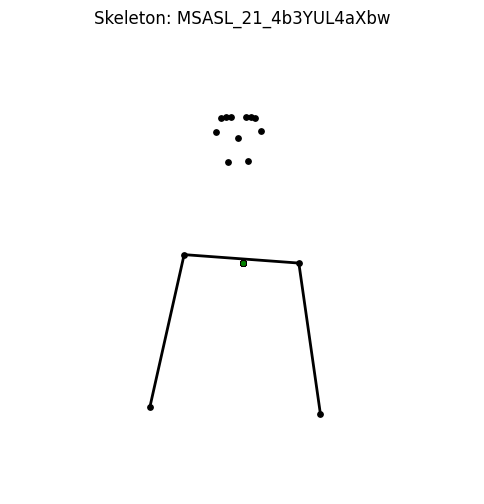

In [6]:
file = "./data/Enhanced_Preprocessed_96Frames/MSASL_21_4b3YUL4aXbw.npy"
display(visualize_sign_skeleton(file))


In [89]:
import os
import argparse
import numpy as np
import cv2
from tqdm import tqdm

# ==========================================
# 1. LAYOUT & CONSTANTS (The 438 Schema)
# ==========================================
POSE_LANDMARKS, POSE_VALS = 33, 4
HAND_LANDMARKS, HAND_VALS = 21, 3
FACE_LANDMARKS, FACE_VALS = 60, 3

POSE_SIZE = POSE_LANDMARKS * POSE_VALS          # 132
HAND_SIZE = HAND_LANDMARKS * HAND_VALS          # 63
FACE_SIZE = FACE_LANDMARKS * FACE_VALS          # 180
FEATURE_DIM = POSE_SIZE + FACE_SIZE + 2 * HAND_SIZE  # 438

# Define which points connect to which (to draw lines)
POSE_CONNECTIONS = [
    (0,1),(1,2),(2,3),(0,4),(4,5),(5,6),(9,10), # Face outline approx
    (11,12),(11,13),(13,15),(15,17),(15,19),(15,21), # Left Arm
    (12,14),(14,16),(16,18),(16,20),(16,22), # Right Arm
    (11,23),(12,24),(23,24), # Torso
    (23,25),(24,26),(25,27),(26,28),(27,29),(28,30),(29,31),(30,32) # Legs
]

HAND_CONNECTIONS = [
    (0,1),(1,2),(2,3),(3,4),         # Thumb
    (0,5),(5,6),(6,7),(7,8),         # Index
    (0,9),(9,10),(10,11),(11,12),    # Middle
    (0,13),(13,14),(14,15),(15,16),  # Ring
    (0,17),(17,18),(18,19),(19,20),  # Pinky
]

# ==========================================
# 2. DATA UNPACKING
# ==========================================
def unpack_frame(vec: np.ndarray):
    """Splits the 438-vector back into Body, Face, Left Hand, Right Hand."""
    if vec.shape[0] != FEATURE_DIM:
        raise ValueError(f"Frame has wrong shape: {vec.shape}, expected {FEATURE_DIM}")

    pose_flat = vec[:POSE_SIZE]
    face_flat = vec[POSE_SIZE : POSE_SIZE + FACE_SIZE]
    lh_flat   = vec[POSE_SIZE + FACE_SIZE : POSE_SIZE + FACE_SIZE + HAND_SIZE]
    rh_flat   = vec[POSE_SIZE + FACE_SIZE + HAND_SIZE :]

    pose = pose_flat.reshape(POSE_LANDMARKS, POSE_VALS)
    face = face_flat.reshape(FACE_LANDMARKS, FACE_VALS)
    lh   = lh_flat.reshape(HAND_LANDMARKS, HAND_VALS)
    rh   = rh_flat.reshape(HAND_LANDMARKS, HAND_VALS)
    
    return pose, face, lh, rh

# ==========================================
# 3. GEOMETRY & MAPPING
# ==========================================
def _valid_mask_xy(arr_xy, eps=1e-8):
    finite = np.isfinite(arr_xy).all(axis=1)
    nonzero = np.any(np.abs(arr_xy) > eps, axis=1)
    return finite & nonzero

def compute_bbox_for_clip(sample, eps=1e-8):
    """Finds the min/max X and Y across the whole video to center it."""
    xs, ys = [], []
    T = sample.shape[0]
    for t in range(T):
        pose, face, lh, rh = unpack_frame(sample[t])
        # Collect all valid points
        for arr in (pose[:, :2], face[:, :2], lh[:, :2], rh[:, :2]):
            m = _valid_mask_xy(arr, eps=eps)
            if np.any(m):
                xs.append(arr[m, 0])
                ys.append(arr[m, 1])
    
    if not xs: return -1.0, 1.0, -1.0, 1.0

    x = np.concatenate(xs)
    y = np.concatenate(ys)
    xmin, xmax = float(x.min()), float(x.max())
    ymin, ymax = float(y.min()), float(y.max())

    # Add padding
    dx = max(xmax - xmin, 1e-6)
    dy = max(ymax - ymin, 1e-6)
    pad = 0.1
    xmin -= pad * dx
    xmax += pad * dx
    ymin -= pad * dy
    ymax += pad * dy
    return xmin, xmax, ymin, ymax

def make_mapper(xmin, xmax, ymin, ymax, W, H, margin=20):
    """Creates a function that converts math coordinates (0.5) to pixels (320)."""
    bw = max(xmax - xmin, 1e-6)
    bh = max(ymax - ymin, 1e-6)

    # Keep aspect ratio
    usable_w = max(W - 2 * margin, 10)
    usable_h = max(H - 2 * margin, 10)
    s = min(usable_w / bw, usable_h / bh)
    
    cx, cy = (xmin + xmax) / 2.0, (ymin + ymax) / 2.0
    tx, ty = W / 2.0 - s * cx, H / 2.0 - s * cy

    def map_xy(x, y):
        # Flip Y because computer images have (0,0) at top-left
        # But our data likely has (0,0) at center or top-left depending on normalization
        # Usually for visualization we just map directly.
        return int(s * x + tx), int(s * y + ty)

    return map_xy

# ==========================================
# 4. DRAWING FUNCTIONS
# ==========================================
def draw_pose(img, pose, map_xy, connections, vis_thresh=0.0, color=(0, 255, 0), thick=2):
    vis = pose[:, 3] # Visibility score
    
    # Draw Lines
    for s, e in connections:
        if vis[s] <= vis_thresh or vis[e] <= vis_thresh: continue
        x1, y1 = map_xy(pose[s, 0], pose[s, 1])
        x2, y2 = map_xy(pose[e, 0], pose[e, 1])
        cv2.line(img, (x1, y1), (x2, y2), color, thick)
        
    # Draw Points (Joints)
    for i in range(len(pose)):
        if vis[i] > vis_thresh:
            x, y = map_xy(pose[i, 0], pose[i, 1])
            cv2.circle(img, (x, y), 3, (0, 0, 255), -1)

def draw_hand(img, hand, map_xy, connections, color=(0, 0, 255), thick=2):
    # Check if hand exists (if all points are 0, skip)
    if np.allclose(hand, 0): return

    for s, e in connections:
        if np.allclose(hand[s, :2], 0) or np.allclose(hand[e, :2], 0): continue
        x1, y1 = map_xy(hand[s, 0], hand[s, 1])
        x2, y2 = map_xy(hand[e, 0], hand[e, 1])
        cv2.line(img, (x1, y1), (x2, y2), color, thick)
        
    # Draw Joints
    for i in range(len(hand)):
        if not np.allclose(hand[i, :2], 0):
            x, y = map_xy(hand[i, 0], hand[i, 1])
            cv2.circle(img, (x, y), 2, (255, 255, 255), -1)

def draw_face(img, face, map_xy, color=(255, 255, 0), radius=1):
    if np.allclose(face, 0): return
    for i in range(len(face)):
        if np.allclose(face[i, :2], 0): continue
        x, y = map_xy(face[i, 0], face[i, 1])
        cv2.circle(img, (x, y), radius, color, -1)

# ==========================================
# 5. MAIN RENDERER
# ==========================================
def render_videos(input_dir, output_dir, limit=20):
    if not os.path.exists(input_dir):
        print(f"Error: Input directory {input_dir} not found.")
        return

    os.makedirs(output_dir, exist_ok=True)
    files = sorted([f for f in os.listdir(input_dir) if f.endswith(".npy")])
    
    if limit > 0:
        files = files[:limit]
    
    print(f"Rendering {len(files)} videos to {output_dir}...")

    # Video Settings
    WIDTH, HEIGHT = 640, 480
    FPS = 20.0
    FOURCC = cv2.VideoWriter_fourcc(*'XVID') # .avi

    for fname in tqdm(files):
        in_path = os.path.join(input_dir, fname)
        sample = np.load(in_path, allow_pickle=True)

        if sample.ndim != 2 or sample.shape[1] != FEATURE_DIM:
            # print(f"Skipping bad shape: {fname}")
            continue

        # 1. Setup Bounding Box
        xmin, xmax, ymin, ymax = compute_bbox_for_clip(sample)
        map_xy = make_mapper(xmin, xmax, ymin, ymax, WIDTH, HEIGHT)

        # 2. Setup Video Writer
        out_name = fname.replace(".npy", ".avi")
        out_path = os.path.join(output_dir, out_name)
        vw = cv2.VideoWriter(out_path, FOURCC, FPS, (WIDTH, HEIGHT))

        # 3. Loop Frames
        for t in range(sample.shape[0]):
            pose, face, lh, rh = unpack_frame(sample[t])
            
            # Create Black Background
            img = np.zeros((HEIGHT, WIDTH, 3), np.uint8) 

            # Draw Parts
            draw_pose(img, pose, map_xy, POSE_CONNECTIONS, color=(0, 255, 0)) # Green Body
            draw_hand(img, lh, map_xy, HAND_CONNECTIONS, color=(0, 0, 255))   # Red Left Hand
            draw_hand(img, rh, map_xy, HAND_CONNECTIONS, color=(255, 0, 0))   # Blue Right Hand
            draw_face(img, face, map_xy, color=(255, 255, 0))                 # Cyan Face

            vw.write(img)

        vw.release()

if __name__ == "__main__":
    # --- CHANGE PATHS HERE ---
    INPUT = "./data/Enhanced_Preprocessed_96Frames"
    OUTPUT = "./data/Enhanced_Rendered_Videos"
    
    render_videos(INPUT, OUTPUT, limit=50) # Limit to 50 for testing

Rendering 50 videos to ./data/Enhanced_Rendered_Videos...


100%|██████████| 50/50 [00:16<00:00,  3.03it/s]


# comparsion 
bet the preprocessing and enhanced preprocessing

In [7]:
def simple_comparison():
    """Simple comparison between old and new preprocessing."""
    print("="*60)
    print("SIMPLE PREPROCESSING COMPARISON")
    print("="*60)
    
    # Paths
    old_dir = Path("./data/Merged_Cleaned_Dataset")
    new_dir = Path("./data/Enhanced_Preprocessed_96Frames")
    
    print(f"\n📁 OLD Preprocessing: {old_dir}")
    print(f"📁 NEW Preprocessing: {new_dir}")
    
    # Count files
    old_files = list(old_dir.glob("*.npy"))
    new_seq_files = list(new_dir.glob("*[!_mask].npy"))
    new_mask_files = list(new_dir.glob("*_mask.npy"))
    
    print(f"\n📊 File Counts:")
    print(f"  OLD: {len(old_files):,} files (only sequences)")
    print(f"  NEW: {len(new_seq_files):,} sequences + {len(new_mask_files):,} masks")
    print(f"  NEW Total: {len(new_seq_files) + len(new_mask_files):,} files")
    
    # Check shapes
    print(f"\n🔍 Shape Check (sampling 5 files each):")
    
    print(f"\nOLD Preprocessing:")
    for i, file in enumerate(old_files[:5]):
        try:
            data = np.load(file)
            status = "✅" if data.shape == (96, 438) else "❌"
            print(f"  {status} {file.name}: {data.shape}")
        except:
            print(f"  ❌ {file.name}: Error loading")
    
    print(f"\nNEW Preprocessing (Sequences):")
    for i, file in enumerate(new_seq_files[:5]):
        try:
            data = np.load(file)
            status = "✅" if data.shape == (96, 438) else "❌"
            print(f"  {status} {file.name}: {data.shape}")
        except:
            print(f"  ❌ {file.name}: Error loading")
    
    print(f"\nNEW Preprocessing (Masks - should be 96,):")
    for i, file in enumerate(new_mask_files[:5]):
        try:
            data = np.load(file)
            status = "✅" if data.shape == (96,) else "❌"
            print(f"  {status} {file.name}: {data.shape}")
        except:
            print(f"  ❌ {file.name}: Error loading")
    
    # Count strategies from metadata
    print(f"\n🎯 NEW Processing Strategies:")
    metadata_path = new_dir / "metadata.csv"
    if metadata_path.exists():
        df_meta = pd.read_csv(metadata_path)
        strategy_counts = df_meta['strategy'].value_counts()
        
        for strategy, count in strategy_counts.items():
            percentage = (count / len(df_meta)) * 100
            print(f"  {strategy}: {count:,} samples ({percentage:.1f}%)")
        
        # Expansion factor
        unique_videos = df_meta[['source', 'video_id']].drop_duplicates().shape[0]
        expansion = len(df_meta) / unique_videos if unique_videos > 0 else 0
        print(f"\n  Videos expanded: {unique_videos:,} → {len(df_meta):,} samples")
        print(f"  Expansion factor: {expansion:.2f}x")
    
    # Sample comparison
    print(f"\n🔬 Sample Comparison (same video):")
    
    # Find a common video
    sample_old = old_files[0] if old_files else None
    if sample_old:
        # Parse filename to find corresponding new file
        parts = sample_old.stem.split('_')
        if len(parts) >= 3:
            source = parts[0]
            word = parts[1]
            video_id = '_'.join(parts[2:]) if len(parts) > 3 else parts[2]
            
            # Find matching new file
            new_pattern = f"{source}_{word}_{video_id}.npy"
            new_matches = list(new_dir.glob(new_pattern))
            
            if new_matches:
                old_data = np.load(sample_old)
                new_data = np.load(new_matches[0])
                
                print(f"  Comparing: {sample_old.name}")
                print(f"  OLD shape: {old_data.shape}, mean: {old_data.mean():.4f}, std: {old_data.std():.4f}")
                print(f"  NEW shape: {new_data.shape}, mean: {new_data.mean():.4f}, std: {new_data.std():.4f}")
                
                # Check if they're similar
                mean_diff = abs(old_data.mean() - new_data.mean())
                std_diff = abs(old_data.std() - new_data.std())
                
                if mean_diff < 0.1 and std_diff < 0.1:
                    print(f"  ✅ Similar statistics (mean diff: {mean_diff:.4f}, std diff: {std_diff:.4f})")
                else:
                    print(f"  ⚠️ Different statistics (mean diff: {mean_diff:.4f}, std diff: {std_diff:.4f})")
            else:
                print(f"  No matching NEW file found for {sample_old.name}")
    
    print(f"\n" + "="*60)
    print("📋 SUMMARY - WHICH IS BETTER?")
    print("="*60)
    
    print(f"\n✅ OLD Preprocessing (Merged_Cleaned_Dataset):")
    print("   • Simpler: Just trims/pads to 96 frames")
    print("   • Faster to process")
    print("   • All videos → 1 sample each")
    print("   • No masks")
    print("   • Good for baseline models")
    
    print(f"\n✅ NEW Preprocessing (Enhanced_Preprocessed_96Frames):")
    print("   • Smarter: Hybrid strategy based on length")
    print("   • More data: Long videos create multiple windows")
    print("   • Better for short videos: Interpolation instead of truncation")
    print("   • Includes attention masks")
    print("   • Preserves more information")
    print("   • Better for advanced models")
    
    print(f"\n🎯 RECOMMENDATION:")
    print("   • For QUICK experiments: Use OLD preprocessing")
    print("   • For BEST results: Use NEW preprocessing")
    print("   • NEW gives ~{expansion:.1f}x more data from same videos")
    
    print(f"\n📊 NEXT STEPS:")
    print("   1. Train model with OLD data (baseline)")
    print("   2. Train same model with NEW data")
    print("   3. Compare performance")
    print("   4. If NEW is better (likely), use it for all future training")

# Run the comparison
simple_comparison()

SIMPLE PREPROCESSING COMPARISON

📁 OLD Preprocessing: data\Merged_Cleaned_Dataset
📁 NEW Preprocessing: data\Enhanced_Preprocessed_96Frames

📊 File Counts:
  OLD: 15,663 files (only sequences)
  NEW: 19,016 sequences + 21,094 masks
  NEW Total: 40,110 files

🔍 Shape Check (sampling 5 files each):

OLD Preprocessing:
  ✅ MSASL_21_4b3YUL4aXbw.npy: (96, 438)
  ✅ MSASL_21_bynVwAN2M2M.npy: (96, 438)
  ✅ MSASL_21_CBQXPn152YI.npy: (96, 438)
  ✅ MSASL_21_FKp2hBhdj9k.npy: (96, 438)
  ✅ MSASL_21_hFCXyB6q2nU.npy: (96, 438)

NEW Preprocessing (Sequences):
  ✅ MSASL_21_4b3YUL4aXbw.npy: (96, 438)
  ✅ MSASL_21_bynVwAN2M2M_w00.npy: (96, 438)
  ✅ MSASL_21_bynVwAN2M2M_w01.npy: (96, 438)
  ✅ MSASL_21_bynVwAN2M2M_w02.npy: (96, 438)
  ✅ MSASL_21_CBQXPn152YI.npy: (96, 438)

NEW Preprocessing (Masks - should be 96,):
  ✅ MSASL_21_4b3YUL4aXbw_mask.npy: (96,)
  ✅ MSASL_21_bynVwAN2M2M_w00_mask.npy: (96,)
  ✅ MSASL_21_bynVwAN2M2M_w01_mask.npy: (96,)
  ✅ MSASL_21_bynVwAN2M2M_w02_mask.npy: (96,)
  ✅ MSASL_21_CBQXPn

 simple visualization comparison:

Comparing: MSASL_21_4b3YUL4aXbw
OLD shape: (96, 438)
NEW shape: (96, 438)


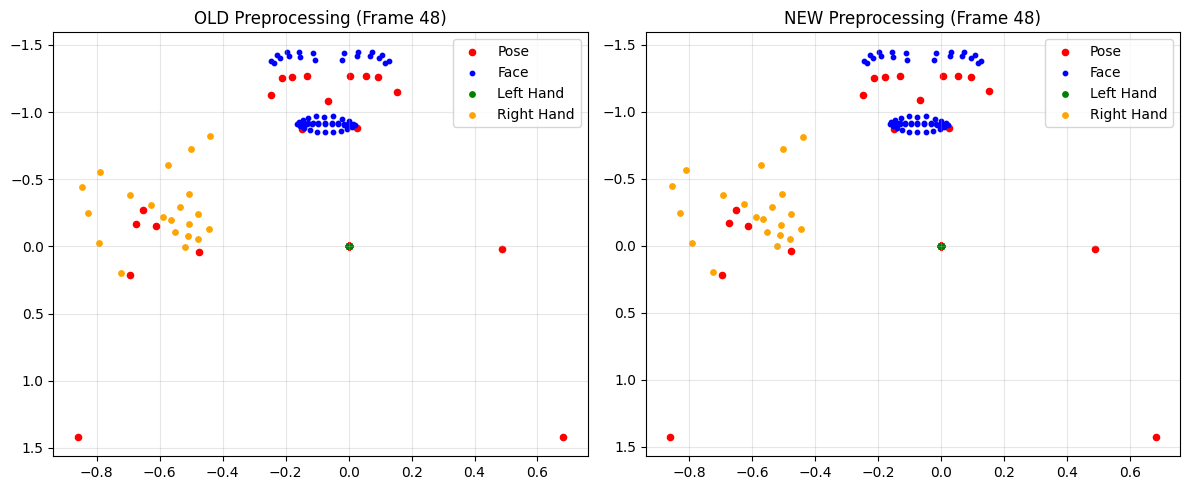


📊 Frame 48 Statistics:
OLD - Pose mean: -0.2065, Hand mean: -0.2178
NEW - Pose mean: -0.2064, Hand mean: -0.2181


In [8]:
def visualize_comparison(video_name="MSASL_21_4b3YUL4aXbw"):
    """Simple side-by-side visualization of old vs new preprocessing."""
    
    # Load data
    old_data = np.load(f"./data/Merged_Cleaned_Dataset/{video_name}.npy")
    new_data = np.load(f"./data/Enhanced_Preprocessed_96Frames/{video_name}.npy")
    
    print(f"Comparing: {video_name}")
    print(f"OLD shape: {old_data.shape}")
    print(f"NEW shape: {new_data.shape}")
    
    # Select middle frame
    frame_idx = 48  # Middle frame
    old_frame = old_data[frame_idx]
    new_frame = new_data[frame_idx]
    
    # Reshape to landmarks
    def reshape_to_landmarks(frame):
        pose = frame[:132].reshape(33, 4)      # 33 pose points, (x,y,z,visibility)
        face = frame[132:312].reshape(60, 3)   # 60 face points, (x,y,z)
        lhand = frame[312:375].reshape(21, 3)  # 21 left hand points
        rhand = frame[375:].reshape(21, 3)     # 21 right hand points
        return pose, face, lhand, rhand
    
    old_pose, old_face, old_lhand, old_rhand = reshape_to_landmarks(old_frame)
    new_pose, new_face, new_lhand, new_rhand = reshape_to_landmarks(new_frame)
    
    # Create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot OLD preprocessing
    ax1.scatter(old_pose[:, 0], old_pose[:, 1], c='red', s=20, label='Pose')
    ax1.scatter(old_face[:, 0], old_face[:, 1], c='blue', s=10, label='Face')
    ax1.scatter(old_lhand[:, 0], old_lhand[:, 1], c='green', s=15, label='Left Hand')
    ax1.scatter(old_rhand[:, 0], old_rhand[:, 1], c='orange', s=15, label='Right Hand')
    ax1.set_title(f'OLD Preprocessing (Frame {frame_idx})')
    ax1.invert_yaxis()  # MediaPipe coordinates
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot NEW preprocessing
    ax2.scatter(new_pose[:, 0], new_pose[:, 1], c='red', s=20, label='Pose')
    ax2.scatter(new_face[:, 0], new_face[:, 1], c='blue', s=10, label='Face')
    ax2.scatter(new_lhand[:, 0], new_lhand[:, 1], c='green', s=15, label='Left Hand')
    ax2.scatter(new_rhand[:, 0], new_rhand[:, 1], c='orange', s=15, label='Right Hand')
    ax2.set_title(f'NEW Preprocessing (Frame {frame_idx})')
    ax2.invert_yaxis()  # MediaPipe coordinates
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print comparison stats
    print(f"\n📊 Frame {frame_idx} Statistics:")
    print(f"OLD - Pose mean: {old_pose[:, :2].mean():.4f}, Hand mean: {(old_lhand[:, :2].mean() + old_rhand[:, :2].mean())/2:.4f}")
    print(f"NEW - Pose mean: {new_pose[:, :2].mean():.4f}, Hand mean: {(new_lhand[:, :2].mean() + new_rhand[:, :2].mean())/2:.4f}")

# Run it
visualize_comparison()

In [10]:
def number_compare(video_name="MSASL_21_4b3YUL4aXbw"):
    """Just print numbers comparison."""
    
    old = np.load(f"./data/Merged_Cleaned_Dataset/{video_name}.npy")
    new = np.load(f"./data/Enhanced_Preprocessed_96Frames/{video_name}.npy")
    
    print(f"📊 Comparison for: {video_name}")
    print("-" * 40)
    print(f"OLD: shape={old.shape}, mean={old.mean():.4f}, std={old.std():.4f}")
    print(f"NEW: shape={new.shape}, mean={new.mean():.4f}, std={new.std():.4f}")
    print("-" * 40)
    
    # Check middle frame hands
    mid = 48
    old_hands = old[mid, 312:]  # Hand features
    new_hands = new[mid, 312:]
    
    print(f"\n👐 Hand Comparison (Frame {mid}):")
    print(f"OLD hands mean: {old_hands.mean():.4f} (min={old_hands.min():.4f}, max={old_hands.max():.4f})")
    print(f"NEW hands mean: {new_hands.mean():.4f} (min={new_hands.min():.4f}, max={new_hands.max():.4f})")
    
    if abs(old.mean() - new.mean()) < 0.1:
        print("\n✅ Similar preprocessing results")
    else:
        print("\n⚠️ Different preprocessing results")

number_compare()

📊 Comparison for: MSASL_21_4b3YUL4aXbw
----------------------------------------
OLD: shape=(96, 438), mean=-0.1220, std=0.7258
NEW: shape=(96, 438), mean=-0.1221, std=0.7255
----------------------------------------

👐 Hand Comparison (Frame 48):
OLD hands mean: -0.0375 (min=-0.8484, max=0.7331)
NEW hands mean: -0.0384 (min=-0.8565, max=0.7273)

✅ Similar preprocessing results


In [11]:
def compare_random_samples(n=3):
    """Compare random samples from both datasets."""
    
    import random
    
    old_files = list(Path("./data/Merged_Cleaned_Dataset").glob("*.npy"))
    new_files = list(Path("./data/Enhanced_Preprocessed_96Frames").glob("*[!_mask].npy"))
    
    # Find common files
    old_names = {f.stem for f in old_files}
    new_names = {f.stem for f in new_files}
    common = list(old_names.intersection(new_names))
    
    print(f"Found {len(common)} common files")
    
    for i, name in enumerate(random.sample(common, min(n, len(common)))):
        print(f"\n{i+1}. {name}:")
        number_compare(name)
        print()

# Compare 3 random files
compare_random_samples(3)

Found 11709 common files

1. MSASL_noon_8OGGZyG8S9g:
📊 Comparison for: MSASL_noon_8OGGZyG8S9g
----------------------------------------
OLD: shape=(96, 438), mean=-0.5888, std=1.1008
NEW: shape=(96, 438), mean=-0.5915, std=1.0987
----------------------------------------

👐 Hand Comparison (Frame 48):
OLD hands mean: -0.4625 (min=-1.6354, max=0.2447)
NEW hands mean: -0.6064 (min=-1.9938, max=0.1063)

✅ Similar preprocessing results


2. WLASL_humble_4:
📊 Comparison for: WLASL_humble_4
----------------------------------------
OLD: shape=(96, 438), mean=-0.0040, std=0.5666
NEW: shape=(96, 438), mean=-0.0031, std=0.5636
----------------------------------------

👐 Hand Comparison (Frame 48):
OLD hands mean: 0.1886 (min=-0.4435, max=0.5759)
NEW hands mean: 0.1867 (min=-0.4436, max=0.5607)

✅ Similar preprocessing results


3. WLASL_divorce_5:
📊 Comparison for: WLASL_divorce_5
----------------------------------------
OLD: shape=(96, 438), mean=-0.0319, std=0.7003
NEW: shape=(96, 438), mean=-0.

Comparing: MSASL_21_4b3YUL4aXbw
OLD: (96, 438) frames, NEW: (96, 438) frames


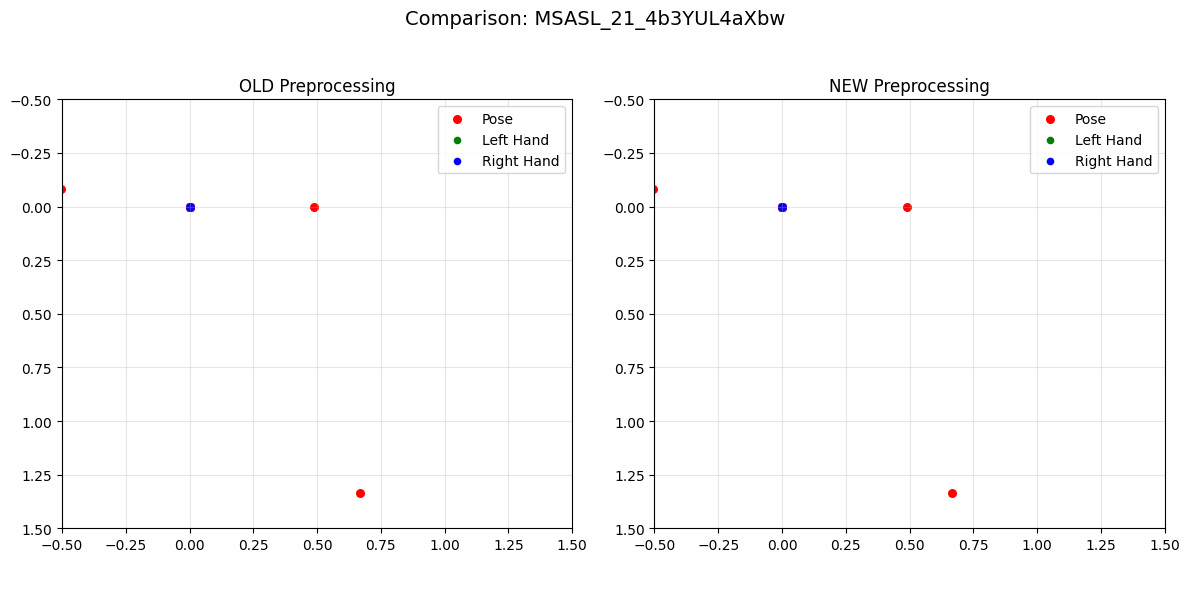

In [12]:
def compare_skeleton_video(video_name="MSASL_21_4b3YUL4aXbw", fps=10):
    """Simple video comparison of old vs new preprocessing."""
    
    # Load both videos
    old_video = np.load(f"./data/Merged_Cleaned_Dataset/{video_name}.npy")
    new_video = np.load(f"./data/Enhanced_Preprocessed_96Frames/{video_name}.npy")
    
    print(f"Comparing: {video_name}")
    print(f"OLD: {old_video.shape} frames, NEW: {new_video.shape} frames")
    
    # Create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    plt.subplots_adjust(wspace=0.3)
    
    # Function to extract landmarks from a frame
    def get_landmarks(frame):
        pose = frame[:132].reshape(33, 4)[:, :2]    # x,y only
        lhand = frame[312:375].reshape(21, 3)[:, :2]
        rhand = frame[375:].reshape(21, 3)[:, :2]
        return pose, lhand, rhand
    
    # Initialize plots
    old_scatter1 = ax1.scatter([], [], c='red', s=30, label='Pose')
    old_scatter2 = ax1.scatter([], [], c='green', s=20, label='Left Hand')
    old_scatter3 = ax1.scatter([], [], c='blue', s=20, label='Right Hand')
    ax1.set_title(f'OLD Preprocessing')
    ax1.set_xlim(-0.5, 1.5)
    ax1.set_ylim(1.5, -0.5)  # Inverted for MediaPipe
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    new_scatter1 = ax2.scatter([], [], c='red', s=30, label='Pose')
    new_scatter2 = ax2.scatter([], [], c='green', s=20, label='Left Hand')
    new_scatter3 = ax2.scatter([], [], c='blue', s=20, label='Right Hand')
    ax2.set_title(f'NEW Preprocessing')
    ax2.set_xlim(-0.5, 1.5)
    ax2.set_ylim(1.5, -0.5)  # Inverted for MediaPipe
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    # Frame counter text
    frame_text = fig.text(0.5, 0.02, '', ha='center', fontsize=12)
    
    def update(frame_num):
        # Get frame data
        old_frame = old_video[frame_num % len(old_video)]
        new_frame = new_video[frame_num % len(new_video)]
        
        # Extract landmarks
        old_pose, old_lhand, old_rhand = get_landmarks(old_frame)
        new_pose, new_lhand, new_rhand = get_landmarks(new_frame)
        
        # Update OLD plot
        old_scatter1.set_offsets(old_pose)
        old_scatter2.set_offsets(old_lhand)
        old_scatter3.set_offsets(old_rhand)
        
        # Update NEW plot
        new_scatter1.set_offsets(new_pose)
        new_scatter2.set_offsets(new_lhand)
        new_scatter3.set_offsets(new_rhand)
        
        # Update frame text
        frame_text.set_text(f'Frame: {frame_num % len(old_video)}/{len(old_video)-1}')
        
        return old_scatter1, old_scatter2, old_scatter3, new_scatter1, new_scatter2, new_scatter3, frame_text
    
    # Create animation
    ani = animation.FuncAnimation(
        fig, update, 
        frames=min(len(old_video), len(new_video)), 
        interval=1000/fps,  # Convert fps to interval
        blit=True
    )
    
    plt.suptitle(f'Comparison: {video_name}', fontsize=14)
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.show()
    
    return ani

# Run it
ani = compare_skeleton_video()

# 🎥 Analogy:
Imagine you have videos of different lengths, but you need to fit them ALL into 96-frame boxes:

text
Short video (30 frames):  [██████████------------------------------]
                          ↑ Real sign language  ↑ Empty space (padded)
                          
Long video (200 frames):  [██████████████████████████████████████]
                          ↑ Only showing first 96 frames
The mask tells your computer: "Hey, only the colored blocks are real sign language!"

1.0 = "This frame has REAL sign language"

0.0 = "This frame is EMPTY/PADDED (ignore it!)"

🤔 Why Do We Need This?
Problem:
Sign language videos come in different lengths (30, 60, 100, 200 frames), but AI models need FIXED input size (96 frames).

Solution Options:
Chop long videos → Lose information ❌

Repeat short videos → Fake data ❌

Add zeros (padding) → But need to tell AI what's real vs fake ✅

Masks solve this! They tell the AI: "Only learn from the real frames, ignore the zeros!"

📹 SHORT VIDEO (45 frames → padded to 96)
--------------------------------------------------
First 10 mask values: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Last 10 mask values:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Real frames: 45
Padded frames: 51

📹 PERFECT VIDEO (96 frames exactly)
--------------------------------------------------
All frames are: 1.0
Real frames: 96


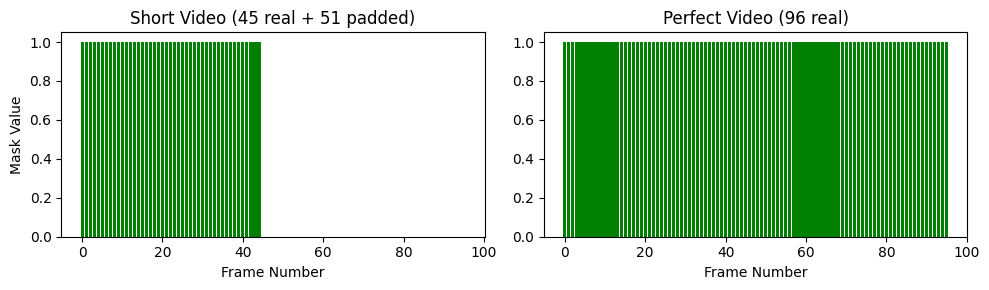

In [2]:
def show_simple_mask_example():
    """Show mask for different video lengths."""
    
    # Example 1: Short video (45 frames)
    print("📹 SHORT VIDEO (45 frames → padded to 96)")
    print("-" * 50)
    
    # Imagine we loaded a 45-frame video
    mask_short = np.ones(96)  # Start with all 1's
    mask_short[45:] = 0.0     # Set frames 45-95 to 0.0
    
    print(f"First 10 mask values: {mask_short[:10]}")
    print(f"Last 10 mask values:  {mask_short[-10:]}")
    print(f"Real frames: {np.sum(mask_short == 1.0)}")
    print(f"Padded frames: {np.sum(mask_short == 0.0)}")
    
    # Example 2: Exact 96-frame video  
    print("\n📹 PERFECT VIDEO (96 frames exactly)")
    print("-" * 50)
    
    mask_perfect = np.ones(96)  # All frames are real!
    
    print(f"All frames are: {mask_perfect[0]:.1f}")
    print(f"Real frames: {np.sum(mask_perfect == 1.0)}")
    
    # Visualize
    plt.figure(figsize=(10, 3))
    
    plt.subplot(1, 2, 1)
    plt.bar(range(96), mask_short, color=['green' if x==1 else 'red' for x in mask_short])
    plt.title('Short Video (45 real + 51 padded)')
    plt.xlabel('Frame Number')
    plt.ylabel('Mask Value')
    
    plt.subplot(1, 2, 2)
    plt.bar(range(96), mask_perfect, color='green')
    plt.title('Perfect Video (96 real)')
    plt.xlabel('Frame Number')
    
    plt.tight_layout()
    plt.show()

show_simple_mask_example()

# 🎯 Real-World Example

📁 File: MSASL_21_4b3YUL4aXbw_mask.npy
📊 Data shape: (96, 438)  (96 frames, 438 features)
🎭 Mask shape: (96,)  (96 values)
📈 Real frames: 96
🔄 Interpolated: 0
⬜ Padded: 0

First 5 mask values: [1. 1. 1. 1. 1.]
Last 5 mask values:  [1. 1. 1. 1. 1.]


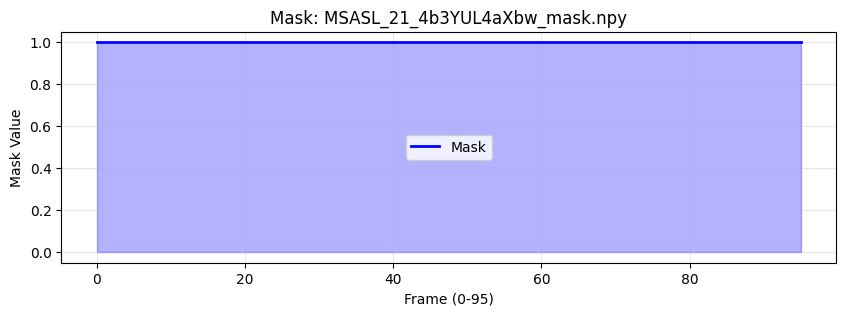

In [3]:
def check_real_mask():
    """Check a real mask from your dataset."""
    
    # Find any mask file
    mask_files = list(Path("./data/Enhanced_Preprocessed_96Frames").glob("*_mask.npy"))
    
    if mask_files:
        mask = np.load(mask_files[0])
        data_file = str(mask_files[0]).replace("_mask.npy", ".npy")
        data = np.load(data_file)
        
        print(f"📁 File: {mask_files[0].name}")
        print(f"📊 Data shape: {data.shape}  (96 frames, 438 features)")
        print(f"🎭 Mask shape: {mask.shape}  (96 values)")
        print(f"📈 Real frames: {np.sum(mask > 0.9):.0f}")
        print(f"🔄 Interpolated: {np.sum((mask > 0.4) & (mask <= 0.9)):.0f}")
        print(f"⬜ Padded: {np.sum(mask < 0.1):.0f}")
        
        # Show first and last
        print(f"\nFirst 5 mask values: {mask[:5]}")
        print(f"Last 5 mask values:  {mask[-5:]}")
        
        # Simple plot
        plt.figure(figsize=(10, 3))
        plt.plot(mask, 'b-', linewidth=2, label='Mask')
        plt.fill_between(range(96), mask, alpha=0.3, color='blue')
        plt.title(f'Mask: {mask_files[0].name}')
        plt.xlabel('Frame (0-95)')
        plt.ylabel('Mask Value')
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.show()
    else:
        print("No mask files found!")

check_real_mask()